In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
# Carga Fichero

import pandas as pd
path="/content/drive/MyDrive/Cajamar/"
datos = pd.read_csv(path+'Modelar_UH2022.txt',sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True)

In [ ]:
#Modelar_UH2022_10_Contadores.txt
datos[datos['ID']<11].to_csv('Modelar_UH2022_10_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']<3].to_csv('Modelar_UH2022_2_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2735].to_csv('Modelar_UH2022_Contador_2735.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2561].to_csv('Modelar_UH2022_Contador_2561.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2562].to_csv('Modelar_UH2022_Contador_2562.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==167].to_csv('Modelar_UH2022_Contador_167.txt',sep='|',index=False,float_format='%.0f')

In [ ]:
datos[datos['ID']==2521].to_csv('Modelar_UH2022_Contador_2521.txt',sep='|',index=False,float_format='%.0f')

# CLASE PARA PROYECTO CAJAMAR

In [ ]:
import pandas as pd
path="/content/drive/MyDrive/Cajamar/"
Normal_better=pd.read_csv(path+'Normal_better')
Lista_Normal_better = Normal_better['Salida'].tolist()
print(Lista_Normal_better)

[0, 1, 2, 3, 4, 0, 6, 7, 8, 0, 10, 11, 0, 0, 14, 0, 0, 0, 0, 19, 0, 0, 0, 23, 0, 25, 0, 0, 28, 29, 30, 31, 0, 33, 0, 0, 36, 0, 38, 39, 40, 41, 42, 0, 44, 0, 46, 0, 0, 0, 50, 51, 52, 53, 0, 55, 0, 57, 58, 59, 0, 61, 62, 63, 0, 65, 0, 67, 68, 69, 0, 71, 0, 0, 74, 0, 76, 77, 0, 0, 80, 0, 0, 0, 84, 0, 86, 0, 0, 89, 90, 0, 92, 93, 94, 95, 0, 97, 0, 0, 100, 101, 0, 103, 0, 105, 106, 107, 108, 109, 0, 111, 0, 0, 114, 0, 116, 117, 0, 119, 120, 121, 0, 0, 0, 0, 126, 0, 0, 129, 130, 131, 0, 133, 134, 0, 136, 0, 0, 0, 140, 141, 142, 143, 0, 145, 146, 0, 0, 149, 0, 0, 0, 153, 154, 0, 156, 157, 0, 0, 160, 161, 162, 0, 0, 0, 0, 167, 168, 169, 0, 171, 172, 173, 174, 175, 0, 0, 178, 0, 180, 0, 182, 0, 0, 185, 0, 187, 0, 189, 0, 0, 192, 193, 194, 195, 196, 197, 198, 0, 200, 201, 0, 0, 0, 205, 0, 207, 208, 209, 210, 211, 0, 0, 0, 215, 0, 0, 0, 0, 220, 221, 222, 0, 224, 0, 226, 227, 228, 0, 230, 231, 232, 233, 0, 0, 236, 237, 238, 0, 240, 241, 0, 243, 244, 0, 0, 0, 0, 249, 0, 251, 252, 253, 254, 0, 0, 0,

In [ ]:
!pip install skforecast

     |████████████████████████████████| 81 kB 6.3 MB/s 
     |████████████████████████████████| 9.8 MB 36.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [21]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal):
        self.datos_contador = datos_contador
        self.ID = ID
        self.lista_contadores_defectuosos = [111, 658, 2460, 2464, 2466, 2481, 2483, 2489]
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            #CALCULO DE LA LECTURA Y CONSUMO AGRUPANDO PARTE ENTERA Y DECIMAL
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            
            #NORMALIZACIÓN A DISTRIBUCIÓN NORMAL(0,1) DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_NORMA'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].mean())/self.datos_contador['LECTURA'].std()
            self.datos_contador['CONSUMO_NORMA'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].mean())/self.datos_contador['CONSUMO'].std()
            
            # ELIMINANDO LOS OUTLIERS "DESTACADOS" DE LOS CONTADORES MARCADOS (DEJO COMENTADA UNA OPCIÓN PARA HACERLO TAMBIÉN CON EL RESTO DE CONTADORES)
            if self.ID in self.lista_contadores_defectuosos:
              if self.ID in [111, 658, 2560]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>6)[0]], inplace=True)
              elif self.ID in [2466, 2483, 2489]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>5)[0]], inplace=True)
              elif self.ID in [2464, 2481]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>10)[0]], inplace=True)
#           else:
#             self.datos_contador['CONSUMO'].drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA']>8)[0]], inplace=True)
            
            #FIJACIÓN DEL ÍNDICE TEMPORAL DE LA SERIE
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')

            #NORMALIZACIÓN MIN MAX DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_MINMAX'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].min())/(self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min())
            self.datos_contador['CONSUMO_MINMAX'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].min())/(self.datos_contador['CONSUMO'].max()-self.datos_contador['CONSUMO'].min())
            
            #CÁLCULO DE LA DIFERENCIA DE LECTURAS EN CADA PASO DE TIEMPO PARA OBTENER EL CONSUMO A PARTIR DE LA LECTURA
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)
            
            #APLICACIÓN DE LA FUNCIÓN PARA VERIFICAR SI EL CONSUMO ES CORRECTO
            self.__Comprobar_Consumo()

            # CÁLCULO DE LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA DE VALOR MÁXIMO Y MÍNIMO DE LA LECTURA DEL CONTADOR
            self.suma_consumo = self.datos_contador['CONSUMO'].sum()
            self.diferencia_lectura = self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min()

            #BOOLEANO QUE DETERMINA SI LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA MIN MAX DEL CONTADOR SON IGUALES
            if self.suma_consumo == self.diferencia_lectura:
              self.buenas_lecturas = True
            else:
              self.buenas_lecturas = False

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())

            # NORMALIZACIÓN NORMAL STÁNDARD
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            self.datos_consumo['CONSUMO_NORM'].fillna(0, inplace=True)
            # NORMALIZACIÓN MIN MAX
            self.datos_consumo['CONSUMO_MIN_MAX'] = (self.datos_consumo['CONSUMO']-self.datos_consumo['CONSUMO'].min())/(self.datos_consumo['CONSUMO'].max()-self.datos_consumo['CONSUMO'].min())
            self.datos_consumo['CONSUMO_MIN_MAX'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=3
            self.datos_consumo['CONSUMO_MEDMOV3'] = self.datos_consumo['CONSUMO'].rolling(3).mean()
            self.datos_consumo['CONSUMO_MEDMOV3'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=4
            self.datos_consumo['CONSUMO_MEDMOV4'] = self.datos_consumo['CONSUMO'].rolling(4).mean()
            self.datos_consumo['CONSUMO_MEDMOV4'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=5
            self.datos_consumo['CONSUMO_MEDMOV5'] = self.datos_consumo['CONSUMO'].rolling(5).mean()
            self.datos_consumo['CONSUMO_MEDMOV5'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=6
            self.datos_consumo['CONSUMO_MEDMOV6'] = self.datos_consumo['CONSUMO'].rolling(6).mean()
            self.datos_consumo['CONSUMO_MEDMOV6'].fillna(0,inplace=True)


            # MEDIAS MÓVILES N=7
            self.datos_consumo['CONSUMO_MEDMOV7'] = self.datos_consumo['CONSUMO'].rolling(7).mean()
            self.datos_consumo['CONSUMO_MEDMOV7'].fillna(0,inplace=True)   

            self.datos_consumo['CONSUMO_MEAN'] = self.datos_consumo['CONSUMO'].tail(30).mean()
            print(self.datos_consumo['CONSUMO_MEAN'])
            self.datos_consumo['CONSUMO_MEAN'].fillna(0,inplace=True)  

            #COGER SÓLO SEMANAS COMPLETAS
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo
        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if row['CONSUMO_CAL'] != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)


    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100, Modelo_Semanal=False):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.RMSE_Todos = []
        self.RMSE_Todos_IDs = []
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100],
              'max_depth': [5]}

        # Lags utilizados como predictores
        lags_grid = [14]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #if contador.ID not in Lista_Normal_better:
                #print(contador.ID)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV6'])
                #else:
                contador.model.fit(y=contador.datos_consumo['CONSUMO_MEAN'])
                predict = contador.model.predict(steps=self.dias_test)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MIN_MAX'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV3'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV4'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV5'])

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test)*(contador.datos_consumo['CONSUMO'].max()-contador.datos_consumo['CONSUMO'].min())+contador.datos_consumo['CONSUMO'].min()
                #predict = contador.model.predict(steps=self.dias_test)
                index = 1
                for predict_dia in predict[0:14]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,15):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                self.RMSE_Todos.append(contador.RMSE_Test)
                self.RMSE_Todos_IDs.append(contador.ID)

        self.RMSE_Test_Suma = sum(self.RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(self.RMSE_Todos)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:15],index=self.contadores[contador].datos_test['CONSUMO'].index[0:14],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [22]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
path="/content/drive/MyDrive/Cajamar/"
#Proyecto = CajaMar_Water(path+'Modelar_UH2022_10_Contadores.txt')
Proyecto = CajaMar_Water(path+'Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt', Modelo_Semanal=False)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')

CARGANDO DATOS.....
GENERANDO CONTADORES.....


  0%|          | 1/2747 [00:00<24:20,  1.88it/s]

SAMPLETIME
2019-02-01    303.84
2019-02-02    303.84
2019-02-03    303.84
2019-02-04    303.84
2019-02-05    303.84
               ...  
2020-01-27    303.84
2020-01-28    303.84
2020-01-29    303.84
2020-01-30    303.84
2020-01-31    303.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 2/2747 [00:01<27:23,  1.67it/s]

SAMPLETIME
2019-02-01    14.764333
2019-02-02    14.764333
2019-02-03    14.764333
2019-02-04    14.764333
2019-02-05    14.764333
                ...    
2020-01-27    14.764333
2020-01-28    14.764333
2020-01-29    14.764333
2020-01-30    14.764333
2020-01-31    14.764333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 3/2747 [00:01<26:21,  1.74it/s]

SAMPLETIME
2019-02-01    35.036667
2019-02-02    35.036667
2019-02-03    35.036667
2019-02-04    35.036667
2019-02-05    35.036667
                ...    
2020-01-27    35.036667
2020-01-28    35.036667
2020-01-29    35.036667
2020-01-30    35.036667
2020-01-31    35.036667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 4/2747 [00:02<26:11,  1.75it/s]

SAMPLETIME
2019-02-01    382.226667
2019-02-02    382.226667
2019-02-03    382.226667
2019-02-04    382.226667
2019-02-05    382.226667
                 ...    
2020-01-27    382.226667
2020-01-28    382.226667
2020-01-29    382.226667
2020-01-30    382.226667
2020-01-31    382.226667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 5/2747 [00:02<27:54,  1.64it/s]

SAMPLETIME
2019-02-01    299.471
2019-02-02    299.471
2019-02-03    299.471
2019-02-04    299.471
2019-02-05    299.471
               ...   
2020-01-27    299.471
2020-01-28    299.471
2020-01-29    299.471
2020-01-30    299.471
2020-01-31    299.471
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 6/2747 [00:03<26:15,  1.74it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 7/2747 [00:03<25:24,  1.80it/s]

SAMPLETIME
2019-02-01    177.7
2019-02-02    177.7
2019-02-03    177.7
2019-02-04    177.7
2019-02-05    177.7
              ...  
2020-01-27    177.7
2020-01-28    177.7
2020-01-29    177.7
2020-01-30    177.7
2020-01-31    177.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 8/2747 [00:04<24:37,  1.85it/s]

SAMPLETIME
2019-02-01    103.36
2019-02-02    103.36
2019-02-03    103.36
2019-02-04    103.36
2019-02-05    103.36
               ...  
2020-01-27    103.36
2020-01-28    103.36
2020-01-29    103.36
2020-01-30    103.36
2020-01-31    103.36
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 9/2747 [00:05<24:09,  1.89it/s]

SAMPLETIME
2019-02-01    70.618
2019-02-02    70.618
2019-02-03    70.618
2019-02-04    70.618
2019-02-05    70.618
               ...  
2020-01-27    70.618
2020-01-28    70.618
2020-01-29    70.618
2020-01-30    70.618
2020-01-31    70.618
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 10/2747 [00:05<23:45,  1.92it/s]

SAMPLETIME
2019-02-01    125.52
2019-02-02    125.52
2019-02-03    125.52
2019-02-04    125.52
2019-02-05    125.52
               ...  
2020-01-27    125.52
2020-01-28    125.52
2020-01-29    125.52
2020-01-30    125.52
2020-01-31    125.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 11/2747 [00:06<23:51,  1.91it/s]

SAMPLETIME
2019-02-01    38.404667
2019-02-02    38.404667
2019-02-03    38.404667
2019-02-04    38.404667
2019-02-05    38.404667
                ...    
2020-01-27    38.404667
2020-01-28    38.404667
2020-01-29    38.404667
2020-01-30    38.404667
2020-01-31    38.404667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 13/2747 [00:06<18:42,  2.44it/s]

SAMPLETIME
2019-02-01    4.8
2019-02-02    4.8
2019-02-03    4.8
2019-02-04    4.8
2019-02-05    4.8
             ... 
2020-01-27    4.8
2020-01-28    4.8
2020-01-29    4.8
2020-01-30    4.8
2020-01-31    4.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 14/2747 [00:07<19:59,  2.28it/s]

SAMPLETIME
2019-02-01    33.966667
2019-02-02    33.966667
2019-02-03    33.966667
2019-02-04    33.966667
2019-02-05    33.966667
                ...    
2020-01-27    33.966667
2020-01-28    33.966667
2020-01-29    33.966667
2020-01-30    33.966667
2020-01-31    33.966667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 15/2747 [00:07<20:53,  2.18it/s]

SAMPLETIME
2019-02-01    146.051333
2019-02-02    146.051333
2019-02-03    146.051333
2019-02-04    146.051333
2019-02-05    146.051333
                 ...    
2020-01-27    146.051333
2020-01-28    146.051333
2020-01-29    146.051333
2020-01-30    146.051333
2020-01-31    146.051333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 16/2747 [00:08<21:32,  2.11it/s]

SAMPLETIME
2019-02-01    212.239
2019-02-02    212.239
2019-02-03    212.239
2019-02-04    212.239
2019-02-05    212.239
               ...   
2020-01-27    212.239
2020-01-28    212.239
2020-01-29    212.239
2020-01-30    212.239
2020-01-31    212.239
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 17/2747 [00:08<22:19,  2.04it/s]

SAMPLETIME
2019-02-01    316.114667
2019-02-02    316.114667
2019-02-03    316.114667
2019-02-04    316.114667
2019-02-05    316.114667
                 ...    
2020-01-27    316.114667
2020-01-28    316.114667
2020-01-29    316.114667
2020-01-30    316.114667
2020-01-31    316.114667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 18/2747 [00:09<22:46,  2.00it/s]

SAMPLETIME
2019-02-01    277.445333
2019-02-02    277.445333
2019-02-03    277.445333
2019-02-04    277.445333
2019-02-05    277.445333
                 ...    
2020-01-27    277.445333
2020-01-28    277.445333
2020-01-29    277.445333
2020-01-30    277.445333
2020-01-31    277.445333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 19/2747 [00:09<22:58,  1.98it/s]

SAMPLETIME
2019-02-01    621.394667
2019-02-02    621.394667
2019-02-03    621.394667
2019-02-04    621.394667
2019-02-05    621.394667
                 ...    
2020-01-27    621.394667
2020-01-28    621.394667
2020-01-29    621.394667
2020-01-30    621.394667
2020-01-31    621.394667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 20/2747 [00:10<22:55,  1.98it/s]

SAMPLETIME
2019-02-01    401.423333
2019-02-02    401.423333
2019-02-03    401.423333
2019-02-04    401.423333
2019-02-05    401.423333
                 ...    
2020-01-27    401.423333
2020-01-28    401.423333
2020-01-29    401.423333
2020-01-30    401.423333
2020-01-31    401.423333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 21/2747 [00:10<23:06,  1.97it/s]

SAMPLETIME
2019-02-01    16.381333
2019-02-02    16.381333
2019-02-03    16.381333
2019-02-04    16.381333
2019-02-05    16.381333
                ...    
2020-01-27    16.381333
2020-01-28    16.381333
2020-01-29    16.381333
2020-01-30    16.381333
2020-01-31    16.381333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    3.0
2019-02-02    3.0
2019-02-03    3.0
2019-02-04    3.0
2019-02-05    3.0
             ... 
2020-01-27    3.0
2020-01-28    3.0
2020-01-29    3.0
2020-01-30    3.0
2020-01-31    3.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 23/2747 [00:11<18:16,  2.48it/s]

SAMPLETIME
2019-02-01    118.213333
2019-02-02    118.213333
2019-02-03    118.213333
2019-02-04    118.213333
2019-02-05    118.213333
                 ...    
2020-01-27    118.213333
2020-01-28    118.213333
2020-01-29    118.213333
2020-01-30    118.213333
2020-01-31    118.213333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 24/2747 [00:11<19:25,  2.34it/s]

SAMPLETIME
2019-02-04    142.738333
2019-02-05    142.738333
2019-02-06    142.738333
2019-02-07    142.738333
2019-02-08    142.738333
                 ...    
2020-01-27    142.738333
2020-01-28    142.738333
2020-01-29    142.738333
2020-01-30    142.738333
2020-01-31    142.738333
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 25/2747 [00:12<20:17,  2.24it/s]

SAMPLETIME
2019-02-01    230.31
2019-02-02    230.31
2019-02-03    230.31
2019-02-04    230.31
2019-02-05    230.31
               ...  
2020-01-27    230.31
2020-01-28    230.31
2020-01-29    230.31
2020-01-30    230.31
2020-01-31    230.31
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 26/2747 [00:12<21:12,  2.14it/s]

SAMPLETIME
2019-02-01    305.318333
2019-02-02    305.318333
2019-02-03    305.318333
2019-02-04    305.318333
2019-02-05    305.318333
                 ...    
2020-01-27    305.318333
2020-01-28    305.318333
2020-01-29    305.318333
2020-01-30    305.318333
2020-01-31    305.318333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 27/2747 [00:13<20:06,  2.25it/s]

SAMPLETIME
2019-05-08    519.536667
2019-05-09    519.536667
2019-05-10    519.536667
2019-05-11    519.536667
2019-05-12    519.536667
                 ...    
2020-01-27    519.536667
2020-01-28    519.536667
2020-01-29    519.536667
2020-01-30    519.536667
2020-01-31    519.536667
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 28/2747 [00:13<20:52,  2.17it/s]

SAMPLETIME
2019-02-01    148.676667
2019-02-02    148.676667
2019-02-03    148.676667
2019-02-04    148.676667
2019-02-05    148.676667
                 ...    
2020-01-27    148.676667
2020-01-28    148.676667
2020-01-29    148.676667
2020-01-30    148.676667
2020-01-31    148.676667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 29/2747 [00:14<21:22,  2.12it/s]

SAMPLETIME
2019-02-01    88.496667
2019-02-02    88.496667
2019-02-03    88.496667
2019-02-04    88.496667
2019-02-05    88.496667
                ...    
2020-01-27    88.496667
2020-01-28    88.496667
2020-01-29    88.496667
2020-01-30    88.496667
2020-01-31    88.496667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 30/2747 [00:14<21:49,  2.07it/s]

SAMPLETIME
2019-02-01    222.447667
2019-02-02    222.447667
2019-02-03    222.447667
2019-02-04    222.447667
2019-02-05    222.447667
                 ...    
2020-01-27    222.447667
2020-01-28    222.447667
2020-01-29    222.447667
2020-01-30    222.447667
2020-01-31    222.447667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 31/2747 [00:15<22:20,  2.03it/s]

SAMPLETIME
2019-02-01    456.321667
2019-02-02    456.321667
2019-02-03    456.321667
2019-02-04    456.321667
2019-02-05    456.321667
                 ...    
2020-01-27    456.321667
2020-01-28    456.321667
2020-01-29    456.321667
2020-01-30    456.321667
2020-01-31    456.321667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 32/2747 [00:15<22:58,  1.97it/s]

SAMPLETIME
2019-02-01    435.404667
2019-02-02    435.404667
2019-02-03    435.404667
2019-02-04    435.404667
2019-02-05    435.404667
                 ...    
2020-01-27    435.404667
2020-01-28    435.404667
2020-01-29    435.404667
2020-01-30    435.404667
2020-01-31    435.404667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 33/2747 [00:16<21:54,  2.06it/s]

SAMPLETIME
2019-04-06    233.466667
2019-04-07    233.466667
2019-04-08    233.466667
2019-04-09    233.466667
2019-04-10    233.466667
                 ...    
2020-01-27    233.466667
2020-01-28    233.466667
2020-01-29    233.466667
2020-01-30    233.466667
2020-01-31    233.466667
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 34/2747 [00:16<22:24,  2.02it/s]

SAMPLETIME
2019-02-01    2350.799667
2019-02-02    2350.799667
2019-02-03    2350.799667
2019-02-04    2350.799667
2019-02-05    2350.799667
                 ...     
2020-01-27    2350.799667
2020-01-28    2350.799667
2020-01-29    2350.799667
2020-01-30    2350.799667
2020-01-31    2350.799667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 35/2747 [00:17<21:04,  2.14it/s]

SAMPLETIME
2019-05-08    41.66
2019-05-09    41.66
2019-05-10    41.66
2019-05-11    41.66
2019-05-12    41.66
              ...  
2020-01-27    41.66
2020-01-28    41.66
2020-01-29    41.66
2020-01-30    41.66
2020-01-31    41.66
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 36/2747 [00:17<19:54,  2.27it/s]

SAMPLETIME
2019-05-10    139.353333
2019-05-11    139.353333
2019-05-12    139.353333
2019-05-13    139.353333
2019-05-14    139.353333
                 ...    
2020-01-27    139.353333
2020-01-28    139.353333
2020-01-29    139.353333
2020-01-30    139.353333
2020-01-31    139.353333
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 37/2747 [00:18<20:59,  2.15it/s]

SAMPLETIME
2019-02-01    2580.924333
2019-02-02    2580.924333
2019-02-03    2580.924333
2019-02-04    2580.924333
2019-02-05    2580.924333
                 ...     
2020-01-27    2580.924333
2020-01-28    2580.924333
2020-01-29    2580.924333
2020-01-30    2580.924333
2020-01-31    2580.924333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 38/2747 [00:18<20:08,  2.24it/s]

SAMPLETIME
2019-02-01    104.641
2019-02-02    104.641
2019-02-03    104.641
2019-02-04    104.641
2019-02-05    104.641
               ...   
2020-01-27    104.641
2020-01-28    104.641
2020-01-29    104.641
2020-01-30    104.641
2020-01-31    104.641
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 39/2747 [00:18<20:57,  2.15it/s]

SAMPLETIME
2019-02-01    257.233333
2019-02-02    257.233333
2019-02-03    257.233333
2019-02-04    257.233333
2019-02-05    257.233333
                 ...    
2020-01-27    257.233333
2020-01-28    257.233333
2020-01-29    257.233333
2020-01-30    257.233333
2020-01-31    257.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 40/2747 [00:19<19:59,  2.26it/s]

SAMPLETIME
2019-05-13    403.471333
2019-05-14    403.471333
2019-05-15    403.471333
2019-05-16    403.471333
2019-05-17    403.471333
                 ...    
2020-01-27    403.471333
2020-01-28    403.471333
2020-01-29    403.471333
2020-01-30    403.471333
2020-01-31    403.471333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 41/2747 [00:19<20:44,  2.17it/s]

SAMPLETIME
2019-02-01    77.943333
2019-02-02    77.943333
2019-02-03    77.943333
2019-02-04    77.943333
2019-02-05    77.943333
                ...    
2020-01-27    77.943333
2020-01-28    77.943333
2020-01-29    77.943333
2020-01-30    77.943333
2020-01-31    77.943333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 42/2747 [00:20<21:23,  2.11it/s]

SAMPLETIME
2019-02-01    66.706667
2019-02-02    66.706667
2019-02-03    66.706667
2019-02-04    66.706667
2019-02-05    66.706667
                ...    
2020-01-27    66.706667
2020-01-28    66.706667
2020-01-29    66.706667
2020-01-30    66.706667
2020-01-31    66.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 43/2747 [00:20<22:24,  2.01it/s]

SAMPLETIME
2019-02-01    12739.503
2019-02-02    12739.503
2019-02-03    12739.503
2019-02-04    12739.503
2019-02-05    12739.503
                ...    
2020-01-27    12739.503
2020-01-28    12739.503
2020-01-29    12739.503
2020-01-30    12739.503
2020-01-31    12739.503
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 44/2747 [00:21<23:24,  1.92it/s]

SAMPLETIME
2019-02-01    259.480333
2019-02-02    259.480333
2019-02-03    259.480333
2019-02-04    259.480333
2019-02-05    259.480333
                 ...    
2020-01-27    259.480333
2020-01-28    259.480333
2020-01-29    259.480333
2020-01-30    259.480333
2020-01-31    259.480333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 45/2747 [00:22<23:53,  1.88it/s]

SAMPLETIME
2019-02-01    113.790667
2019-02-02    113.790667
2019-02-03    113.790667
2019-02-04    113.790667
2019-02-05    113.790667
                 ...    
2020-01-27    113.790667
2020-01-28    113.790667
2020-01-29    113.790667
2020-01-30    113.790667
2020-01-31    113.790667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 46/2747 [00:22<23:35,  1.91it/s]

SAMPLETIME
2019-02-01    218.013333
2019-02-02    218.013333
2019-02-03    218.013333
2019-02-04    218.013333
2019-02-05    218.013333
                 ...    
2020-01-27    218.013333
2020-01-28    218.013333
2020-01-29    218.013333
2020-01-30    218.013333
2020-01-31    218.013333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 47/2747 [00:23<23:30,  1.91it/s]

SAMPLETIME
2019-02-01    81.837
2019-02-02    81.837
2019-02-03    81.837
2019-02-04    81.837
2019-02-05    81.837
               ...  
2020-01-27    81.837
2020-01-28    81.837
2020-01-29    81.837
2020-01-30    81.837
2020-01-31    81.837
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 48/2747 [00:25<51:11,  1.14s/it]

SAMPLETIME
2019-02-01    3568.416667
2019-02-02    3568.416667
2019-02-03    3568.416667
2019-02-04    3568.416667
2019-02-05    3568.416667
                 ...     
2020-01-27    3568.416667
2020-01-28    3568.416667
2020-01-29    3568.416667
2020-01-30    3568.416667
2020-01-31    3568.416667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 49/2747 [00:26<43:23,  1.04it/s]

SAMPLETIME
2019-02-01    432.059333
2019-02-02    432.059333
2019-02-03    432.059333
2019-02-04    432.059333
2019-02-05    432.059333
                 ...    
2020-01-27    432.059333
2020-01-28    432.059333
2020-01-29    432.059333
2020-01-30    432.059333
2020-01-31    432.059333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 50/2747 [00:26<39:25,  1.14it/s]

SAMPLETIME
2019-02-01    1.672667
2019-02-02    1.672667
2019-02-03    1.672667
2019-02-04    1.672667
2019-02-05    1.672667
                ...   
2020-01-27    1.672667
2020-01-28    1.672667
2020-01-29    1.672667
2020-01-30    1.672667
2020-01-31    1.672667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    63.2
2019-02-02    63.2
2019-02-03    63.2
2019-02-04    63.2
2019-02-05    63.2
              ... 
2020-01-27    63.2
2020-01-28    63.2
2020-01-29    63.2
2020-01-30    63.2
2020-01-31    63.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 52/2747 [00:27<27:10,  1.65it/s]

SAMPLETIME
2019-02-01    2946.91
2019-02-02    2946.91
2019-02-03    2946.91
2019-02-04    2946.91
2019-02-05    2946.91
               ...   
2020-01-27    2946.91
2020-01-28    2946.91
2020-01-29    2946.91
2020-01-30    2946.91
2020-01-31    2946.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 53/2747 [00:27<26:09,  1.72it/s]

SAMPLETIME
2019-02-01    230.646667
2019-02-02    230.646667
2019-02-03    230.646667
2019-02-04    230.646667
2019-02-05    230.646667
                 ...    
2020-01-27    230.646667
2020-01-28    230.646667
2020-01-29    230.646667
2020-01-30    230.646667
2020-01-31    230.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 54/2747 [00:28<25:35,  1.75it/s]

SAMPLETIME
2019-02-01    14.618333
2019-02-02    14.618333
2019-02-03    14.618333
2019-02-04    14.618333
2019-02-05    14.618333
                ...    
2020-01-27    14.618333
2020-01-28    14.618333
2020-01-29    14.618333
2020-01-30    14.618333
2020-01-31    14.618333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 55/2747 [00:28<23:23,  1.92it/s]

SAMPLETIME
2019-05-07    173.2
2019-05-08    173.2
2019-05-09    173.2
2019-05-10    173.2
2019-05-11    173.2
              ...  
2020-01-27    173.2
2020-01-28    173.2
2020-01-29    173.2
2020-01-30    173.2
2020-01-31    173.2
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 56/2747 [00:29<23:20,  1.92it/s]

SAMPLETIME
2019-02-01    182.754333
2019-02-02    182.754333
2019-02-03    182.754333
2019-02-04    182.754333
2019-02-05    182.754333
                 ...    
2020-01-27    182.754333
2020-01-28    182.754333
2020-01-29    182.754333
2020-01-30    182.754333
2020-01-31    182.754333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 57/2747 [00:29<23:06,  1.94it/s]

SAMPLETIME
2019-02-01    301.633333
2019-02-02    301.633333
2019-02-03    301.633333
2019-02-04    301.633333
2019-02-05    301.633333
                 ...    
2020-01-27    301.633333
2020-01-28    301.633333
2020-01-29    301.633333
2020-01-30    301.633333
2020-01-31    301.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 58/2747 [00:30<23:10,  1.93it/s]

SAMPLETIME
2019-02-01    314.454
2019-02-02    314.454
2019-02-03    314.454
2019-02-04    314.454
2019-02-05    314.454
               ...   
2020-01-27    314.454
2020-01-28    314.454
2020-01-29    314.454
2020-01-30    314.454
2020-01-31    314.454
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 59/2747 [00:30<23:45,  1.89it/s]

SAMPLETIME
2019-02-01    234.618667
2019-02-02    234.618667
2019-02-03    234.618667
2019-02-04    234.618667
2019-02-05    234.618667
                 ...    
2020-01-27    234.618667
2020-01-28    234.618667
2020-01-29    234.618667
2020-01-30    234.618667
2020-01-31    234.618667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 60/2747 [00:31<23:57,  1.87it/s]

SAMPLETIME
2019-02-01    81.161667
2019-02-02    81.161667
2019-02-03    81.161667
2019-02-04    81.161667
2019-02-05    81.161667
                ...    
2020-01-27    81.161667
2020-01-28    81.161667
2020-01-29    81.161667
2020-01-30    81.161667
2020-01-31    81.161667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 61/2747 [00:32<23:32,  1.90it/s]

SAMPLETIME
2019-02-01    315.08
2019-02-02    315.08
2019-02-03    315.08
2019-02-04    315.08
2019-02-05    315.08
               ...  
2020-01-27    315.08
2020-01-28    315.08
2020-01-29    315.08
2020-01-30    315.08
2020-01-31    315.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 62/2747 [00:32<23:54,  1.87it/s]

SAMPLETIME
2019-02-01    338.824333
2019-02-02    338.824333
2019-02-03    338.824333
2019-02-04    338.824333
2019-02-05    338.824333
                 ...    
2020-01-27    338.824333
2020-01-28    338.824333
2020-01-29    338.824333
2020-01-30    338.824333
2020-01-31    338.824333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 63/2747 [00:33<23:20,  1.92it/s]

SAMPLETIME
2019-02-15    228.974
2019-02-16    228.974
2019-02-17    228.974
2019-02-18    228.974
2019-02-19    228.974
               ...   
2020-01-27    228.974
2020-01-28    228.974
2020-01-29    228.974
2020-01-30    228.974
2020-01-31    228.974
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 64/2747 [00:33<23:16,  1.92it/s]

SAMPLETIME
2019-02-01    0.533333
2019-02-02    0.533333
2019-02-03    0.533333
2019-02-04    0.533333
2019-02-05    0.533333
                ...   
2020-01-27    0.533333
2020-01-28    0.533333
2020-01-29    0.533333
2020-01-30    0.533333
2020-01-31    0.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 65/2747 [00:34<23:24,  1.91it/s]

SAMPLETIME
2019-02-01    73.763
2019-02-02    73.763
2019-02-03    73.763
2019-02-04    73.763
2019-02-05    73.763
               ...  
2020-01-27    73.763
2020-01-28    73.763
2020-01-29    73.763
2020-01-30    73.763
2020-01-31    73.763
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 66/2747 [00:34<23:18,  1.92it/s]

SAMPLETIME
2019-02-01    31.373333
2019-02-02    31.373333
2019-02-03    31.373333
2019-02-04    31.373333
2019-02-05    31.373333
                ...    
2020-01-27    31.373333
2020-01-28    31.373333
2020-01-29    31.373333
2020-01-30    31.373333
2020-01-31    31.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 67/2747 [00:35<23:42,  1.88it/s]

SAMPLETIME
2019-02-01    13.594667
2019-02-02    13.594667
2019-02-03    13.594667
2019-02-04    13.594667
2019-02-05    13.594667
                ...    
2020-01-27    13.594667
2020-01-28    13.594667
2020-01-29    13.594667
2020-01-30    13.594667
2020-01-31    13.594667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 69/2747 [00:35<18:39,  2.39it/s]

SAMPLETIME
2019-02-01    571.81
2019-02-02    571.81
2019-02-03    571.81
2019-02-04    571.81
2019-02-05    571.81
               ...  
2020-01-27    571.81
2020-01-28    571.81
2020-01-29    571.81
2020-01-30    571.81
2020-01-31    571.81
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 70/2747 [00:36<19:41,  2.27it/s]

SAMPLETIME
2019-02-01    123.51
2019-02-02    123.51
2019-02-03    123.51
2019-02-04    123.51
2019-02-05    123.51
               ...  
2020-01-27    123.51
2020-01-28    123.51
2020-01-29    123.51
2020-01-30    123.51
2020-01-31    123.51
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 71/2747 [00:36<20:22,  2.19it/s]

SAMPLETIME
2019-02-01    180.916667
2019-02-02    180.916667
2019-02-03    180.916667
2019-02-04    180.916667
2019-02-05    180.916667
                 ...    
2020-01-27    180.916667
2020-01-28    180.916667
2020-01-29    180.916667
2020-01-30    180.916667
2020-01-31    180.916667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 72/2747 [00:37<21:17,  2.09it/s]

SAMPLETIME
2019-02-01    325.594
2019-02-02    325.594
2019-02-03    325.594
2019-02-04    325.594
2019-02-05    325.594
               ...   
2020-01-27    325.594
2020-01-28    325.594
2020-01-29    325.594
2020-01-30    325.594
2020-01-31    325.594
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 73/2747 [00:37<20:17,  2.20it/s]

SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 74/2747 [00:38<21:12,  2.10it/s]

SAMPLETIME
2019-02-01    47.907667
2019-02-02    47.907667
2019-02-03    47.907667
2019-02-04    47.907667
2019-02-05    47.907667
                ...    
2020-01-27    47.907667
2020-01-28    47.907667
2020-01-29    47.907667
2020-01-30    47.907667
2020-01-31    47.907667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 75/2747 [00:38<20:09,  2.21it/s]

SAMPLETIME
2019-05-13    259.840333
2019-05-14    259.840333
2019-05-15    259.840333
2019-05-16    259.840333
2019-05-17    259.840333
                 ...    
2020-01-27    259.840333
2020-01-28    259.840333
2020-01-29    259.840333
2020-01-30    259.840333
2020-01-31    259.840333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 76/2747 [00:39<20:50,  2.14it/s]

SAMPLETIME
2019-02-01    216.006667
2019-02-02    216.006667
2019-02-03    216.006667
2019-02-04    216.006667
2019-02-05    216.006667
                 ...    
2020-01-27    216.006667
2020-01-28    216.006667
2020-01-29    216.006667
2020-01-30    216.006667
2020-01-31    216.006667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 77/2747 [00:39<19:43,  2.26it/s]

SAMPLETIME
2019-05-07    252.766667
2019-05-08    252.766667
2019-05-09    252.766667
2019-05-10    252.766667
2019-05-11    252.766667
                 ...    
2020-01-27    252.766667
2020-01-28    252.766667
2020-01-29    252.766667
2020-01-30    252.766667
2020-01-31    252.766667
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 78/2747 [00:40<20:29,  2.17it/s]

SAMPLETIME
2019-02-01    223.76
2019-02-02    223.76
2019-02-03    223.76
2019-02-04    223.76
2019-02-05    223.76
               ...  
2020-01-27    223.76
2020-01-28    223.76
2020-01-29    223.76
2020-01-30    223.76
2020-01-31    223.76
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 79/2747 [00:40<21:24,  2.08it/s]

SAMPLETIME
2019-02-02    203.479667
2019-02-03    203.479667
2019-02-04    203.479667
2019-02-05    203.479667
2019-02-06    203.479667
                 ...    
2020-01-27    203.479667
2020-01-28    203.479667
2020-01-29    203.479667
2020-01-30    203.479667
2020-01-31    203.479667
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 80/2747 [00:40<20:50,  2.13it/s]

SAMPLETIME
2019-04-06    4.048
2019-04-07    4.048
2019-04-08    4.048
2019-04-09    4.048
2019-04-10    4.048
              ...  
2020-01-27    4.048
2020-01-28    4.048
2020-01-29    4.048
2020-01-30    4.048
2020-01-31    4.048
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 81/2747 [00:41<21:24,  2.08it/s]

SAMPLETIME
2019-02-01    103.939
2019-02-02    103.939
2019-02-03    103.939
2019-02-04    103.939
2019-02-05    103.939
               ...   
2020-01-27    103.939
2020-01-28    103.939
2020-01-29    103.939
2020-01-30    103.939
2020-01-31    103.939
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 82/2747 [00:42<22:05,  2.01it/s]

SAMPLETIME
2019-02-01    408.165667
2019-02-02    408.165667
2019-02-03    408.165667
2019-02-04    408.165667
2019-02-05    408.165667
                 ...    
2020-01-27    408.165667
2020-01-28    408.165667
2020-01-29    408.165667
2020-01-30    408.165667
2020-01-31    408.165667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 83/2747 [00:42<22:24,  1.98it/s]

SAMPLETIME
2019-02-01    165.183667
2019-02-02    165.183667
2019-02-03    165.183667
2019-02-04    165.183667
2019-02-05    165.183667
                 ...    
2020-01-27    165.183667
2020-01-28    165.183667
2020-01-29    165.183667
2020-01-30    165.183667
2020-01-31    165.183667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 84/2747 [00:43<22:24,  1.98it/s]

SAMPLETIME
2019-02-01    48.677667
2019-02-02    48.677667
2019-02-03    48.677667
2019-02-04    48.677667
2019-02-05    48.677667
                ...    
2020-01-27    48.677667
2020-01-28    48.677667
2020-01-29    48.677667
2020-01-30    48.677667
2020-01-31    48.677667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 85/2747 [00:43<22:24,  1.98it/s]

SAMPLETIME
2019-02-01    169.269333
2019-02-02    169.269333
2019-02-03    169.269333
2019-02-04    169.269333
2019-02-05    169.269333
                 ...    
2020-01-27    169.269333
2020-01-28    169.269333
2020-01-29    169.269333
2020-01-30    169.269333
2020-01-31    169.269333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 86/2747 [00:44<21:27,  2.07it/s]

SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 87/2747 [00:44<22:01,  2.01it/s]

SAMPLETIME
2019-02-01    22.582667
2019-02-02    22.582667
2019-02-03    22.582667
2019-02-04    22.582667
2019-02-05    22.582667
                ...    
2020-01-27    22.582667
2020-01-28    22.582667
2020-01-29    22.582667
2020-01-30    22.582667
2020-01-31    22.582667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 88/2747 [00:45<22:09,  2.00it/s]

SAMPLETIME
2019-02-01    230.202
2019-02-02    230.202
2019-02-03    230.202
2019-02-04    230.202
2019-02-05    230.202
               ...   
2020-01-27    230.202
2020-01-28    230.202
2020-01-29    230.202
2020-01-30    230.202
2020-01-31    230.202
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 89/2747 [00:45<22:19,  1.98it/s]

SAMPLETIME
2019-02-01    0.133333
2019-02-02    0.133333
2019-02-03    0.133333
2019-02-04    0.133333
2019-02-05    0.133333
                ...   
2020-01-27    0.133333
2020-01-28    0.133333
2020-01-29    0.133333
2020-01-30    0.133333
2020-01-31    0.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 90/2747 [00:46<22:18,  1.99it/s]

SAMPLETIME
2019-02-01    211.02
2019-02-02    211.02
2019-02-03    211.02
2019-02-04    211.02
2019-02-05    211.02
               ...  
2020-01-27    211.02
2020-01-28    211.02
2020-01-29    211.02
2020-01-30    211.02
2020-01-31    211.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 92/2747 [00:46<17:42,  2.50it/s]

SAMPLETIME
2019-02-01    215.53
2019-02-02    215.53
2019-02-03    215.53
2019-02-04    215.53
2019-02-05    215.53
               ...  
2020-01-27    215.53
2020-01-28    215.53
2020-01-29    215.53
2020-01-30    215.53
2020-01-31    215.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 93/2747 [00:47<18:48,  2.35it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 94/2747 [00:47<20:10,  2.19it/s]

SAMPLETIME
2019-02-01    339.899
2019-02-02    339.899
2019-02-03    339.899
2019-02-04    339.899
2019-02-05    339.899
               ...   
2020-01-27    339.899
2020-01-28    339.899
2020-01-29    339.899
2020-01-30    339.899
2020-01-31    339.899
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 95/2747 [00:48<20:57,  2.11it/s]

SAMPLETIME
2019-02-01    196.574
2019-02-02    196.574
2019-02-03    196.574
2019-02-04    196.574
2019-02-05    196.574
               ...   
2020-01-27    196.574
2020-01-28    196.574
2020-01-29    196.574
2020-01-30    196.574
2020-01-31    196.574
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 96/2747 [00:48<21:26,  2.06it/s]

SAMPLETIME
2019-02-01    118.01
2019-02-02    118.01
2019-02-03    118.01
2019-02-04    118.01
2019-02-05    118.01
               ...  
2020-01-27    118.01
2020-01-28    118.01
2020-01-29    118.01
2020-01-30    118.01
2020-01-31    118.01
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 97/2747 [00:49<21:50,  2.02it/s]

SAMPLETIME
2019-02-01    755.661
2019-02-02    755.661
2019-02-03    755.661
2019-02-04    755.661
2019-02-05    755.661
               ...   
2020-01-27    755.661
2020-01-28    755.661
2020-01-29    755.661
2020-01-30    755.661
2020-01-31    755.661
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 98/2747 [00:49<22:04,  2.00it/s]

SAMPLETIME
2019-02-01    193.449667
2019-02-02    193.449667
2019-02-03    193.449667
2019-02-04    193.449667
2019-02-05    193.449667
                 ...    
2020-01-27    193.449667
2020-01-28    193.449667
2020-01-29    193.449667
2020-01-30    193.449667
2020-01-31    193.449667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 99/2747 [00:50<22:10,  1.99it/s]

SAMPLETIME
2019-02-01    247.073333
2019-02-02    247.073333
2019-02-03    247.073333
2019-02-04    247.073333
2019-02-05    247.073333
                 ...    
2020-01-27    247.073333
2020-01-28    247.073333
2020-01-29    247.073333
2020-01-30    247.073333
2020-01-31    247.073333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 100/2747 [00:50<22:14,  1.98it/s]

SAMPLETIME
2019-02-01    145.443333
2019-02-02    145.443333
2019-02-03    145.443333
2019-02-04    145.443333
2019-02-05    145.443333
                 ...    
2020-01-27    145.443333
2020-01-28    145.443333
2020-01-29    145.443333
2020-01-30    145.443333
2020-01-31    145.443333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 101/2747 [00:51<22:52,  1.93it/s]

SAMPLETIME
2019-02-01    482.211667
2019-02-02    482.211667
2019-02-03    482.211667
2019-02-04    482.211667
2019-02-05    482.211667
                 ...    
2020-01-27    482.211667
2020-01-28    482.211667
2020-01-29    482.211667
2020-01-30    482.211667
2020-01-31    482.211667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 102/2747 [00:51<22:35,  1.95it/s]

SAMPLETIME
2019-02-01    6.433333
2019-02-02    6.433333
2019-02-03    6.433333
2019-02-04    6.433333
2019-02-05    6.433333
                ...   
2020-01-27    6.433333
2020-01-28    6.433333
2020-01-29    6.433333
2020-01-30    6.433333
2020-01-31    6.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 103/2747 [00:52<22:52,  1.93it/s]

SAMPLETIME
2019-02-01    351.211
2019-02-02    351.211
2019-02-03    351.211
2019-02-04    351.211
2019-02-05    351.211
               ...   
2020-01-27    351.211
2020-01-28    351.211
2020-01-29    351.211
2020-01-30    351.211
2020-01-31    351.211
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 104/2747 [00:52<22:47,  1.93it/s]

SAMPLETIME
2019-02-01    338.696667
2019-02-02    338.696667
2019-02-03    338.696667
2019-02-04    338.696667
2019-02-05    338.696667
                 ...    
2020-01-27    338.696667
2020-01-28    338.696667
2020-01-29    338.696667
2020-01-30    338.696667
2020-01-31    338.696667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 105/2747 [00:53<22:39,  1.94it/s]

SAMPLETIME
2019-02-01    377.2
2019-02-02    377.2
2019-02-03    377.2
2019-02-04    377.2
2019-02-05    377.2
              ...  
2020-01-27    377.2
2020-01-28    377.2
2020-01-29    377.2
2020-01-30    377.2
2020-01-31    377.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 106/2747 [00:53<22:46,  1.93it/s]

SAMPLETIME
2019-02-01    281.82
2019-02-02    281.82
2019-02-03    281.82
2019-02-04    281.82
2019-02-05    281.82
               ...  
2020-01-27    281.82
2020-01-28    281.82
2020-01-29    281.82
2020-01-30    281.82
2020-01-31    281.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 107/2747 [00:54<22:56,  1.92it/s]

SAMPLETIME
2019-02-01    195.848667
2019-02-02    195.848667
2019-02-03    195.848667
2019-02-04    195.848667
2019-02-05    195.848667
                 ...    
2020-01-27    195.848667
2020-01-28    195.848667
2020-01-29    195.848667
2020-01-30    195.848667
2020-01-31    195.848667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 108/2747 [00:54<22:38,  1.94it/s]

SAMPLETIME
2019-02-01    212.216667
2019-02-02    212.216667
2019-02-03    212.216667
2019-02-04    212.216667
2019-02-05    212.216667
                 ...    
2020-01-27    212.216667
2020-01-28    212.216667
2020-01-29    212.216667
2020-01-30    212.216667
2020-01-31    212.216667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 109/2747 [00:55<22:33,  1.95it/s]

SAMPLETIME
2019-02-01    531.312667
2019-02-02    531.312667
2019-02-03    531.312667
2019-02-04    531.312667
2019-02-05    531.312667
                 ...    
2020-01-27    531.312667
2020-01-28    531.312667
2020-01-29    531.312667
2020-01-30    531.312667
2020-01-31    531.312667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 110/2747 [00:55<22:38,  1.94it/s]

SAMPLETIME
2019-02-01    201.409333
2019-02-02    201.409333
2019-02-03    201.409333
2019-02-04    201.409333
2019-02-05    201.409333
                 ...    
2020-01-27    201.409333
2020-01-28    201.409333
2020-01-29    201.409333
2020-01-30    201.409333
2020-01-31    201.409333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 111/2747 [00:56<22:35,  1.94it/s]

SAMPLETIME
2019-02-01    234.563333
2019-02-02    234.563333
2019-02-03    234.563333
2019-02-04    234.563333
2019-02-05    234.563333
                 ...    
2020-01-27    234.563333
2020-01-28    234.563333
2020-01-29    234.563333
2020-01-30    234.563333
2020-01-31    234.563333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 112/2747 [00:56<22:29,  1.95it/s]

SAMPLETIME
2019-02-01    8728.333333
2019-02-02    8728.333333
2019-02-03    8728.333333
2019-02-04    8728.333333
2019-02-05    8728.333333
                 ...     
2020-01-27    8728.333333
2020-01-28    8728.333333
2020-01-29    8728.333333
2020-01-30    8728.333333
2020-01-31    8728.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 113/2747 [00:57<22:55,  1.91it/s]

SAMPLETIME
2019-02-01    419.968667
2019-02-02    419.968667
2019-02-03    419.968667
2019-02-04    419.968667
2019-02-05    419.968667
                 ...    
2020-01-27    419.968667
2020-01-28    419.968667
2020-01-29    419.968667
2020-01-30    419.968667
2020-01-31    419.968667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 114/2747 [00:57<22:01,  1.99it/s]

SAMPLETIME
2019-03-13    300.246667
2019-03-14    300.246667
2019-03-15    300.246667
2019-03-16    300.246667
2019-03-17    300.246667
                 ...    
2020-01-27    300.246667
2020-01-28    300.246667
2020-01-29    300.246667
2020-01-30    300.246667
2020-01-31    300.246667
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 115/2747 [00:58<22:05,  1.99it/s]

SAMPLETIME
2019-02-01    283.212
2019-02-02    283.212
2019-02-03    283.212
2019-02-04    283.212
2019-02-05    283.212
               ...   
2020-01-27    283.212
2020-01-28    283.212
2020-01-29    283.212
2020-01-30    283.212
2020-01-31    283.212
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 117/2747 [00:59<17:50,  2.46it/s]

SAMPLETIME
2019-02-01    262.383333
2019-02-02    262.383333
2019-02-03    262.383333
2019-02-04    262.383333
2019-02-05    262.383333
                 ...    
2020-01-27    262.383333
2020-01-28    262.383333
2020-01-29    262.383333
2020-01-30    262.383333
2020-01-31    262.383333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-05    55.463
2019-02-06    55.463
2019-02-07    55.463
2019-02-08    55.463
2019-02-09    55.463
               ...  
2020-01-22    55.463
2020-01-23    55.463
2020-01-24    55.463
2020-01-25    55.463
2020-01-26    55.463
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 118/2747 [00:59<19:03,  2.30it/s]

SAMPLETIME
2019-02-01    80.036667
2019-02-02    80.036667
2019-02-03    80.036667
2019-02-04    80.036667
2019-02-05    80.036667
                ...    
2020-01-27    80.036667
2020-01-28    80.036667
2020-01-29    80.036667
2020-01-30    80.036667
2020-01-31    80.036667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 119/2747 [01:00<20:15,  2.16it/s]

SAMPLETIME
2019-02-01    380.46
2019-02-02    380.46
2019-02-03    380.46
2019-02-04    380.46
2019-02-05    380.46
               ...  
2020-01-27    380.46
2020-01-28    380.46
2020-01-29    380.46
2020-01-30    380.46
2020-01-31    380.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 120/2747 [01:00<21:11,  2.07it/s]

SAMPLETIME
2019-02-01    277.582
2019-02-02    277.582
2019-02-03    277.582
2019-02-04    277.582
2019-02-05    277.582
               ...   
2020-01-27    277.582
2020-01-28    277.582
2020-01-29    277.582
2020-01-30    277.582
2020-01-31    277.582
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 121/2747 [01:01<21:55,  2.00it/s]

SAMPLETIME
2019-02-01    460.145333
2019-02-02    460.145333
2019-02-03    460.145333
2019-02-04    460.145333
2019-02-05    460.145333
                 ...    
2020-01-27    460.145333
2020-01-28    460.145333
2020-01-29    460.145333
2020-01-30    460.145333
2020-01-31    460.145333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 122/2747 [01:01<22:02,  1.99it/s]

SAMPLETIME
2019-02-01    482.58
2019-02-02    482.58
2019-02-03    482.58
2019-02-04    482.58
2019-02-05    482.58
               ...  
2020-01-27    482.58
2020-01-28    482.58
2020-01-29    482.58
2020-01-30    482.58
2020-01-31    482.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 123/2747 [01:02<22:02,  1.98it/s]

SAMPLETIME
2019-02-01    11.666667
2019-02-02    11.666667
2019-02-03    11.666667
2019-02-04    11.666667
2019-02-05    11.666667
                ...    
2020-01-27    11.666667
2020-01-28    11.666667
2020-01-29    11.666667
2020-01-30    11.666667
2020-01-31    11.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 124/2747 [01:02<22:02,  1.98it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 125/2747 [01:03<22:04,  1.98it/s]

SAMPLETIME
2019-02-01    629.04
2019-02-02    629.04
2019-02-03    629.04
2019-02-04    629.04
2019-02-05    629.04
               ...  
2020-01-27    629.04
2020-01-28    629.04
2020-01-29    629.04
2020-01-30    629.04
2020-01-31    629.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 126/2747 [01:03<22:20,  1.96it/s]

SAMPLETIME
2019-02-01    604.163333
2019-02-02    604.163333
2019-02-03    604.163333
2019-02-04    604.163333
2019-02-05    604.163333
                 ...    
2020-01-27    604.163333
2020-01-28    604.163333
2020-01-29    604.163333
2020-01-30    604.163333
2020-01-31    604.163333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 127/2747 [01:04<22:15,  1.96it/s]

SAMPLETIME
2019-02-01    277.613333
2019-02-02    277.613333
2019-02-03    277.613333
2019-02-04    277.613333
2019-02-05    277.613333
                 ...    
2020-01-27    277.613333
2020-01-28    277.613333
2020-01-29    277.613333
2020-01-30    277.613333
2020-01-31    277.613333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 128/2747 [01:04<22:10,  1.97it/s]

SAMPLETIME
2019-02-01    521.164333
2019-02-02    521.164333
2019-02-03    521.164333
2019-02-04    521.164333
2019-02-05    521.164333
                 ...    
2020-01-27    521.164333
2020-01-28    521.164333
2020-01-29    521.164333
2020-01-30    521.164333
2020-01-31    521.164333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 129/2747 [01:05<22:06,  1.97it/s]

SAMPLETIME
2019-02-01    220.233333
2019-02-02    220.233333
2019-02-03    220.233333
2019-02-04    220.233333
2019-02-05    220.233333
                 ...    
2020-01-27    220.233333
2020-01-28    220.233333
2020-01-29    220.233333
2020-01-30    220.233333
2020-01-31    220.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 130/2747 [01:05<22:08,  1.97it/s]

SAMPLETIME
2019-02-01    359.433333
2019-02-02    359.433333
2019-02-03    359.433333
2019-02-04    359.433333
2019-02-05    359.433333
                 ...    
2020-01-27    359.433333
2020-01-28    359.433333
2020-01-29    359.433333
2020-01-30    359.433333
2020-01-31    359.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 131/2747 [01:06<22:33,  1.93it/s]

SAMPLETIME
2019-02-01    253.275667
2019-02-02    253.275667
2019-02-03    253.275667
2019-02-04    253.275667
2019-02-05    253.275667
                 ...    
2020-01-27    253.275667
2020-01-28    253.275667
2020-01-29    253.275667
2020-01-30    253.275667
2020-01-31    253.275667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 132/2747 [01:06<22:43,  1.92it/s]

SAMPLETIME
2019-02-01    119.885333
2019-02-02    119.885333
2019-02-03    119.885333
2019-02-04    119.885333
2019-02-05    119.885333
                 ...    
2020-01-27    119.885333
2020-01-28    119.885333
2020-01-29    119.885333
2020-01-30    119.885333
2020-01-31    119.885333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 133/2747 [01:07<22:39,  1.92it/s]

SAMPLETIME
2019-02-01    327.453333
2019-02-02    327.453333
2019-02-03    327.453333
2019-02-04    327.453333
2019-02-05    327.453333
                 ...    
2020-01-27    327.453333
2020-01-28    327.453333
2020-01-29    327.453333
2020-01-30    327.453333
2020-01-31    327.453333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 134/2747 [01:08<35:52,  1.21it/s]

SAMPLETIME
2019-02-01    740.68
2019-02-02    740.68
2019-02-03    740.68
2019-02-04    740.68
2019-02-05    740.68
               ...  
2020-01-27    740.68
2020-01-28    740.68
2020-01-29    740.68
2020-01-30    740.68
2020-01-31    740.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 135/2747 [01:09<32:16,  1.35it/s]

SAMPLETIME
2019-02-01    707.143333
2019-02-02    707.143333
2019-02-03    707.143333
2019-02-04    707.143333
2019-02-05    707.143333
                 ...    
2020-01-27    707.143333
2020-01-28    707.143333
2020-01-29    707.143333
2020-01-30    707.143333
2020-01-31    707.143333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 136/2747 [01:09<27:36,  1.58it/s]

SAMPLETIME
2019-05-10    367.266667
2019-05-11    367.266667
2019-05-12    367.266667
2019-05-13    367.266667
2019-05-14    367.266667
                 ...    
2020-01-27    367.266667
2020-01-28    367.266667
2020-01-29    367.266667
2020-01-30    367.266667
2020-01-31    367.266667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 137/2747 [01:10<24:17,  1.79it/s]

SAMPLETIME
2019-05-20    133.794
2019-05-21    133.794
2019-05-22    133.794
2019-05-23    133.794
2019-05-24    133.794
               ...   
2020-01-27    133.794
2020-01-28    133.794
2020-01-29    133.794
2020-01-30    133.794
2020-01-31    133.794
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 138/2747 [01:10<23:44,  1.83it/s]

SAMPLETIME
2019-02-01    197.167
2019-02-02    197.167
2019-02-03    197.167
2019-02-04    197.167
2019-02-05    197.167
               ...   
2020-01-27    197.167
2020-01-28    197.167
2020-01-29    197.167
2020-01-30    197.167
2020-01-31    197.167
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 139/2747 [01:11<22:55,  1.90it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 140/2747 [01:11<22:59,  1.89it/s]

SAMPLETIME
2019-02-01    310.03
2019-02-02    310.03
2019-02-03    310.03
2019-02-04    310.03
2019-02-05    310.03
               ...  
2020-01-27    310.03
2020-01-28    310.03
2020-01-29    310.03
2020-01-30    310.03
2020-01-31    310.03
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 141/2747 [01:12<22:46,  1.91it/s]

SAMPLETIME
2019-02-01    262.91
2019-02-02    262.91
2019-02-03    262.91
2019-02-04    262.91
2019-02-05    262.91
               ...  
2020-01-27    262.91
2020-01-28    262.91
2020-01-29    262.91
2020-01-30    262.91
2020-01-31    262.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 142/2747 [01:12<22:28,  1.93it/s]

SAMPLETIME
2019-02-01    473.4
2019-02-02    473.4
2019-02-03    473.4
2019-02-04    473.4
2019-02-05    473.4
              ...  
2020-01-27    473.4
2020-01-28    473.4
2020-01-29    473.4
2020-01-30    473.4
2020-01-31    473.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 143/2747 [01:13<22:38,  1.92it/s]

SAMPLETIME
2019-02-01    165.182
2019-02-02    165.182
2019-02-03    165.182
2019-02-04    165.182
2019-02-05    165.182
               ...   
2020-01-27    165.182
2020-01-28    165.182
2020-01-29    165.182
2020-01-30    165.182
2020-01-31    165.182
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 144/2747 [01:13<22:28,  1.93it/s]

SAMPLETIME
2019-02-01    148.476667
2019-02-02    148.476667
2019-02-03    148.476667
2019-02-04    148.476667
2019-02-05    148.476667
                 ...    
2020-01-27    148.476667
2020-01-28    148.476667
2020-01-29    148.476667
2020-01-30    148.476667
2020-01-31    148.476667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 145/2747 [01:14<22:17,  1.95it/s]

SAMPLETIME
2019-02-01    302.706667
2019-02-02    302.706667
2019-02-03    302.706667
2019-02-04    302.706667
2019-02-05    302.706667
                 ...    
2020-01-27    302.706667
2020-01-28    302.706667
2020-01-29    302.706667
2020-01-30    302.706667
2020-01-31    302.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 146/2747 [01:14<20:36,  2.10it/s]

SAMPLETIME
2019-05-06    75.013333
2019-05-07    75.013333
2019-05-08    75.013333
2019-05-09    75.013333
2019-05-10    75.013333
                ...    
2020-01-27    75.013333
2020-01-28    75.013333
2020-01-29    75.013333
2020-01-30    75.013333
2020-01-31    75.013333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 147/2747 [01:15<21:15,  2.04it/s]

SAMPLETIME
2019-02-01    298.609
2019-02-02    298.609
2019-02-03    298.609
2019-02-04    298.609
2019-02-05    298.609
               ...   
2020-01-27    298.609
2020-01-28    298.609
2020-01-29    298.609
2020-01-30    298.609
2020-01-31    298.609
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 148/2747 [01:15<21:33,  2.01it/s]

SAMPLETIME
2019-02-01    202.176667
2019-02-02    202.176667
2019-02-03    202.176667
2019-02-04    202.176667
2019-02-05    202.176667
                 ...    
2020-01-27    202.176667
2020-01-28    202.176667
2020-01-29    202.176667
2020-01-30    202.176667
2020-01-31    202.176667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 149/2747 [01:16<21:45,  1.99it/s]

SAMPLETIME
2019-02-01    849.28
2019-02-02    849.28
2019-02-03    849.28
2019-02-04    849.28
2019-02-05    849.28
               ...  
2020-01-27    849.28
2020-01-28    849.28
2020-01-29    849.28
2020-01-30    849.28
2020-01-31    849.28
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 150/2747 [01:16<21:49,  1.98it/s]

SAMPLETIME
2019-02-01    23.823333
2019-02-02    23.823333
2019-02-03    23.823333
2019-02-04    23.823333
2019-02-05    23.823333
                ...    
2020-01-27    23.823333
2020-01-28    23.823333
2020-01-29    23.823333
2020-01-30    23.823333
2020-01-31    23.823333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 151/2747 [01:17<22:12,  1.95it/s]

SAMPLETIME
2019-02-01    148.538667
2019-02-02    148.538667
2019-02-03    148.538667
2019-02-04    148.538667
2019-02-05    148.538667
                 ...    
2020-01-27    148.538667
2020-01-28    148.538667
2020-01-29    148.538667
2020-01-30    148.538667
2020-01-31    148.538667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 152/2747 [01:17<22:02,  1.96it/s]

SAMPLETIME
2019-02-01    0.033333
2019-02-02    0.033333
2019-02-03    0.033333
2019-02-04    0.033333
2019-02-05    0.033333
                ...   
2020-01-27    0.033333
2020-01-28    0.033333
2020-01-29    0.033333
2020-01-30    0.033333
2020-01-31    0.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 153/2747 [01:18<22:11,  1.95it/s]

SAMPLETIME
2019-02-01    234.719333
2019-02-02    234.719333
2019-02-03    234.719333
2019-02-04    234.719333
2019-02-05    234.719333
                 ...    
2020-01-27    234.719333
2020-01-28    234.719333
2020-01-29    234.719333
2020-01-30    234.719333
2020-01-31    234.719333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 154/2747 [01:18<22:26,  1.93it/s]

SAMPLETIME
2019-02-01    289.892667
2019-02-02    289.892667
2019-02-03    289.892667
2019-02-04    289.892667
2019-02-05    289.892667
                 ...    
2020-01-27    289.892667
2020-01-28    289.892667
2020-01-29    289.892667
2020-01-30    289.892667
2020-01-31    289.892667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 155/2747 [01:19<22:19,  1.93it/s]

SAMPLETIME
2019-02-01    237.591333
2019-02-02    237.591333
2019-02-03    237.591333
2019-02-04    237.591333
2019-02-05    237.591333
                 ...    
2020-01-27    237.591333
2020-01-28    237.591333
2020-01-29    237.591333
2020-01-30    237.591333
2020-01-31    237.591333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 156/2747 [01:19<20:36,  2.09it/s]

SAMPLETIME
2019-05-06    128.94
2019-05-07    128.94
2019-05-08    128.94
2019-05-09    128.94
2019-05-10    128.94
               ...  
2020-01-27    128.94
2020-01-28    128.94
2020-01-29    128.94
2020-01-30    128.94
2020-01-31    128.94
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 157/2747 [01:20<21:12,  2.04it/s]

SAMPLETIME
2019-02-01    190.380667
2019-02-02    190.380667
2019-02-03    190.380667
2019-02-04    190.380667
2019-02-05    190.380667
                 ...    
2020-01-27    190.380667
2020-01-28    190.380667
2020-01-29    190.380667
2020-01-30    190.380667
2020-01-31    190.380667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 158/2747 [01:20<21:28,  2.01it/s]

SAMPLETIME
2019-02-01    183.991667
2019-02-02    183.991667
2019-02-03    183.991667
2019-02-04    183.991667
2019-02-05    183.991667
                 ...    
2020-01-27    183.991667
2020-01-28    183.991667
2020-01-29    183.991667
2020-01-30    183.991667
2020-01-31    183.991667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 159/2747 [01:21<22:09,  1.95it/s]

SAMPLETIME
2019-02-01    173.600667
2019-02-02    173.600667
2019-02-03    173.600667
2019-02-04    173.600667
2019-02-05    173.600667
                 ...    
2020-01-27    173.600667
2020-01-28    173.600667
2020-01-29    173.600667
2020-01-30    173.600667
2020-01-31    173.600667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 160/2747 [01:21<21:17,  2.02it/s]

SAMPLETIME
2019-03-13    498.626667
2019-03-14    498.626667
2019-03-15    498.626667
2019-03-16    498.626667
2019-03-17    498.626667
                 ...    
2020-01-27    498.626667
2020-01-28    498.626667
2020-01-29    498.626667
2020-01-30    498.626667
2020-01-31    498.626667
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 161/2747 [01:22<21:24,  2.01it/s]

SAMPLETIME
2019-02-01    354.01
2019-02-02    354.01
2019-02-03    354.01
2019-02-04    354.01
2019-02-05    354.01
               ...  
2020-01-27    354.01
2020-01-28    354.01
2020-01-29    354.01
2020-01-30    354.01
2020-01-31    354.01
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 162/2747 [01:22<21:32,  2.00it/s]

SAMPLETIME
2019-02-01    151.880667
2019-02-02    151.880667
2019-02-03    151.880667
2019-02-04    151.880667
2019-02-05    151.880667
                 ...    
2020-01-27    151.880667
2020-01-28    151.880667
2020-01-29    151.880667
2020-01-30    151.880667
2020-01-31    151.880667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 163/2747 [01:23<22:07,  1.95it/s]

SAMPLETIME
2019-02-01    216.459333
2019-02-02    216.459333
2019-02-03    216.459333
2019-02-04    216.459333
2019-02-05    216.459333
                 ...    
2020-01-27    216.459333
2020-01-28    216.459333
2020-01-29    216.459333
2020-01-30    216.459333
2020-01-31    216.459333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 164/2747 [01:23<22:03,  1.95it/s]

SAMPLETIME
2019-02-01    68.548667
2019-02-02    68.548667
2019-02-03    68.548667
2019-02-04    68.548667
2019-02-05    68.548667
                ...    
2020-01-27    68.548667
2020-01-28    68.548667
2020-01-29    68.548667
2020-01-30    68.548667
2020-01-31    68.548667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 165/2747 [01:24<24:00,  1.79it/s]

SAMPLETIME
2019-02-01    262.2
2019-02-02    262.2
2019-02-03    262.2
2019-02-04    262.2
2019-02-05    262.2
              ...  
2020-01-27    262.2
2020-01-28    262.2
2020-01-29    262.2
2020-01-30    262.2
2020-01-31    262.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 166/2747 [01:25<24:00,  1.79it/s]

SAMPLETIME
2019-02-01    90.683333
2019-02-02    90.683333
2019-02-03    90.683333
2019-02-04    90.683333
2019-02-05    90.683333
                ...    
2020-01-27    90.683333
2020-01-28    90.683333
2020-01-29    90.683333
2020-01-30    90.683333
2020-01-31    90.683333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 167/2747 [01:25<24:58,  1.72it/s]

SAMPLETIME
2019-02-01    199.792667
2019-02-02    199.792667
2019-02-03    199.792667
2019-02-04    199.792667
2019-02-05    199.792667
                 ...    
2020-01-27    199.792667
2020-01-28    199.792667
2020-01-29    199.792667
2020-01-30    199.792667
2020-01-31    199.792667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 168/2747 [01:26<21:33,  1.99it/s]

SAMPLETIME
2019-02-03    144.955667
2019-02-04    144.955667
2019-02-05    144.955667
2019-02-06    144.955667
2019-02-07    144.955667
                 ...    
2020-01-20    144.955667
2020-01-21    144.955667
2020-01-22    144.955667
2020-01-23    144.955667
2020-01-24    144.955667
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 169/2747 [01:26<21:39,  1.98it/s]

SAMPLETIME
2019-02-01    299.876667
2019-02-02    299.876667
2019-02-03    299.876667
2019-02-04    299.876667
2019-02-05    299.876667
                 ...    
2020-01-27    299.876667
2020-01-28    299.876667
2020-01-29    299.876667
2020-01-30    299.876667
2020-01-31    299.876667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 170/2747 [01:27<21:35,  1.99it/s]

SAMPLETIME
2019-02-01    333.376667
2019-02-02    333.376667
2019-02-03    333.376667
2019-02-04    333.376667
2019-02-05    333.376667
                 ...    
2020-01-27    333.376667
2020-01-28    333.376667
2020-01-29    333.376667
2020-01-30    333.376667
2020-01-31    333.376667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 171/2747 [01:27<21:41,  1.98it/s]

SAMPLETIME
2019-02-01    171.746667
2019-02-02    171.746667
2019-02-03    171.746667
2019-02-04    171.746667
2019-02-05    171.746667
                 ...    
2020-01-27    171.746667
2020-01-28    171.746667
2020-01-29    171.746667
2020-01-30    171.746667
2020-01-31    171.746667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 172/2747 [01:28<22:13,  1.93it/s]

SAMPLETIME
2019-02-01    312.023667
2019-02-02    312.023667
2019-02-03    312.023667
2019-02-04    312.023667
2019-02-05    312.023667
                 ...    
2020-01-27    312.023667
2020-01-28    312.023667
2020-01-29    312.023667
2020-01-30    312.023667
2020-01-31    312.023667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 173/2747 [01:28<22:38,  1.90it/s]

SAMPLETIME
2019-02-01    76.983333
2019-02-02    76.983333
2019-02-03    76.983333
2019-02-04    76.983333
2019-02-05    76.983333
                ...    
2020-01-27    76.983333
2020-01-28    76.983333
2020-01-29    76.983333
2020-01-30    76.983333
2020-01-31    76.983333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 175/2747 [01:29<17:35,  2.44it/s]

SAMPLETIME
2019-02-01    277.626667
2019-02-02    277.626667
2019-02-03    277.626667
2019-02-04    277.626667
2019-02-05    277.626667
                 ...    
2020-01-27    277.626667
2020-01-28    277.626667
2020-01-29    277.626667
2020-01-30    277.626667
2020-01-31    277.626667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 176/2747 [01:29<19:15,  2.23it/s]

SAMPLETIME
2019-02-01    546.725333
2019-02-02    546.725333
2019-02-03    546.725333
2019-02-04    546.725333
2019-02-05    546.725333
                 ...    
2020-01-27    546.725333
2020-01-28    546.725333
2020-01-29    546.725333
2020-01-30    546.725333
2020-01-31    546.725333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.033333
2019-02-02    0.033333
2019-02-03    0.033333
2019-02-04    0.033333
2019-02-05    0.033333
                ...   
2020-01-27    0.033333
2020-01-28    0.033333
2020-01-29    0.033333
2020-01-30    0.033333
2020-01-31    0.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 178/2747 [01:30<16:15,  2.63it/s]

SAMPLETIME
2019-02-01    248.956667
2019-02-02    248.956667
2019-02-03    248.956667
2019-02-04    248.956667
2019-02-05    248.956667
                 ...    
2020-01-27    248.956667
2020-01-28    248.956667
2020-01-29    248.956667
2020-01-30    248.956667
2020-01-31    248.956667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 179/2747 [01:30<17:44,  2.41it/s]

SAMPLETIME
2019-02-01    168.443333
2019-02-02    168.443333
2019-02-03    168.443333
2019-02-04    168.443333
2019-02-05    168.443333
                 ...    
2020-01-27    168.443333
2020-01-28    168.443333
2020-01-29    168.443333
2020-01-30    168.443333
2020-01-31    168.443333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 180/2747 [01:31<18:45,  2.28it/s]

SAMPLETIME
2019-02-01    409.802
2019-02-02    409.802
2019-02-03    409.802
2019-02-04    409.802
2019-02-05    409.802
               ...   
2020-01-27    409.802
2020-01-28    409.802
2020-01-29    409.802
2020-01-30    409.802
2020-01-31    409.802
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 181/2747 [01:31<19:40,  2.17it/s]

SAMPLETIME
2019-02-01    112.057667
2019-02-02    112.057667
2019-02-03    112.057667
2019-02-04    112.057667
2019-02-05    112.057667
                 ...    
2020-01-27    112.057667
2020-01-28    112.057667
2020-01-29    112.057667
2020-01-30    112.057667
2020-01-31    112.057667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 182/2747 [01:32<20:18,  2.11it/s]

SAMPLETIME
2019-02-01    189.556667
2019-02-02    189.556667
2019-02-03    189.556667
2019-02-04    189.556667
2019-02-05    189.556667
                 ...    
2020-01-27    189.556667
2020-01-28    189.556667
2020-01-29    189.556667
2020-01-30    189.556667
2020-01-31    189.556667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 183/2747 [01:32<20:50,  2.05it/s]

SAMPLETIME
2019-02-01    170.343333
2019-02-02    170.343333
2019-02-03    170.343333
2019-02-04    170.343333
2019-02-05    170.343333
                 ...    
2020-01-27    170.343333
2020-01-28    170.343333
2020-01-29    170.343333
2020-01-30    170.343333
2020-01-31    170.343333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 184/2747 [01:33<21:02,  2.03it/s]

SAMPLETIME
2019-02-01    395.303333
2019-02-02    395.303333
2019-02-03    395.303333
2019-02-04    395.303333
2019-02-05    395.303333
                 ...    
2020-01-27    395.303333
2020-01-28    395.303333
2020-01-29    395.303333
2020-01-30    395.303333
2020-01-31    395.303333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 185/2747 [01:33<21:24,  1.99it/s]

SAMPLETIME
2019-02-01    140.955333
2019-02-02    140.955333
2019-02-03    140.955333
2019-02-04    140.955333
2019-02-05    140.955333
                 ...    
2020-01-27    140.955333
2020-01-28    140.955333
2020-01-29    140.955333
2020-01-30    140.955333
2020-01-31    140.955333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 186/2747 [01:34<20:38,  2.07it/s]

SAMPLETIME
2019-03-26    14.674
2019-03-27    14.674
2019-03-28    14.674
2019-03-29    14.674
2019-03-30    14.674
               ...  
2020-01-27    14.674
2020-01-28    14.674
2020-01-29    14.674
2020-01-30    14.674
2020-01-31    14.674
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 187/2747 [01:34<20:53,  2.04it/s]

SAMPLETIME
2019-02-01    261.800667
2019-02-02    261.800667
2019-02-03    261.800667
2019-02-04    261.800667
2019-02-05    261.800667
                 ...    
2020-01-27    261.800667
2020-01-28    261.800667
2020-01-29    261.800667
2020-01-30    261.800667
2020-01-31    261.800667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 188/2747 [01:35<21:34,  1.98it/s]

SAMPLETIME
2019-02-01    350.463
2019-02-02    350.463
2019-02-03    350.463
2019-02-04    350.463
2019-02-05    350.463
               ...   
2020-01-27    350.463
2020-01-28    350.463
2020-01-29    350.463
2020-01-30    350.463
2020-01-31    350.463
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 189/2747 [01:35<21:31,  1.98it/s]

SAMPLETIME
2019-02-01    4.163333
2019-02-02    4.163333
2019-02-03    4.163333
2019-02-04    4.163333
2019-02-05    4.163333
                ...   
2020-01-27    4.163333
2020-01-28    4.163333
2020-01-29    4.163333
2020-01-30    4.163333
2020-01-31    4.163333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 190/2747 [01:36<22:00,  1.94it/s]

SAMPLETIME
2019-02-01    314.238667
2019-02-02    314.238667
2019-02-03    314.238667
2019-02-04    314.238667
2019-02-05    314.238667
                 ...    
2020-01-27    314.238667
2020-01-28    314.238667
2020-01-29    314.238667
2020-01-30    314.238667
2020-01-31    314.238667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 191/2747 [01:37<22:14,  1.91it/s]

SAMPLETIME
2019-02-01    422.431
2019-02-02    422.431
2019-02-03    422.431
2019-02-04    422.431
2019-02-05    422.431
               ...   
2020-01-27    422.431
2020-01-28    422.431
2020-01-29    422.431
2020-01-30    422.431
2020-01-31    422.431
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 192/2747 [01:37<22:10,  1.92it/s]

SAMPLETIME
2019-02-01    53.78
2019-02-02    53.78
2019-02-03    53.78
2019-02-04    53.78
2019-02-05    53.78
              ...  
2020-01-27    53.78
2020-01-28    53.78
2020-01-29    53.78
2020-01-30    53.78
2020-01-31    53.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 193/2747 [01:37<20:19,  2.10it/s]

SAMPLETIME
2019-05-10    22.9
2019-05-11    22.9
2019-05-12    22.9
2019-05-13    22.9
2019-05-14    22.9
              ... 
2020-01-27    22.9
2020-01-28    22.9
2020-01-29    22.9
2020-01-30    22.9
2020-01-31    22.9
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 194/2747 [01:38<19:09,  2.22it/s]

SAMPLETIME
2019-05-13    244.776667
2019-05-14    244.776667
2019-05-15    244.776667
2019-05-16    244.776667
2019-05-17    244.776667
                 ...    
2020-01-27    244.776667
2020-01-28    244.776667
2020-01-29    244.776667
2020-01-30    244.776667
2020-01-31    244.776667
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 195/2747 [01:38<20:28,  2.08it/s]

SAMPLETIME
2019-02-01    312.809333
2019-02-02    312.809333
2019-02-03    312.809333
2019-02-04    312.809333
2019-02-05    312.809333
                 ...    
2020-01-27    312.809333
2020-01-28    312.809333
2020-01-29    312.809333
2020-01-30    312.809333
2020-01-31    312.809333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 196/2747 [01:39<20:59,  2.03it/s]

SAMPLETIME
2019-02-01    359.991333
2019-02-02    359.991333
2019-02-03    359.991333
2019-02-04    359.991333
2019-02-05    359.991333
                 ...    
2020-01-27    359.991333
2020-01-28    359.991333
2020-01-29    359.991333
2020-01-30    359.991333
2020-01-31    359.991333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 197/2747 [01:39<20:58,  2.03it/s]

SAMPLETIME
2019-02-01    190.113333
2019-02-02    190.113333
2019-02-03    190.113333
2019-02-04    190.113333
2019-02-05    190.113333
                 ...    
2020-01-27    190.113333
2020-01-28    190.113333
2020-01-29    190.113333
2020-01-30    190.113333
2020-01-31    190.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 198/2747 [01:40<21:24,  1.98it/s]

SAMPLETIME
2019-02-01    358.404
2019-02-02    358.404
2019-02-03    358.404
2019-02-04    358.404
2019-02-05    358.404
               ...   
2020-01-27    358.404
2020-01-28    358.404
2020-01-29    358.404
2020-01-30    358.404
2020-01-31    358.404
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 199/2747 [01:40<21:42,  1.96it/s]

SAMPLETIME
2019-02-01    62.646667
2019-02-02    62.646667
2019-02-03    62.646667
2019-02-04    62.646667
2019-02-05    62.646667
                ...    
2020-01-27    62.646667
2020-01-28    62.646667
2020-01-29    62.646667
2020-01-30    62.646667
2020-01-31    62.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 200/2747 [01:41<20:02,  2.12it/s]

SAMPLETIME
2019-05-10    0.47
2019-05-11    0.47
2019-05-12    0.47
2019-05-13    0.47
2019-05-14    0.47
              ... 
2020-01-27    0.47
2020-01-28    0.47
2020-01-29    0.47
2020-01-30    0.47
2020-01-31    0.47
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 201/2747 [01:41<20:24,  2.08it/s]

SAMPLETIME
2019-02-01    244.786667
2019-02-02    244.786667
2019-02-03    244.786667
2019-02-04    244.786667
2019-02-05    244.786667
                 ...    
2020-01-27    244.786667
2020-01-28    244.786667
2020-01-29    244.786667
2020-01-30    244.786667
2020-01-31    244.786667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 202/2747 [01:42<20:58,  2.02it/s]

SAMPLETIME
2019-02-01    382.057667
2019-02-02    382.057667
2019-02-03    382.057667
2019-02-04    382.057667
2019-02-05    382.057667
                 ...    
2020-01-27    382.057667
2020-01-28    382.057667
2020-01-29    382.057667
2020-01-30    382.057667
2020-01-31    382.057667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 203/2747 [01:42<21:08,  2.01it/s]

SAMPLETIME
2019-02-01    123.390667
2019-02-02    123.390667
2019-02-03    123.390667
2019-02-04    123.390667
2019-02-05    123.390667
                 ...    
2020-01-27    123.390667
2020-01-28    123.390667
2020-01-29    123.390667
2020-01-30    123.390667
2020-01-31    123.390667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 204/2747 [01:43<19:53,  2.13it/s]

SAMPLETIME
2019-05-13    80.356667
2019-05-14    80.356667
2019-05-15    80.356667
2019-05-16    80.356667
2019-05-17    80.356667
                ...    
2020-01-27    80.356667
2020-01-28    80.356667
2020-01-29    80.356667
2020-01-30    80.356667
2020-01-31    80.356667
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 205/2747 [01:43<20:52,  2.03it/s]

SAMPLETIME
2019-02-01    48.958667
2019-02-02    48.958667
2019-02-03    48.958667
2019-02-04    48.958667
2019-02-05    48.958667
                ...    
2020-01-27    48.958667
2020-01-28    48.958667
2020-01-29    48.958667
2020-01-30    48.958667
2020-01-31    48.958667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 206/2747 [01:44<21:15,  1.99it/s]

SAMPLETIME
2019-02-01    374.286333
2019-02-02    374.286333
2019-02-03    374.286333
2019-02-04    374.286333
2019-02-05    374.286333
                 ...    
2020-01-27    374.286333
2020-01-28    374.286333
2020-01-29    374.286333
2020-01-30    374.286333
2020-01-31    374.286333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 207/2747 [01:44<19:42,  2.15it/s]

SAMPLETIME
2019-05-15    112.019667
2019-05-16    112.019667
2019-05-17    112.019667
2019-05-18    112.019667
2019-05-19    112.019667
                 ...    
2020-01-27    112.019667
2020-01-28    112.019667
2020-01-29    112.019667
2020-01-30    112.019667
2020-01-31    112.019667
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 208/2747 [01:45<20:45,  2.04it/s]

SAMPLETIME
2019-02-01    158.331
2019-02-02    158.331
2019-02-03    158.331
2019-02-04    158.331
2019-02-05    158.331
               ...   
2020-01-27    158.331
2020-01-28    158.331
2020-01-29    158.331
2020-01-30    158.331
2020-01-31    158.331
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 209/2747 [01:45<20:51,  2.03it/s]

SAMPLETIME
2019-02-01    199.68
2019-02-02    199.68
2019-02-03    199.68
2019-02-04    199.68
2019-02-05    199.68
               ...  
2020-01-27    199.68
2020-01-28    199.68
2020-01-29    199.68
2020-01-30    199.68
2020-01-31    199.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
2019-09-11    0.0
2019-09-12    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 221, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 211/2747 [01:46<17:01,  2.48it/s]

SAMPLETIME
2019-02-01    374.283333
2019-02-02    374.283333
2019-02-03    374.283333
2019-02-04    374.283333
2019-02-05    374.283333
                 ...    
2020-01-27    374.283333
2020-01-28    374.283333
2020-01-29    374.283333
2020-01-30    374.283333
2020-01-31    374.283333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 212/2747 [01:46<18:40,  2.26it/s]

SAMPLETIME
2019-02-01    161.455333
2019-02-02    161.455333
2019-02-03    161.455333
2019-02-04    161.455333
2019-02-05    161.455333
                 ...    
2020-01-27    161.455333
2020-01-28    161.455333
2020-01-29    161.455333
2020-01-30    161.455333
2020-01-31    161.455333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 213/2747 [01:47<19:17,  2.19it/s]

SAMPLETIME
2019-02-01    52.2
2019-02-02    52.2
2019-02-03    52.2
2019-02-04    52.2
2019-02-05    52.2
              ... 
2020-01-27    52.2
2020-01-28    52.2
2020-01-29    52.2
2020-01-30    52.2
2020-01-31    52.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 214/2747 [01:47<19:53,  2.12it/s]

SAMPLETIME
2019-02-01    232.206
2019-02-02    232.206
2019-02-03    232.206
2019-02-04    232.206
2019-02-05    232.206
               ...   
2020-01-27    232.206
2020-01-28    232.206
2020-01-29    232.206
2020-01-30    232.206
2020-01-31    232.206
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 215/2747 [01:48<20:15,  2.08it/s]

SAMPLETIME
2019-02-01    289.67
2019-02-02    289.67
2019-02-03    289.67
2019-02-04    289.67
2019-02-05    289.67
               ...  
2020-01-27    289.67
2020-01-28    289.67
2020-01-29    289.67
2020-01-30    289.67
2020-01-31    289.67
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 216/2747 [01:49<21:03,  2.00it/s]

SAMPLETIME
2019-02-01    90.501667
2019-02-02    90.501667
2019-02-03    90.501667
2019-02-04    90.501667
2019-02-05    90.501667
                ...    
2020-01-27    90.501667
2020-01-28    90.501667
2020-01-29    90.501667
2020-01-30    90.501667
2020-01-31    90.501667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 217/2747 [01:49<21:48,  1.93it/s]

SAMPLETIME
2019-02-01    212.587
2019-02-02    212.587
2019-02-03    212.587
2019-02-04    212.587
2019-02-05    212.587
               ...   
2020-01-27    212.587
2020-01-28    212.587
2020-01-29    212.587
2020-01-30    212.587
2020-01-31    212.587
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 218/2747 [01:50<21:39,  1.95it/s]

SAMPLETIME
2019-02-01    217.276667
2019-02-02    217.276667
2019-02-03    217.276667
2019-02-04    217.276667
2019-02-05    217.276667
                 ...    
2020-01-27    217.276667
2020-01-28    217.276667
2020-01-29    217.276667
2020-01-30    217.276667
2020-01-31    217.276667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 219/2747 [01:51<34:27,  1.22it/s]

SAMPLETIME
2019-02-01    14956.062667
2019-02-02    14956.062667
2019-02-03    14956.062667
2019-02-04    14956.062667
2019-02-05    14956.062667
                  ...     
2020-01-27    14956.062667
2020-01-28    14956.062667
2020-01-29    14956.062667
2020-01-30    14956.062667
2020-01-31    14956.062667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 220/2747 [01:52<30:39,  1.37it/s]

SAMPLETIME
2019-02-01    0.801667
2019-02-02    0.801667
2019-02-03    0.801667
2019-02-04    0.801667
2019-02-05    0.801667
                ...   
2020-01-27    0.801667
2020-01-28    0.801667
2020-01-29    0.801667
2020-01-30    0.801667
2020-01-31    0.801667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 221/2747 [01:52<28:18,  1.49it/s]

SAMPLETIME
2019-02-01    481.449333
2019-02-02    481.449333
2019-02-03    481.449333
2019-02-04    481.449333
2019-02-05    481.449333
                 ...    
2020-01-27    481.449333
2020-01-28    481.449333
2020-01-29    481.449333
2020-01-30    481.449333
2020-01-31    481.449333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 222/2747 [01:53<26:14,  1.60it/s]

SAMPLETIME
2019-02-01    210.696667
2019-02-02    210.696667
2019-02-03    210.696667
2019-02-04    210.696667
2019-02-05    210.696667
                 ...    
2020-01-27    210.696667
2020-01-28    210.696667
2020-01-29    210.696667
2020-01-30    210.696667
2020-01-31    210.696667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 223/2747 [01:53<24:41,  1.70it/s]

SAMPLETIME
2019-02-01    244.166667
2019-02-02    244.166667
2019-02-03    244.166667
2019-02-04    244.166667
2019-02-05    244.166667
                 ...    
2020-01-27    244.166667
2020-01-28    244.166667
2020-01-29    244.166667
2020-01-30    244.166667
2020-01-31    244.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 224/2747 [01:54<24:21,  1.73it/s]

SAMPLETIME
2019-02-01    146.84
2019-02-02    146.84
2019-02-03    146.84
2019-02-04    146.84
2019-02-05    146.84
               ...  
2020-01-27    146.84
2020-01-28    146.84
2020-01-29    146.84
2020-01-30    146.84
2020-01-31    146.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 225/2747 [01:54<23:47,  1.77it/s]

SAMPLETIME
2019-02-01    290.564333
2019-02-02    290.564333
2019-02-03    290.564333
2019-02-04    290.564333
2019-02-05    290.564333
                 ...    
2020-01-27    290.564333
2020-01-28    290.564333
2020-01-29    290.564333
2020-01-30    290.564333
2020-01-31    290.564333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 226/2747 [01:55<23:15,  1.81it/s]

SAMPLETIME
2019-02-01    175.998667
2019-02-02    175.998667
2019-02-03    175.998667
2019-02-04    175.998667
2019-02-05    175.998667
                 ...    
2020-01-27    175.998667
2020-01-28    175.998667
2020-01-29    175.998667
2020-01-30    175.998667
2020-01-31    175.998667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 227/2747 [01:55<22:51,  1.84it/s]

SAMPLETIME
2019-02-05    66.369667
2019-02-06    66.369667
2019-02-07    66.369667
2019-02-08    66.369667
2019-02-09    66.369667
                ...    
2020-01-27    66.369667
2020-01-28    66.369667
2020-01-29    66.369667
2020-01-30    66.369667
2020-01-31    66.369667
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 228/2747 [01:56<22:20,  1.88it/s]

SAMPLETIME
2019-02-01    220.016667
2019-02-02    220.016667
2019-02-03    220.016667
2019-02-04    220.016667
2019-02-05    220.016667
                 ...    
2020-01-27    220.016667
2020-01-28    220.016667
2020-01-29    220.016667
2020-01-30    220.016667
2020-01-31    220.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 229/2747 [01:56<22:43,  1.85it/s]

SAMPLETIME
2019-02-01    220.873
2019-02-02    220.873
2019-02-03    220.873
2019-02-04    220.873
2019-02-05    220.873
               ...   
2020-01-27    220.873
2020-01-28    220.873
2020-01-29    220.873
2020-01-30    220.873
2020-01-31    220.873
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 230/2747 [01:57<22:21,  1.88it/s]

SAMPLETIME
2019-02-01    157.943333
2019-02-02    157.943333
2019-02-03    157.943333
2019-02-04    157.943333
2019-02-05    157.943333
                 ...    
2020-01-27    157.943333
2020-01-28    157.943333
2020-01-29    157.943333
2020-01-30    157.943333
2020-01-31    157.943333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 231/2747 [01:57<22:04,  1.90it/s]

SAMPLETIME
2019-02-01    64.564667
2019-02-02    64.564667
2019-02-03    64.564667
2019-02-04    64.564667
2019-02-05    64.564667
                ...    
2020-01-27    64.564667
2020-01-28    64.564667
2020-01-29    64.564667
2020-01-30    64.564667
2020-01-31    64.564667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 232/2747 [01:58<19:47,  2.12it/s]

SAMPLETIME
2019-02-18    16.273333
2019-02-19    16.273333
2019-02-20    16.273333
2019-02-21    16.273333
2019-02-22    16.273333
                ...    
2020-01-17    16.273333
2020-01-18    16.273333
2020-01-19    16.273333
2020-01-20    16.273333
2020-01-21    16.273333
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 233/2747 [01:58<20:12,  2.07it/s]

SAMPLETIME
2019-02-01    417.213333
2019-02-02    417.213333
2019-02-03    417.213333
2019-02-04    417.213333
2019-02-05    417.213333
                 ...    
2020-01-27    417.213333
2020-01-28    417.213333
2020-01-29    417.213333
2020-01-30    417.213333
2020-01-31    417.213333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 234/2747 [01:59<19:02,  2.20it/s]

SAMPLETIME
2019-05-13    52.966667
2019-05-14    52.966667
2019-05-15    52.966667
2019-05-16    52.966667
2019-05-17    52.966667
                ...    
2020-01-27    52.966667
2020-01-28    52.966667
2020-01-29    52.966667
2020-01-30    52.966667
2020-01-31    52.966667
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 235/2747 [01:59<18:12,  2.30it/s]

SAMPLETIME
2019-05-07    129.033333
2019-05-08    129.033333
2019-05-09    129.033333
2019-05-10    129.033333
2019-05-11    129.033333
                 ...    
2020-01-27    129.033333
2020-01-28    129.033333
2020-01-29    129.033333
2020-01-30    129.033333
2020-01-31    129.033333
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 236/2747 [02:00<19:26,  2.15it/s]

SAMPLETIME
2019-02-01    122.655667
2019-02-02    122.655667
2019-02-03    122.655667
2019-02-04    122.655667
2019-02-05    122.655667
                 ...    
2020-01-27    122.655667
2020-01-28    122.655667
2020-01-29    122.655667
2020-01-30    122.655667
2020-01-31    122.655667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 237/2747 [02:00<19:59,  2.09it/s]

SAMPLETIME
2019-02-01    271.233333
2019-02-02    271.233333
2019-02-03    271.233333
2019-02-04    271.233333
2019-02-05    271.233333
                 ...    
2020-01-27    271.233333
2020-01-28    271.233333
2020-01-29    271.233333
2020-01-30    271.233333
2020-01-31    271.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 238/2747 [02:00<18:49,  2.22it/s]

SAMPLETIME
2019-05-10    63.266667
2019-05-11    63.266667
2019-05-12    63.266667
2019-05-13    63.266667
2019-05-14    63.266667
                ...    
2020-01-27    63.266667
2020-01-28    63.266667
2020-01-29    63.266667
2020-01-30    63.266667
2020-01-31    63.266667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 239/2747 [02:01<19:40,  2.12it/s]

SAMPLETIME
2019-02-01    21.746333
2019-02-02    21.746333
2019-02-03    21.746333
2019-02-04    21.746333
2019-02-05    21.746333
                ...    
2020-01-27    21.746333
2020-01-28    21.746333
2020-01-29    21.746333
2020-01-30    21.746333
2020-01-31    21.746333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 240/2747 [02:02<20:19,  2.06it/s]

SAMPLETIME
2019-02-01    89.266667
2019-02-02    89.266667
2019-02-03    89.266667
2019-02-04    89.266667
2019-02-05    89.266667
                ...    
2020-01-27    89.266667
2020-01-28    89.266667
2020-01-29    89.266667
2020-01-30    89.266667
2020-01-31    89.266667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 241/2747 [02:02<21:00,  1.99it/s]

SAMPLETIME
2019-02-01    225.466667
2019-02-02    225.466667
2019-02-03    225.466667
2019-02-04    225.466667
2019-02-05    225.466667
                 ...    
2020-01-27    225.466667
2020-01-28    225.466667
2020-01-29    225.466667
2020-01-30    225.466667
2020-01-31    225.466667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 242/2747 [02:03<21:42,  1.92it/s]

SAMPLETIME
2019-02-01    187.635333
2019-02-02    187.635333
2019-02-03    187.635333
2019-02-04    187.635333
2019-02-05    187.635333
                 ...    
2020-01-27    187.635333
2020-01-28    187.635333
2020-01-29    187.635333
2020-01-30    187.635333
2020-01-31    187.635333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 243/2747 [02:03<21:16,  1.96it/s]

SAMPLETIME
2019-02-15    1.733333
2019-02-16    1.733333
2019-02-17    1.733333
2019-02-18    1.733333
2019-02-19    1.733333
                ...   
2020-01-27    1.733333
2020-01-28    1.733333
2020-01-29    1.733333
2020-01-30    1.733333
2020-01-31    1.733333
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 244/2747 [02:03<19:50,  2.10it/s]

SAMPLETIME
2019-05-06    206.866667
2019-05-07    206.866667
2019-05-08    206.866667
2019-05-09    206.866667
2019-05-10    206.866667
                 ...    
2020-01-27    206.866667
2020-01-28    206.866667
2020-01-29    206.866667
2020-01-30    206.866667
2020-01-31    206.866667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 245/2747 [02:04<20:13,  2.06it/s]

SAMPLETIME
2019-02-01    82.876667
2019-02-02    82.876667
2019-02-03    82.876667
2019-02-04    82.876667
2019-02-05    82.876667
                ...    
2020-01-27    82.876667
2020-01-28    82.876667
2020-01-29    82.876667
2020-01-30    82.876667
2020-01-31    82.876667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 246/2747 [02:05<20:34,  2.03it/s]

SAMPLETIME
2019-02-01    93.002
2019-02-02    93.002
2019-02-03    93.002
2019-02-04    93.002
2019-02-05    93.002
               ...  
2020-01-27    93.002
2020-01-28    93.002
2020-01-29    93.002
2020-01-30    93.002
2020-01-31    93.002
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 247/2747 [02:05<20:47,  2.00it/s]

SAMPLETIME
2019-02-01    3.733333
2019-02-02    3.733333
2019-02-03    3.733333
2019-02-04    3.733333
2019-02-05    3.733333
                ...   
2020-01-27    3.733333
2020-01-28    3.733333
2020-01-29    3.733333
2020-01-30    3.733333
2020-01-31    3.733333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 248/2747 [02:06<20:54,  1.99it/s]

SAMPLETIME
2019-02-01    280.813333
2019-02-02    280.813333
2019-02-03    280.813333
2019-02-04    280.813333
2019-02-05    280.813333
                 ...    
2020-01-27    280.813333
2020-01-28    280.813333
2020-01-29    280.813333
2020-01-30    280.813333
2020-01-31    280.813333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    1.666667
2019-02-02    1.666667
2019-02-03    1.666667
2019-02-04    1.666667
2019-02-05    1.666667
                ...   
2020-01-27    1.666667
2020-01-28    1.666667
2020-01-29    1.666667
2020-01-30    1.666667
2020-01-31    1.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 250/2747 [02:06<17:00,  2.45it/s]

SAMPLETIME
2019-02-01    130.496667
2019-02-02    130.496667
2019-02-03    130.496667
2019-02-04    130.496667
2019-02-05    130.496667
                 ...    
2020-01-27    130.496667
2020-01-28    130.496667
2020-01-29    130.496667
2020-01-30    130.496667
2020-01-31    130.496667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 251/2747 [02:07<18:24,  2.26it/s]

SAMPLETIME
2019-02-01    181.326
2019-02-02    181.326
2019-02-03    181.326
2019-02-04    181.326
2019-02-05    181.326
               ...   
2020-01-27    181.326
2020-01-28    181.326
2020-01-29    181.326
2020-01-30    181.326
2020-01-31    181.326
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 252/2747 [02:07<19:41,  2.11it/s]

SAMPLETIME
2019-02-01    244.648667
2019-02-02    244.648667
2019-02-03    244.648667
2019-02-04    244.648667
2019-02-05    244.648667
                 ...    
2020-01-27    244.648667
2020-01-28    244.648667
2020-01-29    244.648667
2020-01-30    244.648667
2020-01-31    244.648667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 253/2747 [02:08<20:15,  2.05it/s]

SAMPLETIME
2019-02-01    260.090667
2019-02-02    260.090667
2019-02-03    260.090667
2019-02-04    260.090667
2019-02-05    260.090667
                 ...    
2020-01-27    260.090667
2020-01-28    260.090667
2020-01-29    260.090667
2020-01-30    260.090667
2020-01-31    260.090667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 254/2747 [02:08<20:50,  1.99it/s]

SAMPLETIME
2019-02-01    47.554
2019-02-02    47.554
2019-02-03    47.554
2019-02-04    47.554
2019-02-05    47.554
               ...  
2020-01-27    47.554
2020-01-28    47.554
2020-01-29    47.554
2020-01-30    47.554
2020-01-31    47.554
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 255/2747 [02:09<21:14,  1.96it/s]

SAMPLETIME
2019-02-01    419.737667
2019-02-02    419.737667
2019-02-03    419.737667
2019-02-04    419.737667
2019-02-05    419.737667
                 ...    
2020-01-27    419.737667
2020-01-28    419.737667
2020-01-29    419.737667
2020-01-30    419.737667
2020-01-31    419.737667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 256/2747 [02:09<21:41,  1.91it/s]

SAMPLETIME
2019-02-01    198.846
2019-02-02    198.846
2019-02-03    198.846
2019-02-04    198.846
2019-02-05    198.846
               ...   
2020-01-27    198.846
2020-01-28    198.846
2020-01-29    198.846
2020-01-30    198.846
2020-01-31    198.846
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 257/2747 [02:10<21:32,  1.93it/s]

SAMPLETIME
2019-02-01    133.433333
2019-02-02    133.433333
2019-02-03    133.433333
2019-02-04    133.433333
2019-02-05    133.433333
                 ...    
2020-01-27    133.433333
2020-01-28    133.433333
2020-01-29    133.433333
2020-01-30    133.433333
2020-01-31    133.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 258/2747 [02:10<21:38,  1.92it/s]

SAMPLETIME
2019-02-01    255.929333
2019-02-02    255.929333
2019-02-03    255.929333
2019-02-04    255.929333
2019-02-05    255.929333
                 ...    
2020-01-27    255.929333
2020-01-28    255.929333
2020-01-29    255.929333
2020-01-30    255.929333
2020-01-31    255.929333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 259/2747 [02:11<21:32,  1.92it/s]

SAMPLETIME
2019-02-01    327.312
2019-02-02    327.312
2019-02-03    327.312
2019-02-04    327.312
2019-02-05    327.312
               ...   
2020-01-27    327.312
2020-01-28    327.312
2020-01-29    327.312
2020-01-30    327.312
2020-01-31    327.312
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 260/2747 [02:11<21:38,  1.91it/s]

SAMPLETIME
2019-02-01    135.863667
2019-02-02    135.863667
2019-02-03    135.863667
2019-02-04    135.863667
2019-02-05    135.863667
                 ...    
2020-01-27    135.863667
2020-01-28    135.863667
2020-01-29    135.863667
2020-01-30    135.863667
2020-01-31    135.863667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 261/2747 [02:12<21:57,  1.89it/s]

SAMPLETIME
2019-02-01    72.002667
2019-02-02    72.002667
2019-02-03    72.002667
2019-02-04    72.002667
2019-02-05    72.002667
                ...    
2020-01-24    72.002667
2020-01-25    72.002667
2020-01-26    72.002667
2020-01-27    72.002667
2020-01-28    72.002667
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 262/2747 [02:13<21:25,  1.93it/s]

SAMPLETIME
2019-02-01    165.739333
2019-02-02    165.739333
2019-02-03    165.739333
2019-02-04    165.739333
2019-02-05    165.739333
                 ...    
2020-01-27    165.739333
2020-01-28    165.739333
2020-01-29    165.739333
2020-01-30    165.739333
2020-01-31    165.739333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 263/2747 [02:13<21:19,  1.94it/s]

SAMPLETIME
2019-02-01    154.08
2019-02-02    154.08
2019-02-03    154.08
2019-02-04    154.08
2019-02-05    154.08
               ...  
2020-01-27    154.08
2020-01-28    154.08
2020-01-29    154.08
2020-01-30    154.08
2020-01-31    154.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 264/2747 [02:14<21:35,  1.92it/s]

SAMPLETIME
2019-02-01    391.598667
2019-02-02    391.598667
2019-02-03    391.598667
2019-02-04    391.598667
2019-02-05    391.598667
                 ...    
2020-01-27    391.598667
2020-01-28    391.598667
2020-01-29    391.598667
2020-01-30    391.598667
2020-01-31    391.598667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 265/2747 [02:14<21:53,  1.89it/s]

SAMPLETIME
2019-02-01    203.316
2019-02-02    203.316
2019-02-03    203.316
2019-02-04    203.316
2019-02-05    203.316
               ...   
2020-01-27    203.316
2020-01-28    203.316
2020-01-29    203.316
2020-01-30    203.316
2020-01-31    203.316
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 266/2747 [02:15<21:40,  1.91it/s]

SAMPLETIME
2019-02-01    0.066667
2019-02-02    0.066667
2019-02-03    0.066667
2019-02-04    0.066667
2019-02-05    0.066667
                ...   
2020-01-27    0.066667
2020-01-28    0.066667
2020-01-29    0.066667
2020-01-30    0.066667
2020-01-31    0.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 267/2747 [02:15<21:27,  1.93it/s]

SAMPLETIME
2019-02-01    2.743333
2019-02-02    2.743333
2019-02-03    2.743333
2019-02-04    2.743333
2019-02-05    2.743333
                ...   
2020-01-27    2.743333
2020-01-28    2.743333
2020-01-29    2.743333
2020-01-30    2.743333
2020-01-31    2.743333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 269/2747 [02:16<17:10,  2.40it/s]

SAMPLETIME
2019-02-01    527.122667
2019-02-02    527.122667
2019-02-03    527.122667
2019-02-04    527.122667
2019-02-05    527.122667
                 ...    
2020-01-27    527.122667
2020-01-28    527.122667
2020-01-29    527.122667
2020-01-30    527.122667
2020-01-31    527.122667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 270/2747 [02:16<18:33,  2.22it/s]

SAMPLETIME
2019-02-01    210.013333
2019-02-02    210.013333
2019-02-03    210.013333
2019-02-04    210.013333
2019-02-05    210.013333
                 ...    
2020-01-27    210.013333
2020-01-28    210.013333
2020-01-29    210.013333
2020-01-30    210.013333
2020-01-31    210.013333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 271/2747 [02:17<19:08,  2.16it/s]

SAMPLETIME
2019-02-01    233.56
2019-02-02    233.56
2019-02-03    233.56
2019-02-04    233.56
2019-02-05    233.56
               ...  
2020-01-27    233.56
2020-01-28    233.56
2020-01-29    233.56
2020-01-30    233.56
2020-01-31    233.56
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 272/2747 [02:17<20:10,  2.04it/s]

SAMPLETIME
2019-02-01    185.049667
2019-02-02    185.049667
2019-02-03    185.049667
2019-02-04    185.049667
2019-02-05    185.049667
                 ...    
2020-01-27    185.049667
2020-01-28    185.049667
2020-01-29    185.049667
2020-01-30    185.049667
2020-01-31    185.049667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 274/2747 [02:18<16:20,  2.52it/s]

SAMPLETIME
2019-02-01    87.305333
2019-02-02    87.305333
2019-02-03    87.305333
2019-02-04    87.305333
2019-02-05    87.305333
                ...    
2020-01-27    87.305333
2020-01-28    87.305333
2020-01-29    87.305333
2020-01-30    87.305333
2020-01-31    87.305333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 275/2747 [02:18<17:55,  2.30it/s]

SAMPLETIME
2019-02-01    623.251
2019-02-02    623.251
2019-02-03    623.251
2019-02-04    623.251
2019-02-05    623.251
               ...   
2020-01-27    623.251
2020-01-28    623.251
2020-01-29    623.251
2020-01-30    623.251
2020-01-31    623.251
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 276/2747 [02:19<19:06,  2.16it/s]

SAMPLETIME
2019-02-01    149.96
2019-02-02    149.96
2019-02-03    149.96
2019-02-04    149.96
2019-02-05    149.96
               ...  
2020-01-27    149.96
2020-01-28    149.96
2020-01-29    149.96
2020-01-30    149.96
2020-01-31    149.96
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 277/2747 [02:20<19:59,  2.06it/s]

SAMPLETIME
2019-02-01    211.980667
2019-02-02    211.980667
2019-02-03    211.980667
2019-02-04    211.980667
2019-02-05    211.980667
                 ...    
2020-01-27    211.980667
2020-01-28    211.980667
2020-01-29    211.980667
2020-01-30    211.980667
2020-01-31    211.980667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 278/2747 [02:20<20:30,  2.01it/s]

SAMPLETIME
2019-02-01    68.067333
2019-02-02    68.067333
2019-02-03    68.067333
2019-02-04    68.067333
2019-02-05    68.067333
                ...    
2020-01-27    68.067333
2020-01-28    68.067333
2020-01-29    68.067333
2020-01-30    68.067333
2020-01-31    68.067333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 279/2747 [02:21<21:01,  1.96it/s]

SAMPLETIME
2019-02-01    600.646
2019-02-02    600.646
2019-02-03    600.646
2019-02-04    600.646
2019-02-05    600.646
               ...   
2020-01-27    600.646
2020-01-28    600.646
2020-01-29    600.646
2020-01-30    600.646
2020-01-31    600.646
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-13    0.0
2019-05-14    0.0
2019-05-15    0.0
2019-05-16    0.0
2019-05-17    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 281/2747 [02:21<16:53,  2.43it/s]

SAMPLETIME
2019-02-01    244.492
2019-02-02    244.492
2019-02-03    244.492
2019-02-04    244.492
2019-02-05    244.492
               ...   
2020-01-27    244.492
2020-01-28    244.492
2020-01-29    244.492
2020-01-30    244.492
2020-01-31    244.492
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 282/2747 [02:22<18:13,  2.25it/s]

SAMPLETIME
2019-02-01    111.219667
2019-02-02    111.219667
2019-02-03    111.219667
2019-02-04    111.219667
2019-02-05    111.219667
                 ...    
2020-01-27    111.219667
2020-01-28    111.219667
2020-01-29    111.219667
2020-01-30    111.219667
2020-01-31    111.219667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 283/2747 [02:22<19:05,  2.15it/s]

SAMPLETIME
2019-02-01    321.052
2019-02-02    321.052
2019-02-03    321.052
2019-02-04    321.052
2019-02-05    321.052
               ...   
2020-01-27    321.052
2020-01-28    321.052
2020-01-29    321.052
2020-01-30    321.052
2020-01-31    321.052
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 284/2747 [02:23<19:55,  2.06it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 285/2747 [02:23<20:10,  2.03it/s]

SAMPLETIME
2019-02-01    2.394667
2019-02-02    2.394667
2019-02-03    2.394667
2019-02-04    2.394667
2019-02-05    2.394667
                ...   
2020-01-27    2.394667
2020-01-28    2.394667
2020-01-29    2.394667
2020-01-30    2.394667
2020-01-31    2.394667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 286/2747 [02:24<20:39,  1.99it/s]

SAMPLETIME
2019-02-01    104.395333
2019-02-02    104.395333
2019-02-03    104.395333
2019-02-04    104.395333
2019-02-05    104.395333
                 ...    
2020-01-27    104.395333
2020-01-28    104.395333
2020-01-29    104.395333
2020-01-30    104.395333
2020-01-31    104.395333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 287/2747 [02:24<20:50,  1.97it/s]

SAMPLETIME
2019-02-01    29.26
2019-02-02    29.26
2019-02-03    29.26
2019-02-04    29.26
2019-02-05    29.26
              ...  
2020-01-27    29.26
2020-01-28    29.26
2020-01-29    29.26
2020-01-30    29.26
2020-01-31    29.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 288/2747 [02:25<20:55,  1.96it/s]

SAMPLETIME
2019-02-01    222.406667
2019-02-02    222.406667
2019-02-03    222.406667
2019-02-04    222.406667
2019-02-05    222.406667
                 ...    
2020-01-27    222.406667
2020-01-28    222.406667
2020-01-29    222.406667
2020-01-30    222.406667
2020-01-31    222.406667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 289/2747 [02:25<21:03,  1.95it/s]

SAMPLETIME
2019-02-01    79.195667
2019-02-02    79.195667
2019-02-03    79.195667
2019-02-04    79.195667
2019-02-05    79.195667
                ...    
2020-01-27    79.195667
2020-01-28    79.195667
2020-01-29    79.195667
2020-01-30    79.195667
2020-01-31    79.195667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 290/2747 [02:26<21:00,  1.95it/s]

SAMPLETIME
2019-02-01    222.108
2019-02-02    222.108
2019-02-03    222.108
2019-02-04    222.108
2019-02-05    222.108
               ...   
2020-01-27    222.108
2020-01-28    222.108
2020-01-29    222.108
2020-01-30    222.108
2020-01-31    222.108
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 291/2747 [02:26<20:56,  1.96it/s]

SAMPLETIME
2019-02-01    83.58
2019-02-02    83.58
2019-02-03    83.58
2019-02-04    83.58
2019-02-05    83.58
              ...  
2020-01-27    83.58
2020-01-28    83.58
2020-01-29    83.58
2020-01-30    83.58
2020-01-31    83.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 292/2747 [02:27<20:56,  1.95it/s]

SAMPLETIME
2019-02-01    369.813333
2019-02-02    369.813333
2019-02-03    369.813333
2019-02-04    369.813333
2019-02-05    369.813333
                 ...    
2020-01-27    369.813333
2020-01-28    369.813333
2020-01-29    369.813333
2020-01-30    369.813333
2020-01-31    369.813333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 293/2747 [02:30<49:46,  1.22s/it]

SAMPLETIME
2019-02-01    45079.333333
2019-02-02    45079.333333
2019-02-03    45079.333333
2019-02-04    45079.333333
2019-02-05    45079.333333
                  ...     
2020-01-27    45079.333333
2020-01-28    45079.333333
2020-01-29    45079.333333
2020-01-30    45079.333333
2020-01-31    45079.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 294/2747 [02:30<39:34,  1.03it/s]

SAMPLETIME
2019-02-01    62.132
2019-02-02    62.132
2019-02-03    62.132
2019-02-04    62.132
2019-02-05    62.132
               ...  
2020-01-22    62.132
2020-01-23    62.132
2020-01-24    62.132
2020-01-25    62.132
2020-01-26    62.132
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 295/2747 [02:31<34:12,  1.19it/s]

SAMPLETIME
2019-02-01    1.852333
2019-02-02    1.852333
2019-02-03    1.852333
2019-02-04    1.852333
2019-02-05    1.852333
                ...   
2020-01-27    1.852333
2020-01-28    1.852333
2020-01-29    1.852333
2020-01-30    1.852333
2020-01-31    1.852333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 296/2747 [02:31<30:15,  1.35it/s]

SAMPLETIME
2019-02-01    242.16
2019-02-02    242.16
2019-02-03    242.16
2019-02-04    242.16
2019-02-05    242.16
               ...  
2020-01-27    242.16
2020-01-28    242.16
2020-01-29    242.16
2020-01-30    242.16
2020-01-31    242.16
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 297/2747 [02:32<27:23,  1.49it/s]

SAMPLETIME
2019-02-01    74.133333
2019-02-02    74.133333
2019-02-03    74.133333
2019-02-04    74.133333
2019-02-05    74.133333
                ...    
2020-01-27    74.133333
2020-01-28    74.133333
2020-01-29    74.133333
2020-01-30    74.133333
2020-01-31    74.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 298/2747 [02:32<25:18,  1.61it/s]

SAMPLETIME
2019-02-01    3.8
2019-02-02    3.8
2019-02-03    3.8
2019-02-04    3.8
2019-02-05    3.8
             ... 
2020-01-27    3.8
2020-01-28    3.8
2020-01-29    3.8
2020-01-30    3.8
2020-01-31    3.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 299/2747 [02:33<24:09,  1.69it/s]

SAMPLETIME
2019-02-01    308.089333
2019-02-02    308.089333
2019-02-03    308.089333
2019-02-04    308.089333
2019-02-05    308.089333
                 ...    
2020-01-27    308.089333
2020-01-28    308.089333
2020-01-29    308.089333
2020-01-30    308.089333
2020-01-31    308.089333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 300/2747 [02:33<22:35,  1.81it/s]

SAMPLETIME
2019-03-13    214.054333
2019-03-14    214.054333
2019-03-15    214.054333
2019-03-16    214.054333
2019-03-17    214.054333
                 ...    
2020-01-27    214.054333
2020-01-28    214.054333
2020-01-29    214.054333
2020-01-30    214.054333
2020-01-31    214.054333
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 301/2747 [02:34<22:13,  1.83it/s]

SAMPLETIME
2019-02-01    205.784
2019-02-02    205.784
2019-02-03    205.784
2019-02-04    205.784
2019-02-05    205.784
               ...   
2020-01-27    205.784
2020-01-28    205.784
2020-01-29    205.784
2020-01-30    205.784
2020-01-31    205.784
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 302/2747 [02:34<21:45,  1.87it/s]

SAMPLETIME
2019-02-01    131.936667
2019-02-02    131.936667
2019-02-03    131.936667
2019-02-04    131.936667
2019-02-05    131.936667
                 ...    
2020-01-27    131.936667
2020-01-28    131.936667
2020-01-29    131.936667
2020-01-30    131.936667
2020-01-31    131.936667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 303/2747 [02:35<21:26,  1.90it/s]

SAMPLETIME
2019-02-01    208.793333
2019-02-02    208.793333
2019-02-03    208.793333
2019-02-04    208.793333
2019-02-05    208.793333
                 ...    
2020-01-27    208.793333
2020-01-28    208.793333
2020-01-29    208.793333
2020-01-30    208.793333
2020-01-31    208.793333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 304/2747 [02:35<21:31,  1.89it/s]

SAMPLETIME
2019-02-01    317.593333
2019-02-02    317.593333
2019-02-03    317.593333
2019-02-04    317.593333
2019-02-05    317.593333
                 ...    
2020-01-27    317.593333
2020-01-28    317.593333
2020-01-29    317.593333
2020-01-30    317.593333
2020-01-31    317.593333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 305/2747 [02:36<21:32,  1.89it/s]

SAMPLETIME
2019-02-01    192.486
2019-02-02    192.486
2019-02-03    192.486
2019-02-04    192.486
2019-02-05    192.486
               ...   
2020-01-27    192.486
2020-01-28    192.486
2020-01-29    192.486
2020-01-30    192.486
2020-01-31    192.486
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 306/2747 [02:36<21:18,  1.91it/s]

SAMPLETIME
2019-02-01    184.437
2019-02-02    184.437
2019-02-03    184.437
2019-02-04    184.437
2019-02-05    184.437
               ...   
2020-01-27    184.437
2020-01-28    184.437
2020-01-29    184.437
2020-01-30    184.437
2020-01-31    184.437
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 307/2747 [02:37<21:14,  1.91it/s]

SAMPLETIME
2019-02-01    77.267333
2019-02-02    77.267333
2019-02-03    77.267333
2019-02-04    77.267333
2019-02-05    77.267333
                ...    
2020-01-27    77.267333
2020-01-28    77.267333
2020-01-29    77.267333
2020-01-30    77.267333
2020-01-31    77.267333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 308/2747 [02:37<21:07,  1.92it/s]

SAMPLETIME
2019-02-01    185.620333
2019-02-02    185.620333
2019-02-03    185.620333
2019-02-04    185.620333
2019-02-05    185.620333
                 ...    
2020-01-27    185.620333
2020-01-28    185.620333
2020-01-29    185.620333
2020-01-30    185.620333
2020-01-31    185.620333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 309/2747 [02:38<21:00,  1.93it/s]

SAMPLETIME
2019-02-01    86.613333
2019-02-02    86.613333
2019-02-03    86.613333
2019-02-04    86.613333
2019-02-05    86.613333
                ...    
2020-01-27    86.613333
2020-01-28    86.613333
2020-01-29    86.613333
2020-01-30    86.613333
2020-01-31    86.613333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 310/2747 [02:38<20:52,  1.95it/s]

SAMPLETIME
2019-02-01    154.713333
2019-02-02    154.713333
2019-02-03    154.713333
2019-02-04    154.713333
2019-02-05    154.713333
                 ...    
2020-01-27    154.713333
2020-01-28    154.713333
2020-01-29    154.713333
2020-01-30    154.713333
2020-01-31    154.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 311/2747 [02:39<21:00,  1.93it/s]

SAMPLETIME
2019-02-01    214.761333
2019-02-02    214.761333
2019-02-03    214.761333
2019-02-04    214.761333
2019-02-05    214.761333
                 ...    
2020-01-27    214.761333
2020-01-28    214.761333
2020-01-29    214.761333
2020-01-30    214.761333
2020-01-31    214.761333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 312/2747 [02:39<19:26,  2.09it/s]

SAMPLETIME
2019-05-08    95.02
2019-05-09    95.02
2019-05-10    95.02
2019-05-11    95.02
2019-05-12    95.02
              ...  
2020-01-27    95.02
2020-01-28    95.02
2020-01-29    95.02
2020-01-30    95.02
2020-01-31    95.02
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 313/2747 [02:40<18:32,  2.19it/s]

SAMPLETIME
2019-02-12    298.338333
2019-02-13    298.338333
2019-02-14    298.338333
2019-02-15    298.338333
2019-02-16    298.338333
                 ...    
2020-01-27    298.338333
2020-01-28    298.338333
2020-01-29    298.338333
2020-01-30    298.338333
2020-01-31    298.338333
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 314/2747 [02:40<19:48,  2.05it/s]

SAMPLETIME
2019-02-01    40.788333
2019-02-02    40.788333
2019-02-03    40.788333
2019-02-04    40.788333
2019-02-05    40.788333
                ...    
2020-01-27    40.788333
2020-01-28    40.788333
2020-01-29    40.788333
2020-01-30    40.788333
2020-01-31    40.788333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 315/2747 [02:41<20:03,  2.02it/s]

SAMPLETIME
2019-02-01    109.764
2019-02-02    109.764
2019-02-03    109.764
2019-02-04    109.764
2019-02-05    109.764
               ...   
2020-01-27    109.764
2020-01-28    109.764
2020-01-29    109.764
2020-01-30    109.764
2020-01-31    109.764
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 316/2747 [02:41<20:15,  2.00it/s]

SAMPLETIME
2019-02-01    236.740333
2019-02-02    236.740333
2019-02-03    236.740333
2019-02-04    236.740333
2019-02-05    236.740333
                 ...    
2020-01-27    236.740333
2020-01-28    236.740333
2020-01-29    236.740333
2020-01-30    236.740333
2020-01-31    236.740333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 317/2747 [02:42<18:55,  2.14it/s]

SAMPLETIME
2019-05-08    65.9
2019-05-09    65.9
2019-05-10    65.9
2019-05-11    65.9
2019-05-12    65.9
              ... 
2020-01-27    65.9
2020-01-28    65.9
2020-01-29    65.9
2020-01-30    65.9
2020-01-31    65.9
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 318/2747 [02:42<19:43,  2.05it/s]

SAMPLETIME
2019-02-01    132.402667
2019-02-02    132.402667
2019-02-03    132.402667
2019-02-04    132.402667
2019-02-05    132.402667
                 ...    
2020-01-27    132.402667
2020-01-28    132.402667
2020-01-29    132.402667
2020-01-30    132.402667
2020-01-31    132.402667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 319/2747 [02:43<20:03,  2.02it/s]

SAMPLETIME
2019-02-01    362.533333
2019-02-02    362.533333
2019-02-03    362.533333
2019-02-04    362.533333
2019-02-05    362.533333
                 ...    
2020-01-27    362.533333
2020-01-28    362.533333
2020-01-29    362.533333
2020-01-30    362.533333
2020-01-31    362.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 320/2747 [02:43<20:17,  1.99it/s]

SAMPLETIME
2019-02-01    335.026667
2019-02-02    335.026667
2019-02-03    335.026667
2019-02-04    335.026667
2019-02-05    335.026667
                 ...    
2020-01-27    335.026667
2020-01-28    335.026667
2020-01-29    335.026667
2020-01-30    335.026667
2020-01-31    335.026667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 321/2747 [02:44<20:21,  1.99it/s]

SAMPLETIME
2019-02-01    14.479667
2019-02-02    14.479667
2019-02-03    14.479667
2019-02-04    14.479667
2019-02-05    14.479667
                ...    
2020-01-27    14.479667
2020-01-28    14.479667
2020-01-29    14.479667
2020-01-30    14.479667
2020-01-31    14.479667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 322/2747 [02:44<20:39,  1.96it/s]

SAMPLETIME
2019-02-01    338.757
2019-02-02    338.757
2019-02-03    338.757
2019-02-04    338.757
2019-02-05    338.757
               ...   
2020-01-27    338.757
2020-01-28    338.757
2020-01-29    338.757
2020-01-30    338.757
2020-01-31    338.757
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 323/2747 [02:45<19:08,  2.11it/s]

SAMPLETIME
2019-05-06    164.006667
2019-05-07    164.006667
2019-05-08    164.006667
2019-05-09    164.006667
2019-05-10    164.006667
                 ...    
2020-01-27    164.006667
2020-01-28    164.006667
2020-01-29    164.006667
2020-01-30    164.006667
2020-01-31    164.006667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 324/2747 [02:45<18:10,  2.22it/s]

SAMPLETIME
2019-05-10    0.1
2019-05-11    0.1
2019-05-12    0.1
2019-05-13    0.1
2019-05-14    0.1
             ... 
2020-01-27    0.1
2020-01-28    0.1
2020-01-29    0.1
2020-01-30    0.1
2020-01-31    0.1
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 325/2747 [02:46<19:02,  2.12it/s]

SAMPLETIME
2019-02-01    86.766667
2019-02-02    86.766667
2019-02-03    86.766667
2019-02-04    86.766667
2019-02-05    86.766667
                ...    
2020-01-27    86.766667
2020-01-28    86.766667
2020-01-29    86.766667
2020-01-30    86.766667
2020-01-31    86.766667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 326/2747 [02:46<19:54,  2.03it/s]

SAMPLETIME
2019-02-01    269.153333
2019-02-02    269.153333
2019-02-03    269.153333
2019-02-04    269.153333
2019-02-05    269.153333
                 ...    
2020-01-27    269.153333
2020-01-28    269.153333
2020-01-29    269.153333
2020-01-30    269.153333
2020-01-31    269.153333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 327/2747 [02:47<20:00,  2.02it/s]

SAMPLETIME
2019-02-01    2.433333
2019-02-02    2.433333
2019-02-03    2.433333
2019-02-04    2.433333
2019-02-05    2.433333
                ...   
2020-01-27    2.433333
2020-01-28    2.433333
2020-01-29    2.433333
2020-01-30    2.433333
2020-01-31    2.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 328/2747 [02:47<20:07,  2.00it/s]

SAMPLETIME
2019-02-01    208.7
2019-02-02    208.7
2019-02-03    208.7
2019-02-04    208.7
2019-02-05    208.7
              ...  
2020-01-27    208.7
2020-01-28    208.7
2020-01-29    208.7
2020-01-30    208.7
2020-01-31    208.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 329/2747 [02:48<20:09,  2.00it/s]

SAMPLETIME
2019-02-01    207.976667
2019-02-02    207.976667
2019-02-03    207.976667
2019-02-04    207.976667
2019-02-05    207.976667
                 ...    
2020-01-27    207.976667
2020-01-28    207.976667
2020-01-29    207.976667
2020-01-30    207.976667
2020-01-31    207.976667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 330/2747 [02:48<20:31,  1.96it/s]

SAMPLETIME
2019-02-01    293.64
2019-02-02    293.64
2019-02-03    293.64
2019-02-04    293.64
2019-02-05    293.64
               ...  
2020-01-27    293.64
2020-01-28    293.64
2020-01-29    293.64
2020-01-30    293.64
2020-01-31    293.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 331/2747 [02:49<20:26,  1.97it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 332/2747 [02:49<20:56,  1.92it/s]

SAMPLETIME
2019-02-01    290.635333
2019-02-02    290.635333
2019-02-03    290.635333
2019-02-04    290.635333
2019-02-05    290.635333
                 ...    
2020-01-27    290.635333
2020-01-28    290.635333
2020-01-29    290.635333
2020-01-30    290.635333
2020-01-31    290.635333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 333/2747 [02:50<21:15,  1.89it/s]

SAMPLETIME
2019-02-01    209.814
2019-02-02    209.814
2019-02-03    209.814
2019-02-04    209.814
2019-02-05    209.814
               ...   
2020-01-27    209.814
2020-01-28    209.814
2020-01-29    209.814
2020-01-30    209.814
2020-01-31    209.814
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 334/2747 [02:50<21:07,  1.90it/s]

SAMPLETIME
2019-02-01    71.66
2019-02-02    71.66
2019-02-03    71.66
2019-02-04    71.66
2019-02-05    71.66
              ...  
2020-01-27    71.66
2020-01-28    71.66
2020-01-29    71.66
2020-01-30    71.66
2020-01-31    71.66
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 335/2747 [02:51<20:57,  1.92it/s]

SAMPLETIME
2019-02-01    920.486667
2019-02-02    920.486667
2019-02-03    920.486667
2019-02-04    920.486667
2019-02-05    920.486667
                 ...    
2020-01-27    920.486667
2020-01-28    920.486667
2020-01-29    920.486667
2020-01-30    920.486667
2020-01-31    920.486667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 336/2747 [02:51<20:54,  1.92it/s]

SAMPLETIME
2019-02-01    3295.480667
2019-02-02    3295.480667
2019-02-03    3295.480667
2019-02-04    3295.480667
2019-02-05    3295.480667
                 ...     
2020-01-27    3295.480667
2020-01-28    3295.480667
2020-01-29    3295.480667
2020-01-30    3295.480667
2020-01-31    3295.480667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 337/2747 [02:52<20:52,  1.92it/s]

SAMPLETIME
2019-02-01    312.553333
2019-02-02    312.553333
2019-02-03    312.553333
2019-02-04    312.553333
2019-02-05    312.553333
                 ...    
2020-01-27    312.553333
2020-01-28    312.553333
2020-01-29    312.553333
2020-01-30    312.553333
2020-01-31    312.553333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 338/2747 [02:52<20:54,  1.92it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 339/2747 [02:53<20:53,  1.92it/s]

SAMPLETIME
2019-02-01    154.234
2019-02-02    154.234
2019-02-03    154.234
2019-02-04    154.234
2019-02-05    154.234
               ...   
2020-01-27    154.234
2020-01-28    154.234
2020-01-29    154.234
2020-01-30    154.234
2020-01-31    154.234
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 340/2747 [02:53<20:45,  1.93it/s]

SAMPLETIME
2019-02-01    397.043333
2019-02-02    397.043333
2019-02-03    397.043333
2019-02-04    397.043333
2019-02-05    397.043333
                 ...    
2020-01-27    397.043333
2020-01-28    397.043333
2020-01-29    397.043333
2020-01-30    397.043333
2020-01-31    397.043333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 341/2747 [02:54<20:49,  1.93it/s]

SAMPLETIME
2019-02-01    118.209333
2019-02-02    118.209333
2019-02-03    118.209333
2019-02-04    118.209333
2019-02-05    118.209333
                 ...    
2020-01-27    118.209333
2020-01-28    118.209333
2020-01-29    118.209333
2020-01-30    118.209333
2020-01-31    118.209333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 342/2747 [02:54<20:44,  1.93it/s]

SAMPLETIME
2019-02-01    33.736667
2019-02-02    33.736667
2019-02-03    33.736667
2019-02-04    33.736667
2019-02-05    33.736667
                ...    
2020-01-27    33.736667
2020-01-28    33.736667
2020-01-29    33.736667
2020-01-30    33.736667
2020-01-31    33.736667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 343/2747 [02:55<21:00,  1.91it/s]

SAMPLETIME
2019-02-01    424.077
2019-02-02    424.077
2019-02-03    424.077
2019-02-04    424.077
2019-02-05    424.077
               ...   
2020-01-27    424.077
2020-01-28    424.077
2020-01-29    424.077
2020-01-30    424.077
2020-01-31    424.077
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 344/2747 [02:56<21:09,  1.89it/s]

SAMPLETIME
2019-02-01    360.390333
2019-02-02    360.390333
2019-02-03    360.390333
2019-02-04    360.390333
2019-02-05    360.390333
                 ...    
2020-01-27    360.390333
2020-01-28    360.390333
2020-01-29    360.390333
2020-01-30    360.390333
2020-01-31    360.390333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 345/2747 [02:56<20:53,  1.92it/s]

SAMPLETIME
2019-02-01    95.546667
2019-02-02    95.546667
2019-02-03    95.546667
2019-02-04    95.546667
2019-02-05    95.546667
                ...    
2020-01-27    95.546667
2020-01-28    95.546667
2020-01-29    95.546667
2020-01-30    95.546667
2020-01-31    95.546667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 346/2747 [02:56<19:37,  2.04it/s]

SAMPLETIME
2019-04-05    10.081667
2019-04-06    10.081667
2019-04-07    10.081667
2019-04-08    10.081667
2019-04-09    10.081667
                ...    
2020-01-27    10.081667
2020-01-28    10.081667
2020-01-29    10.081667
2020-01-30    10.081667
2020-01-31    10.081667
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 347/2747 [02:57<19:59,  2.00it/s]

SAMPLETIME
2019-02-01    230.528333
2019-02-02    230.528333
2019-02-03    230.528333
2019-02-04    230.528333
2019-02-05    230.528333
                 ...    
2020-01-27    230.528333
2020-01-28    230.528333
2020-01-29    230.528333
2020-01-30    230.528333
2020-01-31    230.528333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 348/2747 [02:57<18:39,  2.14it/s]

SAMPLETIME
2019-05-06    175.666667
2019-05-07    175.666667
2019-05-08    175.666667
2019-05-09    175.666667
2019-05-10    175.666667
                 ...    
2020-01-27    175.666667
2020-01-28    175.666667
2020-01-29    175.666667
2020-01-30    175.666667
2020-01-31    175.666667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 349/2747 [02:58<19:16,  2.07it/s]

SAMPLETIME
2019-02-01    29.084667
2019-02-02    29.084667
2019-02-03    29.084667
2019-02-04    29.084667
2019-02-05    29.084667
                ...    
2020-01-27    29.084667
2020-01-28    29.084667
2020-01-29    29.084667
2020-01-30    29.084667
2020-01-31    29.084667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 350/2747 [02:58<19:41,  2.03it/s]

SAMPLETIME
2019-02-01    325.496
2019-02-02    325.496
2019-02-03    325.496
2019-02-04    325.496
2019-02-05    325.496
               ...   
2020-01-27    325.496
2020-01-28    325.496
2020-01-29    325.496
2020-01-30    325.496
2020-01-31    325.496
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 351/2747 [02:59<20:02,  1.99it/s]

SAMPLETIME
2019-02-01    5.633333
2019-02-02    5.633333
2019-02-03    5.633333
2019-02-04    5.633333
2019-02-05    5.633333
                ...   
2020-01-27    5.633333
2020-01-28    5.633333
2020-01-29    5.633333
2020-01-30    5.633333
2020-01-31    5.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 352/2747 [02:59<19:56,  2.00it/s]

SAMPLETIME
2019-02-01    345.104667
2019-02-02    345.104667
2019-02-03    345.104667
2019-02-04    345.104667
2019-02-05    345.104667
                 ...    
2020-01-27    345.104667
2020-01-28    345.104667
2020-01-29    345.104667
2020-01-30    345.104667
2020-01-31    345.104667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 353/2747 [03:00<20:21,  1.96it/s]

SAMPLETIME
2019-02-01    371.952
2019-02-02    371.952
2019-02-03    371.952
2019-02-04    371.952
2019-02-05    371.952
               ...   
2020-01-27    371.952
2020-01-28    371.952
2020-01-29    371.952
2020-01-30    371.952
2020-01-31    371.952
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 354/2747 [03:01<20:52,  1.91it/s]

SAMPLETIME
2019-02-01    777.546333
2019-02-02    777.546333
2019-02-03    777.546333
2019-02-04    777.546333
2019-02-05    777.546333
                 ...    
2020-01-27    777.546333
2020-01-28    777.546333
2020-01-29    777.546333
2020-01-30    777.546333
2020-01-31    777.546333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 355/2747 [03:01<20:48,  1.92it/s]

SAMPLETIME
2019-02-01    5.146667
2019-02-02    5.146667
2019-02-03    5.146667
2019-02-04    5.146667
2019-02-05    5.146667
                ...   
2020-01-27    5.146667
2020-01-28    5.146667
2020-01-29    5.146667
2020-01-30    5.146667
2020-01-31    5.146667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 356/2747 [03:02<20:42,  1.92it/s]

SAMPLETIME
2019-02-01    9466.807667
2019-02-02    9466.807667
2019-02-03    9466.807667
2019-02-04    9466.807667
2019-02-05    9466.807667
                 ...     
2020-01-27    9466.807667
2020-01-28    9466.807667
2020-01-29    9466.807667
2020-01-30    9466.807667
2020-01-31    9466.807667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 357/2747 [03:02<20:33,  1.94it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 358/2747 [03:03<20:31,  1.94it/s]

SAMPLETIME
2019-02-01    212.91
2019-02-02    212.91
2019-02-03    212.91
2019-02-04    212.91
2019-02-05    212.91
               ...  
2020-01-27    212.91
2020-01-28    212.91
2020-01-29    212.91
2020-01-30    212.91
2020-01-31    212.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 359/2747 [03:03<20:29,  1.94it/s]

SAMPLETIME
2019-02-01    4.123333
2019-02-02    4.123333
2019-02-03    4.123333
2019-02-04    4.123333
2019-02-05    4.123333
                ...   
2020-01-27    4.123333
2020-01-28    4.123333
2020-01-29    4.123333
2020-01-30    4.123333
2020-01-31    4.123333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 360/2747 [03:04<20:29,  1.94it/s]

SAMPLETIME
2019-02-01    321.13
2019-02-02    321.13
2019-02-03    321.13
2019-02-04    321.13
2019-02-05    321.13
               ...  
2020-01-27    321.13
2020-01-28    321.13
2020-01-29    321.13
2020-01-30    321.13
2020-01-31    321.13
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 361/2747 [03:04<20:09,  1.97it/s]

SAMPLETIME
2019-02-19    1716.363333
2019-02-20    1716.363333
2019-02-21    1716.363333
2019-02-22    1716.363333
2019-02-23    1716.363333
                 ...     
2020-01-27    1716.363333
2020-01-28    1716.363333
2020-01-29    1716.363333
2020-01-30    1716.363333
2020-01-31    1716.363333
Freq: D, Name: CONSUMO_MEAN, Length: 347, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 362/2747 [03:05<20:06,  1.98it/s]

SAMPLETIME
2019-02-01    1.489
2019-02-02    1.489
2019-02-03    1.489
2019-02-04    1.489
2019-02-05    1.489
              ...  
2020-01-27    1.489
2020-01-28    1.489
2020-01-29    1.489
2020-01-30    1.489
2020-01-31    1.489
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 363/2747 [03:05<20:26,  1.94it/s]

SAMPLETIME
2019-02-01    40.722667
2019-02-02    40.722667
2019-02-03    40.722667
2019-02-04    40.722667
2019-02-05    40.722667
                ...    
2020-01-27    40.722667
2020-01-28    40.722667
2020-01-29    40.722667
2020-01-30    40.722667
2020-01-31    40.722667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 364/2747 [03:06<20:27,  1.94it/s]

SAMPLETIME
2019-02-01    256.46
2019-02-02    256.46
2019-02-03    256.46
2019-02-04    256.46
2019-02-05    256.46
               ...  
2020-01-27    256.46
2020-01-28    256.46
2020-01-29    256.46
2020-01-30    256.46
2020-01-31    256.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 365/2747 [03:06<20:23,  1.95it/s]

SAMPLETIME
2019-02-01    75.713333
2019-02-02    75.713333
2019-02-03    75.713333
2019-02-04    75.713333
2019-02-05    75.713333
                ...    
2020-01-27    75.713333
2020-01-28    75.713333
2020-01-29    75.713333
2020-01-30    75.713333
2020-01-31    75.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 366/2747 [03:07<20:30,  1.93it/s]

SAMPLETIME
2019-02-01    277.123333
2019-02-02    277.123333
2019-02-03    277.123333
2019-02-04    277.123333
2019-02-05    277.123333
                 ...    
2020-01-27    277.123333
2020-01-28    277.123333
2020-01-29    277.123333
2020-01-30    277.123333
2020-01-31    277.123333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 367/2747 [03:07<20:52,  1.90it/s]

SAMPLETIME
2019-02-01    20.011333
2019-02-02    20.011333
2019-02-03    20.011333
2019-02-04    20.011333
2019-02-05    20.011333
                ...    
2020-01-27    20.011333
2020-01-28    20.011333
2020-01-29    20.011333
2020-01-30    20.011333
2020-01-31    20.011333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 368/2747 [03:08<21:09,  1.87it/s]

SAMPLETIME
2019-02-01    95.691667
2019-02-02    95.691667
2019-02-03    95.691667
2019-02-04    95.691667
2019-02-05    95.691667
                ...    
2020-01-27    95.691667
2020-01-28    95.691667
2020-01-29    95.691667
2020-01-30    95.691667
2020-01-31    95.691667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 369/2747 [03:08<20:57,  1.89it/s]

SAMPLETIME
2019-02-01    148.107
2019-02-02    148.107
2019-02-03    148.107
2019-02-04    148.107
2019-02-05    148.107
               ...   
2020-01-27    148.107
2020-01-28    148.107
2020-01-29    148.107
2020-01-30    148.107
2020-01-31    148.107
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 370/2747 [03:09<20:51,  1.90it/s]

SAMPLETIME
2019-02-01    316.61
2019-02-02    316.61
2019-02-03    316.61
2019-02-04    316.61
2019-02-05    316.61
               ...  
2020-01-27    316.61
2020-01-28    316.61
2020-01-29    316.61
2020-01-30    316.61
2020-01-31    316.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 371/2747 [03:09<20:52,  1.90it/s]

SAMPLETIME
2019-02-01    395.157667
2019-02-02    395.157667
2019-02-03    395.157667
2019-02-04    395.157667
2019-02-05    395.157667
                 ...    
2020-01-27    395.157667
2020-01-28    395.157667
2020-01-29    395.157667
2020-01-30    395.157667
2020-01-31    395.157667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 372/2747 [03:10<20:33,  1.93it/s]

SAMPLETIME
2019-02-01    3.904667
2019-02-02    3.904667
2019-02-03    3.904667
2019-02-04    3.904667
2019-02-05    3.904667
                ...   
2020-01-21    3.904667
2020-01-22    3.904667
2020-01-23    3.904667
2020-01-24    3.904667
2020-01-25    3.904667
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 373/2747 [03:10<20:45,  1.91it/s]

SAMPLETIME
2019-02-01    141.055333
2019-02-02    141.055333
2019-02-03    141.055333
2019-02-04    141.055333
2019-02-05    141.055333
                 ...    
2020-01-27    141.055333
2020-01-28    141.055333
2020-01-29    141.055333
2020-01-30    141.055333
2020-01-31    141.055333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 374/2747 [03:11<20:36,  1.92it/s]

SAMPLETIME
2019-02-01    1.033333
2019-02-02    1.033333
2019-02-03    1.033333
2019-02-04    1.033333
2019-02-05    1.033333
                ...   
2020-01-27    1.033333
2020-01-28    1.033333
2020-01-29    1.033333
2020-01-30    1.033333
2020-01-31    1.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 375/2747 [03:11<20:30,  1.93it/s]

SAMPLETIME
2019-02-01    17759.665667
2019-02-02    17759.665667
2019-02-03    17759.665667
2019-02-04    17759.665667
2019-02-05    17759.665667
                  ...     
2020-01-27    17759.665667
2020-01-28    17759.665667
2020-01-29    17759.665667
2020-01-30    17759.665667
2020-01-31    17759.665667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 376/2747 [03:12<20:21,  1.94it/s]

SAMPLETIME
2019-02-01    2554.666667
2019-02-02    2554.666667
2019-02-03    2554.666667
2019-02-04    2554.666667
2019-02-05    2554.666667
                 ...     
2020-01-27    2554.666667
2020-01-28    2554.666667
2020-01-29    2554.666667
2020-01-30    2554.666667
2020-01-31    2554.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 378/2747 [03:12<16:04,  2.46it/s]

SAMPLETIME
2019-02-01    25.033333
2019-02-02    25.033333
2019-02-03    25.033333
2019-02-04    25.033333
2019-02-05    25.033333
                ...    
2020-01-27    25.033333
2020-01-28    25.033333
2020-01-29    25.033333
2020-01-30    25.033333
2020-01-31    25.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 379/2747 [03:13<17:04,  2.31it/s]

SAMPLETIME
2019-02-01    158.68
2019-02-02    158.68
2019-02-03    158.68
2019-02-04    158.68
2019-02-05    158.68
               ...  
2020-01-27    158.68
2020-01-28    158.68
2020-01-29    158.68
2020-01-30    158.68
2020-01-31    158.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 380/2747 [03:14<28:09,  1.40it/s]

SAMPLETIME
2019-02-01    74.646667
2019-02-02    74.646667
2019-02-03    74.646667
2019-02-04    74.646667
2019-02-05    74.646667
                ...    
2020-01-27    74.646667
2020-01-28    74.646667
2020-01-29    74.646667
2020-01-30    74.646667
2020-01-31    74.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 381/2747 [03:15<26:07,  1.51it/s]

SAMPLETIME
2019-02-01    9.671
2019-02-02    9.671
2019-02-03    9.671
2019-02-04    9.671
2019-02-05    9.671
              ...  
2020-01-27    9.671
2020-01-28    9.671
2020-01-29    9.671
2020-01-30    9.671
2020-01-31    9.671
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 382/2747 [03:16<24:32,  1.61it/s]

SAMPLETIME
2019-02-01    204.57
2019-02-02    204.57
2019-02-03    204.57
2019-02-04    204.57
2019-02-05    204.57
               ...  
2020-01-27    204.57
2020-01-28    204.57
2020-01-29    204.57
2020-01-30    204.57
2020-01-31    204.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 383/2747 [03:16<23:15,  1.69it/s]

SAMPLETIME
2019-02-01    6.166667
2019-02-02    6.166667
2019-02-03    6.166667
2019-02-04    6.166667
2019-02-05    6.166667
                ...   
2020-01-27    6.166667
2020-01-28    6.166667
2020-01-29    6.166667
2020-01-30    6.166667
2020-01-31    6.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 384/2747 [03:17<22:23,  1.76it/s]

SAMPLETIME
2019-02-01    233.727
2019-02-02    233.727
2019-02-03    233.727
2019-02-04    233.727
2019-02-05    233.727
               ...   
2020-01-27    233.727
2020-01-28    233.727
2020-01-29    233.727
2020-01-30    233.727
2020-01-31    233.727
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 385/2747 [03:17<21:49,  1.80it/s]

SAMPLETIME
2019-02-01    332.368667
2019-02-02    332.368667
2019-02-03    332.368667
2019-02-04    332.368667
2019-02-05    332.368667
                 ...    
2020-01-27    332.368667
2020-01-28    332.368667
2020-01-29    332.368667
2020-01-30    332.368667
2020-01-31    332.368667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 386/2747 [03:18<21:16,  1.85it/s]

SAMPLETIME
2019-02-01    140.942333
2019-02-02    140.942333
2019-02-03    140.942333
2019-02-04    140.942333
2019-02-05    140.942333
                 ...    
2020-01-27    140.942333
2020-01-28    140.942333
2020-01-29    140.942333
2020-01-30    140.942333
2020-01-31    140.942333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 387/2747 [03:18<21:27,  1.83it/s]

SAMPLETIME
2019-02-01    147.812333
2019-02-02    147.812333
2019-02-03    147.812333
2019-02-04    147.812333
2019-02-05    147.812333
                 ...    
2020-01-25    147.812333
2020-01-26    147.812333
2020-01-27    147.812333
2020-01-28    147.812333
2020-01-29    147.812333
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 388/2747 [03:19<21:26,  1.83it/s]

SAMPLETIME
2019-02-01    77.065
2019-02-02    77.065
2019-02-03    77.065
2019-02-04    77.065
2019-02-05    77.065
               ...  
2020-01-27    77.065
2020-01-28    77.065
2020-01-29    77.065
2020-01-30    77.065
2020-01-31    77.065
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 389/2747 [03:19<21:12,  1.85it/s]

SAMPLETIME
2019-02-01    16.359333
2019-02-02    16.359333
2019-02-03    16.359333
2019-02-04    16.359333
2019-02-05    16.359333
                ...    
2020-01-27    16.359333
2020-01-28    16.359333
2020-01-29    16.359333
2020-01-30    16.359333
2020-01-31    16.359333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 390/2747 [03:20<20:50,  1.89it/s]

SAMPLETIME
2019-02-01    353.879333
2019-02-02    353.879333
2019-02-03    353.879333
2019-02-04    353.879333
2019-02-05    353.879333
                 ...    
2020-01-27    353.879333
2020-01-28    353.879333
2020-01-29    353.879333
2020-01-30    353.879333
2020-01-31    353.879333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 391/2747 [03:20<20:36,  1.90it/s]

SAMPLETIME
2019-02-01    377.463333
2019-02-02    377.463333
2019-02-03    377.463333
2019-02-04    377.463333
2019-02-05    377.463333
                 ...    
2020-01-27    377.463333
2020-01-28    377.463333
2020-01-29    377.463333
2020-01-30    377.463333
2020-01-31    377.463333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 392/2747 [03:21<20:23,  1.92it/s]

SAMPLETIME
2019-02-01    196.423333
2019-02-02    196.423333
2019-02-03    196.423333
2019-02-04    196.423333
2019-02-05    196.423333
                 ...    
2020-01-27    196.423333
2020-01-28    196.423333
2020-01-29    196.423333
2020-01-30    196.423333
2020-01-31    196.423333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 393/2747 [03:21<20:27,  1.92it/s]

SAMPLETIME
2019-02-01    367.44
2019-02-02    367.44
2019-02-03    367.44
2019-02-04    367.44
2019-02-05    367.44
               ...  
2020-01-27    367.44
2020-01-28    367.44
2020-01-29    367.44
2020-01-30    367.44
2020-01-31    367.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 394/2747 [03:22<20:40,  1.90it/s]

SAMPLETIME
2019-02-01    126.844667
2019-02-02    126.844667
2019-02-03    126.844667
2019-02-04    126.844667
2019-02-05    126.844667
                 ...    
2020-01-27    126.844667
2020-01-28    126.844667
2020-01-29    126.844667
2020-01-30    126.844667
2020-01-31    126.844667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 395/2747 [03:22<20:32,  1.91it/s]

SAMPLETIME
2019-02-01    266.874
2019-02-02    266.874
2019-02-03    266.874
2019-02-04    266.874
2019-02-05    266.874
               ...   
2020-01-27    266.874
2020-01-28    266.874
2020-01-29    266.874
2020-01-30    266.874
2020-01-31    266.874
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 396/2747 [03:23<20:27,  1.92it/s]

SAMPLETIME
2019-02-01    387.706667
2019-02-02    387.706667
2019-02-03    387.706667
2019-02-04    387.706667
2019-02-05    387.706667
                 ...    
2020-01-27    387.706667
2020-01-28    387.706667
2020-01-29    387.706667
2020-01-30    387.706667
2020-01-31    387.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 397/2747 [03:23<20:17,  1.93it/s]

SAMPLETIME
2019-02-01    148.07
2019-02-02    148.07
2019-02-03    148.07
2019-02-04    148.07
2019-02-05    148.07
               ...  
2020-01-27    148.07
2020-01-28    148.07
2020-01-29    148.07
2020-01-30    148.07
2020-01-31    148.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 398/2747 [03:24<20:12,  1.94it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 399/2747 [03:24<20:08,  1.94it/s]

SAMPLETIME
2019-02-01    217.14
2019-02-02    217.14
2019-02-03    217.14
2019-02-04    217.14
2019-02-05    217.14
               ...  
2020-01-27    217.14
2020-01-28    217.14
2020-01-29    217.14
2020-01-30    217.14
2020-01-31    217.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 400/2747 [03:25<20:14,  1.93it/s]

SAMPLETIME
2019-02-01    284.262
2019-02-02    284.262
2019-02-03    284.262
2019-02-04    284.262
2019-02-05    284.262
               ...   
2020-01-27    284.262
2020-01-28    284.262
2020-01-29    284.262
2020-01-30    284.262
2020-01-31    284.262
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 401/2747 [03:25<20:14,  1.93it/s]

SAMPLETIME
2019-02-01    264.313
2019-02-02    264.313
2019-02-03    264.313
2019-02-04    264.313
2019-02-05    264.313
               ...   
2020-01-27    264.313
2020-01-28    264.313
2020-01-29    264.313
2020-01-30    264.313
2020-01-31    264.313
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 402/2747 [03:26<20:05,  1.94it/s]

SAMPLETIME
2019-02-01    275.15
2019-02-02    275.15
2019-02-03    275.15
2019-02-04    275.15
2019-02-05    275.15
               ...  
2020-01-27    275.15
2020-01-28    275.15
2020-01-29    275.15
2020-01-30    275.15
2020-01-31    275.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 403/2747 [03:26<20:06,  1.94it/s]

SAMPLETIME
2019-02-01    212.116333
2019-02-02    212.116333
2019-02-03    212.116333
2019-02-04    212.116333
2019-02-05    212.116333
                 ...    
2020-01-27    212.116333
2020-01-28    212.116333
2020-01-29    212.116333
2020-01-30    212.116333
2020-01-31    212.116333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 404/2747 [03:27<20:02,  1.95it/s]

SAMPLETIME
2019-02-01    164.976333
2019-02-02    164.976333
2019-02-03    164.976333
2019-02-04    164.976333
2019-02-05    164.976333
                 ...    
2020-01-27    164.976333
2020-01-28    164.976333
2020-01-29    164.976333
2020-01-30    164.976333
2020-01-31    164.976333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 405/2747 [03:27<18:33,  2.10it/s]

SAMPLETIME
2019-05-13    86.216667
2019-05-14    86.216667
2019-05-15    86.216667
2019-05-16    86.216667
2019-05-17    86.216667
                ...    
2020-01-27    86.216667
2020-01-28    86.216667
2020-01-29    86.216667
2020-01-30    86.216667
2020-01-31    86.216667
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 406/2747 [03:28<19:00,  2.05it/s]

SAMPLETIME
2019-02-01    1771.947
2019-02-02    1771.947
2019-02-03    1771.947
2019-02-04    1771.947
2019-02-05    1771.947
                ...   
2020-01-27    1771.947
2020-01-28    1771.947
2020-01-29    1771.947
2020-01-30    1771.947
2020-01-31    1771.947
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 407/2747 [03:28<19:40,  1.98it/s]

SAMPLETIME
2019-02-01    145.711333
2019-02-02    145.711333
2019-02-03    145.711333
2019-02-04    145.711333
2019-02-05    145.711333
                 ...    
2020-01-27    145.711333
2020-01-28    145.711333
2020-01-29    145.711333
2020-01-30    145.711333
2020-01-31    145.711333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 408/2747 [03:29<20:03,  1.94it/s]

SAMPLETIME
2019-02-01    167.629667
2019-02-02    167.629667
2019-02-03    167.629667
2019-02-04    167.629667
2019-02-05    167.629667
                 ...    
2020-01-27    167.629667
2020-01-28    167.629667
2020-01-29    167.629667
2020-01-30    167.629667
2020-01-31    167.629667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 409/2747 [03:29<20:07,  1.94it/s]

SAMPLETIME
2019-02-01    181.506667
2019-02-02    181.506667
2019-02-03    181.506667
2019-02-04    181.506667
2019-02-05    181.506667
                 ...    
2020-01-27    181.506667
2020-01-28    181.506667
2020-01-29    181.506667
2020-01-30    181.506667
2020-01-31    181.506667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 410/2747 [03:30<20:01,  1.94it/s]

SAMPLETIME
2019-02-01    22.616667
2019-02-02    22.616667
2019-02-03    22.616667
2019-02-04    22.616667
2019-02-05    22.616667
                ...    
2020-01-27    22.616667
2020-01-28    22.616667
2020-01-29    22.616667
2020-01-30    22.616667
2020-01-31    22.616667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 411/2747 [03:30<20:18,  1.92it/s]

SAMPLETIME
2019-02-01    101.725
2019-02-02    101.725
2019-02-03    101.725
2019-02-04    101.725
2019-02-05    101.725
               ...   
2020-01-27    101.725
2020-01-28    101.725
2020-01-29    101.725
2020-01-30    101.725
2020-01-31    101.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 412/2747 [03:31<20:12,  1.93it/s]

SAMPLETIME
2019-02-01    5.665333
2019-02-02    5.665333
2019-02-03    5.665333
2019-02-04    5.665333
2019-02-05    5.665333
                ...   
2020-01-27    5.665333
2020-01-28    5.665333
2020-01-29    5.665333
2020-01-30    5.665333
2020-01-31    5.665333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 413/2747 [03:32<20:07,  1.93it/s]

SAMPLETIME
2019-02-01    171.252667
2019-02-02    171.252667
2019-02-03    171.252667
2019-02-04    171.252667
2019-02-05    171.252667
                 ...    
2020-01-27    171.252667
2020-01-28    171.252667
2020-01-29    171.252667
2020-01-30    171.252667
2020-01-31    171.252667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 414/2747 [03:32<20:04,  1.94it/s]

SAMPLETIME
2019-02-01    386.679333
2019-02-02    386.679333
2019-02-03    386.679333
2019-02-04    386.679333
2019-02-05    386.679333
                 ...    
2020-01-27    386.679333
2020-01-28    386.679333
2020-01-29    386.679333
2020-01-30    386.679333
2020-01-31    386.679333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 415/2747 [03:33<19:47,  1.96it/s]

SAMPLETIME
2019-02-20    0.276333
2019-02-21    0.276333
2019-02-22    0.276333
2019-02-23    0.276333
2019-02-24    0.276333
                ...   
2020-01-27    0.276333
2020-01-28    0.276333
2020-01-29    0.276333
2020-01-30    0.276333
2020-01-31    0.276333
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 416/2747 [03:33<20:27,  1.90it/s]

SAMPLETIME
2019-02-01    256.942
2019-02-02    256.942
2019-02-03    256.942
2019-02-04    256.942
2019-02-05    256.942
               ...   
2020-01-27    256.942
2020-01-28    256.942
2020-01-29    256.942
2020-01-30    256.942
2020-01-31    256.942
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 417/2747 [03:34<20:21,  1.91it/s]

SAMPLETIME
2019-02-01    206.496667
2019-02-02    206.496667
2019-02-03    206.496667
2019-02-04    206.496667
2019-02-05    206.496667
                 ...    
2020-01-27    206.496667
2020-01-28    206.496667
2020-01-29    206.496667
2020-01-30    206.496667
2020-01-31    206.496667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 418/2747 [03:34<20:23,  1.90it/s]

SAMPLETIME
2019-02-01    398.264
2019-02-02    398.264
2019-02-03    398.264
2019-02-04    398.264
2019-02-05    398.264
               ...   
2020-01-27    398.264
2020-01-28    398.264
2020-01-29    398.264
2020-01-30    398.264
2020-01-31    398.264
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 419/2747 [03:35<19:01,  2.04it/s]

SAMPLETIME
2019-05-17    1192.401
2019-05-18    1192.401
2019-05-19    1192.401
2019-05-20    1192.401
2019-05-21    1192.401
                ...   
2020-01-27    1192.401
2020-01-28    1192.401
2020-01-29    1192.401
2020-01-30    1192.401
2020-01-31    1192.401
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 420/2747 [03:35<19:11,  2.02it/s]

SAMPLETIME
2019-02-01    251.226667
2019-02-02    251.226667
2019-02-03    251.226667
2019-02-04    251.226667
2019-02-05    251.226667
                 ...    
2020-01-27    251.226667
2020-01-28    251.226667
2020-01-29    251.226667
2020-01-30    251.226667
2020-01-31    251.226667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 421/2747 [03:35<17:59,  2.15it/s]

SAMPLETIME
2019-05-08    178.726667
2019-05-09    178.726667
2019-05-10    178.726667
2019-05-11    178.726667
2019-05-12    178.726667
                 ...    
2020-01-27    178.726667
2020-01-28    178.726667
2020-01-29    178.726667
2020-01-30    178.726667
2020-01-31    178.726667
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 422/2747 [03:36<18:33,  2.09it/s]

SAMPLETIME
2019-02-01    344.83
2019-02-02    344.83
2019-02-03    344.83
2019-02-04    344.83
2019-02-05    344.83
               ...  
2020-01-27    344.83
2020-01-28    344.83
2020-01-29    344.83
2020-01-30    344.83
2020-01-31    344.83
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 423/2747 [03:36<19:00,  2.04it/s]

SAMPLETIME
2019-02-01    174.5
2019-02-02    174.5
2019-02-03    174.5
2019-02-04    174.5
2019-02-05    174.5
              ...  
2020-01-27    174.5
2020-01-28    174.5
2020-01-29    174.5
2020-01-30    174.5
2020-01-31    174.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 424/2747 [03:37<19:15,  2.01it/s]

SAMPLETIME
2019-02-01    184.576667
2019-02-02    184.576667
2019-02-03    184.576667
2019-02-04    184.576667
2019-02-05    184.576667
                 ...    
2020-01-27    184.576667
2020-01-28    184.576667
2020-01-29    184.576667
2020-01-30    184.576667
2020-01-31    184.576667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 425/2747 [03:38<19:31,  1.98it/s]

SAMPLETIME
2019-02-01    79.666667
2019-02-02    79.666667
2019-02-03    79.666667
2019-02-04    79.666667
2019-02-05    79.666667
                ...    
2020-01-27    79.666667
2020-01-28    79.666667
2020-01-29    79.666667
2020-01-30    79.666667
2020-01-31    79.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 426/2747 [03:38<19:34,  1.98it/s]

SAMPLETIME
2019-02-01    216.666667
2019-02-02    216.666667
2019-02-03    216.666667
2019-02-04    216.666667
2019-02-05    216.666667
                 ...    
2020-01-27    216.666667
2020-01-28    216.666667
2020-01-29    216.666667
2020-01-30    216.666667
2020-01-31    216.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 427/2747 [03:38<18:07,  2.13it/s]

SAMPLETIME
2019-05-15    136.51
2019-05-16    136.51
2019-05-17    136.51
2019-05-18    136.51
2019-05-19    136.51
               ...  
2020-01-27    136.51
2020-01-28    136.51
2020-01-29    136.51
2020-01-30    136.51
2020-01-31    136.51
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 429/2747 [03:39<14:47,  2.61it/s]

SAMPLETIME
2019-02-01    277.84
2019-02-02    277.84
2019-02-03    277.84
2019-02-04    277.84
2019-02-05    277.84
               ...  
2020-01-27    277.84
2020-01-28    277.84
2020-01-29    277.84
2020-01-30    277.84
2020-01-31    277.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 431/2747 [03:40<13:11,  2.93it/s]

SAMPLETIME
2019-02-01    309.983333
2019-02-02    309.983333
2019-02-03    309.983333
2019-02-04    309.983333
2019-02-05    309.983333
                 ...    
2020-01-27    309.983333
2020-01-28    309.983333
2020-01-29    309.983333
2020-01-30    309.983333
2020-01-31    309.983333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 432/2747 [03:40<14:45,  2.61it/s]

SAMPLETIME
2019-02-01    205.541
2019-02-02    205.541
2019-02-03    205.541
2019-02-04    205.541
2019-02-05    205.541
               ...   
2020-01-27    205.541
2020-01-28    205.541
2020-01-29    205.541
2020-01-30    205.541
2020-01-31    205.541
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 433/2747 [03:41<16:11,  2.38it/s]

SAMPLETIME
2019-02-01    90.439
2019-02-02    90.439
2019-02-03    90.439
2019-02-04    90.439
2019-02-05    90.439
               ...  
2020-01-27    90.439
2020-01-28    90.439
2020-01-29    90.439
2020-01-30    90.439
2020-01-31    90.439
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 434/2747 [03:41<17:07,  2.25it/s]

SAMPLETIME
2019-02-01    193.113333
2019-02-02    193.113333
2019-02-03    193.113333
2019-02-04    193.113333
2019-02-05    193.113333
                 ...    
2020-01-27    193.113333
2020-01-28    193.113333
2020-01-29    193.113333
2020-01-30    193.113333
2020-01-31    193.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 435/2747 [03:42<17:44,  2.17it/s]

SAMPLETIME
2019-02-01    29.1
2019-02-02    29.1
2019-02-03    29.1
2019-02-04    29.1
2019-02-05    29.1
              ... 
2020-01-27    29.1
2020-01-28    29.1
2020-01-29    29.1
2020-01-30    29.1
2020-01-31    29.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 436/2747 [03:42<18:11,  2.12it/s]

SAMPLETIME
2019-02-01    22.85
2019-02-02    22.85
2019-02-03    22.85
2019-02-04    22.85
2019-02-05    22.85
              ...  
2020-01-27    22.85
2020-01-28    22.85
2020-01-29    22.85
2020-01-30    22.85
2020-01-31    22.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 437/2747 [03:43<18:47,  2.05it/s]

SAMPLETIME
2019-02-01    1161.846333
2019-02-02    1161.846333
2019-02-03    1161.846333
2019-02-04    1161.846333
2019-02-05    1161.846333
                 ...     
2020-01-27    1161.846333
2020-01-28    1161.846333
2020-01-29    1161.846333
2020-01-30    1161.846333
2020-01-31    1161.846333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 438/2747 [03:43<18:59,  2.03it/s]

SAMPLETIME
2019-02-01    660.416667
2019-02-02    660.416667
2019-02-03    660.416667
2019-02-04    660.416667
2019-02-05    660.416667
                 ...    
2020-01-27    660.416667
2020-01-28    660.416667
2020-01-29    660.416667
2020-01-30    660.416667
2020-01-31    660.416667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-03-07    1.7
2019-03-08    1.7
2019-03-09    1.7
2019-03-10    1.7
2019-03-11    1.7
             ... 
2019-12-20    1.7
2019-12-21    1.7
2019-12-22    1.7
2019-12-23    1.7
2019-12-24    1.7
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 440/2747 [03:44<15:23,  2.50it/s]

SAMPLETIME
2019-02-01    359.683333
2019-02-02    359.683333
2019-02-03    359.683333
2019-02-04    359.683333
2019-02-05    359.683333
                 ...    
2020-01-27    359.683333
2020-01-28    359.683333
2020-01-29    359.683333
2020-01-30    359.683333
2020-01-31    359.683333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 441/2747 [03:44<16:20,  2.35it/s]

SAMPLETIME
2019-02-01    488.57
2019-02-02    488.57
2019-02-03    488.57
2019-02-04    488.57
2019-02-05    488.57
               ...  
2020-01-27    488.57
2020-01-28    488.57
2020-01-29    488.57
2020-01-30    488.57
2020-01-31    488.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 442/2747 [03:44<14:38,  2.62it/s]

SAMPLETIME
2019-02-01    4.307667
2019-02-02    4.307667
2019-02-03    4.307667
2019-02-04    4.307667
2019-02-05    4.307667
                ...   
2020-01-18    4.307667
2020-01-19    4.307667
2020-01-20    4.307667
2020-01-21    4.307667
2020-01-22    4.307667
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 443/2747 [03:45<16:18,  2.36it/s]

SAMPLETIME
2019-02-01    573.129
2019-02-02    573.129
2019-02-03    573.129
2019-02-04    573.129
2019-02-05    573.129
               ...   
2020-01-27    573.129
2020-01-28    573.129
2020-01-29    573.129
2020-01-30    573.129
2020-01-31    573.129
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 444/2747 [03:46<17:17,  2.22it/s]

SAMPLETIME
2019-02-01    111.833667
2019-02-02    111.833667
2019-02-03    111.833667
2019-02-04    111.833667
2019-02-05    111.833667
                 ...    
2020-01-27    111.833667
2020-01-28    111.833667
2020-01-29    111.833667
2020-01-30    111.833667
2020-01-31    111.833667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 445/2747 [03:46<18:24,  2.08it/s]

SAMPLETIME
2019-02-01    391.373333
2019-02-02    391.373333
2019-02-03    391.373333
2019-02-04    391.373333
2019-02-05    391.373333
                 ...    
2020-01-27    391.373333
2020-01-28    391.373333
2020-01-29    391.373333
2020-01-30    391.373333
2020-01-31    391.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 446/2747 [03:47<18:56,  2.02it/s]

SAMPLETIME
2019-02-01    224.976667
2019-02-02    224.976667
2019-02-03    224.976667
2019-02-04    224.976667
2019-02-05    224.976667
                 ...    
2020-01-27    224.976667
2020-01-28    224.976667
2020-01-29    224.976667
2020-01-30    224.976667
2020-01-31    224.976667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 447/2747 [03:47<19:05,  2.01it/s]

SAMPLETIME
2019-02-01    41.516667
2019-02-02    41.516667
2019-02-03    41.516667
2019-02-04    41.516667
2019-02-05    41.516667
                ...    
2020-01-27    41.516667
2020-01-28    41.516667
2020-01-29    41.516667
2020-01-30    41.516667
2020-01-31    41.516667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 448/2747 [03:48<19:15,  1.99it/s]

SAMPLETIME
2019-02-01    47.920333
2019-02-02    47.920333
2019-02-03    47.920333
2019-02-04    47.920333
2019-02-05    47.920333
                ...    
2020-01-27    47.920333
2020-01-28    47.920333
2020-01-29    47.920333
2020-01-30    47.920333
2020-01-31    47.920333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 449/2747 [03:48<19:23,  1.98it/s]

SAMPLETIME
2019-02-01    3.331
2019-02-02    3.331
2019-02-03    3.331
2019-02-04    3.331
2019-02-05    3.331
              ...  
2020-01-27    3.331
2020-01-28    3.331
2020-01-29    3.331
2020-01-30    3.331
2020-01-31    3.331
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 450/2747 [03:49<17:58,  2.13it/s]

SAMPLETIME
2019-05-15    206.433333
2019-05-16    206.433333
2019-05-17    206.433333
2019-05-18    206.433333
2019-05-19    206.433333
                 ...    
2020-01-27    206.433333
2020-01-28    206.433333
2020-01-29    206.433333
2020-01-30    206.433333
2020-01-31    206.433333
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 451/2747 [03:49<16:54,  2.26it/s]

SAMPLETIME
2019-05-15    301.233333
2019-05-16    301.233333
2019-05-17    301.233333
2019-05-18    301.233333
2019-05-19    301.233333
                 ...    
2020-01-27    301.233333
2020-01-28    301.233333
2020-01-29    301.233333
2020-01-30    301.233333
2020-01-31    301.233333
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 452/2747 [03:49<17:57,  2.13it/s]

SAMPLETIME
2019-02-01    251.752667
2019-02-02    251.752667
2019-02-03    251.752667
2019-02-04    251.752667
2019-02-05    251.752667
                 ...    
2020-01-27    251.752667
2020-01-28    251.752667
2020-01-29    251.752667
2020-01-30    251.752667
2020-01-31    251.752667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 453/2747 [03:50<18:21,  2.08it/s]

SAMPLETIME
2019-02-01    322.226667
2019-02-02    322.226667
2019-02-03    322.226667
2019-02-04    322.226667
2019-02-05    322.226667
                 ...    
2020-01-27    322.226667
2020-01-28    322.226667
2020-01-29    322.226667
2020-01-30    322.226667
2020-01-31    322.226667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 454/2747 [03:51<19:14,  1.99it/s]

SAMPLETIME
2019-02-01    234.113667
2019-02-02    234.113667
2019-02-03    234.113667
2019-02-04    234.113667
2019-02-05    234.113667
                 ...    
2020-01-27    234.113667
2020-01-28    234.113667
2020-01-29    234.113667
2020-01-30    234.113667
2020-01-31    234.113667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 455/2747 [03:51<19:09,  1.99it/s]

SAMPLETIME
2019-02-01    572.830333
2019-02-02    572.830333
2019-02-03    572.830333
2019-02-04    572.830333
2019-02-05    572.830333
                 ...    
2020-01-27    572.830333
2020-01-28    572.830333
2020-01-29    572.830333
2020-01-30    572.830333
2020-01-31    572.830333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 456/2747 [03:51<17:54,  2.13it/s]

SAMPLETIME
2019-05-08    265.58
2019-05-09    265.58
2019-05-10    265.58
2019-05-11    265.58
2019-05-12    265.58
               ...  
2020-01-27    265.58
2020-01-28    265.58
2020-01-29    265.58
2020-01-30    265.58
2020-01-31    265.58
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 457/2747 [03:52<18:40,  2.04it/s]

SAMPLETIME
2019-02-01    154.971333
2019-02-02    154.971333
2019-02-03    154.971333
2019-02-04    154.971333
2019-02-05    154.971333
                 ...    
2020-01-27    154.971333
2020-01-28    154.971333
2020-01-29    154.971333
2020-01-30    154.971333
2020-01-31    154.971333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 458/2747 [03:52<18:46,  2.03it/s]

SAMPLETIME
2019-02-08    46.074667
2019-02-09    46.074667
2019-02-10    46.074667
2019-02-11    46.074667
2019-02-12    46.074667
                ...    
2020-01-27    46.074667
2020-01-28    46.074667
2020-01-29    46.074667
2020-01-30    46.074667
2020-01-31    46.074667
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 459/2747 [03:53<19:09,  1.99it/s]

SAMPLETIME
2019-02-01    237.72
2019-02-02    237.72
2019-02-03    237.72
2019-02-04    237.72
2019-02-05    237.72
               ...  
2020-01-27    237.72
2020-01-28    237.72
2020-01-29    237.72
2020-01-30    237.72
2020-01-31    237.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 460/2747 [03:54<19:36,  1.94it/s]

SAMPLETIME
2019-02-01    188.399667
2019-02-02    188.399667
2019-02-03    188.399667
2019-02-04    188.399667
2019-02-05    188.399667
                 ...    
2020-01-27    188.399667
2020-01-28    188.399667
2020-01-29    188.399667
2020-01-30    188.399667
2020-01-31    188.399667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 463/2747 [03:54<11:42,  3.25it/s]

SAMPLETIME
2019-02-01    252.483333
2019-02-02    252.483333
2019-02-03    252.483333
2019-02-04    252.483333
2019-02-05    252.483333
                 ...    
2020-01-27    252.483333
2020-01-28    252.483333
2020-01-29    252.483333
2020-01-30    252.483333
2020-01-31    252.483333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-08    3.833333
2019-05-09    3.833333
2019-05-10    3.833333
2019-05-11    3.833333
2019-05-12    3.833333
                ...   
2020-01-27    3.833333
2020-01-28    3.833333
2020-01-29    3.833333
2020-01-30    3.833333
2020-01-31    3.833333
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 464/2747 [03:55<13:47,  2.76it/s]

SAMPLETIME
2019-02-01    362.536333
2019-02-02    362.536333
2019-02-03    362.536333
2019-02-04    362.536333
2019-02-05    362.536333
                 ...    
2020-01-27    362.536333
2020-01-28    362.536333
2020-01-29    362.536333
2020-01-30    362.536333
2020-01-31    362.536333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 465/2747 [03:55<15:11,  2.50it/s]

SAMPLETIME
2019-02-01    250.74
2019-02-02    250.74
2019-02-03    250.74
2019-02-04    250.74
2019-02-05    250.74
               ...  
2020-01-27    250.74
2020-01-28    250.74
2020-01-29    250.74
2020-01-30    250.74
2020-01-31    250.74
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 466/2747 [03:57<26:57,  1.41it/s]

SAMPLETIME
2019-02-01    341.39
2019-02-02    341.39
2019-02-03    341.39
2019-02-04    341.39
2019-02-05    341.39
               ...  
2020-01-27    341.39
2020-01-28    341.39
2020-01-29    341.39
2020-01-30    341.39
2020-01-31    341.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 467/2747 [03:57<25:09,  1.51it/s]

SAMPLETIME
2019-02-01    12.535333
2019-02-02    12.535333
2019-02-03    12.535333
2019-02-04    12.535333
2019-02-05    12.535333
                ...    
2020-01-27    12.535333
2020-01-28    12.535333
2020-01-29    12.535333
2020-01-30    12.535333
2020-01-31    12.535333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 468/2747 [03:58<23:33,  1.61it/s]

SAMPLETIME
2019-02-01    2833.586667
2019-02-02    2833.586667
2019-02-03    2833.586667
2019-02-04    2833.586667
2019-02-05    2833.586667
                 ...     
2020-01-27    2833.586667
2020-01-28    2833.586667
2020-01-29    2833.586667
2020-01-30    2833.586667
2020-01-31    2833.586667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 469/2747 [03:58<22:22,  1.70it/s]

SAMPLETIME
2019-02-01    378.778333
2019-02-02    378.778333
2019-02-03    378.778333
2019-02-04    378.778333
2019-02-05    378.778333
                 ...    
2020-01-27    378.778333
2020-01-28    378.778333
2020-01-29    378.778333
2020-01-30    378.778333
2020-01-31    378.778333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 470/2747 [03:59<21:32,  1.76it/s]

SAMPLETIME
2019-02-01    78.173333
2019-02-02    78.173333
2019-02-03    78.173333
2019-02-04    78.173333
2019-02-05    78.173333
                ...    
2020-01-27    78.173333
2020-01-28    78.173333
2020-01-29    78.173333
2020-01-30    78.173333
2020-01-31    78.173333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 471/2747 [03:59<21:42,  1.75it/s]

SAMPLETIME
2019-02-01    27.236667
2019-02-02    27.236667
2019-02-03    27.236667
2019-02-04    27.236667
2019-02-05    27.236667
                ...    
2020-01-27    27.236667
2020-01-28    27.236667
2020-01-29    27.236667
2020-01-30    27.236667
2020-01-31    27.236667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 472/2747 [04:00<21:06,  1.80it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 473/2747 [04:00<20:28,  1.85it/s]

SAMPLETIME
2019-02-04    202.618667
2019-02-05    202.618667
2019-02-06    202.618667
2019-02-07    202.618667
2019-02-08    202.618667
                 ...    
2020-01-27    202.618667
2020-01-28    202.618667
2020-01-29    202.618667
2020-01-30    202.618667
2020-01-31    202.618667
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 474/2747 [04:01<20:06,  1.88it/s]

SAMPLETIME
2019-02-01    173.083333
2019-02-02    173.083333
2019-02-03    173.083333
2019-02-04    173.083333
2019-02-05    173.083333
                 ...    
2020-01-27    173.083333
2020-01-28    173.083333
2020-01-29    173.083333
2020-01-30    173.083333
2020-01-31    173.083333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 475/2747 [04:01<20:02,  1.89it/s]

SAMPLETIME
2019-02-01    2296.669
2019-02-02    2296.669
2019-02-03    2296.669
2019-02-04    2296.669
2019-02-05    2296.669
                ...   
2020-01-27    2296.669
2020-01-28    2296.669
2020-01-29    2296.669
2020-01-30    2296.669
2020-01-31    2296.669
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 476/2747 [04:02<19:49,  1.91it/s]

SAMPLETIME
2019-02-01    89.276667
2019-02-02    89.276667
2019-02-03    89.276667
2019-02-04    89.276667
2019-02-05    89.276667
                ...    
2020-01-27    89.276667
2020-01-28    89.276667
2020-01-29    89.276667
2020-01-30    89.276667
2020-01-31    89.276667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 477/2747 [04:02<19:09,  1.97it/s]

SAMPLETIME
2019-02-27    48.661
2019-02-28    48.661
2019-03-01    48.661
2019-03-02    48.661
2019-03-03    48.661
               ...  
2020-01-27    48.661
2020-01-28    48.661
2020-01-29    48.661
2020-01-30    48.661
2020-01-31    48.661
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 478/2747 [04:03<19:14,  1.97it/s]

SAMPLETIME
2019-02-01    1069.789667
2019-02-02    1069.789667
2019-02-03    1069.789667
2019-02-04    1069.789667
2019-02-05    1069.789667
                 ...     
2020-01-27    1069.789667
2020-01-28    1069.789667
2020-01-29    1069.789667
2020-01-30    1069.789667
2020-01-31    1069.789667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 479/2747 [04:03<17:55,  2.11it/s]

SAMPLETIME
2019-05-08    102.973333
2019-05-09    102.973333
2019-05-10    102.973333
2019-05-11    102.973333
2019-05-12    102.973333
                 ...    
2020-01-27    102.973333
2020-01-28    102.973333
2020-01-29    102.973333
2020-01-30    102.973333
2020-01-31    102.973333
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 480/2747 [04:04<18:22,  2.06it/s]

SAMPLETIME
2019-02-01    147.05
2019-02-02    147.05
2019-02-03    147.05
2019-02-04    147.05
2019-02-05    147.05
               ...  
2020-01-27    147.05
2020-01-28    147.05
2020-01-29    147.05
2020-01-30    147.05
2020-01-31    147.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 481/2747 [04:04<18:54,  2.00it/s]

SAMPLETIME
2019-02-01    23.162667
2019-02-02    23.162667
2019-02-03    23.162667
2019-02-04    23.162667
2019-02-05    23.162667
                ...    
2020-01-27    23.162667
2020-01-28    23.162667
2020-01-29    23.162667
2020-01-30    23.162667
2020-01-31    23.162667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 482/2747 [04:05<19:10,  1.97it/s]

SAMPLETIME
2019-02-01    49.970333
2019-02-02    49.970333
2019-02-03    49.970333
2019-02-04    49.970333
2019-02-05    49.970333
                ...    
2020-01-27    49.970333
2020-01-28    49.970333
2020-01-29    49.970333
2020-01-30    49.970333
2020-01-31    49.970333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 483/2747 [04:05<19:17,  1.96it/s]

SAMPLETIME
2019-02-01    15.106333
2019-02-02    15.106333
2019-02-03    15.106333
2019-02-04    15.106333
2019-02-05    15.106333
                ...    
2020-01-27    15.106333
2020-01-28    15.106333
2020-01-29    15.106333
2020-01-30    15.106333
2020-01-31    15.106333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 484/2747 [04:06<19:15,  1.96it/s]

SAMPLETIME
2019-02-01    224.866667
2019-02-02    224.866667
2019-02-03    224.866667
2019-02-04    224.866667
2019-02-05    224.866667
                 ...    
2020-01-27    224.866667
2020-01-28    224.866667
2020-01-29    224.866667
2020-01-30    224.866667
2020-01-31    224.866667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 485/2747 [04:06<19:19,  1.95it/s]

SAMPLETIME
2019-02-01    101.016667
2019-02-02    101.016667
2019-02-03    101.016667
2019-02-04    101.016667
2019-02-05    101.016667
                 ...    
2020-01-27    101.016667
2020-01-28    101.016667
2020-01-29    101.016667
2020-01-30    101.016667
2020-01-31    101.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 486/2747 [04:07<19:30,  1.93it/s]

SAMPLETIME
2019-02-01    549.330667
2019-02-02    549.330667
2019-02-03    549.330667
2019-02-04    549.330667
2019-02-05    549.330667
                 ...    
2020-01-27    549.330667
2020-01-28    549.330667
2020-01-29    549.330667
2020-01-30    549.330667
2020-01-31    549.330667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 487/2747 [04:08<20:59,  1.79it/s]

SAMPLETIME
2019-02-01    29.307333
2019-02-02    29.307333
2019-02-03    29.307333
2019-02-04    29.307333
2019-02-05    29.307333
                ...    
2020-01-27    29.307333
2020-01-28    29.307333
2020-01-29    29.307333
2020-01-30    29.307333
2020-01-31    29.307333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 488/2747 [04:08<21:08,  1.78it/s]

SAMPLETIME
2019-02-01    192.119333
2019-02-02    192.119333
2019-02-03    192.119333
2019-02-04    192.119333
2019-02-05    192.119333
                 ...    
2020-01-27    192.119333
2020-01-28    192.119333
2020-01-29    192.119333
2020-01-30    192.119333
2020-01-31    192.119333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 489/2747 [04:09<20:31,  1.83it/s]

SAMPLETIME
2019-02-01    223.38
2019-02-02    223.38
2019-02-03    223.38
2019-02-04    223.38
2019-02-05    223.38
               ...  
2020-01-27    223.38
2020-01-28    223.38
2020-01-29    223.38
2020-01-30    223.38
2020-01-31    223.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 490/2747 [04:09<18:47,  2.00it/s]

SAMPLETIME
2019-05-10    95.133333
2019-05-11    95.133333
2019-05-12    95.133333
2019-05-13    95.133333
2019-05-14    95.133333
                ...    
2020-01-27    95.133333
2020-01-28    95.133333
2020-01-29    95.133333
2020-01-30    95.133333
2020-01-31    95.133333
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 491/2747 [04:10<18:55,  1.99it/s]

SAMPLETIME
2019-02-01    95.821
2019-02-02    95.821
2019-02-03    95.821
2019-02-04    95.821
2019-02-05    95.821
               ...  
2020-01-27    95.821
2020-01-28    95.821
2020-01-29    95.821
2020-01-30    95.821
2020-01-31    95.821
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 492/2747 [04:10<19:06,  1.97it/s]

SAMPLETIME
2019-02-01    194.453333
2019-02-02    194.453333
2019-02-03    194.453333
2019-02-04    194.453333
2019-02-05    194.453333
                 ...    
2020-01-27    194.453333
2020-01-28    194.453333
2020-01-29    194.453333
2020-01-30    194.453333
2020-01-31    194.453333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 493/2747 [04:11<19:03,  1.97it/s]

SAMPLETIME
2019-02-01    231.98
2019-02-02    231.98
2019-02-03    231.98
2019-02-04    231.98
2019-02-05    231.98
               ...  
2020-01-27    231.98
2020-01-28    231.98
2020-01-29    231.98
2020-01-30    231.98
2020-01-31    231.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 494/2747 [04:11<19:22,  1.94it/s]

SAMPLETIME
2019-02-09    530.306333
2019-02-10    530.306333
2019-02-11    530.306333
2019-02-12    530.306333
2019-02-13    530.306333
                 ...    
2020-01-27    530.306333
2020-01-28    530.306333
2020-01-29    530.306333
2020-01-30    530.306333
2020-01-31    530.306333
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 495/2747 [04:12<19:36,  1.91it/s]

SAMPLETIME
2019-02-01    220.264
2019-02-02    220.264
2019-02-03    220.264
2019-02-04    220.264
2019-02-05    220.264
               ...   
2020-01-27    220.264
2020-01-28    220.264
2020-01-29    220.264
2020-01-30    220.264
2020-01-31    220.264
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 496/2747 [04:12<19:38,  1.91it/s]

SAMPLETIME
2019-02-01    121.033
2019-02-02    121.033
2019-02-03    121.033
2019-02-04    121.033
2019-02-05    121.033
               ...   
2020-01-27    121.033
2020-01-28    121.033
2020-01-29    121.033
2020-01-30    121.033
2020-01-31    121.033
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 497/2747 [04:13<19:54,  1.88it/s]

SAMPLETIME
2019-02-01    284.788
2019-02-02    284.788
2019-02-03    284.788
2019-02-04    284.788
2019-02-05    284.788
               ...   
2020-01-27    284.788
2020-01-28    284.788
2020-01-29    284.788
2020-01-30    284.788
2020-01-31    284.788
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 498/2747 [04:13<19:41,  1.90it/s]

SAMPLETIME
2019-02-01    181.676667
2019-02-02    181.676667
2019-02-03    181.676667
2019-02-04    181.676667
2019-02-05    181.676667
                 ...    
2020-01-27    181.676667
2020-01-28    181.676667
2020-01-29    181.676667
2020-01-30    181.676667
2020-01-31    181.676667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 499/2747 [04:14<20:20,  1.84it/s]

SAMPLETIME
2019-02-01    692.545
2019-02-02    692.545
2019-02-03    692.545
2019-02-04    692.545
2019-02-05    692.545
               ...   
2020-01-27    692.545
2020-01-28    692.545
2020-01-29    692.545
2020-01-30    692.545
2020-01-31    692.545
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 500/2747 [04:14<20:18,  1.84it/s]

SAMPLETIME
2019-02-01    204.218
2019-02-02    204.218
2019-02-03    204.218
2019-02-04    204.218
2019-02-05    204.218
               ...   
2020-01-27    204.218
2020-01-28    204.218
2020-01-29    204.218
2020-01-30    204.218
2020-01-31    204.218
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 501/2747 [04:15<20:39,  1.81it/s]

SAMPLETIME
2019-02-01    286.874
2019-02-02    286.874
2019-02-03    286.874
2019-02-04    286.874
2019-02-05    286.874
               ...   
2020-01-27    286.874
2020-01-28    286.874
2020-01-29    286.874
2020-01-30    286.874
2020-01-31    286.874
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 502/2747 [04:16<20:24,  1.83it/s]

SAMPLETIME
2019-02-01    93.14
2019-02-02    93.14
2019-02-03    93.14
2019-02-04    93.14
2019-02-05    93.14
              ...  
2020-01-27    93.14
2020-01-28    93.14
2020-01-29    93.14
2020-01-30    93.14
2020-01-31    93.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 503/2747 [04:16<20:02,  1.87it/s]

SAMPLETIME
2019-02-01    423.143333
2019-02-02    423.143333
2019-02-03    423.143333
2019-02-04    423.143333
2019-02-05    423.143333
                 ...    
2020-01-27    423.143333
2020-01-28    423.143333
2020-01-29    423.143333
2020-01-30    423.143333
2020-01-31    423.143333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 504/2747 [04:17<19:53,  1.88it/s]

SAMPLETIME
2019-02-01    147.099667
2019-02-02    147.099667
2019-02-03    147.099667
2019-02-04    147.099667
2019-02-05    147.099667
                 ...    
2020-01-27    147.099667
2020-01-28    147.099667
2020-01-29    147.099667
2020-01-30    147.099667
2020-01-31    147.099667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 505/2747 [04:17<19:45,  1.89it/s]

SAMPLETIME
2019-02-01    107.154333
2019-02-02    107.154333
2019-02-03    107.154333
2019-02-04    107.154333
2019-02-05    107.154333
                 ...    
2020-01-27    107.154333
2020-01-28    107.154333
2020-01-29    107.154333
2020-01-30    107.154333
2020-01-31    107.154333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 506/2747 [04:18<19:27,  1.92it/s]

SAMPLETIME
2019-02-01    34.94
2019-02-02    34.94
2019-02-03    34.94
2019-02-04    34.94
2019-02-05    34.94
              ...  
2020-01-27    34.94
2020-01-28    34.94
2020-01-29    34.94
2020-01-30    34.94
2020-01-31    34.94
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 507/2747 [04:18<19:33,  1.91it/s]

SAMPLETIME
2019-02-01    190.775667
2019-02-02    190.775667
2019-02-03    190.775667
2019-02-04    190.775667
2019-02-05    190.775667
                 ...    
2020-01-27    190.775667
2020-01-28    190.775667
2020-01-29    190.775667
2020-01-30    190.775667
2020-01-31    190.775667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 508/2747 [04:19<19:30,  1.91it/s]

SAMPLETIME
2019-02-01    268.233333
2019-02-02    268.233333
2019-02-03    268.233333
2019-02-04    268.233333
2019-02-05    268.233333
                 ...    
2020-01-27    268.233333
2020-01-28    268.233333
2020-01-29    268.233333
2020-01-30    268.233333
2020-01-31    268.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 509/2747 [04:19<19:57,  1.87it/s]

SAMPLETIME
2019-02-01    254.164333
2019-02-02    254.164333
2019-02-03    254.164333
2019-02-04    254.164333
2019-02-05    254.164333
                 ...    
2020-01-27    254.164333
2020-01-28    254.164333
2020-01-29    254.164333
2020-01-30    254.164333
2020-01-31    254.164333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 510/2747 [04:20<19:43,  1.89it/s]

SAMPLETIME
2019-02-01    300.604333
2019-02-02    300.604333
2019-02-03    300.604333
2019-02-04    300.604333
2019-02-05    300.604333
                 ...    
2020-01-27    300.604333
2020-01-28    300.604333
2020-01-29    300.604333
2020-01-30    300.604333
2020-01-31    300.604333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 511/2747 [04:20<19:56,  1.87it/s]

SAMPLETIME
2019-02-01    199.680667
2019-02-02    199.680667
2019-02-03    199.680667
2019-02-04    199.680667
2019-02-05    199.680667
                 ...    
2020-01-27    199.680667
2020-01-28    199.680667
2020-01-29    199.680667
2020-01-30    199.680667
2020-01-31    199.680667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 512/2747 [04:21<19:54,  1.87it/s]

SAMPLETIME
2019-02-01    286.933333
2019-02-02    286.933333
2019-02-03    286.933333
2019-02-04    286.933333
2019-02-05    286.933333
                 ...    
2020-01-27    286.933333
2020-01-28    286.933333
2020-01-29    286.933333
2020-01-30    286.933333
2020-01-31    286.933333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 513/2747 [04:21<19:54,  1.87it/s]

SAMPLETIME
2019-02-01    381.985667
2019-02-02    381.985667
2019-02-03    381.985667
2019-02-04    381.985667
2019-02-05    381.985667
                 ...    
2020-01-27    381.985667
2020-01-28    381.985667
2020-01-29    381.985667
2020-01-30    381.985667
2020-01-31    381.985667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 514/2747 [04:22<19:39,  1.89it/s]

SAMPLETIME
2019-02-01    218.99
2019-02-02    218.99
2019-02-03    218.99
2019-02-04    218.99
2019-02-05    218.99
               ...  
2020-01-27    218.99
2020-01-28    218.99
2020-01-29    218.99
2020-01-30    218.99
2020-01-31    218.99
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 515/2747 [04:22<18:06,  2.05it/s]

SAMPLETIME
2019-05-08    172.266667
2019-05-09    172.266667
2019-05-10    172.266667
2019-05-11    172.266667
2019-05-12    172.266667
                 ...    
2020-01-27    172.266667
2020-01-28    172.266667
2020-01-29    172.266667
2020-01-30    172.266667
2020-01-31    172.266667
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 516/2747 [04:23<18:48,  1.98it/s]

SAMPLETIME
2019-02-01    209.684
2019-02-02    209.684
2019-02-03    209.684
2019-02-04    209.684
2019-02-05    209.684
               ...   
2020-01-27    209.684
2020-01-28    209.684
2020-01-29    209.684
2020-01-30    209.684
2020-01-31    209.684
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 517/2747 [04:23<18:52,  1.97it/s]

SAMPLETIME
2019-02-01    25.966667
2019-02-02    25.966667
2019-02-03    25.966667
2019-02-04    25.966667
2019-02-05    25.966667
                ...    
2020-01-27    25.966667
2020-01-28    25.966667
2020-01-29    25.966667
2020-01-30    25.966667
2020-01-31    25.966667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 518/2747 [04:24<18:59,  1.96it/s]

SAMPLETIME
2019-02-01    713.21
2019-02-02    713.21
2019-02-03    713.21
2019-02-04    713.21
2019-02-05    713.21
               ...  
2020-01-27    713.21
2020-01-28    713.21
2020-01-29    713.21
2020-01-30    713.21
2020-01-31    713.21
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 519/2747 [04:24<19:02,  1.95it/s]

SAMPLETIME
2019-02-01    205.35
2019-02-02    205.35
2019-02-03    205.35
2019-02-04    205.35
2019-02-05    205.35
               ...  
2020-01-27    205.35
2020-01-28    205.35
2020-01-29    205.35
2020-01-30    205.35
2020-01-31    205.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 521/2747 [04:25<15:20,  2.42it/s]

SAMPLETIME
2019-02-01    161.154
2019-02-02    161.154
2019-02-03    161.154
2019-02-04    161.154
2019-02-05    161.154
               ...   
2020-01-27    161.154
2020-01-28    161.154
2020-01-29    161.154
2020-01-30    161.154
2020-01-31    161.154
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 522/2747 [04:25<16:26,  2.26it/s]

SAMPLETIME
2019-02-01    336.038
2019-02-02    336.038
2019-02-03    336.038
2019-02-04    336.038
2019-02-05    336.038
               ...   
2020-01-27    336.038
2020-01-28    336.038
2020-01-29    336.038
2020-01-30    336.038
2020-01-31    336.038
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 523/2747 [04:26<17:22,  2.13it/s]

SAMPLETIME
2019-02-01    171.998667
2019-02-02    171.998667
2019-02-03    171.998667
2019-02-04    171.998667
2019-02-05    171.998667
                 ...    
2020-01-27    171.998667
2020-01-28    171.998667
2020-01-29    171.998667
2020-01-30    171.998667
2020-01-31    171.998667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 524/2747 [04:27<17:59,  2.06it/s]

SAMPLETIME
2019-02-01    146.665667
2019-02-02    146.665667
2019-02-03    146.665667
2019-02-04    146.665667
2019-02-05    146.665667
                 ...    
2020-01-27    146.665667
2020-01-28    146.665667
2020-01-29    146.665667
2020-01-30    146.665667
2020-01-31    146.665667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 525/2747 [04:27<18:30,  2.00it/s]

SAMPLETIME
2019-02-01    204.390333
2019-02-02    204.390333
2019-02-03    204.390333
2019-02-04    204.390333
2019-02-05    204.390333
                 ...    
2020-01-27    204.390333
2020-01-28    204.390333
2020-01-29    204.390333
2020-01-30    204.390333
2020-01-31    204.390333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 526/2747 [04:28<17:50,  2.07it/s]

SAMPLETIME
2019-02-01    58.557333
2019-02-02    58.557333
2019-02-03    58.557333
2019-02-04    58.557333
2019-02-05    58.557333
                ...    
2020-01-19    58.557333
2020-01-20    58.557333
2020-01-21    58.557333
2020-01-22    58.557333
2020-01-23    58.557333
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 527/2747 [04:28<16:48,  2.20it/s]

SAMPLETIME
2019-05-06    82.156667
2019-05-07    82.156667
2019-05-08    82.156667
2019-05-09    82.156667
2019-05-10    82.156667
                ...    
2020-01-27    82.156667
2020-01-28    82.156667
2020-01-29    82.156667
2020-01-30    82.156667
2020-01-31    82.156667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 528/2747 [04:28<17:27,  2.12it/s]

SAMPLETIME
2019-02-01    278.583333
2019-02-02    278.583333
2019-02-03    278.583333
2019-02-04    278.583333
2019-02-05    278.583333
                 ...    
2020-01-27    278.583333
2020-01-28    278.583333
2020-01-29    278.583333
2020-01-30    278.583333
2020-01-31    278.583333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 529/2747 [04:29<17:52,  2.07it/s]

SAMPLETIME
2019-02-01    271.583333
2019-02-02    271.583333
2019-02-03    271.583333
2019-02-04    271.583333
2019-02-05    271.583333
                 ...    
2020-01-27    271.583333
2020-01-28    271.583333
2020-01-29    271.583333
2020-01-30    271.583333
2020-01-31    271.583333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 530/2747 [04:29<18:10,  2.03it/s]

SAMPLETIME
2019-02-01    460.126667
2019-02-02    460.126667
2019-02-03    460.126667
2019-02-04    460.126667
2019-02-05    460.126667
                 ...    
2020-01-27    460.126667
2020-01-28    460.126667
2020-01-29    460.126667
2020-01-30    460.126667
2020-01-31    460.126667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 531/2747 [04:30<18:20,  2.01it/s]

SAMPLETIME
2019-02-01    259.673333
2019-02-02    259.673333
2019-02-03    259.673333
2019-02-04    259.673333
2019-02-05    259.673333
                 ...    
2020-01-27    259.673333
2020-01-28    259.673333
2020-01-29    259.673333
2020-01-30    259.673333
2020-01-31    259.673333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 532/2747 [04:30<18:34,  1.99it/s]

SAMPLETIME
2019-02-01    376.573333
2019-02-02    376.573333
2019-02-03    376.573333
2019-02-04    376.573333
2019-02-05    376.573333
                 ...    
2020-01-27    376.573333
2020-01-28    376.573333
2020-01-29    376.573333
2020-01-30    376.573333
2020-01-31    376.573333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 533/2747 [04:31<18:58,  1.94it/s]

SAMPLETIME
2019-02-01    159.014
2019-02-02    159.014
2019-02-03    159.014
2019-02-04    159.014
2019-02-05    159.014
               ...   
2020-01-27    159.014
2020-01-28    159.014
2020-01-29    159.014
2020-01-30    159.014
2020-01-31    159.014
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 534/2747 [04:32<18:54,  1.95it/s]

SAMPLETIME
2019-02-01    413.796667
2019-02-02    413.796667
2019-02-03    413.796667
2019-02-04    413.796667
2019-02-05    413.796667
                 ...    
2020-01-27    413.796667
2020-01-28    413.796667
2020-01-29    413.796667
2020-01-30    413.796667
2020-01-31    413.796667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 535/2747 [04:32<18:55,  1.95it/s]

SAMPLETIME
2019-02-01    50.59
2019-02-02    50.59
2019-02-03    50.59
2019-02-04    50.59
2019-02-05    50.59
              ...  
2020-01-27    50.59
2020-01-28    50.59
2020-01-29    50.59
2020-01-30    50.59
2020-01-31    50.59
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 536/2747 [04:33<18:48,  1.96it/s]

SAMPLETIME
2019-02-01    4.433333
2019-02-02    4.433333
2019-02-03    4.433333
2019-02-04    4.433333
2019-02-05    4.433333
                ...   
2020-01-27    4.433333
2020-01-28    4.433333
2020-01-29    4.433333
2020-01-30    4.433333
2020-01-31    4.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 537/2747 [04:33<18:52,  1.95it/s]

SAMPLETIME
2019-02-01    131.113333
2019-02-02    131.113333
2019-02-03    131.113333
2019-02-04    131.113333
2019-02-05    131.113333
                 ...    
2020-01-27    131.113333
2020-01-28    131.113333
2020-01-29    131.113333
2020-01-30    131.113333
2020-01-31    131.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 538/2747 [04:34<18:49,  1.96it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 539/2747 [04:34<18:59,  1.94it/s]

SAMPLETIME
2019-02-01    272.48
2019-02-02    272.48
2019-02-03    272.48
2019-02-04    272.48
2019-02-05    272.48
               ...  
2020-01-27    272.48
2020-01-28    272.48
2020-01-29    272.48
2020-01-30    272.48
2020-01-31    272.48
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 540/2747 [04:35<19:00,  1.93it/s]

SAMPLETIME
2019-02-01    246.140333
2019-02-02    246.140333
2019-02-03    246.140333
2019-02-04    246.140333
2019-02-05    246.140333
                 ...    
2020-01-27    246.140333
2020-01-28    246.140333
2020-01-29    246.140333
2020-01-30    246.140333
2020-01-31    246.140333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 541/2747 [04:35<19:14,  1.91it/s]

SAMPLETIME
2019-02-01    450.381667
2019-02-02    450.381667
2019-02-03    450.381667
2019-02-04    450.381667
2019-02-05    450.381667
                 ...    
2020-01-27    450.381667
2020-01-28    450.381667
2020-01-29    450.381667
2020-01-30    450.381667
2020-01-31    450.381667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 542/2747 [04:36<19:12,  1.91it/s]

SAMPLETIME
2019-02-01    258.307
2019-02-02    258.307
2019-02-03    258.307
2019-02-04    258.307
2019-02-05    258.307
               ...   
2020-01-27    258.307
2020-01-28    258.307
2020-01-29    258.307
2020-01-30    258.307
2020-01-31    258.307
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 543/2747 [04:36<19:16,  1.91it/s]

SAMPLETIME
2019-02-01    60.964333
2019-02-02    60.964333
2019-02-03    60.964333
2019-02-04    60.964333
2019-02-05    60.964333
                ...    
2020-01-27    60.964333
2020-01-28    60.964333
2020-01-29    60.964333
2020-01-30    60.964333
2020-01-31    60.964333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 544/2747 [04:37<19:12,  1.91it/s]

SAMPLETIME
2019-02-01    15.529667
2019-02-02    15.529667
2019-02-03    15.529667
2019-02-04    15.529667
2019-02-05    15.529667
                ...    
2020-01-27    15.529667
2020-01-28    15.529667
2020-01-29    15.529667
2020-01-30    15.529667
2020-01-31    15.529667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 545/2747 [04:37<19:17,  1.90it/s]

SAMPLETIME
2019-02-01    134.518
2019-02-02    134.518
2019-02-03    134.518
2019-02-04    134.518
2019-02-05    134.518
               ...   
2020-01-27    134.518
2020-01-28    134.518
2020-01-29    134.518
2020-01-30    134.518
2020-01-31    134.518
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 547/2747 [04:38<15:13,  2.41it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 549/2747 [04:38<13:16,  2.76it/s]

SAMPLETIME
2019-02-01    152.766
2019-02-02    152.766
2019-02-03    152.766
2019-02-04    152.766
2019-02-05    152.766
               ...   
2020-01-27    152.766
2020-01-28    152.766
2020-01-29    152.766
2020-01-30    152.766
2020-01-31    152.766
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 550/2747 [04:39<13:29,  2.71it/s]

SAMPLETIME
2019-05-08    557.873333
2019-05-09    557.873333
2019-05-10    557.873333
2019-05-11    557.873333
2019-05-12    557.873333
                 ...    
2020-01-27    557.873333
2020-01-28    557.873333
2020-01-29    557.873333
2020-01-30    557.873333
2020-01-31    557.873333
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 551/2747 [04:39<14:46,  2.48it/s]

SAMPLETIME
2019-02-01    187.260667
2019-02-02    187.260667
2019-02-03    187.260667
2019-02-04    187.260667
2019-02-05    187.260667
                 ...    
2020-01-27    187.260667
2020-01-28    187.260667
2020-01-29    187.260667
2020-01-30    187.260667
2020-01-31    187.260667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 552/2747 [04:40<15:48,  2.31it/s]

SAMPLETIME
2019-02-01    38.920333
2019-02-02    38.920333
2019-02-03    38.920333
2019-02-04    38.920333
2019-02-05    38.920333
                ...    
2020-01-27    38.920333
2020-01-28    38.920333
2020-01-29    38.920333
2020-01-30    38.920333
2020-01-31    38.920333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 553/2747 [04:40<16:33,  2.21it/s]

SAMPLETIME
2019-02-01    277.696667
2019-02-02    277.696667
2019-02-03    277.696667
2019-02-04    277.696667
2019-02-05    277.696667
                 ...    
2020-01-27    277.696667
2020-01-28    277.696667
2020-01-29    277.696667
2020-01-30    277.696667
2020-01-31    277.696667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 555/2747 [04:41<13:50,  2.64it/s]

SAMPLETIME
2019-02-01    183.546667
2019-02-02    183.546667
2019-02-03    183.546667
2019-02-04    183.546667
2019-02-05    183.546667
                 ...    
2020-01-27    183.546667
2020-01-28    183.546667
2020-01-29    183.546667
2020-01-30    183.546667
2020-01-31    183.546667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 556/2747 [04:42<23:57,  1.52it/s]

SAMPLETIME
2019-02-01    53.49
2019-02-02    53.49
2019-02-03    53.49
2019-02-04    53.49
2019-02-05    53.49
              ...  
2020-01-27    53.49
2020-01-28    53.49
2020-01-29    53.49
2020-01-30    53.49
2020-01-31    53.49
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 557/2747 [04:43<22:43,  1.61it/s]

SAMPLETIME
2019-02-01    294.383333
2019-02-02    294.383333
2019-02-03    294.383333
2019-02-04    294.383333
2019-02-05    294.383333
                 ...    
2020-01-27    294.383333
2020-01-28    294.383333
2020-01-29    294.383333
2020-01-30    294.383333
2020-01-31    294.383333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 558/2747 [04:43<21:11,  1.72it/s]

SAMPLETIME
2019-03-13    195.713333
2019-03-14    195.713333
2019-03-15    195.713333
2019-03-16    195.713333
2019-03-17    195.713333
                 ...    
2020-01-27    195.713333
2020-01-28    195.713333
2020-01-29    195.713333
2020-01-30    195.713333
2020-01-31    195.713333
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 559/2747 [04:44<20:57,  1.74it/s]

SAMPLETIME
2019-02-01    153.395
2019-02-02    153.395
2019-02-03    153.395
2019-02-04    153.395
2019-02-05    153.395
               ...   
2020-01-27    153.395
2020-01-28    153.395
2020-01-29    153.395
2020-01-30    153.395
2020-01-31    153.395
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 560/2747 [04:45<20:21,  1.79it/s]

SAMPLETIME
2019-02-01    295.286667
2019-02-02    295.286667
2019-02-03    295.286667
2019-02-04    295.286667
2019-02-05    295.286667
                 ...    
2020-01-27    295.286667
2020-01-28    295.286667
2020-01-29    295.286667
2020-01-30    295.286667
2020-01-31    295.286667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 561/2747 [04:45<20:13,  1.80it/s]

SAMPLETIME
2019-02-01    171.130667
2019-02-02    171.130667
2019-02-03    171.130667
2019-02-04    171.130667
2019-02-05    171.130667
                 ...    
2020-01-27    171.130667
2020-01-28    171.130667
2020-01-29    171.130667
2020-01-30    171.130667
2020-01-31    171.130667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 562/2747 [04:46<19:45,  1.84it/s]

SAMPLETIME
2019-02-01    139.68
2019-02-02    139.68
2019-02-03    139.68
2019-02-04    139.68
2019-02-05    139.68
               ...  
2020-01-27    139.68
2020-01-28    139.68
2020-01-29    139.68
2020-01-30    139.68
2020-01-31    139.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 563/2747 [04:46<19:34,  1.86it/s]

SAMPLETIME
2019-02-01    253.932333
2019-02-02    253.932333
2019-02-03    253.932333
2019-02-04    253.932333
2019-02-05    253.932333
                 ...    
2020-01-27    253.932333
2020-01-28    253.932333
2020-01-29    253.932333
2020-01-30    253.932333
2020-01-31    253.932333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 564/2747 [04:47<19:18,  1.88it/s]

SAMPLETIME
2019-02-01    342.78
2019-02-02    342.78
2019-02-03    342.78
2019-02-04    342.78
2019-02-05    342.78
               ...  
2020-01-27    342.78
2020-01-28    342.78
2020-01-29    342.78
2020-01-30    342.78
2020-01-31    342.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 565/2747 [04:47<19:05,  1.91it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 566/2747 [04:48<18:44,  1.94it/s]

SAMPLETIME
2019-02-08    92.65
2019-02-09    92.65
2019-02-10    92.65
2019-02-11    92.65
2019-02-12    92.65
              ...  
2020-01-27    92.65
2020-01-28    92.65
2020-01-29    92.65
2020-01-30    92.65
2020-01-31    92.65
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 567/2747 [04:48<18:40,  1.94it/s]

SAMPLETIME
2019-02-01    280.336667
2019-02-02    280.336667
2019-02-03    280.336667
2019-02-04    280.336667
2019-02-05    280.336667
                 ...    
2020-01-27    280.336667
2020-01-28    280.336667
2020-01-29    280.336667
2020-01-30    280.336667
2020-01-31    280.336667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 568/2747 [04:49<18:54,  1.92it/s]

SAMPLETIME
2019-02-01    28.990667
2019-02-02    28.990667
2019-02-03    28.990667
2019-02-04    28.990667
2019-02-05    28.990667
                ...    
2020-01-27    28.990667
2020-01-28    28.990667
2020-01-29    28.990667
2020-01-30    28.990667
2020-01-31    28.990667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 569/2747 [04:49<18:43,  1.94it/s]

SAMPLETIME
2019-02-01    358.063333
2019-02-02    358.063333
2019-02-03    358.063333
2019-02-04    358.063333
2019-02-05    358.063333
                 ...    
2020-01-27    358.063333
2020-01-28    358.063333
2020-01-29    358.063333
2020-01-30    358.063333
2020-01-31    358.063333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 570/2747 [04:50<18:45,  1.93it/s]

SAMPLETIME
2019-02-01    142.37
2019-02-02    142.37
2019-02-03    142.37
2019-02-04    142.37
2019-02-05    142.37
               ...  
2020-01-27    142.37
2020-01-28    142.37
2020-01-29    142.37
2020-01-30    142.37
2020-01-31    142.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 571/2747 [04:50<18:44,  1.94it/s]

SAMPLETIME
2019-02-01    111.789667
2019-02-02    111.789667
2019-02-03    111.789667
2019-02-04    111.789667
2019-02-05    111.789667
                 ...    
2020-01-27    111.789667
2020-01-28    111.789667
2020-01-29    111.789667
2020-01-30    111.789667
2020-01-31    111.789667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 572/2747 [04:51<17:05,  2.12it/s]

SAMPLETIME
2019-05-30    23.6
2019-05-31    23.6
2019-06-01    23.6
2019-06-02    23.6
2019-06-03    23.6
              ... 
2020-01-27    23.6
2020-01-28    23.6
2020-01-29    23.6
2020-01-30    23.6
2020-01-31    23.6
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 573/2747 [04:51<17:47,  2.04it/s]

SAMPLETIME
2019-02-01    39.050667
2019-02-02    39.050667
2019-02-03    39.050667
2019-02-04    39.050667
2019-02-05    39.050667
                ...    
2020-01-27    39.050667
2020-01-28    39.050667
2020-01-29    39.050667
2020-01-30    39.050667
2020-01-31    39.050667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 574/2747 [04:52<18:12,  1.99it/s]

SAMPLETIME
2019-02-01    211.53
2019-02-02    211.53
2019-02-03    211.53
2019-02-04    211.53
2019-02-05    211.53
               ...  
2020-01-27    211.53
2020-01-28    211.53
2020-01-29    211.53
2020-01-30    211.53
2020-01-31    211.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 575/2747 [04:52<18:22,  1.97it/s]

SAMPLETIME
2019-02-01    63.998333
2019-02-02    63.998333
2019-02-03    63.998333
2019-02-04    63.998333
2019-02-05    63.998333
                ...    
2020-01-27    63.998333
2020-01-28    63.998333
2020-01-29    63.998333
2020-01-30    63.998333
2020-01-31    63.998333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 576/2747 [04:53<18:30,  1.96it/s]

SAMPLETIME
2019-02-01    195.206667
2019-02-02    195.206667
2019-02-03    195.206667
2019-02-04    195.206667
2019-02-05    195.206667
                 ...    
2020-01-27    195.206667
2020-01-28    195.206667
2020-01-29    195.206667
2020-01-30    195.206667
2020-01-31    195.206667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 577/2747 [04:53<18:38,  1.94it/s]

SAMPLETIME
2019-02-01    522.81
2019-02-02    522.81
2019-02-03    522.81
2019-02-04    522.81
2019-02-05    522.81
               ...  
2020-01-27    522.81
2020-01-28    522.81
2020-01-29    522.81
2020-01-30    522.81
2020-01-31    522.81
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 578/2747 [04:54<17:45,  2.04it/s]

SAMPLETIME
2019-04-06    84.343333
2019-04-07    84.343333
2019-04-08    84.343333
2019-04-09    84.343333
2019-04-10    84.343333
                ...    
2020-01-27    84.343333
2020-01-28    84.343333
2020-01-29    84.343333
2020-01-30    84.343333
2020-01-31    84.343333
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 579/2747 [04:54<18:12,  1.98it/s]

SAMPLETIME
2019-02-01    61.189333
2019-02-02    61.189333
2019-02-03    61.189333
2019-02-04    61.189333
2019-02-05    61.189333
                ...    
2020-01-27    61.189333
2020-01-28    61.189333
2020-01-29    61.189333
2020-01-30    61.189333
2020-01-31    61.189333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 580/2747 [04:55<18:16,  1.98it/s]

SAMPLETIME
2019-02-01    119.413333
2019-02-02    119.413333
2019-02-03    119.413333
2019-02-04    119.413333
2019-02-05    119.413333
                 ...    
2020-01-27    119.413333
2020-01-28    119.413333
2020-01-29    119.413333
2020-01-30    119.413333
2020-01-31    119.413333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 581/2747 [04:55<18:36,  1.94it/s]

SAMPLETIME
2019-02-01    286.356333
2019-02-02    286.356333
2019-02-03    286.356333
2019-02-04    286.356333
2019-02-05    286.356333
                 ...    
2020-01-27    286.356333
2020-01-28    286.356333
2020-01-29    286.356333
2020-01-30    286.356333
2020-01-31    286.356333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 582/2747 [04:56<17:07,  2.11it/s]

SAMPLETIME
2019-05-10    5834.736667
2019-05-11    5834.736667
2019-05-12    5834.736667
2019-05-13    5834.736667
2019-05-14    5834.736667
                 ...     
2020-01-27    5834.736667
2020-01-28    5834.736667
2020-01-29    5834.736667
2020-01-30    5834.736667
2020-01-31    5834.736667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 583/2747 [04:56<17:44,  2.03it/s]

SAMPLETIME
2019-02-01    1357.986333
2019-02-02    1357.986333
2019-02-03    1357.986333
2019-02-04    1357.986333
2019-02-05    1357.986333
                 ...     
2020-01-27    1357.986333
2020-01-28    1357.986333
2020-01-29    1357.986333
2020-01-30    1357.986333
2020-01-31    1357.986333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 584/2747 [04:57<18:05,  1.99it/s]

SAMPLETIME
2019-02-01    340.911667
2019-02-02    340.911667
2019-02-03    340.911667
2019-02-04    340.911667
2019-02-05    340.911667
                 ...    
2020-01-27    340.911667
2020-01-28    340.911667
2020-01-29    340.911667
2020-01-30    340.911667
2020-01-31    340.911667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 585/2747 [04:57<18:47,  1.92it/s]

SAMPLETIME
2019-02-01    620.728
2019-02-02    620.728
2019-02-03    620.728
2019-02-04    620.728
2019-02-05    620.728
               ...   
2020-01-27    620.728
2020-01-28    620.728
2020-01-29    620.728
2020-01-30    620.728
2020-01-31    620.728
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 586/2747 [04:58<18:42,  1.93it/s]

SAMPLETIME
2019-02-01    350.706667
2019-02-02    350.706667
2019-02-03    350.706667
2019-02-04    350.706667
2019-02-05    350.706667
                 ...    
2020-01-27    350.706667
2020-01-28    350.706667
2020-01-29    350.706667
2020-01-30    350.706667
2020-01-31    350.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 587/2747 [04:58<18:43,  1.92it/s]

SAMPLETIME
2019-02-01    357.753333
2019-02-02    357.753333
2019-02-03    357.753333
2019-02-04    357.753333
2019-02-05    357.753333
                 ...    
2020-01-27    357.753333
2020-01-28    357.753333
2020-01-29    357.753333
2020-01-30    357.753333
2020-01-31    357.753333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 588/2747 [04:59<18:35,  1.94it/s]

SAMPLETIME
2019-02-01    149.716667
2019-02-02    149.716667
2019-02-03    149.716667
2019-02-04    149.716667
2019-02-05    149.716667
                 ...    
2020-01-27    149.716667
2020-01-28    149.716667
2020-01-29    149.716667
2020-01-30    149.716667
2020-01-31    149.716667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 589/2747 [04:59<18:57,  1.90it/s]

SAMPLETIME
2019-02-01    560.271
2019-02-02    560.271
2019-02-03    560.271
2019-02-04    560.271
2019-02-05    560.271
               ...   
2020-01-27    560.271
2020-01-28    560.271
2020-01-29    560.271
2020-01-30    560.271
2020-01-31    560.271
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 590/2747 [05:00<18:47,  1.91it/s]

SAMPLETIME
2019-02-01    4.413333
2019-02-02    4.413333
2019-02-03    4.413333
2019-02-04    4.413333
2019-02-05    4.413333
                ...   
2020-01-27    4.413333
2020-01-28    4.413333
2020-01-29    4.413333
2020-01-30    4.413333
2020-01-31    4.413333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 591/2747 [05:00<19:02,  1.89it/s]

SAMPLETIME
2019-02-01    100.348
2019-02-02    100.348
2019-02-03    100.348
2019-02-04    100.348
2019-02-05    100.348
               ...   
2020-01-27    100.348
2020-01-28    100.348
2020-01-29    100.348
2020-01-30    100.348
2020-01-31    100.348
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 592/2747 [05:01<18:50,  1.91it/s]

SAMPLETIME
2019-02-01    584.073333
2019-02-02    584.073333
2019-02-03    584.073333
2019-02-04    584.073333
2019-02-05    584.073333
                 ...    
2020-01-27    584.073333
2020-01-28    584.073333
2020-01-29    584.073333
2020-01-30    584.073333
2020-01-31    584.073333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 593/2747 [05:01<18:41,  1.92it/s]

SAMPLETIME
2019-02-01    15.346333
2019-02-02    15.346333
2019-02-03    15.346333
2019-02-04    15.346333
2019-02-05    15.346333
                ...    
2020-01-27    15.346333
2020-01-28    15.346333
2020-01-29    15.346333
2020-01-30    15.346333
2020-01-31    15.346333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 594/2747 [05:02<18:30,  1.94it/s]

SAMPLETIME
2019-02-01    361.633333
2019-02-02    361.633333
2019-02-03    361.633333
2019-02-04    361.633333
2019-02-05    361.633333
                 ...    
2020-01-27    361.633333
2020-01-28    361.633333
2020-01-29    361.633333
2020-01-30    361.633333
2020-01-31    361.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 595/2747 [05:02<18:42,  1.92it/s]

SAMPLETIME
2019-02-01    138.838
2019-02-02    138.838
2019-02-03    138.838
2019-02-04    138.838
2019-02-05    138.838
               ...   
2020-01-27    138.838
2020-01-28    138.838
2020-01-29    138.838
2020-01-30    138.838
2020-01-31    138.838
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 596/2747 [05:03<18:12,  1.97it/s]

SAMPLETIME
2019-03-13    185.181
2019-03-14    185.181
2019-03-15    185.181
2019-03-16    185.181
2019-03-17    185.181
               ...   
2020-01-27    185.181
2020-01-28    185.181
2020-01-29    185.181
2020-01-30    185.181
2020-01-31    185.181
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 597/2747 [05:03<18:16,  1.96it/s]

SAMPLETIME
2019-02-01    182.128
2019-02-02    182.128
2019-02-03    182.128
2019-02-04    182.128
2019-02-05    182.128
               ...   
2020-01-27    182.128
2020-01-28    182.128
2020-01-29    182.128
2020-01-30    182.128
2020-01-31    182.128
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 598/2747 [05:04<18:23,  1.95it/s]

SAMPLETIME
2019-02-01    146.674333
2019-02-02    146.674333
2019-02-03    146.674333
2019-02-04    146.674333
2019-02-05    146.674333
                 ...    
2020-01-27    146.674333
2020-01-28    146.674333
2020-01-29    146.674333
2020-01-30    146.674333
2020-01-31    146.674333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 599/2747 [05:04<18:25,  1.94it/s]

SAMPLETIME
2019-02-01    43.830333
2019-02-02    43.830333
2019-02-03    43.830333
2019-02-04    43.830333
2019-02-05    43.830333
                ...    
2020-01-27    43.830333
2020-01-28    43.830333
2020-01-29    43.830333
2020-01-30    43.830333
2020-01-31    43.830333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 600/2747 [05:05<18:33,  1.93it/s]

SAMPLETIME
2019-02-01    260.849667
2019-02-02    260.849667
2019-02-03    260.849667
2019-02-04    260.849667
2019-02-05    260.849667
                 ...    
2020-01-27    260.849667
2020-01-28    260.849667
2020-01-29    260.849667
2020-01-30    260.849667
2020-01-31    260.849667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 601/2747 [05:06<18:30,  1.93it/s]

SAMPLETIME
2019-02-01    117.166667
2019-02-02    117.166667
2019-02-03    117.166667
2019-02-04    117.166667
2019-02-05    117.166667
                 ...    
2020-01-27    117.166667
2020-01-28    117.166667
2020-01-29    117.166667
2020-01-30    117.166667
2020-01-31    117.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 602/2747 [05:06<18:25,  1.94it/s]

SAMPLETIME
2019-02-01    174.779
2019-02-02    174.779
2019-02-03    174.779
2019-02-04    174.779
2019-02-05    174.779
               ...   
2020-01-27    174.779
2020-01-28    174.779
2020-01-29    174.779
2020-01-30    174.779
2020-01-31    174.779
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 603/2747 [05:07<18:25,  1.94it/s]

SAMPLETIME
2019-02-01    184.251333
2019-02-02    184.251333
2019-02-03    184.251333
2019-02-04    184.251333
2019-02-05    184.251333
                 ...    
2020-01-27    184.251333
2020-01-28    184.251333
2020-01-29    184.251333
2020-01-30    184.251333
2020-01-31    184.251333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 604/2747 [05:07<18:29,  1.93it/s]

SAMPLETIME
2019-02-01    115.706667
2019-02-02    115.706667
2019-02-03    115.706667
2019-02-04    115.706667
2019-02-05    115.706667
                 ...    
2020-01-27    115.706667
2020-01-28    115.706667
2020-01-29    115.706667
2020-01-30    115.706667
2020-01-31    115.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 605/2747 [05:08<18:19,  1.95it/s]

SAMPLETIME
2019-02-01    199.305333
2019-02-02    199.305333
2019-02-03    199.305333
2019-02-04    199.305333
2019-02-05    199.305333
                 ...    
2020-01-27    199.305333
2020-01-28    199.305333
2020-01-29    199.305333
2020-01-30    199.305333
2020-01-31    199.305333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 606/2747 [05:08<15:30,  2.30it/s]

SAMPLETIME
2019-02-05    150.989
2019-02-06    150.989
2019-02-07    150.989
2019-02-08    150.989
2019-02-09    150.989
               ...   
2020-01-27    150.989
2020-01-28    150.989
2020-01-29    150.989
2020-01-30    150.989
2020-01-31    150.989
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 607/2747 [05:08<16:34,  2.15it/s]

SAMPLETIME
2019-02-01    274.978333
2019-02-02    274.978333
2019-02-03    274.978333
2019-02-04    274.978333
2019-02-05    274.978333
                 ...    
2020-01-27    274.978333
2020-01-28    274.978333
2020-01-29    274.978333
2020-01-30    274.978333
2020-01-31    274.978333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 608/2747 [05:09<17:07,  2.08it/s]

SAMPLETIME
2019-02-01    331.812333
2019-02-02    331.812333
2019-02-03    331.812333
2019-02-04    331.812333
2019-02-05    331.812333
                 ...    
2020-01-27    331.812333
2020-01-28    331.812333
2020-01-29    331.812333
2020-01-30    331.812333
2020-01-31    331.812333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 609/2747 [05:09<17:33,  2.03it/s]

SAMPLETIME
2019-02-01    412.239333
2019-02-02    412.239333
2019-02-03    412.239333
2019-02-04    412.239333
2019-02-05    412.239333
                 ...    
2020-01-27    412.239333
2020-01-28    412.239333
2020-01-29    412.239333
2020-01-30    412.239333
2020-01-31    412.239333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 610/2747 [05:10<18:20,  1.94it/s]

SAMPLETIME
2019-02-01    198.748
2019-02-02    198.748
2019-02-03    198.748
2019-02-04    198.748
2019-02-05    198.748
               ...   
2020-01-27    198.748
2020-01-28    198.748
2020-01-29    198.748
2020-01-30    198.748
2020-01-31    198.748
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 611/2747 [05:10<18:31,  1.92it/s]

SAMPLETIME
2019-02-01    225.076667
2019-02-02    225.076667
2019-02-03    225.076667
2019-02-04    225.076667
2019-02-05    225.076667
                 ...    
2020-01-27    225.076667
2020-01-28    225.076667
2020-01-29    225.076667
2020-01-30    225.076667
2020-01-31    225.076667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 612/2747 [05:11<18:20,  1.94it/s]

SAMPLETIME
2019-02-01    161.24
2019-02-02    161.24
2019-02-03    161.24
2019-02-04    161.24
2019-02-05    161.24
               ...  
2020-01-27    161.24
2020-01-28    161.24
2020-01-29    161.24
2020-01-30    161.24
2020-01-31    161.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 613/2747 [05:11<18:14,  1.95it/s]

SAMPLETIME
2019-02-01    27.103333
2019-02-02    27.103333
2019-02-03    27.103333
2019-02-04    27.103333
2019-02-05    27.103333
                ...    
2020-01-27    27.103333
2020-01-28    27.103333
2020-01-29    27.103333
2020-01-30    27.103333
2020-01-31    27.103333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 614/2747 [05:12<18:20,  1.94it/s]

SAMPLETIME
2019-02-01    262.893667
2019-02-02    262.893667
2019-02-03    262.893667
2019-02-04    262.893667
2019-02-05    262.893667
                 ...    
2020-01-27    262.893667
2020-01-28    262.893667
2020-01-29    262.893667
2020-01-30    262.893667
2020-01-31    262.893667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 615/2747 [05:13<18:30,  1.92it/s]

SAMPLETIME
2019-02-01    146.180333
2019-02-02    146.180333
2019-02-03    146.180333
2019-02-04    146.180333
2019-02-05    146.180333
                 ...    
2020-01-27    146.180333
2020-01-28    146.180333
2020-01-29    146.180333
2020-01-30    146.180333
2020-01-31    146.180333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 616/2747 [05:13<18:28,  1.92it/s]

SAMPLETIME
2019-02-01    192.179667
2019-02-02    192.179667
2019-02-03    192.179667
2019-02-04    192.179667
2019-02-05    192.179667
                 ...    
2020-01-27    192.179667
2020-01-28    192.179667
2020-01-29    192.179667
2020-01-30    192.179667
2020-01-31    192.179667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 617/2747 [05:14<18:22,  1.93it/s]

SAMPLETIME
2019-02-01    462.806667
2019-02-02    462.806667
2019-02-03    462.806667
2019-02-04    462.806667
2019-02-05    462.806667
                 ...    
2020-01-27    462.806667
2020-01-28    462.806667
2020-01-29    462.806667
2020-01-30    462.806667
2020-01-31    462.806667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 618/2747 [05:14<18:21,  1.93it/s]

SAMPLETIME
2019-02-01    128.782333
2019-02-02    128.782333
2019-02-03    128.782333
2019-02-04    128.782333
2019-02-05    128.782333
                 ...    
2020-01-27    128.782333
2020-01-28    128.782333
2020-01-29    128.782333
2020-01-30    128.782333
2020-01-31    128.782333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 619/2747 [05:15<18:50,  1.88it/s]

SAMPLETIME
2019-02-01    391.257667
2019-02-02    391.257667
2019-02-03    391.257667
2019-02-04    391.257667
2019-02-05    391.257667
                 ...    
2020-01-27    391.257667
2020-01-28    391.257667
2020-01-29    391.257667
2020-01-30    391.257667
2020-01-31    391.257667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 620/2747 [05:15<18:38,  1.90it/s]

SAMPLETIME
2019-02-01    343.526667
2019-02-02    343.526667
2019-02-03    343.526667
2019-02-04    343.526667
2019-02-05    343.526667
                 ...    
2020-01-27    343.526667
2020-01-28    343.526667
2020-01-29    343.526667
2020-01-30    343.526667
2020-01-31    343.526667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 621/2747 [05:16<18:52,  1.88it/s]

SAMPLETIME
2019-02-01    313.760667
2019-02-02    313.760667
2019-02-03    313.760667
2019-02-04    313.760667
2019-02-05    313.760667
                 ...    
2020-01-27    313.760667
2020-01-28    313.760667
2020-01-29    313.760667
2020-01-30    313.760667
2020-01-31    313.760667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 622/2747 [05:16<18:57,  1.87it/s]

SAMPLETIME
2019-02-01    186.575
2019-02-02    186.575
2019-02-03    186.575
2019-02-04    186.575
2019-02-05    186.575
               ...   
2020-01-27    186.575
2020-01-28    186.575
2020-01-29    186.575
2020-01-30    186.575
2020-01-31    186.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 623/2747 [05:17<17:25,  2.03it/s]

SAMPLETIME
2019-05-06    74.38
2019-05-07    74.38
2019-05-08    74.38
2019-05-09    74.38
2019-05-10    74.38
              ...  
2020-01-27    74.38
2020-01-28    74.38
2020-01-29    74.38
2020-01-30    74.38
2020-01-31    74.38
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 624/2747 [05:17<17:41,  2.00it/s]

SAMPLETIME
2019-02-01    77.373333
2019-02-02    77.373333
2019-02-03    77.373333
2019-02-04    77.373333
2019-02-05    77.373333
                ...    
2020-01-27    77.373333
2020-01-28    77.373333
2020-01-29    77.373333
2020-01-30    77.373333
2020-01-31    77.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 625/2747 [05:18<16:29,  2.14it/s]

SAMPLETIME
2019-05-14    35.352
2019-05-15    35.352
2019-05-16    35.352
2019-05-17    35.352
2019-05-18    35.352
               ...  
2020-01-27    35.352
2020-01-28    35.352
2020-01-29    35.352
2020-01-30    35.352
2020-01-31    35.352
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 626/2747 [05:18<16:51,  2.10it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 627/2747 [05:18<15:34,  2.27it/s]

SAMPLETIME
2019-06-03    395.223333
2019-06-04    395.223333
2019-06-05    395.223333
2019-06-06    395.223333
2019-06-07    395.223333
                 ...    
2020-01-27    395.223333
2020-01-28    395.223333
2020-01-29    395.223333
2020-01-30    395.223333
2020-01-31    395.223333
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 628/2747 [05:19<16:13,  2.18it/s]

SAMPLETIME
2019-02-01    2.3
2019-02-02    2.3
2019-02-03    2.3
2019-02-04    2.3
2019-02-05    2.3
             ... 
2020-01-27    2.3
2020-01-28    2.3
2020-01-29    2.3
2020-01-30    2.3
2020-01-31    2.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 629/2747 [05:19<16:41,  2.11it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 630/2747 [05:20<17:09,  2.06it/s]

SAMPLETIME
2019-02-01    114.699333
2019-02-02    114.699333
2019-02-03    114.699333
2019-02-04    114.699333
2019-02-05    114.699333
                 ...    
2020-01-27    114.699333
2020-01-28    114.699333
2020-01-29    114.699333
2020-01-30    114.699333
2020-01-31    114.699333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 631/2747 [05:20<16:08,  2.19it/s]

SAMPLETIME
2019-05-06    90.813333
2019-05-07    90.813333
2019-05-08    90.813333
2019-05-09    90.813333
2019-05-10    90.813333
                ...    
2020-01-27    90.813333
2020-01-28    90.813333
2020-01-29    90.813333
2020-01-30    90.813333
2020-01-31    90.813333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 632/2747 [05:21<16:40,  2.11it/s]

SAMPLETIME
2019-02-01    132.02
2019-02-02    132.02
2019-02-03    132.02
2019-02-04    132.02
2019-02-05    132.02
               ...  
2020-01-27    132.02
2020-01-28    132.02
2020-01-29    132.02
2020-01-30    132.02
2020-01-31    132.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 633/2747 [05:21<17:12,  2.05it/s]

SAMPLETIME
2019-02-01    8.847667
2019-02-02    8.847667
2019-02-03    8.847667
2019-02-04    8.847667
2019-02-05    8.847667
                ...   
2020-01-27    8.847667
2020-01-28    8.847667
2020-01-29    8.847667
2020-01-30    8.847667
2020-01-31    8.847667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 634/2747 [05:22<17:24,  2.02it/s]

SAMPLETIME
2019-02-01    79.08
2019-02-02    79.08
2019-02-03    79.08
2019-02-04    79.08
2019-02-05    79.08
              ...  
2020-01-27    79.08
2020-01-28    79.08
2020-01-29    79.08
2020-01-30    79.08
2020-01-31    79.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 635/2747 [05:22<17:53,  1.97it/s]

SAMPLETIME
2019-02-01    408.961667
2019-02-02    408.961667
2019-02-03    408.961667
2019-02-04    408.961667
2019-02-05    408.961667
                 ...    
2020-01-27    408.961667
2020-01-28    408.961667
2020-01-29    408.961667
2020-01-30    408.961667
2020-01-31    408.961667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 636/2747 [05:23<17:54,  1.96it/s]

SAMPLETIME
2019-02-01    225.103333
2019-02-02    225.103333
2019-02-03    225.103333
2019-02-04    225.103333
2019-02-05    225.103333
                 ...    
2020-01-27    225.103333
2020-01-28    225.103333
2020-01-29    225.103333
2020-01-30    225.103333
2020-01-31    225.103333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 637/2747 [05:23<17:56,  1.96it/s]

SAMPLETIME
2019-02-01    55.056667
2019-02-02    55.056667
2019-02-03    55.056667
2019-02-04    55.056667
2019-02-05    55.056667
                ...    
2020-01-27    55.056667
2020-01-28    55.056667
2020-01-29    55.056667
2020-01-30    55.056667
2020-01-31    55.056667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 638/2747 [05:24<18:07,  1.94it/s]

SAMPLETIME
2019-02-01    572.405333
2019-02-02    572.405333
2019-02-03    572.405333
2019-02-04    572.405333
2019-02-05    572.405333
                 ...    
2020-01-27    572.405333
2020-01-28    572.405333
2020-01-29    572.405333
2020-01-30    572.405333
2020-01-31    572.405333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 640/2747 [05:25<14:27,  2.43it/s]

SAMPLETIME
2019-02-01    303.845
2019-02-02    303.845
2019-02-03    303.845
2019-02-04    303.845
2019-02-05    303.845
               ...   
2020-01-27    303.845
2020-01-28    303.845
2020-01-29    303.845
2020-01-30    303.845
2020-01-31    303.845
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 641/2747 [05:25<15:46,  2.22it/s]

SAMPLETIME
2019-02-01    265.443667
2019-02-02    265.443667
2019-02-03    265.443667
2019-02-04    265.443667
2019-02-05    265.443667
                 ...    
2020-01-27    265.443667
2020-01-28    265.443667
2020-01-29    265.443667
2020-01-30    265.443667
2020-01-31    265.443667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 642/2747 [05:26<16:21,  2.15it/s]

SAMPLETIME
2019-02-01    342.78
2019-02-02    342.78
2019-02-03    342.78
2019-02-04    342.78
2019-02-05    342.78
               ...  
2020-01-27    342.78
2020-01-28    342.78
2020-01-29    342.78
2020-01-30    342.78
2020-01-31    342.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 643/2747 [05:26<17:08,  2.04it/s]

SAMPLETIME
2019-02-01    166.617333
2019-02-02    166.617333
2019-02-03    166.617333
2019-02-04    166.617333
2019-02-05    166.617333
                 ...    
2020-01-27    166.617333
2020-01-28    166.617333
2020-01-29    166.617333
2020-01-30    166.617333
2020-01-31    166.617333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 644/2747 [05:27<17:23,  2.02it/s]

SAMPLETIME
2019-02-01    80.936667
2019-02-02    80.936667
2019-02-03    80.936667
2019-02-04    80.936667
2019-02-05    80.936667
                ...    
2020-01-27    80.936667
2020-01-28    80.936667
2020-01-29    80.936667
2020-01-30    80.936667
2020-01-31    80.936667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 645/2747 [05:27<17:27,  2.01it/s]

SAMPLETIME
2019-02-01    94.032333
2019-02-02    94.032333
2019-02-03    94.032333
2019-02-04    94.032333
2019-02-05    94.032333
                ...    
2020-01-27    94.032333
2020-01-28    94.032333
2020-01-29    94.032333
2020-01-30    94.032333
2020-01-31    94.032333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 646/2747 [05:29<28:59,  1.21it/s]

SAMPLETIME
2019-02-01    27.332
2019-02-02    27.332
2019-02-03    27.332
2019-02-04    27.332
2019-02-05    27.332
               ...  
2020-01-27    27.332
2020-01-28    27.332
2020-01-29    27.332
2020-01-30    27.332
2020-01-31    27.332
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 647/2747 [05:29<25:45,  1.36it/s]

SAMPLETIME
2019-02-01    0.7
2019-02-02    0.7
2019-02-03    0.7
2019-02-04    0.7
2019-02-05    0.7
             ... 
2020-01-27    0.7
2020-01-28    0.7
2020-01-29    0.7
2020-01-30    0.7
2020-01-31    0.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 648/2747 [05:30<23:30,  1.49it/s]

SAMPLETIME
2019-02-01    340.709667
2019-02-02    340.709667
2019-02-03    340.709667
2019-02-04    340.709667
2019-02-05    340.709667
                 ...    
2020-01-27    340.709667
2020-01-28    340.709667
2020-01-29    340.709667
2020-01-30    340.709667
2020-01-31    340.709667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 649/2747 [05:30<22:00,  1.59it/s]

SAMPLETIME
2019-02-01    24.538333
2019-02-02    24.538333
2019-02-03    24.538333
2019-02-04    24.538333
2019-02-05    24.538333
                ...    
2020-01-27    24.538333
2020-01-28    24.538333
2020-01-29    24.538333
2020-01-30    24.538333
2020-01-31    24.538333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 650/2747 [05:31<20:42,  1.69it/s]

SAMPLETIME
2019-02-01    354.983333
2019-02-02    354.983333
2019-02-03    354.983333
2019-02-04    354.983333
2019-02-05    354.983333
                 ...    
2020-01-27    354.983333
2020-01-28    354.983333
2020-01-29    354.983333
2020-01-30    354.983333
2020-01-31    354.983333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 651/2747 [05:31<19:54,  1.76it/s]

SAMPLETIME
2019-02-01    235.133333
2019-02-02    235.133333
2019-02-03    235.133333
2019-02-04    235.133333
2019-02-05    235.133333
                 ...    
2020-01-27    235.133333
2020-01-28    235.133333
2020-01-29    235.133333
2020-01-30    235.133333
2020-01-31    235.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 652/2747 [05:32<19:52,  1.76it/s]

SAMPLETIME
2019-02-01    607.338
2019-02-02    607.338
2019-02-03    607.338
2019-02-04    607.338
2019-02-05    607.338
               ...   
2020-01-27    607.338
2020-01-28    607.338
2020-01-29    607.338
2020-01-30    607.338
2020-01-31    607.338
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 653/2747 [05:33<19:19,  1.81it/s]

SAMPLETIME
2019-02-01    298.341333
2019-02-02    298.341333
2019-02-03    298.341333
2019-02-04    298.341333
2019-02-05    298.341333
                 ...    
2020-01-27    298.341333
2020-01-28    298.341333
2020-01-29    298.341333
2020-01-30    298.341333
2020-01-31    298.341333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 654/2747 [05:33<18:58,  1.84it/s]

SAMPLETIME
2019-02-01    7.783333
2019-02-02    7.783333
2019-02-03    7.783333
2019-02-04    7.783333
2019-02-05    7.783333
                ...   
2020-01-27    7.783333
2020-01-28    7.783333
2020-01-29    7.783333
2020-01-30    7.783333
2020-01-31    7.783333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 655/2747 [05:33<17:49,  1.96it/s]

SAMPLETIME
2019-02-01    310.737667
2019-02-02    310.737667
2019-02-03    310.737667
2019-02-04    310.737667
2019-02-05    310.737667
                 ...    
2020-01-25    310.737667
2020-01-26    310.737667
2020-01-27    310.737667
2020-01-28    310.737667
2020-01-29    310.737667
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 656/2747 [05:34<16:16,  2.14it/s]

SAMPLETIME
2019-05-30    1006.309
2019-05-31    1006.309
2019-06-01    1006.309
2019-06-02    1006.309
2019-06-03    1006.309
                ...   
2020-01-27    1006.309
2020-01-28    1006.309
2020-01-29    1006.309
2020-01-30    1006.309
2020-01-31    1006.309
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 657/2747 [05:34<16:49,  2.07it/s]

SAMPLETIME
2019-02-01    171.676667
2019-02-02    171.676667
2019-02-03    171.676667
2019-02-04    171.676667
2019-02-05    171.676667
                 ...    
2020-01-27    171.676667
2020-01-28    171.676667
2020-01-29    171.676667
2020-01-30    171.676667
2020-01-31    171.676667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 658/2747 [05:35<17:06,  2.03it/s]

SAMPLETIME
2019-02-01    249.146667
2019-02-02    249.146667
2019-02-03    249.146667
2019-02-04    249.146667
2019-02-05    249.146667
                 ...    
2020-01-27    249.146667
2020-01-28    249.146667
2020-01-29    249.146667
2020-01-30    249.146667
2020-01-31    249.146667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 659/2747 [05:35<17:19,  2.01it/s]

SAMPLETIME
2019-02-01    5943.442667
2019-02-02    5943.442667
2019-02-03    5943.442667
2019-02-04    5943.442667
2019-02-05    5943.442667
                 ...     
2020-01-27    5943.442667
2020-01-28    5943.442667
2020-01-29    5943.442667
2020-01-30    5943.442667
2020-01-31    5943.442667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 660/2747 [05:36<17:09,  2.03it/s]

SAMPLETIME
2019-03-27    396.968667
2019-03-28    396.968667
2019-03-29    396.968667
2019-03-30    396.968667
2019-03-31    396.968667
                 ...    
2020-01-27    396.968667
2020-01-28    396.968667
2020-01-29    396.968667
2020-01-30    396.968667
2020-01-31    396.968667
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 661/2747 [05:36<17:37,  1.97it/s]

SAMPLETIME
2019-02-01    357.047
2019-02-02    357.047
2019-02-03    357.047
2019-02-04    357.047
2019-02-05    357.047
               ...   
2020-01-27    357.047
2020-01-28    357.047
2020-01-29    357.047
2020-01-30    357.047
2020-01-31    357.047
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 662/2747 [05:37<16:21,  2.12it/s]

SAMPLETIME
2019-05-10    73.043333
2019-05-11    73.043333
2019-05-12    73.043333
2019-05-13    73.043333
2019-05-14    73.043333
                ...    
2020-01-27    73.043333
2020-01-28    73.043333
2020-01-29    73.043333
2020-01-30    73.043333
2020-01-31    73.043333
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 663/2747 [05:37<16:46,  2.07it/s]

SAMPLETIME
2019-02-01    104.413333
2019-02-02    104.413333
2019-02-03    104.413333
2019-02-04    104.413333
2019-02-05    104.413333
                 ...    
2020-01-27    104.413333
2020-01-28    104.413333
2020-01-29    104.413333
2020-01-30    104.413333
2020-01-31    104.413333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 664/2747 [05:38<17:03,  2.04it/s]

SAMPLETIME
2019-02-01    324.118667
2019-02-02    324.118667
2019-02-03    324.118667
2019-02-04    324.118667
2019-02-05    324.118667
                 ...    
2020-01-27    324.118667
2020-01-28    324.118667
2020-01-29    324.118667
2020-01-30    324.118667
2020-01-31    324.118667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 665/2747 [05:38<16:01,  2.17it/s]

SAMPLETIME
2019-05-08    12.233333
2019-05-09    12.233333
2019-05-10    12.233333
2019-05-11    12.233333
2019-05-12    12.233333
                ...    
2020-01-27    12.233333
2020-01-28    12.233333
2020-01-29    12.233333
2020-01-30    12.233333
2020-01-31    12.233333
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 666/2747 [05:39<16:27,  2.11it/s]

SAMPLETIME
2019-02-01    188.646667
2019-02-02    188.646667
2019-02-03    188.646667
2019-02-04    188.646667
2019-02-05    188.646667
                 ...    
2020-01-27    188.646667
2020-01-28    188.646667
2020-01-29    188.646667
2020-01-30    188.646667
2020-01-31    188.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 667/2747 [05:39<17:16,  2.01it/s]

SAMPLETIME
2019-02-01    5543.7
2019-02-02    5543.7
2019-02-03    5543.7
2019-02-04    5543.7
2019-02-05    5543.7
               ...  
2020-01-27    5543.7
2020-01-28    5543.7
2020-01-29    5543.7
2020-01-30    5543.7
2020-01-31    5543.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 668/2747 [05:40<17:26,  1.99it/s]

SAMPLETIME
2019-02-01    155.567667
2019-02-02    155.567667
2019-02-03    155.567667
2019-02-04    155.567667
2019-02-05    155.567667
                 ...    
2020-01-27    155.567667
2020-01-28    155.567667
2020-01-29    155.567667
2020-01-30    155.567667
2020-01-31    155.567667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 669/2747 [05:40<17:35,  1.97it/s]

SAMPLETIME
2019-02-01    158.503333
2019-02-02    158.503333
2019-02-03    158.503333
2019-02-04    158.503333
2019-02-05    158.503333
                 ...    
2020-01-27    158.503333
2020-01-28    158.503333
2020-01-29    158.503333
2020-01-30    158.503333
2020-01-31    158.503333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 670/2747 [05:41<17:38,  1.96it/s]

SAMPLETIME
2019-02-01    260.713333
2019-02-02    260.713333
2019-02-03    260.713333
2019-02-04    260.713333
2019-02-05    260.713333
                 ...    
2020-01-27    260.713333
2020-01-28    260.713333
2020-01-29    260.713333
2020-01-30    260.713333
2020-01-31    260.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 671/2747 [05:41<17:48,  1.94it/s]

SAMPLETIME
2019-02-01    17.443667
2019-02-02    17.443667
2019-02-03    17.443667
2019-02-04    17.443667
2019-02-05    17.443667
                ...    
2020-01-27    17.443667
2020-01-28    17.443667
2020-01-29    17.443667
2020-01-30    17.443667
2020-01-31    17.443667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 672/2747 [05:42<16:30,  2.09it/s]

SAMPLETIME
2019-05-08    84.473333
2019-05-09    84.473333
2019-05-10    84.473333
2019-05-11    84.473333
2019-05-12    84.473333
                ...    
2020-01-27    84.473333
2020-01-28    84.473333
2020-01-29    84.473333
2020-01-30    84.473333
2020-01-31    84.473333
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 673/2747 [05:42<16:51,  2.05it/s]

SAMPLETIME
2019-02-01    199.826667
2019-02-02    199.826667
2019-02-03    199.826667
2019-02-04    199.826667
2019-02-05    199.826667
                 ...    
2020-01-27    199.826667
2020-01-28    199.826667
2020-01-29    199.826667
2020-01-30    199.826667
2020-01-31    199.826667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 674/2747 [05:43<17:07,  2.02it/s]

SAMPLETIME
2019-02-01    0.903333
2019-02-02    0.903333
2019-02-03    0.903333
2019-02-04    0.903333
2019-02-05    0.903333
                ...   
2020-01-27    0.903333
2020-01-28    0.903333
2020-01-29    0.903333
2020-01-30    0.903333
2020-01-31    0.903333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 675/2747 [05:43<17:21,  1.99it/s]

SAMPLETIME
2019-02-01    195.720667
2019-02-02    195.720667
2019-02-03    195.720667
2019-02-04    195.720667
2019-02-05    195.720667
                 ...    
2020-01-27    195.720667
2020-01-28    195.720667
2020-01-29    195.720667
2020-01-30    195.720667
2020-01-31    195.720667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 676/2747 [05:44<17:23,  1.98it/s]

SAMPLETIME
2019-02-01    80.106
2019-02-02    80.106
2019-02-03    80.106
2019-02-04    80.106
2019-02-05    80.106
               ...  
2020-01-27    80.106
2020-01-28    80.106
2020-01-29    80.106
2020-01-30    80.106
2020-01-31    80.106
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    20.266667
2019-02-02    20.266667
2019-02-03    20.266667
2019-02-04    20.266667
2019-02-05    20.266667
                ...    
2020-01-27    20.266667
2020-01-28    20.266667
2020-01-29    20.266667
2020-01-30    20.266667
2020-01-31    20.266667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 678/2747 [05:44<13:47,  2.50it/s]

SAMPLETIME
2019-02-01    414.212333
2019-02-02    414.212333
2019-02-03    414.212333
2019-02-04    414.212333
2019-02-05    414.212333
                 ...    
2020-01-27    414.212333
2020-01-28    414.212333
2020-01-29    414.212333
2020-01-30    414.212333
2020-01-31    414.212333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 679/2747 [05:45<14:47,  2.33it/s]

SAMPLETIME
2019-02-01    231.956667
2019-02-02    231.956667
2019-02-03    231.956667
2019-02-04    231.956667
2019-02-05    231.956667
                 ...    
2020-01-27    231.956667
2020-01-28    231.956667
2020-01-29    231.956667
2020-01-30    231.956667
2020-01-31    231.956667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 680/2747 [05:45<15:26,  2.23it/s]

SAMPLETIME
2019-02-01    5.966667
2019-02-02    5.966667
2019-02-03    5.966667
2019-02-04    5.966667
2019-02-05    5.966667
                ...   
2020-01-27    5.966667
2020-01-28    5.966667
2020-01-29    5.966667
2020-01-30    5.966667
2020-01-31    5.966667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 681/2747 [05:46<16:01,  2.15it/s]

SAMPLETIME
2019-02-01    116.436667
2019-02-02    116.436667
2019-02-03    116.436667
2019-02-04    116.436667
2019-02-05    116.436667
                 ...    
2020-01-27    116.436667
2020-01-28    116.436667
2020-01-29    116.436667
2020-01-30    116.436667
2020-01-31    116.436667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 682/2747 [05:46<16:25,  2.10it/s]

SAMPLETIME
2019-02-01    12.39
2019-02-02    12.39
2019-02-03    12.39
2019-02-04    12.39
2019-02-05    12.39
              ...  
2020-01-27    12.39
2020-01-28    12.39
2020-01-29    12.39
2020-01-30    12.39
2020-01-31    12.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 683/2747 [05:47<16:42,  2.06it/s]

SAMPLETIME
2019-02-01    8.45
2019-02-02    8.45
2019-02-03    8.45
2019-02-04    8.45
2019-02-05    8.45
              ... 
2020-01-27    8.45
2020-01-28    8.45
2020-01-29    8.45
2020-01-30    8.45
2020-01-31    8.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 684/2747 [05:47<16:54,  2.03it/s]

SAMPLETIME
2019-02-01    262.716667
2019-02-02    262.716667
2019-02-03    262.716667
2019-02-04    262.716667
2019-02-05    262.716667
                 ...    
2020-01-27    262.716667
2020-01-28    262.716667
2020-01-29    262.716667
2020-01-30    262.716667
2020-01-31    262.716667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 685/2747 [05:48<17:04,  2.01it/s]

SAMPLETIME
2019-02-01    0.8
2019-02-02    0.8
2019-02-03    0.8
2019-02-04    0.8
2019-02-05    0.8
             ... 
2020-01-27    0.8
2020-01-28    0.8
2020-01-29    0.8
2020-01-30    0.8
2020-01-31    0.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 686/2747 [05:48<17:12,  2.00it/s]

SAMPLETIME
2019-02-01    559.431333
2019-02-02    559.431333
2019-02-03    559.431333
2019-02-04    559.431333
2019-02-05    559.431333
                 ...    
2020-01-27    559.431333
2020-01-28    559.431333
2020-01-29    559.431333
2020-01-30    559.431333
2020-01-31    559.431333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 687/2747 [05:49<17:23,  1.97it/s]

SAMPLETIME
2019-02-01    143.1
2019-02-02    143.1
2019-02-03    143.1
2019-02-04    143.1
2019-02-05    143.1
              ...  
2020-01-27    143.1
2020-01-28    143.1
2020-01-29    143.1
2020-01-30    143.1
2020-01-31    143.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 688/2747 [05:49<17:26,  1.97it/s]

SAMPLETIME
2019-02-01    322.896667
2019-02-02    322.896667
2019-02-03    322.896667
2019-02-04    322.896667
2019-02-05    322.896667
                 ...    
2020-01-27    322.896667
2020-01-28    322.896667
2020-01-29    322.896667
2020-01-30    322.896667
2020-01-31    322.896667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 689/2747 [05:50<17:32,  1.96it/s]

SAMPLETIME
2019-02-01    266.656667
2019-02-02    266.656667
2019-02-03    266.656667
2019-02-04    266.656667
2019-02-05    266.656667
                 ...    
2020-01-27    266.656667
2020-01-28    266.656667
2020-01-29    266.656667
2020-01-30    266.656667
2020-01-31    266.656667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 690/2747 [05:50<17:28,  1.96it/s]

SAMPLETIME
2019-02-01    99.479667
2019-02-02    99.479667
2019-02-03    99.479667
2019-02-04    99.479667
2019-02-05    99.479667
                ...    
2020-01-27    99.479667
2020-01-28    99.479667
2020-01-29    99.479667
2020-01-30    99.479667
2020-01-31    99.479667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 691/2747 [05:51<17:30,  1.96it/s]

SAMPLETIME
2019-02-01    211.676667
2019-02-02    211.676667
2019-02-03    211.676667
2019-02-04    211.676667
2019-02-05    211.676667
                 ...    
2020-01-27    211.676667
2020-01-28    211.676667
2020-01-29    211.676667
2020-01-30    211.676667
2020-01-31    211.676667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 692/2747 [05:51<17:41,  1.94it/s]

SAMPLETIME
2019-02-01    413.614
2019-02-02    413.614
2019-02-03    413.614
2019-02-04    413.614
2019-02-05    413.614
               ...   
2020-01-27    413.614
2020-01-28    413.614
2020-01-29    413.614
2020-01-30    413.614
2020-01-31    413.614
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 693/2747 [05:52<18:02,  1.90it/s]

SAMPLETIME
2019-02-01    384.604667
2019-02-02    384.604667
2019-02-03    384.604667
2019-02-04    384.604667
2019-02-05    384.604667
                 ...    
2020-01-27    384.604667
2020-01-28    384.604667
2020-01-29    384.604667
2020-01-30    384.604667
2020-01-31    384.604667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 694/2747 [05:53<17:49,  1.92it/s]

SAMPLETIME
2019-02-01    344.313333
2019-02-02    344.313333
2019-02-03    344.313333
2019-02-04    344.313333
2019-02-05    344.313333
                 ...    
2020-01-27    344.313333
2020-01-28    344.313333
2020-01-29    344.313333
2020-01-30    344.313333
2020-01-31    344.313333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 695/2747 [05:53<17:39,  1.94it/s]

SAMPLETIME
2019-02-01    293.846667
2019-02-02    293.846667
2019-02-03    293.846667
2019-02-04    293.846667
2019-02-05    293.846667
                 ...    
2020-01-27    293.846667
2020-01-28    293.846667
2020-01-29    293.846667
2020-01-30    293.846667
2020-01-31    293.846667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 696/2747 [05:54<17:35,  1.94it/s]

SAMPLETIME
2019-02-01    978.222333
2019-02-02    978.222333
2019-02-03    978.222333
2019-02-04    978.222333
2019-02-05    978.222333
                 ...    
2020-01-27    978.222333
2020-01-28    978.222333
2020-01-29    978.222333
2020-01-30    978.222333
2020-01-31    978.222333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 697/2747 [05:54<17:24,  1.96it/s]

SAMPLETIME
2019-02-01    369.04
2019-02-02    369.04
2019-02-03    369.04
2019-02-04    369.04
2019-02-05    369.04
               ...  
2020-01-27    369.04
2020-01-28    369.04
2020-01-29    369.04
2020-01-30    369.04
2020-01-31    369.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 698/2747 [05:54<16:18,  2.09it/s]

SAMPLETIME
2019-02-01    3.534667
2019-02-02    3.534667
2019-02-03    3.534667
2019-02-04    3.534667
2019-02-05    3.534667
                ...   
2020-01-27    3.534667
2020-01-28    3.534667
2020-01-29    3.534667
2020-01-30    3.534667
2020-01-31    3.534667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 699/2747 [05:55<16:43,  2.04it/s]

SAMPLETIME
2019-02-01    526.852667
2019-02-02    526.852667
2019-02-03    526.852667
2019-02-04    526.852667
2019-02-05    526.852667
                 ...    
2020-01-27    526.852667
2020-01-28    526.852667
2020-01-29    526.852667
2020-01-30    526.852667
2020-01-31    526.852667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 700/2747 [05:56<17:03,  2.00it/s]

SAMPLETIME
2019-02-01    368.29
2019-02-02    368.29
2019-02-03    368.29
2019-02-04    368.29
2019-02-05    368.29
               ...  
2020-01-27    368.29
2020-01-28    368.29
2020-01-29    368.29
2020-01-30    368.29
2020-01-31    368.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 701/2747 [05:56<17:15,  1.98it/s]

SAMPLETIME
2019-02-03    258.062333
2019-02-04    258.062333
2019-02-05    258.062333
2019-02-06    258.062333
2019-02-07    258.062333
                 ...    
2020-01-27    258.062333
2020-01-28    258.062333
2020-01-29    258.062333
2020-01-30    258.062333
2020-01-31    258.062333
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 702/2747 [05:57<17:32,  1.94it/s]

SAMPLETIME
2019-02-01    97.021667
2019-02-02    97.021667
2019-02-03    97.021667
2019-02-04    97.021667
2019-02-05    97.021667
                ...    
2020-01-27    97.021667
2020-01-28    97.021667
2020-01-29    97.021667
2020-01-30    97.021667
2020-01-31    97.021667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 703/2747 [05:57<17:42,  1.92it/s]

SAMPLETIME
2019-02-01    51.964667
2019-02-02    51.964667
2019-02-03    51.964667
2019-02-04    51.964667
2019-02-05    51.964667
                ...    
2020-01-27    51.964667
2020-01-28    51.964667
2020-01-29    51.964667
2020-01-30    51.964667
2020-01-31    51.964667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 704/2747 [05:58<17:32,  1.94it/s]

SAMPLETIME
2019-02-01    299.066667
2019-02-02    299.066667
2019-02-03    299.066667
2019-02-04    299.066667
2019-02-05    299.066667
                 ...    
2020-01-27    299.066667
2020-01-28    299.066667
2020-01-29    299.066667
2020-01-30    299.066667
2020-01-31    299.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.1
2019-02-02    0.1
2019-02-03    0.1
2019-02-04    0.1
2019-02-05    0.1
             ... 
2020-01-27    0.1
2020-01-28    0.1
2020-01-29    0.1
2020-01-30    0.1
2020-01-31    0.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 706/2747 [05:58<13:52,  2.45it/s]

SAMPLETIME
2019-02-01    215.464667
2019-02-02    215.464667
2019-02-03    215.464667
2019-02-04    215.464667
2019-02-05    215.464667
                 ...    
2020-01-27    215.464667
2020-01-28    215.464667
2020-01-29    215.464667
2020-01-30    215.464667
2020-01-31    215.464667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 707/2747 [05:59<14:36,  2.33it/s]

SAMPLETIME
2019-02-01    113.91
2019-02-02    113.91
2019-02-03    113.91
2019-02-04    113.91
2019-02-05    113.91
               ...  
2020-01-27    113.91
2020-01-28    113.91
2020-01-29    113.91
2020-01-30    113.91
2020-01-31    113.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 708/2747 [05:59<15:13,  2.23it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 709/2747 [06:00<15:40,  2.17it/s]

SAMPLETIME
2019-02-01    10.373333
2019-02-02    10.373333
2019-02-03    10.373333
2019-02-04    10.373333
2019-02-05    10.373333
                ...    
2020-01-27    10.373333
2020-01-28    10.373333
2020-01-29    10.373333
2020-01-30    10.373333
2020-01-31    10.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 711/2747 [06:00<13:01,  2.61it/s]

SAMPLETIME
2019-02-01    443.52
2019-02-02    443.52
2019-02-03    443.52
2019-02-04    443.52
2019-02-05    443.52
               ...  
2020-01-27    443.52
2020-01-28    443.52
2020-01-29    443.52
2020-01-30    443.52
2020-01-31    443.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 712/2747 [06:01<14:04,  2.41it/s]

SAMPLETIME
2019-02-01    260.350333
2019-02-02    260.350333
2019-02-03    260.350333
2019-02-04    260.350333
2019-02-05    260.350333
                 ...    
2020-01-27    260.350333
2020-01-28    260.350333
2020-01-29    260.350333
2020-01-30    260.350333
2020-01-31    260.350333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 713/2747 [06:01<13:49,  2.45it/s]

SAMPLETIME
2019-05-08    88.596667
2019-05-09    88.596667
2019-05-10    88.596667
2019-05-11    88.596667
2019-05-12    88.596667
                ...    
2020-01-27    88.596667
2020-01-28    88.596667
2020-01-29    88.596667
2020-01-30    88.596667
2020-01-31    88.596667
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 714/2747 [06:02<14:52,  2.28it/s]

SAMPLETIME
2019-02-01    395.000667
2019-02-02    395.000667
2019-02-03    395.000667
2019-02-04    395.000667
2019-02-05    395.000667
                 ...    
2020-01-27    395.000667
2020-01-28    395.000667
2020-01-29    395.000667
2020-01-30    395.000667
2020-01-31    395.000667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 715/2747 [06:02<15:39,  2.16it/s]

SAMPLETIME
2019-02-01    114.992333
2019-02-02    114.992333
2019-02-03    114.992333
2019-02-04    114.992333
2019-02-05    114.992333
                 ...    
2020-01-27    114.992333
2020-01-28    114.992333
2020-01-29    114.992333
2020-01-30    114.992333
2020-01-31    114.992333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 716/2747 [06:03<16:06,  2.10it/s]

SAMPLETIME
2019-02-01    86.631667
2019-02-02    86.631667
2019-02-03    86.631667
2019-02-04    86.631667
2019-02-05    86.631667
                ...    
2020-01-27    86.631667
2020-01-28    86.631667
2020-01-29    86.631667
2020-01-30    86.631667
2020-01-31    86.631667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 717/2747 [06:03<16:45,  2.02it/s]

SAMPLETIME
2019-02-01    210.902333
2019-02-02    210.902333
2019-02-03    210.902333
2019-02-04    210.902333
2019-02-05    210.902333
                 ...    
2020-01-27    210.902333
2020-01-28    210.902333
2020-01-29    210.902333
2020-01-30    210.902333
2020-01-31    210.902333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 718/2747 [06:04<16:48,  2.01it/s]

SAMPLETIME
2019-02-01    270.973333
2019-02-02    270.973333
2019-02-03    270.973333
2019-02-04    270.973333
2019-02-05    270.973333
                 ...    
2020-01-27    270.973333
2020-01-28    270.973333
2020-01-29    270.973333
2020-01-30    270.973333
2020-01-31    270.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 719/2747 [06:04<16:58,  1.99it/s]

SAMPLETIME
2019-02-01    95.689333
2019-02-02    95.689333
2019-02-03    95.689333
2019-02-04    95.689333
2019-02-05    95.689333
                ...    
2020-01-27    95.689333
2020-01-28    95.689333
2020-01-29    95.689333
2020-01-30    95.689333
2020-01-31    95.689333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 720/2747 [06:05<16:59,  1.99it/s]

SAMPLETIME
2019-02-01    165.64
2019-02-02    165.64
2019-02-03    165.64
2019-02-04    165.64
2019-02-05    165.64
               ...  
2020-01-27    165.64
2020-01-28    165.64
2020-01-29    165.64
2020-01-30    165.64
2020-01-31    165.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 721/2747 [06:05<17:14,  1.96it/s]

SAMPLETIME
2019-02-01    445.22
2019-02-02    445.22
2019-02-03    445.22
2019-02-04    445.22
2019-02-05    445.22
               ...  
2020-01-27    445.22
2020-01-28    445.22
2020-01-29    445.22
2020-01-30    445.22
2020-01-31    445.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 722/2747 [06:06<17:37,  1.92it/s]

SAMPLETIME
2019-02-01    2.178333
2019-02-02    2.178333
2019-02-03    2.178333
2019-02-04    2.178333
2019-02-05    2.178333
                ...   
2020-01-27    2.178333
2020-01-28    2.178333
2020-01-29    2.178333
2020-01-30    2.178333
2020-01-31    2.178333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 723/2747 [06:06<17:30,  1.93it/s]

SAMPLETIME
2019-02-01    3.086667
2019-02-02    3.086667
2019-02-03    3.086667
2019-02-04    3.086667
2019-02-05    3.086667
                ...   
2020-01-27    3.086667
2020-01-28    3.086667
2020-01-29    3.086667
2020-01-30    3.086667
2020-01-31    3.086667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 724/2747 [06:07<17:53,  1.88it/s]

SAMPLETIME
2019-02-01    145.971667
2019-02-02    145.971667
2019-02-03    145.971667
2019-02-04    145.971667
2019-02-05    145.971667
                 ...    
2020-01-27    145.971667
2020-01-28    145.971667
2020-01-29    145.971667
2020-01-30    145.971667
2020-01-31    145.971667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 725/2747 [06:07<17:43,  1.90it/s]

SAMPLETIME
2019-02-01    620.686667
2019-02-02    620.686667
2019-02-03    620.686667
2019-02-04    620.686667
2019-02-05    620.686667
                 ...    
2020-01-27    620.686667
2020-01-28    620.686667
2020-01-29    620.686667
2020-01-30    620.686667
2020-01-31    620.686667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 726/2747 [06:08<16:20,  2.06it/s]

SAMPLETIME
2019-05-07    197.986667
2019-05-08    197.986667
2019-05-09    197.986667
2019-05-10    197.986667
2019-05-11    197.986667
                 ...    
2020-01-27    197.986667
2020-01-28    197.986667
2020-01-29    197.986667
2020-01-30    197.986667
2020-01-31    197.986667
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 727/2747 [06:08<16:38,  2.02it/s]

SAMPLETIME
2019-02-01    127.213333
2019-02-02    127.213333
2019-02-03    127.213333
2019-02-04    127.213333
2019-02-05    127.213333
                 ...    
2020-01-27    127.213333
2020-01-28    127.213333
2020-01-29    127.213333
2020-01-30    127.213333
2020-01-31    127.213333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 728/2747 [06:09<16:48,  2.00it/s]

SAMPLETIME
2019-02-01    5.393667
2019-02-02    5.393667
2019-02-03    5.393667
2019-02-04    5.393667
2019-02-05    5.393667
                ...   
2020-01-27    5.393667
2020-01-28    5.393667
2020-01-29    5.393667
2020-01-30    5.393667
2020-01-31    5.393667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 729/2747 [06:09<16:56,  1.99it/s]

SAMPLETIME
2019-02-01    206.420667
2019-02-02    206.420667
2019-02-03    206.420667
2019-02-04    206.420667
2019-02-05    206.420667
                 ...    
2020-01-27    206.420667
2020-01-28    206.420667
2020-01-29    206.420667
2020-01-30    206.420667
2020-01-31    206.420667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 731/2747 [06:10<13:49,  2.43it/s]

SAMPLETIME
2019-02-01    177.087667
2019-02-02    177.087667
2019-02-03    177.087667
2019-02-04    177.087667
2019-02-05    177.087667
                 ...    
2020-01-27    177.087667
2020-01-28    177.087667
2020-01-29    177.087667
2020-01-30    177.087667
2020-01-31    177.087667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 732/2747 [06:10<14:34,  2.31it/s]

SAMPLETIME
2019-02-01    212.21
2019-02-02    212.21
2019-02-03    212.21
2019-02-04    212.21
2019-02-05    212.21
               ...  
2020-01-27    212.21
2020-01-28    212.21
2020-01-29    212.21
2020-01-30    212.21
2020-01-31    212.21
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 733/2747 [06:11<15:21,  2.19it/s]

SAMPLETIME
2019-02-01    98.118
2019-02-02    98.118
2019-02-03    98.118
2019-02-04    98.118
2019-02-05    98.118
               ...  
2020-01-27    98.118
2020-01-28    98.118
2020-01-29    98.118
2020-01-30    98.118
2020-01-31    98.118
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 734/2747 [06:11<15:53,  2.11it/s]

SAMPLETIME
2019-02-01    179.52
2019-02-02    179.52
2019-02-03    179.52
2019-02-04    179.52
2019-02-05    179.52
               ...  
2020-01-27    179.52
2020-01-28    179.52
2020-01-29    179.52
2020-01-30    179.52
2020-01-31    179.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 735/2747 [06:12<16:11,  2.07it/s]

SAMPLETIME
2019-02-01    135.27
2019-02-02    135.27
2019-02-03    135.27
2019-02-04    135.27
2019-02-05    135.27
               ...  
2020-01-27    135.27
2020-01-28    135.27
2020-01-29    135.27
2020-01-30    135.27
2020-01-31    135.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 736/2747 [06:13<16:34,  2.02it/s]

SAMPLETIME
2019-02-01    239.108
2019-02-02    239.108
2019-02-03    239.108
2019-02-04    239.108
2019-02-05    239.108
               ...   
2020-01-27    239.108
2020-01-28    239.108
2020-01-29    239.108
2020-01-30    239.108
2020-01-31    239.108
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 737/2747 [06:13<16:51,  1.99it/s]

SAMPLETIME
2019-02-01    101.673667
2019-02-02    101.673667
2019-02-03    101.673667
2019-02-04    101.673667
2019-02-05    101.673667
                 ...    
2020-01-27    101.673667
2020-01-28    101.673667
2020-01-29    101.673667
2020-01-30    101.673667
2020-01-31    101.673667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 738/2747 [06:14<16:20,  2.05it/s]

SAMPLETIME
2019-04-06    76.973333
2019-04-07    76.973333
2019-04-08    76.973333
2019-04-09    76.973333
2019-04-10    76.973333
                ...    
2020-01-27    76.973333
2020-01-28    76.973333
2020-01-29    76.973333
2020-01-30    76.973333
2020-01-31    76.973333
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 739/2747 [06:14<16:31,  2.03it/s]

SAMPLETIME
2019-02-01    94.456667
2019-02-02    94.456667
2019-02-03    94.456667
2019-02-04    94.456667
2019-02-05    94.456667
                ...    
2020-01-27    94.456667
2020-01-28    94.456667
2020-01-29    94.456667
2020-01-30    94.456667
2020-01-31    94.456667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 740/2747 [06:15<16:34,  2.02it/s]

SAMPLETIME
2019-02-01    430.403333
2019-02-02    430.403333
2019-02-03    430.403333
2019-02-04    430.403333
2019-02-05    430.403333
                 ...    
2020-01-27    430.403333
2020-01-28    430.403333
2020-01-29    430.403333
2020-01-30    430.403333
2020-01-31    430.403333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 741/2747 [06:15<16:46,  1.99it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 742/2747 [06:16<16:57,  1.97it/s]

SAMPLETIME
2019-02-01    555.773
2019-02-02    555.773
2019-02-03    555.773
2019-02-04    555.773
2019-02-05    555.773
               ...   
2020-01-27    555.773
2020-01-28    555.773
2020-01-29    555.773
2020-01-30    555.773
2020-01-31    555.773
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 743/2747 [06:16<16:55,  1.97it/s]

SAMPLETIME
2019-02-01    30.143333
2019-02-02    30.143333
2019-02-03    30.143333
2019-02-04    30.143333
2019-02-05    30.143333
                ...    
2020-01-27    30.143333
2020-01-28    30.143333
2020-01-29    30.143333
2020-01-30    30.143333
2020-01-31    30.143333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 744/2747 [06:18<27:29,  1.21it/s]

SAMPLETIME
2019-02-01    903.656667
2019-02-02    903.656667
2019-02-03    903.656667
2019-02-04    903.656667
2019-02-05    903.656667
                 ...    
2020-01-27    903.656667
2020-01-28    903.656667
2020-01-29    903.656667
2020-01-30    903.656667
2020-01-31    903.656667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 745/2747 [06:18<24:20,  1.37it/s]

SAMPLETIME
2019-02-01    156.403333
2019-02-02    156.403333
2019-02-03    156.403333
2019-02-04    156.403333
2019-02-05    156.403333
                 ...    
2020-01-27    156.403333
2020-01-28    156.403333
2020-01-29    156.403333
2020-01-30    156.403333
2020-01-31    156.403333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 746/2747 [06:19<22:12,  1.50it/s]

SAMPLETIME
2019-02-01    3.328667
2019-02-02    3.328667
2019-02-03    3.328667
2019-02-04    3.328667
2019-02-05    3.328667
                ...   
2020-01-27    3.328667
2020-01-28    3.328667
2020-01-29    3.328667
2020-01-30    3.328667
2020-01-31    3.328667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 747/2747 [06:19<20:36,  1.62it/s]

SAMPLETIME
2019-02-05    463.213333
2019-02-06    463.213333
2019-02-07    463.213333
2019-02-08    463.213333
2019-02-09    463.213333
                 ...    
2020-01-27    463.213333
2020-01-28    463.213333
2020-01-29    463.213333
2020-01-30    463.213333
2020-01-31    463.213333
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 748/2747 [06:20<19:35,  1.70it/s]

SAMPLETIME
2019-02-01    155.743333
2019-02-02    155.743333
2019-02-03    155.743333
2019-02-04    155.743333
2019-02-05    155.743333
                 ...    
2020-01-27    155.743333
2020-01-28    155.743333
2020-01-29    155.743333
2020-01-30    155.743333
2020-01-31    155.743333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 749/2747 [06:20<18:49,  1.77it/s]

SAMPLETIME
2019-02-01    436.98
2019-02-02    436.98
2019-02-03    436.98
2019-02-04    436.98
2019-02-05    436.98
               ...  
2020-01-27    436.98
2020-01-28    436.98
2020-01-29    436.98
2020-01-30    436.98
2020-01-31    436.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 750/2747 [06:21<18:24,  1.81it/s]

SAMPLETIME
2019-02-01    41.851667
2019-02-02    41.851667
2019-02-03    41.851667
2019-02-04    41.851667
2019-02-05    41.851667
                ...    
2020-01-27    41.851667
2020-01-28    41.851667
2020-01-29    41.851667
2020-01-30    41.851667
2020-01-31    41.851667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 751/2747 [06:21<18:11,  1.83it/s]

SAMPLETIME
2019-02-01    372.655667
2019-02-02    372.655667
2019-02-03    372.655667
2019-02-04    372.655667
2019-02-05    372.655667
                 ...    
2020-01-27    372.655667
2020-01-28    372.655667
2020-01-29    372.655667
2020-01-30    372.655667
2020-01-31    372.655667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 752/2747 [06:22<18:04,  1.84it/s]

SAMPLETIME
2019-02-01    261.837333
2019-02-02    261.837333
2019-02-03    261.837333
2019-02-04    261.837333
2019-02-05    261.837333
                 ...    
2020-01-27    261.837333
2020-01-28    261.837333
2020-01-29    261.837333
2020-01-30    261.837333
2020-01-31    261.837333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 753/2747 [06:22<17:59,  1.85it/s]

SAMPLETIME
2019-02-01    145.873667
2019-02-02    145.873667
2019-02-03    145.873667
2019-02-04    145.873667
2019-02-05    145.873667
                 ...    
2020-01-27    145.873667
2020-01-28    145.873667
2020-01-29    145.873667
2020-01-30    145.873667
2020-01-31    145.873667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 754/2747 [06:23<17:49,  1.86it/s]

SAMPLETIME
2019-02-01    471.415
2019-02-02    471.415
2019-02-03    471.415
2019-02-04    471.415
2019-02-05    471.415
               ...   
2020-01-27    471.415
2020-01-28    471.415
2020-01-29    471.415
2020-01-30    471.415
2020-01-31    471.415
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 755/2747 [06:23<17:30,  1.90it/s]

SAMPLETIME
2019-02-01    139.973333
2019-02-02    139.973333
2019-02-03    139.973333
2019-02-04    139.973333
2019-02-05    139.973333
                 ...    
2020-01-27    139.973333
2020-01-28    139.973333
2020-01-29    139.973333
2020-01-30    139.973333
2020-01-31    139.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 756/2747 [06:24<17:18,  1.92it/s]

SAMPLETIME
2019-02-01    99.78
2019-02-02    99.78
2019-02-03    99.78
2019-02-04    99.78
2019-02-05    99.78
              ...  
2020-01-27    99.78
2020-01-28    99.78
2020-01-29    99.78
2020-01-30    99.78
2020-01-31    99.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 757/2747 [06:24<17:27,  1.90it/s]

SAMPLETIME
2019-02-01    391.941333
2019-02-02    391.941333
2019-02-03    391.941333
2019-02-04    391.941333
2019-02-05    391.941333
                 ...    
2020-01-27    391.941333
2020-01-28    391.941333
2020-01-29    391.941333
2020-01-30    391.941333
2020-01-31    391.941333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 758/2747 [06:25<17:21,  1.91it/s]

SAMPLETIME
2019-02-01    467.846667
2019-02-02    467.846667
2019-02-03    467.846667
2019-02-04    467.846667
2019-02-05    467.846667
                 ...    
2020-01-27    467.846667
2020-01-28    467.846667
2020-01-29    467.846667
2020-01-30    467.846667
2020-01-31    467.846667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 759/2747 [06:25<17:18,  1.91it/s]

SAMPLETIME
2019-02-01    306.934667
2019-02-02    306.934667
2019-02-03    306.934667
2019-02-04    306.934667
2019-02-05    306.934667
                 ...    
2020-01-27    306.934667
2020-01-28    306.934667
2020-01-29    306.934667
2020-01-30    306.934667
2020-01-31    306.934667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 760/2747 [06:26<17:25,  1.90it/s]

SAMPLETIME
2019-02-01    355.408333
2019-02-02    355.408333
2019-02-03    355.408333
2019-02-04    355.408333
2019-02-05    355.408333
                 ...    
2020-01-27    355.408333
2020-01-28    355.408333
2020-01-29    355.408333
2020-01-30    355.408333
2020-01-31    355.408333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 761/2747 [06:26<17:26,  1.90it/s]

SAMPLETIME
2019-02-01    33.287333
2019-02-02    33.287333
2019-02-03    33.287333
2019-02-04    33.287333
2019-02-05    33.287333
                ...    
2020-01-27    33.287333
2020-01-28    33.287333
2020-01-29    33.287333
2020-01-30    33.287333
2020-01-31    33.287333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 762/2747 [06:27<17:16,  1.91it/s]

SAMPLETIME
2019-02-01    142.466667
2019-02-02    142.466667
2019-02-03    142.466667
2019-02-04    142.466667
2019-02-05    142.466667
                 ...    
2020-01-27    142.466667
2020-01-28    142.466667
2020-01-29    142.466667
2020-01-30    142.466667
2020-01-31    142.466667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 763/2747 [06:27<16:21,  2.02it/s]

SAMPLETIME
2019-04-12    307.93
2019-04-13    307.93
2019-04-14    307.93
2019-04-15    307.93
2019-04-16    307.93
               ...  
2020-01-27    307.93
2020-01-28    307.93
2020-01-29    307.93
2020-01-30    307.93
2020-01-31    307.93
Freq: D, Name: CONSUMO_MEAN, Length: 295, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 764/2747 [06:28<16:33,  2.00it/s]

SAMPLETIME
2019-02-01    306.789667
2019-02-02    306.789667
2019-02-03    306.789667
2019-02-04    306.789667
2019-02-05    306.789667
                 ...    
2020-01-27    306.789667
2020-01-28    306.789667
2020-01-29    306.789667
2020-01-30    306.789667
2020-01-31    306.789667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 765/2747 [06:28<16:40,  1.98it/s]

SAMPLETIME
2019-02-01    239.43
2019-02-02    239.43
2019-02-03    239.43
2019-02-04    239.43
2019-02-05    239.43
               ...  
2020-01-27    239.43
2020-01-28    239.43
2020-01-29    239.43
2020-01-30    239.43
2020-01-31    239.43
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 767/2747 [06:29<13:15,  2.49it/s]

SAMPLETIME
2019-02-01    122.512667
2019-02-02    122.512667
2019-02-03    122.512667
2019-02-04    122.512667
2019-02-05    122.512667
                 ...    
2020-01-27    122.512667
2020-01-28    122.512667
2020-01-29    122.512667
2020-01-30    122.512667
2020-01-31    122.512667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 768/2747 [06:30<14:34,  2.26it/s]

SAMPLETIME
2019-02-01    167.368333
2019-02-02    167.368333
2019-02-03    167.368333
2019-02-04    167.368333
2019-02-05    167.368333
                 ...    
2020-01-27    167.368333
2020-01-28    167.368333
2020-01-29    167.368333
2020-01-30    167.368333
2020-01-31    167.368333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 769/2747 [06:30<15:14,  2.16it/s]

SAMPLETIME
2019-02-01    365.22
2019-02-02    365.22
2019-02-03    365.22
2019-02-04    365.22
2019-02-05    365.22
               ...  
2020-01-27    365.22
2020-01-28    365.22
2020-01-29    365.22
2020-01-30    365.22
2020-01-31    365.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 770/2747 [06:31<15:38,  2.11it/s]

SAMPLETIME
2019-02-01    471.243333
2019-02-02    471.243333
2019-02-03    471.243333
2019-02-04    471.243333
2019-02-05    471.243333
                 ...    
2020-01-27    471.243333
2020-01-28    471.243333
2020-01-29    471.243333
2020-01-30    471.243333
2020-01-31    471.243333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 771/2747 [06:31<16:03,  2.05it/s]

SAMPLETIME
2019-02-01    8755.579667
2019-02-02    8755.579667
2019-02-03    8755.579667
2019-02-04    8755.579667
2019-02-05    8755.579667
                 ...     
2020-01-27    8755.579667
2020-01-28    8755.579667
2020-01-29    8755.579667
2020-01-30    8755.579667
2020-01-31    8755.579667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 772/2747 [06:32<16:16,  2.02it/s]

SAMPLETIME
2019-02-01    235.417333
2019-02-02    235.417333
2019-02-03    235.417333
2019-02-04    235.417333
2019-02-05    235.417333
                 ...    
2020-01-27    235.417333
2020-01-28    235.417333
2020-01-29    235.417333
2020-01-30    235.417333
2020-01-31    235.417333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 773/2747 [06:32<16:23,  2.01it/s]

SAMPLETIME
2019-02-01    331.733333
2019-02-02    331.733333
2019-02-03    331.733333
2019-02-04    331.733333
2019-02-05    331.733333
                 ...    
2020-01-27    331.733333
2020-01-28    331.733333
2020-01-29    331.733333
2020-01-30    331.733333
2020-01-31    331.733333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 774/2747 [06:33<16:37,  1.98it/s]

SAMPLETIME
2019-02-01    202.160333
2019-02-02    202.160333
2019-02-03    202.160333
2019-02-04    202.160333
2019-02-05    202.160333
                 ...    
2020-01-27    202.160333
2020-01-28    202.160333
2020-01-29    202.160333
2020-01-30    202.160333
2020-01-31    202.160333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 775/2747 [06:33<16:39,  1.97it/s]

SAMPLETIME
2019-02-01    658.079667
2019-02-02    658.079667
2019-02-03    658.079667
2019-02-04    658.079667
2019-02-05    658.079667
                 ...    
2020-01-27    658.079667
2020-01-28    658.079667
2020-01-29    658.079667
2020-01-30    658.079667
2020-01-31    658.079667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 776/2747 [06:34<15:34,  2.11it/s]

SAMPLETIME
2019-05-07    432.343333
2019-05-08    432.343333
2019-05-09    432.343333
2019-05-10    432.343333
2019-05-11    432.343333
                 ...    
2020-01-27    432.343333
2020-01-28    432.343333
2020-01-29    432.343333
2020-01-30    432.343333
2020-01-31    432.343333
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 777/2747 [06:34<16:08,  2.03it/s]

SAMPLETIME
2019-02-01    113.894333
2019-02-02    113.894333
2019-02-03    113.894333
2019-02-04    113.894333
2019-02-05    113.894333
                 ...    
2020-01-27    113.894333
2020-01-28    113.894333
2020-01-29    113.894333
2020-01-30    113.894333
2020-01-31    113.894333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 778/2747 [06:35<15:06,  2.17it/s]

SAMPLETIME
2019-05-07    325.715333
2019-05-08    325.715333
2019-05-09    325.715333
2019-05-10    325.715333
2019-05-11    325.715333
                 ...    
2020-01-27    325.715333
2020-01-28    325.715333
2020-01-29    325.715333
2020-01-30    325.715333
2020-01-31    325.715333
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 779/2747 [06:35<15:38,  2.10it/s]

SAMPLETIME
2019-02-01    216.333333
2019-02-02    216.333333
2019-02-03    216.333333
2019-02-04    216.333333
2019-02-05    216.333333
                 ...    
2020-01-27    216.333333
2020-01-28    216.333333
2020-01-29    216.333333
2020-01-30    216.333333
2020-01-31    216.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 780/2747 [06:36<15:59,  2.05it/s]

SAMPLETIME
2019-02-01    0.733333
2019-02-02    0.733333
2019-02-03    0.733333
2019-02-04    0.733333
2019-02-05    0.733333
                ...   
2020-01-27    0.733333
2020-01-28    0.733333
2020-01-29    0.733333
2020-01-30    0.733333
2020-01-31    0.733333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 781/2747 [06:36<16:21,  2.00it/s]

SAMPLETIME
2019-02-01    521.166333
2019-02-02    521.166333
2019-02-03    521.166333
2019-02-04    521.166333
2019-02-05    521.166333
                 ...    
2020-01-27    521.166333
2020-01-28    521.166333
2020-01-29    521.166333
2020-01-30    521.166333
2020-01-31    521.166333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 782/2747 [06:37<16:28,  1.99it/s]

SAMPLETIME
2019-02-01    189.103333
2019-02-02    189.103333
2019-02-03    189.103333
2019-02-04    189.103333
2019-02-05    189.103333
                 ...    
2020-01-27    189.103333
2020-01-28    189.103333
2020-01-29    189.103333
2020-01-30    189.103333
2020-01-31    189.103333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 783/2747 [06:37<16:14,  2.01it/s]

SAMPLETIME
2019-03-13    893.073667
2019-03-14    893.073667
2019-03-15    893.073667
2019-03-16    893.073667
2019-03-17    893.073667
                 ...    
2020-01-27    893.073667
2020-01-28    893.073667
2020-01-29    893.073667
2020-01-30    893.073667
2020-01-31    893.073667
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 784/2747 [06:38<16:18,  2.01it/s]

SAMPLETIME
2019-02-01    144.416667
2019-02-02    144.416667
2019-02-03    144.416667
2019-02-04    144.416667
2019-02-05    144.416667
                 ...    
2020-01-27    144.416667
2020-01-28    144.416667
2020-01-29    144.416667
2020-01-30    144.416667
2020-01-31    144.416667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 785/2747 [06:38<16:36,  1.97it/s]

SAMPLETIME
2019-02-01    4220.118667
2019-02-02    4220.118667
2019-02-03    4220.118667
2019-02-04    4220.118667
2019-02-05    4220.118667
                 ...     
2020-01-27    4220.118667
2020-01-28    4220.118667
2020-01-29    4220.118667
2020-01-30    4220.118667
2020-01-31    4220.118667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 786/2747 [06:39<16:39,  1.96it/s]

SAMPLETIME
2019-02-01    530.953333
2019-02-02    530.953333
2019-02-03    530.953333
2019-02-04    530.953333
2019-02-05    530.953333
                 ...    
2020-01-27    530.953333
2020-01-28    530.953333
2020-01-29    530.953333
2020-01-30    530.953333
2020-01-31    530.953333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 787/2747 [06:39<16:43,  1.95it/s]

SAMPLETIME
2019-02-01    201.746667
2019-02-02    201.746667
2019-02-03    201.746667
2019-02-04    201.746667
2019-02-05    201.746667
                 ...    
2020-01-27    201.746667
2020-01-28    201.746667
2020-01-29    201.746667
2020-01-30    201.746667
2020-01-31    201.746667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 788/2747 [06:40<16:49,  1.94it/s]

SAMPLETIME
2019-02-01    1051.965333
2019-02-02    1051.965333
2019-02-03    1051.965333
2019-02-04    1051.965333
2019-02-05    1051.965333
                 ...     
2020-01-27    1051.965333
2020-01-28    1051.965333
2020-01-29    1051.965333
2020-01-30    1051.965333
2020-01-31    1051.965333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 789/2747 [06:40<16:54,  1.93it/s]

SAMPLETIME
2019-02-01    114.077
2019-02-02    114.077
2019-02-03    114.077
2019-02-04    114.077
2019-02-05    114.077
               ...   
2020-01-27    114.077
2020-01-28    114.077
2020-01-29    114.077
2020-01-30    114.077
2020-01-31    114.077
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 790/2747 [06:41<17:00,  1.92it/s]

SAMPLETIME
2019-02-01    107.362333
2019-02-02    107.362333
2019-02-03    107.362333
2019-02-04    107.362333
2019-02-05    107.362333
                 ...    
2020-01-27    107.362333
2020-01-28    107.362333
2020-01-29    107.362333
2020-01-30    107.362333
2020-01-31    107.362333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 791/2747 [06:41<16:49,  1.94it/s]

SAMPLETIME
2019-02-01    154.808333
2019-02-02    154.808333
2019-02-03    154.808333
2019-02-04    154.808333
2019-02-05    154.808333
                 ...    
2020-01-27    154.808333
2020-01-28    154.808333
2020-01-29    154.808333
2020-01-30    154.808333
2020-01-31    154.808333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 792/2747 [06:42<16:54,  1.93it/s]

SAMPLETIME
2019-02-01    123.163333
2019-02-02    123.163333
2019-02-03    123.163333
2019-02-04    123.163333
2019-02-05    123.163333
                 ...    
2020-01-27    123.163333
2020-01-28    123.163333
2020-01-29    123.163333
2020-01-30    123.163333
2020-01-31    123.163333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 793/2747 [06:42<16:44,  1.95it/s]

SAMPLETIME
2019-02-01    70.003333
2019-02-02    70.003333
2019-02-03    70.003333
2019-02-04    70.003333
2019-02-05    70.003333
                ...    
2020-01-27    70.003333
2020-01-28    70.003333
2020-01-29    70.003333
2020-01-30    70.003333
2020-01-31    70.003333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 794/2747 [06:43<16:40,  1.95it/s]

SAMPLETIME
2019-02-01    251.333333
2019-02-02    251.333333
2019-02-03    251.333333
2019-02-04    251.333333
2019-02-05    251.333333
                 ...    
2020-01-27    251.333333
2020-01-28    251.333333
2020-01-29    251.333333
2020-01-30    251.333333
2020-01-31    251.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 796/2747 [06:43<13:48,  2.35it/s]

SAMPLETIME
2019-02-01    0.829333
2019-02-02    0.829333
2019-02-03    0.829333
2019-02-04    0.829333
2019-02-05    0.829333
                ...   
2020-01-27    0.829333
2020-01-28    0.829333
2020-01-29    0.829333
2020-01-30    0.829333
2020-01-31    0.829333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-03-04    126.542
2019-03-05    126.542
2019-03-06    126.542
2019-03-07    126.542
2019-03-08    126.542
               ...   
2019-11-20    126.542
2019-11-21    126.542
2019-11-22    126.542
2019-11-23    126.542
2019-11-24    126.542
Freq: D, Name: CONSUMO_MEAN, Length: 266, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 797/2747 [06:44<14:38,  2.22it/s]

SAMPLETIME
2019-02-01    811.29
2019-02-02    811.29
2019-02-03    811.29
2019-02-04    811.29
2019-02-05    811.29
               ...  
2020-01-27    811.29
2020-01-28    811.29
2020-01-29    811.29
2020-01-30    811.29
2020-01-31    811.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 798/2747 [06:44<15:12,  2.14it/s]

SAMPLETIME
2019-02-01    9.833333
2019-02-02    9.833333
2019-02-03    9.833333
2019-02-04    9.833333
2019-02-05    9.833333
                ...   
2020-01-27    9.833333
2020-01-28    9.833333
2020-01-29    9.833333
2020-01-30    9.833333
2020-01-31    9.833333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 799/2747 [06:45<15:49,  2.05it/s]

SAMPLETIME
2019-02-01    253.602
2019-02-02    253.602
2019-02-03    253.602
2019-02-04    253.602
2019-02-05    253.602
               ...   
2020-01-27    253.602
2020-01-28    253.602
2020-01-29    253.602
2020-01-30    253.602
2020-01-31    253.602
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 800/2747 [06:46<15:59,  2.03it/s]

SAMPLETIME
2019-02-01    252.066667
2019-02-02    252.066667
2019-02-03    252.066667
2019-02-04    252.066667
2019-02-05    252.066667
                 ...    
2020-01-27    252.066667
2020-01-28    252.066667
2020-01-29    252.066667
2020-01-30    252.066667
2020-01-31    252.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 801/2747 [06:46<16:16,  1.99it/s]

SAMPLETIME
2019-02-01    200.259667
2019-02-02    200.259667
2019-02-03    200.259667
2019-02-04    200.259667
2019-02-05    200.259667
                 ...    
2020-01-27    200.259667
2020-01-28    200.259667
2020-01-29    200.259667
2020-01-30    200.259667
2020-01-31    200.259667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 802/2747 [06:47<16:18,  1.99it/s]

SAMPLETIME
2019-02-01    23.579333
2019-02-02    23.579333
2019-02-03    23.579333
2019-02-04    23.579333
2019-02-05    23.579333
                ...    
2020-01-27    23.579333
2020-01-28    23.579333
2020-01-29    23.579333
2020-01-30    23.579333
2020-01-31    23.579333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 803/2747 [06:47<16:24,  1.97it/s]

SAMPLETIME
2019-02-01    929.52
2019-02-02    929.52
2019-02-03    929.52
2019-02-04    929.52
2019-02-05    929.52
               ...  
2020-01-27    929.52
2020-01-28    929.52
2020-01-29    929.52
2020-01-30    929.52
2020-01-31    929.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 804/2747 [06:48<16:26,  1.97it/s]

SAMPLETIME
2019-02-01    0.333333
2019-02-02    0.333333
2019-02-03    0.333333
2019-02-04    0.333333
2019-02-05    0.333333
                ...   
2020-01-27    0.333333
2020-01-28    0.333333
2020-01-29    0.333333
2020-01-30    0.333333
2020-01-31    0.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 805/2747 [06:48<16:42,  1.94it/s]

SAMPLETIME
2019-02-01    140.994333
2019-02-02    140.994333
2019-02-03    140.994333
2019-02-04    140.994333
2019-02-05    140.994333
                 ...    
2020-01-27    140.994333
2020-01-28    140.994333
2020-01-29    140.994333
2020-01-30    140.994333
2020-01-31    140.994333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 806/2747 [06:49<16:32,  1.96it/s]

SAMPLETIME
2019-02-01    225.206667
2019-02-02    225.206667
2019-02-03    225.206667
2019-02-04    225.206667
2019-02-05    225.206667
                 ...    
2020-01-27    225.206667
2020-01-28    225.206667
2020-01-29    225.206667
2020-01-30    225.206667
2020-01-31    225.206667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 807/2747 [06:49<16:43,  1.93it/s]

SAMPLETIME
2019-02-01    11.663333
2019-02-02    11.663333
2019-02-03    11.663333
2019-02-04    11.663333
2019-02-05    11.663333
                ...    
2020-01-27    11.663333
2020-01-28    11.663333
2020-01-29    11.663333
2020-01-30    11.663333
2020-01-31    11.663333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 808/2747 [06:50<16:28,  1.96it/s]

SAMPLETIME
2019-02-27    254.617667
2019-02-28    254.617667
2019-03-01    254.617667
2019-03-02    254.617667
2019-03-03    254.617667
                 ...    
2020-01-27    254.617667
2020-01-28    254.617667
2020-01-29    254.617667
2020-01-30    254.617667
2020-01-31    254.617667
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 809/2747 [06:50<16:34,  1.95it/s]

SAMPLETIME
2019-02-01    107.676667
2019-02-02    107.676667
2019-02-03    107.676667
2019-02-04    107.676667
2019-02-05    107.676667
                 ...    
2020-01-27    107.676667
2020-01-28    107.676667
2020-01-29    107.676667
2020-01-30    107.676667
2020-01-31    107.676667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 810/2747 [06:51<16:45,  1.93it/s]

SAMPLETIME
2019-02-01    382.596
2019-02-02    382.596
2019-02-03    382.596
2019-02-04    382.596
2019-02-05    382.596
               ...   
2020-01-27    382.596
2020-01-28    382.596
2020-01-29    382.596
2020-01-30    382.596
2020-01-31    382.596
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 811/2747 [06:51<17:00,  1.90it/s]

SAMPLETIME
2019-02-01    280.580667
2019-02-02    280.580667
2019-02-03    280.580667
2019-02-04    280.580667
2019-02-05    280.580667
                 ...    
2020-01-27    280.580667
2020-01-28    280.580667
2020-01-29    280.580667
2020-01-30    280.580667
2020-01-31    280.580667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 812/2747 [06:52<17:18,  1.86it/s]

SAMPLETIME
2019-02-01    247.228333
2019-02-02    247.228333
2019-02-03    247.228333
2019-02-04    247.228333
2019-02-05    247.228333
                 ...    
2020-01-27    247.228333
2020-01-28    247.228333
2020-01-29    247.228333
2020-01-30    247.228333
2020-01-31    247.228333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 813/2747 [06:52<17:22,  1.85it/s]

SAMPLETIME
2019-02-01    24416.264
2019-02-02    24416.264
2019-02-03    24416.264
2019-02-04    24416.264
2019-02-05    24416.264
                ...    
2020-01-27    24416.264
2020-01-28    24416.264
2020-01-29    24416.264
2020-01-30    24416.264
2020-01-31    24416.264
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 814/2747 [06:53<16:42,  1.93it/s]

SAMPLETIME
2019-03-15    3534.467667
2019-03-16    3534.467667
2019-03-17    3534.467667
2019-03-18    3534.467667
2019-03-19    3534.467667
                 ...     
2020-01-26    3534.467667
2020-01-27    3534.467667
2020-01-28    3534.467667
2020-01-29    3534.467667
2020-01-30    3534.467667
Freq: D, Name: CONSUMO_MEAN, Length: 322, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 815/2747 [06:53<16:55,  1.90it/s]

SAMPLETIME
2019-02-01    39.982333
2019-02-02    39.982333
2019-02-03    39.982333
2019-02-04    39.982333
2019-02-05    39.982333
                ...    
2020-01-27    39.982333
2020-01-28    39.982333
2020-01-29    39.982333
2020-01-30    39.982333
2020-01-31    39.982333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 816/2747 [06:54<15:34,  2.07it/s]

SAMPLETIME
2019-05-15    174.42
2019-05-16    174.42
2019-05-17    174.42
2019-05-18    174.42
2019-05-19    174.42
               ...  
2020-01-27    174.42
2020-01-28    174.42
2020-01-29    174.42
2020-01-30    174.42
2020-01-31    174.42
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 817/2747 [06:54<16:06,  2.00it/s]

SAMPLETIME
2019-02-01    279.468667
2019-02-02    279.468667
2019-02-03    279.468667
2019-02-04    279.468667
2019-02-05    279.468667
                 ...    
2020-01-27    279.468667
2020-01-28    279.468667
2020-01-29    279.468667
2020-01-30    279.468667
2020-01-31    279.468667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 818/2747 [06:55<16:11,  1.98it/s]

SAMPLETIME
2019-02-01    192.776667
2019-02-02    192.776667
2019-02-03    192.776667
2019-02-04    192.776667
2019-02-05    192.776667
                 ...    
2020-01-27    192.776667
2020-01-28    192.776667
2020-01-29    192.776667
2020-01-30    192.776667
2020-01-31    192.776667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 819/2747 [06:55<16:18,  1.97it/s]

SAMPLETIME
2019-02-01    72.97
2019-02-02    72.97
2019-02-03    72.97
2019-02-04    72.97
2019-02-05    72.97
              ...  
2020-01-27    72.97
2020-01-28    72.97
2020-01-29    72.97
2020-01-30    72.97
2020-01-31    72.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 820/2747 [06:56<16:48,  1.91it/s]

SAMPLETIME
2019-02-01    251.129333
2019-02-02    251.129333
2019-02-03    251.129333
2019-02-04    251.129333
2019-02-05    251.129333
                 ...    
2020-01-27    251.129333
2020-01-28    251.129333
2020-01-29    251.129333
2020-01-30    251.129333
2020-01-31    251.129333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 821/2747 [06:56<16:51,  1.90it/s]

SAMPLETIME
2019-02-01    246.754667
2019-02-02    246.754667
2019-02-03    246.754667
2019-02-04    246.754667
2019-02-05    246.754667
                 ...    
2020-01-27    246.754667
2020-01-28    246.754667
2020-01-29    246.754667
2020-01-30    246.754667
2020-01-31    246.754667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 822/2747 [06:57<16:46,  1.91it/s]

SAMPLETIME
2019-02-01    8.304
2019-02-02    8.304
2019-02-03    8.304
2019-02-04    8.304
2019-02-05    8.304
              ...  
2020-01-27    8.304
2020-01-28    8.304
2020-01-29    8.304
2020-01-30    8.304
2020-01-31    8.304
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 823/2747 [06:57<16:51,  1.90it/s]

SAMPLETIME
2019-02-01    55.974667
2019-02-02    55.974667
2019-02-03    55.974667
2019-02-04    55.974667
2019-02-05    55.974667
                ...    
2020-01-27    55.974667
2020-01-28    55.974667
2020-01-29    55.974667
2020-01-30    55.974667
2020-01-31    55.974667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 824/2747 [06:58<16:48,  1.91it/s]

SAMPLETIME
2019-02-01    204.03
2019-02-02    204.03
2019-02-03    204.03
2019-02-04    204.03
2019-02-05    204.03
               ...  
2020-01-27    204.03
2020-01-28    204.03
2020-01-29    204.03
2020-01-30    204.03
2020-01-31    204.03
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 825/2747 [06:58<16:12,  1.98it/s]

SAMPLETIME
2019-03-26    170.146667
2019-03-27    170.146667
2019-03-28    170.146667
2019-03-29    170.146667
2019-03-30    170.146667
                 ...    
2020-01-27    170.146667
2020-01-28    170.146667
2020-01-29    170.146667
2020-01-30    170.146667
2020-01-31    170.146667
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 826/2747 [06:59<16:29,  1.94it/s]

SAMPLETIME
2019-02-08    623.490667
2019-02-09    623.490667
2019-02-10    623.490667
2019-02-11    623.490667
2019-02-12    623.490667
                 ...    
2020-01-27    623.490667
2020-01-28    623.490667
2020-01-29    623.490667
2020-01-30    623.490667
2020-01-31    623.490667
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 827/2747 [06:59<16:32,  1.93it/s]

SAMPLETIME
2019-02-01    162.401333
2019-02-02    162.401333
2019-02-03    162.401333
2019-02-04    162.401333
2019-02-05    162.401333
                 ...    
2020-01-27    162.401333
2020-01-28    162.401333
2020-01-29    162.401333
2020-01-30    162.401333
2020-01-31    162.401333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 828/2747 [07:00<16:34,  1.93it/s]

SAMPLETIME
2019-02-01    273.393333
2019-02-02    273.393333
2019-02-03    273.393333
2019-02-04    273.393333
2019-02-05    273.393333
                 ...    
2020-01-27    273.393333
2020-01-28    273.393333
2020-01-29    273.393333
2020-01-30    273.393333
2020-01-31    273.393333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 829/2747 [07:01<16:46,  1.91it/s]

SAMPLETIME
2019-02-01    400.243333
2019-02-02    400.243333
2019-02-03    400.243333
2019-02-04    400.243333
2019-02-05    400.243333
                 ...    
2020-01-27    400.243333
2020-01-28    400.243333
2020-01-29    400.243333
2020-01-30    400.243333
2020-01-31    400.243333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 830/2747 [07:01<16:39,  1.92it/s]

SAMPLETIME
2019-02-01    46.146667
2019-02-02    46.146667
2019-02-03    46.146667
2019-02-04    46.146667
2019-02-05    46.146667
                ...    
2020-01-27    46.146667
2020-01-28    46.146667
2020-01-29    46.146667
2020-01-30    46.146667
2020-01-31    46.146667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 831/2747 [07:02<16:38,  1.92it/s]

SAMPLETIME
2019-02-01    623.113333
2019-02-02    623.113333
2019-02-03    623.113333
2019-02-04    623.113333
2019-02-05    623.113333
                 ...    
2020-01-27    623.113333
2020-01-28    623.113333
2020-01-29    623.113333
2020-01-30    623.113333
2020-01-31    623.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 832/2747 [07:02<16:24,  1.95it/s]

SAMPLETIME
2019-02-01    77.937667
2019-02-02    77.937667
2019-02-03    77.937667
2019-02-04    77.937667
2019-02-05    77.937667
                ...    
2020-01-27    77.937667
2020-01-28    77.937667
2020-01-29    77.937667
2020-01-30    77.937667
2020-01-31    77.937667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 833/2747 [07:03<16:52,  1.89it/s]

SAMPLETIME
2019-02-01    49.302
2019-02-02    49.302
2019-02-03    49.302
2019-02-04    49.302
2019-02-05    49.302
               ...  
2020-01-27    49.302
2020-01-28    49.302
2020-01-29    49.302
2020-01-30    49.302
2020-01-31    49.302
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 834/2747 [07:03<15:36,  2.04it/s]

SAMPLETIME
2019-05-06    191.32
2019-05-07    191.32
2019-05-08    191.32
2019-05-09    191.32
2019-05-10    191.32
               ...  
2020-01-27    191.32
2020-01-28    191.32
2020-01-29    191.32
2020-01-30    191.32
2020-01-31    191.32
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 835/2747 [07:04<15:46,  2.02it/s]

SAMPLETIME
2019-02-01    216.523667
2019-02-02    216.523667
2019-02-03    216.523667
2019-02-04    216.523667
2019-02-05    216.523667
                 ...    
2020-01-27    216.523667
2020-01-28    216.523667
2020-01-29    216.523667
2020-01-30    216.523667
2020-01-31    216.523667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 836/2747 [07:04<15:56,  2.00it/s]

SAMPLETIME
2019-02-01    17.07
2019-02-02    17.07
2019-02-03    17.07
2019-02-04    17.07
2019-02-05    17.07
              ...  
2020-01-27    17.07
2020-01-28    17.07
2020-01-29    17.07
2020-01-30    17.07
2020-01-31    17.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 837/2747 [07:06<26:47,  1.19it/s]

SAMPLETIME
2019-02-01    72.4
2019-02-02    72.4
2019-02-03    72.4
2019-02-04    72.4
2019-02-05    72.4
              ... 
2020-01-27    72.4
2020-01-28    72.4
2020-01-29    72.4
2020-01-30    72.4
2020-01-31    72.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 838/2747 [07:06<23:08,  1.38it/s]

SAMPLETIME
2019-02-01    116.684
2019-02-02    116.684
2019-02-03    116.684
2019-02-04    116.684
2019-02-05    116.684
               ...   
2020-01-27    116.684
2020-01-28    116.684
2020-01-29    116.684
2020-01-30    116.684
2020-01-31    116.684
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 839/2747 [07:07<21:18,  1.49it/s]

SAMPLETIME
2019-02-01    393.08
2019-02-02    393.08
2019-02-03    393.08
2019-02-04    393.08
2019-02-05    393.08
               ...  
2020-01-27    393.08
2020-01-28    393.08
2020-01-29    393.08
2020-01-30    393.08
2020-01-31    393.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 840/2747 [07:07<20:24,  1.56it/s]

SAMPLETIME
2019-02-01    247.387
2019-02-02    247.387
2019-02-03    247.387
2019-02-04    247.387
2019-02-05    247.387
               ...   
2020-01-27    247.387
2020-01-28    247.387
2020-01-29    247.387
2020-01-30    247.387
2020-01-31    247.387
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 841/2747 [07:08<19:07,  1.66it/s]

SAMPLETIME
2019-02-01    197.333333
2019-02-02    197.333333
2019-02-03    197.333333
2019-02-04    197.333333
2019-02-05    197.333333
                 ...    
2020-01-27    197.333333
2020-01-28    197.333333
2020-01-29    197.333333
2020-01-30    197.333333
2020-01-31    197.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 842/2747 [07:08<18:20,  1.73it/s]

SAMPLETIME
2019-02-01    474.023333
2019-02-02    474.023333
2019-02-03    474.023333
2019-02-04    474.023333
2019-02-05    474.023333
                 ...    
2020-01-27    474.023333
2020-01-28    474.023333
2020-01-29    474.023333
2020-01-30    474.023333
2020-01-31    474.023333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 843/2747 [07:09<17:42,  1.79it/s]

SAMPLETIME
2019-02-01    133.59
2019-02-02    133.59
2019-02-03    133.59
2019-02-04    133.59
2019-02-05    133.59
               ...  
2020-01-27    133.59
2020-01-28    133.59
2020-01-29    133.59
2020-01-30    133.59
2020-01-31    133.59
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 844/2747 [07:09<17:37,  1.80it/s]

SAMPLETIME
2019-02-01    148.258333
2019-02-02    148.258333
2019-02-03    148.258333
2019-02-04    148.258333
2019-02-05    148.258333
                 ...    
2020-01-27    148.258333
2020-01-28    148.258333
2020-01-29    148.258333
2020-01-30    148.258333
2020-01-31    148.258333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 845/2747 [07:10<17:18,  1.83it/s]

SAMPLETIME
2019-02-01    245.293333
2019-02-02    245.293333
2019-02-03    245.293333
2019-02-04    245.293333
2019-02-05    245.293333
                 ...    
2020-01-27    245.293333
2020-01-28    245.293333
2020-01-29    245.293333
2020-01-30    245.293333
2020-01-31    245.293333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 846/2747 [07:10<17:02,  1.86it/s]

SAMPLETIME
2019-02-01    390.833333
2019-02-02    390.833333
2019-02-03    390.833333
2019-02-04    390.833333
2019-02-05    390.833333
                 ...    
2020-01-27    390.833333
2020-01-28    390.833333
2020-01-29    390.833333
2020-01-30    390.833333
2020-01-31    390.833333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 847/2747 [07:11<16:49,  1.88it/s]

SAMPLETIME
2019-02-01    2.459333
2019-02-02    2.459333
2019-02-03    2.459333
2019-02-04    2.459333
2019-02-05    2.459333
                ...   
2020-01-27    2.459333
2020-01-28    2.459333
2020-01-29    2.459333
2020-01-30    2.459333
2020-01-31    2.459333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 848/2747 [07:11<16:46,  1.89it/s]

SAMPLETIME
2019-02-01    2.79
2019-02-02    2.79
2019-02-03    2.79
2019-02-04    2.79
2019-02-05    2.79
              ... 
2020-01-27    2.79
2020-01-28    2.79
2020-01-29    2.79
2020-01-30    2.79
2020-01-31    2.79
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 849/2747 [07:12<16:55,  1.87it/s]

SAMPLETIME
2019-02-01    204.241333
2019-02-02    204.241333
2019-02-03    204.241333
2019-02-04    204.241333
2019-02-05    204.241333
                 ...    
2020-01-27    204.241333
2020-01-28    204.241333
2020-01-29    204.241333
2020-01-30    204.241333
2020-01-31    204.241333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 850/2747 [07:13<16:59,  1.86it/s]

SAMPLETIME
2019-02-01    95.169333
2019-02-02    95.169333
2019-02-03    95.169333
2019-02-04    95.169333
2019-02-05    95.169333
                ...    
2020-01-27    95.169333
2020-01-28    95.169333
2020-01-29    95.169333
2020-01-30    95.169333
2020-01-31    95.169333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 851/2747 [07:13<16:48,  1.88it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 852/2747 [07:14<16:36,  1.90it/s]

SAMPLETIME
2019-02-01    213.603333
2019-02-02    213.603333
2019-02-03    213.603333
2019-02-04    213.603333
2019-02-05    213.603333
                 ...    
2020-01-27    213.603333
2020-01-28    213.603333
2020-01-29    213.603333
2020-01-30    213.603333
2020-01-31    213.603333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 853/2747 [07:14<16:27,  1.92it/s]

SAMPLETIME
2019-02-01    230.4
2019-02-02    230.4
2019-02-03    230.4
2019-02-04    230.4
2019-02-05    230.4
              ...  
2020-01-27    230.4
2020-01-28    230.4
2020-01-29    230.4
2020-01-30    230.4
2020-01-31    230.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 854/2747 [07:15<16:25,  1.92it/s]

SAMPLETIME
2019-02-01    194.113333
2019-02-02    194.113333
2019-02-03    194.113333
2019-02-04    194.113333
2019-02-05    194.113333
                 ...    
2020-01-27    194.113333
2020-01-28    194.113333
2020-01-29    194.113333
2020-01-30    194.113333
2020-01-31    194.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 855/2747 [07:15<16:24,  1.92it/s]

SAMPLETIME
2019-02-01    27.6
2019-02-02    27.6
2019-02-03    27.6
2019-02-04    27.6
2019-02-05    27.6
              ... 
2020-01-27    27.6
2020-01-28    27.6
2020-01-29    27.6
2020-01-30    27.6
2020-01-31    27.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 856/2747 [07:16<16:42,  1.89it/s]

SAMPLETIME
2019-02-01    96.026
2019-02-02    96.026
2019-02-03    96.026
2019-02-04    96.026
2019-02-05    96.026
               ...  
2020-01-27    96.026
2020-01-28    96.026
2020-01-29    96.026
2020-01-30    96.026
2020-01-31    96.026
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 857/2747 [07:16<16:44,  1.88it/s]

SAMPLETIME
2019-02-01    448.637
2019-02-02    448.637
2019-02-03    448.637
2019-02-04    448.637
2019-02-05    448.637
               ...   
2020-01-27    448.637
2020-01-28    448.637
2020-01-29    448.637
2020-01-30    448.637
2020-01-31    448.637
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 858/2747 [07:17<16:55,  1.86it/s]

SAMPLETIME
2019-02-01    280.767667
2019-02-02    280.767667
2019-02-03    280.767667
2019-02-04    280.767667
2019-02-05    280.767667
                 ...    
2020-01-27    280.767667
2020-01-28    280.767667
2020-01-29    280.767667
2020-01-30    280.767667
2020-01-31    280.767667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 859/2747 [07:17<16:42,  1.88it/s]

SAMPLETIME
2019-02-01    21.87
2019-02-02    21.87
2019-02-03    21.87
2019-02-04    21.87
2019-02-05    21.87
              ...  
2020-01-27    21.87
2020-01-28    21.87
2020-01-29    21.87
2020-01-30    21.87
2020-01-31    21.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 860/2747 [07:18<16:40,  1.89it/s]

SAMPLETIME
2019-02-01    229.548333
2019-02-02    229.548333
2019-02-03    229.548333
2019-02-04    229.548333
2019-02-05    229.548333
                 ...    
2020-01-27    229.548333
2020-01-28    229.548333
2020-01-29    229.548333
2020-01-30    229.548333
2020-01-31    229.548333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 861/2747 [07:18<16:58,  1.85it/s]

SAMPLETIME
2019-02-01    537.965
2019-02-02    537.965
2019-02-03    537.965
2019-02-04    537.965
2019-02-05    537.965
               ...   
2020-01-25    537.965
2020-01-26    537.965
2020-01-27    537.965
2020-01-28    537.965
2020-01-29    537.965
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 862/2747 [07:19<16:43,  1.88it/s]

SAMPLETIME
2019-02-01    56.016667
2019-02-02    56.016667
2019-02-03    56.016667
2019-02-04    56.016667
2019-02-05    56.016667
                ...    
2020-01-27    56.016667
2020-01-28    56.016667
2020-01-29    56.016667
2020-01-30    56.016667
2020-01-31    56.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 863/2747 [07:19<16:43,  1.88it/s]

SAMPLETIME
2019-02-01    234.514
2019-02-02    234.514
2019-02-03    234.514
2019-02-04    234.514
2019-02-05    234.514
               ...   
2020-01-27    234.514
2020-01-28    234.514
2020-01-29    234.514
2020-01-30    234.514
2020-01-31    234.514
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 864/2747 [07:20<16:50,  1.86it/s]

SAMPLETIME
2019-02-01    153.005333
2019-02-02    153.005333
2019-02-03    153.005333
2019-02-04    153.005333
2019-02-05    153.005333
                 ...    
2020-01-27    153.005333
2020-01-28    153.005333
2020-01-29    153.005333
2020-01-30    153.005333
2020-01-31    153.005333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 865/2747 [07:20<16:39,  1.88it/s]

SAMPLETIME
2019-02-01    234.496667
2019-02-02    234.496667
2019-02-03    234.496667
2019-02-04    234.496667
2019-02-05    234.496667
                 ...    
2020-01-27    234.496667
2020-01-28    234.496667
2020-01-29    234.496667
2020-01-30    234.496667
2020-01-31    234.496667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 866/2747 [07:21<16:29,  1.90it/s]

SAMPLETIME
2019-02-01    281.1
2019-02-02    281.1
2019-02-03    281.1
2019-02-04    281.1
2019-02-05    281.1
              ...  
2020-01-27    281.1
2020-01-28    281.1
2020-01-29    281.1
2020-01-30    281.1
2020-01-31    281.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 867/2747 [07:22<16:29,  1.90it/s]

SAMPLETIME
2019-02-01    237.788667
2019-02-02    237.788667
2019-02-03    237.788667
2019-02-04    237.788667
2019-02-05    237.788667
                 ...    
2020-01-27    237.788667
2020-01-28    237.788667
2020-01-29    237.788667
2020-01-30    237.788667
2020-01-31    237.788667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 868/2747 [07:22<16:23,  1.91it/s]

SAMPLETIME
2019-02-01    334.067333
2019-02-02    334.067333
2019-02-03    334.067333
2019-02-04    334.067333
2019-02-05    334.067333
                 ...    
2020-01-27    334.067333
2020-01-28    334.067333
2020-01-29    334.067333
2020-01-30    334.067333
2020-01-31    334.067333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 870/2747 [07:23<12:49,  2.44it/s]

SAMPLETIME
2019-02-01    148.6
2019-02-02    148.6
2019-02-03    148.6
2019-02-04    148.6
2019-02-05    148.6
              ...  
2020-01-27    148.6
2020-01-28    148.6
2020-01-29    148.6
2020-01-30    148.6
2020-01-31    148.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 871/2747 [07:23<13:48,  2.26it/s]

SAMPLETIME
2019-02-01    390.909667
2019-02-02    390.909667
2019-02-03    390.909667
2019-02-04    390.909667
2019-02-05    390.909667
                 ...    
2020-01-27    390.909667
2020-01-28    390.909667
2020-01-29    390.909667
2020-01-30    390.909667
2020-01-31    390.909667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 872/2747 [07:24<14:30,  2.16it/s]

SAMPLETIME
2019-02-01    156.675333
2019-02-02    156.675333
2019-02-03    156.675333
2019-02-04    156.675333
2019-02-05    156.675333
                 ...    
2020-01-27    156.675333
2020-01-28    156.675333
2020-01-29    156.675333
2020-01-30    156.675333
2020-01-31    156.675333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 873/2747 [07:24<13:44,  2.27it/s]

SAMPLETIME
2019-05-10    114.18
2019-05-11    114.18
2019-05-12    114.18
2019-05-13    114.18
2019-05-14    114.18
               ...  
2020-01-27    114.18
2020-01-28    114.18
2020-01-29    114.18
2020-01-30    114.18
2020-01-31    114.18
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 874/2747 [07:25<14:19,  2.18it/s]

SAMPLETIME
2019-02-01    279.24
2019-02-02    279.24
2019-02-03    279.24
2019-02-04    279.24
2019-02-05    279.24
               ...  
2020-01-27    279.24
2020-01-28    279.24
2020-01-29    279.24
2020-01-30    279.24
2020-01-31    279.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 875/2747 [07:25<14:51,  2.10it/s]

SAMPLETIME
2019-02-01    168.213333
2019-02-02    168.213333
2019-02-03    168.213333
2019-02-04    168.213333
2019-02-05    168.213333
                 ...    
2020-01-27    168.213333
2020-01-28    168.213333
2020-01-29    168.213333
2020-01-30    168.213333
2020-01-31    168.213333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 876/2747 [07:26<15:48,  1.97it/s]

SAMPLETIME
2019-02-01    251.435333
2019-02-02    251.435333
2019-02-03    251.435333
2019-02-04    251.435333
2019-02-05    251.435333
                 ...    
2020-01-27    251.435333
2020-01-28    251.435333
2020-01-29    251.435333
2020-01-30    251.435333
2020-01-31    251.435333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 877/2747 [07:26<15:52,  1.96it/s]

SAMPLETIME
2019-02-01    434.223333
2019-02-02    434.223333
2019-02-03    434.223333
2019-02-04    434.223333
2019-02-05    434.223333
                 ...    
2020-01-27    434.223333
2020-01-28    434.223333
2020-01-29    434.223333
2020-01-30    434.223333
2020-01-31    434.223333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 878/2747 [07:27<15:59,  1.95it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 879/2747 [07:27<16:22,  1.90it/s]

SAMPLETIME
2019-02-01    319.061667
2019-02-02    319.061667
2019-02-03    319.061667
2019-02-04    319.061667
2019-02-05    319.061667
                 ...    
2020-01-27    319.061667
2020-01-28    319.061667
2020-01-29    319.061667
2020-01-30    319.061667
2020-01-31    319.061667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 880/2747 [07:28<16:27,  1.89it/s]

SAMPLETIME
2019-02-01    261.416
2019-02-02    261.416
2019-02-03    261.416
2019-02-04    261.416
2019-02-05    261.416
               ...   
2020-01-27    261.416
2020-01-28    261.416
2020-01-29    261.416
2020-01-30    261.416
2020-01-31    261.416
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 881/2747 [07:28<15:07,  2.06it/s]

SAMPLETIME
2019-05-10    73.5
2019-05-11    73.5
2019-05-12    73.5
2019-05-13    73.5
2019-05-14    73.5
              ... 
2020-01-27    73.5
2020-01-28    73.5
2020-01-29    73.5
2020-01-30    73.5
2020-01-31    73.5
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 882/2747 [07:29<15:25,  2.01it/s]

SAMPLETIME
2019-02-01    153.135333
2019-02-02    153.135333
2019-02-03    153.135333
2019-02-04    153.135333
2019-02-05    153.135333
                 ...    
2020-01-27    153.135333
2020-01-28    153.135333
2020-01-29    153.135333
2020-01-30    153.135333
2020-01-31    153.135333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 883/2747 [07:29<15:29,  2.01it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 884/2747 [07:30<15:38,  1.99it/s]

SAMPLETIME
2019-02-01    308.753
2019-02-02    308.753
2019-02-03    308.753
2019-02-04    308.753
2019-02-05    308.753
               ...   
2020-01-27    308.753
2020-01-28    308.753
2020-01-29    308.753
2020-01-30    308.753
2020-01-31    308.753
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 885/2747 [07:30<15:11,  2.04it/s]

SAMPLETIME
2019-03-13    23.703333
2019-03-14    23.703333
2019-03-15    23.703333
2019-03-16    23.703333
2019-03-17    23.703333
                ...    
2020-01-27    23.703333
2020-01-28    23.703333
2020-01-29    23.703333
2020-01-30    23.703333
2020-01-31    23.703333
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 886/2747 [07:31<15:40,  1.98it/s]

SAMPLETIME
2019-02-03    214.290667
2019-02-04    214.290667
2019-02-05    214.290667
2019-02-06    214.290667
2019-02-07    214.290667
                 ...    
2020-01-27    214.290667
2020-01-28    214.290667
2020-01-29    214.290667
2020-01-30    214.290667
2020-01-31    214.290667
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 887/2747 [07:31<15:44,  1.97it/s]

SAMPLETIME
2019-02-01    229.987333
2019-02-02    229.987333
2019-02-03    229.987333
2019-02-04    229.987333
2019-02-05    229.987333
                 ...    
2020-01-27    229.987333
2020-01-28    229.987333
2020-01-29    229.987333
2020-01-30    229.987333
2020-01-31    229.987333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 888/2747 [07:32<16:11,  1.91it/s]

SAMPLETIME
2019-02-01    495.143667
2019-02-02    495.143667
2019-02-03    495.143667
2019-02-04    495.143667
2019-02-05    495.143667
                 ...    
2020-01-27    495.143667
2020-01-28    495.143667
2020-01-29    495.143667
2020-01-30    495.143667
2020-01-31    495.143667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 889/2747 [07:32<16:10,  1.92it/s]

SAMPLETIME
2019-02-01    327.9
2019-02-02    327.9
2019-02-03    327.9
2019-02-04    327.9
2019-02-05    327.9
              ...  
2020-01-27    327.9
2020-01-28    327.9
2020-01-29    327.9
2020-01-30    327.9
2020-01-31    327.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 890/2747 [07:33<16:05,  1.92it/s]

SAMPLETIME
2019-02-01    473.776667
2019-02-02    473.776667
2019-02-03    473.776667
2019-02-04    473.776667
2019-02-05    473.776667
                 ...    
2020-01-27    473.776667
2020-01-28    473.776667
2020-01-29    473.776667
2020-01-30    473.776667
2020-01-31    473.776667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 892/2747 [07:33<12:42,  2.43it/s]

SAMPLETIME
2019-02-01    131.656667
2019-02-02    131.656667
2019-02-03    131.656667
2019-02-04    131.656667
2019-02-05    131.656667
                 ...    
2020-01-27    131.656667
2020-01-28    131.656667
2020-01-29    131.656667
2020-01-30    131.656667
2020-01-31    131.656667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 893/2747 [07:34<13:31,  2.29it/s]

SAMPLETIME
2019-02-01    93.499667
2019-02-02    93.499667
2019-02-03    93.499667
2019-02-04    93.499667
2019-02-05    93.499667
                ...    
2020-01-27    93.499667
2020-01-28    93.499667
2020-01-29    93.499667
2020-01-30    93.499667
2020-01-31    93.499667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 894/2747 [07:34<14:06,  2.19it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 895/2747 [07:35<14:35,  2.12it/s]

SAMPLETIME
2019-02-01    149.62
2019-02-02    149.62
2019-02-03    149.62
2019-02-04    149.62
2019-02-05    149.62
               ...  
2020-01-27    149.62
2020-01-28    149.62
2020-01-29    149.62
2020-01-30    149.62
2020-01-31    149.62
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 896/2747 [07:35<15:10,  2.03it/s]

SAMPLETIME
2019-02-01    359.926667
2019-02-02    359.926667
2019-02-03    359.926667
2019-02-04    359.926667
2019-02-05    359.926667
                 ...    
2020-01-27    359.926667
2020-01-28    359.926667
2020-01-29    359.926667
2020-01-30    359.926667
2020-01-31    359.926667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 897/2747 [07:36<15:20,  2.01it/s]

SAMPLETIME
2019-02-01    0.236667
2019-02-02    0.236667
2019-02-03    0.236667
2019-02-04    0.236667
2019-02-05    0.236667
                ...   
2020-01-27    0.236667
2020-01-28    0.236667
2020-01-29    0.236667
2020-01-30    0.236667
2020-01-31    0.236667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 898/2747 [07:37<15:40,  1.97it/s]

SAMPLETIME
2019-02-01    189.531333
2019-02-02    189.531333
2019-02-03    189.531333
2019-02-04    189.531333
2019-02-05    189.531333
                 ...    
2020-01-27    189.531333
2020-01-28    189.531333
2020-01-29    189.531333
2020-01-30    189.531333
2020-01-31    189.531333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 899/2747 [07:37<15:58,  1.93it/s]

SAMPLETIME
2019-02-01    186.039667
2019-02-02    186.039667
2019-02-03    186.039667
2019-02-04    186.039667
2019-02-05    186.039667
                 ...    
2020-01-27    186.039667
2020-01-28    186.039667
2020-01-29    186.039667
2020-01-30    186.039667
2020-01-31    186.039667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 900/2747 [07:37<14:42,  2.09it/s]

SAMPLETIME
2019-05-06    170.37
2019-05-07    170.37
2019-05-08    170.37
2019-05-09    170.37
2019-05-10    170.37
               ...  
2020-01-27    170.37
2020-01-28    170.37
2020-01-29    170.37
2020-01-30    170.37
2020-01-31    170.37
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 901/2747 [07:38<15:11,  2.03it/s]

SAMPLETIME
2019-02-01    283.921667
2019-02-02    283.921667
2019-02-03    283.921667
2019-02-04    283.921667
2019-02-05    283.921667
                 ...    
2020-01-27    283.921667
2020-01-28    283.921667
2020-01-29    283.921667
2020-01-30    283.921667
2020-01-31    283.921667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 902/2747 [07:38<15:17,  2.01it/s]

SAMPLETIME
2019-02-01    2.473333
2019-02-02    2.473333
2019-02-03    2.473333
2019-02-04    2.473333
2019-02-05    2.473333
                ...   
2020-01-27    2.473333
2020-01-28    2.473333
2020-01-29    2.473333
2020-01-30    2.473333
2020-01-31    2.473333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 903/2747 [07:39<15:48,  1.94it/s]

SAMPLETIME
2019-02-01    88.875
2019-02-02    88.875
2019-02-03    88.875
2019-02-04    88.875
2019-02-05    88.875
               ...  
2020-01-27    88.875
2020-01-28    88.875
2020-01-29    88.875
2020-01-30    88.875
2020-01-31    88.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 904/2747 [07:40<16:03,  1.91it/s]

SAMPLETIME
2019-02-01    286.151333
2019-02-02    286.151333
2019-02-03    286.151333
2019-02-04    286.151333
2019-02-05    286.151333
                 ...    
2020-01-27    286.151333
2020-01-28    286.151333
2020-01-29    286.151333
2020-01-30    286.151333
2020-01-31    286.151333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 905/2747 [07:40<16:04,  1.91it/s]

SAMPLETIME
2019-02-01    250.427
2019-02-02    250.427
2019-02-03    250.427
2019-02-04    250.427
2019-02-05    250.427
               ...   
2020-01-27    250.427
2020-01-28    250.427
2020-01-29    250.427
2020-01-30    250.427
2020-01-31    250.427
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 906/2747 [07:41<15:58,  1.92it/s]

SAMPLETIME
2019-02-01    97.866667
2019-02-02    97.866667
2019-02-03    97.866667
2019-02-04    97.866667
2019-02-05    97.866667
                ...    
2020-01-27    97.866667
2020-01-28    97.866667
2020-01-29    97.866667
2020-01-30    97.866667
2020-01-31    97.866667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 907/2747 [07:41<16:07,  1.90it/s]

SAMPLETIME
2019-02-01    312.367667
2019-02-02    312.367667
2019-02-03    312.367667
2019-02-04    312.367667
2019-02-05    312.367667
                 ...    
2020-01-27    312.367667
2020-01-28    312.367667
2020-01-29    312.367667
2020-01-30    312.367667
2020-01-31    312.367667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 908/2747 [07:42<15:59,  1.92it/s]

SAMPLETIME
2019-02-01    37.32
2019-02-02    37.32
2019-02-03    37.32
2019-02-04    37.32
2019-02-05    37.32
              ...  
2020-01-27    37.32
2020-01-28    37.32
2020-01-29    37.32
2020-01-30    37.32
2020-01-31    37.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 909/2747 [07:42<15:55,  1.92it/s]

SAMPLETIME
2019-02-01    98.444
2019-02-02    98.444
2019-02-03    98.444
2019-02-04    98.444
2019-02-05    98.444
               ...  
2020-01-27    98.444
2020-01-28    98.444
2020-01-29    98.444
2020-01-30    98.444
2020-01-31    98.444
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 910/2747 [07:43<15:51,  1.93it/s]

SAMPLETIME
2019-02-01    1.400667
2019-02-02    1.400667
2019-02-03    1.400667
2019-02-04    1.400667
2019-02-05    1.400667
                ...   
2020-01-27    1.400667
2020-01-28    1.400667
2020-01-29    1.400667
2020-01-30    1.400667
2020-01-31    1.400667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 911/2747 [07:43<14:56,  2.05it/s]

SAMPLETIME
2019-02-01    126.608
2019-02-02    126.608
2019-02-03    126.608
2019-02-04    126.608
2019-02-05    126.608
               ...   
2020-01-27    126.608
2020-01-28    126.608
2020-01-29    126.608
2020-01-30    126.608
2020-01-31    126.608
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 912/2747 [07:44<15:10,  2.02it/s]

SAMPLETIME
2019-02-01    475.43
2019-02-02    475.43
2019-02-03    475.43
2019-02-04    475.43
2019-02-05    475.43
               ...  
2020-01-27    475.43
2020-01-28    475.43
2020-01-29    475.43
2020-01-30    475.43
2020-01-31    475.43
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 913/2747 [07:44<15:27,  1.98it/s]

SAMPLETIME
2019-02-01    27.072333
2019-02-02    27.072333
2019-02-03    27.072333
2019-02-04    27.072333
2019-02-05    27.072333
                ...    
2020-01-27    27.072333
2020-01-28    27.072333
2020-01-29    27.072333
2020-01-30    27.072333
2020-01-31    27.072333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 914/2747 [07:45<15:30,  1.97it/s]

SAMPLETIME
2019-02-01    18.375667
2019-02-02    18.375667
2019-02-03    18.375667
2019-02-04    18.375667
2019-02-05    18.375667
                ...    
2020-01-27    18.375667
2020-01-28    18.375667
2020-01-29    18.375667
2020-01-30    18.375667
2020-01-31    18.375667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 915/2747 [07:45<14:33,  2.10it/s]

SAMPLETIME
2019-05-06    124.443333
2019-05-07    124.443333
2019-05-08    124.443333
2019-05-09    124.443333
2019-05-10    124.443333
                 ...    
2020-01-27    124.443333
2020-01-28    124.443333
2020-01-29    124.443333
2020-01-30    124.443333
2020-01-31    124.443333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 916/2747 [07:46<14:48,  2.06it/s]

SAMPLETIME
2019-02-01    72.74
2019-02-02    72.74
2019-02-03    72.74
2019-02-04    72.74
2019-02-05    72.74
              ...  
2020-01-27    72.74
2020-01-28    72.74
2020-01-29    72.74
2020-01-30    72.74
2020-01-31    72.74
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 917/2747 [07:46<14:31,  2.10it/s]

SAMPLETIME
2019-02-01    188.058333
2019-02-02    188.058333
2019-02-03    188.058333
2019-02-04    188.058333
2019-02-05    188.058333
                 ...    
2020-01-27    188.058333
2020-01-28    188.058333
2020-01-29    188.058333
2020-01-30    188.058333
2020-01-31    188.058333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 919/2747 [07:47<11:20,  2.69it/s]

SAMPLETIME
2019-03-26    279.338667
2019-03-27    279.338667
2019-03-28    279.338667
2019-03-29    279.338667
2019-03-30    279.338667
                 ...    
2020-01-27    279.338667
2020-01-28    279.338667
2020-01-29    279.338667
2020-01-30    279.338667
2020-01-31    279.338667
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 920/2747 [07:47<12:52,  2.36it/s]

SAMPLETIME
2019-02-01    59.050667
2019-02-02    59.050667
2019-02-03    59.050667
2019-02-04    59.050667
2019-02-05    59.050667
                ...    
2020-01-27    59.050667
2020-01-28    59.050667
2020-01-29    59.050667
2020-01-30    59.050667
2020-01-31    59.050667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 921/2747 [07:48<13:49,  2.20it/s]

SAMPLETIME
2019-02-01    32.563
2019-02-02    32.563
2019-02-03    32.563
2019-02-04    32.563
2019-02-05    32.563
               ...  
2020-01-27    32.563
2020-01-28    32.563
2020-01-29    32.563
2020-01-30    32.563
2020-01-31    32.563
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 922/2747 [07:48<14:27,  2.10it/s]

SAMPLETIME
2019-02-01    199.966
2019-02-02    199.966
2019-02-03    199.966
2019-02-04    199.966
2019-02-05    199.966
               ...   
2020-01-27    199.966
2020-01-28    199.966
2020-01-29    199.966
2020-01-30    199.966
2020-01-31    199.966
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 923/2747 [07:49<14:48,  2.05it/s]

SAMPLETIME
2019-02-01    186.59
2019-02-02    186.59
2019-02-03    186.59
2019-02-04    186.59
2019-02-05    186.59
               ...  
2020-01-27    186.59
2020-01-28    186.59
2020-01-29    186.59
2020-01-30    186.59
2020-01-31    186.59
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 924/2747 [07:49<14:59,  2.03it/s]

SAMPLETIME
2019-02-01    353.903333
2019-02-02    353.903333
2019-02-03    353.903333
2019-02-04    353.903333
2019-02-05    353.903333
                 ...    
2020-01-27    353.903333
2020-01-28    353.903333
2020-01-29    353.903333
2020-01-30    353.903333
2020-01-31    353.903333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 925/2747 [07:50<15:03,  2.02it/s]

SAMPLETIME
2019-02-01    100.543333
2019-02-02    100.543333
2019-02-03    100.543333
2019-02-04    100.543333
2019-02-05    100.543333
                 ...    
2020-01-27    100.543333
2020-01-28    100.543333
2020-01-29    100.543333
2020-01-30    100.543333
2020-01-31    100.543333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 926/2747 [07:50<15:15,  1.99it/s]

SAMPLETIME
2019-02-01    171.285667
2019-02-02    171.285667
2019-02-03    171.285667
2019-02-04    171.285667
2019-02-05    171.285667
                 ...    
2020-01-27    171.285667
2020-01-28    171.285667
2020-01-29    171.285667
2020-01-30    171.285667
2020-01-31    171.285667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 927/2747 [07:51<15:21,  1.98it/s]

SAMPLETIME
2019-02-01    76.885333
2019-02-02    76.885333
2019-02-03    76.885333
2019-02-04    76.885333
2019-02-05    76.885333
                ...    
2020-01-27    76.885333
2020-01-28    76.885333
2020-01-29    76.885333
2020-01-30    76.885333
2020-01-31    76.885333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 928/2747 [07:51<15:35,  1.94it/s]

SAMPLETIME
2019-02-01    65.283333
2019-02-02    65.283333
2019-02-03    65.283333
2019-02-04    65.283333
2019-02-05    65.283333
                ...    
2020-01-27    65.283333
2020-01-28    65.283333
2020-01-29    65.283333
2020-01-30    65.283333
2020-01-31    65.283333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 929/2747 [07:52<15:31,  1.95it/s]

SAMPLETIME
2019-02-01    66.333333
2019-02-02    66.333333
2019-02-03    66.333333
2019-02-04    66.333333
2019-02-05    66.333333
                ...    
2020-01-27    66.333333
2020-01-28    66.333333
2020-01-29    66.333333
2020-01-30    66.333333
2020-01-31    66.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


 34%|███▍      | 930/2747 [07:53<21:13,  1.43it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 931/2747 [07:53<19:36,  1.54it/s]

SAMPLETIME
2019-02-01    387.9
2019-02-02    387.9
2019-02-03    387.9
2019-02-04    387.9
2019-02-05    387.9
              ...  
2020-01-27    387.9
2020-01-28    387.9
2020-01-29    387.9
2020-01-30    387.9
2020-01-31    387.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 932/2747 [07:54<17:12,  1.76it/s]

SAMPLETIME
2019-05-15    204.8
2019-05-16    204.8
2019-05-17    204.8
2019-05-18    204.8
2019-05-19    204.8
              ...  
2020-01-27    204.8
2020-01-28    204.8
2020-01-29    204.8
2020-01-30    204.8
2020-01-31    204.8
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 933/2747 [07:54<16:48,  1.80it/s]

SAMPLETIME
2019-02-01    200.752667
2019-02-02    200.752667
2019-02-03    200.752667
2019-02-04    200.752667
2019-02-05    200.752667
                 ...    
2020-01-27    200.752667
2020-01-28    200.752667
2020-01-29    200.752667
2020-01-30    200.752667
2020-01-31    200.752667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 934/2747 [07:55<16:19,  1.85it/s]

SAMPLETIME
2019-02-01    2.1
2019-02-02    2.1
2019-02-03    2.1
2019-02-04    2.1
2019-02-05    2.1
             ... 
2020-01-27    2.1
2020-01-28    2.1
2020-01-29    2.1
2020-01-30    2.1
2020-01-31    2.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 935/2747 [07:55<16:07,  1.87it/s]

SAMPLETIME
2019-02-01    109.773333
2019-02-02    109.773333
2019-02-03    109.773333
2019-02-04    109.773333
2019-02-05    109.773333
                 ...    
2020-01-27    109.773333
2020-01-28    109.773333
2020-01-29    109.773333
2020-01-30    109.773333
2020-01-31    109.773333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 936/2747 [07:56<16:00,  1.89it/s]

SAMPLETIME
2019-02-01    188.120333
2019-02-02    188.120333
2019-02-03    188.120333
2019-02-04    188.120333
2019-02-05    188.120333
                 ...    
2020-01-27    188.120333
2020-01-28    188.120333
2020-01-29    188.120333
2020-01-30    188.120333
2020-01-31    188.120333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 937/2747 [07:56<16:26,  1.84it/s]

SAMPLETIME
2019-02-01    320.524
2019-02-02    320.524
2019-02-03    320.524
2019-02-04    320.524
2019-02-05    320.524
               ...   
2020-01-27    320.524
2020-01-28    320.524
2020-01-29    320.524
2020-01-30    320.524
2020-01-31    320.524
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 938/2747 [07:57<15:06,  2.00it/s]

SAMPLETIME
2019-05-06    98.756667
2019-05-07    98.756667
2019-05-08    98.756667
2019-05-09    98.756667
2019-05-10    98.756667
                ...    
2020-01-27    98.756667
2020-01-28    98.756667
2020-01-29    98.756667
2020-01-30    98.756667
2020-01-31    98.756667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 939/2747 [07:57<14:08,  2.13it/s]

SAMPLETIME
2019-05-10    134.77
2019-05-11    134.77
2019-05-12    134.77
2019-05-13    134.77
2019-05-14    134.77
               ...  
2020-01-27    134.77
2020-01-28    134.77
2020-01-29    134.77
2020-01-30    134.77
2020-01-31    134.77
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 940/2747 [07:58<14:34,  2.07it/s]

SAMPLETIME
2019-02-01    184.76
2019-02-02    184.76
2019-02-03    184.76
2019-02-04    184.76
2019-02-05    184.76
               ...  
2020-01-27    184.76
2020-01-28    184.76
2020-01-29    184.76
2020-01-30    184.76
2020-01-31    184.76
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 941/2747 [07:58<14:56,  2.01it/s]

SAMPLETIME
2019-02-01    231.685
2019-02-02    231.685
2019-02-03    231.685
2019-02-04    231.685
2019-02-05    231.685
               ...   
2020-01-27    231.685
2020-01-28    231.685
2020-01-29    231.685
2020-01-30    231.685
2020-01-31    231.685
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 942/2747 [07:59<15:09,  1.98it/s]

SAMPLETIME
2019-02-01    97.689667
2019-02-02    97.689667
2019-02-03    97.689667
2019-02-04    97.689667
2019-02-05    97.689667
                ...    
2020-01-27    97.689667
2020-01-28    97.689667
2020-01-29    97.689667
2020-01-30    97.689667
2020-01-31    97.689667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 943/2747 [07:59<15:11,  1.98it/s]

SAMPLETIME
2019-02-01    0.7
2019-02-02    0.7
2019-02-03    0.7
2019-02-04    0.7
2019-02-05    0.7
             ... 
2020-01-27    0.7
2020-01-28    0.7
2020-01-29    0.7
2020-01-30    0.7
2020-01-31    0.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 944/2747 [08:00<15:22,  1.95it/s]

SAMPLETIME
2019-02-01    67.520333
2019-02-02    67.520333
2019-02-03    67.520333
2019-02-04    67.520333
2019-02-05    67.520333
                ...    
2020-01-27    67.520333
2020-01-28    67.520333
2020-01-29    67.520333
2020-01-30    67.520333
2020-01-31    67.520333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 945/2747 [08:00<15:24,  1.95it/s]

SAMPLETIME
2019-02-01    78.388333
2019-02-02    78.388333
2019-02-03    78.388333
2019-02-04    78.388333
2019-02-05    78.388333
                ...    
2020-01-27    78.388333
2020-01-28    78.388333
2020-01-29    78.388333
2020-01-30    78.388333
2020-01-31    78.388333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 946/2747 [08:01<15:34,  1.93it/s]

SAMPLETIME
2019-02-01    135.664667
2019-02-02    135.664667
2019-02-03    135.664667
2019-02-04    135.664667
2019-02-05    135.664667
                 ...    
2020-01-27    135.664667
2020-01-28    135.664667
2020-01-29    135.664667
2020-01-30    135.664667
2020-01-31    135.664667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 947/2747 [08:01<15:37,  1.92it/s]

SAMPLETIME
2019-02-01    413.321333
2019-02-02    413.321333
2019-02-03    413.321333
2019-02-04    413.321333
2019-02-05    413.321333
                 ...    
2020-01-27    413.321333
2020-01-28    413.321333
2020-01-29    413.321333
2020-01-30    413.321333
2020-01-31    413.321333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 948/2747 [08:02<15:30,  1.93it/s]

SAMPLETIME
2019-02-01    79.841333
2019-02-02    79.841333
2019-02-03    79.841333
2019-02-04    79.841333
2019-02-05    79.841333
                ...    
2020-01-27    79.841333
2020-01-28    79.841333
2020-01-29    79.841333
2020-01-30    79.841333
2020-01-31    79.841333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 949/2747 [08:02<15:28,  1.94it/s]

SAMPLETIME
2019-02-01    234.5
2019-02-02    234.5
2019-02-03    234.5
2019-02-04    234.5
2019-02-05    234.5
              ...  
2020-01-27    234.5
2020-01-28    234.5
2020-01-29    234.5
2020-01-30    234.5
2020-01-31    234.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 950/2747 [08:03<15:44,  1.90it/s]

SAMPLETIME
2019-02-01    346.099333
2019-02-02    346.099333
2019-02-03    346.099333
2019-02-04    346.099333
2019-02-05    346.099333
                 ...    
2020-01-27    346.099333
2020-01-28    346.099333
2020-01-29    346.099333
2020-01-30    346.099333
2020-01-31    346.099333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 951/2747 [08:03<14:27,  2.07it/s]

SAMPLETIME
2019-05-07    75.71
2019-05-08    75.71
2019-05-09    75.71
2019-05-10    75.71
2019-05-11    75.71
              ...  
2020-01-27    75.71
2020-01-28    75.71
2020-01-29    75.71
2020-01-30    75.71
2020-01-31    75.71
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 952/2747 [08:04<14:39,  2.04it/s]

SAMPLETIME
2019-02-01    236.42
2019-02-02    236.42
2019-02-03    236.42
2019-02-04    236.42
2019-02-05    236.42
               ...  
2020-01-27    236.42
2020-01-28    236.42
2020-01-29    236.42
2020-01-30    236.42
2020-01-31    236.42
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 953/2747 [08:04<15:21,  1.95it/s]

SAMPLETIME
2019-02-01    134.239333
2019-02-02    134.239333
2019-02-03    134.239333
2019-02-04    134.239333
2019-02-05    134.239333
                 ...    
2020-01-27    134.239333
2020-01-28    134.239333
2020-01-29    134.239333
2020-01-30    134.239333
2020-01-31    134.239333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 954/2747 [08:05<14:50,  2.01it/s]

SAMPLETIME
2019-02-05    309.709333
2019-02-06    309.709333
2019-02-07    309.709333
2019-02-08    309.709333
2019-02-09    309.709333
                 ...    
2020-01-27    309.709333
2020-01-28    309.709333
2020-01-29    309.709333
2020-01-30    309.709333
2020-01-31    309.709333
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 955/2747 [08:05<15:01,  1.99it/s]

SAMPLETIME
2019-02-01    446.35
2019-02-02    446.35
2019-02-03    446.35
2019-02-04    446.35
2019-02-05    446.35
               ...  
2020-01-27    446.35
2020-01-28    446.35
2020-01-29    446.35
2020-01-30    446.35
2020-01-31    446.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 956/2747 [08:06<15:05,  1.98it/s]

SAMPLETIME
2019-02-01    354.946667
2019-02-02    354.946667
2019-02-03    354.946667
2019-02-04    354.946667
2019-02-05    354.946667
                 ...    
2020-01-27    354.946667
2020-01-28    354.946667
2020-01-29    354.946667
2020-01-30    354.946667
2020-01-31    354.946667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 957/2747 [08:07<15:24,  1.94it/s]

SAMPLETIME
2019-02-01    344.406333
2019-02-02    344.406333
2019-02-03    344.406333
2019-02-04    344.406333
2019-02-05    344.406333
                 ...    
2020-01-27    344.406333
2020-01-28    344.406333
2020-01-29    344.406333
2020-01-30    344.406333
2020-01-31    344.406333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 958/2747 [08:07<15:43,  1.90it/s]

SAMPLETIME
2019-02-01    289.201
2019-02-02    289.201
2019-02-03    289.201
2019-02-04    289.201
2019-02-05    289.201
               ...   
2020-01-27    289.201
2020-01-28    289.201
2020-01-29    289.201
2020-01-30    289.201
2020-01-31    289.201
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 960/2747 [08:08<11:41,  2.55it/s]

SAMPLETIME
2019-02-01    3.901667
2019-02-02    3.901667
2019-02-03    3.901667
2019-02-04    3.901667
2019-02-05    3.901667
                ...   
2020-01-27    3.901667
2020-01-28    3.901667
2020-01-29    3.901667
2020-01-30    3.901667
2020-01-31    3.901667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 961/2747 [08:08<12:37,  2.36it/s]

SAMPLETIME
2019-02-01    121.83
2019-02-02    121.83
2019-02-03    121.83
2019-02-04    121.83
2019-02-05    121.83
               ...  
2020-01-27    121.83
2020-01-28    121.83
2020-01-29    121.83
2020-01-30    121.83
2020-01-31    121.83
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 962/2747 [08:09<16:20,  1.82it/s]

SAMPLETIME
2019-02-01    252.531667
2019-02-02    252.531667
2019-02-03    252.531667
2019-02-04    252.531667
2019-02-05    252.531667
                 ...    
2020-01-27    252.531667
2020-01-28    252.531667
2020-01-29    252.531667
2020-01-30    252.531667
2020-01-31    252.531667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 963/2747 [08:09<16:08,  1.84it/s]

SAMPLETIME
2019-02-01    333.996667
2019-02-02    333.996667
2019-02-03    333.996667
2019-02-04    333.996667
2019-02-05    333.996667
                 ...    
2020-01-27    333.996667
2020-01-28    333.996667
2020-01-29    333.996667
2020-01-30    333.996667
2020-01-31    333.996667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 964/2747 [08:10<15:50,  1.88it/s]

SAMPLETIME
2019-02-01    438.366667
2019-02-02    438.366667
2019-02-03    438.366667
2019-02-04    438.366667
2019-02-05    438.366667
                 ...    
2020-01-27    438.366667
2020-01-28    438.366667
2020-01-29    438.366667
2020-01-30    438.366667
2020-01-31    438.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 965/2747 [08:11<15:59,  1.86it/s]

SAMPLETIME
2019-02-01    740.647
2019-02-02    740.647
2019-02-03    740.647
2019-02-04    740.647
2019-02-05    740.647
               ...   
2020-01-27    740.647
2020-01-28    740.647
2020-01-29    740.647
2020-01-30    740.647
2020-01-31    740.647
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 966/2747 [08:11<16:08,  1.84it/s]

SAMPLETIME
2019-02-01    288.759
2019-02-02    288.759
2019-02-03    288.759
2019-02-04    288.759
2019-02-05    288.759
               ...   
2020-01-27    288.759
2020-01-28    288.759
2020-01-29    288.759
2020-01-30    288.759
2020-01-31    288.759
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 968/2747 [08:12<11:40,  2.54it/s]

SAMPLETIME
2019-02-01    486.25
2019-02-02    486.25
2019-02-03    486.25
2019-02-04    486.25
2019-02-05    486.25
               ...  
2020-01-27    486.25
2020-01-28    486.25
2020-01-29    486.25
2020-01-30    486.25
2020-01-31    486.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 969/2747 [08:12<12:37,  2.35it/s]

SAMPLETIME
2019-02-01    1544.674333
2019-02-02    1544.674333
2019-02-03    1544.674333
2019-02-04    1544.674333
2019-02-05    1544.674333
                 ...     
2020-01-27    1544.674333
2020-01-28    1544.674333
2020-01-29    1544.674333
2020-01-30    1544.674333
2020-01-31    1544.674333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 970/2747 [08:12<11:34,  2.56it/s]

SAMPLETIME
2019-02-01    157.65
2019-02-02    157.65
2019-02-03    157.65
2019-02-04    157.65
2019-02-05    157.65
               ...  
2020-01-26    157.65
2020-01-27    157.65
2020-01-28    157.65
2020-01-29    157.65
2020-01-30    157.65
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 971/2747 [08:13<12:32,  2.36it/s]

SAMPLETIME
2019-02-01    114.773333
2019-02-02    114.773333
2019-02-03    114.773333
2019-02-04    114.773333
2019-02-05    114.773333
                 ...    
2020-01-27    114.773333
2020-01-28    114.773333
2020-01-29    114.773333
2020-01-30    114.773333
2020-01-31    114.773333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 972/2747 [08:13<13:19,  2.22it/s]

SAMPLETIME
2019-02-01    175.475333
2019-02-02    175.475333
2019-02-03    175.475333
2019-02-04    175.475333
2019-02-05    175.475333
                 ...    
2020-01-27    175.475333
2020-01-28    175.475333
2020-01-29    175.475333
2020-01-30    175.475333
2020-01-31    175.475333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 973/2747 [08:14<13:55,  2.12it/s]

SAMPLETIME
2019-02-01    478.14
2019-02-02    478.14
2019-02-03    478.14
2019-02-04    478.14
2019-02-05    478.14
               ...  
2020-01-27    478.14
2020-01-28    478.14
2020-01-29    478.14
2020-01-30    478.14
2020-01-31    478.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 974/2747 [08:14<14:26,  2.05it/s]

SAMPLETIME
2019-02-01    309.721667
2019-02-02    309.721667
2019-02-03    309.721667
2019-02-04    309.721667
2019-02-05    309.721667
                 ...    
2020-01-27    309.721667
2020-01-28    309.721667
2020-01-29    309.721667
2020-01-30    309.721667
2020-01-31    309.721667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 975/2747 [08:15<14:45,  2.00it/s]

SAMPLETIME
2019-02-01    540.44
2019-02-02    540.44
2019-02-03    540.44
2019-02-04    540.44
2019-02-05    540.44
               ...  
2020-01-27    540.44
2020-01-28    540.44
2020-01-29    540.44
2020-01-30    540.44
2020-01-31    540.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 976/2747 [08:15<15:00,  1.97it/s]

SAMPLETIME
2019-02-01    257.987
2019-02-02    257.987
2019-02-03    257.987
2019-02-04    257.987
2019-02-05    257.987
               ...   
2020-01-27    257.987
2020-01-28    257.987
2020-01-29    257.987
2020-01-30    257.987
2020-01-31    257.987
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 977/2747 [08:16<15:32,  1.90it/s]

SAMPLETIME
2019-02-01    285.700333
2019-02-02    285.700333
2019-02-03    285.700333
2019-02-04    285.700333
2019-02-05    285.700333
                 ...    
2020-01-27    285.700333
2020-01-28    285.700333
2020-01-29    285.700333
2020-01-30    285.700333
2020-01-31    285.700333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 978/2747 [08:17<15:24,  1.91it/s]

SAMPLETIME
2019-02-01    3.8
2019-02-02    3.8
2019-02-03    3.8
2019-02-04    3.8
2019-02-05    3.8
             ... 
2020-01-27    3.8
2020-01-28    3.8
2020-01-29    3.8
2020-01-30    3.8
2020-01-31    3.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 979/2747 [08:17<15:27,  1.91it/s]

SAMPLETIME
2019-02-01    289.437
2019-02-02    289.437
2019-02-03    289.437
2019-02-04    289.437
2019-02-05    289.437
               ...   
2020-01-27    289.437
2020-01-28    289.437
2020-01-29    289.437
2020-01-30    289.437
2020-01-31    289.437
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 980/2747 [08:18<15:23,  1.91it/s]

SAMPLETIME
2019-02-01    121.87
2019-02-02    121.87
2019-02-03    121.87
2019-02-04    121.87
2019-02-05    121.87
               ...  
2020-01-27    121.87
2020-01-28    121.87
2020-01-29    121.87
2020-01-30    121.87
2020-01-31    121.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 981/2747 [08:18<15:25,  1.91it/s]

SAMPLETIME
2019-02-01    4.706667
2019-02-02    4.706667
2019-02-03    4.706667
2019-02-04    4.706667
2019-02-05    4.706667
                ...   
2020-01-27    4.706667
2020-01-28    4.706667
2020-01-29    4.706667
2020-01-30    4.706667
2020-01-31    4.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    123.933333
2019-05-07    123.933333
2019-05-08    123.933333
2019-05-09    123.933333
2019-05-10    123.933333
                 ...    
2020-01-27    123.933333
2020-01-28    123.933333
2020-01-29    123.933333
2020-01-30    123.933333
2020-01-31    123.933333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 983/2747 [08:19<12:22,  2.38it/s]

SAMPLETIME
2019-02-01    228.165667
2019-02-02    228.165667
2019-02-03    228.165667
2019-02-04    228.165667
2019-02-05    228.165667
                 ...    
2020-01-27    228.165667
2020-01-28    228.165667
2020-01-29    228.165667
2020-01-30    228.165667
2020-01-31    228.165667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 984/2747 [08:19<13:17,  2.21it/s]

SAMPLETIME
2019-02-01    236.610667
2019-02-02    236.610667
2019-02-03    236.610667
2019-02-04    236.610667
2019-02-05    236.610667
                 ...    
2020-01-27    236.610667
2020-01-28    236.610667
2020-01-29    236.610667
2020-01-30    236.610667
2020-01-31    236.610667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 985/2747 [08:20<14:10,  2.07it/s]

SAMPLETIME
2019-02-01    360.451667
2019-02-02    360.451667
2019-02-03    360.451667
2019-02-04    360.451667
2019-02-05    360.451667
                 ...    
2020-01-27    360.451667
2020-01-28    360.451667
2020-01-29    360.451667
2020-01-30    360.451667
2020-01-31    360.451667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 986/2747 [08:20<13:50,  2.12it/s]

SAMPLETIME
2019-02-01    168.686667
2019-02-02    168.686667
2019-02-03    168.686667
2019-02-04    168.686667
2019-02-05    168.686667
                 ...    
2020-01-27    168.686667
2020-01-28    168.686667
2020-01-29    168.686667
2020-01-30    168.686667
2020-01-31    168.686667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 987/2747 [08:21<14:19,  2.05it/s]

SAMPLETIME
2019-02-01    128.213
2019-02-02    128.213
2019-02-03    128.213
2019-02-04    128.213
2019-02-05    128.213
               ...   
2020-01-27    128.213
2020-01-28    128.213
2020-01-29    128.213
2020-01-30    128.213
2020-01-31    128.213
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 988/2747 [08:21<14:34,  2.01it/s]

SAMPLETIME
2019-02-01    78.755
2019-02-02    78.755
2019-02-03    78.755
2019-02-04    78.755
2019-02-05    78.755
               ...  
2020-01-27    78.755
2020-01-28    78.755
2020-01-29    78.755
2020-01-30    78.755
2020-01-31    78.755
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 989/2747 [08:22<14:52,  1.97it/s]

SAMPLETIME
2019-02-01    148.87
2019-02-02    148.87
2019-02-03    148.87
2019-02-04    148.87
2019-02-05    148.87
               ...  
2020-01-27    148.87
2020-01-28    148.87
2020-01-29    148.87
2020-01-30    148.87
2020-01-31    148.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 990/2747 [08:22<15:03,  1.94it/s]

SAMPLETIME
2019-02-01    1.978
2019-02-02    1.978
2019-02-03    1.978
2019-02-04    1.978
2019-02-05    1.978
              ...  
2020-01-27    1.978
2020-01-28    1.978
2020-01-29    1.978
2020-01-30    1.978
2020-01-31    1.978
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 991/2747 [08:23<15:14,  1.92it/s]

SAMPLETIME
2019-02-01    317.268667
2019-02-02    317.268667
2019-02-03    317.268667
2019-02-04    317.268667
2019-02-05    317.268667
                 ...    
2020-01-27    317.268667
2020-01-28    317.268667
2020-01-29    317.268667
2020-01-30    317.268667
2020-01-31    317.268667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 992/2747 [08:23<15:18,  1.91it/s]

SAMPLETIME
2019-02-01    84.867
2019-02-02    84.867
2019-02-03    84.867
2019-02-04    84.867
2019-02-05    84.867
               ...  
2020-01-27    84.867
2020-01-28    84.867
2020-01-29    84.867
2020-01-30    84.867
2020-01-31    84.867
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 993/2747 [08:24<15:14,  1.92it/s]

SAMPLETIME
2019-02-01    273.246667
2019-02-02    273.246667
2019-02-03    273.246667
2019-02-04    273.246667
2019-02-05    273.246667
                 ...    
2020-01-27    273.246667
2020-01-28    273.246667
2020-01-29    273.246667
2020-01-30    273.246667
2020-01-31    273.246667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 994/2747 [08:25<15:18,  1.91it/s]

SAMPLETIME
2019-02-01    231.248667
2019-02-02    231.248667
2019-02-03    231.248667
2019-02-04    231.248667
2019-02-05    231.248667
                 ...    
2020-01-27    231.248667
2020-01-28    231.248667
2020-01-29    231.248667
2020-01-30    231.248667
2020-01-31    231.248667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 995/2747 [08:25<15:37,  1.87it/s]

SAMPLETIME
2019-02-01    106.489667
2019-02-02    106.489667
2019-02-03    106.489667
2019-02-04    106.489667
2019-02-05    106.489667
                 ...    
2020-01-27    106.489667
2020-01-28    106.489667
2020-01-29    106.489667
2020-01-30    106.489667
2020-01-31    106.489667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 996/2747 [08:26<15:42,  1.86it/s]

SAMPLETIME
2019-02-01    474.3
2019-02-02    474.3
2019-02-03    474.3
2019-02-04    474.3
2019-02-05    474.3
              ...  
2020-01-27    474.3
2020-01-28    474.3
2020-01-29    474.3
2020-01-30    474.3
2020-01-31    474.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 997/2747 [08:26<14:28,  2.02it/s]

SAMPLETIME
2019-05-06    209.113333
2019-05-07    209.113333
2019-05-08    209.113333
2019-05-09    209.113333
2019-05-10    209.113333
                 ...    
2020-01-27    209.113333
2020-01-28    209.113333
2020-01-29    209.113333
2020-01-30    209.113333
2020-01-31    209.113333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2019-05-06    36.666667
2019-05-07    36.666667
2019-05-08    36.666667
2019-05-09    36.666667
2019-05-10    36.666667
                ...    
2020-01-27    36.666667
2020-01-28    36.666667
2020-01-29    36.666667
2020-01-30    36.666667
2020-01-31    36.666667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 999/2747 [08:27<11:43,  2.48it/s]

SAMPLETIME
2019-02-01    149.139667
2019-02-02    149.139667
2019-02-03    149.139667
2019-02-04    149.139667
2019-02-05    149.139667
                 ...    
2020-01-27    149.139667
2020-01-28    149.139667
2020-01-29    149.139667
2020-01-30    149.139667
2020-01-31    149.139667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1000/2747 [08:27<12:55,  2.25it/s]

SAMPLETIME
2019-02-01    235.733
2019-02-02    235.733
2019-02-03    235.733
2019-02-04    235.733
2019-02-05    235.733
               ...   
2020-01-27    235.733
2020-01-28    235.733
2020-01-29    235.733
2020-01-30    235.733
2020-01-31    235.733
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1001/2747 [08:28<13:48,  2.11it/s]

SAMPLETIME
2019-02-01    122.068667
2019-02-02    122.068667
2019-02-03    122.068667
2019-02-04    122.068667
2019-02-05    122.068667
                 ...    
2020-01-27    122.068667
2020-01-28    122.068667
2020-01-29    122.068667
2020-01-30    122.068667
2020-01-31    122.068667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1002/2747 [08:28<14:14,  2.04it/s]

SAMPLETIME
2019-02-01    326.731333
2019-02-02    326.731333
2019-02-03    326.731333
2019-02-04    326.731333
2019-02-05    326.731333
                 ...    
2020-01-27    326.731333
2020-01-28    326.731333
2020-01-29    326.731333
2020-01-30    326.731333
2020-01-31    326.731333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1003/2747 [08:29<14:45,  1.97it/s]

SAMPLETIME
2019-02-01    190.567667
2019-02-02    190.567667
2019-02-03    190.567667
2019-02-04    190.567667
2019-02-05    190.567667
                 ...    
2020-01-27    190.567667
2020-01-28    190.567667
2020-01-29    190.567667
2020-01-30    190.567667
2020-01-31    190.567667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1004/2747 [08:29<14:54,  1.95it/s]

SAMPLETIME
2019-02-01    382.546667
2019-02-02    382.546667
2019-02-03    382.546667
2019-02-04    382.546667
2019-02-05    382.546667
                 ...    
2020-01-27    382.546667
2020-01-28    382.546667
2020-01-29    382.546667
2020-01-30    382.546667
2020-01-31    382.546667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1005/2747 [08:30<15:10,  1.91it/s]

SAMPLETIME
2019-02-01    111.797667
2019-02-02    111.797667
2019-02-03    111.797667
2019-02-04    111.797667
2019-02-05    111.797667
                 ...    
2020-01-27    111.797667
2020-01-28    111.797667
2020-01-29    111.797667
2020-01-30    111.797667
2020-01-31    111.797667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1006/2747 [08:30<15:44,  1.84it/s]

SAMPLETIME
2019-02-01    992.025
2019-02-02    992.025
2019-02-03    992.025
2019-02-04    992.025
2019-02-05    992.025
               ...   
2020-01-27    992.025
2020-01-28    992.025
2020-01-29    992.025
2020-01-30    992.025
2020-01-31    992.025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1008/2747 [08:31<12:27,  2.33it/s]

SAMPLETIME
2019-02-01    256.953333
2019-02-02    256.953333
2019-02-03    256.953333
2019-02-04    256.953333
2019-02-05    256.953333
                 ...    
2020-01-27    256.953333
2020-01-28    256.953333
2020-01-29    256.953333
2020-01-30    256.953333
2020-01-31    256.953333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1009/2747 [08:32<13:06,  2.21it/s]

SAMPLETIME
2019-02-01    263.313333
2019-02-02    263.313333
2019-02-03    263.313333
2019-02-04    263.313333
2019-02-05    263.313333
                 ...    
2020-01-27    263.313333
2020-01-28    263.313333
2020-01-29    263.313333
2020-01-30    263.313333
2020-01-31    263.313333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1010/2747 [08:32<13:44,  2.11it/s]

SAMPLETIME
2019-02-01    400.533333
2019-02-02    400.533333
2019-02-03    400.533333
2019-02-04    400.533333
2019-02-05    400.533333
                 ...    
2020-01-27    400.533333
2020-01-28    400.533333
2020-01-29    400.533333
2020-01-30    400.533333
2020-01-31    400.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1011/2747 [08:33<14:09,  2.04it/s]

SAMPLETIME
2019-02-01    149.346667
2019-02-02    149.346667
2019-02-03    149.346667
2019-02-04    149.346667
2019-02-05    149.346667
                 ...    
2020-01-27    149.346667
2020-01-28    149.346667
2020-01-29    149.346667
2020-01-30    149.346667
2020-01-31    149.346667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1012/2747 [08:33<14:39,  1.97it/s]

SAMPLETIME
2019-02-01    160.618667
2019-02-02    160.618667
2019-02-03    160.618667
2019-02-04    160.618667
2019-02-05    160.618667
                 ...    
2020-01-27    160.618667
2020-01-28    160.618667
2020-01-29    160.618667
2020-01-30    160.618667
2020-01-31    160.618667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1015/2747 [08:34<09:06,  3.17it/s]

SAMPLETIME
2019-02-01    180.317
2019-02-02    180.317
2019-02-03    180.317
2019-02-04    180.317
2019-02-05    180.317
               ...   
2020-01-27    180.317
2020-01-28    180.317
2020-01-29    180.317
2020-01-30    180.317
2020-01-31    180.317
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1016/2747 [08:34<10:35,  2.72it/s]

SAMPLETIME
2019-02-01    218.49
2019-02-02    218.49
2019-02-03    218.49
2019-02-04    218.49
2019-02-05    218.49
               ...  
2020-01-27    218.49
2020-01-28    218.49
2020-01-29    218.49
2020-01-30    218.49
2020-01-31    218.49
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1017/2747 [08:35<11:55,  2.42it/s]

SAMPLETIME
2019-02-01    212.413333
2019-02-02    212.413333
2019-02-03    212.413333
2019-02-04    212.413333
2019-02-05    212.413333
                 ...    
2020-01-27    212.413333
2020-01-28    212.413333
2020-01-29    212.413333
2020-01-30    212.413333
2020-01-31    212.413333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1018/2747 [08:35<12:41,  2.27it/s]

SAMPLETIME
2019-02-01    321.976667
2019-02-02    321.976667
2019-02-03    321.976667
2019-02-04    321.976667
2019-02-05    321.976667
                 ...    
2020-01-27    321.976667
2020-01-28    321.976667
2020-01-29    321.976667
2020-01-30    321.976667
2020-01-31    321.976667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1019/2747 [08:36<12:24,  2.32it/s]

SAMPLETIME
2019-05-14    44.0
2019-05-15    44.0
2019-05-16    44.0
2019-05-17    44.0
2019-05-18    44.0
              ... 
2020-01-27    44.0
2020-01-28    44.0
2020-01-29    44.0
2020-01-30    44.0
2020-01-31    44.0
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1020/2747 [08:36<13:25,  2.14it/s]

SAMPLETIME
2019-02-01    656.431667
2019-02-02    656.431667
2019-02-03    656.431667
2019-02-04    656.431667
2019-02-05    656.431667
                 ...    
2020-01-27    656.431667
2020-01-28    656.431667
2020-01-29    656.431667
2020-01-30    656.431667
2020-01-31    656.431667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1022/2747 [08:37<11:16,  2.55it/s]

SAMPLETIME
2019-02-01    203.166667
2019-02-02    203.166667
2019-02-03    203.166667
2019-02-04    203.166667
2019-02-05    203.166667
                 ...    
2020-01-27    203.166667
2020-01-28    203.166667
2020-01-29    203.166667
2020-01-30    203.166667
2020-01-31    203.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1023/2747 [08:38<12:27,  2.31it/s]

SAMPLETIME
2019-02-01    320.666
2019-02-02    320.666
2019-02-03    320.666
2019-02-04    320.666
2019-02-05    320.666
               ...   
2020-01-19    320.666
2020-01-20    320.666
2020-01-21    320.666
2020-01-22    320.666
2020-01-23    320.666
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1024/2747 [08:38<13:19,  2.16it/s]

SAMPLETIME
2019-02-01    102.505333
2019-02-02    102.505333
2019-02-03    102.505333
2019-02-04    102.505333
2019-02-05    102.505333
                 ...    
2020-01-27    102.505333
2020-01-28    102.505333
2020-01-29    102.505333
2020-01-30    102.505333
2020-01-31    102.505333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1025/2747 [08:39<13:41,  2.10it/s]

SAMPLETIME
2019-02-01    122.54
2019-02-02    122.54
2019-02-03    122.54
2019-02-04    122.54
2019-02-05    122.54
               ...  
2020-01-27    122.54
2020-01-28    122.54
2020-01-29    122.54
2020-01-30    122.54
2020-01-31    122.54
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1026/2747 [08:39<14:05,  2.03it/s]

SAMPLETIME
2019-02-01    201.68
2019-02-02    201.68
2019-02-03    201.68
2019-02-04    201.68
2019-02-05    201.68
               ...  
2020-01-27    201.68
2020-01-28    201.68
2020-01-29    201.68
2020-01-30    201.68
2020-01-31    201.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1027/2747 [08:40<14:29,  1.98it/s]

SAMPLETIME
2019-02-01    195.285667
2019-02-02    195.285667
2019-02-03    195.285667
2019-02-04    195.285667
2019-02-05    195.285667
                 ...    
2020-01-27    195.285667
2020-01-28    195.285667
2020-01-29    195.285667
2020-01-30    195.285667
2020-01-31    195.285667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1028/2747 [08:40<14:51,  1.93it/s]

SAMPLETIME
2019-02-01    253.652333
2019-02-02    253.652333
2019-02-03    253.652333
2019-02-04    253.652333
2019-02-05    253.652333
                 ...    
2020-01-27    253.652333
2020-01-28    253.652333
2020-01-29    253.652333
2020-01-30    253.652333
2020-01-31    253.652333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1029/2747 [08:41<14:57,  1.91it/s]

SAMPLETIME
2019-02-01    48.666667
2019-02-02    48.666667
2019-02-03    48.666667
2019-02-04    48.666667
2019-02-05    48.666667
                ...    
2020-01-27    48.666667
2020-01-28    48.666667
2020-01-29    48.666667
2020-01-30    48.666667
2020-01-31    48.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1030/2747 [08:41<15:21,  1.86it/s]

SAMPLETIME
2019-02-01    23.239667
2019-02-02    23.239667
2019-02-03    23.239667
2019-02-04    23.239667
2019-02-05    23.239667
                ...    
2020-01-27    23.239667
2020-01-28    23.239667
2020-01-29    23.239667
2020-01-30    23.239667
2020-01-31    23.239667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1031/2747 [08:43<24:37,  1.16it/s]

SAMPLETIME
2019-02-01    39.813
2019-02-02    39.813
2019-02-03    39.813
2019-02-04    39.813
2019-02-05    39.813
               ...  
2020-01-27    39.813
2020-01-28    39.813
2020-01-29    39.813
2020-01-30    39.813
2020-01-31    39.813
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1032/2747 [08:44<21:58,  1.30it/s]

SAMPLETIME
2019-02-01    260.656667
2019-02-02    260.656667
2019-02-03    260.656667
2019-02-04    260.656667
2019-02-05    260.656667
                 ...    
2020-01-27    260.656667
2020-01-28    260.656667
2020-01-29    260.656667
2020-01-30    260.656667
2020-01-31    260.656667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1033/2747 [08:44<20:06,  1.42it/s]

SAMPLETIME
2019-02-01    712.127667
2019-02-02    712.127667
2019-02-03    712.127667
2019-02-04    712.127667
2019-02-05    712.127667
                 ...    
2020-01-27    712.127667
2020-01-28    712.127667
2020-01-29    712.127667
2020-01-30    712.127667
2020-01-31    712.127667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1034/2747 [08:45<18:40,  1.53it/s]

SAMPLETIME
2019-02-01    9.766667
2019-02-02    9.766667
2019-02-03    9.766667
2019-02-04    9.766667
2019-02-05    9.766667
                ...   
2020-01-27    9.766667
2020-01-28    9.766667
2020-01-29    9.766667
2020-01-30    9.766667
2020-01-31    9.766667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1035/2747 [08:45<17:35,  1.62it/s]

SAMPLETIME
2019-02-01    6673.331333
2019-02-02    6673.331333
2019-02-03    6673.331333
2019-02-04    6673.331333
2019-02-05    6673.331333
                 ...     
2020-01-27    6673.331333
2020-01-28    6673.331333
2020-01-29    6673.331333
2020-01-30    6673.331333
2020-01-31    6673.331333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1036/2747 [08:46<16:53,  1.69it/s]

SAMPLETIME
2019-02-01    172.196667
2019-02-02    172.196667
2019-02-03    172.196667
2019-02-04    172.196667
2019-02-05    172.196667
                 ...    
2020-01-27    172.196667
2020-01-28    172.196667
2020-01-29    172.196667
2020-01-30    172.196667
2020-01-31    172.196667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1037/2747 [08:46<14:54,  1.91it/s]

SAMPLETIME
2019-02-01    171.879
2019-02-02    171.879
2019-02-03    171.879
2019-02-04    171.879
2019-02-05    171.879
               ...   
2020-01-27    171.879
2020-01-28    171.879
2020-01-29    171.879
2020-01-30    171.879
2020-01-31    171.879
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1038/2747 [08:47<14:50,  1.92it/s]

SAMPLETIME
2019-02-01    290.796667
2019-02-02    290.796667
2019-02-03    290.796667
2019-02-04    290.796667
2019-02-05    290.796667
                 ...    
2020-01-27    290.796667
2020-01-28    290.796667
2020-01-29    290.796667
2020-01-30    290.796667
2020-01-31    290.796667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1039/2747 [08:47<15:13,  1.87it/s]

SAMPLETIME
2019-02-01    3.392333
2019-02-02    3.392333
2019-02-03    3.392333
2019-02-04    3.392333
2019-02-05    3.392333
                ...   
2020-01-27    3.392333
2020-01-28    3.392333
2020-01-29    3.392333
2020-01-30    3.392333
2020-01-31    3.392333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1040/2747 [08:48<15:02,  1.89it/s]

SAMPLETIME
2019-02-01    0.84
2019-02-02    0.84
2019-02-03    0.84
2019-02-04    0.84
2019-02-05    0.84
              ... 
2020-01-27    0.84
2020-01-28    0.84
2020-01-29    0.84
2020-01-30    0.84
2020-01-31    0.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1041/2747 [08:48<15:02,  1.89it/s]

SAMPLETIME
2019-02-01    167.932
2019-02-02    167.932
2019-02-03    167.932
2019-02-04    167.932
2019-02-05    167.932
               ...   
2020-01-27    167.932
2020-01-28    167.932
2020-01-29    167.932
2020-01-30    167.932
2020-01-31    167.932
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1043/2747 [08:49<11:47,  2.41it/s]

SAMPLETIME
2019-02-01    332.043333
2019-02-02    332.043333
2019-02-03    332.043333
2019-02-04    332.043333
2019-02-05    332.043333
                 ...    
2020-01-27    332.043333
2020-01-28    332.043333
2020-01-29    332.043333
2020-01-30    332.043333
2020-01-31    332.043333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1044/2747 [08:49<12:37,  2.25it/s]

SAMPLETIME
2019-02-06    168.74
2019-02-07    168.74
2019-02-08    168.74
2019-02-09    168.74
2019-02-10    168.74
               ...  
2020-01-27    168.74
2020-01-28    168.74
2020-01-29    168.74
2020-01-30    168.74
2020-01-31    168.74
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1045/2747 [08:50<13:27,  2.11it/s]

SAMPLETIME
2019-02-01    81.809667
2019-02-02    81.809667
2019-02-03    81.809667
2019-02-04    81.809667
2019-02-05    81.809667
                ...    
2020-01-27    81.809667
2020-01-28    81.809667
2020-01-29    81.809667
2020-01-30    81.809667
2020-01-31    81.809667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1046/2747 [08:50<13:53,  2.04it/s]

SAMPLETIME
2019-02-01    275.223333
2019-02-02    275.223333
2019-02-03    275.223333
2019-02-04    275.223333
2019-02-05    275.223333
                 ...    
2020-01-27    275.223333
2020-01-28    275.223333
2020-01-29    275.223333
2020-01-30    275.223333
2020-01-31    275.223333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1047/2747 [08:51<14:12,  1.99it/s]

SAMPLETIME
2019-02-01    120.9
2019-02-02    120.9
2019-02-03    120.9
2019-02-04    120.9
2019-02-05    120.9
              ...  
2020-01-27    120.9
2020-01-28    120.9
2020-01-29    120.9
2020-01-30    120.9
2020-01-31    120.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1048/2747 [08:51<14:26,  1.96it/s]

SAMPLETIME
2019-02-01    1.599667
2019-02-02    1.599667
2019-02-03    1.599667
2019-02-04    1.599667
2019-02-05    1.599667
                ...   
2020-01-27    1.599667
2020-01-28    1.599667
2020-01-29    1.599667
2020-01-30    1.599667
2020-01-31    1.599667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1049/2747 [08:52<14:36,  1.94it/s]

SAMPLETIME
2019-02-01    0.266667
2019-02-02    0.266667
2019-02-03    0.266667
2019-02-04    0.266667
2019-02-05    0.266667
                ...   
2020-01-27    0.266667
2020-01-28    0.266667
2020-01-29    0.266667
2020-01-30    0.266667
2020-01-31    0.266667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1050/2747 [08:53<14:47,  1.91it/s]

SAMPLETIME
2019-02-01    153.383333
2019-02-02    153.383333
2019-02-03    153.383333
2019-02-04    153.383333
2019-02-05    153.383333
                 ...    
2020-01-27    153.383333
2020-01-28    153.383333
2020-01-29    153.383333
2020-01-30    153.383333
2020-01-31    153.383333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1051/2747 [08:53<14:52,  1.90it/s]

SAMPLETIME
2019-02-01    120.013333
2019-02-02    120.013333
2019-02-03    120.013333
2019-02-04    120.013333
2019-02-05    120.013333
                 ...    
2020-01-27    120.013333
2020-01-28    120.013333
2020-01-29    120.013333
2020-01-30    120.013333
2020-01-31    120.013333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1052/2747 [08:54<15:06,  1.87it/s]

SAMPLETIME
2019-02-01    154.193667
2019-02-02    154.193667
2019-02-03    154.193667
2019-02-04    154.193667
2019-02-05    154.193667
                 ...    
2020-01-27    154.193667
2020-01-28    154.193667
2020-01-29    154.193667
2020-01-30    154.193667
2020-01-31    154.193667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1053/2747 [08:54<15:04,  1.87it/s]

SAMPLETIME
2019-02-01    98.694333
2019-02-02    98.694333
2019-02-03    98.694333
2019-02-04    98.694333
2019-02-05    98.694333
                ...    
2020-01-27    98.694333
2020-01-28    98.694333
2020-01-29    98.694333
2020-01-30    98.694333
2020-01-31    98.694333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1054/2747 [08:55<14:58,  1.88it/s]

SAMPLETIME
2019-02-01    95.033333
2019-02-02    95.033333
2019-02-03    95.033333
2019-02-04    95.033333
2019-02-05    95.033333
                ...    
2020-01-27    95.033333
2020-01-28    95.033333
2020-01-29    95.033333
2020-01-30    95.033333
2020-01-31    95.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1055/2747 [08:55<15:04,  1.87it/s]

SAMPLETIME
2019-02-01    157.41
2019-02-02    157.41
2019-02-03    157.41
2019-02-04    157.41
2019-02-05    157.41
               ...  
2020-01-27    157.41
2020-01-28    157.41
2020-01-29    157.41
2020-01-30    157.41
2020-01-31    157.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1056/2747 [08:56<15:01,  1.88it/s]

SAMPLETIME
2019-02-01    177.521
2019-02-02    177.521
2019-02-03    177.521
2019-02-04    177.521
2019-02-05    177.521
               ...   
2020-01-27    177.521
2020-01-28    177.521
2020-01-29    177.521
2020-01-30    177.521
2020-01-31    177.521
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1057/2747 [08:56<15:07,  1.86it/s]

SAMPLETIME
2019-02-01    268.589667
2019-02-02    268.589667
2019-02-03    268.589667
2019-02-04    268.589667
2019-02-05    268.589667
                 ...    
2020-01-27    268.589667
2020-01-28    268.589667
2020-01-29    268.589667
2020-01-30    268.589667
2020-01-31    268.589667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1058/2747 [08:57<15:07,  1.86it/s]

SAMPLETIME
2019-02-01    407.37
2019-02-02    407.37
2019-02-03    407.37
2019-02-04    407.37
2019-02-05    407.37
               ...  
2020-01-27    407.37
2020-01-28    407.37
2020-01-29    407.37
2020-01-30    407.37
2020-01-31    407.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1059/2747 [08:57<15:12,  1.85it/s]

SAMPLETIME
2019-02-01    53.822333
2019-02-02    53.822333
2019-02-03    53.822333
2019-02-04    53.822333
2019-02-05    53.822333
                ...    
2020-01-27    53.822333
2020-01-28    53.822333
2020-01-29    53.822333
2020-01-30    53.822333
2020-01-31    53.822333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1060/2747 [08:58<15:13,  1.85it/s]

SAMPLETIME
2019-02-01    93.587333
2019-02-02    93.587333
2019-02-03    93.587333
2019-02-04    93.587333
2019-02-05    93.587333
                ...    
2020-01-27    93.587333
2020-01-28    93.587333
2020-01-29    93.587333
2020-01-30    93.587333
2020-01-31    93.587333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1061/2747 [08:58<15:08,  1.86it/s]

SAMPLETIME
2019-02-01    232.9
2019-02-02    232.9
2019-02-03    232.9
2019-02-04    232.9
2019-02-05    232.9
              ...  
2020-01-27    232.9
2020-01-28    232.9
2020-01-29    232.9
2020-01-30    232.9
2020-01-31    232.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1062/2747 [08:59<15:09,  1.85it/s]

SAMPLETIME
2019-02-01    131.135667
2019-02-02    131.135667
2019-02-03    131.135667
2019-02-04    131.135667
2019-02-05    131.135667
                 ...    
2020-01-27    131.135667
2020-01-28    131.135667
2020-01-29    131.135667
2020-01-30    131.135667
2020-01-31    131.135667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1063/2747 [09:00<15:03,  1.86it/s]

SAMPLETIME
2019-02-01    164.173333
2019-02-02    164.173333
2019-02-03    164.173333
2019-02-04    164.173333
2019-02-05    164.173333
                 ...    
2020-01-27    164.173333
2020-01-28    164.173333
2020-01-29    164.173333
2020-01-30    164.173333
2020-01-31    164.173333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1064/2747 [09:00<14:59,  1.87it/s]

SAMPLETIME
2019-02-01    386.276667
2019-02-02    386.276667
2019-02-03    386.276667
2019-02-04    386.276667
2019-02-05    386.276667
                 ...    
2020-01-27    386.276667
2020-01-28    386.276667
2020-01-29    386.276667
2020-01-30    386.276667
2020-01-31    386.276667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1065/2747 [09:00<13:48,  2.03it/s]

SAMPLETIME
2019-05-06    149.103333
2019-05-07    149.103333
2019-05-08    149.103333
2019-05-09    149.103333
2019-05-10    149.103333
                 ...    
2020-01-27    149.103333
2020-01-28    149.103333
2020-01-29    149.103333
2020-01-30    149.103333
2020-01-31    149.103333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1066/2747 [09:01<14:11,  1.97it/s]

SAMPLETIME
2019-02-01    426.905333
2019-02-02    426.905333
2019-02-03    426.905333
2019-02-04    426.905333
2019-02-05    426.905333
                 ...    
2020-01-27    426.905333
2020-01-28    426.905333
2020-01-29    426.905333
2020-01-30    426.905333
2020-01-31    426.905333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1067/2747 [09:02<14:35,  1.92it/s]

SAMPLETIME
2019-02-01    205.157333
2019-02-02    205.157333
2019-02-03    205.157333
2019-02-04    205.157333
2019-02-05    205.157333
                 ...    
2020-01-27    205.157333
2020-01-28    205.157333
2020-01-29    205.157333
2020-01-30    205.157333
2020-01-31    205.157333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1068/2747 [09:02<14:30,  1.93it/s]

SAMPLETIME
2019-02-01    76.605
2019-02-02    76.605
2019-02-03    76.605
2019-02-04    76.605
2019-02-05    76.605
               ...  
2020-01-27    76.605
2020-01-28    76.605
2020-01-29    76.605
2020-01-30    76.605
2020-01-31    76.605
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1069/2747 [09:03<15:01,  1.86it/s]

SAMPLETIME
2019-02-01    68.779
2019-02-02    68.779
2019-02-03    68.779
2019-02-04    68.779
2019-02-05    68.779
               ...  
2020-01-27    68.779
2020-01-28    68.779
2020-01-29    68.779
2020-01-30    68.779
2020-01-31    68.779
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1070/2747 [09:03<13:48,  2.02it/s]

SAMPLETIME
2019-05-14    177.750333
2019-05-15    177.750333
2019-05-16    177.750333
2019-05-17    177.750333
2019-05-18    177.750333
                 ...    
2020-01-27    177.750333
2020-01-28    177.750333
2020-01-29    177.750333
2020-01-30    177.750333
2020-01-31    177.750333
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1071/2747 [09:04<14:11,  1.97it/s]

SAMPLETIME
2019-02-01    277.57
2019-02-02    277.57
2019-02-03    277.57
2019-02-04    277.57
2019-02-05    277.57
               ...  
2020-01-27    277.57
2020-01-28    277.57
2020-01-29    277.57
2020-01-30    277.57
2020-01-31    277.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1072/2747 [09:04<14:25,  1.94it/s]

SAMPLETIME
2019-02-01    742.618667
2019-02-02    742.618667
2019-02-03    742.618667
2019-02-04    742.618667
2019-02-05    742.618667
                 ...    
2020-01-27    742.618667
2020-01-28    742.618667
2020-01-29    742.618667
2020-01-30    742.618667
2020-01-31    742.618667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1073/2747 [09:05<13:25,  2.08it/s]

SAMPLETIME
2019-05-13    65.033333
2019-05-14    65.033333
2019-05-15    65.033333
2019-05-16    65.033333
2019-05-17    65.033333
                ...    
2020-01-27    65.033333
2020-01-28    65.033333
2020-01-29    65.033333
2020-01-30    65.033333
2020-01-31    65.033333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1074/2747 [09:05<14:05,  1.98it/s]

SAMPLETIME
2019-02-01    244.820667
2019-02-02    244.820667
2019-02-03    244.820667
2019-02-04    244.820667
2019-02-05    244.820667
                 ...    
2020-01-27    244.820667
2020-01-28    244.820667
2020-01-29    244.820667
2020-01-30    244.820667
2020-01-31    244.820667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1075/2747 [09:06<14:26,  1.93it/s]

SAMPLETIME
2019-02-01    457.063667
2019-02-02    457.063667
2019-02-03    457.063667
2019-02-04    457.063667
2019-02-05    457.063667
                 ...    
2020-01-27    457.063667
2020-01-28    457.063667
2020-01-29    457.063667
2020-01-30    457.063667
2020-01-31    457.063667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1076/2747 [09:06<15:00,  1.86it/s]

SAMPLETIME
2019-02-01    261.755
2019-02-02    261.755
2019-02-03    261.755
2019-02-04    261.755
2019-02-05    261.755
               ...   
2020-01-27    261.755
2020-01-28    261.755
2020-01-29    261.755
2020-01-30    261.755
2020-01-31    261.755
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1077/2747 [09:07<14:59,  1.86it/s]

SAMPLETIME
2019-02-01    231.133333
2019-02-02    231.133333
2019-02-03    231.133333
2019-02-04    231.133333
2019-02-05    231.133333
                 ...    
2020-01-27    231.133333
2020-01-28    231.133333
2020-01-29    231.133333
2020-01-30    231.133333
2020-01-31    231.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1078/2747 [09:07<14:56,  1.86it/s]

SAMPLETIME
2019-02-01    137.389667
2019-02-02    137.389667
2019-02-03    137.389667
2019-02-04    137.389667
2019-02-05    137.389667
                 ...    
2020-01-27    137.389667
2020-01-28    137.389667
2020-01-29    137.389667
2020-01-30    137.389667
2020-01-31    137.389667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1079/2747 [09:08<14:58,  1.86it/s]

SAMPLETIME
2019-02-01    204.771
2019-02-02    204.771
2019-02-03    204.771
2019-02-04    204.771
2019-02-05    204.771
               ...   
2020-01-27    204.771
2020-01-28    204.771
2020-01-29    204.771
2020-01-30    204.771
2020-01-31    204.771
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1080/2747 [09:08<14:53,  1.87it/s]

SAMPLETIME
2019-02-01    270.413333
2019-02-02    270.413333
2019-02-03    270.413333
2019-02-04    270.413333
2019-02-05    270.413333
                 ...    
2020-01-27    270.413333
2020-01-28    270.413333
2020-01-29    270.413333
2020-01-30    270.413333
2020-01-31    270.413333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1081/2747 [09:09<14:57,  1.86it/s]

SAMPLETIME
2019-02-01    158.433333
2019-02-02    158.433333
2019-02-03    158.433333
2019-02-04    158.433333
2019-02-05    158.433333
                 ...    
2020-01-27    158.433333
2020-01-28    158.433333
2020-01-29    158.433333
2020-01-30    158.433333
2020-01-31    158.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1082/2747 [09:09<15:08,  1.83it/s]

SAMPLETIME
2019-02-01    345.38
2019-02-02    345.38
2019-02-03    345.38
2019-02-04    345.38
2019-02-05    345.38
               ...  
2020-01-27    345.38
2020-01-28    345.38
2020-01-29    345.38
2020-01-30    345.38
2020-01-31    345.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1083/2747 [09:10<15:17,  1.81it/s]

SAMPLETIME
2019-02-01    349.151667
2019-02-02    349.151667
2019-02-03    349.151667
2019-02-04    349.151667
2019-02-05    349.151667
                 ...    
2020-01-27    349.151667
2020-01-28    349.151667
2020-01-29    349.151667
2020-01-30    349.151667
2020-01-31    349.151667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1084/2747 [09:11<15:13,  1.82it/s]

SAMPLETIME
2019-02-01    180.97
2019-02-02    180.97
2019-02-03    180.97
2019-02-04    180.97
2019-02-05    180.97
               ...  
2020-01-27    180.97
2020-01-28    180.97
2020-01-29    180.97
2020-01-30    180.97
2020-01-31    180.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1085/2747 [09:11<15:17,  1.81it/s]

SAMPLETIME
2019-02-01    195.908667
2019-02-02    195.908667
2019-02-03    195.908667
2019-02-04    195.908667
2019-02-05    195.908667
                 ...    
2020-01-27    195.908667
2020-01-28    195.908667
2020-01-29    195.908667
2020-01-30    195.908667
2020-01-31    195.908667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1086/2747 [09:12<15:05,  1.83it/s]

SAMPLETIME
2019-02-01    109.816667
2019-02-02    109.816667
2019-02-03    109.816667
2019-02-04    109.816667
2019-02-05    109.816667
                 ...    
2020-01-27    109.816667
2020-01-28    109.816667
2020-01-29    109.816667
2020-01-30    109.816667
2020-01-31    109.816667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1087/2747 [09:12<15:06,  1.83it/s]

SAMPLETIME
2019-02-01    151.296
2019-02-02    151.296
2019-02-03    151.296
2019-02-04    151.296
2019-02-05    151.296
               ...   
2020-01-27    151.296
2020-01-28    151.296
2020-01-29    151.296
2020-01-30    151.296
2020-01-31    151.296
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1088/2747 [09:13<15:04,  1.83it/s]

SAMPLETIME
2019-02-01    937.386667
2019-02-02    937.386667
2019-02-03    937.386667
2019-02-04    937.386667
2019-02-05    937.386667
                 ...    
2020-01-27    937.386667
2020-01-28    937.386667
2020-01-29    937.386667
2020-01-30    937.386667
2020-01-31    937.386667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1089/2747 [09:13<15:07,  1.83it/s]

SAMPLETIME
2019-02-01    436.484
2019-02-02    436.484
2019-02-03    436.484
2019-02-04    436.484
2019-02-05    436.484
               ...   
2020-01-27    436.484
2020-01-28    436.484
2020-01-29    436.484
2020-01-30    436.484
2020-01-31    436.484
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1090/2747 [09:14<15:06,  1.83it/s]

SAMPLETIME
2019-02-01    216.545667
2019-02-02    216.545667
2019-02-03    216.545667
2019-02-04    216.545667
2019-02-05    216.545667
                 ...    
2020-01-27    216.545667
2020-01-28    216.545667
2020-01-29    216.545667
2020-01-30    216.545667
2020-01-31    216.545667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1091/2747 [09:14<15:22,  1.79it/s]

SAMPLETIME
2019-02-01    304.47
2019-02-02    304.47
2019-02-03    304.47
2019-02-04    304.47
2019-02-05    304.47
               ...  
2020-01-27    304.47
2020-01-28    304.47
2020-01-29    304.47
2020-01-30    304.47
2020-01-31    304.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1092/2747 [09:15<15:10,  1.82it/s]

SAMPLETIME
2019-02-01    112.629333
2019-02-02    112.629333
2019-02-03    112.629333
2019-02-04    112.629333
2019-02-05    112.629333
                 ...    
2020-01-27    112.629333
2020-01-28    112.629333
2020-01-29    112.629333
2020-01-30    112.629333
2020-01-31    112.629333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1093/2747 [09:16<15:00,  1.84it/s]

SAMPLETIME
2019-02-01    109.622667
2019-02-02    109.622667
2019-02-03    109.622667
2019-02-04    109.622667
2019-02-05    109.622667
                 ...    
2020-01-27    109.622667
2020-01-28    109.622667
2020-01-29    109.622667
2020-01-30    109.622667
2020-01-31    109.622667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1094/2747 [09:16<15:00,  1.84it/s]

SAMPLETIME
2019-02-01    237.236667
2019-02-02    237.236667
2019-02-03    237.236667
2019-02-04    237.236667
2019-02-05    237.236667
                 ...    
2020-01-27    237.236667
2020-01-28    237.236667
2020-01-29    237.236667
2020-01-30    237.236667
2020-01-31    237.236667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1095/2747 [09:17<14:51,  1.85it/s]

SAMPLETIME
2019-02-01    33.6
2019-02-02    33.6
2019-02-03    33.6
2019-02-04    33.6
2019-02-05    33.6
              ... 
2020-01-27    33.6
2020-01-28    33.6
2020-01-29    33.6
2020-01-30    33.6
2020-01-31    33.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1096/2747 [09:17<14:47,  1.86it/s]

SAMPLETIME
2019-02-01    297.926667
2019-02-02    297.926667
2019-02-03    297.926667
2019-02-04    297.926667
2019-02-05    297.926667
                 ...    
2020-01-27    297.926667
2020-01-28    297.926667
2020-01-29    297.926667
2020-01-30    297.926667
2020-01-31    297.926667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1097/2747 [09:18<14:51,  1.85it/s]

SAMPLETIME
2019-02-01    442.187
2019-02-02    442.187
2019-02-03    442.187
2019-02-04    442.187
2019-02-05    442.187
               ...   
2020-01-27    442.187
2020-01-28    442.187
2020-01-29    442.187
2020-01-30    442.187
2020-01-31    442.187
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1099/2747 [09:18<11:51,  2.32it/s]

SAMPLETIME
2019-02-01    410.650667
2019-02-02    410.650667
2019-02-03    410.650667
2019-02-04    410.650667
2019-02-05    410.650667
                 ...    
2020-01-27    410.650667
2020-01-28    410.650667
2020-01-29    410.650667
2020-01-30    410.650667
2020-01-31    410.650667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1100/2747 [09:19<12:22,  2.22it/s]

SAMPLETIME
2019-02-01    66.6
2019-02-02    66.6
2019-02-03    66.6
2019-02-04    66.6
2019-02-05    66.6
              ... 
2020-01-27    66.6
2020-01-28    66.6
2020-01-29    66.6
2020-01-30    66.6
2020-01-31    66.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1101/2747 [09:19<12:59,  2.11it/s]

SAMPLETIME
2019-02-01    186.780333
2019-02-02    186.780333
2019-02-03    186.780333
2019-02-04    186.780333
2019-02-05    186.780333
                 ...    
2020-01-27    186.780333
2020-01-28    186.780333
2020-01-29    186.780333
2020-01-30    186.780333
2020-01-31    186.780333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1102/2747 [09:20<13:22,  2.05it/s]

SAMPLETIME
2019-02-01    279.697333
2019-02-02    279.697333
2019-02-03    279.697333
2019-02-04    279.697333
2019-02-05    279.697333
                 ...    
2020-01-27    279.697333
2020-01-28    279.697333
2020-01-29    279.697333
2020-01-30    279.697333
2020-01-31    279.697333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1103/2747 [09:20<13:55,  1.97it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1104/2747 [09:21<14:12,  1.93it/s]

SAMPLETIME
2019-02-01    235.655333
2019-02-02    235.655333
2019-02-03    235.655333
2019-02-04    235.655333
2019-02-05    235.655333
                 ...    
2020-01-27    235.655333
2020-01-28    235.655333
2020-01-29    235.655333
2020-01-30    235.655333
2020-01-31    235.655333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1105/2747 [09:21<14:19,  1.91it/s]

SAMPLETIME
2019-02-01    173.01
2019-02-02    173.01
2019-02-03    173.01
2019-02-04    173.01
2019-02-05    173.01
               ...  
2020-01-27    173.01
2020-01-28    173.01
2020-01-29    173.01
2020-01-30    173.01
2020-01-31    173.01
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1106/2747 [09:22<14:30,  1.89it/s]

SAMPLETIME
2019-02-01    125.593
2019-02-02    125.593
2019-02-03    125.593
2019-02-04    125.593
2019-02-05    125.593
               ...   
2020-01-27    125.593
2020-01-28    125.593
2020-01-29    125.593
2020-01-30    125.593
2020-01-31    125.593
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1107/2747 [09:23<14:38,  1.87it/s]

SAMPLETIME
2019-02-01    83.392667
2019-02-02    83.392667
2019-02-03    83.392667
2019-02-04    83.392667
2019-02-05    83.392667
                ...    
2020-01-27    83.392667
2020-01-28    83.392667
2020-01-29    83.392667
2020-01-30    83.392667
2020-01-31    83.392667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1108/2747 [09:23<15:01,  1.82it/s]

SAMPLETIME
2019-02-01    145.160333
2019-02-02    145.160333
2019-02-03    145.160333
2019-02-04    145.160333
2019-02-05    145.160333
                 ...    
2020-01-27    145.160333
2020-01-28    145.160333
2020-01-29    145.160333
2020-01-30    145.160333
2020-01-31    145.160333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1109/2747 [09:24<14:48,  1.84it/s]

SAMPLETIME
2019-02-01    29.191333
2019-02-02    29.191333
2019-02-03    29.191333
2019-02-04    29.191333
2019-02-05    29.191333
                ...    
2020-01-27    29.191333
2020-01-28    29.191333
2020-01-29    29.191333
2020-01-30    29.191333
2020-01-31    29.191333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1110/2747 [09:24<14:43,  1.85it/s]

SAMPLETIME
2019-02-01    110.496667
2019-02-02    110.496667
2019-02-03    110.496667
2019-02-04    110.496667
2019-02-05    110.496667
                 ...    
2020-01-27    110.496667
2020-01-28    110.496667
2020-01-29    110.496667
2020-01-30    110.496667
2020-01-31    110.496667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1111/2747 [09:25<14:44,  1.85it/s]

SAMPLETIME
2019-02-01    148.63
2019-02-02    148.63
2019-02-03    148.63
2019-02-04    148.63
2019-02-05    148.63
               ...  
2020-01-27    148.63
2020-01-28    148.63
2020-01-29    148.63
2020-01-30    148.63
2020-01-31    148.63
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1112/2747 [09:26<16:22,  1.66it/s]

SAMPLETIME
2019-02-01    168.053667
2019-02-02    168.053667
2019-02-03    168.053667
2019-02-04    168.053667
2019-02-05    168.053667
                 ...    
2020-01-27    168.053667
2020-01-28    168.053667
2020-01-29    168.053667
2020-01-30    168.053667
2020-01-31    168.053667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1113/2747 [09:26<17:09,  1.59it/s]

SAMPLETIME
2019-02-01    129.131
2019-02-02    129.131
2019-02-03    129.131
2019-02-04    129.131
2019-02-05    129.131
               ...   
2020-01-27    129.131
2020-01-28    129.131
2020-01-29    129.131
2020-01-30    129.131
2020-01-31    129.131
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1114/2747 [09:27<16:42,  1.63it/s]

SAMPLETIME
2019-02-01    39.519
2019-02-02    39.519
2019-02-03    39.519
2019-02-04    39.519
2019-02-05    39.519
               ...  
2020-01-27    39.519
2020-01-28    39.519
2020-01-29    39.519
2020-01-30    39.519
2020-01-31    39.519
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1115/2747 [09:27<16:14,  1.68it/s]

SAMPLETIME
2019-02-01    53.023333
2019-02-02    53.023333
2019-02-03    53.023333
2019-02-04    53.023333
2019-02-05    53.023333
                ...    
2020-01-27    53.023333
2020-01-28    53.023333
2020-01-29    53.023333
2020-01-30    53.023333
2020-01-31    53.023333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1116/2747 [09:28<16:08,  1.68it/s]

SAMPLETIME
2019-02-01    457.346667
2019-02-02    457.346667
2019-02-03    457.346667
2019-02-04    457.346667
2019-02-05    457.346667
                 ...    
2020-01-27    457.346667
2020-01-28    457.346667
2020-01-29    457.346667
2020-01-30    457.346667
2020-01-31    457.346667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1117/2747 [09:29<15:57,  1.70it/s]

SAMPLETIME
2019-02-01    62.692333
2019-02-02    62.692333
2019-02-03    62.692333
2019-02-04    62.692333
2019-02-05    62.692333
                ...    
2020-01-27    62.692333
2020-01-28    62.692333
2020-01-29    62.692333
2020-01-30    62.692333
2020-01-31    62.692333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1118/2747 [09:29<15:49,  1.72it/s]

SAMPLETIME
2019-02-01    305.05
2019-02-02    305.05
2019-02-03    305.05
2019-02-04    305.05
2019-02-05    305.05
               ...  
2020-01-27    305.05
2020-01-28    305.05
2020-01-29    305.05
2020-01-30    305.05
2020-01-31    305.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1119/2747 [09:30<15:27,  1.76it/s]

SAMPLETIME
2019-02-01    105.366333
2019-02-02    105.366333
2019-02-03    105.366333
2019-02-04    105.366333
2019-02-05    105.366333
                 ...    
2020-01-27    105.366333
2020-01-28    105.366333
2020-01-29    105.366333
2020-01-30    105.366333
2020-01-31    105.366333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1120/2747 [09:30<14:20,  1.89it/s]

SAMPLETIME
2019-05-06    114.29
2019-05-07    114.29
2019-05-08    114.29
2019-05-09    114.29
2019-05-10    114.29
               ...  
2020-01-27    114.29
2020-01-28    114.29
2020-01-29    114.29
2020-01-30    114.29
2020-01-31    114.29
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1122/2747 [09:31<11:58,  2.26it/s]

SAMPLETIME
2019-02-01    343.810333
2019-02-02    343.810333
2019-02-03    343.810333
2019-02-04    343.810333
2019-02-05    343.810333
                 ...    
2020-01-27    343.810333
2020-01-28    343.810333
2020-01-29    343.810333
2020-01-30    343.810333
2020-01-31    343.810333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1123/2747 [09:32<14:23,  1.88it/s]

SAMPLETIME
2019-02-01    136.67
2019-02-02    136.67
2019-02-03    136.67
2019-02-04    136.67
2019-02-05    136.67
               ...  
2020-01-27    136.67
2020-01-28    136.67
2020-01-29    136.67
2020-01-30    136.67
2020-01-31    136.67
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1124/2747 [09:33<23:12,  1.17it/s]

SAMPLETIME
2019-02-01    165.803333
2019-02-02    165.803333
2019-02-03    165.803333
2019-02-04    165.803333
2019-02-05    165.803333
                 ...    
2020-01-27    165.803333
2020-01-28    165.803333
2020-01-29    165.803333
2020-01-30    165.803333
2020-01-31    165.803333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1125/2747 [09:36<34:00,  1.26s/it]

SAMPLETIME
2019-02-01    100.772667
2019-02-02    100.772667
2019-02-03    100.772667
2019-02-04    100.772667
2019-02-05    100.772667
                 ...    
2020-01-27    100.772667
2020-01-28    100.772667
2020-01-29    100.772667
2020-01-30    100.772667
2020-01-31    100.772667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1126/2747 [09:36<28:47,  1.07s/it]

SAMPLETIME
2019-02-01    2909.586667
2019-02-02    2909.586667
2019-02-03    2909.586667
2019-02-04    2909.586667
2019-02-05    2909.586667
                 ...     
2020-01-27    2909.586667
2020-01-28    2909.586667
2020-01-29    2909.586667
2020-01-30    2909.586667
2020-01-31    2909.586667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1127/2747 [09:37<24:46,  1.09it/s]

SAMPLETIME
2019-02-01    233.8
2019-02-02    233.8
2019-02-03    233.8
2019-02-04    233.8
2019-02-05    233.8
              ...  
2020-01-27    233.8
2020-01-28    233.8
2020-01-29    233.8
2020-01-30    233.8
2020-01-31    233.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1128/2747 [09:37<21:55,  1.23it/s]

SAMPLETIME
2019-02-01    184.258667
2019-02-02    184.258667
2019-02-03    184.258667
2019-02-04    184.258667
2019-02-05    184.258667
                 ...    
2020-01-27    184.258667
2020-01-28    184.258667
2020-01-29    184.258667
2020-01-30    184.258667
2020-01-31    184.258667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1129/2747 [09:38<19:57,  1.35it/s]

SAMPLETIME
2019-02-01    180.181
2019-02-02    180.181
2019-02-03    180.181
2019-02-04    180.181
2019-02-05    180.181
               ...   
2020-01-27    180.181
2020-01-28    180.181
2020-01-29    180.181
2020-01-30    180.181
2020-01-31    180.181
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1130/2747 [09:38<18:33,  1.45it/s]

SAMPLETIME
2019-02-01    112.932667
2019-02-02    112.932667
2019-02-03    112.932667
2019-02-04    112.932667
2019-02-05    112.932667
                 ...    
2020-01-27    112.932667
2020-01-28    112.932667
2020-01-29    112.932667
2020-01-30    112.932667
2020-01-31    112.932667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1131/2747 [09:39<17:18,  1.56it/s]

SAMPLETIME
2019-02-01    0.336667
2019-02-02    0.336667
2019-02-03    0.336667
2019-02-04    0.336667
2019-02-05    0.336667
                ...   
2020-01-27    0.336667
2020-01-28    0.336667
2020-01-29    0.336667
2020-01-30    0.336667
2020-01-31    0.336667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1132/2747 [09:40<16:28,  1.63it/s]

SAMPLETIME
2019-02-01    135.986667
2019-02-02    135.986667
2019-02-03    135.986667
2019-02-04    135.986667
2019-02-05    135.986667
                 ...    
2020-01-27    135.986667
2020-01-28    135.986667
2020-01-29    135.986667
2020-01-30    135.986667
2020-01-31    135.986667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1133/2747 [09:40<16:04,  1.67it/s]

SAMPLETIME
2019-02-01    96.374333
2019-02-02    96.374333
2019-02-03    96.374333
2019-02-04    96.374333
2019-02-05    96.374333
                ...    
2020-01-27    96.374333
2020-01-28    96.374333
2020-01-29    96.374333
2020-01-30    96.374333
2020-01-31    96.374333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1134/2747 [09:41<14:53,  1.80it/s]

SAMPLETIME
2019-02-05    39.625
2019-02-06    39.625
2019-02-07    39.625
2019-02-08    39.625
2019-02-09    39.625
               ...  
2020-01-22    39.625
2020-01-23    39.625
2020-01-24    39.625
2020-01-25    39.625
2020-01-26    39.625
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1135/2747 [09:41<14:46,  1.82it/s]

SAMPLETIME
2019-02-01    181.262
2019-02-02    181.262
2019-02-03    181.262
2019-02-04    181.262
2019-02-05    181.262
               ...   
2020-01-27    181.262
2020-01-28    181.262
2020-01-29    181.262
2020-01-30    181.262
2020-01-31    181.262
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1137/2747 [09:42<11:34,  2.32it/s]

SAMPLETIME
2019-02-01    199.346667
2019-02-02    199.346667
2019-02-03    199.346667
2019-02-04    199.346667
2019-02-05    199.346667
                 ...    
2020-01-27    199.346667
2020-01-28    199.346667
2020-01-29    199.346667
2020-01-30    199.346667
2020-01-31    199.346667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1138/2747 [09:42<11:48,  2.27it/s]

SAMPLETIME
2019-02-01    125.821667
2019-02-02    125.821667
2019-02-03    125.821667
2019-02-04    125.821667
2019-02-05    125.821667
                 ...    
2020-01-27    125.821667
2020-01-28    125.821667
2020-01-29    125.821667
2020-01-30    125.821667
2020-01-31    125.821667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1139/2747 [09:43<11:34,  2.32it/s]

SAMPLETIME
2019-05-06    551.613
2019-05-07    551.613
2019-05-08    551.613
2019-05-09    551.613
2019-05-10    551.613
               ...   
2020-01-27    551.613
2020-01-28    551.613
2020-01-29    551.613
2020-01-30    551.613
2020-01-31    551.613
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1140/2747 [09:43<12:14,  2.19it/s]

SAMPLETIME
2019-02-01    400.42
2019-02-02    400.42
2019-02-03    400.42
2019-02-04    400.42
2019-02-05    400.42
               ...  
2020-01-27    400.42
2020-01-28    400.42
2020-01-29    400.42
2020-01-30    400.42
2020-01-31    400.42
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1141/2747 [09:44<12:43,  2.10it/s]

SAMPLETIME
2019-02-01    12092.664
2019-02-02    12092.664
2019-02-03    12092.664
2019-02-04    12092.664
2019-02-05    12092.664
                ...    
2020-01-27    12092.664
2020-01-28    12092.664
2020-01-29    12092.664
2020-01-30    12092.664
2020-01-31    12092.664
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1142/2747 [09:44<12:12,  2.19it/s]

SAMPLETIME
2019-05-13    252.389
2019-05-14    252.389
2019-05-15    252.389
2019-05-16    252.389
2019-05-17    252.389
               ...   
2020-01-27    252.389
2020-01-28    252.389
2020-01-29    252.389
2020-01-30    252.389
2020-01-31    252.389
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1143/2747 [09:45<12:52,  2.08it/s]

SAMPLETIME
2019-02-01    80.785
2019-02-02    80.785
2019-02-03    80.785
2019-02-04    80.785
2019-02-05    80.785
               ...  
2020-01-27    80.785
2020-01-28    80.785
2020-01-29    80.785
2020-01-30    80.785
2020-01-31    80.785
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1144/2747 [09:45<13:29,  1.98it/s]

SAMPLETIME
2019-02-01    193.174
2019-02-02    193.174
2019-02-03    193.174
2019-02-04    193.174
2019-02-05    193.174
               ...   
2020-01-27    193.174
2020-01-28    193.174
2020-01-29    193.174
2020-01-30    193.174
2020-01-31    193.174
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1145/2747 [09:46<13:38,  1.96it/s]

SAMPLETIME
2019-02-01    285.846667
2019-02-02    285.846667
2019-02-03    285.846667
2019-02-04    285.846667
2019-02-05    285.846667
                 ...    
2020-01-27    285.846667
2020-01-28    285.846667
2020-01-29    285.846667
2020-01-30    285.846667
2020-01-31    285.846667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1146/2747 [09:46<14:08,  1.89it/s]

SAMPLETIME
2019-02-01    97.775
2019-02-02    97.775
2019-02-03    97.775
2019-02-04    97.775
2019-02-05    97.775
               ...  
2020-01-27    97.775
2020-01-28    97.775
2020-01-29    97.775
2020-01-30    97.775
2020-01-31    97.775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1147/2747 [09:47<14:16,  1.87it/s]

SAMPLETIME
2019-02-01    470.961333
2019-02-02    470.961333
2019-02-03    470.961333
2019-02-04    470.961333
2019-02-05    470.961333
                 ...    
2020-01-27    470.961333
2020-01-28    470.961333
2020-01-29    470.961333
2020-01-30    470.961333
2020-01-31    470.961333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1149/2747 [09:47<11:21,  2.35it/s]

SAMPLETIME
2019-02-01    437.911333
2019-02-02    437.911333
2019-02-03    437.911333
2019-02-04    437.911333
2019-02-05    437.911333
                 ...    
2020-01-27    437.911333
2020-01-28    437.911333
2020-01-29    437.911333
2020-01-30    437.911333
2020-01-31    437.911333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1150/2747 [09:48<12:07,  2.20it/s]

SAMPLETIME
2019-02-01    80.816667
2019-02-02    80.816667
2019-02-03    80.816667
2019-02-04    80.816667
2019-02-05    80.816667
                ...    
2020-01-27    80.816667
2020-01-28    80.816667
2020-01-29    80.816667
2020-01-30    80.816667
2020-01-31    80.816667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1151/2747 [09:48<12:40,  2.10it/s]

SAMPLETIME
2019-02-01    121.106667
2019-02-02    121.106667
2019-02-03    121.106667
2019-02-04    121.106667
2019-02-05    121.106667
                 ...    
2020-01-27    121.106667
2020-01-28    121.106667
2020-01-29    121.106667
2020-01-30    121.106667
2020-01-31    121.106667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1152/2747 [09:49<13:32,  1.96it/s]

SAMPLETIME
2019-02-01    260.723667
2019-02-02    260.723667
2019-02-03    260.723667
2019-02-04    260.723667
2019-02-05    260.723667
                 ...    
2020-01-27    260.723667
2020-01-28    260.723667
2020-01-29    260.723667
2020-01-30    260.723667
2020-01-31    260.723667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1153/2747 [09:49<12:35,  2.11it/s]

SAMPLETIME
2019-06-03    438.803333
2019-06-04    438.803333
2019-06-05    438.803333
2019-06-06    438.803333
2019-06-07    438.803333
                 ...    
2020-01-27    438.803333
2020-01-28    438.803333
2020-01-29    438.803333
2020-01-30    438.803333
2020-01-31    438.803333
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1154/2747 [09:50<13:14,  2.00it/s]

SAMPLETIME
2019-02-01    1151.704333
2019-02-02    1151.704333
2019-02-03    1151.704333
2019-02-04    1151.704333
2019-02-05    1151.704333
                 ...     
2020-01-27    1151.704333
2020-01-28    1151.704333
2020-01-29    1151.704333
2020-01-30    1151.704333
2020-01-31    1151.704333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1155/2747 [09:50<13:23,  1.98it/s]

SAMPLETIME
2019-02-01    1494.19
2019-02-02    1494.19
2019-02-03    1494.19
2019-02-04    1494.19
2019-02-05    1494.19
               ...   
2020-01-27    1494.19
2020-01-28    1494.19
2020-01-29    1494.19
2020-01-30    1494.19
2020-01-31    1494.19
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1156/2747 [09:51<13:30,  1.96it/s]

SAMPLETIME
2019-02-01    72.31
2019-02-02    72.31
2019-02-03    72.31
2019-02-04    72.31
2019-02-05    72.31
              ...  
2020-01-27    72.31
2020-01-28    72.31
2020-01-29    72.31
2020-01-30    72.31
2020-01-31    72.31
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1157/2747 [09:52<13:41,  1.94it/s]

SAMPLETIME
2019-02-01    197.453333
2019-02-02    197.453333
2019-02-03    197.453333
2019-02-04    197.453333
2019-02-05    197.453333
                 ...    
2020-01-27    197.453333
2020-01-28    197.453333
2020-01-29    197.453333
2020-01-30    197.453333
2020-01-31    197.453333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1158/2747 [09:52<14:07,  1.88it/s]

SAMPLETIME
2019-02-01    352.042667
2019-02-02    352.042667
2019-02-03    352.042667
2019-02-04    352.042667
2019-02-05    352.042667
                 ...    
2020-01-27    352.042667
2020-01-28    352.042667
2020-01-29    352.042667
2020-01-30    352.042667
2020-01-31    352.042667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1159/2747 [09:53<14:36,  1.81it/s]

SAMPLETIME
2019-02-01    103.985667
2019-02-02    103.985667
2019-02-03    103.985667
2019-02-04    103.985667
2019-02-05    103.985667
                 ...    
2020-01-27    103.985667
2020-01-28    103.985667
2020-01-29    103.985667
2020-01-30    103.985667
2020-01-31    103.985667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1160/2747 [09:53<14:46,  1.79it/s]

SAMPLETIME
2019-02-01    400.433
2019-02-02    400.433
2019-02-03    400.433
2019-02-04    400.433
2019-02-05    400.433
               ...   
2020-01-27    400.433
2020-01-28    400.433
2020-01-29    400.433
2020-01-30    400.433
2020-01-31    400.433
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1161/2747 [09:54<14:32,  1.82it/s]

SAMPLETIME
2019-02-01    228.176667
2019-02-02    228.176667
2019-02-03    228.176667
2019-02-04    228.176667
2019-02-05    228.176667
                 ...    
2020-01-27    228.176667
2020-01-28    228.176667
2020-01-29    228.176667
2020-01-30    228.176667
2020-01-31    228.176667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1162/2747 [09:54<12:53,  2.05it/s]

SAMPLETIME
2019-02-01    128.767667
2019-02-02    128.767667
2019-02-03    128.767667
2019-02-04    128.767667
2019-02-05    128.767667
                 ...    
2020-01-27    128.767667
2020-01-28    128.767667
2020-01-29    128.767667
2020-01-30    128.767667
2020-01-31    128.767667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1163/2747 [09:55<13:18,  1.98it/s]

SAMPLETIME
2019-02-01    295.717667
2019-02-02    295.717667
2019-02-03    295.717667
2019-02-04    295.717667
2019-02-05    295.717667
                 ...    
2020-01-27    295.717667
2020-01-28    295.717667
2020-01-29    295.717667
2020-01-30    295.717667
2020-01-31    295.717667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1164/2747 [09:55<13:35,  1.94it/s]

SAMPLETIME
2019-02-01    232.99
2019-02-02    232.99
2019-02-03    232.99
2019-02-04    232.99
2019-02-05    232.99
               ...  
2020-01-27    232.99
2020-01-28    232.99
2020-01-29    232.99
2020-01-30    232.99
2020-01-31    232.99
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1165/2747 [09:56<13:46,  1.91it/s]

SAMPLETIME
2019-02-01    163.268667
2019-02-02    163.268667
2019-02-03    163.268667
2019-02-04    163.268667
2019-02-05    163.268667
                 ...    
2020-01-27    163.268667
2020-01-28    163.268667
2020-01-29    163.268667
2020-01-30    163.268667
2020-01-31    163.268667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1166/2747 [09:56<13:55,  1.89it/s]

SAMPLETIME
2019-02-01    91.373333
2019-02-02    91.373333
2019-02-03    91.373333
2019-02-04    91.373333
2019-02-05    91.373333
                ...    
2020-01-27    91.373333
2020-01-28    91.373333
2020-01-29    91.373333
2020-01-30    91.373333
2020-01-31    91.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1167/2747 [09:57<14:08,  1.86it/s]

SAMPLETIME
2019-02-01    104.198333
2019-02-02    104.198333
2019-02-03    104.198333
2019-02-04    104.198333
2019-02-05    104.198333
                 ...    
2020-01-27    104.198333
2020-01-28    104.198333
2020-01-29    104.198333
2020-01-30    104.198333
2020-01-31    104.198333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1168/2747 [09:57<14:07,  1.86it/s]

SAMPLETIME
2019-02-01    185.503333
2019-02-02    185.503333
2019-02-03    185.503333
2019-02-04    185.503333
2019-02-05    185.503333
                 ...    
2020-01-27    185.503333
2020-01-28    185.503333
2020-01-29    185.503333
2020-01-30    185.503333
2020-01-31    185.503333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1169/2747 [09:58<14:12,  1.85it/s]

SAMPLETIME
2019-02-01    46.97
2019-02-02    46.97
2019-02-03    46.97
2019-02-04    46.97
2019-02-05    46.97
              ...  
2020-01-27    46.97
2020-01-28    46.97
2020-01-29    46.97
2020-01-30    46.97
2020-01-31    46.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1170/2747 [09:58<14:05,  1.87it/s]

SAMPLETIME
2019-02-01    4.666667
2019-02-02    4.666667
2019-02-03    4.666667
2019-02-04    4.666667
2019-02-05    4.666667
                ...   
2020-01-27    4.666667
2020-01-28    4.666667
2020-01-29    4.666667
2020-01-30    4.666667
2020-01-31    4.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1171/2747 [09:59<13:43,  1.91it/s]

SAMPLETIME
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 334, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1172/2747 [10:00<13:48,  1.90it/s]

SAMPLETIME
2019-02-01    640.111
2019-02-02    640.111
2019-02-03    640.111
2019-02-04    640.111
2019-02-05    640.111
               ...   
2020-01-27    640.111
2020-01-28    640.111
2020-01-29    640.111
2020-01-30    640.111
2020-01-31    640.111
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1173/2747 [10:01<21:36,  1.21it/s]

SAMPLETIME
2019-02-01    26.863
2019-02-02    26.863
2019-02-03    26.863
2019-02-04    26.863
2019-02-05    26.863
               ...  
2020-01-27    26.863
2020-01-28    26.863
2020-01-29    26.863
2020-01-30    26.863
2020-01-31    26.863
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1174/2747 [10:04<35:31,  1.36s/it]

SAMPLETIME
2019-02-01    473.246667
2019-02-02    473.246667
2019-02-03    473.246667
2019-02-04    473.246667
2019-02-05    473.246667
                 ...    
2020-01-27    473.246667
2020-01-28    473.246667
2020-01-29    473.246667
2020-01-30    473.246667
2020-01-31    473.246667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1175/2747 [10:04<30:42,  1.17s/it]

SAMPLETIME
2019-02-02    548.338667
2019-02-03    548.338667
2019-02-04    548.338667
2019-02-05    548.338667
2019-02-06    548.338667
                 ...    
2020-01-23    548.338667
2020-01-24    548.338667
2020-01-25    548.338667
2020-01-26    548.338667
2020-01-27    548.338667
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1176/2747 [10:05<26:50,  1.02s/it]

SAMPLETIME
2019-02-01    166.269333
2019-02-02    166.269333
2019-02-03    166.269333
2019-02-04    166.269333
2019-02-05    166.269333
                 ...    
2020-01-27    166.269333
2020-01-28    166.269333
2020-01-29    166.269333
2020-01-30    166.269333
2020-01-31    166.269333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1177/2747 [10:06<23:52,  1.10it/s]

SAMPLETIME
2019-02-01    287.34
2019-02-02    287.34
2019-02-03    287.34
2019-02-04    287.34
2019-02-05    287.34
               ...  
2020-01-27    287.34
2020-01-28    287.34
2020-01-29    287.34
2020-01-30    287.34
2020-01-31    287.34
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1178/2747 [10:06<21:18,  1.23it/s]

SAMPLETIME
2019-02-01    33.073333
2019-02-02    33.073333
2019-02-03    33.073333
2019-02-04    33.073333
2019-02-05    33.073333
                ...    
2020-01-27    33.073333
2020-01-28    33.073333
2020-01-29    33.073333
2020-01-30    33.073333
2020-01-31    33.073333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1179/2747 [10:07<18:01,  1.45it/s]

SAMPLETIME
2019-05-10    126.173333
2019-05-11    126.173333
2019-05-12    126.173333
2019-05-13    126.173333
2019-05-14    126.173333
                 ...    
2020-01-27    126.173333
2020-01-28    126.173333
2020-01-29    126.173333
2020-01-30    126.173333
2020-01-31    126.173333
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1180/2747 [10:07<17:07,  1.53it/s]

SAMPLETIME
2019-02-01    216.183
2019-02-02    216.183
2019-02-03    216.183
2019-02-04    216.183
2019-02-05    216.183
               ...   
2020-01-27    216.183
2020-01-28    216.183
2020-01-29    216.183
2020-01-30    216.183
2020-01-31    216.183
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1181/2747 [10:08<15:59,  1.63it/s]

SAMPLETIME
2019-02-01    36.539
2019-02-02    36.539
2019-02-03    36.539
2019-02-04    36.539
2019-02-05    36.539
               ...  
2020-01-27    36.539
2020-01-28    36.539
2020-01-29    36.539
2020-01-30    36.539
2020-01-31    36.539
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1182/2747 [10:08<15:16,  1.71it/s]

SAMPLETIME
2019-02-01    196.17
2019-02-02    196.17
2019-02-03    196.17
2019-02-04    196.17
2019-02-05    196.17
               ...  
2020-01-27    196.17
2020-01-28    196.17
2020-01-29    196.17
2020-01-30    196.17
2020-01-31    196.17
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1183/2747 [10:09<13:46,  1.89it/s]

SAMPLETIME
2019-05-15    48.833333
2019-05-16    48.833333
2019-05-17    48.833333
2019-05-18    48.833333
2019-05-19    48.833333
                ...    
2020-01-27    48.833333
2020-01-28    48.833333
2020-01-29    48.833333
2020-01-30    48.833333
2020-01-31    48.833333
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1184/2747 [10:09<12:12,  2.13it/s]

SAMPLETIME
2019-02-01    8.875
2019-02-02    8.875
2019-02-03    8.875
2019-02-04    8.875
2019-02-05    8.875
              ...  
2020-01-27    8.875
2020-01-28    8.875
2020-01-29    8.875
2020-01-30    8.875
2020-01-31    8.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1185/2747 [10:10<13:04,  1.99it/s]

SAMPLETIME
2019-02-01    155.255667
2019-02-02    155.255667
2019-02-03    155.255667
2019-02-04    155.255667
2019-02-05    155.255667
                 ...    
2020-01-27    155.255667
2020-01-28    155.255667
2020-01-29    155.255667
2020-01-30    155.255667
2020-01-31    155.255667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1186/2747 [10:10<13:35,  1.91it/s]

SAMPLETIME
2019-02-01    228.871
2019-02-02    228.871
2019-02-03    228.871
2019-02-04    228.871
2019-02-05    228.871
               ...   
2020-01-27    228.871
2020-01-28    228.871
2020-01-29    228.871
2020-01-30    228.871
2020-01-31    228.871
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1187/2747 [10:11<13:52,  1.87it/s]

SAMPLETIME
2019-02-01    251.797
2019-02-02    251.797
2019-02-03    251.797
2019-02-04    251.797
2019-02-05    251.797
               ...   
2020-01-27    251.797
2020-01-28    251.797
2020-01-29    251.797
2020-01-30    251.797
2020-01-31    251.797
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1188/2747 [10:11<12:58,  2.00it/s]

SAMPLETIME
2019-05-08    216.9
2019-05-09    216.9
2019-05-10    216.9
2019-05-11    216.9
2019-05-12    216.9
              ...  
2020-01-27    216.9
2020-01-28    216.9
2020-01-29    216.9
2020-01-30    216.9
2020-01-31    216.9
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1189/2747 [10:12<13:32,  1.92it/s]

SAMPLETIME
2019-02-01    622.664333
2019-02-02    622.664333
2019-02-03    622.664333
2019-02-04    622.664333
2019-02-05    622.664333
                 ...    
2020-01-27    622.664333
2020-01-28    622.664333
2020-01-29    622.664333
2020-01-30    622.664333
2020-01-31    622.664333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1190/2747 [10:12<13:52,  1.87it/s]

SAMPLETIME
2019-02-01    166.066667
2019-02-02    166.066667
2019-02-03    166.066667
2019-02-04    166.066667
2019-02-05    166.066667
                 ...    
2020-01-27    166.066667
2020-01-28    166.066667
2020-01-29    166.066667
2020-01-30    166.066667
2020-01-31    166.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1191/2747 [10:13<13:53,  1.87it/s]

SAMPLETIME
2019-02-01    176.376667
2019-02-02    176.376667
2019-02-03    176.376667
2019-02-04    176.376667
2019-02-05    176.376667
                 ...    
2020-01-27    176.376667
2020-01-28    176.376667
2020-01-29    176.376667
2020-01-30    176.376667
2020-01-31    176.376667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1192/2747 [10:13<13:48,  1.88it/s]

SAMPLETIME
2019-02-01    74.016667
2019-02-02    74.016667
2019-02-03    74.016667
2019-02-04    74.016667
2019-02-05    74.016667
                ...    
2020-01-27    74.016667
2020-01-28    74.016667
2020-01-29    74.016667
2020-01-30    74.016667
2020-01-31    74.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1193/2747 [10:14<14:13,  1.82it/s]

SAMPLETIME
2019-02-01    141.827
2019-02-02    141.827
2019-02-03    141.827
2019-02-04    141.827
2019-02-05    141.827
               ...   
2020-01-27    141.827
2020-01-28    141.827
2020-01-29    141.827
2020-01-30    141.827
2020-01-31    141.827
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1194/2747 [10:14<13:09,  1.97it/s]

SAMPLETIME
2019-05-06    319.436667
2019-05-07    319.436667
2019-05-08    319.436667
2019-05-09    319.436667
2019-05-10    319.436667
                 ...    
2020-01-27    319.436667
2020-01-28    319.436667
2020-01-29    319.436667
2020-01-30    319.436667
2020-01-31    319.436667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1195/2747 [10:15<13:31,  1.91it/s]

SAMPLETIME
2019-02-01    221.872
2019-02-02    221.872
2019-02-03    221.872
2019-02-04    221.872
2019-02-05    221.872
               ...   
2020-01-27    221.872
2020-01-28    221.872
2020-01-29    221.872
2020-01-30    221.872
2020-01-31    221.872
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1196/2747 [10:15<13:45,  1.88it/s]

SAMPLETIME
2019-02-01    61.632
2019-02-02    61.632
2019-02-03    61.632
2019-02-04    61.632
2019-02-05    61.632
               ...  
2020-01-27    61.632
2020-01-28    61.632
2020-01-29    61.632
2020-01-30    61.632
2020-01-31    61.632
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1197/2747 [10:16<13:48,  1.87it/s]

SAMPLETIME
2019-02-01    74.52
2019-02-02    74.52
2019-02-03    74.52
2019-02-04    74.52
2019-02-05    74.52
              ...  
2020-01-27    74.52
2020-01-28    74.52
2020-01-29    74.52
2020-01-30    74.52
2020-01-31    74.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1198/2747 [10:17<14:02,  1.84it/s]

SAMPLETIME
2019-02-01    427.676
2019-02-02    427.676
2019-02-03    427.676
2019-02-04    427.676
2019-02-05    427.676
               ...   
2020-01-27    427.676
2020-01-28    427.676
2020-01-29    427.676
2020-01-30    427.676
2020-01-31    427.676
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1199/2747 [10:17<13:59,  1.84it/s]

SAMPLETIME
2019-02-01    36.140333
2019-02-02    36.140333
2019-02-03    36.140333
2019-02-04    36.140333
2019-02-05    36.140333
                ...    
2020-01-27    36.140333
2020-01-28    36.140333
2020-01-29    36.140333
2020-01-30    36.140333
2020-01-31    36.140333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1200/2747 [10:18<13:55,  1.85it/s]

SAMPLETIME
2019-02-01    346.38
2019-02-02    346.38
2019-02-03    346.38
2019-02-04    346.38
2019-02-05    346.38
               ...  
2020-01-27    346.38
2020-01-28    346.38
2020-01-29    346.38
2020-01-30    346.38
2020-01-31    346.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1201/2747 [10:18<13:49,  1.86it/s]

SAMPLETIME
2019-02-01    44.936667
2019-02-02    44.936667
2019-02-03    44.936667
2019-02-04    44.936667
2019-02-05    44.936667
                ...    
2020-01-27    44.936667
2020-01-28    44.936667
2020-01-29    44.936667
2020-01-30    44.936667
2020-01-31    44.936667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1202/2747 [10:19<13:48,  1.86it/s]

SAMPLETIME
2019-02-01    259.296667
2019-02-02    259.296667
2019-02-03    259.296667
2019-02-04    259.296667
2019-02-05    259.296667
                 ...    
2020-01-27    259.296667
2020-01-28    259.296667
2020-01-29    259.296667
2020-01-30    259.296667
2020-01-31    259.296667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1203/2747 [10:19<14:02,  1.83it/s]

SAMPLETIME
2019-02-01    6576.634
2019-02-02    6576.634
2019-02-03    6576.634
2019-02-04    6576.634
2019-02-05    6576.634
                ...   
2020-01-27    6576.634
2020-01-28    6576.634
2020-01-29    6576.634
2020-01-30    6576.634
2020-01-31    6576.634
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1204/2747 [10:20<13:58,  1.84it/s]

SAMPLETIME
2019-02-01    331.835
2019-02-02    331.835
2019-02-03    331.835
2019-02-04    331.835
2019-02-05    331.835
               ...   
2020-01-27    331.835
2020-01-28    331.835
2020-01-29    331.835
2020-01-30    331.835
2020-01-31    331.835
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1205/2747 [10:20<13:55,  1.85it/s]

SAMPLETIME
2019-02-01    280.12
2019-02-02    280.12
2019-02-03    280.12
2019-02-04    280.12
2019-02-05    280.12
               ...  
2020-01-27    280.12
2020-01-28    280.12
2020-01-29    280.12
2020-01-30    280.12
2020-01-31    280.12
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1206/2747 [10:21<13:54,  1.85it/s]

SAMPLETIME
2019-02-01    515.133333
2019-02-02    515.133333
2019-02-03    515.133333
2019-02-04    515.133333
2019-02-05    515.133333
                 ...    
2020-01-27    515.133333
2020-01-28    515.133333
2020-01-29    515.133333
2020-01-30    515.133333
2020-01-31    515.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1207/2747 [10:21<13:49,  1.86it/s]

SAMPLETIME
2019-02-01    351.53
2019-02-02    351.53
2019-02-03    351.53
2019-02-04    351.53
2019-02-05    351.53
               ...  
2020-01-27    351.53
2020-01-28    351.53
2020-01-29    351.53
2020-01-30    351.53
2020-01-31    351.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1208/2747 [10:22<13:47,  1.86it/s]

SAMPLETIME
2019-02-01    223.0
2019-02-02    223.0
2019-02-03    223.0
2019-02-04    223.0
2019-02-05    223.0
              ...  
2020-01-27    223.0
2020-01-28    223.0
2020-01-29    223.0
2020-01-30    223.0
2020-01-31    223.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1209/2747 [10:22<13:46,  1.86it/s]

SAMPLETIME
2019-02-01    129.943333
2019-02-02    129.943333
2019-02-03    129.943333
2019-02-04    129.943333
2019-02-05    129.943333
                 ...    
2020-01-27    129.943333
2020-01-28    129.943333
2020-01-29    129.943333
2020-01-30    129.943333
2020-01-31    129.943333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1210/2747 [10:23<13:55,  1.84it/s]

SAMPLETIME
2019-02-01    355.218
2019-02-02    355.218
2019-02-03    355.218
2019-02-04    355.218
2019-02-05    355.218
               ...   
2020-01-27    355.218
2020-01-28    355.218
2020-01-29    355.218
2020-01-30    355.218
2020-01-31    355.218
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1211/2747 [10:23<12:53,  1.99it/s]

SAMPLETIME
2019-05-06    594.58
2019-05-07    594.58
2019-05-08    594.58
2019-05-09    594.58
2019-05-10    594.58
               ...  
2020-01-27    594.58
2020-01-28    594.58
2020-01-29    594.58
2020-01-30    594.58
2020-01-31    594.58
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1212/2747 [10:24<13:18,  1.92it/s]

SAMPLETIME
2019-02-01    261.127
2019-02-02    261.127
2019-02-03    261.127
2019-02-04    261.127
2019-02-05    261.127
               ...   
2020-01-27    261.127
2020-01-28    261.127
2020-01-29    261.127
2020-01-30    261.127
2020-01-31    261.127
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1213/2747 [10:25<13:28,  1.90it/s]

SAMPLETIME
2019-02-01    209.846667
2019-02-02    209.846667
2019-02-03    209.846667
2019-02-04    209.846667
2019-02-05    209.846667
                 ...    
2020-01-27    209.846667
2020-01-28    209.846667
2020-01-29    209.846667
2020-01-30    209.846667
2020-01-31    209.846667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1214/2747 [10:25<13:42,  1.86it/s]

SAMPLETIME
2019-02-01    468.368667
2019-02-02    468.368667
2019-02-03    468.368667
2019-02-04    468.368667
2019-02-05    468.368667
                 ...    
2020-01-27    468.368667
2020-01-28    468.368667
2020-01-29    468.368667
2020-01-30    468.368667
2020-01-31    468.368667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1215/2747 [10:26<13:40,  1.87it/s]

SAMPLETIME
2019-02-01    0.403333
2019-02-02    0.403333
2019-02-03    0.403333
2019-02-04    0.403333
2019-02-05    0.403333
                ...   
2020-01-27    0.403333
2020-01-28    0.403333
2020-01-29    0.403333
2020-01-30    0.403333
2020-01-31    0.403333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1216/2747 [10:26<13:37,  1.87it/s]

SAMPLETIME
2019-02-01    187.61
2019-02-02    187.61
2019-02-03    187.61
2019-02-04    187.61
2019-02-05    187.61
               ...  
2020-01-27    187.61
2020-01-28    187.61
2020-01-29    187.61
2020-01-30    187.61
2020-01-31    187.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1217/2747 [10:27<13:51,  1.84it/s]

SAMPLETIME
2019-02-01    88.138667
2019-02-02    88.138667
2019-02-03    88.138667
2019-02-04    88.138667
2019-02-05    88.138667
                ...    
2020-01-27    88.138667
2020-01-28    88.138667
2020-01-29    88.138667
2020-01-30    88.138667
2020-01-31    88.138667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1218/2747 [10:27<13:54,  1.83it/s]

SAMPLETIME
2019-02-01    3467.485
2019-02-02    3467.485
2019-02-03    3467.485
2019-02-04    3467.485
2019-02-05    3467.485
                ...   
2020-01-27    3467.485
2020-01-28    3467.485
2020-01-29    3467.485
2020-01-30    3467.485
2020-01-31    3467.485
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1219/2747 [10:28<14:09,  1.80it/s]

SAMPLETIME
2019-02-01    899.031
2019-02-02    899.031
2019-02-03    899.031
2019-02-04    899.031
2019-02-05    899.031
               ...   
2020-01-27    899.031
2020-01-28    899.031
2020-01-29    899.031
2020-01-30    899.031
2020-01-31    899.031
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1220/2747 [10:28<13:59,  1.82it/s]

SAMPLETIME
2019-02-01    217.543333
2019-02-02    217.543333
2019-02-03    217.543333
2019-02-04    217.543333
2019-02-05    217.543333
                 ...    
2020-01-27    217.543333
2020-01-28    217.543333
2020-01-29    217.543333
2020-01-30    217.543333
2020-01-31    217.543333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1221/2747 [10:29<13:53,  1.83it/s]

SAMPLETIME
2019-02-01    9.162
2019-02-02    9.162
2019-02-03    9.162
2019-02-04    9.162
2019-02-05    9.162
              ...  
2020-01-27    9.162
2020-01-28    9.162
2020-01-29    9.162
2020-01-30    9.162
2020-01-31    9.162
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1222/2747 [10:30<13:50,  1.84it/s]

SAMPLETIME
2019-02-01    182.168
2019-02-02    182.168
2019-02-03    182.168
2019-02-04    182.168
2019-02-05    182.168
               ...   
2020-01-27    182.168
2020-01-28    182.168
2020-01-29    182.168
2020-01-30    182.168
2020-01-31    182.168
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1223/2747 [10:30<12:44,  1.99it/s]

SAMPLETIME
2019-05-06    115.98
2019-05-07    115.98
2019-05-08    115.98
2019-05-09    115.98
2019-05-10    115.98
               ...  
2020-01-27    115.98
2020-01-28    115.98
2020-01-29    115.98
2020-01-30    115.98
2020-01-31    115.98
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1224/2747 [10:31<13:27,  1.89it/s]

SAMPLETIME
2019-02-01    313.583
2019-02-02    313.583
2019-02-03    313.583
2019-02-04    313.583
2019-02-05    313.583
               ...   
2020-01-27    313.583
2020-01-28    313.583
2020-01-29    313.583
2020-01-30    313.583
2020-01-31    313.583
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1225/2747 [10:31<13:40,  1.86it/s]

SAMPLETIME
2019-02-01    167.979
2019-02-02    167.979
2019-02-03    167.979
2019-02-04    167.979
2019-02-05    167.979
               ...   
2020-01-27    167.979
2020-01-28    167.979
2020-01-29    167.979
2020-01-30    167.979
2020-01-31    167.979
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1227/2747 [10:32<10:47,  2.35it/s]

SAMPLETIME
2019-02-01    613.38
2019-02-02    613.38
2019-02-03    613.38
2019-02-04    613.38
2019-02-05    613.38
               ...  
2020-01-27    613.38
2020-01-28    613.38
2020-01-29    613.38
2020-01-30    613.38
2020-01-31    613.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1228/2747 [10:32<11:28,  2.21it/s]

SAMPLETIME
2019-02-01    276.422667
2019-02-02    276.422667
2019-02-03    276.422667
2019-02-04    276.422667
2019-02-05    276.422667
                 ...    
2020-01-27    276.422667
2020-01-28    276.422667
2020-01-29    276.422667
2020-01-30    276.422667
2020-01-31    276.422667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1229/2747 [10:33<12:13,  2.07it/s]

SAMPLETIME
2019-02-01    176.041667
2019-02-02    176.041667
2019-02-03    176.041667
2019-02-04    176.041667
2019-02-05    176.041667
                 ...    
2020-01-27    176.041667
2020-01-28    176.041667
2020-01-29    176.041667
2020-01-30    176.041667
2020-01-31    176.041667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1230/2747 [10:34<20:48,  1.22it/s]

SAMPLETIME
2019-02-01    400.142333
2019-02-02    400.142333
2019-02-03    400.142333
2019-02-04    400.142333
2019-02-05    400.142333
                 ...    
2020-01-27    400.142333
2020-01-28    400.142333
2020-01-29    400.142333
2020-01-30    400.142333
2020-01-31    400.142333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1231/2747 [10:35<18:45,  1.35it/s]

SAMPLETIME
2019-02-01    25.743
2019-02-02    25.743
2019-02-03    25.743
2019-02-04    25.743
2019-02-05    25.743
               ...  
2020-01-27    25.743
2020-01-28    25.743
2020-01-29    25.743
2020-01-30    25.743
2020-01-31    25.743
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1232/2747 [10:36<17:10,  1.47it/s]

SAMPLETIME
2019-02-01    608.973333
2019-02-02    608.973333
2019-02-03    608.973333
2019-02-04    608.973333
2019-02-05    608.973333
                 ...    
2020-01-27    608.973333
2020-01-28    608.973333
2020-01-29    608.973333
2020-01-30    608.973333
2020-01-31    608.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1233/2747 [10:36<16:04,  1.57it/s]

SAMPLETIME
2019-02-01    2.708
2019-02-02    2.708
2019-02-03    2.708
2019-02-04    2.708
2019-02-05    2.708
              ...  
2020-01-27    2.708
2020-01-28    2.708
2020-01-29    2.708
2020-01-30    2.708
2020-01-31    2.708
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1234/2747 [10:37<14:33,  1.73it/s]

SAMPLETIME
2019-04-16    199.033
2019-04-17    199.033
2019-04-18    199.033
2019-04-19    199.033
2019-04-20    199.033
               ...   
2020-01-27    199.033
2020-01-28    199.033
2020-01-29    199.033
2020-01-30    199.033
2020-01-31    199.033
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1235/2747 [10:37<14:06,  1.79it/s]

SAMPLETIME
2019-02-01    230.776667
2019-02-02    230.776667
2019-02-03    230.776667
2019-02-04    230.776667
2019-02-05    230.776667
                 ...    
2020-01-27    230.776667
2020-01-28    230.776667
2020-01-29    230.776667
2020-01-30    230.776667
2020-01-31    230.776667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1236/2747 [10:38<13:55,  1.81it/s]

SAMPLETIME
2019-02-01    348.854
2019-02-02    348.854
2019-02-03    348.854
2019-02-04    348.854
2019-02-05    348.854
               ...   
2020-01-27    348.854
2020-01-28    348.854
2020-01-29    348.854
2020-01-30    348.854
2020-01-31    348.854
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1237/2747 [10:38<12:38,  1.99it/s]

SAMPLETIME
2019-06-07    126.891333
2019-06-08    126.891333
2019-06-09    126.891333
2019-06-10    126.891333
2019-06-11    126.891333
                 ...    
2020-01-27    126.891333
2020-01-28    126.891333
2020-01-29    126.891333
2020-01-30    126.891333
2020-01-31    126.891333
Freq: D, Name: CONSUMO_MEAN, Length: 239, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1238/2747 [10:39<13:08,  1.91it/s]

SAMPLETIME
2019-02-01    1723.751333
2019-02-02    1723.751333
2019-02-03    1723.751333
2019-02-04    1723.751333
2019-02-05    1723.751333
                 ...     
2020-01-27    1723.751333
2020-01-28    1723.751333
2020-01-29    1723.751333
2020-01-30    1723.751333
2020-01-31    1723.751333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1239/2747 [10:39<13:14,  1.90it/s]

SAMPLETIME
2019-02-01    200.47
2019-02-02    200.47
2019-02-03    200.47
2019-02-04    200.47
2019-02-05    200.47
               ...  
2020-01-27    200.47
2020-01-28    200.47
2020-01-29    200.47
2020-01-30    200.47
2020-01-31    200.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1240/2747 [10:40<13:14,  1.90it/s]

SAMPLETIME
2019-02-01    187.860333
2019-02-02    187.860333
2019-02-03    187.860333
2019-02-04    187.860333
2019-02-05    187.860333
                 ...    
2020-01-27    187.860333
2020-01-28    187.860333
2020-01-29    187.860333
2020-01-30    187.860333
2020-01-31    187.860333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1241/2747 [10:40<13:22,  1.88it/s]

SAMPLETIME
2019-02-01    319.561333
2019-02-02    319.561333
2019-02-03    319.561333
2019-02-04    319.561333
2019-02-05    319.561333
                 ...    
2020-01-27    319.561333
2020-01-28    319.561333
2020-01-29    319.561333
2020-01-30    319.561333
2020-01-31    319.561333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1242/2747 [10:41<13:26,  1.87it/s]

SAMPLETIME
2019-02-01    47.179
2019-02-02    47.179
2019-02-03    47.179
2019-02-04    47.179
2019-02-05    47.179
               ...  
2020-01-27    47.179
2020-01-28    47.179
2020-01-29    47.179
2020-01-30    47.179
2020-01-31    47.179
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1243/2747 [10:41<13:22,  1.87it/s]

SAMPLETIME
2019-02-01    43.822667
2019-02-02    43.822667
2019-02-03    43.822667
2019-02-04    43.822667
2019-02-05    43.822667
                ...    
2020-01-27    43.822667
2020-01-28    43.822667
2020-01-29    43.822667
2020-01-30    43.822667
2020-01-31    43.822667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1244/2747 [10:42<13:03,  1.92it/s]

SAMPLETIME
2019-02-01    230.140667
2019-02-02    230.140667
2019-02-03    230.140667
2019-02-04    230.140667
2019-02-05    230.140667
                 ...    
2020-01-27    230.140667
2020-01-28    230.140667
2020-01-29    230.140667
2020-01-30    230.140667
2020-01-31    230.140667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1245/2747 [10:42<12:31,  2.00it/s]

SAMPLETIME
2019-04-06    0.0
2019-04-07    0.0
2019-04-08    0.0
2019-04-09    0.0
2019-04-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1246/2747 [10:43<12:47,  1.96it/s]

SAMPLETIME
2019-02-01    360.352667
2019-02-02    360.352667
2019-02-03    360.352667
2019-02-04    360.352667
2019-02-05    360.352667
                 ...    
2020-01-27    360.352667
2020-01-28    360.352667
2020-01-29    360.352667
2020-01-30    360.352667
2020-01-31    360.352667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1247/2747 [10:43<12:59,  1.92it/s]

SAMPLETIME
2019-02-01    200.09
2019-02-02    200.09
2019-02-03    200.09
2019-02-04    200.09
2019-02-05    200.09
               ...  
2020-01-27    200.09
2020-01-28    200.09
2020-01-29    200.09
2020-01-30    200.09
2020-01-31    200.09
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1248/2747 [10:44<12:08,  2.06it/s]

SAMPLETIME
2019-02-01    0.333333
2019-02-02    0.333333
2019-02-03    0.333333
2019-02-04    0.333333
2019-02-05    0.333333
                ...   
2020-01-22    0.333333
2020-01-23    0.333333
2020-01-24    0.333333
2020-01-25    0.333333
2020-01-26    0.333333
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1249/2747 [10:44<12:31,  1.99it/s]

SAMPLETIME
2019-02-01    262.806667
2019-02-02    262.806667
2019-02-03    262.806667
2019-02-04    262.806667
2019-02-05    262.806667
                 ...    
2020-01-27    262.806667
2020-01-28    262.806667
2020-01-29    262.806667
2020-01-30    262.806667
2020-01-31    262.806667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1250/2747 [10:45<12:58,  1.92it/s]

SAMPLETIME
2019-02-01    315.781
2019-02-02    315.781
2019-02-03    315.781
2019-02-04    315.781
2019-02-05    315.781
               ...   
2020-01-27    315.781
2020-01-28    315.781
2020-01-29    315.781
2020-01-30    315.781
2020-01-31    315.781
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1251/2747 [10:45<13:06,  1.90it/s]

SAMPLETIME
2019-02-01    30.335
2019-02-02    30.335
2019-02-03    30.335
2019-02-04    30.335
2019-02-05    30.335
               ...  
2020-01-27    30.335
2020-01-28    30.335
2020-01-29    30.335
2020-01-30    30.335
2020-01-31    30.335
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1252/2747 [10:46<13:09,  1.89it/s]

SAMPLETIME
2019-02-01    136.073333
2019-02-02    136.073333
2019-02-03    136.073333
2019-02-04    136.073333
2019-02-05    136.073333
                 ...    
2020-01-27    136.073333
2020-01-28    136.073333
2020-01-29    136.073333
2020-01-30    136.073333
2020-01-31    136.073333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1253/2747 [10:46<13:08,  1.90it/s]

SAMPLETIME
2019-02-01    134.396667
2019-02-02    134.396667
2019-02-03    134.396667
2019-02-04    134.396667
2019-02-05    134.396667
                 ...    
2020-01-27    134.396667
2020-01-28    134.396667
2020-01-29    134.396667
2020-01-30    134.396667
2020-01-31    134.396667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1254/2747 [10:47<12:03,  2.06it/s]

SAMPLETIME
2019-05-30    353.416667
2019-05-31    353.416667
2019-06-01    353.416667
2019-06-02    353.416667
2019-06-03    353.416667
                 ...    
2020-01-27    353.416667
2020-01-28    353.416667
2020-01-29    353.416667
2020-01-30    353.416667
2020-01-31    353.416667
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1255/2747 [10:47<12:32,  1.98it/s]

SAMPLETIME
2019-02-01    224.926667
2019-02-02    224.926667
2019-02-03    224.926667
2019-02-04    224.926667
2019-02-05    224.926667
                 ...    
2020-01-27    224.926667
2020-01-28    224.926667
2020-01-29    224.926667
2020-01-30    224.926667
2020-01-31    224.926667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1256/2747 [10:48<12:59,  1.91it/s]

SAMPLETIME
2019-02-01    195.643
2019-02-02    195.643
2019-02-03    195.643
2019-02-04    195.643
2019-02-05    195.643
               ...   
2020-01-27    195.643
2020-01-28    195.643
2020-01-29    195.643
2020-01-30    195.643
2020-01-31    195.643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1257/2747 [10:48<13:02,  1.90it/s]

SAMPLETIME
2019-02-01    398.82
2019-02-02    398.82
2019-02-03    398.82
2019-02-04    398.82
2019-02-05    398.82
               ...  
2020-01-27    398.82
2020-01-28    398.82
2020-01-29    398.82
2020-01-30    398.82
2020-01-31    398.82
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1258/2747 [10:49<13:04,  1.90it/s]

SAMPLETIME
2019-02-01    177.75
2019-02-02    177.75
2019-02-03    177.75
2019-02-04    177.75
2019-02-05    177.75
               ...  
2020-01-27    177.75
2020-01-28    177.75
2020-01-29    177.75
2020-01-30    177.75
2020-01-31    177.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1259/2747 [10:49<12:46,  1.94it/s]

SAMPLETIME
2019-02-04    440.79
2019-02-05    440.79
2019-02-06    440.79
2019-02-07    440.79
2019-02-08    440.79
               ...  
2020-01-27    440.79
2020-01-28    440.79
2020-01-29    440.79
2020-01-30    440.79
2020-01-31    440.79
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1260/2747 [10:50<12:58,  1.91it/s]

SAMPLETIME
2019-02-01    192.146667
2019-02-02    192.146667
2019-02-03    192.146667
2019-02-04    192.146667
2019-02-05    192.146667
                 ...    
2020-01-27    192.146667
2020-01-28    192.146667
2020-01-29    192.146667
2020-01-30    192.146667
2020-01-31    192.146667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1261/2747 [10:50<13:16,  1.87it/s]

SAMPLETIME
2019-02-01    7.991
2019-02-02    7.991
2019-02-03    7.991
2019-02-04    7.991
2019-02-05    7.991
              ...  
2020-01-27    7.991
2020-01-28    7.991
2020-01-29    7.991
2020-01-30    7.991
2020-01-31    7.991
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1262/2747 [10:51<12:12,  2.03it/s]

SAMPLETIME
2019-05-10    115.366667
2019-05-11    115.366667
2019-05-12    115.366667
2019-05-13    115.366667
2019-05-14    115.366667
                 ...    
2020-01-27    115.366667
2020-01-28    115.366667
2020-01-29    115.366667
2020-01-30    115.366667
2020-01-31    115.366667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1263/2747 [10:51<12:27,  1.99it/s]

SAMPLETIME
2019-02-01    239.14
2019-02-02    239.14
2019-02-03    239.14
2019-02-04    239.14
2019-02-05    239.14
               ...  
2020-01-27    239.14
2020-01-28    239.14
2020-01-29    239.14
2020-01-30    239.14
2020-01-31    239.14
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1264/2747 [10:52<12:39,  1.95it/s]

SAMPLETIME
2019-02-01    446.943333
2019-02-02    446.943333
2019-02-03    446.943333
2019-02-04    446.943333
2019-02-05    446.943333
                 ...    
2020-01-27    446.943333
2020-01-28    446.943333
2020-01-29    446.943333
2020-01-30    446.943333
2020-01-31    446.943333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1265/2747 [10:52<12:51,  1.92it/s]

SAMPLETIME
2019-02-01    244.961667
2019-02-02    244.961667
2019-02-03    244.961667
2019-02-04    244.961667
2019-02-05    244.961667
                 ...    
2020-01-27    244.961667
2020-01-28    244.961667
2020-01-29    244.961667
2020-01-30    244.961667
2020-01-31    244.961667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1266/2747 [10:53<12:54,  1.91it/s]

SAMPLETIME
2019-02-01    148.533333
2019-02-02    148.533333
2019-02-03    148.533333
2019-02-04    148.533333
2019-02-05    148.533333
                 ...    
2020-01-27    148.533333
2020-01-28    148.533333
2020-01-29    148.533333
2020-01-30    148.533333
2020-01-31    148.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1267/2747 [10:54<12:55,  1.91it/s]

SAMPLETIME
2019-02-01    131.68
2019-02-02    131.68
2019-02-03    131.68
2019-02-04    131.68
2019-02-05    131.68
               ...  
2020-01-27    131.68
2020-01-28    131.68
2020-01-29    131.68
2020-01-30    131.68
2020-01-31    131.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1268/2747 [10:54<13:11,  1.87it/s]

SAMPLETIME
2019-02-01    406.802333
2019-02-02    406.802333
2019-02-03    406.802333
2019-02-04    406.802333
2019-02-05    406.802333
                 ...    
2020-01-27    406.802333
2020-01-28    406.802333
2020-01-29    406.802333
2020-01-30    406.802333
2020-01-31    406.802333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1269/2747 [10:55<13:03,  1.89it/s]

SAMPLETIME
2019-02-01    371.643333
2019-02-02    371.643333
2019-02-03    371.643333
2019-02-04    371.643333
2019-02-05    371.643333
                 ...    
2020-01-27    371.643333
2020-01-28    371.643333
2020-01-29    371.643333
2020-01-30    371.643333
2020-01-31    371.643333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1270/2747 [10:55<13:27,  1.83it/s]

SAMPLETIME
2019-02-01    107.132333
2019-02-02    107.132333
2019-02-03    107.132333
2019-02-04    107.132333
2019-02-05    107.132333
                 ...    
2020-01-27    107.132333
2020-01-28    107.132333
2020-01-29    107.132333
2020-01-30    107.132333
2020-01-31    107.132333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1271/2747 [10:56<13:22,  1.84it/s]

SAMPLETIME
2019-02-01    62.935
2019-02-02    62.935
2019-02-03    62.935
2019-02-04    62.935
2019-02-05    62.935
               ...  
2020-01-27    62.935
2020-01-28    62.935
2020-01-29    62.935
2020-01-30    62.935
2020-01-31    62.935
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1272/2747 [10:56<13:22,  1.84it/s]

SAMPLETIME
2019-02-01    247.15
2019-02-02    247.15
2019-02-03    247.15
2019-02-04    247.15
2019-02-05    247.15
               ...  
2020-01-27    247.15
2020-01-28    247.15
2020-01-29    247.15
2020-01-30    247.15
2020-01-31    247.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1273/2747 [10:57<13:32,  1.81it/s]

SAMPLETIME
2019-02-01    93.515667
2019-02-02    93.515667
2019-02-03    93.515667
2019-02-04    93.515667
2019-02-05    93.515667
                ...    
2020-01-27    93.515667
2020-01-28    93.515667
2020-01-29    93.515667
2020-01-30    93.515667
2020-01-31    93.515667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1274/2747 [10:57<13:40,  1.79it/s]

SAMPLETIME
2019-02-01    320.424333
2019-02-02    320.424333
2019-02-03    320.424333
2019-02-04    320.424333
2019-02-05    320.424333
                 ...    
2020-01-27    320.424333
2020-01-28    320.424333
2020-01-29    320.424333
2020-01-30    320.424333
2020-01-31    320.424333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1275/2747 [10:58<13:38,  1.80it/s]

SAMPLETIME
2019-02-01    122.753333
2019-02-02    122.753333
2019-02-03    122.753333
2019-02-04    122.753333
2019-02-05    122.753333
                 ...    
2020-01-27    122.753333
2020-01-28    122.753333
2020-01-29    122.753333
2020-01-30    122.753333
2020-01-31    122.753333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1276/2747 [10:59<13:33,  1.81it/s]

SAMPLETIME
2019-02-01    378.889667
2019-02-02    378.889667
2019-02-03    378.889667
2019-02-04    378.889667
2019-02-05    378.889667
                 ...    
2020-01-27    378.889667
2020-01-28    378.889667
2020-01-29    378.889667
2020-01-30    378.889667
2020-01-31    378.889667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1277/2747 [10:59<13:30,  1.81it/s]

SAMPLETIME
2019-02-01    123.166667
2019-02-02    123.166667
2019-02-03    123.166667
2019-02-04    123.166667
2019-02-05    123.166667
                 ...    
2020-01-27    123.166667
2020-01-28    123.166667
2020-01-29    123.166667
2020-01-30    123.166667
2020-01-31    123.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1278/2747 [11:00<13:21,  1.83it/s]

SAMPLETIME
2019-02-01    82.346667
2019-02-02    82.346667
2019-02-03    82.346667
2019-02-04    82.346667
2019-02-05    82.346667
                ...    
2020-01-27    82.346667
2020-01-28    82.346667
2020-01-29    82.346667
2020-01-30    82.346667
2020-01-31    82.346667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1279/2747 [11:00<12:16,  1.99it/s]

SAMPLETIME
2019-05-08    19.933333
2019-05-09    19.933333
2019-05-10    19.933333
2019-05-11    19.933333
2019-05-12    19.933333
                ...    
2020-01-27    19.933333
2020-01-28    19.933333
2020-01-29    19.933333
2020-01-30    19.933333
2020-01-31    19.933333
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1280/2747 [11:01<12:31,  1.95it/s]

SAMPLETIME
2019-02-01    225.976667
2019-02-02    225.976667
2019-02-03    225.976667
2019-02-04    225.976667
2019-02-05    225.976667
                 ...    
2020-01-27    225.976667
2020-01-28    225.976667
2020-01-29    225.976667
2020-01-30    225.976667
2020-01-31    225.976667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1281/2747 [11:01<11:21,  2.15it/s]

SAMPLETIME
2019-02-01    552.016667
2019-02-02    552.016667
2019-02-03    552.016667
2019-02-04    552.016667
2019-02-05    552.016667
                 ...    
2020-01-27    552.016667
2020-01-28    552.016667
2020-01-29    552.016667
2020-01-30    552.016667
2020-01-31    552.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1282/2747 [11:01<11:56,  2.04it/s]

SAMPLETIME
2019-02-01    325.705
2019-02-02    325.705
2019-02-03    325.705
2019-02-04    325.705
2019-02-05    325.705
               ...   
2020-01-27    325.705
2020-01-28    325.705
2020-01-29    325.705
2020-01-30    325.705
2020-01-31    325.705
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1283/2747 [11:02<12:30,  1.95it/s]

SAMPLETIME
2019-02-01    330.744
2019-02-02    330.744
2019-02-03    330.744
2019-02-04    330.744
2019-02-05    330.744
               ...   
2020-01-27    330.744
2020-01-28    330.744
2020-01-29    330.744
2020-01-30    330.744
2020-01-31    330.744
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1284/2747 [11:03<12:40,  1.92it/s]

SAMPLETIME
2019-02-01    129.54
2019-02-02    129.54
2019-02-03    129.54
2019-02-04    129.54
2019-02-05    129.54
               ...  
2020-01-27    129.54
2020-01-28    129.54
2020-01-29    129.54
2020-01-30    129.54
2020-01-31    129.54
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1285/2747 [11:03<12:39,  1.93it/s]

SAMPLETIME
2019-02-01    67.053333
2019-02-02    67.053333
2019-02-03    67.053333
2019-02-04    67.053333
2019-02-05    67.053333
                ...    
2020-01-27    67.053333
2020-01-28    67.053333
2020-01-29    67.053333
2020-01-30    67.053333
2020-01-31    67.053333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1286/2747 [11:04<13:02,  1.87it/s]

SAMPLETIME
2019-02-01    138.114333
2019-02-02    138.114333
2019-02-03    138.114333
2019-02-04    138.114333
2019-02-05    138.114333
                 ...    
2020-01-27    138.114333
2020-01-28    138.114333
2020-01-29    138.114333
2020-01-30    138.114333
2020-01-31    138.114333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1287/2747 [11:04<12:59,  1.87it/s]

SAMPLETIME
2019-02-01    1387.73
2019-02-02    1387.73
2019-02-03    1387.73
2019-02-04    1387.73
2019-02-05    1387.73
               ...   
2020-01-27    1387.73
2020-01-28    1387.73
2020-01-29    1387.73
2020-01-30    1387.73
2020-01-31    1387.73
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1288/2747 [11:05<13:19,  1.83it/s]

SAMPLETIME
2019-02-01    130.65
2019-02-02    130.65
2019-02-03    130.65
2019-02-04    130.65
2019-02-05    130.65
               ...  
2020-01-27    130.65
2020-01-28    130.65
2020-01-29    130.65
2020-01-30    130.65
2020-01-31    130.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1289/2747 [11:05<13:11,  1.84it/s]

SAMPLETIME
2019-02-01    47.856667
2019-02-02    47.856667
2019-02-03    47.856667
2019-02-04    47.856667
2019-02-05    47.856667
                ...    
2020-01-27    47.856667
2020-01-28    47.856667
2020-01-29    47.856667
2020-01-30    47.856667
2020-01-31    47.856667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1290/2747 [11:06<13:07,  1.85it/s]

SAMPLETIME
2019-02-01    15.181
2019-02-02    15.181
2019-02-03    15.181
2019-02-04    15.181
2019-02-05    15.181
               ...  
2020-01-27    15.181
2020-01-28    15.181
2020-01-29    15.181
2020-01-30    15.181
2020-01-31    15.181
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1291/2747 [11:06<13:27,  1.80it/s]

SAMPLETIME
2019-02-01    238.966
2019-02-02    238.966
2019-02-03    238.966
2019-02-04    238.966
2019-02-05    238.966
               ...   
2020-01-27    238.966
2020-01-28    238.966
2020-01-29    238.966
2020-01-30    238.966
2020-01-31    238.966
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1292/2747 [11:07<13:22,  1.81it/s]

SAMPLETIME
2019-02-01    4.877
2019-02-02    4.877
2019-02-03    4.877
2019-02-04    4.877
2019-02-05    4.877
              ...  
2020-01-27    4.877
2020-01-28    4.877
2020-01-29    4.877
2020-01-30    4.877
2020-01-31    4.877
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1293/2747 [11:07<13:13,  1.83it/s]

SAMPLETIME
2019-02-01    192.783333
2019-02-02    192.783333
2019-02-03    192.783333
2019-02-04    192.783333
2019-02-05    192.783333
                 ...    
2020-01-27    192.783333
2020-01-28    192.783333
2020-01-29    192.783333
2020-01-30    192.783333
2020-01-31    192.783333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1294/2747 [11:08<13:10,  1.84it/s]

SAMPLETIME
2019-02-01    285.029333
2019-02-02    285.029333
2019-02-03    285.029333
2019-02-04    285.029333
2019-02-05    285.029333
                 ...    
2020-01-27    285.029333
2020-01-28    285.029333
2020-01-29    285.029333
2020-01-30    285.029333
2020-01-31    285.029333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1295/2747 [11:09<13:18,  1.82it/s]

SAMPLETIME
2019-02-01    146.223333
2019-02-02    146.223333
2019-02-03    146.223333
2019-02-04    146.223333
2019-02-05    146.223333
                 ...    
2020-01-27    146.223333
2020-01-28    146.223333
2020-01-29    146.223333
2020-01-30    146.223333
2020-01-31    146.223333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1296/2747 [11:09<13:14,  1.83it/s]

SAMPLETIME
2019-02-01    364.776667
2019-02-02    364.776667
2019-02-03    364.776667
2019-02-04    364.776667
2019-02-05    364.776667
                 ...    
2020-01-27    364.776667
2020-01-28    364.776667
2020-01-29    364.776667
2020-01-30    364.776667
2020-01-31    364.776667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1297/2747 [11:10<13:06,  1.84it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1298/2747 [11:10<13:03,  1.85it/s]

SAMPLETIME
2019-02-01    230.514
2019-02-02    230.514
2019-02-03    230.514
2019-02-04    230.514
2019-02-05    230.514
               ...   
2020-01-27    230.514
2020-01-28    230.514
2020-01-29    230.514
2020-01-30    230.514
2020-01-31    230.514
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1299/2747 [11:11<12:59,  1.86it/s]

SAMPLETIME
2019-02-01    111.713333
2019-02-02    111.713333
2019-02-03    111.713333
2019-02-04    111.713333
2019-02-05    111.713333
                 ...    
2020-01-27    111.713333
2020-01-28    111.713333
2020-01-29    111.713333
2020-01-30    111.713333
2020-01-31    111.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1300/2747 [11:11<13:01,  1.85it/s]

SAMPLETIME
2019-02-01    287.103333
2019-02-02    287.103333
2019-02-03    287.103333
2019-02-04    287.103333
2019-02-05    287.103333
                 ...    
2020-01-27    287.103333
2020-01-28    287.103333
2020-01-29    287.103333
2020-01-30    287.103333
2020-01-31    287.103333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1301/2747 [11:12<12:52,  1.87it/s]

SAMPLETIME
2019-02-01    176.986667
2019-02-02    176.986667
2019-02-03    176.986667
2019-02-04    176.986667
2019-02-05    176.986667
                 ...    
2020-01-27    176.986667
2020-01-28    176.986667
2020-01-29    176.986667
2020-01-30    176.986667
2020-01-31    176.986667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1302/2747 [11:12<13:01,  1.85it/s]

SAMPLETIME
2019-02-01    256.648
2019-02-02    256.648
2019-02-03    256.648
2019-02-04    256.648
2019-02-05    256.648
               ...   
2020-01-27    256.648
2020-01-28    256.648
2020-01-29    256.648
2020-01-30    256.648
2020-01-31    256.648
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1303/2747 [11:13<12:55,  1.86it/s]

SAMPLETIME
2019-02-01    106.206667
2019-02-02    106.206667
2019-02-03    106.206667
2019-02-04    106.206667
2019-02-05    106.206667
                 ...    
2020-01-27    106.206667
2020-01-28    106.206667
2020-01-29    106.206667
2020-01-30    106.206667
2020-01-31    106.206667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1304/2747 [11:13<12:53,  1.86it/s]

SAMPLETIME
2019-02-01    346.633333
2019-02-02    346.633333
2019-02-03    346.633333
2019-02-04    346.633333
2019-02-05    346.633333
                 ...    
2020-01-27    346.633333
2020-01-28    346.633333
2020-01-29    346.633333
2020-01-30    346.633333
2020-01-31    346.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1305/2747 [11:14<12:59,  1.85it/s]

SAMPLETIME
2019-02-01    91.901667
2019-02-02    91.901667
2019-02-03    91.901667
2019-02-04    91.901667
2019-02-05    91.901667
                ...    
2020-01-27    91.901667
2020-01-28    91.901667
2020-01-29    91.901667
2020-01-30    91.901667
2020-01-31    91.901667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1306/2747 [11:14<12:58,  1.85it/s]

SAMPLETIME
2019-02-01    217.044667
2019-02-02    217.044667
2019-02-03    217.044667
2019-02-04    217.044667
2019-02-05    217.044667
                 ...    
2020-01-27    217.044667
2020-01-28    217.044667
2020-01-29    217.044667
2020-01-30    217.044667
2020-01-31    217.044667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1307/2747 [11:15<12:58,  1.85it/s]

SAMPLETIME
2019-02-01    172.969667
2019-02-02    172.969667
2019-02-03    172.969667
2019-02-04    172.969667
2019-02-05    172.969667
                 ...    
2020-01-27    172.969667
2020-01-28    172.969667
2020-01-29    172.969667
2020-01-30    172.969667
2020-01-31    172.969667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1308/2747 [11:16<13:05,  1.83it/s]

SAMPLETIME
2019-02-01    48.015333
2019-02-02    48.015333
2019-02-03    48.015333
2019-02-04    48.015333
2019-02-05    48.015333
                ...    
2020-01-27    48.015333
2020-01-28    48.015333
2020-01-29    48.015333
2020-01-30    48.015333
2020-01-31    48.015333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1309/2747 [11:17<21:09,  1.13it/s]

SAMPLETIME
2019-02-01    139.183333
2019-02-02    139.183333
2019-02-03    139.183333
2019-02-04    139.183333
2019-02-05    139.183333
                 ...    
2020-01-27    139.183333
2020-01-28    139.183333
2020-01-29    139.183333
2020-01-30    139.183333
2020-01-31    139.183333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1310/2747 [11:18<18:40,  1.28it/s]

SAMPLETIME
2019-02-01    2.001
2019-02-02    2.001
2019-02-03    2.001
2019-02-04    2.001
2019-02-05    2.001
              ...  
2020-01-27    2.001
2020-01-28    2.001
2020-01-29    2.001
2020-01-30    2.001
2020-01-31    2.001
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1311/2747 [11:18<16:52,  1.42it/s]

SAMPLETIME
2019-02-01    146.94
2019-02-02    146.94
2019-02-03    146.94
2019-02-04    146.94
2019-02-05    146.94
               ...  
2020-01-27    146.94
2020-01-28    146.94
2020-01-29    146.94
2020-01-30    146.94
2020-01-31    146.94
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1312/2747 [11:19<15:36,  1.53it/s]

SAMPLETIME
2019-02-01    215.2
2019-02-02    215.2
2019-02-03    215.2
2019-02-04    215.2
2019-02-05    215.2
              ...  
2020-01-27    215.2
2020-01-28    215.2
2020-01-29    215.2
2020-01-30    215.2
2020-01-31    215.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1313/2747 [11:19<14:42,  1.63it/s]

SAMPLETIME
2019-02-01    111.746667
2019-02-02    111.746667
2019-02-03    111.746667
2019-02-04    111.746667
2019-02-05    111.746667
                 ...    
2020-01-27    111.746667
2020-01-28    111.746667
2020-01-29    111.746667
2020-01-30    111.746667
2020-01-31    111.746667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1314/2747 [11:20<14:15,  1.68it/s]

SAMPLETIME
2019-02-01    26.945
2019-02-02    26.945
2019-02-03    26.945
2019-02-04    26.945
2019-02-05    26.945
               ...  
2020-01-27    26.945
2020-01-28    26.945
2020-01-29    26.945
2020-01-30    26.945
2020-01-31    26.945
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1315/2747 [11:20<13:21,  1.79it/s]

SAMPLETIME
2019-04-06    47.658333
2019-04-07    47.658333
2019-04-08    47.658333
2019-04-09    47.658333
2019-04-10    47.658333
                ...    
2020-01-27    47.658333
2020-01-28    47.658333
2020-01-29    47.658333
2020-01-30    47.658333
2020-01-31    47.658333
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1316/2747 [11:21<13:11,  1.81it/s]

SAMPLETIME
2019-02-01    274.96
2019-02-02    274.96
2019-02-03    274.96
2019-02-04    274.96
2019-02-05    274.96
               ...  
2020-01-27    274.96
2020-01-28    274.96
2020-01-29    274.96
2020-01-30    274.96
2020-01-31    274.96
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1317/2747 [11:22<13:16,  1.80it/s]

SAMPLETIME
2019-02-01    385.876333
2019-02-02    385.876333
2019-02-03    385.876333
2019-02-04    385.876333
2019-02-05    385.876333
                 ...    
2020-01-27    385.876333
2020-01-28    385.876333
2020-01-29    385.876333
2020-01-30    385.876333
2020-01-31    385.876333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1318/2747 [11:22<13:17,  1.79it/s]

SAMPLETIME
2019-02-01    89.932
2019-02-02    89.932
2019-02-03    89.932
2019-02-04    89.932
2019-02-05    89.932
               ...  
2020-01-27    89.932
2020-01-28    89.932
2020-01-29    89.932
2020-01-30    89.932
2020-01-31    89.932
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1319/2747 [11:23<13:06,  1.81it/s]

SAMPLETIME
2019-02-01    158.964333
2019-02-02    158.964333
2019-02-03    158.964333
2019-02-04    158.964333
2019-02-05    158.964333
                 ...    
2020-01-27    158.964333
2020-01-28    158.964333
2020-01-29    158.964333
2020-01-30    158.964333
2020-01-31    158.964333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1320/2747 [11:23<12:54,  1.84it/s]

SAMPLETIME
2019-02-01    35.5
2019-02-02    35.5
2019-02-03    35.5
2019-02-04    35.5
2019-02-05    35.5
              ... 
2020-01-27    35.5
2020-01-28    35.5
2020-01-29    35.5
2020-01-30    35.5
2020-01-31    35.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1321/2747 [11:24<12:53,  1.84it/s]

SAMPLETIME
2019-02-01    200.723333
2019-02-02    200.723333
2019-02-03    200.723333
2019-02-04    200.723333
2019-02-05    200.723333
                 ...    
2020-01-27    200.723333
2020-01-28    200.723333
2020-01-29    200.723333
2020-01-30    200.723333
2020-01-31    200.723333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1322/2747 [11:24<13:14,  1.79it/s]

SAMPLETIME
2019-02-01    260.459333
2019-02-02    260.459333
2019-02-03    260.459333
2019-02-04    260.459333
2019-02-05    260.459333
                 ...    
2020-01-27    260.459333
2020-01-28    260.459333
2020-01-29    260.459333
2020-01-30    260.459333
2020-01-31    260.459333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1323/2747 [11:25<13:28,  1.76it/s]

SAMPLETIME
2019-02-01    181.989
2019-02-02    181.989
2019-02-03    181.989
2019-02-04    181.989
2019-02-05    181.989
               ...   
2020-01-27    181.989
2020-01-28    181.989
2020-01-29    181.989
2020-01-30    181.989
2020-01-31    181.989
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1324/2747 [11:25<13:11,  1.80it/s]

SAMPLETIME
2019-02-01    150.04
2019-02-02    150.04
2019-02-03    150.04
2019-02-04    150.04
2019-02-05    150.04
               ...  
2020-01-27    150.04
2020-01-28    150.04
2020-01-29    150.04
2020-01-30    150.04
2020-01-31    150.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1325/2747 [11:26<12:21,  1.92it/s]

SAMPLETIME
2019-05-13    279.249333
2019-05-14    279.249333
2019-05-15    279.249333
2019-05-16    279.249333
2019-05-17    279.249333
                 ...    
2020-01-27    279.249333
2020-01-28    279.249333
2020-01-29    279.249333
2020-01-30    279.249333
2020-01-31    279.249333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1326/2747 [11:26<12:22,  1.91it/s]

SAMPLETIME
2019-02-01    339.41
2019-02-02    339.41
2019-02-03    339.41
2019-02-04    339.41
2019-02-05    339.41
               ...  
2020-01-27    339.41
2020-01-28    339.41
2020-01-29    339.41
2020-01-30    339.41
2020-01-31    339.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1327/2747 [11:27<12:22,  1.91it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1328/2747 [11:27<12:24,  1.90it/s]

SAMPLETIME
2019-02-01    107.743333
2019-02-02    107.743333
2019-02-03    107.743333
2019-02-04    107.743333
2019-02-05    107.743333
                 ...    
2020-01-27    107.743333
2020-01-28    107.743333
2020-01-29    107.743333
2020-01-30    107.743333
2020-01-31    107.743333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1329/2747 [11:28<12:35,  1.88it/s]

SAMPLETIME
2019-02-01    224.242
2019-02-02    224.242
2019-02-03    224.242
2019-02-04    224.242
2019-02-05    224.242
               ...   
2020-01-27    224.242
2020-01-28    224.242
2020-01-29    224.242
2020-01-30    224.242
2020-01-31    224.242
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1330/2747 [11:28<12:37,  1.87it/s]

SAMPLETIME
2019-02-01    101.21
2019-02-02    101.21
2019-02-03    101.21
2019-02-04    101.21
2019-02-05    101.21
               ...  
2020-01-27    101.21
2020-01-28    101.21
2020-01-29    101.21
2020-01-30    101.21
2020-01-31    101.21
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1331/2747 [11:29<12:38,  1.87it/s]

SAMPLETIME
2019-02-01    289.657333
2019-02-02    289.657333
2019-02-03    289.657333
2019-02-04    289.657333
2019-02-05    289.657333
                 ...    
2020-01-27    289.657333
2020-01-28    289.657333
2020-01-29    289.657333
2020-01-30    289.657333
2020-01-31    289.657333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1332/2747 [11:30<12:39,  1.86it/s]

SAMPLETIME
2019-02-01    209.992
2019-02-02    209.992
2019-02-03    209.992
2019-02-04    209.992
2019-02-05    209.992
               ...   
2020-01-27    209.992
2020-01-28    209.992
2020-01-29    209.992
2020-01-30    209.992
2020-01-31    209.992
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1334/2747 [11:30<09:17,  2.54it/s]

SAMPLETIME
2019-05-15    38.8
2019-05-16    38.8
2019-05-17    38.8
2019-05-18    38.8
2019-05-19    38.8
              ... 
2020-01-27    38.8
2020-01-28    38.8
2020-01-29    38.8
2020-01-30    38.8
2020-01-31    38.8
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1335/2747 [11:31<10:05,  2.33it/s]

SAMPLETIME
2019-02-01    147.833333
2019-02-02    147.833333
2019-02-03    147.833333
2019-02-04    147.833333
2019-02-05    147.833333
                 ...    
2020-01-27    147.833333
2020-01-28    147.833333
2020-01-29    147.833333
2020-01-30    147.833333
2020-01-31    147.833333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1336/2747 [11:31<10:45,  2.19it/s]

SAMPLETIME
2019-02-01    715.44
2019-02-02    715.44
2019-02-03    715.44
2019-02-04    715.44
2019-02-05    715.44
               ...  
2020-01-27    715.44
2020-01-28    715.44
2020-01-29    715.44
2020-01-30    715.44
2020-01-31    715.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1337/2747 [11:31<10:18,  2.28it/s]

SAMPLETIME
2019-05-17    283.94
2019-05-18    283.94
2019-05-19    283.94
2019-05-20    283.94
2019-05-21    283.94
               ...  
2020-01-27    283.94
2020-01-28    283.94
2020-01-29    283.94
2020-01-30    283.94
2020-01-31    283.94
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1338/2747 [11:32<11:13,  2.09it/s]

SAMPLETIME
2019-02-01    109.426667
2019-02-02    109.426667
2019-02-03    109.426667
2019-02-04    109.426667
2019-02-05    109.426667
                 ...    
2020-01-27    109.426667
2020-01-28    109.426667
2020-01-29    109.426667
2020-01-30    109.426667
2020-01-31    109.426667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1339/2747 [11:33<11:21,  2.07it/s]

SAMPLETIME
2019-02-01    1009.000333
2019-02-02    1009.000333
2019-02-03    1009.000333
2019-02-04    1009.000333
2019-02-05    1009.000333
                 ...     
2020-01-15    1009.000333
2020-01-16    1009.000333
2020-01-17    1009.000333
2020-01-18    1009.000333
2020-01-19    1009.000333
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1340/2747 [11:33<11:48,  1.99it/s]

SAMPLETIME
2019-02-01    16673.669
2019-02-02    16673.669
2019-02-03    16673.669
2019-02-04    16673.669
2019-02-05    16673.669
                ...    
2020-01-27    16673.669
2020-01-28    16673.669
2020-01-29    16673.669
2020-01-30    16673.669
2020-01-31    16673.669
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1341/2747 [11:34<11:54,  1.97it/s]

SAMPLETIME
2019-02-01    30.34
2019-02-02    30.34
2019-02-03    30.34
2019-02-04    30.34
2019-02-05    30.34
              ...  
2020-01-27    30.34
2020-01-28    30.34
2020-01-29    30.34
2020-01-30    30.34
2020-01-31    30.34
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1342/2747 [11:34<12:09,  1.93it/s]

SAMPLETIME
2019-02-01    337.88
2019-02-02    337.88
2019-02-03    337.88
2019-02-04    337.88
2019-02-05    337.88
               ...  
2020-01-27    337.88
2020-01-28    337.88
2020-01-29    337.88
2020-01-30    337.88
2020-01-31    337.88
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1343/2747 [11:35<11:14,  2.08it/s]

SAMPLETIME
2019-05-13    124.043333
2019-05-14    124.043333
2019-05-15    124.043333
2019-05-16    124.043333
2019-05-17    124.043333
                 ...    
2020-01-27    124.043333
2020-01-28    124.043333
2020-01-29    124.043333
2020-01-30    124.043333
2020-01-31    124.043333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1344/2747 [11:35<11:35,  2.02it/s]

SAMPLETIME
2019-02-01    93.823333
2019-02-02    93.823333
2019-02-03    93.823333
2019-02-04    93.823333
2019-02-05    93.823333
                ...    
2020-01-27    93.823333
2020-01-28    93.823333
2020-01-29    93.823333
2020-01-30    93.823333
2020-01-31    93.823333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1345/2747 [11:36<11:52,  1.97it/s]

SAMPLETIME
2019-02-01    134.103333
2019-02-02    134.103333
2019-02-03    134.103333
2019-02-04    134.103333
2019-02-05    134.103333
                 ...    
2020-01-27    134.103333
2020-01-28    134.103333
2020-01-29    134.103333
2020-01-30    134.103333
2020-01-31    134.103333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1346/2747 [11:36<12:04,  1.93it/s]

SAMPLETIME
2019-02-01    327.68
2019-02-02    327.68
2019-02-03    327.68
2019-02-04    327.68
2019-02-05    327.68
               ...  
2020-01-27    327.68
2020-01-28    327.68
2020-01-29    327.68
2020-01-30    327.68
2020-01-31    327.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1347/2747 [11:37<12:07,  1.92it/s]

SAMPLETIME
2019-02-01    215.153333
2019-02-02    215.153333
2019-02-03    215.153333
2019-02-04    215.153333
2019-02-05    215.153333
                 ...    
2020-01-27    215.153333
2020-01-28    215.153333
2020-01-29    215.153333
2020-01-30    215.153333
2020-01-31    215.153333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1348/2747 [11:37<12:26,  1.88it/s]

SAMPLETIME
2019-02-01    39.839667
2019-02-02    39.839667
2019-02-03    39.839667
2019-02-04    39.839667
2019-02-05    39.839667
                ...    
2020-01-27    39.839667
2020-01-28    39.839667
2020-01-29    39.839667
2020-01-30    39.839667
2020-01-31    39.839667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1349/2747 [11:38<12:38,  1.84it/s]

SAMPLETIME
2019-02-01    163.555667
2019-02-02    163.555667
2019-02-03    163.555667
2019-02-04    163.555667
2019-02-05    163.555667
                 ...    
2020-01-27    163.555667
2020-01-28    163.555667
2020-01-29    163.555667
2020-01-30    163.555667
2020-01-31    163.555667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1350/2747 [11:38<12:29,  1.86it/s]

SAMPLETIME
2019-02-01    349.41
2019-02-02    349.41
2019-02-03    349.41
2019-02-04    349.41
2019-02-05    349.41
               ...  
2020-01-27    349.41
2020-01-28    349.41
2020-01-29    349.41
2020-01-30    349.41
2020-01-31    349.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1351/2747 [11:39<12:33,  1.85it/s]

SAMPLETIME
2019-02-01    93.018
2019-02-02    93.018
2019-02-03    93.018
2019-02-04    93.018
2019-02-05    93.018
               ...  
2020-01-27    93.018
2020-01-28    93.018
2020-01-29    93.018
2020-01-30    93.018
2020-01-31    93.018
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1352/2747 [11:40<13:00,  1.79it/s]

SAMPLETIME
2019-02-01    54.616333
2019-02-02    54.616333
2019-02-03    54.616333
2019-02-04    54.616333
2019-02-05    54.616333
                ...    
2020-01-27    54.616333
2020-01-28    54.616333
2020-01-29    54.616333
2020-01-30    54.616333
2020-01-31    54.616333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1353/2747 [11:40<12:57,  1.79it/s]

SAMPLETIME
2019-02-01    92.108
2019-02-02    92.108
2019-02-03    92.108
2019-02-04    92.108
2019-02-05    92.108
               ...  
2020-01-27    92.108
2020-01-28    92.108
2020-01-29    92.108
2020-01-30    92.108
2020-01-31    92.108
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1354/2747 [11:41<12:45,  1.82it/s]

SAMPLETIME
2019-02-01    209.913333
2019-02-02    209.913333
2019-02-03    209.913333
2019-02-04    209.913333
2019-02-05    209.913333
                 ...    
2020-01-27    209.913333
2020-01-28    209.913333
2020-01-29    209.913333
2020-01-30    209.913333
2020-01-31    209.913333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1355/2747 [11:41<12:56,  1.79it/s]

SAMPLETIME
2019-02-01    666.504
2019-02-02    666.504
2019-02-03    666.504
2019-02-04    666.504
2019-02-05    666.504
               ...   
2020-01-27    666.504
2020-01-28    666.504
2020-01-29    666.504
2020-01-30    666.504
2020-01-31    666.504
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1356/2747 [11:42<13:00,  1.78it/s]

SAMPLETIME
2019-02-01    151.925667
2019-02-02    151.925667
2019-02-03    151.925667
2019-02-04    151.925667
2019-02-05    151.925667
                 ...    
2020-01-27    151.925667
2020-01-28    151.925667
2020-01-29    151.925667
2020-01-30    151.925667
2020-01-31    151.925667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1357/2747 [11:42<12:49,  1.81it/s]

SAMPLETIME
2019-02-01    140.299667
2019-02-02    140.299667
2019-02-03    140.299667
2019-02-04    140.299667
2019-02-05    140.299667
                 ...    
2020-01-27    140.299667
2020-01-28    140.299667
2020-01-29    140.299667
2020-01-30    140.299667
2020-01-31    140.299667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1358/2747 [11:43<12:42,  1.82it/s]

SAMPLETIME
2019-02-01    320.936
2019-02-02    320.936
2019-02-03    320.936
2019-02-04    320.936
2019-02-05    320.936
               ...   
2020-01-27    320.936
2020-01-28    320.936
2020-01-29    320.936
2020-01-30    320.936
2020-01-31    320.936
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1359/2747 [11:43<12:40,  1.83it/s]

SAMPLETIME
2019-02-01    229.405
2019-02-02    229.405
2019-02-03    229.405
2019-02-04    229.405
2019-02-05    229.405
               ...   
2020-01-27    229.405
2020-01-28    229.405
2020-01-29    229.405
2020-01-30    229.405
2020-01-31    229.405
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1360/2747 [11:44<12:35,  1.84it/s]

SAMPLETIME
2019-02-01    261.785333
2019-02-02    261.785333
2019-02-03    261.785333
2019-02-04    261.785333
2019-02-05    261.785333
                 ...    
2020-01-27    261.785333
2020-01-28    261.785333
2020-01-29    261.785333
2020-01-30    261.785333
2020-01-31    261.785333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1362/2747 [11:44<09:51,  2.34it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1363/2747 [11:45<10:22,  2.22it/s]

SAMPLETIME
2019-02-01    100.567
2019-02-02    100.567
2019-02-03    100.567
2019-02-04    100.567
2019-02-05    100.567
               ...   
2020-01-27    100.567
2020-01-28    100.567
2020-01-29    100.567
2020-01-30    100.567
2020-01-31    100.567
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1364/2747 [11:46<10:49,  2.13it/s]

SAMPLETIME
2019-02-01    174.649
2019-02-02    174.649
2019-02-03    174.649
2019-02-04    174.649
2019-02-05    174.649
               ...   
2020-01-27    174.649
2020-01-28    174.649
2020-01-29    174.649
2020-01-30    174.649
2020-01-31    174.649
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1365/2747 [11:46<11:26,  2.01it/s]

SAMPLETIME
2019-02-01    3378.753667
2019-02-02    3378.753667
2019-02-03    3378.753667
2019-02-04    3378.753667
2019-02-05    3378.753667
                 ...     
2020-01-27    3378.753667
2020-01-28    3378.753667
2020-01-29    3378.753667
2020-01-30    3378.753667
2020-01-31    3378.753667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1366/2747 [11:47<11:37,  1.98it/s]

SAMPLETIME
2019-02-01    0.133333
2019-02-02    0.133333
2019-02-03    0.133333
2019-02-04    0.133333
2019-02-05    0.133333
                ...   
2020-01-27    0.133333
2020-01-28    0.133333
2020-01-29    0.133333
2020-01-30    0.133333
2020-01-31    0.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1367/2747 [11:47<10:53,  2.11it/s]

SAMPLETIME
2019-05-15    133.666667
2019-05-16    133.666667
2019-05-17    133.666667
2019-05-18    133.666667
2019-05-19    133.666667
                 ...    
2020-01-27    133.666667
2020-01-28    133.666667
2020-01-29    133.666667
2020-01-30    133.666667
2020-01-31    133.666667
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
2019-09-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 237, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1369/2747 [11:48<09:00,  2.55it/s]

SAMPLETIME
2019-02-01    213.913333
2019-02-02    213.913333
2019-02-03    213.913333
2019-02-04    213.913333
2019-02-05    213.913333
                 ...    
2020-01-27    213.913333
2020-01-28    213.913333
2020-01-29    213.913333
2020-01-30    213.913333
2020-01-31    213.913333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1370/2747 [11:48<09:48,  2.34it/s]

SAMPLETIME
2019-02-01    134.403333
2019-02-02    134.403333
2019-02-03    134.403333
2019-02-04    134.403333
2019-02-05    134.403333
                 ...    
2020-01-27    134.403333
2020-01-28    134.403333
2020-01-29    134.403333
2020-01-30    134.403333
2020-01-31    134.403333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1371/2747 [11:49<10:08,  2.26it/s]

SAMPLETIME
2019-02-01    53.576667
2019-02-02    53.576667
2019-02-03    53.576667
2019-02-04    53.576667
2019-02-05    53.576667
                ...    
2020-01-27    53.576667
2020-01-28    53.576667
2020-01-29    53.576667
2020-01-30    53.576667
2020-01-31    53.576667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1372/2747 [11:49<10:39,  2.15it/s]

SAMPLETIME
2019-02-01    71.933333
2019-02-02    71.933333
2019-02-03    71.933333
2019-02-04    71.933333
2019-02-05    71.933333
                ...    
2020-01-27    71.933333
2020-01-28    71.933333
2020-01-29    71.933333
2020-01-30    71.933333
2020-01-31    71.933333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1373/2747 [11:49<09:42,  2.36it/s]

SAMPLETIME
2019-02-05    3.733
2019-02-06    3.733
2019-02-07    3.733
2019-02-08    3.733
2019-02-09    3.733
              ...  
2020-01-27    3.733
2020-01-28    3.733
2020-01-29    3.733
2020-01-30    3.733
2020-01-31    3.733
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1374/2747 [11:50<10:26,  2.19it/s]

SAMPLETIME
2019-02-01    283.64
2019-02-02    283.64
2019-02-03    283.64
2019-02-04    283.64
2019-02-05    283.64
               ...  
2020-01-27    283.64
2020-01-28    283.64
2020-01-29    283.64
2020-01-30    283.64
2020-01-31    283.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1375/2747 [11:51<11:01,  2.07it/s]

SAMPLETIME
2019-02-01    45.566667
2019-02-02    45.566667
2019-02-03    45.566667
2019-02-04    45.566667
2019-02-05    45.566667
                ...    
2020-01-27    45.566667
2020-01-28    45.566667
2020-01-29    45.566667
2020-01-30    45.566667
2020-01-31    45.566667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1376/2747 [11:51<11:26,  2.00it/s]

SAMPLETIME
2019-02-01    131.333333
2019-02-02    131.333333
2019-02-03    131.333333
2019-02-04    131.333333
2019-02-05    131.333333
                 ...    
2020-01-27    131.333333
2020-01-28    131.333333
2020-01-29    131.333333
2020-01-30    131.333333
2020-01-31    131.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1377/2747 [11:52<11:44,  1.94it/s]

SAMPLETIME
2019-02-01    265.465333
2019-02-02    265.465333
2019-02-03    265.465333
2019-02-04    265.465333
2019-02-05    265.465333
                 ...    
2020-01-27    265.465333
2020-01-28    265.465333
2020-01-29    265.465333
2020-01-30    265.465333
2020-01-31    265.465333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1378/2747 [11:52<12:06,  1.88it/s]

SAMPLETIME
2019-02-01    434.002333
2019-02-02    434.002333
2019-02-03    434.002333
2019-02-04    434.002333
2019-02-05    434.002333
                 ...    
2020-01-27    434.002333
2020-01-28    434.002333
2020-01-29    434.002333
2020-01-30    434.002333
2020-01-31    434.002333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1379/2747 [11:53<12:07,  1.88it/s]

SAMPLETIME
2019-02-01    51.766667
2019-02-02    51.766667
2019-02-03    51.766667
2019-02-04    51.766667
2019-02-05    51.766667
                ...    
2020-01-27    51.766667
2020-01-28    51.766667
2020-01-29    51.766667
2020-01-30    51.766667
2020-01-31    51.766667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1380/2747 [11:53<12:18,  1.85it/s]

SAMPLETIME
2019-02-01    156.627333
2019-02-02    156.627333
2019-02-03    156.627333
2019-02-04    156.627333
2019-02-05    156.627333
                 ...    
2020-01-27    156.627333
2020-01-28    156.627333
2020-01-29    156.627333
2020-01-30    156.627333
2020-01-31    156.627333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1381/2747 [11:54<12:20,  1.85it/s]

SAMPLETIME
2019-02-01    288.110667
2019-02-02    288.110667
2019-02-03    288.110667
2019-02-04    288.110667
2019-02-05    288.110667
                 ...    
2020-01-27    288.110667
2020-01-28    288.110667
2020-01-29    288.110667
2020-01-30    288.110667
2020-01-31    288.110667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1382/2747 [11:54<12:15,  1.86it/s]

SAMPLETIME
2019-02-01    299.77
2019-02-02    299.77
2019-02-03    299.77
2019-02-04    299.77
2019-02-05    299.77
               ...  
2020-01-27    299.77
2020-01-28    299.77
2020-01-29    299.77
2020-01-30    299.77
2020-01-31    299.77
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1383/2747 [11:55<12:18,  1.85it/s]

SAMPLETIME
2019-02-01    394.679
2019-02-02    394.679
2019-02-03    394.679
2019-02-04    394.679
2019-02-05    394.679
               ...   
2020-01-27    394.679
2020-01-28    394.679
2020-01-29    394.679
2020-01-30    394.679
2020-01-31    394.679
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1384/2747 [11:55<12:25,  1.83it/s]

SAMPLETIME
2019-02-01    149.521667
2019-02-02    149.521667
2019-02-03    149.521667
2019-02-04    149.521667
2019-02-05    149.521667
                 ...    
2020-01-27    149.521667
2020-01-28    149.521667
2020-01-29    149.521667
2020-01-30    149.521667
2020-01-31    149.521667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1385/2747 [11:56<12:19,  1.84it/s]

SAMPLETIME
2019-02-01    16.588
2019-02-02    16.588
2019-02-03    16.588
2019-02-04    16.588
2019-02-05    16.588
               ...  
2020-01-27    16.588
2020-01-28    16.588
2020-01-29    16.588
2020-01-30    16.588
2020-01-31    16.588
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1386/2747 [11:57<12:14,  1.85it/s]

SAMPLETIME
2019-02-01    48.48
2019-02-02    48.48
2019-02-03    48.48
2019-02-04    48.48
2019-02-05    48.48
              ...  
2020-01-27    48.48
2020-01-28    48.48
2020-01-29    48.48
2020-01-30    48.48
2020-01-31    48.48
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1387/2747 [11:57<12:05,  1.88it/s]

SAMPLETIME
2019-02-01    19.136667
2019-02-02    19.136667
2019-02-03    19.136667
2019-02-04    19.136667
2019-02-05    19.136667
                ...    
2020-01-27    19.136667
2020-01-28    19.136667
2020-01-29    19.136667
2020-01-30    19.136667
2020-01-31    19.136667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1388/2747 [11:58<12:01,  1.88it/s]

SAMPLETIME
2019-02-01    151.476667
2019-02-02    151.476667
2019-02-03    151.476667
2019-02-04    151.476667
2019-02-05    151.476667
                 ...    
2020-01-27    151.476667
2020-01-28    151.476667
2020-01-29    151.476667
2020-01-30    151.476667
2020-01-31    151.476667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1389/2747 [11:58<12:00,  1.89it/s]

SAMPLETIME
2019-02-01    11.817
2019-02-02    11.817
2019-02-03    11.817
2019-02-04    11.817
2019-02-05    11.817
               ...  
2020-01-27    11.817
2020-01-28    11.817
2020-01-29    11.817
2020-01-30    11.817
2020-01-31    11.817
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1390/2747 [11:59<12:05,  1.87it/s]

SAMPLETIME
2019-02-01    30.164
2019-02-02    30.164
2019-02-03    30.164
2019-02-04    30.164
2019-02-05    30.164
               ...  
2020-01-27    30.164
2020-01-28    30.164
2020-01-29    30.164
2020-01-30    30.164
2020-01-31    30.164
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1391/2747 [11:59<12:09,  1.86it/s]

SAMPLETIME
2019-02-01    265.231333
2019-02-02    265.231333
2019-02-03    265.231333
2019-02-04    265.231333
2019-02-05    265.231333
                 ...    
2020-01-27    265.231333
2020-01-28    265.231333
2020-01-29    265.231333
2020-01-30    265.231333
2020-01-31    265.231333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1392/2747 [12:00<12:08,  1.86it/s]

SAMPLETIME
2019-02-01    338.599333
2019-02-02    338.599333
2019-02-03    338.599333
2019-02-04    338.599333
2019-02-05    338.599333
                 ...    
2020-01-27    338.599333
2020-01-28    338.599333
2020-01-29    338.599333
2020-01-30    338.599333
2020-01-31    338.599333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1393/2747 [12:00<12:03,  1.87it/s]

SAMPLETIME
2019-02-01    209.084
2019-02-02    209.084
2019-02-03    209.084
2019-02-04    209.084
2019-02-05    209.084
               ...   
2020-01-27    209.084
2020-01-28    209.084
2020-01-29    209.084
2020-01-30    209.084
2020-01-31    209.084
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1394/2747 [12:01<12:05,  1.86it/s]

SAMPLETIME
2019-02-01    204.156333
2019-02-02    204.156333
2019-02-03    204.156333
2019-02-04    204.156333
2019-02-05    204.156333
                 ...    
2020-01-27    204.156333
2020-01-28    204.156333
2020-01-29    204.156333
2020-01-30    204.156333
2020-01-31    204.156333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1395/2747 [12:01<12:10,  1.85it/s]

SAMPLETIME
2019-02-01    136.396667
2019-02-02    136.396667
2019-02-03    136.396667
2019-02-04    136.396667
2019-02-05    136.396667
                 ...    
2020-01-27    136.396667
2020-01-28    136.396667
2020-01-29    136.396667
2020-01-30    136.396667
2020-01-31    136.396667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1396/2747 [12:02<12:14,  1.84it/s]

SAMPLETIME
2019-02-01    389.256667
2019-02-02    389.256667
2019-02-03    389.256667
2019-02-04    389.256667
2019-02-05    389.256667
                 ...    
2020-01-27    389.256667
2020-01-28    389.256667
2020-01-29    389.256667
2020-01-30    389.256667
2020-01-31    389.256667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1397/2747 [12:02<12:09,  1.85it/s]

SAMPLETIME
2019-02-01    154.98
2019-02-02    154.98
2019-02-03    154.98
2019-02-04    154.98
2019-02-05    154.98
               ...  
2020-01-27    154.98
2020-01-28    154.98
2020-01-29    154.98
2020-01-30    154.98
2020-01-31    154.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1398/2747 [12:03<12:09,  1.85it/s]

SAMPLETIME
2019-02-01    388.209667
2019-02-02    388.209667
2019-02-03    388.209667
2019-02-04    388.209667
2019-02-05    388.209667
                 ...    
2020-01-27    388.209667
2020-01-28    388.209667
2020-01-29    388.209667
2020-01-30    388.209667
2020-01-31    388.209667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1399/2747 [12:04<12:09,  1.85it/s]

SAMPLETIME
2019-02-01    74.95
2019-02-02    74.95
2019-02-03    74.95
2019-02-04    74.95
2019-02-05    74.95
              ...  
2020-01-27    74.95
2020-01-28    74.95
2020-01-29    74.95
2020-01-30    74.95
2020-01-31    74.95
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1400/2747 [12:04<12:04,  1.86it/s]

SAMPLETIME
2019-02-01    166.746667
2019-02-02    166.746667
2019-02-03    166.746667
2019-02-04    166.746667
2019-02-05    166.746667
                 ...    
2020-01-27    166.746667
2020-01-28    166.746667
2020-01-29    166.746667
2020-01-30    166.746667
2020-01-31    166.746667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1401/2747 [12:05<12:02,  1.86it/s]

SAMPLETIME
2019-02-01    152.947333
2019-02-02    152.947333
2019-02-03    152.947333
2019-02-04    152.947333
2019-02-05    152.947333
                 ...    
2020-01-27    152.947333
2020-01-28    152.947333
2020-01-29    152.947333
2020-01-30    152.947333
2020-01-31    152.947333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1402/2747 [12:06<18:49,  1.19it/s]

SAMPLETIME
2019-05-10    11.866667
2019-05-11    11.866667
2019-05-12    11.866667
2019-05-13    11.866667
2019-05-14    11.866667
                ...    
2020-01-27    11.866667
2020-01-28    11.866667
2020-01-29    11.866667
2020-01-30    11.866667
2020-01-31    11.866667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1403/2747 [12:07<16:58,  1.32it/s]

SAMPLETIME
2019-02-01    246.119
2019-02-02    246.119
2019-02-03    246.119
2019-02-04    246.119
2019-02-05    246.119
               ...   
2020-01-27    246.119
2020-01-28    246.119
2020-01-29    246.119
2020-01-30    246.119
2020-01-31    246.119
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1404/2747 [12:07<15:51,  1.41it/s]

SAMPLETIME
2019-02-01    223.127667
2019-02-02    223.127667
2019-02-03    223.127667
2019-02-04    223.127667
2019-02-05    223.127667
                 ...    
2020-01-27    223.127667
2020-01-28    223.127667
2020-01-29    223.127667
2020-01-30    223.127667
2020-01-31    223.127667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1405/2747 [12:08<15:01,  1.49it/s]

SAMPLETIME
2019-02-01    277.047333
2019-02-02    277.047333
2019-02-03    277.047333
2019-02-04    277.047333
2019-02-05    277.047333
                 ...    
2020-01-27    277.047333
2020-01-28    277.047333
2020-01-29    277.047333
2020-01-30    277.047333
2020-01-31    277.047333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1406/2747 [12:08<14:07,  1.58it/s]

SAMPLETIME
2019-02-01    249.06
2019-02-02    249.06
2019-02-03    249.06
2019-02-04    249.06
2019-02-05    249.06
               ...  
2020-01-27    249.06
2020-01-28    249.06
2020-01-29    249.06
2020-01-30    249.06
2020-01-31    249.06
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1407/2747 [12:09<13:25,  1.66it/s]

SAMPLETIME
2019-02-01    453.636667
2019-02-02    453.636667
2019-02-03    453.636667
2019-02-04    453.636667
2019-02-05    453.636667
                 ...    
2020-01-27    453.636667
2020-01-28    453.636667
2020-01-29    453.636667
2020-01-30    453.636667
2020-01-31    453.636667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1408/2747 [12:10<12:56,  1.72it/s]

SAMPLETIME
2019-02-01    1.136667
2019-02-02    1.136667
2019-02-03    1.136667
2019-02-04    1.136667
2019-02-05    1.136667
                ...   
2020-01-27    1.136667
2020-01-28    1.136667
2020-01-29    1.136667
2020-01-30    1.136667
2020-01-31    1.136667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1409/2747 [12:10<13:05,  1.70it/s]

SAMPLETIME
2019-02-01    139.505
2019-02-02    139.505
2019-02-03    139.505
2019-02-04    139.505
2019-02-05    139.505
               ...   
2020-01-27    139.505
2020-01-28    139.505
2020-01-29    139.505
2020-01-30    139.505
2020-01-31    139.505
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1410/2747 [12:11<12:27,  1.79it/s]

SAMPLETIME
2019-02-27    323.176667
2019-02-28    323.176667
2019-03-01    323.176667
2019-03-02    323.176667
2019-03-03    323.176667
                 ...    
2020-01-27    323.176667
2020-01-28    323.176667
2020-01-29    323.176667
2020-01-30    323.176667
2020-01-31    323.176667
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1411/2747 [12:11<11:17,  1.97it/s]

SAMPLETIME
2019-02-01    54.204333
2019-02-02    54.204333
2019-02-03    54.204333
2019-02-04    54.204333
2019-02-05    54.204333
                ...    
2020-01-27    54.204333
2020-01-28    54.204333
2020-01-29    54.204333
2020-01-30    54.204333
2020-01-31    54.204333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1412/2747 [12:12<11:30,  1.93it/s]

SAMPLETIME
2019-02-01    286.883667
2019-02-02    286.883667
2019-02-03    286.883667
2019-02-04    286.883667
2019-02-05    286.883667
                 ...    
2020-01-27    286.883667
2020-01-28    286.883667
2020-01-29    286.883667
2020-01-30    286.883667
2020-01-31    286.883667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1413/2747 [12:12<11:32,  1.93it/s]

SAMPLETIME
2019-02-01    365.47
2019-02-02    365.47
2019-02-03    365.47
2019-02-04    365.47
2019-02-05    365.47
               ...  
2020-01-27    365.47
2020-01-28    365.47
2020-01-29    365.47
2020-01-30    365.47
2020-01-31    365.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1414/2747 [12:13<11:35,  1.92it/s]

SAMPLETIME
2019-02-01    115.235
2019-02-02    115.235
2019-02-03    115.235
2019-02-04    115.235
2019-02-05    115.235
               ...   
2020-01-27    115.235
2020-01-28    115.235
2020-01-29    115.235
2020-01-30    115.235
2020-01-31    115.235
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1415/2747 [12:13<11:52,  1.87it/s]

SAMPLETIME
2019-02-01    391.648333
2019-02-02    391.648333
2019-02-03    391.648333
2019-02-04    391.648333
2019-02-05    391.648333
                 ...    
2020-01-27    391.648333
2020-01-28    391.648333
2020-01-29    391.648333
2020-01-30    391.648333
2020-01-31    391.648333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1416/2747 [12:14<11:55,  1.86it/s]

SAMPLETIME
2019-02-01    93.520333
2019-02-02    93.520333
2019-02-03    93.520333
2019-02-04    93.520333
2019-02-05    93.520333
                ...    
2020-01-27    93.520333
2020-01-28    93.520333
2020-01-29    93.520333
2020-01-30    93.520333
2020-01-31    93.520333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1417/2747 [12:16<21:12,  1.05it/s]

SAMPLETIME
2019-02-01    9348.666667
2019-02-02    9348.666667
2019-02-03    9348.666667
2019-02-04    9348.666667
2019-02-05    9348.666667
                 ...     
2020-01-27    9348.666667
2020-01-28    9348.666667
2020-01-29    9348.666667
2020-01-30    9348.666667
2020-01-31    9348.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1418/2747 [12:16<17:30,  1.27it/s]

SAMPLETIME
2019-05-06    189.473333
2019-05-07    189.473333
2019-05-08    189.473333
2019-05-09    189.473333
2019-05-10    189.473333
                 ...    
2020-01-27    189.473333
2020-01-28    189.473333
2020-01-29    189.473333
2020-01-30    189.473333
2020-01-31    189.473333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1419/2747 [12:17<15:46,  1.40it/s]

SAMPLETIME
2019-02-01    774.026333
2019-02-02    774.026333
2019-02-03    774.026333
2019-02-04    774.026333
2019-02-05    774.026333
                 ...    
2020-01-27    774.026333
2020-01-28    774.026333
2020-01-29    774.026333
2020-01-30    774.026333
2020-01-31    774.026333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1420/2747 [12:17<14:34,  1.52it/s]

SAMPLETIME
2019-02-01    80.85
2019-02-02    80.85
2019-02-03    80.85
2019-02-04    80.85
2019-02-05    80.85
              ...  
2020-01-27    80.85
2020-01-28    80.85
2020-01-29    80.85
2020-01-30    80.85
2020-01-31    80.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1421/2747 [12:18<13:57,  1.58it/s]

SAMPLETIME
2019-02-01    175.891667
2019-02-02    175.891667
2019-02-03    175.891667
2019-02-04    175.891667
2019-02-05    175.891667
                 ...    
2020-01-27    175.891667
2020-01-28    175.891667
2020-01-29    175.891667
2020-01-30    175.891667
2020-01-31    175.891667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1422/2747 [12:18<13:16,  1.66it/s]

SAMPLETIME
2019-02-01    414.364667
2019-02-02    414.364667
2019-02-03    414.364667
2019-02-04    414.364667
2019-02-05    414.364667
                 ...    
2020-01-27    414.364667
2020-01-28    414.364667
2020-01-29    414.364667
2020-01-30    414.364667
2020-01-31    414.364667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1423/2747 [12:19<12:58,  1.70it/s]

SAMPLETIME
2019-02-01    644.016667
2019-02-02    644.016667
2019-02-03    644.016667
2019-02-04    644.016667
2019-02-05    644.016667
                 ...    
2020-01-27    644.016667
2020-01-28    644.016667
2020-01-29    644.016667
2020-01-30    644.016667
2020-01-31    644.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1424/2747 [12:19<11:35,  1.90it/s]

SAMPLETIME
2019-05-22    300.290333
2019-05-23    300.290333
2019-05-24    300.290333
2019-05-25    300.290333
2019-05-26    300.290333
                 ...    
2020-01-27    300.290333
2020-01-28    300.290333
2020-01-29    300.290333
2020-01-30    300.290333
2020-01-31    300.290333
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1425/2747 [12:20<11:16,  1.95it/s]

SAMPLETIME
2019-02-01    172.647
2019-02-02    172.647
2019-02-03    172.647
2019-02-04    172.647
2019-02-05    172.647
               ...   
2020-01-27    172.647
2020-01-28    172.647
2020-01-29    172.647
2020-01-30    172.647
2020-01-31    172.647
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1426/2747 [12:20<10:33,  2.09it/s]

SAMPLETIME
2019-05-10    158.796667
2019-05-11    158.796667
2019-05-12    158.796667
2019-05-13    158.796667
2019-05-14    158.796667
                 ...    
2020-01-27    158.796667
2020-01-28    158.796667
2020-01-29    158.796667
2020-01-30    158.796667
2020-01-31    158.796667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1427/2747 [12:21<10:51,  2.02it/s]

SAMPLETIME
2019-02-01    77.830333
2019-02-02    77.830333
2019-02-03    77.830333
2019-02-04    77.830333
2019-02-05    77.830333
                ...    
2020-01-27    77.830333
2020-01-28    77.830333
2020-01-29    77.830333
2020-01-30    77.830333
2020-01-31    77.830333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1428/2747 [12:21<10:21,  2.12it/s]

SAMPLETIME
2019-05-07    410.05
2019-05-08    410.05
2019-05-09    410.05
2019-05-10    410.05
2019-05-11    410.05
               ...  
2020-01-27    410.05
2020-01-28    410.05
2020-01-29    410.05
2020-01-30    410.05
2020-01-31    410.05
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1429/2747 [12:21<10:46,  2.04it/s]

SAMPLETIME
2019-02-01    8.878
2019-02-02    8.878
2019-02-03    8.878
2019-02-04    8.878
2019-02-05    8.878
              ...  
2020-01-27    8.878
2020-01-28    8.878
2020-01-29    8.878
2020-01-30    8.878
2020-01-31    8.878
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1430/2747 [12:22<10:10,  2.16it/s]

SAMPLETIME
2019-05-13    169.4
2019-05-14    169.4
2019-05-15    169.4
2019-05-16    169.4
2019-05-17    169.4
              ...  
2020-01-27    169.4
2020-01-28    169.4
2020-01-29    169.4
2020-01-30    169.4
2020-01-31    169.4
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1431/2747 [12:22<10:38,  2.06it/s]

SAMPLETIME
2019-02-01    24.92
2019-02-02    24.92
2019-02-03    24.92
2019-02-04    24.92
2019-02-05    24.92
              ...  
2020-01-27    24.92
2020-01-28    24.92
2020-01-29    24.92
2020-01-30    24.92
2020-01-31    24.92
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1432/2747 [12:23<10:54,  2.01it/s]

SAMPLETIME
2019-02-01    6.972667
2019-02-02    6.972667
2019-02-03    6.972667
2019-02-04    6.972667
2019-02-05    6.972667
                ...   
2020-01-27    6.972667
2020-01-28    6.972667
2020-01-29    6.972667
2020-01-30    6.972667
2020-01-31    6.972667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1433/2747 [12:23<11:03,  1.98it/s]

SAMPLETIME
2019-02-01    23.012667
2019-02-02    23.012667
2019-02-03    23.012667
2019-02-04    23.012667
2019-02-05    23.012667
                ...    
2020-01-27    23.012667
2020-01-28    23.012667
2020-01-29    23.012667
2020-01-30    23.012667
2020-01-31    23.012667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1434/2747 [12:24<11:11,  1.96it/s]

SAMPLETIME
2019-02-01    104.98
2019-02-02    104.98
2019-02-03    104.98
2019-02-04    104.98
2019-02-05    104.98
               ...  
2020-01-27    104.98
2020-01-28    104.98
2020-01-29    104.98
2020-01-30    104.98
2020-01-31    104.98
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1435/2747 [12:25<11:26,  1.91it/s]

SAMPLETIME
2019-02-01    2196.040667
2019-02-02    2196.040667
2019-02-03    2196.040667
2019-02-04    2196.040667
2019-02-05    2196.040667
                 ...     
2020-01-27    2196.040667
2020-01-28    2196.040667
2020-01-29    2196.040667
2020-01-30    2196.040667
2020-01-31    2196.040667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1436/2747 [12:25<11:29,  1.90it/s]

SAMPLETIME
2019-02-01    327.053333
2019-02-02    327.053333
2019-02-03    327.053333
2019-02-04    327.053333
2019-02-05    327.053333
                 ...    
2020-01-27    327.053333
2020-01-28    327.053333
2020-01-29    327.053333
2020-01-30    327.053333
2020-01-31    327.053333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1437/2747 [12:26<11:29,  1.90it/s]

SAMPLETIME
2019-02-01    173.102333
2019-02-02    173.102333
2019-02-03    173.102333
2019-02-04    173.102333
2019-02-05    173.102333
                 ...    
2020-01-27    173.102333
2020-01-28    173.102333
2020-01-29    173.102333
2020-01-30    173.102333
2020-01-31    173.102333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1438/2747 [12:26<11:32,  1.89it/s]

SAMPLETIME
2019-02-01    230.673333
2019-02-02    230.673333
2019-02-03    230.673333
2019-02-04    230.673333
2019-02-05    230.673333
                 ...    
2020-01-27    230.673333
2020-01-28    230.673333
2020-01-29    230.673333
2020-01-30    230.673333
2020-01-31    230.673333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1439/2747 [12:27<11:32,  1.89it/s]

SAMPLETIME
2019-02-01    274.07
2019-02-02    274.07
2019-02-03    274.07
2019-02-04    274.07
2019-02-05    274.07
               ...  
2020-01-27    274.07
2020-01-28    274.07
2020-01-29    274.07
2020-01-30    274.07
2020-01-31    274.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1440/2747 [12:27<11:45,  1.85it/s]

SAMPLETIME
2019-02-01    714.999
2019-02-02    714.999
2019-02-03    714.999
2019-02-04    714.999
2019-02-05    714.999
               ...   
2020-01-27    714.999
2020-01-28    714.999
2020-01-29    714.999
2020-01-30    714.999
2020-01-31    714.999
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1441/2747 [12:28<11:37,  1.87it/s]

SAMPLETIME
2019-02-01    0.266667
2019-02-02    0.266667
2019-02-03    0.266667
2019-02-04    0.266667
2019-02-05    0.266667
                ...   
2020-01-27    0.266667
2020-01-28    0.266667
2020-01-29    0.266667
2020-01-30    0.266667
2020-01-31    0.266667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1442/2747 [12:28<11:46,  1.85it/s]

SAMPLETIME
2019-02-01    564.791333
2019-02-02    564.791333
2019-02-03    564.791333
2019-02-04    564.791333
2019-02-05    564.791333
                 ...    
2020-01-27    564.791333
2020-01-28    564.791333
2020-01-29    564.791333
2020-01-30    564.791333
2020-01-31    564.791333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1443/2747 [12:29<11:43,  1.85it/s]

SAMPLETIME
2019-02-01    435.353333
2019-02-02    435.353333
2019-02-03    435.353333
2019-02-04    435.353333
2019-02-05    435.353333
                 ...    
2020-01-27    435.353333
2020-01-28    435.353333
2020-01-29    435.353333
2020-01-30    435.353333
2020-01-31    435.353333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1444/2747 [12:29<11:35,  1.87it/s]

SAMPLETIME
2019-02-01    7.906667
2019-02-02    7.906667
2019-02-03    7.906667
2019-02-04    7.906667
2019-02-05    7.906667
                ...   
2020-01-27    7.906667
2020-01-28    7.906667
2020-01-29    7.906667
2020-01-30    7.906667
2020-01-31    7.906667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1445/2747 [12:30<11:35,  1.87it/s]

SAMPLETIME
2019-02-01    10127.666667
2019-02-02    10127.666667
2019-02-03    10127.666667
2019-02-04    10127.666667
2019-02-05    10127.666667
                  ...     
2020-01-27    10127.666667
2020-01-28    10127.666667
2020-01-29    10127.666667
2020-01-30    10127.666667
2020-01-31    10127.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1446/2747 [12:30<11:03,  1.96it/s]

SAMPLETIME
2019-04-06    6.066667
2019-04-07    6.066667
2019-04-08    6.066667
2019-04-09    6.066667
2019-04-10    6.066667
                ...   
2020-01-27    6.066667
2020-01-28    6.066667
2020-01-29    6.066667
2020-01-30    6.066667
2020-01-31    6.066667
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1447/2747 [12:31<10:54,  1.99it/s]

SAMPLETIME
2019-03-26    238.964333
2019-03-27    238.964333
2019-03-28    238.964333
2019-03-29    238.964333
2019-03-30    238.964333
                 ...    
2020-01-27    238.964333
2020-01-28    238.964333
2020-01-29    238.964333
2020-01-30    238.964333
2020-01-31    238.964333
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1448/2747 [12:31<10:13,  2.12it/s]

SAMPLETIME
2019-05-10    296.346667
2019-05-11    296.346667
2019-05-12    296.346667
2019-05-13    296.346667
2019-05-14    296.346667
                 ...    
2020-01-27    296.346667
2020-01-28    296.346667
2020-01-29    296.346667
2020-01-30    296.346667
2020-01-31    296.346667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1449/2747 [12:32<10:35,  2.04it/s]

SAMPLETIME
2019-02-01    2.538
2019-02-02    2.538
2019-02-03    2.538
2019-02-04    2.538
2019-02-05    2.538
              ...  
2020-01-27    2.538
2020-01-28    2.538
2020-01-29    2.538
2020-01-30    2.538
2020-01-31    2.538
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1450/2747 [12:32<09:57,  2.17it/s]

SAMPLETIME
2019-05-15    204.206667
2019-05-16    204.206667
2019-05-17    204.206667
2019-05-18    204.206667
2019-05-19    204.206667
                 ...    
2020-01-27    204.206667
2020-01-28    204.206667
2020-01-29    204.206667
2020-01-30    204.206667
2020-01-31    204.206667
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1451/2747 [12:33<10:26,  2.07it/s]

SAMPLETIME
2019-02-01    382.633333
2019-02-02    382.633333
2019-02-03    382.633333
2019-02-04    382.633333
2019-02-05    382.633333
                 ...    
2020-01-27    382.633333
2020-01-28    382.633333
2020-01-29    382.633333
2020-01-30    382.633333
2020-01-31    382.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1452/2747 [12:33<10:58,  1.97it/s]

SAMPLETIME
2019-02-01    283.312667
2019-02-02    283.312667
2019-02-03    283.312667
2019-02-04    283.312667
2019-02-05    283.312667
                 ...    
2020-01-27    283.312667
2020-01-28    283.312667
2020-01-29    283.312667
2020-01-30    283.312667
2020-01-31    283.312667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1453/2747 [12:34<11:23,  1.89it/s]

SAMPLETIME
2019-02-01    112.917
2019-02-02    112.917
2019-02-03    112.917
2019-02-04    112.917
2019-02-05    112.917
               ...   
2020-01-27    112.917
2020-01-28    112.917
2020-01-29    112.917
2020-01-30    112.917
2020-01-31    112.917
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1454/2747 [12:34<11:23,  1.89it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1455/2747 [12:35<11:24,  1.89it/s]

SAMPLETIME
2019-02-01    153.203333
2019-02-02    153.203333
2019-02-03    153.203333
2019-02-04    153.203333
2019-02-05    153.203333
                 ...    
2020-01-27    153.203333
2020-01-28    153.203333
2020-01-29    153.203333
2020-01-30    153.203333
2020-01-31    153.203333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1456/2747 [12:35<11:29,  1.87it/s]

SAMPLETIME
2019-02-01    262.018333
2019-02-02    262.018333
2019-02-03    262.018333
2019-02-04    262.018333
2019-02-05    262.018333
                 ...    
2020-01-27    262.018333
2020-01-28    262.018333
2020-01-29    262.018333
2020-01-30    262.018333
2020-01-31    262.018333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1457/2747 [12:36<11:30,  1.87it/s]

SAMPLETIME
2019-02-01    450.920667
2019-02-02    450.920667
2019-02-03    450.920667
2019-02-04    450.920667
2019-02-05    450.920667
                 ...    
2020-01-27    450.920667
2020-01-28    450.920667
2020-01-29    450.920667
2020-01-30    450.920667
2020-01-31    450.920667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1458/2747 [12:37<11:32,  1.86it/s]

SAMPLETIME
2019-02-01    454.621
2019-02-02    454.621
2019-02-03    454.621
2019-02-04    454.621
2019-02-05    454.621
               ...   
2020-01-27    454.621
2020-01-28    454.621
2020-01-29    454.621
2020-01-30    454.621
2020-01-31    454.621
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1459/2747 [12:37<11:32,  1.86it/s]

SAMPLETIME
2019-02-01    151.023
2019-02-02    151.023
2019-02-03    151.023
2019-02-04    151.023
2019-02-05    151.023
               ...   
2020-01-27    151.023
2020-01-28    151.023
2020-01-29    151.023
2020-01-30    151.023
2020-01-31    151.023
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1460/2747 [12:38<11:25,  1.88it/s]

SAMPLETIME
2019-02-01    2.233333
2019-02-02    2.233333
2019-02-03    2.233333
2019-02-04    2.233333
2019-02-05    2.233333
                ...   
2020-01-27    2.233333
2020-01-28    2.233333
2020-01-29    2.233333
2020-01-30    2.233333
2020-01-31    2.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1461/2747 [12:38<11:32,  1.86it/s]

SAMPLETIME
2019-02-01    304.187667
2019-02-02    304.187667
2019-02-03    304.187667
2019-02-04    304.187667
2019-02-05    304.187667
                 ...    
2020-01-27    304.187667
2020-01-28    304.187667
2020-01-29    304.187667
2020-01-30    304.187667
2020-01-31    304.187667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1462/2747 [12:39<11:37,  1.84it/s]

SAMPLETIME
2019-02-01    35.120667
2019-02-02    35.120667
2019-02-03    35.120667
2019-02-04    35.120667
2019-02-05    35.120667
                ...    
2020-01-27    35.120667
2020-01-28    35.120667
2020-01-29    35.120667
2020-01-30    35.120667
2020-01-31    35.120667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1463/2747 [12:39<11:31,  1.86it/s]

SAMPLETIME
2019-02-01    40.843333
2019-02-02    40.843333
2019-02-03    40.843333
2019-02-04    40.843333
2019-02-05    40.843333
                ...    
2020-01-27    40.843333
2020-01-28    40.843333
2020-01-29    40.843333
2020-01-30    40.843333
2020-01-31    40.843333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1464/2747 [12:40<11:35,  1.85it/s]

SAMPLETIME
2019-02-01    192.410333
2019-02-02    192.410333
2019-02-03    192.410333
2019-02-04    192.410333
2019-02-05    192.410333
                 ...    
2020-01-27    192.410333
2020-01-28    192.410333
2020-01-29    192.410333
2020-01-30    192.410333
2020-01-31    192.410333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1465/2747 [12:40<11:37,  1.84it/s]

SAMPLETIME
2019-02-01    5164.177667
2019-02-02    5164.177667
2019-02-03    5164.177667
2019-02-04    5164.177667
2019-02-05    5164.177667
                 ...     
2020-01-27    5164.177667
2020-01-28    5164.177667
2020-01-29    5164.177667
2020-01-30    5164.177667
2020-01-31    5164.177667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1466/2747 [12:41<11:28,  1.86it/s]

SAMPLETIME
2019-02-01    33.5
2019-02-02    33.5
2019-02-03    33.5
2019-02-04    33.5
2019-02-05    33.5
              ... 
2020-01-27    33.5
2020-01-28    33.5
2020-01-29    33.5
2020-01-30    33.5
2020-01-31    33.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1467/2747 [12:41<11:45,  1.81it/s]

SAMPLETIME
2019-02-01    301.824667
2019-02-02    301.824667
2019-02-03    301.824667
2019-02-04    301.824667
2019-02-05    301.824667
                 ...    
2020-01-27    301.824667
2020-01-28    301.824667
2020-01-29    301.824667
2020-01-30    301.824667
2020-01-31    301.824667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1468/2747 [12:42<11:45,  1.81it/s]

SAMPLETIME
2019-02-01    40.528333
2019-02-02    40.528333
2019-02-03    40.528333
2019-02-04    40.528333
2019-02-05    40.528333
                ...    
2020-01-27    40.528333
2020-01-28    40.528333
2020-01-29    40.528333
2020-01-30    40.528333
2020-01-31    40.528333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1469/2747 [12:43<11:39,  1.83it/s]

SAMPLETIME
2019-02-01    233.031
2019-02-02    233.031
2019-02-03    233.031
2019-02-04    233.031
2019-02-05    233.031
               ...   
2020-01-27    233.031
2020-01-28    233.031
2020-01-29    233.031
2020-01-30    233.031
2020-01-31    233.031
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1470/2747 [12:43<11:39,  1.83it/s]

SAMPLETIME
2019-02-01    343.948
2019-02-02    343.948
2019-02-03    343.948
2019-02-04    343.948
2019-02-05    343.948
               ...   
2020-01-27    343.948
2020-01-28    343.948
2020-01-29    343.948
2020-01-30    343.948
2020-01-31    343.948
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1471/2747 [12:44<11:38,  1.83it/s]

SAMPLETIME
2019-02-01    201.066667
2019-02-02    201.066667
2019-02-03    201.066667
2019-02-04    201.066667
2019-02-05    201.066667
                 ...    
2020-01-27    201.066667
2020-01-28    201.066667
2020-01-29    201.066667
2020-01-30    201.066667
2020-01-31    201.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1472/2747 [12:44<11:32,  1.84it/s]

SAMPLETIME
2019-02-01    168.173333
2019-02-02    168.173333
2019-02-03    168.173333
2019-02-04    168.173333
2019-02-05    168.173333
                 ...    
2020-01-27    168.173333
2020-01-28    168.173333
2020-01-29    168.173333
2020-01-30    168.173333
2020-01-31    168.173333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1473/2747 [12:45<11:25,  1.86it/s]

SAMPLETIME
2019-02-01    181.853333
2019-02-02    181.853333
2019-02-03    181.853333
2019-02-04    181.853333
2019-02-05    181.853333
                 ...    
2020-01-27    181.853333
2020-01-28    181.853333
2020-01-29    181.853333
2020-01-30    181.853333
2020-01-31    181.853333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1474/2747 [12:45<11:21,  1.87it/s]

SAMPLETIME
2019-02-01    190.366667
2019-02-02    190.366667
2019-02-03    190.366667
2019-02-04    190.366667
2019-02-05    190.366667
                 ...    
2020-01-27    190.366667
2020-01-28    190.366667
2020-01-29    190.366667
2020-01-30    190.366667
2020-01-31    190.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1475/2747 [12:46<11:25,  1.85it/s]

SAMPLETIME
2019-02-01    295.859667
2019-02-02    295.859667
2019-02-03    295.859667
2019-02-04    295.859667
2019-02-05    295.859667
                 ...    
2020-01-27    295.859667
2020-01-28    295.859667
2020-01-29    295.859667
2020-01-30    295.859667
2020-01-31    295.859667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1476/2747 [12:46<11:26,  1.85it/s]

SAMPLETIME
2019-02-01    190.216667
2019-02-02    190.216667
2019-02-03    190.216667
2019-02-04    190.216667
2019-02-05    190.216667
                 ...    
2020-01-27    190.216667
2020-01-28    190.216667
2020-01-29    190.216667
2020-01-30    190.216667
2020-01-31    190.216667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1477/2747 [12:47<11:37,  1.82it/s]

SAMPLETIME
2019-02-01    270.212667
2019-02-02    270.212667
2019-02-03    270.212667
2019-02-04    270.212667
2019-02-05    270.212667
                 ...    
2020-01-27    270.212667
2020-01-28    270.212667
2020-01-29    270.212667
2020-01-30    270.212667
2020-01-31    270.212667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1478/2747 [12:47<11:34,  1.83it/s]

SAMPLETIME
2019-02-01    416.517667
2019-02-02    416.517667
2019-02-03    416.517667
2019-02-04    416.517667
2019-02-05    416.517667
                 ...    
2020-01-27    416.517667
2020-01-28    416.517667
2020-01-29    416.517667
2020-01-30    416.517667
2020-01-31    416.517667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1479/2747 [12:48<11:37,  1.82it/s]

SAMPLETIME
2019-02-01    212.778
2019-02-02    212.778
2019-02-03    212.778
2019-02-04    212.778
2019-02-05    212.778
               ...   
2020-01-27    212.778
2020-01-28    212.778
2020-01-29    212.778
2020-01-30    212.778
2020-01-31    212.778
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1480/2747 [12:49<11:45,  1.80it/s]

SAMPLETIME
2019-02-01    58.554
2019-02-02    58.554
2019-02-03    58.554
2019-02-04    58.554
2019-02-05    58.554
               ...  
2020-01-27    58.554
2020-01-28    58.554
2020-01-29    58.554
2020-01-30    58.554
2020-01-31    58.554
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1481/2747 [12:49<11:38,  1.81it/s]

SAMPLETIME
2019-02-01    225.603333
2019-02-02    225.603333
2019-02-03    225.603333
2019-02-04    225.603333
2019-02-05    225.603333
                 ...    
2020-01-27    225.603333
2020-01-28    225.603333
2020-01-29    225.603333
2020-01-30    225.603333
2020-01-31    225.603333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1482/2747 [12:50<11:29,  1.83it/s]

SAMPLETIME
2019-02-01    30.52
2019-02-02    30.52
2019-02-03    30.52
2019-02-04    30.52
2019-02-05    30.52
              ...  
2020-01-27    30.52
2020-01-28    30.52
2020-01-29    30.52
2020-01-30    30.52
2020-01-31    30.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1483/2747 [12:50<11:23,  1.85it/s]

SAMPLETIME
2019-02-01    64.22
2019-02-02    64.22
2019-02-03    64.22
2019-02-04    64.22
2019-02-05    64.22
              ...  
2020-01-27    64.22
2020-01-28    64.22
2020-01-29    64.22
2020-01-30    64.22
2020-01-31    64.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1484/2747 [12:51<11:22,  1.85it/s]

SAMPLETIME
2019-02-01    207.833333
2019-02-02    207.833333
2019-02-03    207.833333
2019-02-04    207.833333
2019-02-05    207.833333
                 ...    
2020-01-27    207.833333
2020-01-28    207.833333
2020-01-29    207.833333
2020-01-30    207.833333
2020-01-31    207.833333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1485/2747 [12:51<11:26,  1.84it/s]

SAMPLETIME
2019-02-01    510.387
2019-02-02    510.387
2019-02-03    510.387
2019-02-04    510.387
2019-02-05    510.387
               ...   
2020-01-27    510.387
2020-01-28    510.387
2020-01-29    510.387
2020-01-30    510.387
2020-01-31    510.387
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1486/2747 [12:52<11:23,  1.85it/s]

SAMPLETIME
2019-02-01    373.453333
2019-02-02    373.453333
2019-02-03    373.453333
2019-02-04    373.453333
2019-02-05    373.453333
                 ...    
2020-01-27    373.453333
2020-01-28    373.453333
2020-01-29    373.453333
2020-01-30    373.453333
2020-01-31    373.453333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1487/2747 [12:52<11:35,  1.81it/s]

SAMPLETIME
2019-02-01    306.208333
2019-02-02    306.208333
2019-02-03    306.208333
2019-02-04    306.208333
2019-02-05    306.208333
                 ...    
2020-01-27    306.208333
2020-01-28    306.208333
2020-01-29    306.208333
2020-01-30    306.208333
2020-01-31    306.208333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1488/2747 [12:53<11:48,  1.78it/s]

SAMPLETIME
2019-02-01    212.073667
2019-02-02    212.073667
2019-02-03    212.073667
2019-02-04    212.073667
2019-02-05    212.073667
                 ...    
2020-01-27    212.073667
2020-01-28    212.073667
2020-01-29    212.073667
2020-01-30    212.073667
2020-01-31    212.073667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1489/2747 [12:53<11:43,  1.79it/s]

SAMPLETIME
2019-02-01    211.156667
2019-02-02    211.156667
2019-02-03    211.156667
2019-02-04    211.156667
2019-02-05    211.156667
                 ...    
2020-01-27    211.156667
2020-01-28    211.156667
2020-01-29    211.156667
2020-01-30    211.156667
2020-01-31    211.156667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1490/2747 [12:54<11:45,  1.78it/s]

SAMPLETIME
2019-02-01    220.114333
2019-02-02    220.114333
2019-02-03    220.114333
2019-02-04    220.114333
2019-02-05    220.114333
                 ...    
2020-01-27    220.114333
2020-01-28    220.114333
2020-01-29    220.114333
2020-01-30    220.114333
2020-01-31    220.114333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1491/2747 [12:55<11:37,  1.80it/s]

SAMPLETIME
2019-02-01    526.39
2019-02-02    526.39
2019-02-03    526.39
2019-02-04    526.39
2019-02-05    526.39
               ...  
2020-01-27    526.39
2020-01-28    526.39
2020-01-29    526.39
2020-01-30    526.39
2020-01-31    526.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1492/2747 [12:55<11:30,  1.82it/s]

SAMPLETIME
2019-02-01    1.433333
2019-02-02    1.433333
2019-02-03    1.433333
2019-02-04    1.433333
2019-02-05    1.433333
                ...   
2020-01-27    1.433333
2020-01-28    1.433333
2020-01-29    1.433333
2020-01-30    1.433333
2020-01-31    1.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1493/2747 [12:56<11:26,  1.83it/s]

SAMPLETIME
2019-02-01    11.453333
2019-02-02    11.453333
2019-02-03    11.453333
2019-02-04    11.453333
2019-02-05    11.453333
                ...    
2020-01-27    11.453333
2020-01-28    11.453333
2020-01-29    11.453333
2020-01-30    11.453333
2020-01-31    11.453333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1494/2747 [12:56<10:31,  1.98it/s]

SAMPLETIME
2019-05-10    201.516667
2019-05-11    201.516667
2019-05-12    201.516667
2019-05-13    201.516667
2019-05-14    201.516667
                 ...    
2020-01-27    201.516667
2020-01-28    201.516667
2020-01-29    201.516667
2020-01-30    201.516667
2020-01-31    201.516667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1495/2747 [12:57<10:51,  1.92it/s]

SAMPLETIME
2019-02-01    140.67
2019-02-02    140.67
2019-02-03    140.67
2019-02-04    140.67
2019-02-05    140.67
               ...  
2020-01-27    140.67
2020-01-28    140.67
2020-01-29    140.67
2020-01-30    140.67
2020-01-31    140.67
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1496/2747 [12:57<10:52,  1.92it/s]

SAMPLETIME
2019-02-01    304.689333
2019-02-02    304.689333
2019-02-03    304.689333
2019-02-04    304.689333
2019-02-05    304.689333
                 ...    
2020-01-27    304.689333
2020-01-28    304.689333
2020-01-29    304.689333
2020-01-30    304.689333
2020-01-31    304.689333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1497/2747 [12:58<10:58,  1.90it/s]

SAMPLETIME
2019-02-01    102.128
2019-02-02    102.128
2019-02-03    102.128
2019-02-04    102.128
2019-02-05    102.128
               ...   
2020-01-27    102.128
2020-01-28    102.128
2020-01-29    102.128
2020-01-30    102.128
2020-01-31    102.128
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1498/2747 [12:58<11:04,  1.88it/s]

SAMPLETIME
2019-02-01    245.569
2019-02-02    245.569
2019-02-03    245.569
2019-02-04    245.569
2019-02-05    245.569
               ...   
2020-01-27    245.569
2020-01-28    245.569
2020-01-29    245.569
2020-01-30    245.569
2020-01-31    245.569
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1499/2747 [13:00<18:39,  1.12it/s]

SAMPLETIME
2019-02-01    129.41
2019-02-02    129.41
2019-02-03    129.41
2019-02-04    129.41
2019-02-05    129.41
               ...  
2020-01-27    129.41
2020-01-28    129.41
2020-01-29    129.41
2020-01-30    129.41
2020-01-31    129.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1500/2747 [13:00<15:55,  1.31it/s]

SAMPLETIME
2019-02-01    11.344667
2019-02-02    11.344667
2019-02-03    11.344667
2019-02-04    11.344667
2019-02-05    11.344667
                ...    
2020-01-27    11.344667
2020-01-28    11.344667
2020-01-29    11.344667
2020-01-30    11.344667
2020-01-31    11.344667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1501/2747 [13:01<14:27,  1.44it/s]

SAMPLETIME
2019-02-01    260.07
2019-02-02    260.07
2019-02-03    260.07
2019-02-04    260.07
2019-02-05    260.07
               ...  
2020-01-27    260.07
2020-01-28    260.07
2020-01-29    260.07
2020-01-30    260.07
2020-01-31    260.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1502/2747 [13:01<13:16,  1.56it/s]

SAMPLETIME
2019-02-01    507.359333
2019-02-02    507.359333
2019-02-03    507.359333
2019-02-04    507.359333
2019-02-05    507.359333
                 ...    
2020-01-25    507.359333
2020-01-26    507.359333
2020-01-27    507.359333
2020-01-28    507.359333
2020-01-29    507.359333
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1503/2747 [13:02<12:45,  1.63it/s]

SAMPLETIME
2019-02-01    601.663333
2019-02-02    601.663333
2019-02-03    601.663333
2019-02-04    601.663333
2019-02-05    601.663333
                 ...    
2020-01-27    601.663333
2020-01-28    601.663333
2020-01-29    601.663333
2020-01-30    601.663333
2020-01-31    601.663333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-06-12    0.0
2019-06-13    0.0
2019-06-14    0.0
2019-06-15    0.0
2019-06-16    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 234, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1505/2747 [13:03<09:40,  2.14it/s]

SAMPLETIME
2019-02-01    83.476667
2019-02-02    83.476667
2019-02-03    83.476667
2019-02-04    83.476667
2019-02-05    83.476667
                ...    
2020-01-27    83.476667
2020-01-28    83.476667
2020-01-29    83.476667
2020-01-30    83.476667
2020-01-31    83.476667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1506/2747 [13:03<10:11,  2.03it/s]

SAMPLETIME
2019-02-01    237.238667
2019-02-02    237.238667
2019-02-03    237.238667
2019-02-04    237.238667
2019-02-05    237.238667
                 ...    
2020-01-27    237.238667
2020-01-28    237.238667
2020-01-29    237.238667
2020-01-30    237.238667
2020-01-31    237.238667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1507/2747 [13:04<10:25,  1.98it/s]

SAMPLETIME
2019-02-01    284.409667
2019-02-02    284.409667
2019-02-03    284.409667
2019-02-04    284.409667
2019-02-05    284.409667
                 ...    
2020-01-27    284.409667
2020-01-28    284.409667
2020-01-29    284.409667
2020-01-30    284.409667
2020-01-31    284.409667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1508/2747 [13:04<10:31,  1.96it/s]

SAMPLETIME
2019-02-08    32.18
2019-02-09    32.18
2019-02-10    32.18
2019-02-11    32.18
2019-02-12    32.18
              ...  
2020-01-27    32.18
2020-01-28    32.18
2020-01-29    32.18
2020-01-30    32.18
2020-01-31    32.18
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1509/2747 [13:05<10:56,  1.88it/s]

SAMPLETIME
2019-02-01    334.024667
2019-02-02    334.024667
2019-02-03    334.024667
2019-02-04    334.024667
2019-02-05    334.024667
                 ...    
2020-01-27    334.024667
2020-01-28    334.024667
2020-01-29    334.024667
2020-01-30    334.024667
2020-01-31    334.024667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1510/2747 [13:05<10:59,  1.87it/s]

SAMPLETIME
2019-02-01    514.34
2019-02-02    514.34
2019-02-03    514.34
2019-02-04    514.34
2019-02-05    514.34
               ...  
2020-01-27    514.34
2020-01-28    514.34
2020-01-29    514.34
2020-01-30    514.34
2020-01-31    514.34
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1511/2747 [13:06<11:01,  1.87it/s]

SAMPLETIME
2019-02-01    415.360333
2019-02-02    415.360333
2019-02-03    415.360333
2019-02-04    415.360333
2019-02-05    415.360333
                 ...    
2020-01-27    415.360333
2020-01-28    415.360333
2020-01-29    415.360333
2020-01-30    415.360333
2020-01-31    415.360333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1512/2747 [13:06<11:00,  1.87it/s]

SAMPLETIME
2019-02-01    98.114
2019-02-02    98.114
2019-02-03    98.114
2019-02-04    98.114
2019-02-05    98.114
               ...  
2020-01-27    98.114
2020-01-28    98.114
2020-01-29    98.114
2020-01-30    98.114
2020-01-31    98.114
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1513/2747 [13:07<11:05,  1.86it/s]

SAMPLETIME
2019-02-01    171.198667
2019-02-02    171.198667
2019-02-03    171.198667
2019-02-04    171.198667
2019-02-05    171.198667
                 ...    
2020-01-27    171.198667
2020-01-28    171.198667
2020-01-29    171.198667
2020-01-30    171.198667
2020-01-31    171.198667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1514/2747 [13:08<11:01,  1.86it/s]

SAMPLETIME
2019-02-01    444.783333
2019-02-02    444.783333
2019-02-03    444.783333
2019-02-04    444.783333
2019-02-05    444.783333
                 ...    
2020-01-27    444.783333
2020-01-28    444.783333
2020-01-29    444.783333
2020-01-30    444.783333
2020-01-31    444.783333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1515/2747 [13:08<10:43,  1.91it/s]

SAMPLETIME
2019-02-27    37.243333
2019-02-28    37.243333
2019-03-01    37.243333
2019-03-02    37.243333
2019-03-03    37.243333
                ...    
2020-01-27    37.243333
2020-01-28    37.243333
2020-01-29    37.243333
2020-01-30    37.243333
2020-01-31    37.243333
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1516/2747 [13:09<10:49,  1.89it/s]

SAMPLETIME
2019-02-01    369.806667
2019-02-02    369.806667
2019-02-03    369.806667
2019-02-04    369.806667
2019-02-05    369.806667
                 ...    
2020-01-27    369.806667
2020-01-28    369.806667
2020-01-29    369.806667
2020-01-30    369.806667
2020-01-31    369.806667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1517/2747 [13:09<10:52,  1.88it/s]

SAMPLETIME
2019-02-01    56.7
2019-02-02    56.7
2019-02-03    56.7
2019-02-04    56.7
2019-02-05    56.7
              ... 
2020-01-27    56.7
2020-01-28    56.7
2020-01-29    56.7
2020-01-30    56.7
2020-01-31    56.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1518/2747 [13:10<10:58,  1.87it/s]

SAMPLETIME
2019-02-01    215.251333
2019-02-02    215.251333
2019-02-03    215.251333
2019-02-04    215.251333
2019-02-05    215.251333
                 ...    
2020-01-27    215.251333
2020-01-28    215.251333
2020-01-29    215.251333
2020-01-30    215.251333
2020-01-31    215.251333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1519/2747 [13:10<10:45,  1.90it/s]

SAMPLETIME
2019-02-01    171.517
2019-02-02    171.517
2019-02-03    171.517
2019-02-04    171.517
2019-02-05    171.517
               ...   
2020-01-27    171.517
2020-01-28    171.517
2020-01-29    171.517
2020-01-30    171.517
2020-01-31    171.517
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1520/2747 [13:11<10:50,  1.89it/s]

SAMPLETIME
2019-02-01    59.111333
2019-02-02    59.111333
2019-02-03    59.111333
2019-02-04    59.111333
2019-02-05    59.111333
                ...    
2020-01-27    59.111333
2020-01-28    59.111333
2020-01-29    59.111333
2020-01-30    59.111333
2020-01-31    59.111333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1521/2747 [13:11<10:48,  1.89it/s]

SAMPLETIME
2019-02-01    84.623333
2019-02-02    84.623333
2019-02-03    84.623333
2019-02-04    84.623333
2019-02-05    84.623333
                ...    
2020-01-27    84.623333
2020-01-28    84.623333
2020-01-29    84.623333
2020-01-30    84.623333
2020-01-31    84.623333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1522/2747 [13:12<11:01,  1.85it/s]

SAMPLETIME
2019-02-01    687.820333
2019-02-02    687.820333
2019-02-03    687.820333
2019-02-04    687.820333
2019-02-05    687.820333
                 ...    
2020-01-27    687.820333
2020-01-28    687.820333
2020-01-29    687.820333
2020-01-30    687.820333
2020-01-31    687.820333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1523/2747 [13:12<11:00,  1.85it/s]

SAMPLETIME
2019-02-01    131.274333
2019-02-02    131.274333
2019-02-03    131.274333
2019-02-04    131.274333
2019-02-05    131.274333
                 ...    
2020-01-27    131.274333
2020-01-28    131.274333
2020-01-29    131.274333
2020-01-30    131.274333
2020-01-31    131.274333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1524/2747 [13:13<10:55,  1.87it/s]

SAMPLETIME
2019-02-01    88.973333
2019-02-02    88.973333
2019-02-03    88.973333
2019-02-04    88.973333
2019-02-05    88.973333
                ...    
2020-01-27    88.973333
2020-01-28    88.973333
2020-01-29    88.973333
2020-01-30    88.973333
2020-01-31    88.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1525/2747 [13:13<10:53,  1.87it/s]

SAMPLETIME
2019-02-01    342.549333
2019-02-02    342.549333
2019-02-03    342.549333
2019-02-04    342.549333
2019-02-05    342.549333
                 ...    
2020-01-27    342.549333
2020-01-28    342.549333
2020-01-29    342.549333
2020-01-30    342.549333
2020-01-31    342.549333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1526/2747 [13:14<10:52,  1.87it/s]

SAMPLETIME
2019-02-01    155.666667
2019-02-02    155.666667
2019-02-03    155.666667
2019-02-04    155.666667
2019-02-05    155.666667
                 ...    
2020-01-27    155.666667
2020-01-28    155.666667
2020-01-29    155.666667
2020-01-30    155.666667
2020-01-31    155.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1527/2747 [13:14<10:52,  1.87it/s]

SAMPLETIME
2019-02-01    367.106667
2019-02-02    367.106667
2019-02-03    367.106667
2019-02-04    367.106667
2019-02-05    367.106667
                 ...    
2020-01-27    367.106667
2020-01-28    367.106667
2020-01-29    367.106667
2020-01-30    367.106667
2020-01-31    367.106667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1528/2747 [13:15<10:59,  1.85it/s]

SAMPLETIME
2019-02-01    62.741333
2019-02-02    62.741333
2019-02-03    62.741333
2019-02-04    62.741333
2019-02-05    62.741333
                ...    
2020-01-27    62.741333
2020-01-28    62.741333
2020-01-29    62.741333
2020-01-30    62.741333
2020-01-31    62.741333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1529/2747 [13:16<10:54,  1.86it/s]

SAMPLETIME
2019-02-01    82.84
2019-02-02    82.84
2019-02-03    82.84
2019-02-04    82.84
2019-02-05    82.84
              ...  
2020-01-27    82.84
2020-01-28    82.84
2020-01-29    82.84
2020-01-30    82.84
2020-01-31    82.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1530/2747 [13:16<10:56,  1.86it/s]

SAMPLETIME
2019-02-01    163.1
2019-02-02    163.1
2019-02-03    163.1
2019-02-04    163.1
2019-02-05    163.1
              ...  
2020-01-27    163.1
2020-01-28    163.1
2020-01-29    163.1
2020-01-30    163.1
2020-01-31    163.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1531/2747 [13:16<10:04,  2.01it/s]

SAMPLETIME
2019-05-07    247.91
2019-05-08    247.91
2019-05-09    247.91
2019-05-10    247.91
2019-05-11    247.91
               ...  
2020-01-27    247.91
2020-01-28    247.91
2020-01-29    247.91
2020-01-30    247.91
2020-01-31    247.91
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1532/2747 [13:17<10:19,  1.96it/s]

SAMPLETIME
2019-02-01    122.986333
2019-02-02    122.986333
2019-02-03    122.986333
2019-02-04    122.986333
2019-02-05    122.986333
                 ...    
2020-01-27    122.986333
2020-01-28    122.986333
2020-01-29    122.986333
2020-01-30    122.986333
2020-01-31    122.986333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1533/2747 [13:18<10:30,  1.93it/s]

SAMPLETIME
2019-02-01    286.345333
2019-02-02    286.345333
2019-02-03    286.345333
2019-02-04    286.345333
2019-02-05    286.345333
                 ...    
2020-01-27    286.345333
2020-01-28    286.345333
2020-01-29    286.345333
2020-01-30    286.345333
2020-01-31    286.345333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1534/2747 [13:18<10:40,  1.89it/s]

SAMPLETIME
2019-02-01    396.671667
2019-02-02    396.671667
2019-02-03    396.671667
2019-02-04    396.671667
2019-02-05    396.671667
                 ...    
2020-01-27    396.671667
2020-01-28    396.671667
2020-01-29    396.671667
2020-01-30    396.671667
2020-01-31    396.671667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1535/2747 [13:19<10:51,  1.86it/s]

SAMPLETIME
2019-02-01    351.873667
2019-02-02    351.873667
2019-02-03    351.873667
2019-02-04    351.873667
2019-02-05    351.873667
                 ...    
2020-01-27    351.873667
2020-01-28    351.873667
2020-01-29    351.873667
2020-01-30    351.873667
2020-01-31    351.873667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1537/2747 [13:19<08:32,  2.36it/s]

SAMPLETIME
2019-02-01    143.087667
2019-02-02    143.087667
2019-02-03    143.087667
2019-02-04    143.087667
2019-02-05    143.087667
                 ...    
2020-01-27    143.087667
2020-01-28    143.087667
2020-01-29    143.087667
2020-01-30    143.087667
2020-01-31    143.087667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1538/2747 [13:20<09:02,  2.23it/s]

SAMPLETIME
2019-02-01    303.015667
2019-02-02    303.015667
2019-02-03    303.015667
2019-02-04    303.015667
2019-02-05    303.015667
                 ...    
2020-01-27    303.015667
2020-01-28    303.015667
2020-01-29    303.015667
2020-01-30    303.015667
2020-01-31    303.015667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1539/2747 [13:20<09:38,  2.09it/s]

SAMPLETIME
2019-02-01    213.537667
2019-02-02    213.537667
2019-02-03    213.537667
2019-02-04    213.537667
2019-02-05    213.537667
                 ...    
2020-01-27    213.537667
2020-01-28    213.537667
2020-01-29    213.537667
2020-01-30    213.537667
2020-01-31    213.537667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1540/2747 [13:21<10:10,  1.98it/s]

SAMPLETIME
2019-02-01    228.975333
2019-02-02    228.975333
2019-02-03    228.975333
2019-02-04    228.975333
2019-02-05    228.975333
                 ...    
2020-01-27    228.975333
2020-01-28    228.975333
2020-01-29    228.975333
2020-01-30    228.975333
2020-01-31    228.975333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1541/2747 [13:21<10:19,  1.95it/s]

SAMPLETIME
2019-02-01    147.86
2019-02-02    147.86
2019-02-03    147.86
2019-02-04    147.86
2019-02-05    147.86
               ...  
2020-01-27    147.86
2020-01-28    147.86
2020-01-29    147.86
2020-01-30    147.86
2020-01-31    147.86
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1542/2747 [13:22<10:27,  1.92it/s]

SAMPLETIME
2019-02-01    136.991333
2019-02-02    136.991333
2019-02-03    136.991333
2019-02-04    136.991333
2019-02-05    136.991333
                 ...    
2020-01-27    136.991333
2020-01-28    136.991333
2020-01-29    136.991333
2020-01-30    136.991333
2020-01-31    136.991333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1543/2747 [13:23<10:28,  1.92it/s]

SAMPLETIME
2019-02-01    217.493333
2019-02-02    217.493333
2019-02-03    217.493333
2019-02-04    217.493333
2019-02-05    217.493333
                 ...    
2020-01-27    217.493333
2020-01-28    217.493333
2020-01-29    217.493333
2020-01-30    217.493333
2020-01-31    217.493333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1544/2747 [13:23<10:36,  1.89it/s]

SAMPLETIME
2019-02-01    337.830667
2019-02-02    337.830667
2019-02-03    337.830667
2019-02-04    337.830667
2019-02-05    337.830667
                 ...    
2020-01-27    337.830667
2020-01-28    337.830667
2020-01-29    337.830667
2020-01-30    337.830667
2020-01-31    337.830667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1545/2747 [13:24<10:35,  1.89it/s]

SAMPLETIME
2019-02-01    2796.766667
2019-02-02    2796.766667
2019-02-03    2796.766667
2019-02-04    2796.766667
2019-02-05    2796.766667
                 ...     
2020-01-27    2796.766667
2020-01-28    2796.766667
2020-01-29    2796.766667
2020-01-30    2796.766667
2020-01-31    2796.766667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1546/2747 [13:24<10:38,  1.88it/s]

SAMPLETIME
2019-02-01    323.186667
2019-02-02    323.186667
2019-02-03    323.186667
2019-02-04    323.186667
2019-02-05    323.186667
                 ...    
2020-01-27    323.186667
2020-01-28    323.186667
2020-01-29    323.186667
2020-01-30    323.186667
2020-01-31    323.186667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1547/2747 [13:25<09:45,  2.05it/s]

SAMPLETIME
2019-05-10    61.7
2019-05-11    61.7
2019-05-12    61.7
2019-05-13    61.7
2019-05-14    61.7
              ... 
2020-01-27    61.7
2020-01-28    61.7
2020-01-29    61.7
2020-01-30    61.7
2020-01-31    61.7
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1548/2747 [13:25<10:16,  1.95it/s]

SAMPLETIME
2019-02-01    147.446
2019-02-02    147.446
2019-02-03    147.446
2019-02-04    147.446
2019-02-05    147.446
               ...   
2020-01-27    147.446
2020-01-28    147.446
2020-01-29    147.446
2020-01-30    147.446
2020-01-31    147.446
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1549/2747 [13:26<10:38,  1.88it/s]

SAMPLETIME
2019-02-01    216.613
2019-02-02    216.613
2019-02-03    216.613
2019-02-04    216.613
2019-02-05    216.613
               ...   
2020-01-27    216.613
2020-01-28    216.613
2020-01-29    216.613
2020-01-30    216.613
2020-01-31    216.613
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1550/2747 [13:26<10:59,  1.81it/s]

SAMPLETIME
2019-02-01    161.033333
2019-02-02    161.033333
2019-02-03    161.033333
2019-02-04    161.033333
2019-02-05    161.033333
                 ...    
2020-01-27    161.033333
2020-01-28    161.033333
2020-01-29    161.033333
2020-01-30    161.033333
2020-01-31    161.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1551/2747 [13:27<11:00,  1.81it/s]

SAMPLETIME
2019-02-01    187.868
2019-02-02    187.868
2019-02-03    187.868
2019-02-04    187.868
2019-02-05    187.868
               ...   
2020-01-27    187.868
2020-01-28    187.868
2020-01-29    187.868
2020-01-30    187.868
2020-01-31    187.868
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1552/2747 [13:27<10:57,  1.82it/s]

SAMPLETIME
2019-02-01    476.336333
2019-02-02    476.336333
2019-02-03    476.336333
2019-02-04    476.336333
2019-02-05    476.336333
                 ...    
2020-01-27    476.336333
2020-01-28    476.336333
2020-01-29    476.336333
2020-01-30    476.336333
2020-01-31    476.336333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1553/2747 [13:28<10:48,  1.84it/s]

SAMPLETIME
2019-02-01    155.613333
2019-02-02    155.613333
2019-02-03    155.613333
2019-02-04    155.613333
2019-02-05    155.613333
                 ...    
2020-01-27    155.613333
2020-01-28    155.613333
2020-01-29    155.613333
2020-01-30    155.613333
2020-01-31    155.613333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1554/2747 [13:28<10:45,  1.85it/s]

SAMPLETIME
2019-02-01    243.556667
2019-02-02    243.556667
2019-02-03    243.556667
2019-02-04    243.556667
2019-02-05    243.556667
                 ...    
2020-01-27    243.556667
2020-01-28    243.556667
2020-01-29    243.556667
2020-01-30    243.556667
2020-01-31    243.556667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1555/2747 [13:29<10:56,  1.82it/s]

SAMPLETIME
2019-02-01    396.181
2019-02-02    396.181
2019-02-03    396.181
2019-02-04    396.181
2019-02-05    396.181
               ...   
2020-01-27    396.181
2020-01-28    396.181
2020-01-29    396.181
2020-01-30    396.181
2020-01-31    396.181
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1556/2747 [13:30<10:54,  1.82it/s]

SAMPLETIME
2019-02-01    270.291333
2019-02-02    270.291333
2019-02-03    270.291333
2019-02-04    270.291333
2019-02-05    270.291333
                 ...    
2020-01-27    270.291333
2020-01-28    270.291333
2020-01-29    270.291333
2020-01-30    270.291333
2020-01-31    270.291333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1557/2747 [13:30<10:02,  1.98it/s]

SAMPLETIME
2019-05-15    267.201333
2019-05-16    267.201333
2019-05-17    267.201333
2019-05-18    267.201333
2019-05-19    267.201333
                 ...    
2020-01-27    267.201333
2020-01-28    267.201333
2020-01-29    267.201333
2020-01-30    267.201333
2020-01-31    267.201333
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1558/2747 [13:30<10:09,  1.95it/s]

SAMPLETIME
2019-02-01    377.18
2019-02-02    377.18
2019-02-03    377.18
2019-02-04    377.18
2019-02-05    377.18
               ...  
2020-01-27    377.18
2020-01-28    377.18
2020-01-29    377.18
2020-01-30    377.18
2020-01-31    377.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1559/2747 [13:31<10:13,  1.94it/s]

SAMPLETIME
2019-02-01    166.956
2019-02-02    166.956
2019-02-03    166.956
2019-02-04    166.956
2019-02-05    166.956
               ...   
2020-01-27    166.956
2020-01-28    166.956
2020-01-29    166.956
2020-01-30    166.956
2020-01-31    166.956
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1560/2747 [13:32<10:33,  1.87it/s]

SAMPLETIME
2019-02-01    38.291
2019-02-02    38.291
2019-02-03    38.291
2019-02-04    38.291
2019-02-05    38.291
               ...  
2020-01-27    38.291
2020-01-28    38.291
2020-01-29    38.291
2020-01-30    38.291
2020-01-31    38.291
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1561/2747 [13:32<10:34,  1.87it/s]

SAMPLETIME
2019-02-01    46.318
2019-02-02    46.318
2019-02-03    46.318
2019-02-04    46.318
2019-02-05    46.318
               ...  
2020-01-27    46.318
2020-01-28    46.318
2020-01-29    46.318
2020-01-30    46.318
2020-01-31    46.318
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1562/2747 [13:33<10:30,  1.88it/s]

SAMPLETIME
2019-02-01    228.153333
2019-02-02    228.153333
2019-02-03    228.153333
2019-02-04    228.153333
2019-02-05    228.153333
                 ...    
2020-01-27    228.153333
2020-01-28    228.153333
2020-01-29    228.153333
2020-01-30    228.153333
2020-01-31    228.153333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1563/2747 [13:33<10:39,  1.85it/s]

SAMPLETIME
2019-02-01    272.582
2019-02-02    272.582
2019-02-03    272.582
2019-02-04    272.582
2019-02-05    272.582
               ...   
2020-01-27    272.582
2020-01-28    272.582
2020-01-29    272.582
2020-01-30    272.582
2020-01-31    272.582
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1564/2747 [13:34<10:38,  1.85it/s]

SAMPLETIME
2019-02-01    4.447
2019-02-02    4.447
2019-02-03    4.447
2019-02-04    4.447
2019-02-05    4.447
              ...  
2020-01-27    4.447
2020-01-28    4.447
2020-01-29    4.447
2020-01-30    4.447
2020-01-31    4.447
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1565/2747 [13:34<10:40,  1.85it/s]

SAMPLETIME
2019-02-01    203.624
2019-02-02    203.624
2019-02-03    203.624
2019-02-04    203.624
2019-02-05    203.624
               ...   
2020-01-27    203.624
2020-01-28    203.624
2020-01-29    203.624
2020-01-30    203.624
2020-01-31    203.624
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1566/2747 [13:35<10:35,  1.86it/s]

SAMPLETIME
2019-02-01    141.163667
2019-02-02    141.163667
2019-02-03    141.163667
2019-02-04    141.163667
2019-02-05    141.163667
                 ...    
2020-01-27    141.163667
2020-01-28    141.163667
2020-01-29    141.163667
2020-01-30    141.163667
2020-01-31    141.163667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1567/2747 [13:35<10:35,  1.86it/s]

SAMPLETIME
2019-02-01    503.039
2019-02-02    503.039
2019-02-03    503.039
2019-02-04    503.039
2019-02-05    503.039
               ...   
2020-01-27    503.039
2020-01-28    503.039
2020-01-29    503.039
2020-01-30    503.039
2020-01-31    503.039
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1568/2747 [13:36<10:18,  1.91it/s]

SAMPLETIME
2019-03-13    322.550333
2019-03-14    322.550333
2019-03-15    322.550333
2019-03-16    322.550333
2019-03-17    322.550333
                 ...    
2020-01-27    322.550333
2020-01-28    322.550333
2020-01-29    322.550333
2020-01-30    322.550333
2020-01-31    322.550333
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1569/2747 [13:36<10:19,  1.90it/s]

SAMPLETIME
2019-02-01    235.182667
2019-02-02    235.182667
2019-02-03    235.182667
2019-02-04    235.182667
2019-02-05    235.182667
                 ...    
2020-01-27    235.182667
2020-01-28    235.182667
2020-01-29    235.182667
2020-01-30    235.182667
2020-01-31    235.182667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1570/2747 [13:37<10:23,  1.89it/s]

SAMPLETIME
2019-02-01    142.04
2019-02-02    142.04
2019-02-03    142.04
2019-02-04    142.04
2019-02-05    142.04
               ...  
2020-01-27    142.04
2020-01-28    142.04
2020-01-29    142.04
2020-01-30    142.04
2020-01-31    142.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1571/2747 [13:37<10:25,  1.88it/s]

SAMPLETIME
2019-02-01    178.91
2019-02-02    178.91
2019-02-03    178.91
2019-02-04    178.91
2019-02-05    178.91
               ...  
2020-01-27    178.91
2020-01-28    178.91
2020-01-29    178.91
2020-01-30    178.91
2020-01-31    178.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1572/2747 [13:38<10:25,  1.88it/s]

SAMPLETIME
2019-02-01    207.774
2019-02-02    207.774
2019-02-03    207.774
2019-02-04    207.774
2019-02-05    207.774
               ...   
2020-01-27    207.774
2020-01-28    207.774
2020-01-29    207.774
2020-01-30    207.774
2020-01-31    207.774
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1573/2747 [13:39<10:30,  1.86it/s]

SAMPLETIME
2019-02-01    242.954
2019-02-02    242.954
2019-02-03    242.954
2019-02-04    242.954
2019-02-05    242.954
               ...   
2020-01-27    242.954
2020-01-28    242.954
2020-01-29    242.954
2020-01-30    242.954
2020-01-31    242.954
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1574/2747 [13:39<10:25,  1.88it/s]

SAMPLETIME
2019-02-01    465.068333
2019-02-02    465.068333
2019-02-03    465.068333
2019-02-04    465.068333
2019-02-05    465.068333
                 ...    
2020-01-27    465.068333
2020-01-28    465.068333
2020-01-29    465.068333
2020-01-30    465.068333
2020-01-31    465.068333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1575/2747 [13:40<10:36,  1.84it/s]

SAMPLETIME
2019-02-01    355.708333
2019-02-02    355.708333
2019-02-03    355.708333
2019-02-04    355.708333
2019-02-05    355.708333
                 ...    
2020-01-27    355.708333
2020-01-28    355.708333
2020-01-29    355.708333
2020-01-30    355.708333
2020-01-31    355.708333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1576/2747 [13:40<10:27,  1.87it/s]

SAMPLETIME
2019-02-01    197.549333
2019-02-02    197.549333
2019-02-03    197.549333
2019-02-04    197.549333
2019-02-05    197.549333
                 ...    
2020-01-27    197.549333
2020-01-28    197.549333
2020-01-29    197.549333
2020-01-30    197.549333
2020-01-31    197.549333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1577/2747 [13:41<10:21,  1.88it/s]

SAMPLETIME
2019-02-01    180.2
2019-02-02    180.2
2019-02-03    180.2
2019-02-04    180.2
2019-02-05    180.2
              ...  
2020-01-27    180.2
2020-01-28    180.2
2020-01-29    180.2
2020-01-30    180.2
2020-01-31    180.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1578/2747 [13:41<10:27,  1.86it/s]

SAMPLETIME
2019-02-01    289.236667
2019-02-02    289.236667
2019-02-03    289.236667
2019-02-04    289.236667
2019-02-05    289.236667
                 ...    
2020-01-27    289.236667
2020-01-28    289.236667
2020-01-29    289.236667
2020-01-30    289.236667
2020-01-31    289.236667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1579/2747 [13:42<10:21,  1.88it/s]

SAMPLETIME
2019-02-01    3.633333
2019-02-02    3.633333
2019-02-03    3.633333
2019-02-04    3.633333
2019-02-05    3.633333
                ...   
2020-01-27    3.633333
2020-01-28    3.633333
2020-01-29    3.633333
2020-01-30    3.633333
2020-01-31    3.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1580/2747 [13:42<09:36,  2.02it/s]

SAMPLETIME
2019-05-10    370.296667
2019-05-11    370.296667
2019-05-12    370.296667
2019-05-13    370.296667
2019-05-14    370.296667
                 ...    
2020-01-27    370.296667
2020-01-28    370.296667
2020-01-29    370.296667
2020-01-30    370.296667
2020-01-31    370.296667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1581/2747 [13:43<09:51,  1.97it/s]

SAMPLETIME
2019-02-01    0.194667
2019-02-02    0.194667
2019-02-03    0.194667
2019-02-04    0.194667
2019-02-05    0.194667
                ...   
2020-01-27    0.194667
2020-01-28    0.194667
2020-01-29    0.194667
2020-01-30    0.194667
2020-01-31    0.194667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1582/2747 [13:43<09:59,  1.94it/s]

SAMPLETIME
2019-02-01    187.296333
2019-02-02    187.296333
2019-02-03    187.296333
2019-02-04    187.296333
2019-02-05    187.296333
                 ...    
2020-01-27    187.296333
2020-01-28    187.296333
2020-01-29    187.296333
2020-01-30    187.296333
2020-01-31    187.296333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1583/2747 [13:44<10:05,  1.92it/s]

SAMPLETIME
2019-02-01    72.446667
2019-02-02    72.446667
2019-02-03    72.446667
2019-02-04    72.446667
2019-02-05    72.446667
                ...    
2020-01-27    72.446667
2020-01-28    72.446667
2020-01-29    72.446667
2020-01-30    72.446667
2020-01-31    72.446667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1584/2747 [13:44<10:22,  1.87it/s]

SAMPLETIME
2019-02-01    132.424667
2019-02-02    132.424667
2019-02-03    132.424667
2019-02-04    132.424667
2019-02-05    132.424667
                 ...    
2020-01-27    132.424667
2020-01-28    132.424667
2020-01-29    132.424667
2020-01-30    132.424667
2020-01-31    132.424667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1585/2747 [13:45<10:16,  1.89it/s]

SAMPLETIME
2019-02-01    174.023333
2019-02-02    174.023333
2019-02-03    174.023333
2019-02-04    174.023333
2019-02-05    174.023333
                 ...    
2020-01-27    174.023333
2020-01-28    174.023333
2020-01-29    174.023333
2020-01-30    174.023333
2020-01-31    174.023333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1586/2747 [13:45<09:14,  2.09it/s]

SAMPLETIME
2019-02-01    152.436667
2019-02-02    152.436667
2019-02-03    152.436667
2019-02-04    152.436667
2019-02-05    152.436667
                 ...    
2020-01-19    152.436667
2020-01-20    152.436667
2020-01-21    152.436667
2020-01-22    152.436667
2020-01-23    152.436667
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1587/2747 [13:46<09:46,  1.98it/s]

SAMPLETIME
2019-02-01    249.259667
2019-02-02    249.259667
2019-02-03    249.259667
2019-02-04    249.259667
2019-02-05    249.259667
                 ...    
2020-01-27    249.259667
2020-01-28    249.259667
2020-01-29    249.259667
2020-01-30    249.259667
2020-01-31    249.259667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1588/2747 [13:46<09:56,  1.94it/s]

SAMPLETIME
2019-02-01    1741.74
2019-02-02    1741.74
2019-02-03    1741.74
2019-02-04    1741.74
2019-02-05    1741.74
               ...   
2020-01-27    1741.74
2020-01-28    1741.74
2020-01-29    1741.74
2020-01-30    1741.74
2020-01-31    1741.74
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1589/2747 [13:47<10:04,  1.92it/s]

SAMPLETIME
2019-02-01    342.996667
2019-02-02    342.996667
2019-02-03    342.996667
2019-02-04    342.996667
2019-02-05    342.996667
                 ...    
2020-01-27    342.996667
2020-01-28    342.996667
2020-01-29    342.996667
2020-01-30    342.996667
2020-01-31    342.996667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1590/2747 [13:47<10:08,  1.90it/s]

SAMPLETIME
2019-02-01    57.602667
2019-02-02    57.602667
2019-02-03    57.602667
2019-02-04    57.602667
2019-02-05    57.602667
                ...    
2020-01-27    57.602667
2020-01-28    57.602667
2020-01-29    57.602667
2020-01-30    57.602667
2020-01-31    57.602667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1591/2747 [13:48<10:23,  1.85it/s]

SAMPLETIME
2019-02-01    173.455
2019-02-02    173.455
2019-02-03    173.455
2019-02-04    173.455
2019-02-05    173.455
               ...   
2020-01-27    173.455
2020-01-28    173.455
2020-01-29    173.455
2020-01-30    173.455
2020-01-31    173.455
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1592/2747 [13:48<10:20,  1.86it/s]

SAMPLETIME
2019-02-01    11.57
2019-02-02    11.57
2019-02-03    11.57
2019-02-04    11.57
2019-02-05    11.57
              ...  
2020-01-27    11.57
2020-01-28    11.57
2020-01-29    11.57
2020-01-30    11.57
2020-01-31    11.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1593/2747 [13:49<10:23,  1.85it/s]

SAMPLETIME
2019-02-01    102.647333
2019-02-02    102.647333
2019-02-03    102.647333
2019-02-04    102.647333
2019-02-05    102.647333
                 ...    
2020-01-27    102.647333
2020-01-28    102.647333
2020-01-29    102.647333
2020-01-30    102.647333
2020-01-31    102.647333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1594/2747 [13:50<10:28,  1.83it/s]

SAMPLETIME
2019-02-01    82.856667
2019-02-02    82.856667
2019-02-03    82.856667
2019-02-04    82.856667
2019-02-05    82.856667
                ...    
2020-01-27    82.856667
2020-01-28    82.856667
2020-01-29    82.856667
2020-01-30    82.856667
2020-01-31    82.856667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1595/2747 [13:50<10:29,  1.83it/s]

SAMPLETIME
2019-02-01    108.05
2019-02-02    108.05
2019-02-03    108.05
2019-02-04    108.05
2019-02-05    108.05
               ...  
2020-01-27    108.05
2020-01-28    108.05
2020-01-29    108.05
2020-01-30    108.05
2020-01-31    108.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1596/2747 [13:51<10:33,  1.82it/s]

SAMPLETIME
2019-02-01    479.982333
2019-02-02    479.982333
2019-02-03    479.982333
2019-02-04    479.982333
2019-02-05    479.982333
                 ...    
2020-01-27    479.982333
2020-01-28    479.982333
2020-01-29    479.982333
2020-01-30    479.982333
2020-01-31    479.982333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1597/2747 [13:51<10:46,  1.78it/s]

SAMPLETIME
2019-02-01    155.705667
2019-02-02    155.705667
2019-02-03    155.705667
2019-02-04    155.705667
2019-02-05    155.705667
                 ...    
2020-01-27    155.705667
2020-01-28    155.705667
2020-01-29    155.705667
2020-01-30    155.705667
2020-01-31    155.705667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1598/2747 [13:52<10:44,  1.78it/s]

SAMPLETIME
2019-02-01    520.669667
2019-02-02    520.669667
2019-02-03    520.669667
2019-02-04    520.669667
2019-02-05    520.669667
                 ...    
2020-01-27    520.669667
2020-01-28    520.669667
2020-01-29    520.669667
2020-01-30    520.669667
2020-01-31    520.669667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1599/2747 [13:52<10:39,  1.80it/s]

SAMPLETIME
2019-02-01    322.464667
2019-02-02    322.464667
2019-02-03    322.464667
2019-02-04    322.464667
2019-02-05    322.464667
                 ...    
2020-01-27    322.464667
2020-01-28    322.464667
2020-01-29    322.464667
2020-01-30    322.464667
2020-01-31    322.464667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1600/2747 [13:53<10:37,  1.80it/s]

SAMPLETIME
2019-02-01    306.146333
2019-02-02    306.146333
2019-02-03    306.146333
2019-02-04    306.146333
2019-02-05    306.146333
                 ...    
2020-01-27    306.146333
2020-01-28    306.146333
2020-01-29    306.146333
2020-01-30    306.146333
2020-01-31    306.146333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1601/2747 [13:53<10:28,  1.82it/s]

SAMPLETIME
2019-02-01    1.566667
2019-02-02    1.566667
2019-02-03    1.566667
2019-02-04    1.566667
2019-02-05    1.566667
                ...   
2020-01-27    1.566667
2020-01-28    1.566667
2020-01-29    1.566667
2020-01-30    1.566667
2020-01-31    1.566667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1602/2747 [13:54<10:17,  1.85it/s]

SAMPLETIME
2019-02-01    26.246667
2019-02-02    26.246667
2019-02-03    26.246667
2019-02-04    26.246667
2019-02-05    26.246667
                ...    
2020-01-27    26.246667
2020-01-28    26.246667
2020-01-29    26.246667
2020-01-30    26.246667
2020-01-31    26.246667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1603/2747 [13:55<10:12,  1.87it/s]

SAMPLETIME
2019-02-01    667.992
2019-02-02    667.992
2019-02-03    667.992
2019-02-04    667.992
2019-02-05    667.992
               ...   
2020-01-27    667.992
2020-01-28    667.992
2020-01-29    667.992
2020-01-30    667.992
2020-01-31    667.992
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1604/2747 [13:55<10:07,  1.88it/s]

SAMPLETIME
2019-02-01    283.723333
2019-02-02    283.723333
2019-02-03    283.723333
2019-02-04    283.723333
2019-02-05    283.723333
                 ...    
2020-01-27    283.723333
2020-01-28    283.723333
2020-01-29    283.723333
2020-01-30    283.723333
2020-01-31    283.723333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1605/2747 [13:56<10:07,  1.88it/s]

SAMPLETIME
2019-02-01    33.543333
2019-02-02    33.543333
2019-02-03    33.543333
2019-02-04    33.543333
2019-02-05    33.543333
                ...    
2020-01-27    33.543333
2020-01-28    33.543333
2020-01-29    33.543333
2020-01-30    33.543333
2020-01-31    33.543333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1606/2747 [13:57<16:47,  1.13it/s]

SAMPLETIME
2019-02-01    37.397667
2019-02-02    37.397667
2019-02-03    37.397667
2019-02-04    37.397667
2019-02-05    37.397667
                ...    
2020-01-27    37.397667
2020-01-28    37.397667
2020-01-29    37.397667
2020-01-30    37.397667
2020-01-31    37.397667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1607/2747 [13:58<14:51,  1.28it/s]

SAMPLETIME
2019-02-01    154.433333
2019-02-02    154.433333
2019-02-03    154.433333
2019-02-04    154.433333
2019-02-05    154.433333
                 ...    
2020-01-27    154.433333
2020-01-28    154.433333
2020-01-29    154.433333
2020-01-30    154.433333
2020-01-31    154.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1608/2747 [13:58<13:27,  1.41it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1610/2747 [13:59<09:49,  1.93it/s]

SAMPLETIME
2019-02-01    164.683333
2019-02-02    164.683333
2019-02-03    164.683333
2019-02-04    164.683333
2019-02-05    164.683333
                 ...    
2020-01-27    164.683333
2020-01-28    164.683333
2020-01-29    164.683333
2020-01-30    164.683333
2020-01-31    164.683333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1611/2747 [14:00<10:02,  1.89it/s]

SAMPLETIME
2019-02-01    271.912
2019-02-02    271.912
2019-02-03    271.912
2019-02-04    271.912
2019-02-05    271.912
               ...   
2020-01-27    271.912
2020-01-28    271.912
2020-01-29    271.912
2020-01-30    271.912
2020-01-31    271.912
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1612/2747 [14:00<10:10,  1.86it/s]

SAMPLETIME
2019-02-01    900.899333
2019-02-02    900.899333
2019-02-03    900.899333
2019-02-04    900.899333
2019-02-05    900.899333
                 ...    
2020-01-27    900.899333
2020-01-28    900.899333
2020-01-29    900.899333
2020-01-30    900.899333
2020-01-31    900.899333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1613/2747 [14:01<10:08,  1.86it/s]

SAMPLETIME
2019-02-01    1337.59
2019-02-02    1337.59
2019-02-03    1337.59
2019-02-04    1337.59
2019-02-05    1337.59
               ...   
2020-01-27    1337.59
2020-01-28    1337.59
2020-01-29    1337.59
2020-01-30    1337.59
2020-01-31    1337.59
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1614/2747 [14:01<10:07,  1.86it/s]

SAMPLETIME
2019-02-01    432.836333
2019-02-02    432.836333
2019-02-03    432.836333
2019-02-04    432.836333
2019-02-05    432.836333
                 ...    
2020-01-27    432.836333
2020-01-28    432.836333
2020-01-29    432.836333
2020-01-30    432.836333
2020-01-31    432.836333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1615/2747 [14:02<10:12,  1.85it/s]

SAMPLETIME
2019-02-01    310.751333
2019-02-02    310.751333
2019-02-03    310.751333
2019-02-04    310.751333
2019-02-05    310.751333
                 ...    
2020-01-27    310.751333
2020-01-28    310.751333
2020-01-29    310.751333
2020-01-30    310.751333
2020-01-31    310.751333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1616/2747 [14:02<10:12,  1.85it/s]

SAMPLETIME
2019-02-01    186.959667
2019-02-02    186.959667
2019-02-03    186.959667
2019-02-04    186.959667
2019-02-05    186.959667
                 ...    
2020-01-27    186.959667
2020-01-28    186.959667
2020-01-29    186.959667
2020-01-30    186.959667
2020-01-31    186.959667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1617/2747 [14:03<10:27,  1.80it/s]

SAMPLETIME
2019-02-01    261.386
2019-02-02    261.386
2019-02-03    261.386
2019-02-04    261.386
2019-02-05    261.386
               ...   
2020-01-27    261.386
2020-01-28    261.386
2020-01-29    261.386
2020-01-30    261.386
2020-01-31    261.386
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1618/2747 [14:03<10:23,  1.81it/s]

SAMPLETIME
2019-02-01    38.479333
2019-02-02    38.479333
2019-02-03    38.479333
2019-02-04    38.479333
2019-02-05    38.479333
                ...    
2020-01-27    38.479333
2020-01-28    38.479333
2020-01-29    38.479333
2020-01-30    38.479333
2020-01-31    38.479333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1619/2747 [14:04<10:21,  1.81it/s]

SAMPLETIME
2019-02-01    691.251667
2019-02-02    691.251667
2019-02-03    691.251667
2019-02-04    691.251667
2019-02-05    691.251667
                 ...    
2020-01-27    691.251667
2020-01-28    691.251667
2020-01-29    691.251667
2020-01-30    691.251667
2020-01-31    691.251667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1620/2747 [14:04<10:13,  1.84it/s]

SAMPLETIME
2019-02-01    249.564
2019-02-02    249.564
2019-02-03    249.564
2019-02-04    249.564
2019-02-05    249.564
               ...   
2020-01-27    249.564
2020-01-28    249.564
2020-01-29    249.564
2020-01-30    249.564
2020-01-31    249.564
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1621/2747 [14:05<09:25,  1.99it/s]

SAMPLETIME
2019-05-10    87.613333
2019-05-11    87.613333
2019-05-12    87.613333
2019-05-13    87.613333
2019-05-14    87.613333
                ...    
2020-01-27    87.613333
2020-01-28    87.613333
2020-01-29    87.613333
2020-01-30    87.613333
2020-01-31    87.613333
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1622/2747 [14:05<09:52,  1.90it/s]

SAMPLETIME
2019-02-01    40.157667
2019-02-02    40.157667
2019-02-03    40.157667
2019-02-04    40.157667
2019-02-05    40.157667
                ...    
2020-01-27    40.157667
2020-01-28    40.157667
2020-01-29    40.157667
2020-01-30    40.157667
2020-01-31    40.157667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1623/2747 [14:06<09:38,  1.94it/s]

SAMPLETIME
2019-03-15    254.456667
2019-03-16    254.456667
2019-03-17    254.456667
2019-03-18    254.456667
2019-03-19    254.456667
                 ...    
2020-01-27    254.456667
2020-01-28    254.456667
2020-01-29    254.456667
2020-01-30    254.456667
2020-01-31    254.456667
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1624/2747 [14:06<09:44,  1.92it/s]

SAMPLETIME
2019-02-01    335.298667
2019-02-02    335.298667
2019-02-03    335.298667
2019-02-04    335.298667
2019-02-05    335.298667
                 ...    
2020-01-27    335.298667
2020-01-28    335.298667
2020-01-29    335.298667
2020-01-30    335.298667
2020-01-31    335.298667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1625/2747 [14:07<08:41,  2.15it/s]

SAMPLETIME
2019-02-01    123.295667
2019-02-02    123.295667
2019-02-03    123.295667
2019-02-04    123.295667
2019-02-05    123.295667
                 ...    
2020-01-27    123.295667
2020-01-28    123.295667
2020-01-29    123.295667
2020-01-30    123.295667
2020-01-31    123.295667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1626/2747 [14:07<09:02,  2.07it/s]

SAMPLETIME
2019-02-01    4.0
2019-02-02    4.0
2019-02-03    4.0
2019-02-04    4.0
2019-02-05    4.0
             ... 
2020-01-27    4.0
2020-01-28    4.0
2020-01-29    4.0
2020-01-30    4.0
2020-01-31    4.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1627/2747 [14:08<09:20,  2.00it/s]

SAMPLETIME
2019-02-01    572.293333
2019-02-02    572.293333
2019-02-03    572.293333
2019-02-04    572.293333
2019-02-05    572.293333
                 ...    
2020-01-27    572.293333
2020-01-28    572.293333
2020-01-29    572.293333
2020-01-30    572.293333
2020-01-31    572.293333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1628/2747 [14:08<09:34,  1.95it/s]

SAMPLETIME
2019-02-01    308.848667
2019-02-02    308.848667
2019-02-03    308.848667
2019-02-04    308.848667
2019-02-05    308.848667
                 ...    
2020-01-27    308.848667
2020-01-28    308.848667
2020-01-29    308.848667
2020-01-30    308.848667
2020-01-31    308.848667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1629/2747 [14:09<09:51,  1.89it/s]

SAMPLETIME
2019-02-01    84.510333
2019-02-02    84.510333
2019-02-03    84.510333
2019-02-04    84.510333
2019-02-05    84.510333
                ...    
2020-01-27    84.510333
2020-01-28    84.510333
2020-01-29    84.510333
2020-01-30    84.510333
2020-01-31    84.510333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1630/2747 [14:10<09:54,  1.88it/s]

SAMPLETIME
2019-02-01    228.988
2019-02-02    228.988
2019-02-03    228.988
2019-02-04    228.988
2019-02-05    228.988
               ...   
2020-01-27    228.988
2020-01-28    228.988
2020-01-29    228.988
2020-01-30    228.988
2020-01-31    228.988
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1631/2747 [14:10<09:50,  1.89it/s]

SAMPLETIME
2019-02-01    359.7
2019-02-02    359.7
2019-02-03    359.7
2019-02-04    359.7
2019-02-05    359.7
              ...  
2020-01-27    359.7
2020-01-28    359.7
2020-01-29    359.7
2020-01-30    359.7
2020-01-31    359.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1632/2747 [14:11<09:57,  1.87it/s]

SAMPLETIME
2019-02-01    391.999667
2019-02-02    391.999667
2019-02-03    391.999667
2019-02-04    391.999667
2019-02-05    391.999667
                 ...    
2020-01-27    391.999667
2020-01-28    391.999667
2020-01-29    391.999667
2020-01-30    391.999667
2020-01-31    391.999667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1633/2747 [14:11<09:12,  2.02it/s]

SAMPLETIME
2019-05-13    37.773333
2019-05-14    37.773333
2019-05-15    37.773333
2019-05-16    37.773333
2019-05-17    37.773333
                ...    
2020-01-27    37.773333
2020-01-28    37.773333
2020-01-29    37.773333
2020-01-30    37.773333
2020-01-31    37.773333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1634/2747 [14:12<09:25,  1.97it/s]

SAMPLETIME
2019-02-01    190.0
2019-02-02    190.0
2019-02-03    190.0
2019-02-04    190.0
2019-02-05    190.0
              ...  
2020-01-27    190.0
2020-01-28    190.0
2020-01-29    190.0
2020-01-30    190.0
2020-01-31    190.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1635/2747 [14:12<09:34,  1.93it/s]

SAMPLETIME
2019-02-01    101.926667
2019-02-02    101.926667
2019-02-03    101.926667
2019-02-04    101.926667
2019-02-05    101.926667
                 ...    
2020-01-27    101.926667
2020-01-28    101.926667
2020-01-29    101.926667
2020-01-30    101.926667
2020-01-31    101.926667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1636/2747 [14:13<09:54,  1.87it/s]

SAMPLETIME
2019-02-01    331.612333
2019-02-02    331.612333
2019-02-03    331.612333
2019-02-04    331.612333
2019-02-05    331.612333
                 ...    
2020-01-27    331.612333
2020-01-28    331.612333
2020-01-29    331.612333
2020-01-30    331.612333
2020-01-31    331.612333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1637/2747 [14:13<10:12,  1.81it/s]

SAMPLETIME
2019-02-01    192.962667
2019-02-02    192.962667
2019-02-03    192.962667
2019-02-04    192.962667
2019-02-05    192.962667
                 ...    
2020-01-27    192.962667
2020-01-28    192.962667
2020-01-29    192.962667
2020-01-30    192.962667
2020-01-31    192.962667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1638/2747 [14:14<10:01,  1.84it/s]

SAMPLETIME
2019-02-01    31.29
2019-02-02    31.29
2019-02-03    31.29
2019-02-04    31.29
2019-02-05    31.29
              ...  
2020-01-27    31.29
2020-01-28    31.29
2020-01-29    31.29
2020-01-30    31.29
2020-01-31    31.29
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1639/2747 [14:14<09:57,  1.85it/s]

SAMPLETIME
2019-02-01    317.333333
2019-02-02    317.333333
2019-02-03    317.333333
2019-02-04    317.333333
2019-02-05    317.333333
                 ...    
2020-01-27    317.333333
2020-01-28    317.333333
2020-01-29    317.333333
2020-01-30    317.333333
2020-01-31    317.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1640/2747 [14:15<10:01,  1.84it/s]

SAMPLETIME
2019-02-01    255.593333
2019-02-02    255.593333
2019-02-03    255.593333
2019-02-04    255.593333
2019-02-05    255.593333
                 ...    
2020-01-27    255.593333
2020-01-28    255.593333
2020-01-29    255.593333
2020-01-30    255.593333
2020-01-31    255.593333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1641/2747 [14:15<08:45,  2.11it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1642/2747 [14:16<09:04,  2.03it/s]

SAMPLETIME
2019-02-01    195.48
2019-02-02    195.48
2019-02-03    195.48
2019-02-04    195.48
2019-02-05    195.48
               ...  
2020-01-27    195.48
2020-01-28    195.48
2020-01-29    195.48
2020-01-30    195.48
2020-01-31    195.48
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1643/2747 [14:16<09:22,  1.96it/s]

SAMPLETIME
2019-02-01    1264.686667
2019-02-02    1264.686667
2019-02-03    1264.686667
2019-02-04    1264.686667
2019-02-05    1264.686667
                 ...     
2020-01-27    1264.686667
2020-01-28    1264.686667
2020-01-29    1264.686667
2020-01-30    1264.686667
2020-01-31    1264.686667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1644/2747 [14:17<09:27,  1.94it/s]

SAMPLETIME
2019-02-01    241.24
2019-02-02    241.24
2019-02-03    241.24
2019-02-04    241.24
2019-02-05    241.24
               ...  
2020-01-27    241.24
2020-01-28    241.24
2020-01-29    241.24
2020-01-30    241.24
2020-01-31    241.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1645/2747 [14:17<09:29,  1.94it/s]

SAMPLETIME
2019-02-01    39.408
2019-02-02    39.408
2019-02-03    39.408
2019-02-04    39.408
2019-02-05    39.408
               ...  
2020-01-27    39.408
2020-01-28    39.408
2020-01-29    39.408
2020-01-30    39.408
2020-01-31    39.408
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1646/2747 [14:18<09:44,  1.88it/s]

SAMPLETIME
2019-02-01    333.204
2019-02-02    333.204
2019-02-03    333.204
2019-02-04    333.204
2019-02-05    333.204
               ...   
2020-01-27    333.204
2020-01-28    333.204
2020-01-29    333.204
2020-01-30    333.204
2020-01-31    333.204
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-13    0.2
2019-05-14    0.2
2019-05-15    0.2
2019-05-16    0.2
2019-05-17    0.2
             ... 
2020-01-27    0.2
2020-01-28    0.2
2020-01-29    0.2
2020-01-30    0.2
2020-01-31    0.2
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1648/2747 [14:18<07:43,  2.37it/s]

SAMPLETIME
2019-02-01    122.68
2019-02-02    122.68
2019-02-03    122.68
2019-02-04    122.68
2019-02-05    122.68
               ...  
2020-01-27    122.68
2020-01-28    122.68
2020-01-29    122.68
2020-01-30    122.68
2020-01-31    122.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1649/2747 [14:19<08:12,  2.23it/s]

SAMPLETIME
2019-02-01    192.404333
2019-02-02    192.404333
2019-02-03    192.404333
2019-02-04    192.404333
2019-02-05    192.404333
                 ...    
2020-01-27    192.404333
2020-01-28    192.404333
2020-01-29    192.404333
2020-01-30    192.404333
2020-01-31    192.404333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1650/2747 [14:20<08:47,  2.08it/s]

SAMPLETIME
2019-02-01    173.132
2019-02-02    173.132
2019-02-03    173.132
2019-02-04    173.132
2019-02-05    173.132
               ...   
2020-01-27    173.132
2020-01-28    173.132
2020-01-29    173.132
2020-01-30    173.132
2020-01-31    173.132
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1651/2747 [14:20<09:02,  2.02it/s]

SAMPLETIME
2019-02-01    165.716667
2019-02-02    165.716667
2019-02-03    165.716667
2019-02-04    165.716667
2019-02-05    165.716667
                 ...    
2020-01-27    165.716667
2020-01-28    165.716667
2020-01-29    165.716667
2020-01-30    165.716667
2020-01-31    165.716667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1652/2747 [14:21<09:07,  2.00it/s]

SAMPLETIME
2019-02-01    148.682333
2019-02-02    148.682333
2019-02-03    148.682333
2019-02-04    148.682333
2019-02-05    148.682333
                 ...    
2020-01-27    148.682333
2020-01-28    148.682333
2020-01-29    148.682333
2020-01-30    148.682333
2020-01-31    148.682333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1653/2747 [14:21<09:19,  1.96it/s]

SAMPLETIME
2019-02-01    249.226
2019-02-02    249.226
2019-02-03    249.226
2019-02-04    249.226
2019-02-05    249.226
               ...   
2020-01-27    249.226
2020-01-28    249.226
2020-01-29    249.226
2020-01-30    249.226
2020-01-31    249.226
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1654/2747 [14:22<09:25,  1.93it/s]

SAMPLETIME
2019-02-01    156.727667
2019-02-02    156.727667
2019-02-03    156.727667
2019-02-04    156.727667
2019-02-05    156.727667
                 ...    
2020-01-27    156.727667
2020-01-28    156.727667
2020-01-29    156.727667
2020-01-30    156.727667
2020-01-31    156.727667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1655/2747 [14:22<09:29,  1.92it/s]

SAMPLETIME
2019-02-01    229.673667
2019-02-02    229.673667
2019-02-03    229.673667
2019-02-04    229.673667
2019-02-05    229.673667
                 ...    
2020-01-27    229.673667
2020-01-28    229.673667
2020-01-29    229.673667
2020-01-30    229.673667
2020-01-31    229.673667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1657/2747 [14:23<07:41,  2.36it/s]

SAMPLETIME
2019-02-01    252.172333
2019-02-02    252.172333
2019-02-03    252.172333
2019-02-04    252.172333
2019-02-05    252.172333
                 ...    
2020-01-27    252.172333
2020-01-28    252.172333
2020-01-29    252.172333
2020-01-30    252.172333
2020-01-31    252.172333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1658/2747 [14:23<08:10,  2.22it/s]

SAMPLETIME
2019-02-01    99.37
2019-02-02    99.37
2019-02-03    99.37
2019-02-04    99.37
2019-02-05    99.37
              ...  
2020-01-27    99.37
2020-01-28    99.37
2020-01-29    99.37
2020-01-30    99.37
2020-01-31    99.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1659/2747 [14:24<08:41,  2.09it/s]

SAMPLETIME
2019-02-01    171.307333
2019-02-02    171.307333
2019-02-03    171.307333
2019-02-04    171.307333
2019-02-05    171.307333
                 ...    
2020-01-27    171.307333
2020-01-28    171.307333
2020-01-29    171.307333
2020-01-30    171.307333
2020-01-31    171.307333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1660/2747 [14:24<07:57,  2.28it/s]

SAMPLETIME
2019-02-01    465.957667
2019-02-02    465.957667
2019-02-03    465.957667
2019-02-04    465.957667
2019-02-05    465.957667
                 ...    
2020-01-27    465.957667
2020-01-28    465.957667
2020-01-29    465.957667
2020-01-30    465.957667
2020-01-31    465.957667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1661/2747 [14:25<08:21,  2.17it/s]

SAMPLETIME
2019-02-01    199.8
2019-02-02    199.8
2019-02-03    199.8
2019-02-04    199.8
2019-02-05    199.8
              ...  
2020-01-27    199.8
2020-01-28    199.8
2020-01-29    199.8
2020-01-30    199.8
2020-01-31    199.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1662/2747 [14:25<08:05,  2.23it/s]

SAMPLETIME
2019-02-01    106.869667
2019-02-02    106.869667
2019-02-03    106.869667
2019-02-04    106.869667
2019-02-05    106.869667
                 ...    
2020-01-23    106.869667
2020-01-24    106.869667
2020-01-25    106.869667
2020-01-26    106.869667
2020-01-27    106.869667
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1663/2747 [14:26<08:38,  2.09it/s]

SAMPLETIME
2019-02-01    24.892
2019-02-02    24.892
2019-02-03    24.892
2019-02-04    24.892
2019-02-05    24.892
               ...  
2020-01-27    24.892
2020-01-28    24.892
2020-01-29    24.892
2020-01-30    24.892
2020-01-31    24.892
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1664/2747 [14:26<08:50,  2.04it/s]

SAMPLETIME
2019-02-01    54.167333
2019-02-02    54.167333
2019-02-03    54.167333
2019-02-04    54.167333
2019-02-05    54.167333
                ...    
2020-01-26    54.167333
2020-01-27    54.167333
2020-01-28    54.167333
2020-01-29    54.167333
2020-01-30    54.167333
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1665/2747 [14:27<08:56,  2.02it/s]

SAMPLETIME
2019-02-01    18989.0
2019-02-02    18989.0
2019-02-03    18989.0
2019-02-04    18989.0
2019-02-05    18989.0
               ...   
2020-01-27    18989.0
2020-01-28    18989.0
2020-01-29    18989.0
2020-01-30    18989.0
2020-01-31    18989.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1666/2747 [14:27<09:17,  1.94it/s]

SAMPLETIME
2019-02-01    329.059
2019-02-02    329.059
2019-02-03    329.059
2019-02-04    329.059
2019-02-05    329.059
               ...   
2020-01-27    329.059
2020-01-28    329.059
2020-01-29    329.059
2020-01-30    329.059
2020-01-31    329.059
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1667/2747 [14:28<09:17,  1.94it/s]

SAMPLETIME
2019-02-01    204.476667
2019-02-02    204.476667
2019-02-03    204.476667
2019-02-04    204.476667
2019-02-05    204.476667
                 ...    
2020-01-27    204.476667
2020-01-28    204.476667
2020-01-29    204.476667
2020-01-30    204.476667
2020-01-31    204.476667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1668/2747 [14:28<09:18,  1.93it/s]

SAMPLETIME
2019-02-01    52.3
2019-02-02    52.3
2019-02-03    52.3
2019-02-04    52.3
2019-02-05    52.3
              ... 
2020-01-27    52.3
2020-01-28    52.3
2020-01-29    52.3
2020-01-30    52.3
2020-01-31    52.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1669/2747 [14:29<09:19,  1.93it/s]

SAMPLETIME
2019-02-01    180.223667
2019-02-02    180.223667
2019-02-03    180.223667
2019-02-04    180.223667
2019-02-05    180.223667
                 ...    
2020-01-27    180.223667
2020-01-28    180.223667
2020-01-29    180.223667
2020-01-30    180.223667
2020-01-31    180.223667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1670/2747 [14:29<08:35,  2.09it/s]

SAMPLETIME
2019-05-15    156.213333
2019-05-16    156.213333
2019-05-17    156.213333
2019-05-18    156.213333
2019-05-19    156.213333
                 ...    
2020-01-27    156.213333
2020-01-28    156.213333
2020-01-29    156.213333
2020-01-30    156.213333
2020-01-31    156.213333
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1671/2747 [14:30<08:53,  2.02it/s]

SAMPLETIME
2019-02-01    391.116667
2019-02-02    391.116667
2019-02-03    391.116667
2019-02-04    391.116667
2019-02-05    391.116667
                 ...    
2020-01-27    391.116667
2020-01-28    391.116667
2020-01-29    391.116667
2020-01-30    391.116667
2020-01-31    391.116667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1672/2747 [14:30<08:10,  2.19it/s]

SAMPLETIME
2019-02-01    542.237333
2019-02-02    542.237333
2019-02-03    542.237333
2019-02-04    542.237333
2019-02-05    542.237333
                 ...    
2020-01-27    542.237333
2020-01-28    542.237333
2020-01-29    542.237333
2020-01-30    542.237333
2020-01-31    542.237333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1673/2747 [14:31<07:50,  2.28it/s]

SAMPLETIME
2019-05-07    242.486667
2019-05-08    242.486667
2019-05-09    242.486667
2019-05-10    242.486667
2019-05-11    242.486667
                 ...    
2020-01-27    242.486667
2020-01-28    242.486667
2020-01-29    242.486667
2020-01-30    242.486667
2020-01-31    242.486667
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1674/2747 [14:31<08:15,  2.17it/s]

SAMPLETIME
2019-02-01    125.6
2019-02-02    125.6
2019-02-03    125.6
2019-02-04    125.6
2019-02-05    125.6
              ...  
2020-01-27    125.6
2020-01-28    125.6
2020-01-29    125.6
2020-01-30    125.6
2020-01-31    125.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1675/2747 [14:31<07:57,  2.24it/s]

SAMPLETIME
2019-05-06    508.713333
2019-05-07    508.713333
2019-05-08    508.713333
2019-05-09    508.713333
2019-05-10    508.713333
                 ...    
2020-01-27    508.713333
2020-01-28    508.713333
2020-01-29    508.713333
2020-01-30    508.713333
2020-01-31    508.713333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1676/2747 [14:32<08:32,  2.09it/s]

SAMPLETIME
2019-02-01    651.509
2019-02-02    651.509
2019-02-03    651.509
2019-02-04    651.509
2019-02-05    651.509
               ...   
2020-01-27    651.509
2020-01-28    651.509
2020-01-29    651.509
2020-01-30    651.509
2020-01-31    651.509
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1677/2747 [14:33<08:55,  2.00it/s]

SAMPLETIME
2019-02-01    189.81
2019-02-02    189.81
2019-02-03    189.81
2019-02-04    189.81
2019-02-05    189.81
               ...  
2020-01-27    189.81
2020-01-28    189.81
2020-01-29    189.81
2020-01-30    189.81
2020-01-31    189.81
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1678/2747 [14:33<09:08,  1.95it/s]

SAMPLETIME
2019-02-01    51.095667
2019-02-02    51.095667
2019-02-03    51.095667
2019-02-04    51.095667
2019-02-05    51.095667
                ...    
2020-01-27    51.095667
2020-01-28    51.095667
2020-01-29    51.095667
2020-01-30    51.095667
2020-01-31    51.095667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1679/2747 [14:34<08:30,  2.09it/s]

SAMPLETIME
2019-05-06    257.446667
2019-05-07    257.446667
2019-05-08    257.446667
2019-05-09    257.446667
2019-05-10    257.446667
                 ...    
2020-01-27    257.446667
2020-01-28    257.446667
2020-01-29    257.446667
2020-01-30    257.446667
2020-01-31    257.446667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1680/2747 [14:34<08:16,  2.15it/s]

SAMPLETIME
2019-04-06    1.333333
2019-04-07    1.333333
2019-04-08    1.333333
2019-04-09    1.333333
2019-04-10    1.333333
                ...   
2020-01-27    1.333333
2020-01-28    1.333333
2020-01-29    1.333333
2020-01-30    1.333333
2020-01-31    1.333333
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1681/2747 [14:34<08:34,  2.07it/s]

SAMPLETIME
2019-02-01    220.913333
2019-02-02    220.913333
2019-02-03    220.913333
2019-02-04    220.913333
2019-02-05    220.913333
                 ...    
2020-01-27    220.913333
2020-01-28    220.913333
2020-01-29    220.913333
2020-01-30    220.913333
2020-01-31    220.913333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1682/2747 [14:35<08:49,  2.01it/s]

SAMPLETIME
2019-02-01    274.533333
2019-02-02    274.533333
2019-02-03    274.533333
2019-02-04    274.533333
2019-02-05    274.533333
                 ...    
2020-01-27    274.533333
2020-01-28    274.533333
2020-01-29    274.533333
2020-01-30    274.533333
2020-01-31    274.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1683/2747 [14:36<08:58,  1.97it/s]

SAMPLETIME
2019-02-01    145.633333
2019-02-02    145.633333
2019-02-03    145.633333
2019-02-04    145.633333
2019-02-05    145.633333
                 ...    
2020-01-27    145.633333
2020-01-28    145.633333
2020-01-29    145.633333
2020-01-30    145.633333
2020-01-31    145.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1684/2747 [14:36<09:00,  1.97it/s]

SAMPLETIME
2019-02-06    102.213
2019-02-07    102.213
2019-02-08    102.213
2019-02-09    102.213
2019-02-10    102.213
               ...   
2020-01-27    102.213
2020-01-28    102.213
2020-01-29    102.213
2020-01-30    102.213
2020-01-31    102.213
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1685/2747 [14:37<09:11,  1.93it/s]

SAMPLETIME
2019-02-01    183.267667
2019-02-02    183.267667
2019-02-03    183.267667
2019-02-04    183.267667
2019-02-05    183.267667
                 ...    
2020-01-27    183.267667
2020-01-28    183.267667
2020-01-29    183.267667
2020-01-30    183.267667
2020-01-31    183.267667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1686/2747 [14:37<09:21,  1.89it/s]

SAMPLETIME
2019-02-01    131.175
2019-02-02    131.175
2019-02-03    131.175
2019-02-04    131.175
2019-02-05    131.175
               ...   
2020-01-27    131.175
2020-01-28    131.175
2020-01-29    131.175
2020-01-30    131.175
2020-01-31    131.175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1687/2747 [14:38<09:20,  1.89it/s]

SAMPLETIME
2019-02-01    329.416667
2019-02-02    329.416667
2019-02-03    329.416667
2019-02-04    329.416667
2019-02-05    329.416667
                 ...    
2020-01-27    329.416667
2020-01-28    329.416667
2020-01-29    329.416667
2020-01-30    329.416667
2020-01-31    329.416667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1688/2747 [14:38<09:19,  1.89it/s]

SAMPLETIME
2019-02-01    1.176667
2019-02-02    1.176667
2019-02-03    1.176667
2019-02-04    1.176667
2019-02-05    1.176667
                ...   
2020-01-27    1.176667
2020-01-28    1.176667
2020-01-29    1.176667
2020-01-30    1.176667
2020-01-31    1.176667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1689/2747 [14:39<09:18,  1.90it/s]

SAMPLETIME
2019-02-01    22.912333
2019-02-02    22.912333
2019-02-03    22.912333
2019-02-04    22.912333
2019-02-05    22.912333
                ...    
2020-01-27    22.912333
2020-01-28    22.912333
2020-01-29    22.912333
2020-01-30    22.912333
2020-01-31    22.912333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1690/2747 [14:39<09:16,  1.90it/s]

SAMPLETIME
2019-02-01    273.47
2019-02-02    273.47
2019-02-03    273.47
2019-02-04    273.47
2019-02-05    273.47
               ...  
2020-01-27    273.47
2020-01-28    273.47
2020-01-29    273.47
2020-01-30    273.47
2020-01-31    273.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1691/2747 [14:40<09:19,  1.89it/s]

SAMPLETIME
2019-02-01    132.643333
2019-02-02    132.643333
2019-02-03    132.643333
2019-02-04    132.643333
2019-02-05    132.643333
                 ...    
2020-01-27    132.643333
2020-01-28    132.643333
2020-01-29    132.643333
2020-01-30    132.643333
2020-01-31    132.643333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1692/2747 [14:40<09:19,  1.88it/s]

SAMPLETIME
2019-02-01    18.533333
2019-02-02    18.533333
2019-02-03    18.533333
2019-02-04    18.533333
2019-02-05    18.533333
                ...    
2020-01-27    18.533333
2020-01-28    18.533333
2020-01-29    18.533333
2020-01-30    18.533333
2020-01-31    18.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1694/2747 [14:41<07:26,  2.36it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1695/2747 [14:41<07:52,  2.23it/s]

SAMPLETIME
2019-02-01    52.8
2019-02-02    52.8
2019-02-03    52.8
2019-02-04    52.8
2019-02-05    52.8
              ... 
2020-01-27    52.8
2020-01-28    52.8
2020-01-29    52.8
2020-01-30    52.8
2020-01-31    52.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1696/2747 [14:42<08:10,  2.14it/s]

SAMPLETIME
2019-02-01    226.08
2019-02-02    226.08
2019-02-03    226.08
2019-02-04    226.08
2019-02-05    226.08
               ...  
2020-01-27    226.08
2020-01-28    226.08
2020-01-29    226.08
2020-01-30    226.08
2020-01-31    226.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1697/2747 [14:42<08:27,  2.07it/s]

SAMPLETIME
2019-02-01    18.4
2019-02-02    18.4
2019-02-03    18.4
2019-02-04    18.4
2019-02-05    18.4
              ... 
2020-01-27    18.4
2020-01-28    18.4
2020-01-29    18.4
2020-01-30    18.4
2020-01-31    18.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1698/2747 [14:43<08:41,  2.01it/s]

SAMPLETIME
2019-02-01    60.521667
2019-02-02    60.521667
2019-02-03    60.521667
2019-02-04    60.521667
2019-02-05    60.521667
                ...    
2020-01-27    60.521667
2020-01-28    60.521667
2020-01-29    60.521667
2020-01-30    60.521667
2020-01-31    60.521667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1699/2747 [14:44<08:50,  1.98it/s]

SAMPLETIME
2019-02-01    147.35
2019-02-02    147.35
2019-02-03    147.35
2019-02-04    147.35
2019-02-05    147.35
               ...  
2020-01-27    147.35
2020-01-28    147.35
2020-01-29    147.35
2020-01-30    147.35
2020-01-31    147.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1700/2747 [14:44<09:06,  1.92it/s]

SAMPLETIME
2019-02-01    106.832
2019-02-02    106.832
2019-02-03    106.832
2019-02-04    106.832
2019-02-05    106.832
               ...   
2020-01-27    106.832
2020-01-28    106.832
2020-01-29    106.832
2020-01-30    106.832
2020-01-31    106.832
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1702/2747 [14:45<06:42,  2.59it/s]

SAMPLETIME
2019-05-30    176.106667
2019-05-31    176.106667
2019-06-01    176.106667
2019-06-02    176.106667
2019-06-03    176.106667
                 ...    
2020-01-27    176.106667
2020-01-28    176.106667
2020-01-29    176.106667
2020-01-30    176.106667
2020-01-31    176.106667
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1703/2747 [14:45<07:16,  2.39it/s]

SAMPLETIME
2019-02-01    184.01
2019-02-02    184.01
2019-02-03    184.01
2019-02-04    184.01
2019-02-05    184.01
               ...  
2020-01-27    184.01
2020-01-28    184.01
2020-01-29    184.01
2020-01-30    184.01
2020-01-31    184.01
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1704/2747 [14:46<07:46,  2.24it/s]

SAMPLETIME
2019-02-01    46.31
2019-02-02    46.31
2019-02-03    46.31
2019-02-04    46.31
2019-02-05    46.31
              ...  
2020-01-27    46.31
2020-01-28    46.31
2020-01-29    46.31
2020-01-30    46.31
2020-01-31    46.31
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1705/2747 [14:46<08:12,  2.12it/s]

SAMPLETIME
2019-02-01    339.377
2019-02-02    339.377
2019-02-03    339.377
2019-02-04    339.377
2019-02-05    339.377
               ...   
2020-01-27    339.377
2020-01-28    339.377
2020-01-29    339.377
2020-01-30    339.377
2020-01-31    339.377
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1706/2747 [14:47<08:30,  2.04it/s]

SAMPLETIME
2019-02-01    10.366667
2019-02-02    10.366667
2019-02-03    10.366667
2019-02-04    10.366667
2019-02-05    10.366667
                ...    
2020-01-27    10.366667
2020-01-28    10.366667
2020-01-29    10.366667
2020-01-30    10.366667
2020-01-31    10.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1707/2747 [14:47<09:00,  1.92it/s]

SAMPLETIME
2019-02-01    66.410667
2019-02-02    66.410667
2019-02-03    66.410667
2019-02-04    66.410667
2019-02-05    66.410667
                ...    
2020-01-27    66.410667
2020-01-28    66.410667
2020-01-29    66.410667
2020-01-30    66.410667
2020-01-31    66.410667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1708/2747 [14:48<09:04,  1.91it/s]

SAMPLETIME
2019-02-01    2128.93
2019-02-02    2128.93
2019-02-03    2128.93
2019-02-04    2128.93
2019-02-05    2128.93
               ...   
2020-01-27    2128.93
2020-01-28    2128.93
2020-01-29    2128.93
2020-01-30    2128.93
2020-01-31    2128.93
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1709/2747 [14:48<09:23,  1.84it/s]

SAMPLETIME
2019-02-01    92.627
2019-02-02    92.627
2019-02-03    92.627
2019-02-04    92.627
2019-02-05    92.627
               ...  
2020-01-27    92.627
2020-01-28    92.627
2020-01-29    92.627
2020-01-30    92.627
2020-01-31    92.627
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1710/2747 [14:49<09:24,  1.84it/s]

SAMPLETIME
2019-02-01    142.326667
2019-02-02    142.326667
2019-02-03    142.326667
2019-02-04    142.326667
2019-02-05    142.326667
                 ...    
2020-01-27    142.326667
2020-01-28    142.326667
2020-01-29    142.326667
2020-01-30    142.326667
2020-01-31    142.326667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1711/2747 [14:49<08:56,  1.93it/s]

SAMPLETIME
2019-03-29    362.566667
2019-03-30    362.566667
2019-03-31    362.566667
2019-04-01    362.566667
2019-04-02    362.566667
                 ...    
2020-01-27    362.566667
2020-01-28    362.566667
2020-01-29    362.566667
2020-01-30    362.566667
2020-01-31    362.566667
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1712/2747 [14:50<08:59,  1.92it/s]

SAMPLETIME
2019-02-01    154.071333
2019-02-02    154.071333
2019-02-03    154.071333
2019-02-04    154.071333
2019-02-05    154.071333
                 ...    
2020-01-27    154.071333
2020-01-28    154.071333
2020-01-29    154.071333
2020-01-30    154.071333
2020-01-31    154.071333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1713/2747 [14:50<09:03,  1.90it/s]

SAMPLETIME
2019-02-01    29.457
2019-02-02    29.457
2019-02-03    29.457
2019-02-04    29.457
2019-02-05    29.457
               ...  
2020-01-27    29.457
2020-01-28    29.457
2020-01-29    29.457
2020-01-30    29.457
2020-01-31    29.457
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1714/2747 [14:51<09:03,  1.90it/s]

SAMPLETIME
2019-02-01    181.276
2019-02-02    181.276
2019-02-03    181.276
2019-02-04    181.276
2019-02-05    181.276
               ...   
2020-01-27    181.276
2020-01-28    181.276
2020-01-29    181.276
2020-01-30    181.276
2020-01-31    181.276
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1715/2747 [14:52<09:11,  1.87it/s]

SAMPLETIME
2019-02-01    191.336
2019-02-02    191.336
2019-02-03    191.336
2019-02-04    191.336
2019-02-05    191.336
               ...   
2020-01-27    191.336
2020-01-28    191.336
2020-01-29    191.336
2020-01-30    191.336
2020-01-31    191.336
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1716/2747 [14:52<09:07,  1.88it/s]

SAMPLETIME
2019-02-01    100.28
2019-02-02    100.28
2019-02-03    100.28
2019-02-04    100.28
2019-02-05    100.28
               ...  
2020-01-27    100.28
2020-01-28    100.28
2020-01-29    100.28
2020-01-30    100.28
2020-01-31    100.28
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1717/2747 [14:53<09:07,  1.88it/s]

SAMPLETIME
2019-02-01    256.666667
2019-02-02    256.666667
2019-02-03    256.666667
2019-02-04    256.666667
2019-02-05    256.666667
                 ...    
2020-01-27    256.666667
2020-01-28    256.666667
2020-01-29    256.666667
2020-01-30    256.666667
2020-01-31    256.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1718/2747 [14:53<09:11,  1.86it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1719/2747 [14:55<15:13,  1.13it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1720/2747 [14:55<13:25,  1.28it/s]

SAMPLETIME
2019-02-01    121.84
2019-02-02    121.84
2019-02-03    121.84
2019-02-04    121.84
2019-02-05    121.84
               ...  
2020-01-27    121.84
2020-01-28    121.84
2020-01-29    121.84
2020-01-30    121.84
2020-01-31    121.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1721/2747 [14:56<12:19,  1.39it/s]

SAMPLETIME
2019-02-01    26.874667
2019-02-02    26.874667
2019-02-03    26.874667
2019-02-04    26.874667
2019-02-05    26.874667
                ...    
2020-01-27    26.874667
2020-01-28    26.874667
2020-01-29    26.874667
2020-01-30    26.874667
2020-01-31    26.874667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1722/2747 [14:56<11:20,  1.51it/s]

SAMPLETIME
2019-02-01    58.134
2019-02-02    58.134
2019-02-03    58.134
2019-02-04    58.134
2019-02-05    58.134
               ...  
2020-01-27    58.134
2020-01-28    58.134
2020-01-29    58.134
2020-01-30    58.134
2020-01-31    58.134
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1723/2747 [14:57<10:51,  1.57it/s]

SAMPLETIME
2019-02-01    398.823667
2019-02-02    398.823667
2019-02-03    398.823667
2019-02-04    398.823667
2019-02-05    398.823667
                 ...    
2020-01-27    398.823667
2020-01-28    398.823667
2020-01-29    398.823667
2020-01-30    398.823667
2020-01-31    398.823667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1724/2747 [14:58<10:20,  1.65it/s]

SAMPLETIME
2019-02-01    32.484333
2019-02-02    32.484333
2019-02-03    32.484333
2019-02-04    32.484333
2019-02-05    32.484333
                ...    
2020-01-27    32.484333
2020-01-28    32.484333
2020-01-29    32.484333
2020-01-30    32.484333
2020-01-31    32.484333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1726/2747 [14:58<07:52,  2.16it/s]

SAMPLETIME
2019-02-01    204.343333
2019-02-02    204.343333
2019-02-03    204.343333
2019-02-04    204.343333
2019-02-05    204.343333
                 ...    
2020-01-27    204.343333
2020-01-28    204.343333
2020-01-29    204.343333
2020-01-30    204.343333
2020-01-31    204.343333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1727/2747 [14:59<08:12,  2.07it/s]

SAMPLETIME
2019-02-01    802.038667
2019-02-02    802.038667
2019-02-03    802.038667
2019-02-04    802.038667
2019-02-05    802.038667
                 ...    
2020-01-27    802.038667
2020-01-28    802.038667
2020-01-29    802.038667
2020-01-30    802.038667
2020-01-31    802.038667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1728/2747 [14:59<08:30,  2.00it/s]

SAMPLETIME
2019-02-01    35949.038333
2019-02-02    35949.038333
2019-02-03    35949.038333
2019-02-04    35949.038333
2019-02-05    35949.038333
                  ...     
2020-01-27    35949.038333
2020-01-28    35949.038333
2020-01-29    35949.038333
2020-01-30    35949.038333
2020-01-31    35949.038333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1729/2747 [15:00<08:44,  1.94it/s]

SAMPLETIME
2019-02-01    122.786333
2019-02-02    122.786333
2019-02-03    122.786333
2019-02-04    122.786333
2019-02-05    122.786333
                 ...    
2020-01-27    122.786333
2020-01-28    122.786333
2020-01-29    122.786333
2020-01-30    122.786333
2020-01-31    122.786333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1730/2747 [15:00<08:53,  1.90it/s]

SAMPLETIME
2019-02-01    93.324
2019-02-02    93.324
2019-02-03    93.324
2019-02-04    93.324
2019-02-05    93.324
               ...  
2020-01-27    93.324
2020-01-28    93.324
2020-01-29    93.324
2020-01-30    93.324
2020-01-31    93.324
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1731/2747 [15:01<09:03,  1.87it/s]

SAMPLETIME
2019-02-01    152.280333
2019-02-02    152.280333
2019-02-03    152.280333
2019-02-04    152.280333
2019-02-05    152.280333
                 ...    
2020-01-27    152.280333
2020-01-28    152.280333
2020-01-29    152.280333
2020-01-30    152.280333
2020-01-31    152.280333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1732/2747 [15:01<09:03,  1.87it/s]

SAMPLETIME
2019-02-01    171.603333
2019-02-02    171.603333
2019-02-03    171.603333
2019-02-04    171.603333
2019-02-05    171.603333
                 ...    
2020-01-27    171.603333
2020-01-28    171.603333
2020-01-29    171.603333
2020-01-30    171.603333
2020-01-31    171.603333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1733/2747 [15:02<09:00,  1.88it/s]

SAMPLETIME
2019-02-01    269.083333
2019-02-02    269.083333
2019-02-03    269.083333
2019-02-04    269.083333
2019-02-05    269.083333
                 ...    
2020-01-27    269.083333
2020-01-28    269.083333
2020-01-29    269.083333
2020-01-30    269.083333
2020-01-31    269.083333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1734/2747 [15:03<09:10,  1.84it/s]

SAMPLETIME
2019-02-01    262.735333
2019-02-02    262.735333
2019-02-03    262.735333
2019-02-04    262.735333
2019-02-05    262.735333
                 ...    
2020-01-27    262.735333
2020-01-28    262.735333
2020-01-29    262.735333
2020-01-30    262.735333
2020-01-31    262.735333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1735/2747 [15:03<09:06,  1.85it/s]

SAMPLETIME
2019-02-01    152.573333
2019-02-02    152.573333
2019-02-03    152.573333
2019-02-04    152.573333
2019-02-05    152.573333
                 ...    
2020-01-27    152.573333
2020-01-28    152.573333
2020-01-29    152.573333
2020-01-30    152.573333
2020-01-31    152.573333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1736/2747 [15:04<09:00,  1.87it/s]

SAMPLETIME
2019-02-01    12.378
2019-02-02    12.378
2019-02-03    12.378
2019-02-04    12.378
2019-02-05    12.378
               ...  
2020-01-27    12.378
2020-01-28    12.378
2020-01-29    12.378
2020-01-30    12.378
2020-01-31    12.378
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1737/2747 [15:04<08:58,  1.88it/s]

SAMPLETIME
2019-02-01    84.734333
2019-02-02    84.734333
2019-02-03    84.734333
2019-02-04    84.734333
2019-02-05    84.734333
                ...    
2020-01-27    84.734333
2020-01-28    84.734333
2020-01-29    84.734333
2020-01-30    84.734333
2020-01-31    84.734333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1738/2747 [15:05<09:02,  1.86it/s]

SAMPLETIME
2019-02-05    267.695
2019-02-06    267.695
2019-02-07    267.695
2019-02-08    267.695
2019-02-09    267.695
               ...   
2020-01-27    267.695
2020-01-28    267.695
2020-01-29    267.695
2020-01-30    267.695
2020-01-31    267.695
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1739/2747 [15:05<09:06,  1.84it/s]

SAMPLETIME
2019-02-01    359.126667
2019-02-02    359.126667
2019-02-03    359.126667
2019-02-04    359.126667
2019-02-05    359.126667
                 ...    
2020-01-27    359.126667
2020-01-28    359.126667
2020-01-29    359.126667
2020-01-30    359.126667
2020-01-31    359.126667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1740/2747 [15:06<09:07,  1.84it/s]

SAMPLETIME
2019-02-01    91.416667
2019-02-02    91.416667
2019-02-03    91.416667
2019-02-04    91.416667
2019-02-05    91.416667
                ...    
2020-01-27    91.416667
2020-01-28    91.416667
2020-01-29    91.416667
2020-01-30    91.416667
2020-01-31    91.416667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1741/2747 [15:06<09:15,  1.81it/s]

SAMPLETIME
2019-02-01    184.435
2019-02-02    184.435
2019-02-03    184.435
2019-02-04    184.435
2019-02-05    184.435
               ...   
2020-01-27    184.435
2020-01-28    184.435
2020-01-29    184.435
2020-01-30    184.435
2020-01-31    184.435
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1742/2747 [15:07<09:09,  1.83it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1743/2747 [15:07<09:01,  1.85it/s]

SAMPLETIME
2019-02-01    133.956667
2019-02-02    133.956667
2019-02-03    133.956667
2019-02-04    133.956667
2019-02-05    133.956667
                 ...    
2020-01-27    133.956667
2020-01-28    133.956667
2020-01-29    133.956667
2020-01-30    133.956667
2020-01-31    133.956667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1744/2747 [15:08<09:02,  1.85it/s]

SAMPLETIME
2019-02-01    93.163333
2019-02-02    93.163333
2019-02-03    93.163333
2019-02-04    93.163333
2019-02-05    93.163333
                ...    
2020-01-27    93.163333
2020-01-28    93.163333
2020-01-29    93.163333
2020-01-30    93.163333
2020-01-31    93.163333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1745/2747 [15:09<09:01,  1.85it/s]

SAMPLETIME
2019-02-01    12.923333
2019-02-02    12.923333
2019-02-03    12.923333
2019-02-04    12.923333
2019-02-05    12.923333
                ...    
2020-01-27    12.923333
2020-01-28    12.923333
2020-01-29    12.923333
2020-01-30    12.923333
2020-01-31    12.923333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1746/2747 [15:09<08:40,  1.92it/s]

SAMPLETIME
2019-03-15    129.606667
2019-03-16    129.606667
2019-03-17    129.606667
2019-03-18    129.606667
2019-03-19    129.606667
                 ...    
2020-01-27    129.606667
2020-01-28    129.606667
2020-01-29    129.606667
2020-01-30    129.606667
2020-01-31    129.606667
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1747/2747 [15:10<08:41,  1.92it/s]

SAMPLETIME
2019-02-01    293.28
2019-02-02    293.28
2019-02-03    293.28
2019-02-04    293.28
2019-02-05    293.28
               ...  
2020-01-27    293.28
2020-01-28    293.28
2020-01-29    293.28
2020-01-30    293.28
2020-01-31    293.28
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1748/2747 [15:10<08:44,  1.91it/s]

SAMPLETIME
2019-02-01    27.91
2019-02-02    27.91
2019-02-03    27.91
2019-02-04    27.91
2019-02-05    27.91
              ...  
2020-01-27    27.91
2020-01-28    27.91
2020-01-29    27.91
2020-01-30    27.91
2020-01-31    27.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1749/2747 [15:10<08:05,  2.06it/s]

SAMPLETIME
2019-05-08    231.376667
2019-05-09    231.376667
2019-05-10    231.376667
2019-05-11    231.376667
2019-05-12    231.376667
                 ...    
2020-01-27    231.376667
2020-01-28    231.376667
2020-01-29    231.376667
2020-01-30    231.376667
2020-01-31    231.376667
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1750/2747 [15:11<08:17,  2.00it/s]

SAMPLETIME
2019-02-01    207.806667
2019-02-02    207.806667
2019-02-03    207.806667
2019-02-04    207.806667
2019-02-05    207.806667
                 ...    
2020-01-27    207.806667
2020-01-28    207.806667
2020-01-29    207.806667
2020-01-30    207.806667
2020-01-31    207.806667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1751/2747 [15:12<08:24,  1.97it/s]

SAMPLETIME
2019-02-01    3281.666667
2019-02-02    3281.666667
2019-02-03    3281.666667
2019-02-04    3281.666667
2019-02-05    3281.666667
                 ...     
2020-01-27    3281.666667
2020-01-28    3281.666667
2020-01-29    3281.666667
2020-01-30    3281.666667
2020-01-31    3281.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1752/2747 [15:12<08:34,  1.93it/s]

SAMPLETIME
2019-02-01    108.917333
2019-02-02    108.917333
2019-02-03    108.917333
2019-02-04    108.917333
2019-02-05    108.917333
                 ...    
2020-01-27    108.917333
2020-01-28    108.917333
2020-01-29    108.917333
2020-01-30    108.917333
2020-01-31    108.917333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1753/2747 [15:13<08:51,  1.87it/s]

SAMPLETIME
2019-02-01    134.558667
2019-02-02    134.558667
2019-02-03    134.558667
2019-02-04    134.558667
2019-02-05    134.558667
                 ...    
2020-01-27    134.558667
2020-01-28    134.558667
2020-01-29    134.558667
2020-01-30    134.558667
2020-01-31    134.558667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1754/2747 [15:13<08:47,  1.88it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1755/2747 [15:14<08:50,  1.87it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1756/2747 [15:14<08:29,  1.94it/s]

SAMPLETIME
2019-02-01    14.998
2019-02-02    14.998
2019-02-03    14.998
2019-02-04    14.998
2019-02-05    14.998
               ...  
2020-01-23    14.998
2020-01-24    14.998
2020-01-25    14.998
2020-01-26    14.998
2020-01-27    14.998
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1757/2747 [15:15<08:44,  1.89it/s]

SAMPLETIME
2019-02-01    124.155333
2019-02-02    124.155333
2019-02-03    124.155333
2019-02-04    124.155333
2019-02-05    124.155333
                 ...    
2020-01-27    124.155333
2020-01-28    124.155333
2020-01-29    124.155333
2020-01-30    124.155333
2020-01-31    124.155333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1759/2747 [15:15<07:03,  2.33it/s]

SAMPLETIME
2019-02-01    73.8
2019-02-02    73.8
2019-02-03    73.8
2019-02-04    73.8
2019-02-05    73.8
              ... 
2020-01-27    73.8
2020-01-28    73.8
2020-01-29    73.8
2020-01-30    73.8
2020-01-31    73.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.933333
2019-02-02    0.933333
2019-02-03    0.933333
2019-02-04    0.933333
2019-02-05    0.933333
                ...   
2019-12-23    0.933333
2019-12-24    0.933333
2019-12-25    0.933333
2019-12-26    0.933333
2019-12-27    0.933333
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1760/2747 [15:16<06:55,  2.38it/s]

SAMPLETIME
2019-05-10    194.4
2019-05-11    194.4
2019-05-12    194.4
2019-05-13    194.4
2019-05-14    194.4
              ...  
2020-01-27    194.4
2020-01-28    194.4
2020-01-29    194.4
2020-01-30    194.4
2020-01-31    194.4
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1761/2747 [15:16<07:26,  2.21it/s]

SAMPLETIME
2019-02-01    161.37
2019-02-02    161.37
2019-02-03    161.37
2019-02-04    161.37
2019-02-05    161.37
               ...  
2020-01-27    161.37
2020-01-28    161.37
2020-01-29    161.37
2020-01-30    161.37
2020-01-31    161.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1762/2747 [15:17<07:47,  2.11it/s]

SAMPLETIME
2019-02-01    585.703333
2019-02-02    585.703333
2019-02-03    585.703333
2019-02-04    585.703333
2019-02-05    585.703333
                 ...    
2020-01-27    585.703333
2020-01-28    585.703333
2020-01-29    585.703333
2020-01-30    585.703333
2020-01-31    585.703333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1763/2747 [15:17<08:04,  2.03it/s]

SAMPLETIME
2019-02-01    525.653333
2019-02-02    525.653333
2019-02-03    525.653333
2019-02-04    525.653333
2019-02-05    525.653333
                 ...    
2020-01-27    525.653333
2020-01-28    525.653333
2020-01-29    525.653333
2020-01-30    525.653333
2020-01-31    525.653333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1764/2747 [15:18<08:22,  1.96it/s]

SAMPLETIME
2019-02-01    57.839333
2019-02-02    57.839333
2019-02-03    57.839333
2019-02-04    57.839333
2019-02-05    57.839333
                ...    
2020-01-27    57.839333
2020-01-28    57.839333
2020-01-29    57.839333
2020-01-30    57.839333
2020-01-31    57.839333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1765/2747 [15:19<08:37,  1.90it/s]

SAMPLETIME
2019-02-01    131.388333
2019-02-02    131.388333
2019-02-03    131.388333
2019-02-04    131.388333
2019-02-05    131.388333
                 ...    
2020-01-27    131.388333
2020-01-28    131.388333
2020-01-29    131.388333
2020-01-30    131.388333
2020-01-31    131.388333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1766/2747 [15:19<08:39,  1.89it/s]

SAMPLETIME
2019-02-01    39.720333
2019-02-02    39.720333
2019-02-03    39.720333
2019-02-04    39.720333
2019-02-05    39.720333
                ...    
2020-01-27    39.720333
2020-01-28    39.720333
2020-01-29    39.720333
2020-01-30    39.720333
2020-01-31    39.720333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1767/2747 [15:19<07:59,  2.04it/s]

SAMPLETIME
2019-05-10    382.136667
2019-05-11    382.136667
2019-05-12    382.136667
2019-05-13    382.136667
2019-05-14    382.136667
                 ...    
2020-01-27    382.136667
2020-01-28    382.136667
2020-01-29    382.136667
2020-01-30    382.136667
2020-01-31    382.136667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1768/2747 [15:20<08:11,  1.99it/s]

SAMPLETIME
2019-02-01    88.180667
2019-02-02    88.180667
2019-02-03    88.180667
2019-02-04    88.180667
2019-02-05    88.180667
                ...    
2020-01-27    88.180667
2020-01-28    88.180667
2020-01-29    88.180667
2020-01-30    88.180667
2020-01-31    88.180667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1769/2747 [15:21<08:20,  1.96it/s]

SAMPLETIME
2019-02-01    16.233333
2019-02-02    16.233333
2019-02-03    16.233333
2019-02-04    16.233333
2019-02-05    16.233333
                ...    
2020-01-27    16.233333
2020-01-28    16.233333
2020-01-29    16.233333
2020-01-30    16.233333
2020-01-31    16.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1770/2747 [15:21<08:39,  1.88it/s]

SAMPLETIME
2019-02-01    370.632333
2019-02-02    370.632333
2019-02-03    370.632333
2019-02-04    370.632333
2019-02-05    370.632333
                 ...    
2020-01-27    370.632333
2020-01-28    370.632333
2020-01-29    370.632333
2020-01-30    370.632333
2020-01-31    370.632333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1771/2747 [15:22<08:37,  1.89it/s]

SAMPLETIME
2019-02-01    447.233333
2019-02-02    447.233333
2019-02-03    447.233333
2019-02-04    447.233333
2019-02-05    447.233333
                 ...    
2020-01-27    447.233333
2020-01-28    447.233333
2020-01-29    447.233333
2020-01-30    447.233333
2020-01-31    447.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1772/2747 [15:22<08:39,  1.88it/s]

SAMPLETIME
2019-02-01    5639.42
2019-02-02    5639.42
2019-02-03    5639.42
2019-02-04    5639.42
2019-02-05    5639.42
               ...   
2020-01-27    5639.42
2020-01-28    5639.42
2020-01-29    5639.42
2020-01-30    5639.42
2020-01-31    5639.42
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1773/2747 [15:23<08:49,  1.84it/s]

SAMPLETIME
2019-02-01    303.269
2019-02-02    303.269
2019-02-03    303.269
2019-02-04    303.269
2019-02-05    303.269
               ...   
2020-01-27    303.269
2020-01-28    303.269
2020-01-29    303.269
2020-01-30    303.269
2020-01-31    303.269
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1774/2747 [15:23<08:42,  1.86it/s]

SAMPLETIME
2019-02-01    462.388667
2019-02-02    462.388667
2019-02-03    462.388667
2019-02-04    462.388667
2019-02-05    462.388667
                 ...    
2020-01-27    462.388667
2020-01-28    462.388667
2020-01-29    462.388667
2020-01-30    462.388667
2020-01-31    462.388667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1775/2747 [15:24<08:44,  1.85it/s]

SAMPLETIME
2019-02-01    26.141333
2019-02-02    26.141333
2019-02-03    26.141333
2019-02-04    26.141333
2019-02-05    26.141333
                ...    
2020-01-27    26.141333
2020-01-28    26.141333
2020-01-29    26.141333
2020-01-30    26.141333
2020-01-31    26.141333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1776/2747 [15:24<08:39,  1.87it/s]

SAMPLETIME
2019-02-01    27.57
2019-02-02    27.57
2019-02-03    27.57
2019-02-04    27.57
2019-02-05    27.57
              ...  
2020-01-27    27.57
2020-01-28    27.57
2020-01-29    27.57
2020-01-30    27.57
2020-01-31    27.57
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1777/2747 [15:25<08:48,  1.84it/s]

SAMPLETIME
2019-02-01    157.220333
2019-02-02    157.220333
2019-02-03    157.220333
2019-02-04    157.220333
2019-02-05    157.220333
                 ...    
2020-01-27    157.220333
2020-01-28    157.220333
2020-01-29    157.220333
2020-01-30    157.220333
2020-01-31    157.220333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1778/2747 [15:25<08:16,  1.95it/s]

SAMPLETIME
2019-04-16    165.506667
2019-04-17    165.506667
2019-04-18    165.506667
2019-04-19    165.506667
2019-04-20    165.506667
                 ...    
2020-01-27    165.506667
2020-01-28    165.506667
2020-01-29    165.506667
2020-01-30    165.506667
2020-01-31    165.506667
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1779/2747 [15:26<07:43,  2.09it/s]

SAMPLETIME
2019-05-10    265.586667
2019-05-11    265.586667
2019-05-12    265.586667
2019-05-13    265.586667
2019-05-14    265.586667
                 ...    
2020-01-27    265.586667
2020-01-28    265.586667
2020-01-29    265.586667
2020-01-30    265.586667
2020-01-31    265.586667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1780/2747 [15:26<07:56,  2.03it/s]

SAMPLETIME
2019-02-01    207.043333
2019-02-02    207.043333
2019-02-03    207.043333
2019-02-04    207.043333
2019-02-05    207.043333
                 ...    
2020-01-27    207.043333
2020-01-28    207.043333
2020-01-29    207.043333
2020-01-30    207.043333
2020-01-31    207.043333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1781/2747 [15:27<07:46,  2.07it/s]

SAMPLETIME
2019-02-01    69.681
2019-02-02    69.681
2019-02-03    69.681
2019-02-04    69.681
2019-02-05    69.681
               ...  
2020-01-15    69.681
2020-01-16    69.681
2020-01-17    69.681
2020-01-18    69.681
2020-01-19    69.681
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1782/2747 [15:27<08:02,  2.00it/s]

SAMPLETIME
2019-02-01    100.244
2019-02-02    100.244
2019-02-03    100.244
2019-02-04    100.244
2019-02-05    100.244
               ...   
2020-01-27    100.244
2020-01-28    100.244
2020-01-29    100.244
2020-01-30    100.244
2020-01-31    100.244
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1783/2747 [15:28<08:11,  1.96it/s]

SAMPLETIME
2019-02-01    138.77
2019-02-02    138.77
2019-02-03    138.77
2019-02-04    138.77
2019-02-05    138.77
               ...  
2020-01-27    138.77
2020-01-28    138.77
2020-01-29    138.77
2020-01-30    138.77
2020-01-31    138.77
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1784/2747 [15:28<07:54,  2.03it/s]

SAMPLETIME
2019-02-01    45.013667
2019-02-02    45.013667
2019-02-03    45.013667
2019-02-04    45.013667
2019-02-05    45.013667
                ...    
2020-01-21    45.013667
2020-01-22    45.013667
2020-01-23    45.013667
2020-01-24    45.013667
2020-01-25    45.013667
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1785/2747 [15:29<07:40,  2.09it/s]

SAMPLETIME
2019-04-05    0.61
2019-04-06    0.61
2019-04-07    0.61
2019-04-08    0.61
2019-04-09    0.61
              ... 
2020-01-27    0.61
2020-01-28    0.61
2020-01-29    0.61
2020-01-30    0.61
2020-01-31    0.61
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1786/2747 [15:29<07:51,  2.04it/s]

SAMPLETIME
2019-02-01    876.25
2019-02-02    876.25
2019-02-03    876.25
2019-02-04    876.25
2019-02-05    876.25
               ...  
2020-01-27    876.25
2020-01-28    876.25
2020-01-29    876.25
2020-01-30    876.25
2020-01-31    876.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1787/2747 [15:30<08:06,  1.97it/s]

SAMPLETIME
2019-02-01    342.723
2019-02-02    342.723
2019-02-03    342.723
2019-02-04    342.723
2019-02-05    342.723
               ...   
2020-01-27    342.723
2020-01-28    342.723
2020-01-29    342.723
2020-01-30    342.723
2020-01-31    342.723
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1788/2747 [15:30<08:14,  1.94it/s]

SAMPLETIME
2019-02-01    48.096333
2019-02-02    48.096333
2019-02-03    48.096333
2019-02-04    48.096333
2019-02-05    48.096333
                ...    
2020-01-27    48.096333
2020-01-28    48.096333
2020-01-29    48.096333
2020-01-30    48.096333
2020-01-31    48.096333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1789/2747 [15:31<08:14,  1.94it/s]

SAMPLETIME
2019-02-01    736.536667
2019-02-02    736.536667
2019-02-03    736.536667
2019-02-04    736.536667
2019-02-05    736.536667
                 ...    
2020-01-27    736.536667
2020-01-28    736.536667
2020-01-29    736.536667
2020-01-30    736.536667
2020-01-31    736.536667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1790/2747 [15:31<08:29,  1.88it/s]

SAMPLETIME
2019-02-01    816.880333
2019-02-02    816.880333
2019-02-03    816.880333
2019-02-04    816.880333
2019-02-05    816.880333
                 ...    
2020-01-27    816.880333
2020-01-28    816.880333
2020-01-29    816.880333
2020-01-30    816.880333
2020-01-31    816.880333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1791/2747 [15:32<08:33,  1.86it/s]

SAMPLETIME
2019-02-01    349.923667
2019-02-02    349.923667
2019-02-03    349.923667
2019-02-04    349.923667
2019-02-05    349.923667
                 ...    
2020-01-27    349.923667
2020-01-28    349.923667
2020-01-29    349.923667
2020-01-30    349.923667
2020-01-31    349.923667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1792/2747 [15:32<08:30,  1.87it/s]

SAMPLETIME
2019-02-01    174.125667
2019-02-02    174.125667
2019-02-03    174.125667
2019-02-04    174.125667
2019-02-05    174.125667
                 ...    
2020-01-27    174.125667
2020-01-28    174.125667
2020-01-29    174.125667
2020-01-30    174.125667
2020-01-31    174.125667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1793/2747 [15:33<08:30,  1.87it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1794/2747 [15:34<08:26,  1.88it/s]

SAMPLETIME
2019-02-01    218.529333
2019-02-02    218.529333
2019-02-03    218.529333
2019-02-04    218.529333
2019-02-05    218.529333
                 ...    
2020-01-27    218.529333
2020-01-28    218.529333
2020-01-29    218.529333
2020-01-30    218.529333
2020-01-31    218.529333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1795/2747 [15:34<08:32,  1.86it/s]

SAMPLETIME
2019-02-01    130.267667
2019-02-02    130.267667
2019-02-03    130.267667
2019-02-04    130.267667
2019-02-05    130.267667
                 ...    
2020-01-27    130.267667
2020-01-28    130.267667
2020-01-29    130.267667
2020-01-30    130.267667
2020-01-31    130.267667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1796/2747 [15:35<08:33,  1.85it/s]

SAMPLETIME
2019-02-01    182.070667
2019-02-02    182.070667
2019-02-03    182.070667
2019-02-04    182.070667
2019-02-05    182.070667
                 ...    
2020-01-27    182.070667
2020-01-28    182.070667
2020-01-29    182.070667
2020-01-30    182.070667
2020-01-31    182.070667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1797/2747 [15:35<07:50,  2.02it/s]

SAMPLETIME
2019-05-06    178.62
2019-05-07    178.62
2019-05-08    178.62
2019-05-09    178.62
2019-05-10    178.62
               ...  
2020-01-27    178.62
2020-01-28    178.62
2020-01-29    178.62
2020-01-30    178.62
2020-01-31    178.62
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1798/2747 [15:36<07:57,  1.99it/s]

SAMPLETIME
2019-02-01    185.275667
2019-02-02    185.275667
2019-02-03    185.275667
2019-02-04    185.275667
2019-02-05    185.275667
                 ...    
2020-01-27    185.275667
2020-01-28    185.275667
2020-01-29    185.275667
2020-01-30    185.275667
2020-01-31    185.275667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1799/2747 [15:36<08:06,  1.95it/s]

SAMPLETIME
2019-02-01    305.977333
2019-02-02    305.977333
2019-02-03    305.977333
2019-02-04    305.977333
2019-02-05    305.977333
                 ...    
2020-01-27    305.977333
2020-01-28    305.977333
2020-01-29    305.977333
2020-01-30    305.977333
2020-01-31    305.977333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1800/2747 [15:37<08:20,  1.89it/s]

SAMPLETIME
2019-02-01    263.108667
2019-02-02    263.108667
2019-02-03    263.108667
2019-02-04    263.108667
2019-02-05    263.108667
                 ...    
2020-01-20    263.108667
2020-01-21    263.108667
2020-01-22    263.108667
2020-01-23    263.108667
2020-01-24    263.108667
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1801/2747 [15:37<08:29,  1.86it/s]

SAMPLETIME
2019-02-01    128.251333
2019-02-02    128.251333
2019-02-03    128.251333
2019-02-04    128.251333
2019-02-05    128.251333
                 ...    
2020-01-27    128.251333
2020-01-28    128.251333
2020-01-29    128.251333
2020-01-30    128.251333
2020-01-31    128.251333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1802/2747 [15:38<08:27,  1.86it/s]

SAMPLETIME
2019-02-01    214.298667
2019-02-02    214.298667
2019-02-03    214.298667
2019-02-04    214.298667
2019-02-05    214.298667
                 ...    
2020-01-27    214.298667
2020-01-28    214.298667
2020-01-29    214.298667
2020-01-30    214.298667
2020-01-31    214.298667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1803/2747 [15:38<07:45,  2.03it/s]

SAMPLETIME
2019-05-10    222.546667
2019-05-11    222.546667
2019-05-12    222.546667
2019-05-13    222.546667
2019-05-14    222.546667
                 ...    
2020-01-27    222.546667
2020-01-28    222.546667
2020-01-29    222.546667
2020-01-30    222.546667
2020-01-31    222.546667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1804/2747 [15:39<07:21,  2.13it/s]

SAMPLETIME
2019-05-10    144.266667
2019-05-11    144.266667
2019-05-12    144.266667
2019-05-13    144.266667
2019-05-14    144.266667
                 ...    
2020-01-27    144.266667
2020-01-28    144.266667
2020-01-29    144.266667
2020-01-30    144.266667
2020-01-31    144.266667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1805/2747 [15:39<07:38,  2.06it/s]

SAMPLETIME
2019-02-01    395.32
2019-02-02    395.32
2019-02-03    395.32
2019-02-04    395.32
2019-02-05    395.32
               ...  
2020-01-27    395.32
2020-01-28    395.32
2020-01-29    395.32
2020-01-30    395.32
2020-01-31    395.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1806/2747 [15:40<07:46,  2.02it/s]

SAMPLETIME
2019-02-01    459.843333
2019-02-02    459.843333
2019-02-03    459.843333
2019-02-04    459.843333
2019-02-05    459.843333
                 ...    
2020-01-27    459.843333
2020-01-28    459.843333
2020-01-29    459.843333
2020-01-30    459.843333
2020-01-31    459.843333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1807/2747 [15:40<08:02,  1.95it/s]

SAMPLETIME
2019-02-07    268.482333
2019-02-08    268.482333
2019-02-09    268.482333
2019-02-10    268.482333
2019-02-11    268.482333
                 ...    
2020-01-27    268.482333
2020-01-28    268.482333
2020-01-29    268.482333
2020-01-30    268.482333
2020-01-31    268.482333
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1808/2747 [15:41<08:14,  1.90it/s]

SAMPLETIME
2019-02-01    135.439
2019-02-02    135.439
2019-02-03    135.439
2019-02-04    135.439
2019-02-05    135.439
               ...   
2020-01-27    135.439
2020-01-28    135.439
2020-01-29    135.439
2020-01-30    135.439
2020-01-31    135.439
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1809/2747 [15:41<08:22,  1.87it/s]

SAMPLETIME
2019-02-01    299.790333
2019-02-02    299.790333
2019-02-03    299.790333
2019-02-04    299.790333
2019-02-05    299.790333
                 ...    
2020-01-27    299.790333
2020-01-28    299.790333
2020-01-29    299.790333
2020-01-30    299.790333
2020-01-31    299.790333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1810/2747 [15:42<08:22,  1.86it/s]

SAMPLETIME
2019-02-01    132.613333
2019-02-02    132.613333
2019-02-03    132.613333
2019-02-04    132.613333
2019-02-05    132.613333
                 ...    
2020-01-27    132.613333
2020-01-28    132.613333
2020-01-29    132.613333
2020-01-30    132.613333
2020-01-31    132.613333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1811/2747 [15:42<08:18,  1.88it/s]

SAMPLETIME
2019-02-01    190.47
2019-02-02    190.47
2019-02-03    190.47
2019-02-04    190.47
2019-02-05    190.47
               ...  
2020-01-27    190.47
2020-01-28    190.47
2020-01-29    190.47
2020-01-30    190.47
2020-01-31    190.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1812/2747 [15:43<08:23,  1.86it/s]

SAMPLETIME
2019-02-01    156.522
2019-02-02    156.522
2019-02-03    156.522
2019-02-04    156.522
2019-02-05    156.522
               ...   
2020-01-27    156.522
2020-01-28    156.522
2020-01-29    156.522
2020-01-30    156.522
2020-01-31    156.522
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1813/2747 [15:43<08:16,  1.88it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1814/2747 [15:44<08:13,  1.89it/s]

SAMPLETIME
2019-02-01    1590.036667
2019-02-02    1590.036667
2019-02-03    1590.036667
2019-02-04    1590.036667
2019-02-05    1590.036667
                 ...     
2020-01-27    1590.036667
2020-01-28    1590.036667
2020-01-29    1590.036667
2020-01-30    1590.036667
2020-01-31    1590.036667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1815/2747 [15:44<07:35,  2.05it/s]

SAMPLETIME
2019-05-10    121.95
2019-05-11    121.95
2019-05-12    121.95
2019-05-13    121.95
2019-05-14    121.95
               ...  
2020-01-27    121.95
2020-01-28    121.95
2020-01-29    121.95
2020-01-30    121.95
2020-01-31    121.95
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1816/2747 [15:45<07:08,  2.17it/s]

SAMPLETIME
2019-05-13    80.98
2019-05-14    80.98
2019-05-15    80.98
2019-05-16    80.98
2019-05-17    80.98
              ...  
2020-01-27    80.98
2020-01-28    80.98
2020-01-29    80.98
2020-01-30    80.98
2020-01-31    80.98
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1817/2747 [15:45<07:24,  2.09it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1818/2747 [15:46<07:36,  2.03it/s]

SAMPLETIME
2019-02-01    74.520333
2019-02-02    74.520333
2019-02-03    74.520333
2019-02-04    74.520333
2019-02-05    74.520333
                ...    
2020-01-27    74.520333
2020-01-28    74.520333
2020-01-29    74.520333
2020-01-30    74.520333
2020-01-31    74.520333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1819/2747 [15:46<07:46,  1.99it/s]

SAMPLETIME
2019-02-01    214.909
2019-02-02    214.909
2019-02-03    214.909
2019-02-04    214.909
2019-02-05    214.909
               ...   
2020-01-27    214.909
2020-01-28    214.909
2020-01-29    214.909
2020-01-30    214.909
2020-01-31    214.909
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1820/2747 [15:47<07:57,  1.94it/s]

SAMPLETIME
2019-02-01    185.016667
2019-02-02    185.016667
2019-02-03    185.016667
2019-02-04    185.016667
2019-02-05    185.016667
                 ...    
2020-01-27    185.016667
2020-01-28    185.016667
2020-01-29    185.016667
2020-01-30    185.016667
2020-01-31    185.016667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1821/2747 [15:47<07:59,  1.93it/s]

SAMPLETIME
2019-02-01    135.88
2019-02-02    135.88
2019-02-03    135.88
2019-02-04    135.88
2019-02-05    135.88
               ...  
2020-01-27    135.88
2020-01-28    135.88
2020-01-29    135.88
2020-01-30    135.88
2020-01-31    135.88
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1822/2747 [15:48<08:01,  1.92it/s]

SAMPLETIME
2019-02-01    215.756667
2019-02-02    215.756667
2019-02-03    215.756667
2019-02-04    215.756667
2019-02-05    215.756667
                 ...    
2020-01-27    215.756667
2020-01-28    215.756667
2020-01-29    215.756667
2020-01-30    215.756667
2020-01-31    215.756667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1823/2747 [15:48<08:04,  1.91it/s]

SAMPLETIME
2019-02-01    168.186667
2019-02-02    168.186667
2019-02-03    168.186667
2019-02-04    168.186667
2019-02-05    168.186667
                 ...    
2020-01-27    168.186667
2020-01-28    168.186667
2020-01-29    168.186667
2020-01-30    168.186667
2020-01-31    168.186667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1824/2747 [15:49<08:04,  1.91it/s]

SAMPLETIME
2019-02-01    86.186667
2019-02-02    86.186667
2019-02-03    86.186667
2019-02-04    86.186667
2019-02-05    86.186667
                ...    
2020-01-27    86.186667
2020-01-28    86.186667
2020-01-29    86.186667
2020-01-30    86.186667
2020-01-31    86.186667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1825/2747 [15:49<08:09,  1.88it/s]

SAMPLETIME
2019-02-01    316.234
2019-02-02    316.234
2019-02-03    316.234
2019-02-04    316.234
2019-02-05    316.234
               ...   
2020-01-27    316.234
2020-01-28    316.234
2020-01-29    316.234
2020-01-30    316.234
2020-01-31    316.234
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1826/2747 [15:50<08:13,  1.86it/s]

SAMPLETIME
2019-02-01    178.136667
2019-02-02    178.136667
2019-02-03    178.136667
2019-02-04    178.136667
2019-02-05    178.136667
                 ...    
2020-01-27    178.136667
2020-01-28    178.136667
2020-01-29    178.136667
2020-01-30    178.136667
2020-01-31    178.136667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1827/2747 [15:51<08:18,  1.85it/s]

SAMPLETIME
2019-02-01    100.977667
2019-02-02    100.977667
2019-02-03    100.977667
2019-02-04    100.977667
2019-02-05    100.977667
                 ...    
2020-01-27    100.977667
2020-01-28    100.977667
2020-01-29    100.977667
2020-01-30    100.977667
2020-01-31    100.977667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1828/2747 [15:51<08:14,  1.86it/s]

SAMPLETIME
2019-02-01    91.595
2019-02-02    91.595
2019-02-03    91.595
2019-02-04    91.595
2019-02-05    91.595
               ...  
2020-01-27    91.595
2020-01-28    91.595
2020-01-29    91.595
2020-01-30    91.595
2020-01-31    91.595
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1829/2747 [15:52<08:16,  1.85it/s]

SAMPLETIME
2019-02-01    27.695333
2019-02-02    27.695333
2019-02-03    27.695333
2019-02-04    27.695333
2019-02-05    27.695333
                ...    
2020-01-27    27.695333
2020-01-28    27.695333
2020-01-29    27.695333
2020-01-30    27.695333
2020-01-31    27.695333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1830/2747 [15:53<13:47,  1.11it/s]

SAMPLETIME
2019-02-01    660.646667
2019-02-02    660.646667
2019-02-03    660.646667
2019-02-04    660.646667
2019-02-05    660.646667
                 ...    
2020-01-27    660.646667
2020-01-28    660.646667
2020-01-29    660.646667
2020-01-30    660.646667
2020-01-31    660.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1831/2747 [15:54<11:34,  1.32it/s]

SAMPLETIME
2019-05-06    424.783333
2019-05-07    424.783333
2019-05-08    424.783333
2019-05-09    424.783333
2019-05-10    424.783333
                 ...    
2020-01-27    424.783333
2020-01-28    424.783333
2020-01-29    424.783333
2020-01-30    424.783333
2020-01-31    424.783333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1832/2747 [15:54<10:28,  1.46it/s]

SAMPLETIME
2019-02-01    70.666667
2019-02-02    70.666667
2019-02-03    70.666667
2019-02-04    70.666667
2019-02-05    70.666667
                ...    
2020-01-27    70.666667
2020-01-28    70.666667
2020-01-29    70.666667
2020-01-30    70.666667
2020-01-31    70.666667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1833/2747 [15:55<09:41,  1.57it/s]

SAMPLETIME
2019-02-01    20.373333
2019-02-02    20.373333
2019-02-03    20.373333
2019-02-04    20.373333
2019-02-05    20.373333
                ...    
2020-01-27    20.373333
2020-01-28    20.373333
2020-01-29    20.373333
2020-01-30    20.373333
2020-01-31    20.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1834/2747 [15:55<09:13,  1.65it/s]

SAMPLETIME
2019-02-01    187.735667
2019-02-02    187.735667
2019-02-03    187.735667
2019-02-04    187.735667
2019-02-05    187.735667
                 ...    
2020-01-27    187.735667
2020-01-28    187.735667
2020-01-29    187.735667
2020-01-30    187.735667
2020-01-31    187.735667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1835/2747 [15:56<08:18,  1.83it/s]

SAMPLETIME
2019-05-10    421.532
2019-05-11    421.532
2019-05-12    421.532
2019-05-13    421.532
2019-05-14    421.532
               ...   
2020-01-27    421.532
2020-01-28    421.532
2020-01-29    421.532
2020-01-30    421.532
2020-01-31    421.532
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1836/2747 [15:56<07:34,  2.01it/s]

SAMPLETIME
2019-05-22    311.0
2019-05-23    311.0
2019-05-24    311.0
2019-05-25    311.0
2019-05-26    311.0
              ...  
2020-01-27    311.0
2020-01-28    311.0
2020-01-29    311.0
2020-01-30    311.0
2020-01-31    311.0
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1837/2747 [15:57<07:54,  1.92it/s]

SAMPLETIME
2019-02-01    226.933667
2019-02-02    226.933667
2019-02-03    226.933667
2019-02-04    226.933667
2019-02-05    226.933667
                 ...    
2020-01-27    226.933667
2020-01-28    226.933667
2020-01-29    226.933667
2020-01-30    226.933667
2020-01-31    226.933667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1838/2747 [15:57<07:22,  2.05it/s]

SAMPLETIME
2019-05-10    89.146667
2019-05-11    89.146667
2019-05-12    89.146667
2019-05-13    89.146667
2019-05-14    89.146667
                ...    
2020-01-27    89.146667
2020-01-28    89.146667
2020-01-29    89.146667
2020-01-30    89.146667
2020-01-31    89.146667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1839/2747 [15:58<07:36,  1.99it/s]

SAMPLETIME
2019-02-01    273.72
2019-02-02    273.72
2019-02-03    273.72
2019-02-04    273.72
2019-02-05    273.72
               ...  
2020-01-27    273.72
2020-01-28    273.72
2020-01-29    273.72
2020-01-30    273.72
2020-01-31    273.72
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1840/2747 [15:58<07:43,  1.96it/s]

SAMPLETIME
2019-02-01    187.496667
2019-02-02    187.496667
2019-02-03    187.496667
2019-02-04    187.496667
2019-02-05    187.496667
                 ...    
2020-01-27    187.496667
2020-01-28    187.496667
2020-01-29    187.496667
2020-01-30    187.496667
2020-01-31    187.496667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1841/2747 [15:59<07:51,  1.92it/s]

SAMPLETIME
2019-02-01    401.043
2019-02-02    401.043
2019-02-03    401.043
2019-02-04    401.043
2019-02-05    401.043
               ...   
2020-01-27    401.043
2020-01-28    401.043
2020-01-29    401.043
2020-01-30    401.043
2020-01-31    401.043
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1843/2747 [15:59<06:14,  2.41it/s]

SAMPLETIME
2019-02-01    64.863333
2019-02-02    64.863333
2019-02-03    64.863333
2019-02-04    64.863333
2019-02-05    64.863333
                ...    
2020-01-27    64.863333
2020-01-28    64.863333
2020-01-29    64.863333
2020-01-30    64.863333
2020-01-31    64.863333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1845/2747 [16:00<05:29,  2.74it/s]

SAMPLETIME
2019-02-01    2.0
2019-02-02    2.0
2019-02-03    2.0
2019-02-04    2.0
2019-02-05    2.0
             ... 
2020-01-27    2.0
2020-01-28    2.0
2020-01-29    2.0
2020-01-30    2.0
2020-01-31    2.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1846/2747 [16:00<05:57,  2.52it/s]

SAMPLETIME
2019-02-01    71.462
2019-02-02    71.462
2019-02-03    71.462
2019-02-04    71.462
2019-02-05    71.462
               ...  
2020-01-27    71.462
2020-01-28    71.462
2020-01-29    71.462
2020-01-30    71.462
2020-01-31    71.462
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1847/2747 [16:01<06:32,  2.29it/s]

SAMPLETIME
2019-02-01    132.618667
2019-02-02    132.618667
2019-02-03    132.618667
2019-02-04    132.618667
2019-02-05    132.618667
                 ...    
2020-01-27    132.618667
2020-01-28    132.618667
2020-01-29    132.618667
2020-01-30    132.618667
2020-01-31    132.618667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1848/2747 [16:01<06:38,  2.26it/s]

SAMPLETIME
2019-04-05    6.334333
2019-04-06    6.334333
2019-04-07    6.334333
2019-04-08    6.334333
2019-04-09    6.334333
                ...   
2020-01-27    6.334333
2020-01-28    6.334333
2020-01-29    6.334333
2020-01-30    6.334333
2020-01-31    6.334333
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1849/2747 [16:02<06:47,  2.21it/s]

SAMPLETIME
2019-03-13    145.316667
2019-03-14    145.316667
2019-03-15    145.316667
2019-03-16    145.316667
2019-03-17    145.316667
                 ...    
2020-01-27    145.316667
2020-01-28    145.316667
2020-01-29    145.316667
2020-01-30    145.316667
2020-01-31    145.316667
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1850/2747 [16:03<07:11,  2.08it/s]

SAMPLETIME
2019-02-01    207.909
2019-02-02    207.909
2019-02-03    207.909
2019-02-04    207.909
2019-02-05    207.909
               ...   
2020-01-27    207.909
2020-01-28    207.909
2020-01-29    207.909
2020-01-30    207.909
2020-01-31    207.909
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1851/2747 [16:03<07:21,  2.03it/s]

SAMPLETIME
2019-02-01    192.876667
2019-02-02    192.876667
2019-02-03    192.876667
2019-02-04    192.876667
2019-02-05    192.876667
                 ...    
2020-01-27    192.876667
2020-01-28    192.876667
2020-01-29    192.876667
2020-01-30    192.876667
2020-01-31    192.876667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1852/2747 [16:04<07:30,  1.99it/s]

SAMPLETIME
2019-02-01    357.256667
2019-02-02    357.256667
2019-02-03    357.256667
2019-02-04    357.256667
2019-02-05    357.256667
                 ...    
2020-01-27    357.256667
2020-01-28    357.256667
2020-01-29    357.256667
2020-01-30    357.256667
2020-01-31    357.256667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1853/2747 [16:04<07:03,  2.11it/s]

SAMPLETIME
2019-05-07    134.103333
2019-05-08    134.103333
2019-05-09    134.103333
2019-05-10    134.103333
2019-05-11    134.103333
                 ...    
2020-01-27    134.103333
2020-01-28    134.103333
2020-01-29    134.103333
2020-01-30    134.103333
2020-01-31    134.103333
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1854/2747 [16:05<07:23,  2.01it/s]

SAMPLETIME
2019-02-01    288.273333
2019-02-02    288.273333
2019-02-03    288.273333
2019-02-04    288.273333
2019-02-05    288.273333
                 ...    
2020-01-27    288.273333
2020-01-28    288.273333
2020-01-29    288.273333
2020-01-30    288.273333
2020-01-31    288.273333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1855/2747 [16:05<07:29,  1.98it/s]

SAMPLETIME
2019-02-01    257.176667
2019-02-02    257.176667
2019-02-03    257.176667
2019-02-04    257.176667
2019-02-05    257.176667
                 ...    
2020-01-27    257.176667
2020-01-28    257.176667
2020-01-29    257.176667
2020-01-30    257.176667
2020-01-31    257.176667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1856/2747 [16:06<07:44,  1.92it/s]

SAMPLETIME
2019-02-01    324.919
2019-02-02    324.919
2019-02-03    324.919
2019-02-04    324.919
2019-02-05    324.919
               ...   
2020-01-27    324.919
2020-01-28    324.919
2020-01-29    324.919
2020-01-30    324.919
2020-01-31    324.919
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1857/2747 [16:06<07:47,  1.90it/s]

SAMPLETIME
2019-02-01    60.833333
2019-02-02    60.833333
2019-02-03    60.833333
2019-02-04    60.833333
2019-02-05    60.833333
                ...    
2020-01-27    60.833333
2020-01-28    60.833333
2020-01-29    60.833333
2020-01-30    60.833333
2020-01-31    60.833333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1858/2747 [16:07<07:54,  1.87it/s]

SAMPLETIME
2019-02-01    99.261667
2019-02-02    99.261667
2019-02-03    99.261667
2019-02-04    99.261667
2019-02-05    99.261667
                ...    
2020-01-27    99.261667
2020-01-28    99.261667
2020-01-29    99.261667
2020-01-30    99.261667
2020-01-31    99.261667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1860/2747 [16:07<06:15,  2.36it/s]

SAMPLETIME
2019-02-01    145.427667
2019-02-02    145.427667
2019-02-03    145.427667
2019-02-04    145.427667
2019-02-05    145.427667
                 ...    
2020-01-27    145.427667
2020-01-28    145.427667
2020-01-29    145.427667
2020-01-30    145.427667
2020-01-31    145.427667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1861/2747 [16:08<05:55,  2.49it/s]

SAMPLETIME
2019-02-01    0.533333
2019-02-02    0.533333
2019-02-03    0.533333
2019-02-04    0.533333
2019-02-05    0.533333
                ...   
2020-01-10    0.533333
2020-01-11    0.533333
2020-01-12    0.533333
2020-01-13    0.533333
2020-01-14    0.533333
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1862/2747 [16:08<06:26,  2.29it/s]

SAMPLETIME
2019-02-01    300.193333
2019-02-02    300.193333
2019-02-03    300.193333
2019-02-04    300.193333
2019-02-05    300.193333
                 ...    
2020-01-27    300.193333
2020-01-28    300.193333
2020-01-29    300.193333
2020-01-30    300.193333
2020-01-31    300.193333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1863/2747 [16:09<06:48,  2.16it/s]

SAMPLETIME
2019-02-01    540.76
2019-02-02    540.76
2019-02-03    540.76
2019-02-04    540.76
2019-02-05    540.76
               ...  
2020-01-27    540.76
2020-01-28    540.76
2020-01-29    540.76
2020-01-30    540.76
2020-01-31    540.76
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1864/2747 [16:09<07:05,  2.07it/s]

SAMPLETIME
2019-02-01    192.932
2019-02-02    192.932
2019-02-03    192.932
2019-02-04    192.932
2019-02-05    192.932
               ...   
2020-01-27    192.932
2020-01-28    192.932
2020-01-29    192.932
2020-01-30    192.932
2020-01-31    192.932
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1865/2747 [16:10<07:19,  2.01it/s]

SAMPLETIME
2019-02-01    120.944
2019-02-02    120.944
2019-02-03    120.944
2019-02-04    120.944
2019-02-05    120.944
               ...   
2020-01-27    120.944
2020-01-28    120.944
2020-01-29    120.944
2020-01-30    120.944
2020-01-31    120.944
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1866/2747 [16:10<07:32,  1.95it/s]

SAMPLETIME
2019-02-01    1.688
2019-02-02    1.688
2019-02-03    1.688
2019-02-04    1.688
2019-02-05    1.688
              ...  
2020-01-27    1.688
2020-01-28    1.688
2020-01-29    1.688
2020-01-30    1.688
2020-01-31    1.688
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1867/2747 [16:11<07:34,  1.94it/s]

SAMPLETIME
2019-02-01    185.0
2019-02-02    185.0
2019-02-03    185.0
2019-02-04    185.0
2019-02-05    185.0
              ...  
2020-01-27    185.0
2020-01-28    185.0
2020-01-29    185.0
2020-01-30    185.0
2020-01-31    185.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1868/2747 [16:11<07:35,  1.93it/s]

SAMPLETIME
2019-02-01    111.176667
2019-02-02    111.176667
2019-02-03    111.176667
2019-02-04    111.176667
2019-02-05    111.176667
                 ...    
2020-01-27    111.176667
2020-01-28    111.176667
2020-01-29    111.176667
2020-01-30    111.176667
2020-01-31    111.176667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1869/2747 [16:12<07:02,  2.08it/s]

SAMPLETIME
2019-05-13    159.353333
2019-05-14    159.353333
2019-05-15    159.353333
2019-05-16    159.353333
2019-05-17    159.353333
                 ...    
2020-01-27    159.353333
2020-01-28    159.353333
2020-01-29    159.353333
2020-01-30    159.353333
2020-01-31    159.353333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1870/2747 [16:12<07:17,  2.00it/s]

SAMPLETIME
2019-02-01    174.397667
2019-02-02    174.397667
2019-02-03    174.397667
2019-02-04    174.397667
2019-02-05    174.397667
                 ...    
2020-01-27    174.397667
2020-01-28    174.397667
2020-01-29    174.397667
2020-01-30    174.397667
2020-01-31    174.397667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1871/2747 [16:13<07:33,  1.93it/s]

SAMPLETIME
2019-02-01    372.501
2019-02-02    372.501
2019-02-03    372.501
2019-02-04    372.501
2019-02-05    372.501
               ...   
2020-01-27    372.501
2020-01-28    372.501
2020-01-29    372.501
2020-01-30    372.501
2020-01-31    372.501
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1872/2747 [16:13<07:37,  1.91it/s]

SAMPLETIME
2019-02-01    5.967667
2019-02-02    5.967667
2019-02-03    5.967667
2019-02-04    5.967667
2019-02-05    5.967667
                ...   
2020-01-27    5.967667
2020-01-28    5.967667
2020-01-29    5.967667
2020-01-30    5.967667
2020-01-31    5.967667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1873/2747 [16:14<07:44,  1.88it/s]

SAMPLETIME
2019-02-01    420.100667
2019-02-02    420.100667
2019-02-03    420.100667
2019-02-04    420.100667
2019-02-05    420.100667
                 ...    
2020-01-27    420.100667
2020-01-28    420.100667
2020-01-29    420.100667
2020-01-30    420.100667
2020-01-31    420.100667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1874/2747 [16:14<07:20,  1.98it/s]

SAMPLETIME
2019-04-05    66.27
2019-04-06    66.27
2019-04-07    66.27
2019-04-08    66.27
2019-04-09    66.27
              ...  
2020-01-27    66.27
2020-01-28    66.27
2020-01-29    66.27
2020-01-30    66.27
2020-01-31    66.27
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1875/2747 [16:15<07:28,  1.94it/s]

SAMPLETIME
2019-02-01    248.09
2019-02-02    248.09
2019-02-03    248.09
2019-02-04    248.09
2019-02-05    248.09
               ...  
2020-01-27    248.09
2020-01-28    248.09
2020-01-29    248.09
2020-01-30    248.09
2020-01-31    248.09
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1877/2747 [16:16<06:08,  2.36it/s]

SAMPLETIME
2019-02-01    826.037
2019-02-02    826.037
2019-02-03    826.037
2019-02-04    826.037
2019-02-05    826.037
               ...   
2020-01-27    826.037
2020-01-28    826.037
2020-01-29    826.037
2020-01-30    826.037
2020-01-31    826.037
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1878/2747 [16:16<06:35,  2.20it/s]

SAMPLETIME
2019-02-01    239.135
2019-02-02    239.135
2019-02-03    239.135
2019-02-04    239.135
2019-02-05    239.135
               ...   
2020-01-27    239.135
2020-01-28    239.135
2020-01-29    239.135
2020-01-30    239.135
2020-01-31    239.135
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1879/2747 [16:17<06:53,  2.10it/s]

SAMPLETIME
2019-02-01    542.03
2019-02-02    542.03
2019-02-03    542.03
2019-02-04    542.03
2019-02-05    542.03
               ...  
2020-01-27    542.03
2020-01-28    542.03
2020-01-29    542.03
2020-01-30    542.03
2020-01-31    542.03
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1880/2747 [16:17<07:10,  2.01it/s]

SAMPLETIME
2019-02-01    1107.794
2019-02-02    1107.794
2019-02-03    1107.794
2019-02-04    1107.794
2019-02-05    1107.794
                ...   
2020-01-27    1107.794
2020-01-28    1107.794
2020-01-29    1107.794
2020-01-30    1107.794
2020-01-31    1107.794
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1881/2747 [16:18<07:17,  1.98it/s]

SAMPLETIME
2019-02-01    220.546667
2019-02-02    220.546667
2019-02-03    220.546667
2019-02-04    220.546667
2019-02-05    220.546667
                 ...    
2020-01-27    220.546667
2020-01-28    220.546667
2020-01-29    220.546667
2020-01-30    220.546667
2020-01-31    220.546667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1882/2747 [16:18<07:21,  1.96it/s]

SAMPLETIME
2019-02-01    393.546667
2019-02-02    393.546667
2019-02-03    393.546667
2019-02-04    393.546667
2019-02-05    393.546667
                 ...    
2020-01-27    393.546667
2020-01-28    393.546667
2020-01-29    393.546667
2020-01-30    393.546667
2020-01-31    393.546667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1883/2747 [16:19<07:25,  1.94it/s]

SAMPLETIME
2019-02-01    3.0
2019-02-02    3.0
2019-02-03    3.0
2019-02-04    3.0
2019-02-05    3.0
             ... 
2020-01-27    3.0
2020-01-28    3.0
2020-01-29    3.0
2020-01-30    3.0
2020-01-31    3.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1884/2747 [16:19<07:28,  1.93it/s]

SAMPLETIME
2019-02-01    132.803333
2019-02-02    132.803333
2019-02-03    132.803333
2019-02-04    132.803333
2019-02-05    132.803333
                 ...    
2020-01-27    132.803333
2020-01-28    132.803333
2020-01-29    132.803333
2020-01-30    132.803333
2020-01-31    132.803333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1885/2747 [16:20<07:36,  1.89it/s]

SAMPLETIME
2019-02-01    175.159
2019-02-02    175.159
2019-02-03    175.159
2019-02-04    175.159
2019-02-05    175.159
               ...   
2020-01-27    175.159
2020-01-28    175.159
2020-01-29    175.159
2020-01-30    175.159
2020-01-31    175.159
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1886/2747 [16:20<07:36,  1.88it/s]

SAMPLETIME
2019-02-01    354.231
2019-02-02    354.231
2019-02-03    354.231
2019-02-04    354.231
2019-02-05    354.231
               ...   
2020-01-27    354.231
2020-01-28    354.231
2020-01-29    354.231
2020-01-30    354.231
2020-01-31    354.231
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1887/2747 [16:21<07:37,  1.88it/s]

SAMPLETIME
2019-02-01    26.1
2019-02-02    26.1
2019-02-03    26.1
2019-02-04    26.1
2019-02-05    26.1
              ... 
2020-01-27    26.1
2020-01-28    26.1
2020-01-29    26.1
2020-01-30    26.1
2020-01-31    26.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1888/2747 [16:21<07:40,  1.87it/s]

SAMPLETIME
2019-02-01    127.873333
2019-02-02    127.873333
2019-02-03    127.873333
2019-02-04    127.873333
2019-02-05    127.873333
                 ...    
2020-01-27    127.873333
2020-01-28    127.873333
2020-01-29    127.873333
2020-01-30    127.873333
2020-01-31    127.873333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1889/2747 [16:22<07:35,  1.88it/s]

SAMPLETIME
2019-02-01    199.41
2019-02-02    199.41
2019-02-03    199.41
2019-02-04    199.41
2019-02-05    199.41
               ...  
2020-01-27    199.41
2020-01-28    199.41
2020-01-29    199.41
2020-01-30    199.41
2020-01-31    199.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1890/2747 [16:22<07:33,  1.89it/s]

SAMPLETIME
2019-02-01    220.886667
2019-02-02    220.886667
2019-02-03    220.886667
2019-02-04    220.886667
2019-02-05    220.886667
                 ...    
2020-01-27    220.886667
2020-01-28    220.886667
2020-01-29    220.886667
2020-01-30    220.886667
2020-01-31    220.886667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.433333
2019-02-02    0.433333
2019-02-03    0.433333
2019-02-04    0.433333
2019-02-05    0.433333
                ...   
2020-01-27    0.433333
2020-01-28    0.433333
2020-01-29    0.433333
2020-01-30    0.433333
2020-01-31    0.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1892/2747 [16:23<05:59,  2.38it/s]

SAMPLETIME
2019-02-01    222.903333
2019-02-02    222.903333
2019-02-03    222.903333
2019-02-04    222.903333
2019-02-05    222.903333
                 ...    
2020-01-27    222.903333
2020-01-28    222.903333
2020-01-29    222.903333
2020-01-30    222.903333
2020-01-31    222.903333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1893/2747 [16:24<06:23,  2.23it/s]

SAMPLETIME
2019-02-01    3.113
2019-02-02    3.113
2019-02-03    3.113
2019-02-04    3.113
2019-02-05    3.113
              ...  
2020-01-27    3.113
2020-01-28    3.113
2020-01-29    3.113
2020-01-30    3.113
2020-01-31    3.113
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1894/2747 [16:24<06:31,  2.18it/s]

SAMPLETIME
2019-03-26    693.818333
2019-03-27    693.818333
2019-03-28    693.818333
2019-03-29    693.818333
2019-03-30    693.818333
                 ...    
2020-01-24    693.818333
2020-01-25    693.818333
2020-01-26    693.818333
2020-01-27    693.818333
2020-01-28    693.818333
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1895/2747 [16:25<06:51,  2.07it/s]

SAMPLETIME
2019-02-01    223.096333
2019-02-02    223.096333
2019-02-03    223.096333
2019-02-04    223.096333
2019-02-05    223.096333
                 ...    
2020-01-27    223.096333
2020-01-28    223.096333
2020-01-29    223.096333
2020-01-30    223.096333
2020-01-31    223.096333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1896/2747 [16:25<06:58,  2.03it/s]

SAMPLETIME
2019-02-01    158.0
2019-02-02    158.0
2019-02-03    158.0
2019-02-04    158.0
2019-02-05    158.0
              ...  
2020-01-27    158.0
2020-01-28    158.0
2020-01-29    158.0
2020-01-30    158.0
2020-01-31    158.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1898/2747 [16:26<05:44,  2.47it/s]

SAMPLETIME
2019-02-01    457.366667
2019-02-02    457.366667
2019-02-03    457.366667
2019-02-04    457.366667
2019-02-05    457.366667
                 ...    
2020-01-27    457.366667
2020-01-28    457.366667
2020-01-29    457.366667
2020-01-30    457.366667
2020-01-31    457.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1899/2747 [16:26<06:07,  2.31it/s]

SAMPLETIME
2019-02-01    252.355333
2019-02-02    252.355333
2019-02-03    252.355333
2019-02-04    252.355333
2019-02-05    252.355333
                 ...    
2020-01-27    252.355333
2020-01-28    252.355333
2020-01-29    252.355333
2020-01-30    252.355333
2020-01-31    252.355333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1900/2747 [16:27<06:27,  2.18it/s]

SAMPLETIME
2019-02-01    8.483333
2019-02-02    8.483333
2019-02-03    8.483333
2019-02-04    8.483333
2019-02-05    8.483333
                ...   
2020-01-27    8.483333
2020-01-28    8.483333
2020-01-29    8.483333
2020-01-30    8.483333
2020-01-31    8.483333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1901/2747 [16:27<06:42,  2.10it/s]

SAMPLETIME
2019-02-01    249.527333
2019-02-02    249.527333
2019-02-03    249.527333
2019-02-04    249.527333
2019-02-05    249.527333
                 ...    
2020-01-27    249.527333
2020-01-28    249.527333
2020-01-29    249.527333
2020-01-30    249.527333
2020-01-31    249.527333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1902/2747 [16:28<06:52,  2.05it/s]

SAMPLETIME
2019-02-01    117.836667
2019-02-02    117.836667
2019-02-03    117.836667
2019-02-04    117.836667
2019-02-05    117.836667
                 ...    
2020-01-27    117.836667
2020-01-28    117.836667
2020-01-29    117.836667
2020-01-30    117.836667
2020-01-31    117.836667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1903/2747 [16:28<07:02,  2.00it/s]

SAMPLETIME
2019-02-01    185.267333
2019-02-02    185.267333
2019-02-03    185.267333
2019-02-04    185.267333
2019-02-05    185.267333
                 ...    
2020-01-27    185.267333
2020-01-28    185.267333
2020-01-29    185.267333
2020-01-30    185.267333
2020-01-31    185.267333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1904/2747 [16:29<07:07,  1.97it/s]

SAMPLETIME
2019-02-01    240.383
2019-02-02    240.383
2019-02-03    240.383
2019-02-04    240.383
2019-02-05    240.383
               ...   
2020-01-27    240.383
2020-01-28    240.383
2020-01-29    240.383
2020-01-30    240.383
2020-01-31    240.383
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1905/2747 [16:29<07:13,  1.94it/s]

SAMPLETIME
2019-02-01    326.71
2019-02-02    326.71
2019-02-03    326.71
2019-02-04    326.71
2019-02-05    326.71
               ...  
2020-01-27    326.71
2020-01-28    326.71
2020-01-29    326.71
2020-01-30    326.71
2020-01-31    326.71
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1906/2747 [16:30<07:14,  1.94it/s]

SAMPLETIME
2019-02-01    210.216667
2019-02-02    210.216667
2019-02-03    210.216667
2019-02-04    210.216667
2019-02-05    210.216667
                 ...    
2020-01-27    210.216667
2020-01-28    210.216667
2020-01-29    210.216667
2020-01-30    210.216667
2020-01-31    210.216667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1907/2747 [16:30<07:08,  1.96it/s]

SAMPLETIME
2019-02-01    465.812
2019-02-02    465.812
2019-02-03    465.812
2019-02-04    465.812
2019-02-05    465.812
               ...   
2020-01-27    465.812
2020-01-28    465.812
2020-01-29    465.812
2020-01-30    465.812
2020-01-31    465.812
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1908/2747 [16:31<07:25,  1.88it/s]

SAMPLETIME
2019-02-01    184.099667
2019-02-02    184.099667
2019-02-03    184.099667
2019-02-04    184.099667
2019-02-05    184.099667
                 ...    
2020-01-27    184.099667
2020-01-28    184.099667
2020-01-29    184.099667
2020-01-30    184.099667
2020-01-31    184.099667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1909/2747 [16:32<07:24,  1.89it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1910/2747 [16:32<07:25,  1.88it/s]

SAMPLETIME
2019-02-01    300.79
2019-02-02    300.79
2019-02-03    300.79
2019-02-04    300.79
2019-02-05    300.79
               ...  
2020-01-27    300.79
2020-01-28    300.79
2020-01-29    300.79
2020-01-30    300.79
2020-01-31    300.79
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1911/2747 [16:33<07:24,  1.88it/s]

SAMPLETIME
2019-02-01    81.091
2019-02-02    81.091
2019-02-03    81.091
2019-02-04    81.091
2019-02-05    81.091
               ...  
2020-01-27    81.091
2020-01-28    81.091
2020-01-29    81.091
2020-01-30    81.091
2020-01-31    81.091
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1912/2747 [16:33<07:21,  1.89it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1913/2747 [16:34<07:22,  1.89it/s]

SAMPLETIME
2019-02-01    119.04
2019-02-02    119.04
2019-02-03    119.04
2019-02-04    119.04
2019-02-05    119.04
               ...  
2020-01-27    119.04
2020-01-28    119.04
2020-01-29    119.04
2020-01-30    119.04
2020-01-31    119.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1914/2747 [16:34<07:21,  1.89it/s]

SAMPLETIME
2019-02-01    349.186667
2019-02-02    349.186667
2019-02-03    349.186667
2019-02-04    349.186667
2019-02-05    349.186667
                 ...    
2020-01-27    349.186667
2020-01-28    349.186667
2020-01-29    349.186667
2020-01-30    349.186667
2020-01-31    349.186667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1915/2747 [16:35<07:22,  1.88it/s]

SAMPLETIME
2019-02-01    433.533333
2019-02-02    433.533333
2019-02-03    433.533333
2019-02-04    433.533333
2019-02-05    433.533333
                 ...    
2020-01-27    433.533333
2020-01-28    433.533333
2020-01-29    433.533333
2020-01-30    433.533333
2020-01-31    433.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1916/2747 [16:35<07:29,  1.85it/s]

SAMPLETIME
2019-02-01    92.128667
2019-02-02    92.128667
2019-02-03    92.128667
2019-02-04    92.128667
2019-02-05    92.128667
                ...    
2020-01-27    92.128667
2020-01-28    92.128667
2020-01-29    92.128667
2020-01-30    92.128667
2020-01-31    92.128667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1918/2747 [16:36<06:05,  2.27it/s]

SAMPLETIME
2019-02-01    375.060667
2019-02-02    375.060667
2019-02-03    375.060667
2019-02-04    375.060667
2019-02-05    375.060667
                 ...    
2020-01-27    375.060667
2020-01-28    375.060667
2020-01-29    375.060667
2020-01-30    375.060667
2020-01-31    375.060667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1919/2747 [16:36<06:22,  2.17it/s]

SAMPLETIME
2019-02-01    164.47
2019-02-02    164.47
2019-02-03    164.47
2019-02-04    164.47
2019-02-05    164.47
               ...  
2020-01-27    164.47
2020-01-28    164.47
2020-01-29    164.47
2020-01-30    164.47
2020-01-31    164.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1920/2747 [16:37<06:36,  2.09it/s]

SAMPLETIME
2019-02-01    99.483333
2019-02-02    99.483333
2019-02-03    99.483333
2019-02-04    99.483333
2019-02-05    99.483333
                ...    
2020-01-27    99.483333
2020-01-28    99.483333
2020-01-29    99.483333
2020-01-30    99.483333
2020-01-31    99.483333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1921/2747 [16:38<06:47,  2.03it/s]

SAMPLETIME
2019-02-01    102.433333
2019-02-02    102.433333
2019-02-03    102.433333
2019-02-04    102.433333
2019-02-05    102.433333
                 ...    
2020-01-27    102.433333
2020-01-28    102.433333
2020-01-29    102.433333
2020-01-30    102.433333
2020-01-31    102.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1922/2747 [16:38<06:57,  1.97it/s]

SAMPLETIME
2019-02-01    216.07
2019-02-02    216.07
2019-02-03    216.07
2019-02-04    216.07
2019-02-05    216.07
               ...  
2020-01-27    216.07
2020-01-28    216.07
2020-01-29    216.07
2020-01-30    216.07
2020-01-31    216.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1923/2747 [16:39<06:59,  1.97it/s]

SAMPLETIME
2019-02-01    188.583333
2019-02-02    188.583333
2019-02-03    188.583333
2019-02-04    188.583333
2019-02-05    188.583333
                 ...    
2020-01-27    188.583333
2020-01-28    188.583333
2020-01-29    188.583333
2020-01-30    188.583333
2020-01-31    188.583333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1924/2747 [16:39<07:10,  1.91it/s]

SAMPLETIME
2019-02-01    129.726
2019-02-02    129.726
2019-02-03    129.726
2019-02-04    129.726
2019-02-05    129.726
               ...   
2020-01-27    129.726
2020-01-28    129.726
2020-01-29    129.726
2020-01-30    129.726
2020-01-31    129.726
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1925/2747 [16:40<07:12,  1.90it/s]

SAMPLETIME
2019-02-01    557.133333
2019-02-02    557.133333
2019-02-03    557.133333
2019-02-04    557.133333
2019-02-05    557.133333
                 ...    
2020-01-27    557.133333
2020-01-28    557.133333
2020-01-29    557.133333
2020-01-30    557.133333
2020-01-31    557.133333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1926/2747 [16:40<07:14,  1.89it/s]

SAMPLETIME
2019-02-01    130.864667
2019-02-02    130.864667
2019-02-03    130.864667
2019-02-04    130.864667
2019-02-05    130.864667
                 ...    
2020-01-27    130.864667
2020-01-28    130.864667
2020-01-29    130.864667
2020-01-30    130.864667
2020-01-31    130.864667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1927/2747 [16:42<12:04,  1.13it/s]

SAMPLETIME
2019-02-01    179.316667
2019-02-02    179.316667
2019-02-03    179.316667
2019-02-04    179.316667
2019-02-05    179.316667
                 ...    
2020-01-27    179.316667
2020-01-28    179.316667
2020-01-29    179.316667
2020-01-30    179.316667
2020-01-31    179.316667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1928/2747 [16:43<10:41,  1.28it/s]

SAMPLETIME
2019-02-01    101.226667
2019-02-02    101.226667
2019-02-03    101.226667
2019-02-04    101.226667
2019-02-05    101.226667
                 ...    
2020-01-27    101.226667
2020-01-28    101.226667
2020-01-29    101.226667
2020-01-30    101.226667
2020-01-31    101.226667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1929/2747 [16:43<09:39,  1.41it/s]

SAMPLETIME
2019-02-01    4.609667
2019-02-02    4.609667
2019-02-03    4.609667
2019-02-04    4.609667
2019-02-05    4.609667
                ...   
2020-01-27    4.609667
2020-01-28    4.609667
2020-01-29    4.609667
2020-01-30    4.609667
2020-01-31    4.609667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1930/2747 [16:44<08:52,  1.54it/s]

SAMPLETIME
2019-02-01    24.956667
2019-02-02    24.956667
2019-02-03    24.956667
2019-02-04    24.956667
2019-02-05    24.956667
                ...    
2020-01-27    24.956667
2020-01-28    24.956667
2020-01-29    24.956667
2020-01-30    24.956667
2020-01-31    24.956667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1931/2747 [16:44<08:23,  1.62it/s]

SAMPLETIME
2019-02-01    233.713333
2019-02-02    233.713333
2019-02-03    233.713333
2019-02-04    233.713333
2019-02-05    233.713333
                 ...    
2020-01-27    233.713333
2020-01-28    233.713333
2020-01-29    233.713333
2020-01-30    233.713333
2020-01-31    233.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1932/2747 [16:45<07:58,  1.70it/s]

SAMPLETIME
2019-02-01    731.523333
2019-02-02    731.523333
2019-02-03    731.523333
2019-02-04    731.523333
2019-02-05    731.523333
                 ...    
2020-01-27    731.523333
2020-01-28    731.523333
2020-01-29    731.523333
2020-01-30    731.523333
2020-01-31    731.523333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1934/2747 [16:45<06:15,  2.16it/s]

SAMPLETIME
2019-02-01    124.758667
2019-02-02    124.758667
2019-02-03    124.758667
2019-02-04    124.758667
2019-02-05    124.758667
                 ...    
2020-01-27    124.758667
2020-01-28    124.758667
2020-01-29    124.758667
2020-01-30    124.758667
2020-01-31    124.758667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    49.366667
2019-02-02    49.366667
2019-02-03    49.366667
2019-02-04    49.366667
2019-02-05    49.366667
                ...    
2020-01-22    49.366667
2020-01-23    49.366667
2020-01-24    49.366667
2020-01-25    49.366667
2020-01-26    49.366667
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1935/2747 [16:46<06:02,  2.24it/s]

SAMPLETIME
2019-02-01    43.631667
2019-02-02    43.631667
2019-02-03    43.631667
2019-02-04    43.631667
2019-02-05    43.631667
                ...    
2020-01-27    43.631667
2020-01-28    43.631667
2020-01-29    43.631667
2020-01-30    43.631667
2020-01-31    43.631667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1936/2747 [16:46<06:20,  2.13it/s]

SAMPLETIME
2019-02-01    16.466667
2019-02-02    16.466667
2019-02-03    16.466667
2019-02-04    16.466667
2019-02-05    16.466667
                ...    
2020-01-27    16.466667
2020-01-28    16.466667
2020-01-29    16.466667
2020-01-30    16.466667
2020-01-31    16.466667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1937/2747 [16:47<06:36,  2.04it/s]

SAMPLETIME
2019-02-01    114.372667
2019-02-02    114.372667
2019-02-03    114.372667
2019-02-04    114.372667
2019-02-05    114.372667
                 ...    
2020-01-27    114.372667
2020-01-28    114.372667
2020-01-29    114.372667
2020-01-30    114.372667
2020-01-31    114.372667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1938/2747 [16:47<06:46,  1.99it/s]

SAMPLETIME
2019-02-01    215.396667
2019-02-02    215.396667
2019-02-03    215.396667
2019-02-04    215.396667
2019-02-05    215.396667
                 ...    
2020-01-27    215.396667
2020-01-28    215.396667
2020-01-29    215.396667
2020-01-30    215.396667
2020-01-31    215.396667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1939/2747 [16:48<06:55,  1.95it/s]

SAMPLETIME
2019-02-01    413.549667
2019-02-02    413.549667
2019-02-03    413.549667
2019-02-04    413.549667
2019-02-05    413.549667
                 ...    
2020-01-27    413.549667
2020-01-28    413.549667
2020-01-29    413.549667
2020-01-30    413.549667
2020-01-31    413.549667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1940/2747 [16:48<06:56,  1.94it/s]

SAMPLETIME
2019-02-01    18.173333
2019-02-02    18.173333
2019-02-03    18.173333
2019-02-04    18.173333
2019-02-05    18.173333
                ...    
2020-01-27    18.173333
2020-01-28    18.173333
2020-01-29    18.173333
2020-01-30    18.173333
2020-01-31    18.173333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1941/2747 [16:49<06:58,  1.93it/s]

SAMPLETIME
2019-02-01    203.333333
2019-02-02    203.333333
2019-02-03    203.333333
2019-02-04    203.333333
2019-02-05    203.333333
                 ...    
2020-01-27    203.333333
2020-01-28    203.333333
2020-01-29    203.333333
2020-01-30    203.333333
2020-01-31    203.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1942/2747 [16:50<07:10,  1.87it/s]

SAMPLETIME
2019-02-01    94.857333
2019-02-02    94.857333
2019-02-03    94.857333
2019-02-04    94.857333
2019-02-05    94.857333
                ...    
2020-01-27    94.857333
2020-01-28    94.857333
2020-01-29    94.857333
2020-01-30    94.857333
2020-01-31    94.857333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1943/2747 [16:50<07:09,  1.87it/s]

SAMPLETIME
2019-02-01    307.276667
2019-02-02    307.276667
2019-02-03    307.276667
2019-02-04    307.276667
2019-02-05    307.276667
                 ...    
2020-01-27    307.276667
2020-01-28    307.276667
2020-01-29    307.276667
2020-01-30    307.276667
2020-01-31    307.276667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1944/2747 [16:51<07:08,  1.87it/s]

SAMPLETIME
2019-02-01    270.253333
2019-02-02    270.253333
2019-02-03    270.253333
2019-02-04    270.253333
2019-02-05    270.253333
                 ...    
2020-01-27    270.253333
2020-01-28    270.253333
2020-01-29    270.253333
2020-01-30    270.253333
2020-01-31    270.253333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1945/2747 [16:51<07:06,  1.88it/s]

SAMPLETIME
2019-02-01    3.773333
2019-02-02    3.773333
2019-02-03    3.773333
2019-02-04    3.773333
2019-02-05    3.773333
                ...   
2020-01-27    3.773333
2020-01-28    3.773333
2020-01-29    3.773333
2020-01-30    3.773333
2020-01-31    3.773333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1946/2747 [16:52<07:09,  1.87it/s]

SAMPLETIME
2019-02-01    424.089
2019-02-02    424.089
2019-02-03    424.089
2019-02-04    424.089
2019-02-05    424.089
               ...   
2020-01-27    424.089
2020-01-28    424.089
2020-01-29    424.089
2020-01-30    424.089
2020-01-31    424.089
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1947/2747 [16:52<07:01,  1.90it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1948/2747 [16:53<06:32,  2.04it/s]

SAMPLETIME
2019-05-06    54.406667
2019-05-07    54.406667
2019-05-08    54.406667
2019-05-09    54.406667
2019-05-10    54.406667
                ...    
2020-01-27    54.406667
2020-01-28    54.406667
2020-01-29    54.406667
2020-01-30    54.406667
2020-01-31    54.406667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1949/2747 [16:53<06:39,  2.00it/s]

SAMPLETIME
2019-02-01    139.713333
2019-02-02    139.713333
2019-02-03    139.713333
2019-02-04    139.713333
2019-02-05    139.713333
                 ...    
2020-01-27    139.713333
2020-01-28    139.713333
2020-01-29    139.713333
2020-01-30    139.713333
2020-01-31    139.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1950/2747 [16:54<06:44,  1.97it/s]

SAMPLETIME
2019-02-01    2.21
2019-02-02    2.21
2019-02-03    2.21
2019-02-04    2.21
2019-02-05    2.21
              ... 
2020-01-27    2.21
2020-01-28    2.21
2020-01-29    2.21
2020-01-30    2.21
2020-01-31    2.21
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1951/2747 [16:54<06:52,  1.93it/s]

SAMPLETIME
2019-02-01    74.505
2019-02-02    74.505
2019-02-03    74.505
2019-02-04    74.505
2019-02-05    74.505
               ...  
2020-01-27    74.505
2020-01-28    74.505
2020-01-29    74.505
2020-01-30    74.505
2020-01-31    74.505
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1952/2747 [16:55<06:55,  1.92it/s]

SAMPLETIME
2019-02-01    8.166667
2019-02-02    8.166667
2019-02-03    8.166667
2019-02-04    8.166667
2019-02-05    8.166667
                ...   
2020-01-27    8.166667
2020-01-28    8.166667
2020-01-29    8.166667
2020-01-30    8.166667
2020-01-31    8.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1953/2747 [16:55<07:05,  1.87it/s]

SAMPLETIME
2019-02-01    58.938333
2019-02-02    58.938333
2019-02-03    58.938333
2019-02-04    58.938333
2019-02-05    58.938333
                ...    
2020-01-27    58.938333
2020-01-28    58.938333
2020-01-29    58.938333
2020-01-30    58.938333
2020-01-31    58.938333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1954/2747 [16:56<07:06,  1.86it/s]

SAMPLETIME
2019-02-01    439.896667
2019-02-02    439.896667
2019-02-03    439.896667
2019-02-04    439.896667
2019-02-05    439.896667
                 ...    
2020-01-27    439.896667
2020-01-28    439.896667
2020-01-29    439.896667
2020-01-30    439.896667
2020-01-31    439.896667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1955/2747 [16:56<07:05,  1.86it/s]

SAMPLETIME
2019-02-01    171.946667
2019-02-02    171.946667
2019-02-03    171.946667
2019-02-04    171.946667
2019-02-05    171.946667
                 ...    
2020-01-27    171.946667
2020-01-28    171.946667
2020-01-29    171.946667
2020-01-30    171.946667
2020-01-31    171.946667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1956/2747 [16:57<07:04,  1.86it/s]

SAMPLETIME
2019-02-01    682.665333
2019-02-02    682.665333
2019-02-03    682.665333
2019-02-04    682.665333
2019-02-05    682.665333
                 ...    
2020-01-27    682.665333
2020-01-28    682.665333
2020-01-29    682.665333
2020-01-30    682.665333
2020-01-31    682.665333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1958/2747 [16:57<05:31,  2.38it/s]

SAMPLETIME
2019-02-01    146.423333
2019-02-02    146.423333
2019-02-03    146.423333
2019-02-04    146.423333
2019-02-05    146.423333
                 ...    
2020-01-27    146.423333
2020-01-28    146.423333
2020-01-29    146.423333
2020-01-30    146.423333
2020-01-31    146.423333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1959/2747 [16:58<05:52,  2.24it/s]

SAMPLETIME
2019-02-01    283.013333
2019-02-02    283.013333
2019-02-03    283.013333
2019-02-04    283.013333
2019-02-05    283.013333
                 ...    
2020-01-27    283.013333
2020-01-28    283.013333
2020-01-29    283.013333
2020-01-30    283.013333
2020-01-31    283.013333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1960/2747 [16:59<06:10,  2.12it/s]

SAMPLETIME
2019-02-01    179.978667
2019-02-02    179.978667
2019-02-03    179.978667
2019-02-04    179.978667
2019-02-05    179.978667
                 ...    
2020-01-27    179.978667
2020-01-28    179.978667
2020-01-29    179.978667
2020-01-30    179.978667
2020-01-31    179.978667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1961/2747 [16:59<06:19,  2.07it/s]

SAMPLETIME
2019-02-01    0.1
2019-02-02    0.1
2019-02-03    0.1
2019-02-04    0.1
2019-02-05    0.1
             ... 
2020-01-27    0.1
2020-01-28    0.1
2020-01-29    0.1
2020-01-30    0.1
2020-01-31    0.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1962/2747 [16:59<05:59,  2.19it/s]

SAMPLETIME
2019-05-10    185.836667
2019-05-11    185.836667
2019-05-12    185.836667
2019-05-13    185.836667
2019-05-14    185.836667
                 ...    
2020-01-27    185.836667
2020-01-28    185.836667
2020-01-29    185.836667
2020-01-30    185.836667
2020-01-31    185.836667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1963/2747 [17:00<06:15,  2.09it/s]

SAMPLETIME
2019-02-01    19.093333
2019-02-02    19.093333
2019-02-03    19.093333
2019-02-04    19.093333
2019-02-05    19.093333
                ...    
2020-01-27    19.093333
2020-01-28    19.093333
2020-01-29    19.093333
2020-01-30    19.093333
2020-01-31    19.093333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1964/2747 [17:00<06:27,  2.02it/s]

SAMPLETIME
2019-02-01    392.506667
2019-02-02    392.506667
2019-02-03    392.506667
2019-02-04    392.506667
2019-02-05    392.506667
                 ...    
2020-01-27    392.506667
2020-01-28    392.506667
2020-01-29    392.506667
2020-01-30    392.506667
2020-01-31    392.506667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1965/2747 [17:01<06:32,  1.99it/s]

SAMPLETIME
2019-02-01    241.516667
2019-02-02    241.516667
2019-02-03    241.516667
2019-02-04    241.516667
2019-02-05    241.516667
                 ...    
2020-01-27    241.516667
2020-01-28    241.516667
2020-01-29    241.516667
2020-01-30    241.516667
2020-01-31    241.516667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1966/2747 [17:02<06:38,  1.96it/s]

SAMPLETIME
2019-02-01    261.07
2019-02-02    261.07
2019-02-03    261.07
2019-02-04    261.07
2019-02-05    261.07
               ...  
2020-01-27    261.07
2020-01-28    261.07
2020-01-29    261.07
2020-01-30    261.07
2020-01-31    261.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1967/2747 [17:02<06:15,  2.08it/s]

SAMPLETIME
2019-02-04    182.935
2019-02-05    182.935
2019-02-06    182.935
2019-02-07    182.935
2019-02-08    182.935
               ...   
2020-01-26    182.935
2020-01-27    182.935
2020-01-28    182.935
2020-01-29    182.935
2020-01-30    182.935
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1968/2747 [17:03<06:33,  1.98it/s]

SAMPLETIME
2019-02-01    148.248
2019-02-02    148.248
2019-02-03    148.248
2019-02-04    148.248
2019-02-05    148.248
               ...   
2020-01-27    148.248
2020-01-28    148.248
2020-01-29    148.248
2020-01-30    148.248
2020-01-31    148.248
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1969/2747 [17:03<06:41,  1.94it/s]

SAMPLETIME
2019-02-01    181.446667
2019-02-02    181.446667
2019-02-03    181.446667
2019-02-04    181.446667
2019-02-05    181.446667
                 ...    
2020-01-27    181.446667
2020-01-28    181.446667
2020-01-29    181.446667
2020-01-30    181.446667
2020-01-31    181.446667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1970/2747 [17:04<06:42,  1.93it/s]

SAMPLETIME
2019-02-01    251.926667
2019-02-02    251.926667
2019-02-03    251.926667
2019-02-04    251.926667
2019-02-05    251.926667
                 ...    
2020-01-27    251.926667
2020-01-28    251.926667
2020-01-29    251.926667
2020-01-30    251.926667
2020-01-31    251.926667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1971/2747 [17:04<06:44,  1.92it/s]

SAMPLETIME
2019-02-01    4.995
2019-02-02    4.995
2019-02-03    4.995
2019-02-04    4.995
2019-02-05    4.995
              ...  
2020-01-27    4.995
2020-01-28    4.995
2020-01-29    4.995
2020-01-30    4.995
2020-01-31    4.995
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1972/2747 [17:05<06:46,  1.91it/s]

SAMPLETIME
2019-02-01    90.47
2019-02-02    90.47
2019-02-03    90.47
2019-02-04    90.47
2019-02-05    90.47
              ...  
2020-01-27    90.47
2020-01-28    90.47
2020-01-29    90.47
2020-01-30    90.47
2020-01-31    90.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1973/2747 [17:05<06:46,  1.90it/s]

SAMPLETIME
2019-02-01    303.966667
2019-02-02    303.966667
2019-02-03    303.966667
2019-02-04    303.966667
2019-02-05    303.966667
                 ...    
2020-01-27    303.966667
2020-01-28    303.966667
2020-01-29    303.966667
2020-01-30    303.966667
2020-01-31    303.966667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1974/2747 [17:06<06:45,  1.91it/s]

SAMPLETIME
2019-02-01    107.261667
2019-02-02    107.261667
2019-02-03    107.261667
2019-02-04    107.261667
2019-02-05    107.261667
                 ...    
2020-01-27    107.261667
2020-01-28    107.261667
2020-01-29    107.261667
2020-01-30    107.261667
2020-01-31    107.261667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1975/2747 [17:06<06:15,  2.05it/s]

SAMPLETIME
2019-05-10    128.666667
2019-05-11    128.666667
2019-05-12    128.666667
2019-05-13    128.666667
2019-05-14    128.666667
                 ...    
2020-01-27    128.666667
2020-01-28    128.666667
2020-01-29    128.666667
2020-01-30    128.666667
2020-01-31    128.666667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1976/2747 [17:07<06:00,  2.14it/s]

SAMPLETIME
2019-05-06    325.495333
2019-05-07    325.495333
2019-05-08    325.495333
2019-05-09    325.495333
2019-05-10    325.495333
                 ...    
2020-01-27    325.495333
2020-01-28    325.495333
2020-01-29    325.495333
2020-01-30    325.495333
2020-01-31    325.495333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1977/2747 [17:07<06:00,  2.14it/s]

SAMPLETIME
2019-03-13    345.51
2019-03-14    345.51
2019-03-15    345.51
2019-03-16    345.51
2019-03-17    345.51
               ...  
2020-01-27    345.51
2020-01-28    345.51
2020-01-29    345.51
2020-01-30    345.51
2020-01-31    345.51
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1978/2747 [17:08<06:13,  2.06it/s]

SAMPLETIME
2019-02-01    9.863333
2019-02-02    9.863333
2019-02-03    9.863333
2019-02-04    9.863333
2019-02-05    9.863333
                ...   
2020-01-27    9.863333
2020-01-28    9.863333
2020-01-29    9.863333
2020-01-30    9.863333
2020-01-31    9.863333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1979/2747 [17:08<06:24,  2.00it/s]

SAMPLETIME
2019-02-01    80.576667
2019-02-02    80.576667
2019-02-03    80.576667
2019-02-04    80.576667
2019-02-05    80.576667
                ...    
2020-01-27    80.576667
2020-01-28    80.576667
2020-01-29    80.576667
2020-01-30    80.576667
2020-01-31    80.576667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1980/2747 [17:09<06:39,  1.92it/s]

SAMPLETIME
2019-02-01    234.538333
2019-02-02    234.538333
2019-02-03    234.538333
2019-02-04    234.538333
2019-02-05    234.538333
                 ...    
2020-01-27    234.538333
2020-01-28    234.538333
2020-01-29    234.538333
2020-01-30    234.538333
2020-01-31    234.538333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1981/2747 [17:09<06:38,  1.92it/s]

SAMPLETIME
2019-02-01    71.24
2019-02-02    71.24
2019-02-03    71.24
2019-02-04    71.24
2019-02-05    71.24
              ...  
2020-01-27    71.24
2020-01-28    71.24
2020-01-29    71.24
2020-01-30    71.24
2020-01-31    71.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1982/2747 [17:10<06:46,  1.88it/s]

SAMPLETIME
2019-02-01    51.408333
2019-02-02    51.408333
2019-02-03    51.408333
2019-02-04    51.408333
2019-02-05    51.408333
                ...    
2020-01-25    51.408333
2020-01-26    51.408333
2020-01-27    51.408333
2020-01-28    51.408333
2020-01-29    51.408333
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1983/2747 [17:10<06:51,  1.86it/s]

SAMPLETIME
2019-02-01    70.213333
2019-02-02    70.213333
2019-02-03    70.213333
2019-02-04    70.213333
2019-02-05    70.213333
                ...    
2020-01-27    70.213333
2020-01-28    70.213333
2020-01-29    70.213333
2020-01-30    70.213333
2020-01-31    70.213333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1984/2747 [17:11<06:48,  1.87it/s]

SAMPLETIME
2019-02-01    453.033
2019-02-02    453.033
2019-02-03    453.033
2019-02-04    453.033
2019-02-05    453.033
               ...   
2020-01-27    453.033
2020-01-28    453.033
2020-01-29    453.033
2020-01-30    453.033
2020-01-31    453.033
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1985/2747 [17:11<06:50,  1.86it/s]

SAMPLETIME
2019-02-01    143.652667
2019-02-02    143.652667
2019-02-03    143.652667
2019-02-04    143.652667
2019-02-05    143.652667
                 ...    
2020-01-27    143.652667
2020-01-28    143.652667
2020-01-29    143.652667
2020-01-30    143.652667
2020-01-31    143.652667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1986/2747 [17:12<06:44,  1.88it/s]

SAMPLETIME
2019-02-01    363.373333
2019-02-02    363.373333
2019-02-03    363.373333
2019-02-04    363.373333
2019-02-05    363.373333
                 ...    
2020-01-27    363.373333
2020-01-28    363.373333
2020-01-29    363.373333
2020-01-30    363.373333
2020-01-31    363.373333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1987/2747 [17:12<06:46,  1.87it/s]

SAMPLETIME
2019-02-01    0.709667
2019-02-02    0.709667
2019-02-03    0.709667
2019-02-04    0.709667
2019-02-05    0.709667
                ...   
2020-01-27    0.709667
2020-01-28    0.709667
2020-01-29    0.709667
2020-01-30    0.709667
2020-01-31    0.709667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1988/2747 [17:13<06:43,  1.88it/s]

SAMPLETIME
2019-02-01    3.8
2019-02-02    3.8
2019-02-03    3.8
2019-02-04    3.8
2019-02-05    3.8
             ... 
2020-01-27    3.8
2020-01-28    3.8
2020-01-29    3.8
2020-01-30    3.8
2020-01-31    3.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1989/2747 [17:13<06:41,  1.89it/s]

SAMPLETIME
2019-02-01    189.703333
2019-02-02    189.703333
2019-02-03    189.703333
2019-02-04    189.703333
2019-02-05    189.703333
                 ...    
2020-01-27    189.703333
2020-01-28    189.703333
2020-01-29    189.703333
2020-01-30    189.703333
2020-01-31    189.703333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1991/2747 [17:14<05:17,  2.38it/s]

SAMPLETIME
2019-02-01    99.0
2019-02-02    99.0
2019-02-03    99.0
2019-02-04    99.0
2019-02-05    99.0
              ... 
2020-01-27    99.0
2020-01-28    99.0
2020-01-29    99.0
2020-01-30    99.0
2020-01-31    99.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1992/2747 [17:15<05:36,  2.25it/s]

SAMPLETIME
2019-02-01    439.48
2019-02-02    439.48
2019-02-03    439.48
2019-02-04    439.48
2019-02-05    439.48
               ...  
2020-01-27    439.48
2020-01-28    439.48
2020-01-29    439.48
2020-01-30    439.48
2020-01-31    439.48
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1993/2747 [17:15<05:50,  2.15it/s]

SAMPLETIME
2019-02-01    169.303333
2019-02-02    169.303333
2019-02-03    169.303333
2019-02-04    169.303333
2019-02-05    169.303333
                 ...    
2020-01-27    169.303333
2020-01-28    169.303333
2020-01-29    169.303333
2020-01-30    169.303333
2020-01-31    169.303333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    2.366667
2019-02-02    2.366667
2019-02-03    2.366667
2019-02-04    2.366667
2019-02-05    2.366667
                ...   
2020-01-27    2.366667
2020-01-28    2.366667
2020-01-29    2.366667
2020-01-30    2.366667
2020-01-31    2.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1995/2747 [17:16<04:44,  2.64it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1996/2747 [17:16<05:11,  2.41it/s]

SAMPLETIME
2019-02-01    70.743333
2019-02-02    70.743333
2019-02-03    70.743333
2019-02-04    70.743333
2019-02-05    70.743333
                ...    
2020-01-27    70.743333
2020-01-28    70.743333
2020-01-29    70.743333
2020-01-30    70.743333
2020-01-31    70.743333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1997/2747 [17:17<05:07,  2.44it/s]

SAMPLETIME
2019-05-21    70.384333
2019-05-22    70.384333
2019-05-23    70.384333
2019-05-24    70.384333
2019-05-25    70.384333
                ...    
2020-01-27    70.384333
2020-01-28    70.384333
2020-01-29    70.384333
2020-01-30    70.384333
2020-01-31    70.384333
Freq: D, Name: CONSUMO_MEAN, Length: 256, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1998/2747 [17:17<05:29,  2.27it/s]

SAMPLETIME
2019-02-01    35.416333
2019-02-02    35.416333
2019-02-03    35.416333
2019-02-04    35.416333
2019-02-05    35.416333
                ...    
2020-01-21    35.416333
2020-01-22    35.416333
2020-01-23    35.416333
2020-01-24    35.416333
2020-01-25    35.416333
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1999/2747 [17:18<05:47,  2.15it/s]

SAMPLETIME
2019-02-01    82.173333
2019-02-02    82.173333
2019-02-03    82.173333
2019-02-04    82.173333
2019-02-05    82.173333
                ...    
2020-01-27    82.173333
2020-01-28    82.173333
2020-01-29    82.173333
2020-01-30    82.173333
2020-01-31    82.173333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2000/2747 [17:18<06:04,  2.05it/s]

SAMPLETIME
2019-02-01    53.926667
2019-02-02    53.926667
2019-02-03    53.926667
2019-02-04    53.926667
2019-02-05    53.926667
                ...    
2020-01-27    53.926667
2020-01-28    53.926667
2020-01-29    53.926667
2020-01-30    53.926667
2020-01-31    53.926667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2001/2747 [17:19<06:13,  2.00it/s]

SAMPLETIME
2019-02-01    368.153333
2019-02-02    368.153333
2019-02-03    368.153333
2019-02-04    368.153333
2019-02-05    368.153333
                 ...    
2020-01-27    368.153333
2020-01-28    368.153333
2020-01-29    368.153333
2020-01-30    368.153333
2020-01-31    368.153333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2002/2747 [17:19<05:49,  2.13it/s]

SAMPLETIME
2019-05-20    0.0
2019-05-21    0.0
2019-05-22    0.0
2019-05-23    0.0
2019-05-24    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2003/2747 [17:20<06:02,  2.05it/s]

SAMPLETIME
2019-02-01    240.627
2019-02-02    240.627
2019-02-03    240.627
2019-02-04    240.627
2019-02-05    240.627
               ...   
2020-01-27    240.627
2020-01-28    240.627
2020-01-29    240.627
2020-01-30    240.627
2020-01-31    240.627
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2004/2747 [17:20<06:10,  2.00it/s]

SAMPLETIME
2019-02-01    168.926
2019-02-02    168.926
2019-02-03    168.926
2019-02-04    168.926
2019-02-05    168.926
               ...   
2020-01-27    168.926
2020-01-28    168.926
2020-01-29    168.926
2020-01-30    168.926
2020-01-31    168.926
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2005/2747 [17:21<06:26,  1.92it/s]

SAMPLETIME
2019-02-01    170.214
2019-02-02    170.214
2019-02-03    170.214
2019-02-04    170.214
2019-02-05    170.214
               ...   
2020-01-27    170.214
2020-01-28    170.214
2020-01-29    170.214
2020-01-30    170.214
2020-01-31    170.214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2006/2747 [17:21<06:27,  1.91it/s]

SAMPLETIME
2019-02-01    48.533333
2019-02-02    48.533333
2019-02-03    48.533333
2019-02-04    48.533333
2019-02-05    48.533333
                ...    
2020-01-27    48.533333
2020-01-28    48.533333
2020-01-29    48.533333
2020-01-30    48.533333
2020-01-31    48.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2007/2747 [17:22<06:27,  1.91it/s]

SAMPLETIME
2019-02-01    5.733333
2019-02-02    5.733333
2019-02-03    5.733333
2019-02-04    5.733333
2019-02-05    5.733333
                ...   
2020-01-27    5.733333
2020-01-28    5.733333
2020-01-29    5.733333
2020-01-30    5.733333
2020-01-31    5.733333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2008/2747 [17:22<06:20,  1.94it/s]

SAMPLETIME
2019-02-01    31.791
2019-02-02    31.791
2019-02-03    31.791
2019-02-04    31.791
2019-02-05    31.791
               ...  
2020-01-27    31.791
2020-01-28    31.791
2020-01-29    31.791
2020-01-30    31.791
2020-01-31    31.791
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2009/2747 [17:23<06:31,  1.89it/s]

SAMPLETIME
2019-02-01    83.019667
2019-02-02    83.019667
2019-02-03    83.019667
2019-02-04    83.019667
2019-02-05    83.019667
                ...    
2020-01-27    83.019667
2020-01-28    83.019667
2020-01-29    83.019667
2020-01-30    83.019667
2020-01-31    83.019667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2010/2747 [17:23<06:28,  1.89it/s]

SAMPLETIME
2019-02-01    82.186667
2019-02-02    82.186667
2019-02-03    82.186667
2019-02-04    82.186667
2019-02-05    82.186667
                ...    
2020-01-27    82.186667
2020-01-28    82.186667
2020-01-29    82.186667
2020-01-30    82.186667
2020-01-31    82.186667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2011/2747 [17:24<06:32,  1.88it/s]

SAMPLETIME
2019-02-01    185.46
2019-02-02    185.46
2019-02-03    185.46
2019-02-04    185.46
2019-02-05    185.46
               ...  
2020-01-27    185.46
2020-01-28    185.46
2020-01-29    185.46
2020-01-30    185.46
2020-01-31    185.46
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2012/2747 [17:24<06:33,  1.87it/s]

SAMPLETIME
2019-02-01    86.563333
2019-02-02    86.563333
2019-02-03    86.563333
2019-02-04    86.563333
2019-02-05    86.563333
                ...    
2020-01-27    86.563333
2020-01-28    86.563333
2020-01-29    86.563333
2020-01-30    86.563333
2020-01-31    86.563333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2013/2747 [17:25<06:30,  1.88it/s]

SAMPLETIME
2019-02-01    182.3
2019-02-02    182.3
2019-02-03    182.3
2019-02-04    182.3
2019-02-05    182.3
              ...  
2020-01-27    182.3
2020-01-28    182.3
2020-01-29    182.3
2020-01-30    182.3
2020-01-31    182.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2014/2747 [17:25<06:28,  1.89it/s]

SAMPLETIME
2019-02-01    83.1
2019-02-02    83.1
2019-02-03    83.1
2019-02-04    83.1
2019-02-05    83.1
              ... 
2020-01-27    83.1
2020-01-28    83.1
2020-01-29    83.1
2020-01-30    83.1
2020-01-31    83.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2015/2747 [17:26<06:27,  1.89it/s]

SAMPLETIME
2019-02-01    1.743333
2019-02-02    1.743333
2019-02-03    1.743333
2019-02-04    1.743333
2019-02-05    1.743333
                ...   
2020-01-27    1.743333
2020-01-28    1.743333
2020-01-29    1.743333
2020-01-30    1.743333
2020-01-31    1.743333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2016/2747 [17:27<06:30,  1.87it/s]

SAMPLETIME
2019-02-01    432.137667
2019-02-02    432.137667
2019-02-03    432.137667
2019-02-04    432.137667
2019-02-05    432.137667
                 ...    
2020-01-27    432.137667
2020-01-28    432.137667
2020-01-29    432.137667
2020-01-30    432.137667
2020-01-31    432.137667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2017/2747 [17:27<06:36,  1.84it/s]

SAMPLETIME
2019-02-01    165.157
2019-02-02    165.157
2019-02-03    165.157
2019-02-04    165.157
2019-02-05    165.157
               ...   
2020-01-27    165.157
2020-01-28    165.157
2020-01-29    165.157
2020-01-30    165.157
2020-01-31    165.157
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2018/2747 [17:28<06:40,  1.82it/s]

SAMPLETIME
2019-02-01    297.151667
2019-02-02    297.151667
2019-02-03    297.151667
2019-02-04    297.151667
2019-02-05    297.151667
                 ...    
2020-01-27    297.151667
2020-01-28    297.151667
2020-01-29    297.151667
2020-01-30    297.151667
2020-01-31    297.151667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2019/2747 [17:28<06:32,  1.86it/s]

SAMPLETIME
2019-02-01    306.486667
2019-02-02    306.486667
2019-02-03    306.486667
2019-02-04    306.486667
2019-02-05    306.486667
                 ...    
2020-01-27    306.486667
2020-01-28    306.486667
2020-01-29    306.486667
2020-01-30    306.486667
2020-01-31    306.486667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2020/2747 [17:29<06:37,  1.83it/s]

SAMPLETIME
2019-02-01    172.209667
2019-02-02    172.209667
2019-02-03    172.209667
2019-02-04    172.209667
2019-02-05    172.209667
                 ...    
2020-01-27    172.209667
2020-01-28    172.209667
2020-01-29    172.209667
2020-01-30    172.209667
2020-01-31    172.209667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2021/2747 [17:29<06:33,  1.85it/s]

SAMPLETIME
2019-02-01    143.866667
2019-02-02    143.866667
2019-02-03    143.866667
2019-02-04    143.866667
2019-02-05    143.866667
                 ...    
2020-01-27    143.866667
2020-01-28    143.866667
2020-01-29    143.866667
2020-01-30    143.866667
2020-01-31    143.866667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2022/2747 [17:30<06:30,  1.86it/s]

SAMPLETIME
2019-02-01    236.8
2019-02-02    236.8
2019-02-03    236.8
2019-02-04    236.8
2019-02-05    236.8
              ...  
2020-01-27    236.8
2020-01-28    236.8
2020-01-29    236.8
2020-01-30    236.8
2020-01-31    236.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2023/2747 [17:30<06:28,  1.87it/s]

SAMPLETIME
2019-02-01    175.899333
2019-02-02    175.899333
2019-02-03    175.899333
2019-02-04    175.899333
2019-02-05    175.899333
                 ...    
2020-01-27    175.899333
2020-01-28    175.899333
2020-01-29    175.899333
2020-01-30    175.899333
2020-01-31    175.899333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2024/2747 [17:31<05:56,  2.03it/s]

SAMPLETIME
2019-05-07    173.983333
2019-05-08    173.983333
2019-05-09    173.983333
2019-05-10    173.983333
2019-05-11    173.983333
                 ...    
2020-01-27    173.983333
2020-01-28    173.983333
2020-01-29    173.983333
2020-01-30    173.983333
2020-01-31    173.983333
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2025/2747 [17:31<06:01,  2.00it/s]

SAMPLETIME
2019-02-01    470.437667
2019-02-02    470.437667
2019-02-03    470.437667
2019-02-04    470.437667
2019-02-05    470.437667
                 ...    
2020-01-27    470.437667
2020-01-28    470.437667
2020-01-29    470.437667
2020-01-30    470.437667
2020-01-31    470.437667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2026/2747 [17:32<06:07,  1.96it/s]

SAMPLETIME
2019-02-01    231.475333
2019-02-02    231.475333
2019-02-03    231.475333
2019-02-04    231.475333
2019-02-05    231.475333
                 ...    
2020-01-27    231.475333
2020-01-28    231.475333
2020-01-29    231.475333
2020-01-30    231.475333
2020-01-31    231.475333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2027/2747 [17:32<06:09,  1.95it/s]

SAMPLETIME
2019-02-01    31.3
2019-02-02    31.3
2019-02-03    31.3
2019-02-04    31.3
2019-02-05    31.3
              ... 
2020-01-27    31.3
2020-01-28    31.3
2020-01-29    31.3
2020-01-30    31.3
2020-01-31    31.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2028/2747 [17:33<06:15,  1.91it/s]

SAMPLETIME
2019-02-01    68.519
2019-02-02    68.519
2019-02-03    68.519
2019-02-04    68.519
2019-02-05    68.519
               ...  
2020-01-27    68.519
2020-01-28    68.519
2020-01-29    68.519
2020-01-30    68.519
2020-01-31    68.519
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2029/2747 [17:33<06:15,  1.91it/s]

SAMPLETIME
2019-02-01    228.196667
2019-02-02    228.196667
2019-02-03    228.196667
2019-02-04    228.196667
2019-02-05    228.196667
                 ...    
2020-01-27    228.196667
2020-01-28    228.196667
2020-01-29    228.196667
2020-01-30    228.196667
2020-01-31    228.196667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2030/2747 [17:34<06:00,  1.99it/s]

SAMPLETIME
2019-02-04    984.708667
2019-02-05    984.708667
2019-02-06    984.708667
2019-02-07    984.708667
2019-02-08    984.708667
                 ...    
2020-01-27    984.708667
2020-01-28    984.708667
2020-01-29    984.708667
2020-01-30    984.708667
2020-01-31    984.708667
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2031/2747 [17:34<06:05,  1.96it/s]

SAMPLETIME
2019-02-01    13.78
2019-02-02    13.78
2019-02-03    13.78
2019-02-04    13.78
2019-02-05    13.78
              ...  
2020-01-27    13.78
2020-01-28    13.78
2020-01-29    13.78
2020-01-30    13.78
2020-01-31    13.78
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2032/2747 [17:35<06:06,  1.95it/s]

SAMPLETIME
2019-02-01    610.613333
2019-02-02    610.613333
2019-02-03    610.613333
2019-02-04    610.613333
2019-02-05    610.613333
                 ...    
2020-01-27    610.613333
2020-01-28    610.613333
2020-01-29    610.613333
2020-01-30    610.613333
2020-01-31    610.613333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2033/2747 [17:35<06:15,  1.90it/s]

SAMPLETIME
2019-02-01    211.869333
2019-02-02    211.869333
2019-02-03    211.869333
2019-02-04    211.869333
2019-02-05    211.869333
                 ...    
2020-01-27    211.869333
2020-01-28    211.869333
2020-01-29    211.869333
2020-01-30    211.869333
2020-01-31    211.869333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2034/2747 [17:36<06:21,  1.87it/s]

SAMPLETIME
2019-02-01    242.255667
2019-02-02    242.255667
2019-02-03    242.255667
2019-02-04    242.255667
2019-02-05    242.255667
                 ...    
2020-01-27    242.255667
2020-01-28    242.255667
2020-01-29    242.255667
2020-01-30    242.255667
2020-01-31    242.255667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2035/2747 [17:36<06:19,  1.88it/s]

SAMPLETIME
2019-02-01    165.696667
2019-02-02    165.696667
2019-02-03    165.696667
2019-02-04    165.696667
2019-02-05    165.696667
                 ...    
2020-01-27    165.696667
2020-01-28    165.696667
2020-01-29    165.696667
2020-01-30    165.696667
2020-01-31    165.696667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2036/2747 [17:37<05:51,  2.02it/s]

SAMPLETIME
2019-05-10    0.0
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2037/2747 [17:37<05:56,  1.99it/s]

SAMPLETIME
2019-02-01    191.404667
2019-02-02    191.404667
2019-02-03    191.404667
2019-02-04    191.404667
2019-02-05    191.404667
                 ...    
2020-01-27    191.404667
2020-01-28    191.404667
2020-01-29    191.404667
2020-01-30    191.404667
2020-01-31    191.404667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2038/2747 [17:38<05:38,  2.10it/s]

SAMPLETIME
2019-05-08    212.966667
2019-05-09    212.966667
2019-05-10    212.966667
2019-05-11    212.966667
2019-05-12    212.966667
                 ...    
2020-01-27    212.966667
2020-01-28    212.966667
2020-01-29    212.966667
2020-01-30    212.966667
2020-01-31    212.966667
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2039/2747 [17:40<10:02,  1.17it/s]

SAMPLETIME
2019-02-01    340.4
2019-02-02    340.4
2019-02-03    340.4
2019-02-04    340.4
2019-02-05    340.4
              ...  
2020-01-27    340.4
2020-01-28    340.4
2020-01-29    340.4
2020-01-30    340.4
2020-01-31    340.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2040/2747 [17:40<08:58,  1.31it/s]

SAMPLETIME
2019-02-01    291.715667
2019-02-02    291.715667
2019-02-03    291.715667
2019-02-04    291.715667
2019-02-05    291.715667
                 ...    
2020-01-27    291.715667
2020-01-28    291.715667
2020-01-29    291.715667
2020-01-30    291.715667
2020-01-31    291.715667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2041/2747 [17:41<08:06,  1.45it/s]

SAMPLETIME
2019-02-01    124.38
2019-02-02    124.38
2019-02-03    124.38
2019-02-04    124.38
2019-02-05    124.38
               ...  
2020-01-27    124.38
2020-01-28    124.38
2020-01-29    124.38
2020-01-30    124.38
2020-01-31    124.38
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2042/2747 [17:41<07:34,  1.55it/s]

SAMPLETIME
2019-02-01    648.567
2019-02-02    648.567
2019-02-03    648.567
2019-02-04    648.567
2019-02-05    648.567
               ...   
2020-01-26    648.567
2020-01-27    648.567
2020-01-28    648.567
2020-01-29    648.567
2020-01-30    648.567
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2043/2747 [17:42<07:12,  1.63it/s]

SAMPLETIME
2019-02-01    122.291333
2019-02-02    122.291333
2019-02-03    122.291333
2019-02-04    122.291333
2019-02-05    122.291333
                 ...    
2020-01-27    122.291333
2020-01-28    122.291333
2020-01-29    122.291333
2020-01-30    122.291333
2020-01-31    122.291333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2044/2747 [17:42<06:51,  1.71it/s]

SAMPLETIME
2019-02-01    69.983333
2019-02-02    69.983333
2019-02-03    69.983333
2019-02-04    69.983333
2019-02-05    69.983333
                ...    
2020-01-27    69.983333
2020-01-28    69.983333
2020-01-29    69.983333
2020-01-30    69.983333
2020-01-31    69.983333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2045/2747 [17:43<06:38,  1.76it/s]

SAMPLETIME
2019-02-01    29.036
2019-02-02    29.036
2019-02-03    29.036
2019-02-04    29.036
2019-02-05    29.036
               ...  
2020-01-27    29.036
2020-01-28    29.036
2020-01-29    29.036
2020-01-30    29.036
2020-01-31    29.036
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2046/2747 [17:43<06:30,  1.80it/s]

SAMPLETIME
2019-02-01    90.611667
2019-02-02    90.611667
2019-02-03    90.611667
2019-02-04    90.611667
2019-02-05    90.611667
                ...    
2020-01-27    90.611667
2020-01-28    90.611667
2020-01-29    90.611667
2020-01-30    90.611667
2020-01-31    90.611667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2047/2747 [17:44<06:26,  1.81it/s]

SAMPLETIME
2019-02-01    343.181667
2019-02-02    343.181667
2019-02-03    343.181667
2019-02-04    343.181667
2019-02-05    343.181667
                 ...    
2020-01-27    343.181667
2020-01-28    343.181667
2020-01-29    343.181667
2020-01-30    343.181667
2020-01-31    343.181667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2048/2747 [17:44<06:24,  1.82it/s]

SAMPLETIME
2019-02-01    92.156667
2019-02-02    92.156667
2019-02-03    92.156667
2019-02-04    92.156667
2019-02-05    92.156667
                ...    
2020-01-27    92.156667
2020-01-28    92.156667
2020-01-29    92.156667
2020-01-30    92.156667
2020-01-31    92.156667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2049/2747 [17:45<06:20,  1.83it/s]

SAMPLETIME
2019-02-01    174.5
2019-02-02    174.5
2019-02-03    174.5
2019-02-04    174.5
2019-02-05    174.5
              ...  
2020-01-27    174.5
2020-01-28    174.5
2020-01-29    174.5
2020-01-30    174.5
2020-01-31    174.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2050/2747 [17:45<06:12,  1.87it/s]

SAMPLETIME
2019-02-01    7.535333
2019-02-02    7.535333
2019-02-03    7.535333
2019-02-04    7.535333
2019-02-05    7.535333
                ...   
2020-01-27    7.535333
2020-01-28    7.535333
2020-01-29    7.535333
2020-01-30    7.535333
2020-01-31    7.535333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2051/2747 [17:46<06:13,  1.86it/s]

SAMPLETIME
2019-02-01    1048.984667
2019-02-02    1048.984667
2019-02-03    1048.984667
2019-02-04    1048.984667
2019-02-05    1048.984667
                 ...     
2020-01-27    1048.984667
2020-01-28    1048.984667
2020-01-29    1048.984667
2020-01-30    1048.984667
2020-01-31    1048.984667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2052/2747 [17:46<06:13,  1.86it/s]

SAMPLETIME
2019-02-01    284.996667
2019-02-02    284.996667
2019-02-03    284.996667
2019-02-04    284.996667
2019-02-05    284.996667
                 ...    
2020-01-27    284.996667
2020-01-28    284.996667
2020-01-29    284.996667
2020-01-30    284.996667
2020-01-31    284.996667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2053/2747 [17:47<06:20,  1.82it/s]

SAMPLETIME
2019-02-01    145.236667
2019-02-02    145.236667
2019-02-03    145.236667
2019-02-04    145.236667
2019-02-05    145.236667
                 ...    
2020-01-27    145.236667
2020-01-28    145.236667
2020-01-29    145.236667
2020-01-30    145.236667
2020-01-31    145.236667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2054/2747 [17:48<06:18,  1.83it/s]

SAMPLETIME
2019-02-01    648.974667
2019-02-02    648.974667
2019-02-03    648.974667
2019-02-04    648.974667
2019-02-05    648.974667
                 ...    
2020-01-27    648.974667
2020-01-28    648.974667
2020-01-29    648.974667
2020-01-30    648.974667
2020-01-31    648.974667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2055/2747 [17:48<06:14,  1.85it/s]

SAMPLETIME
2019-02-01    176.973333
2019-02-02    176.973333
2019-02-03    176.973333
2019-02-04    176.973333
2019-02-05    176.973333
                 ...    
2020-01-27    176.973333
2020-01-28    176.973333
2020-01-29    176.973333
2020-01-30    176.973333
2020-01-31    176.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2056/2747 [17:49<06:16,  1.83it/s]

SAMPLETIME
2019-02-01    307.189
2019-02-02    307.189
2019-02-03    307.189
2019-02-04    307.189
2019-02-05    307.189
               ...   
2020-01-27    307.189
2020-01-28    307.189
2020-01-29    307.189
2020-01-30    307.189
2020-01-31    307.189
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2057/2747 [17:49<06:15,  1.84it/s]

SAMPLETIME
2019-02-01    148.533333
2019-02-02    148.533333
2019-02-03    148.533333
2019-02-04    148.533333
2019-02-05    148.533333
                 ...    
2020-01-27    148.533333
2020-01-28    148.533333
2020-01-29    148.533333
2020-01-30    148.533333
2020-01-31    148.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2058/2747 [17:50<05:44,  2.00it/s]

SAMPLETIME
2019-05-13    82.786667
2019-05-14    82.786667
2019-05-15    82.786667
2019-05-16    82.786667
2019-05-17    82.786667
                ...    
2020-01-27    82.786667
2020-01-28    82.786667
2020-01-29    82.786667
2020-01-30    82.786667
2020-01-31    82.786667
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2059/2747 [17:50<05:49,  1.97it/s]

SAMPLETIME
2019-02-01    156.6
2019-02-02    156.6
2019-02-03    156.6
2019-02-04    156.6
2019-02-05    156.6
              ...  
2020-01-27    156.6
2020-01-28    156.6
2020-01-29    156.6
2020-01-30    156.6
2020-01-31    156.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2060/2747 [17:51<05:59,  1.91it/s]

SAMPLETIME
2019-02-01    345.103667
2019-02-02    345.103667
2019-02-03    345.103667
2019-02-04    345.103667
2019-02-05    345.103667
                 ...    
2020-01-27    345.103667
2020-01-28    345.103667
2020-01-29    345.103667
2020-01-30    345.103667
2020-01-31    345.103667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2061/2747 [17:51<05:36,  2.04it/s]

SAMPLETIME
2019-02-01    10.433333
2019-02-02    10.433333
2019-02-03    10.433333
2019-02-04    10.433333
2019-02-05    10.433333
                ...    
2020-01-27    10.433333
2020-01-28    10.433333
2020-01-29    10.433333
2020-01-30    10.433333
2020-01-31    10.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2062/2747 [17:52<05:42,  2.00it/s]

SAMPLETIME
2019-02-01    118.446667
2019-02-02    118.446667
2019-02-03    118.446667
2019-02-04    118.446667
2019-02-05    118.446667
                 ...    
2020-01-27    118.446667
2020-01-28    118.446667
2020-01-29    118.446667
2020-01-30    118.446667
2020-01-31    118.446667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2063/2747 [17:52<05:50,  1.95it/s]

SAMPLETIME
2019-02-01    221.268333
2019-02-02    221.268333
2019-02-03    221.268333
2019-02-04    221.268333
2019-02-05    221.268333
                 ...    
2020-01-27    221.268333
2020-01-28    221.268333
2020-01-29    221.268333
2020-01-30    221.268333
2020-01-31    221.268333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2064/2747 [17:53<05:52,  1.94it/s]

SAMPLETIME
2019-02-01    328.47
2019-02-02    328.47
2019-02-03    328.47
2019-02-04    328.47
2019-02-05    328.47
               ...  
2020-01-27    328.47
2020-01-28    328.47
2020-01-29    328.47
2020-01-30    328.47
2020-01-31    328.47
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2065/2747 [17:53<05:57,  1.91it/s]

SAMPLETIME
2019-02-01    1599.350667
2019-02-02    1599.350667
2019-02-03    1599.350667
2019-02-04    1599.350667
2019-02-05    1599.350667
                 ...     
2020-01-27    1599.350667
2020-01-28    1599.350667
2020-01-29    1599.350667
2020-01-30    1599.350667
2020-01-31    1599.350667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2066/2747 [17:54<05:52,  1.93it/s]

SAMPLETIME
2019-02-01    23.198333
2019-02-02    23.198333
2019-02-03    23.198333
2019-02-04    23.198333
2019-02-05    23.198333
                ...    
2020-01-27    23.198333
2020-01-28    23.198333
2020-01-29    23.198333
2020-01-30    23.198333
2020-01-31    23.198333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2067/2747 [17:54<05:51,  1.93it/s]

SAMPLETIME
2019-02-01    125.45
2019-02-02    125.45
2019-02-03    125.45
2019-02-04    125.45
2019-02-05    125.45
               ...  
2020-01-27    125.45
2020-01-28    125.45
2020-01-29    125.45
2020-01-30    125.45
2020-01-31    125.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2068/2747 [17:55<05:58,  1.89it/s]

SAMPLETIME
2019-02-01    280.369667
2019-02-02    280.369667
2019-02-03    280.369667
2019-02-04    280.369667
2019-02-05    280.369667
                 ...    
2020-01-27    280.369667
2020-01-28    280.369667
2020-01-29    280.369667
2020-01-30    280.369667
2020-01-31    280.369667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2069/2747 [17:55<06:02,  1.87it/s]

SAMPLETIME
2019-02-01    2573.894667
2019-02-02    2573.894667
2019-02-03    2573.894667
2019-02-04    2573.894667
2019-02-05    2573.894667
                 ...     
2020-01-27    2573.894667
2020-01-28    2573.894667
2020-01-29    2573.894667
2020-01-30    2573.894667
2020-01-31    2573.894667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2071/2747 [17:56<04:44,  2.38it/s]

SAMPLETIME
2019-02-01    41.273333
2019-02-02    41.273333
2019-02-03    41.273333
2019-02-04    41.273333
2019-02-05    41.273333
                ...    
2020-01-27    41.273333
2020-01-28    41.273333
2020-01-29    41.273333
2020-01-30    41.273333
2020-01-31    41.273333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2072/2747 [17:56<05:03,  2.23it/s]

SAMPLETIME
2019-02-01    461.854
2019-02-02    461.854
2019-02-03    461.854
2019-02-04    461.854
2019-02-05    461.854
               ...   
2020-01-27    461.854
2020-01-28    461.854
2020-01-29    461.854
2020-01-30    461.854
2020-01-31    461.854
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2073/2747 [17:57<05:14,  2.14it/s]

SAMPLETIME
2019-02-01    0.533333
2019-02-02    0.533333
2019-02-03    0.533333
2019-02-04    0.533333
2019-02-05    0.533333
                ...   
2020-01-27    0.533333
2020-01-28    0.533333
2020-01-29    0.533333
2020-01-30    0.533333
2020-01-31    0.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2074/2747 [17:58<05:22,  2.09it/s]

SAMPLETIME
2019-02-01    41.5
2019-02-02    41.5
2019-02-03    41.5
2019-02-04    41.5
2019-02-05    41.5
              ... 
2020-01-27    41.5
2020-01-28    41.5
2020-01-29    41.5
2020-01-30    41.5
2020-01-31    41.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2075/2747 [17:58<05:29,  2.04it/s]

SAMPLETIME
2019-02-01    256.008
2019-02-02    256.008
2019-02-03    256.008
2019-02-04    256.008
2019-02-05    256.008
               ...   
2020-01-27    256.008
2020-01-28    256.008
2020-01-29    256.008
2020-01-30    256.008
2020-01-31    256.008
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.066667
2019-02-02    0.066667
2019-02-03    0.066667
2019-02-04    0.066667
2019-02-05    0.066667
                ...   
2020-01-27    0.066667
2020-01-28    0.066667
2020-01-29    0.066667
2020-01-30    0.066667
2020-01-31    0.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2077/2747 [17:59<04:30,  2.48it/s]

SAMPLETIME
2019-02-01    187.699667
2019-02-02    187.699667
2019-02-03    187.699667
2019-02-04    187.699667
2019-02-05    187.699667
                 ...    
2020-01-27    187.699667
2020-01-28    187.699667
2020-01-29    187.699667
2020-01-30    187.699667
2020-01-31    187.699667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2078/2747 [17:59<04:49,  2.31it/s]

SAMPLETIME
2019-02-01    55.195667
2019-02-02    55.195667
2019-02-03    55.195667
2019-02-04    55.195667
2019-02-05    55.195667
                ...    
2020-01-27    55.195667
2020-01-28    55.195667
2020-01-29    55.195667
2020-01-30    55.195667
2020-01-31    55.195667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2079/2747 [18:00<05:04,  2.20it/s]

SAMPLETIME
2019-02-01    75.706667
2019-02-02    75.706667
2019-02-03    75.706667
2019-02-04    75.706667
2019-02-05    75.706667
                ...    
2020-01-27    75.706667
2020-01-28    75.706667
2020-01-29    75.706667
2020-01-30    75.706667
2020-01-31    75.706667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2080/2747 [18:00<05:13,  2.13it/s]

SAMPLETIME
2019-02-01    116.313333
2019-02-02    116.313333
2019-02-03    116.313333
2019-02-04    116.313333
2019-02-05    116.313333
                 ...    
2020-01-27    116.313333
2020-01-28    116.313333
2020-01-29    116.313333
2020-01-30    116.313333
2020-01-31    116.313333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2081/2747 [18:01<05:26,  2.04it/s]

SAMPLETIME
2019-02-01    281.273333
2019-02-02    281.273333
2019-02-03    281.273333
2019-02-04    281.273333
2019-02-05    281.273333
                 ...    
2020-01-27    281.273333
2020-01-28    281.273333
2020-01-29    281.273333
2020-01-30    281.273333
2020-01-31    281.273333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2082/2747 [18:01<05:36,  1.98it/s]

SAMPLETIME
2019-02-01    320.288333
2019-02-02    320.288333
2019-02-03    320.288333
2019-02-04    320.288333
2019-02-05    320.288333
                 ...    
2020-01-27    320.288333
2020-01-28    320.288333
2020-01-29    320.288333
2020-01-30    320.288333
2020-01-31    320.288333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2083/2747 [18:02<05:44,  1.93it/s]

SAMPLETIME
2019-02-01    187.077
2019-02-02    187.077
2019-02-03    187.077
2019-02-04    187.077
2019-02-05    187.077
               ...   
2020-01-27    187.077
2020-01-28    187.077
2020-01-29    187.077
2020-01-30    187.077
2020-01-31    187.077
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2084/2747 [18:02<05:43,  1.93it/s]

SAMPLETIME
2019-02-01    64.9
2019-02-02    64.9
2019-02-03    64.9
2019-02-04    64.9
2019-02-05    64.9
              ... 
2020-01-27    64.9
2020-01-28    64.9
2020-01-29    64.9
2020-01-30    64.9
2020-01-31    64.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2085/2747 [18:03<05:44,  1.92it/s]

SAMPLETIME
2019-02-01    332.435333
2019-02-02    332.435333
2019-02-03    332.435333
2019-02-04    332.435333
2019-02-05    332.435333
                 ...    
2020-01-27    332.435333
2020-01-28    332.435333
2020-01-29    332.435333
2020-01-30    332.435333
2020-01-31    332.435333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2086/2747 [18:03<05:54,  1.87it/s]

SAMPLETIME
2019-02-01    215.305333
2019-02-02    215.305333
2019-02-03    215.305333
2019-02-04    215.305333
2019-02-05    215.305333
                 ...    
2020-01-27    215.305333
2020-01-28    215.305333
2020-01-29    215.305333
2020-01-30    215.305333
2020-01-31    215.305333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2087/2747 [18:04<05:50,  1.88it/s]

SAMPLETIME
2019-02-01    148.704333
2019-02-02    148.704333
2019-02-03    148.704333
2019-02-04    148.704333
2019-02-05    148.704333
                 ...    
2020-01-27    148.704333
2020-01-28    148.704333
2020-01-29    148.704333
2020-01-30    148.704333
2020-01-31    148.704333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2088/2747 [18:04<05:47,  1.89it/s]

SAMPLETIME
2019-02-01    7361.333333
2019-02-02    7361.333333
2019-02-03    7361.333333
2019-02-04    7361.333333
2019-02-05    7361.333333
                 ...     
2020-01-27    7361.333333
2020-01-28    7361.333333
2020-01-29    7361.333333
2020-01-30    7361.333333
2020-01-31    7361.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2089/2747 [18:05<05:44,  1.91it/s]

SAMPLETIME
2019-02-01    174.25
2019-02-02    174.25
2019-02-03    174.25
2019-02-04    174.25
2019-02-05    174.25
               ...  
2020-01-27    174.25
2020-01-28    174.25
2020-01-29    174.25
2020-01-30    174.25
2020-01-31    174.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2090/2747 [18:05<05:23,  2.03it/s]

SAMPLETIME
2019-04-18    17.676667
2019-04-19    17.676667
2019-04-20    17.676667
2019-04-21    17.676667
2019-04-22    17.676667
                ...    
2020-01-27    17.676667
2020-01-28    17.676667
2020-01-29    17.676667
2020-01-30    17.676667
2020-01-31    17.676667
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2091/2747 [18:06<05:33,  1.97it/s]

SAMPLETIME
2019-02-01    129.595333
2019-02-02    129.595333
2019-02-03    129.595333
2019-02-04    129.595333
2019-02-05    129.595333
                 ...    
2020-01-27    129.595333
2020-01-28    129.595333
2020-01-29    129.595333
2020-01-30    129.595333
2020-01-31    129.595333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2092/2747 [18:06<05:36,  1.95it/s]

SAMPLETIME
2019-02-01    17.37
2019-02-02    17.37
2019-02-03    17.37
2019-02-04    17.37
2019-02-05    17.37
              ...  
2020-01-27    17.37
2020-01-28    17.37
2020-01-29    17.37
2020-01-30    17.37
2020-01-31    17.37
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2093/2747 [18:07<05:38,  1.93it/s]

SAMPLETIME
2019-02-01    106.113333
2019-02-02    106.113333
2019-02-03    106.113333
2019-02-04    106.113333
2019-02-05    106.113333
                 ...    
2020-01-27    106.113333
2020-01-28    106.113333
2020-01-29    106.113333
2020-01-30    106.113333
2020-01-31    106.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2094/2747 [18:08<05:45,  1.89it/s]

SAMPLETIME
2019-02-01    516.033333
2019-02-02    516.033333
2019-02-03    516.033333
2019-02-04    516.033333
2019-02-05    516.033333
                 ...    
2020-01-27    516.033333
2020-01-28    516.033333
2020-01-29    516.033333
2020-01-30    516.033333
2020-01-31    516.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2095/2747 [18:08<05:45,  1.89it/s]

SAMPLETIME
2019-02-01    53.49
2019-02-02    53.49
2019-02-03    53.49
2019-02-04    53.49
2019-02-05    53.49
              ...  
2020-01-27    53.49
2020-01-28    53.49
2020-01-29    53.49
2020-01-30    53.49
2020-01-31    53.49
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2096/2747 [18:09<05:41,  1.91it/s]

SAMPLETIME
2019-02-01    27.669667
2019-02-02    27.669667
2019-02-03    27.669667
2019-02-04    27.669667
2019-02-05    27.669667
                ...    
2020-01-27    27.669667
2020-01-28    27.669667
2020-01-29    27.669667
2020-01-30    27.669667
2020-01-31    27.669667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2097/2747 [18:09<05:38,  1.92it/s]

SAMPLETIME
2019-02-01    160.456667
2019-02-02    160.456667
2019-02-03    160.456667
2019-02-04    160.456667
2019-02-05    160.456667
                 ...    
2020-01-27    160.456667
2020-01-28    160.456667
2020-01-29    160.456667
2020-01-30    160.456667
2020-01-31    160.456667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2098/2747 [18:10<05:39,  1.91it/s]

SAMPLETIME
2019-02-01    176.044667
2019-02-02    176.044667
2019-02-03    176.044667
2019-02-04    176.044667
2019-02-05    176.044667
                 ...    
2020-01-27    176.044667
2020-01-28    176.044667
2020-01-29    176.044667
2020-01-30    176.044667
2020-01-31    176.044667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2099/2747 [18:10<05:36,  1.93it/s]

SAMPLETIME
2019-02-05    210.766667
2019-02-06    210.766667
2019-02-07    210.766667
2019-02-08    210.766667
2019-02-09    210.766667
                 ...    
2020-01-27    210.766667
2020-01-28    210.766667
2020-01-29    210.766667
2020-01-30    210.766667
2020-01-31    210.766667
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2100/2747 [18:11<05:37,  1.92it/s]

SAMPLETIME
2019-02-01    176.945333
2019-02-02    176.945333
2019-02-03    176.945333
2019-02-04    176.945333
2019-02-05    176.945333
                 ...    
2020-01-27    176.945333
2020-01-28    176.945333
2020-01-29    176.945333
2020-01-30    176.945333
2020-01-31    176.945333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2101/2747 [18:11<05:38,  1.91it/s]

SAMPLETIME
2019-02-01    202.366667
2019-02-02    202.366667
2019-02-03    202.366667
2019-02-04    202.366667
2019-02-05    202.366667
                 ...    
2020-01-27    202.366667
2020-01-28    202.366667
2020-01-29    202.366667
2020-01-30    202.366667
2020-01-31    202.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2102/2747 [18:12<05:40,  1.90it/s]

SAMPLETIME
2019-02-01    329.6
2019-02-02    329.6
2019-02-03    329.6
2019-02-04    329.6
2019-02-05    329.6
              ...  
2020-01-27    329.6
2020-01-28    329.6
2020-01-29    329.6
2020-01-30    329.6
2020-01-31    329.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2103/2747 [18:12<05:43,  1.87it/s]

SAMPLETIME
2019-02-01    115.693667
2019-02-02    115.693667
2019-02-03    115.693667
2019-02-04    115.693667
2019-02-05    115.693667
                 ...    
2020-01-27    115.693667
2020-01-28    115.693667
2020-01-29    115.693667
2020-01-30    115.693667
2020-01-31    115.693667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2104/2747 [18:13<05:45,  1.86it/s]

SAMPLETIME
2019-02-01    302.083
2019-02-02    302.083
2019-02-03    302.083
2019-02-04    302.083
2019-02-05    302.083
               ...   
2020-01-27    302.083
2020-01-28    302.083
2020-01-29    302.083
2020-01-30    302.083
2020-01-31    302.083
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2105/2747 [18:13<05:43,  1.87it/s]

SAMPLETIME
2019-02-01    186.014
2019-02-02    186.014
2019-02-03    186.014
2019-02-04    186.014
2019-02-05    186.014
               ...   
2020-01-27    186.014
2020-01-28    186.014
2020-01-29    186.014
2020-01-30    186.014
2020-01-31    186.014
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2106/2747 [18:14<05:41,  1.88it/s]

SAMPLETIME
2019-02-01    304.173333
2019-02-02    304.173333
2019-02-03    304.173333
2019-02-04    304.173333
2019-02-05    304.173333
                 ...    
2020-01-27    304.173333
2020-01-28    304.173333
2020-01-29    304.173333
2020-01-30    304.173333
2020-01-31    304.173333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2107/2747 [18:14<05:37,  1.89it/s]

SAMPLETIME
2019-02-01    292.286667
2019-02-02    292.286667
2019-02-03    292.286667
2019-02-04    292.286667
2019-02-05    292.286667
                 ...    
2020-01-27    292.286667
2020-01-28    292.286667
2020-01-29    292.286667
2020-01-30    292.286667
2020-01-31    292.286667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2108/2747 [18:15<05:44,  1.85it/s]

SAMPLETIME
2019-02-01    226.21
2019-02-02    226.21
2019-02-03    226.21
2019-02-04    226.21
2019-02-05    226.21
               ...  
2020-01-27    226.21
2020-01-28    226.21
2020-01-29    226.21
2020-01-30    226.21
2020-01-31    226.21
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2109/2747 [18:16<05:50,  1.82it/s]

SAMPLETIME
2019-02-01    73.318667
2019-02-02    73.318667
2019-02-03    73.318667
2019-02-04    73.318667
2019-02-05    73.318667
                ...    
2020-01-27    73.318667
2020-01-28    73.318667
2020-01-29    73.318667
2020-01-30    73.318667
2020-01-31    73.318667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2110/2747 [18:16<05:45,  1.84it/s]

SAMPLETIME
2019-02-01    60.693333
2019-02-02    60.693333
2019-02-03    60.693333
2019-02-04    60.693333
2019-02-05    60.693333
                ...    
2020-01-27    60.693333
2020-01-28    60.693333
2020-01-29    60.693333
2020-01-30    60.693333
2020-01-31    60.693333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2111/2747 [18:17<05:39,  1.87it/s]

SAMPLETIME
2019-02-01    374.933333
2019-02-02    374.933333
2019-02-03    374.933333
2019-02-04    374.933333
2019-02-05    374.933333
                 ...    
2020-01-27    374.933333
2020-01-28    374.933333
2020-01-29    374.933333
2020-01-30    374.933333
2020-01-31    374.933333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2112/2747 [18:17<05:35,  1.89it/s]

SAMPLETIME
2019-02-01    290.15
2019-02-02    290.15
2019-02-03    290.15
2019-02-04    290.15
2019-02-05    290.15
               ...  
2020-01-27    290.15
2020-01-28    290.15
2020-01-29    290.15
2020-01-30    290.15
2020-01-31    290.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2113/2747 [18:18<05:08,  2.05it/s]

SAMPLETIME
2019-05-10    59.966667
2019-05-11    59.966667
2019-05-12    59.966667
2019-05-13    59.966667
2019-05-14    59.966667
                ...    
2020-01-27    59.966667
2020-01-28    59.966667
2020-01-29    59.966667
2020-01-30    59.966667
2020-01-31    59.966667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2114/2747 [18:18<05:18,  1.99it/s]

SAMPLETIME
2019-02-01    414.303333
2019-02-02    414.303333
2019-02-03    414.303333
2019-02-04    414.303333
2019-02-05    414.303333
                 ...    
2020-01-27    414.303333
2020-01-28    414.303333
2020-01-29    414.303333
2020-01-30    414.303333
2020-01-31    414.303333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2115/2747 [18:19<05:19,  1.98it/s]

SAMPLETIME
2019-02-01    220.170333
2019-02-02    220.170333
2019-02-03    220.170333
2019-02-04    220.170333
2019-02-05    220.170333
                 ...    
2020-01-27    220.170333
2020-01-28    220.170333
2020-01-29    220.170333
2020-01-30    220.170333
2020-01-31    220.170333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2116/2747 [18:19<05:25,  1.94it/s]

SAMPLETIME
2019-02-01    253.384
2019-02-02    253.384
2019-02-03    253.384
2019-02-04    253.384
2019-02-05    253.384
               ...   
2020-01-27    253.384
2020-01-28    253.384
2020-01-29    253.384
2020-01-30    253.384
2020-01-31    253.384
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2117/2747 [18:19<04:55,  2.13it/s]

SAMPLETIME
2019-02-04    482.444667
2019-02-05    482.444667
2019-02-06    482.444667
2019-02-07    482.444667
2019-02-08    482.444667
                 ...    
2020-01-23    482.444667
2020-01-24    482.444667
2020-01-25    482.444667
2020-01-26    482.444667
2020-01-27    482.444667
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2118/2747 [18:20<05:05,  2.06it/s]

SAMPLETIME
2019-02-01    100.053333
2019-02-02    100.053333
2019-02-03    100.053333
2019-02-04    100.053333
2019-02-05    100.053333
                 ...    
2020-01-27    100.053333
2020-01-28    100.053333
2020-01-29    100.053333
2020-01-30    100.053333
2020-01-31    100.053333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2119/2747 [18:21<05:13,  2.00it/s]

SAMPLETIME
2019-02-01    451.906667
2019-02-02    451.906667
2019-02-03    451.906667
2019-02-04    451.906667
2019-02-05    451.906667
                 ...    
2020-01-27    451.906667
2020-01-28    451.906667
2020-01-29    451.906667
2020-01-30    451.906667
2020-01-31    451.906667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2120/2747 [18:21<05:18,  1.97it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2121/2747 [18:22<05:25,  1.92it/s]

SAMPLETIME
2019-02-01    397.116333
2019-02-02    397.116333
2019-02-03    397.116333
2019-02-04    397.116333
2019-02-05    397.116333
                 ...    
2020-01-27    397.116333
2020-01-28    397.116333
2020-01-29    397.116333
2020-01-30    397.116333
2020-01-31    397.116333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2122/2747 [18:22<05:30,  1.89it/s]

SAMPLETIME
2019-02-01    232.513
2019-02-02    232.513
2019-02-03    232.513
2019-02-04    232.513
2019-02-05    232.513
               ...   
2020-01-27    232.513
2020-01-28    232.513
2020-01-29    232.513
2020-01-30    232.513
2020-01-31    232.513
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2123/2747 [18:23<05:31,  1.88it/s]

SAMPLETIME
2019-02-01    192.939667
2019-02-02    192.939667
2019-02-03    192.939667
2019-02-04    192.939667
2019-02-05    192.939667
                 ...    
2020-01-27    192.939667
2020-01-28    192.939667
2020-01-29    192.939667
2020-01-30    192.939667
2020-01-31    192.939667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2124/2747 [18:23<05:05,  2.04it/s]

SAMPLETIME
2019-05-06    330.443333
2019-05-07    330.443333
2019-05-08    330.443333
2019-05-09    330.443333
2019-05-10    330.443333
                 ...    
2020-01-27    330.443333
2020-01-28    330.443333
2020-01-29    330.443333
2020-01-30    330.443333
2020-01-31    330.443333
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2125/2747 [18:24<05:16,  1.97it/s]

SAMPLETIME
2019-02-01    331.644
2019-02-02    331.644
2019-02-03    331.644
2019-02-04    331.644
2019-02-05    331.644
               ...   
2020-01-27    331.644
2020-01-28    331.644
2020-01-29    331.644
2020-01-30    331.644
2020-01-31    331.644
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2126/2747 [18:24<05:20,  1.94it/s]

SAMPLETIME
2019-02-01    235.583333
2019-02-02    235.583333
2019-02-03    235.583333
2019-02-04    235.583333
2019-02-05    235.583333
                 ...    
2020-01-27    235.583333
2020-01-28    235.583333
2020-01-29    235.583333
2020-01-30    235.583333
2020-01-31    235.583333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2127/2747 [18:25<04:58,  2.08it/s]

SAMPLETIME
2019-05-06    64.74
2019-05-07    64.74
2019-05-08    64.74
2019-05-09    64.74
2019-05-10    64.74
              ...  
2020-01-27    64.74
2020-01-28    64.74
2020-01-29    64.74
2020-01-30    64.74
2020-01-31    64.74
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2128/2747 [18:25<05:09,  2.00it/s]

SAMPLETIME
2019-02-01    291.663
2019-02-02    291.663
2019-02-03    291.663
2019-02-04    291.663
2019-02-05    291.663
               ...   
2020-01-27    291.663
2020-01-28    291.663
2020-01-29    291.663
2020-01-30    291.663
2020-01-31    291.663
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2129/2747 [18:26<05:16,  1.95it/s]

SAMPLETIME
2019-02-01    157.678
2019-02-02    157.678
2019-02-03    157.678
2019-02-04    157.678
2019-02-05    157.678
               ...   
2020-01-27    157.678
2020-01-28    157.678
2020-01-29    157.678
2020-01-30    157.678
2020-01-31    157.678
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2130/2747 [18:26<05:23,  1.91it/s]

SAMPLETIME
2019-02-01    247.418333
2019-02-02    247.418333
2019-02-03    247.418333
2019-02-04    247.418333
2019-02-05    247.418333
                 ...    
2020-01-27    247.418333
2020-01-28    247.418333
2020-01-29    247.418333
2020-01-30    247.418333
2020-01-31    247.418333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2131/2747 [18:27<05:26,  1.89it/s]

SAMPLETIME
2019-02-01    237.39
2019-02-02    237.39
2019-02-03    237.39
2019-02-04    237.39
2019-02-05    237.39
               ...  
2020-01-27    237.39
2020-01-28    237.39
2020-01-29    237.39
2020-01-30    237.39
2020-01-31    237.39
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2132/2747 [18:27<05:25,  1.89it/s]

SAMPLETIME
2019-02-01    257.456333
2019-02-02    257.456333
2019-02-03    257.456333
2019-02-04    257.456333
2019-02-05    257.456333
                 ...    
2020-01-27    257.456333
2020-01-28    257.456333
2020-01-29    257.456333
2020-01-30    257.456333
2020-01-31    257.456333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2133/2747 [18:28<05:25,  1.89it/s]

SAMPLETIME
2019-02-01    11.683333
2019-02-02    11.683333
2019-02-03    11.683333
2019-02-04    11.683333
2019-02-05    11.683333
                ...    
2020-01-27    11.683333
2020-01-28    11.683333
2020-01-29    11.683333
2020-01-30    11.683333
2020-01-31    11.683333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2134/2747 [18:28<05:26,  1.88it/s]

SAMPLETIME
2019-02-01    11.706333
2019-02-02    11.706333
2019-02-03    11.706333
2019-02-04    11.706333
2019-02-05    11.706333
                ...    
2020-01-27    11.706333
2020-01-28    11.706333
2020-01-29    11.706333
2020-01-30    11.706333
2020-01-31    11.706333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2135/2747 [18:29<05:25,  1.88it/s]

SAMPLETIME
2019-02-01    89.713333
2019-02-02    89.713333
2019-02-03    89.713333
2019-02-04    89.713333
2019-02-05    89.713333
                ...    
2020-01-27    89.713333
2020-01-28    89.713333
2020-01-29    89.713333
2020-01-30    89.713333
2020-01-31    89.713333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
2019-05-11    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2137/2747 [18:29<04:18,  2.36it/s]

SAMPLETIME
2019-02-01    823.321333
2019-02-02    823.321333
2019-02-03    823.321333
2019-02-04    823.321333
2019-02-05    823.321333
                 ...    
2020-01-27    823.321333
2020-01-28    823.321333
2020-01-29    823.321333
2020-01-30    823.321333
2020-01-31    823.321333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2138/2747 [18:30<04:34,  2.22it/s]

SAMPLETIME
2019-02-01    5.605333
2019-02-02    5.605333
2019-02-03    5.605333
2019-02-04    5.605333
2019-02-05    5.605333
                ...   
2020-01-27    5.605333
2020-01-28    5.605333
2020-01-29    5.605333
2020-01-30    5.605333
2020-01-31    5.605333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2140/2747 [18:31<03:51,  2.62it/s]

SAMPLETIME
2019-02-01    0.066667
2019-02-02    0.066667
2019-02-03    0.066667
2019-02-04    0.066667
2019-02-05    0.066667
                ...   
2020-01-27    0.066667
2020-01-28    0.066667
2020-01-29    0.066667
2020-01-30    0.066667
2020-01-31    0.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2141/2747 [18:31<04:16,  2.36it/s]

SAMPLETIME
2019-02-01    0.707667
2019-02-02    0.707667
2019-02-03    0.707667
2019-02-04    0.707667
2019-02-05    0.707667
                ...   
2020-01-27    0.707667
2020-01-28    0.707667
2020-01-29    0.707667
2020-01-30    0.707667
2020-01-31    0.707667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2142/2747 [18:32<04:31,  2.23it/s]

SAMPLETIME
2019-02-01    52.113333
2019-02-02    52.113333
2019-02-03    52.113333
2019-02-04    52.113333
2019-02-05    52.113333
                ...    
2020-01-27    52.113333
2020-01-28    52.113333
2020-01-29    52.113333
2020-01-30    52.113333
2020-01-31    52.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2143/2747 [18:32<04:42,  2.13it/s]

SAMPLETIME
2019-02-01    150.595667
2019-02-02    150.595667
2019-02-03    150.595667
2019-02-04    150.595667
2019-02-05    150.595667
                 ...    
2020-01-24    150.595667
2020-01-25    150.595667
2020-01-26    150.595667
2020-01-27    150.595667
2020-01-28    150.595667
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2144/2747 [18:33<04:51,  2.07it/s]

SAMPLETIME
2019-02-01    12794.333333
2019-02-02    12794.333333
2019-02-03    12794.333333
2019-02-04    12794.333333
2019-02-05    12794.333333
                  ...     
2020-01-27    12794.333333
2020-01-28    12794.333333
2020-01-29    12794.333333
2020-01-30    12794.333333
2020-01-31    12794.333333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2145/2747 [18:33<04:57,  2.03it/s]

SAMPLETIME
2019-02-01    9.713
2019-02-02    9.713
2019-02-03    9.713
2019-02-04    9.713
2019-02-05    9.713
              ...  
2020-01-27    9.713
2020-01-28    9.713
2020-01-29    9.713
2020-01-30    9.713
2020-01-31    9.713
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2146/2747 [18:34<05:00,  2.00it/s]

SAMPLETIME
2019-02-01    138.573333
2019-02-02    138.573333
2019-02-03    138.573333
2019-02-04    138.573333
2019-02-05    138.573333
                 ...    
2020-01-27    138.573333
2020-01-28    138.573333
2020-01-29    138.573333
2020-01-30    138.573333
2020-01-31    138.573333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2147/2747 [18:34<05:13,  1.91it/s]

SAMPLETIME
2019-02-01    222.726
2019-02-02    222.726
2019-02-03    222.726
2019-02-04    222.726
2019-02-05    222.726
               ...   
2020-01-27    222.726
2020-01-28    222.726
2020-01-29    222.726
2020-01-30    222.726
2020-01-31    222.726
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2148/2747 [18:35<05:15,  1.90it/s]

SAMPLETIME
2019-02-01    201.863333
2019-02-02    201.863333
2019-02-03    201.863333
2019-02-04    201.863333
2019-02-05    201.863333
                 ...    
2020-01-27    201.863333
2020-01-28    201.863333
2020-01-29    201.863333
2020-01-30    201.863333
2020-01-31    201.863333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2149/2747 [18:37<08:52,  1.12it/s]

SAMPLETIME
2019-02-01    95.811333
2019-02-02    95.811333
2019-02-03    95.811333
2019-02-04    95.811333
2019-02-05    95.811333
                ...    
2020-01-27    95.811333
2020-01-28    95.811333
2020-01-29    95.811333
2020-01-30    95.811333
2020-01-31    95.811333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2150/2747 [18:37<07:50,  1.27it/s]

SAMPLETIME
2019-02-01    448.074333
2019-02-02    448.074333
2019-02-03    448.074333
2019-02-04    448.074333
2019-02-05    448.074333
                 ...    
2020-01-27    448.074333
2020-01-28    448.074333
2020-01-29    448.074333
2020-01-30    448.074333
2020-01-31    448.074333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2151/2747 [18:38<07:10,  1.38it/s]

SAMPLETIME
2019-02-01    35.072
2019-02-02    35.072
2019-02-03    35.072
2019-02-04    35.072
2019-02-05    35.072
               ...  
2020-01-27    35.072
2020-01-28    35.072
2020-01-29    35.072
2020-01-30    35.072
2020-01-31    35.072
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2152/2747 [18:38<06:13,  1.59it/s]

SAMPLETIME
2019-05-06    265.57
2019-05-07    265.57
2019-05-08    265.57
2019-05-09    265.57
2019-05-10    265.57
               ...  
2020-01-27    265.57
2020-01-28    265.57
2020-01-29    265.57
2020-01-30    265.57
2020-01-31    265.57
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2153/2747 [18:39<05:56,  1.67it/s]

SAMPLETIME
2019-02-01    105.182667
2019-02-02    105.182667
2019-02-03    105.182667
2019-02-04    105.182667
2019-02-05    105.182667
                 ...    
2020-01-27    105.182667
2020-01-28    105.182667
2020-01-29    105.182667
2020-01-30    105.182667
2020-01-31    105.182667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2154/2747 [18:39<05:41,  1.74it/s]

SAMPLETIME
2019-02-01    213.776667
2019-02-02    213.776667
2019-02-03    213.776667
2019-02-04    213.776667
2019-02-05    213.776667
                 ...    
2020-01-27    213.776667
2020-01-28    213.776667
2020-01-29    213.776667
2020-01-30    213.776667
2020-01-31    213.776667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2155/2747 [18:40<05:32,  1.78it/s]

SAMPLETIME
2019-02-01    716.7
2019-02-02    716.7
2019-02-03    716.7
2019-02-04    716.7
2019-02-05    716.7
              ...  
2020-01-27    716.7
2020-01-28    716.7
2020-01-29    716.7
2020-01-30    716.7
2020-01-31    716.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2156/2747 [18:40<05:26,  1.81it/s]

SAMPLETIME
2019-02-01    173.68
2019-02-02    173.68
2019-02-03    173.68
2019-02-04    173.68
2019-02-05    173.68
               ...  
2020-01-27    173.68
2020-01-28    173.68
2020-01-29    173.68
2020-01-30    173.68
2020-01-31    173.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2157/2747 [18:41<05:21,  1.83it/s]

SAMPLETIME
2019-02-01    444.689667
2019-02-02    444.689667
2019-02-03    444.689667
2019-02-04    444.689667
2019-02-05    444.689667
                 ...    
2020-01-27    444.689667
2020-01-28    444.689667
2020-01-29    444.689667
2020-01-30    444.689667
2020-01-31    444.689667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2158/2747 [18:41<05:17,  1.86it/s]

SAMPLETIME
2019-02-01    562.64
2019-02-02    562.64
2019-02-03    562.64
2019-02-04    562.64
2019-02-05    562.64
               ...  
2020-01-27    562.64
2020-01-28    562.64
2020-01-29    562.64
2020-01-30    562.64
2020-01-31    562.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2159/2747 [18:42<05:12,  1.88it/s]

SAMPLETIME
2019-02-01    126.139
2019-02-02    126.139
2019-02-03    126.139
2019-02-04    126.139
2019-02-05    126.139
               ...   
2020-01-27    126.139
2020-01-28    126.139
2020-01-29    126.139
2020-01-30    126.139
2020-01-31    126.139
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2160/2747 [18:42<05:09,  1.89it/s]

SAMPLETIME
2019-02-01    188.83
2019-02-02    188.83
2019-02-03    188.83
2019-02-04    188.83
2019-02-05    188.83
               ...  
2020-01-27    188.83
2020-01-28    188.83
2020-01-29    188.83
2020-01-30    188.83
2020-01-31    188.83
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2161/2747 [18:43<05:09,  1.89it/s]

SAMPLETIME
2019-02-01    113.641333
2019-02-02    113.641333
2019-02-03    113.641333
2019-02-04    113.641333
2019-02-05    113.641333
                 ...    
2020-01-27    113.641333
2020-01-28    113.641333
2020-01-29    113.641333
2020-01-30    113.641333
2020-01-31    113.641333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2162/2747 [18:43<05:14,  1.86it/s]

SAMPLETIME
2019-02-01    377.658
2019-02-02    377.658
2019-02-03    377.658
2019-02-04    377.658
2019-02-05    377.658
               ...   
2020-01-27    377.658
2020-01-28    377.658
2020-01-29    377.658
2020-01-30    377.658
2020-01-31    377.658
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2163/2747 [18:44<05:16,  1.84it/s]

SAMPLETIME
2019-02-01    436.618
2019-02-02    436.618
2019-02-03    436.618
2019-02-04    436.618
2019-02-05    436.618
               ...   
2020-01-27    436.618
2020-01-28    436.618
2020-01-29    436.618
2020-01-30    436.618
2020-01-31    436.618
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2164/2747 [18:44<04:51,  2.00it/s]

SAMPLETIME
2019-05-07    80.0
2019-05-08    80.0
2019-05-09    80.0
2019-05-10    80.0
2019-05-11    80.0
              ... 
2020-01-27    80.0
2020-01-28    80.0
2020-01-29    80.0
2020-01-30    80.0
2020-01-31    80.0
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2165/2747 [18:45<04:59,  1.94it/s]

SAMPLETIME
2019-02-01    133.785
2019-02-02    133.785
2019-02-03    133.785
2019-02-04    133.785
2019-02-05    133.785
               ...   
2020-01-27    133.785
2020-01-28    133.785
2020-01-29    133.785
2020-01-30    133.785
2020-01-31    133.785
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2166/2747 [18:45<05:00,  1.93it/s]

SAMPLETIME
2019-02-01    226.71
2019-02-02    226.71
2019-02-03    226.71
2019-02-04    226.71
2019-02-05    226.71
               ...  
2020-01-27    226.71
2020-01-28    226.71
2020-01-29    226.71
2020-01-30    226.71
2020-01-31    226.71
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2167/2747 [18:46<04:59,  1.93it/s]

SAMPLETIME
2019-02-01    489.683333
2019-02-02    489.683333
2019-02-03    489.683333
2019-02-04    489.683333
2019-02-05    489.683333
                 ...    
2020-01-27    489.683333
2020-01-28    489.683333
2020-01-29    489.683333
2020-01-30    489.683333
2020-01-31    489.683333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2168/2747 [18:46<05:02,  1.91it/s]

SAMPLETIME
2019-02-01    2158.130667
2019-02-02    2158.130667
2019-02-03    2158.130667
2019-02-04    2158.130667
2019-02-05    2158.130667
                 ...     
2020-01-27    2158.130667
2020-01-28    2158.130667
2020-01-29    2158.130667
2020-01-30    2158.130667
2020-01-31    2158.130667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2169/2747 [18:47<05:03,  1.90it/s]

SAMPLETIME
2019-02-01    435.890333
2019-02-02    435.890333
2019-02-03    435.890333
2019-02-04    435.890333
2019-02-05    435.890333
                 ...    
2020-01-27    435.890333
2020-01-28    435.890333
2020-01-29    435.890333
2020-01-30    435.890333
2020-01-31    435.890333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2170/2747 [18:48<05:05,  1.89it/s]

SAMPLETIME
2019-02-01    260.746667
2019-02-02    260.746667
2019-02-03    260.746667
2019-02-04    260.746667
2019-02-05    260.746667
                 ...    
2020-01-27    260.746667
2020-01-28    260.746667
2020-01-29    260.746667
2020-01-30    260.746667
2020-01-31    260.746667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2171/2747 [18:48<05:03,  1.90it/s]

SAMPLETIME
2019-02-01    256.708
2019-02-02    256.708
2019-02-03    256.708
2019-02-04    256.708
2019-02-05    256.708
               ...   
2020-01-27    256.708
2020-01-28    256.708
2020-01-29    256.708
2020-01-30    256.708
2020-01-31    256.708
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    1.9
2019-02-02    1.9
2019-02-03    1.9
2019-02-04    1.9
2019-02-05    1.9
             ... 
2020-01-27    1.9
2020-01-28    1.9
2020-01-29    1.9
2020-01-30    1.9
2020-01-31    1.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2173/2747 [18:49<03:57,  2.41it/s]

SAMPLETIME
2019-02-01    201.973333
2019-02-02    201.973333
2019-02-03    201.973333
2019-02-04    201.973333
2019-02-05    201.973333
                 ...    
2020-01-27    201.973333
2020-01-28    201.973333
2020-01-29    201.973333
2020-01-30    201.973333
2020-01-31    201.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2174/2747 [18:49<04:18,  2.22it/s]

SAMPLETIME
2019-02-01    177.192667
2019-02-02    177.192667
2019-02-03    177.192667
2019-02-04    177.192667
2019-02-05    177.192667
                 ...    
2020-01-27    177.192667
2020-01-28    177.192667
2020-01-29    177.192667
2020-01-30    177.192667
2020-01-31    177.192667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2176/2747 [18:50<03:22,  2.83it/s]

SAMPLETIME
2019-05-15    39.75
2019-05-16    39.75
2019-05-17    39.75
2019-05-18    39.75
2019-05-19    39.75
              ...  
2020-01-27    39.75
2020-01-28    39.75
2020-01-29    39.75
2020-01-30    39.75
2020-01-31    39.75
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2177/2747 [18:50<03:42,  2.57it/s]

SAMPLETIME
2019-02-01    4.7
2019-02-02    4.7
2019-02-03    4.7
2019-02-04    4.7
2019-02-05    4.7
             ... 
2020-01-27    4.7
2020-01-28    4.7
2020-01-29    4.7
2020-01-30    4.7
2020-01-31    4.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2178/2747 [18:51<04:01,  2.35it/s]

SAMPLETIME
2019-02-01    254.472
2019-02-02    254.472
2019-02-03    254.472
2019-02-04    254.472
2019-02-05    254.472
               ...   
2020-01-27    254.472
2020-01-28    254.472
2020-01-29    254.472
2020-01-30    254.472
2020-01-31    254.472
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2179/2747 [18:51<04:15,  2.22it/s]

SAMPLETIME
2019-02-01    2.84
2019-02-02    2.84
2019-02-03    2.84
2019-02-04    2.84
2019-02-05    2.84
              ... 
2020-01-27    2.84
2020-01-28    2.84
2020-01-29    2.84
2020-01-30    2.84
2020-01-31    2.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2180/2747 [18:52<04:34,  2.07it/s]

SAMPLETIME
2019-02-01    285.082333
2019-02-02    285.082333
2019-02-03    285.082333
2019-02-04    285.082333
2019-02-05    285.082333
                 ...    
2020-01-27    285.082333
2020-01-28    285.082333
2020-01-29    285.082333
2020-01-30    285.082333
2020-01-31    285.082333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2181/2747 [18:52<04:39,  2.02it/s]

SAMPLETIME
2019-02-01    206.509333
2019-02-02    206.509333
2019-02-03    206.509333
2019-02-04    206.509333
2019-02-05    206.509333
                 ...    
2020-01-27    206.509333
2020-01-28    206.509333
2020-01-29    206.509333
2020-01-30    206.509333
2020-01-31    206.509333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2182/2747 [18:53<04:48,  1.96it/s]

SAMPLETIME
2019-02-01    204.861
2019-02-02    204.861
2019-02-03    204.861
2019-02-04    204.861
2019-02-05    204.861
               ...   
2020-01-27    204.861
2020-01-28    204.861
2020-01-29    204.861
2020-01-30    204.861
2020-01-31    204.861
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2183/2747 [18:53<04:49,  1.95it/s]

SAMPLETIME
2019-02-01    253.246667
2019-02-02    253.246667
2019-02-03    253.246667
2019-02-04    253.246667
2019-02-05    253.246667
                 ...    
2020-01-27    253.246667
2020-01-28    253.246667
2020-01-29    253.246667
2020-01-30    253.246667
2020-01-31    253.246667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2184/2747 [18:54<05:01,  1.87it/s]

SAMPLETIME
2019-02-01    347.727667
2019-02-02    347.727667
2019-02-03    347.727667
2019-02-04    347.727667
2019-02-05    347.727667
                 ...    
2020-01-27    347.727667
2020-01-28    347.727667
2020-01-29    347.727667
2020-01-30    347.727667
2020-01-31    347.727667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2185/2747 [18:54<04:58,  1.88it/s]

SAMPLETIME
2019-02-01    51.366667
2019-02-02    51.366667
2019-02-03    51.366667
2019-02-04    51.366667
2019-02-05    51.366667
                ...    
2020-01-27    51.366667
2020-01-28    51.366667
2020-01-29    51.366667
2020-01-30    51.366667
2020-01-31    51.366667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2186/2747 [18:55<04:32,  2.06it/s]

SAMPLETIME
2019-02-03    1343.983
2019-02-04    1343.983
2019-02-05    1343.983
2019-02-06    1343.983
2019-02-07    1343.983
                ...   
2020-01-27    1343.983
2020-01-28    1343.983
2020-01-29    1343.983
2020-01-30    1343.983
2020-01-31    1343.983
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2187/2747 [18:55<04:47,  1.95it/s]

SAMPLETIME
2019-02-01    147.240667
2019-02-02    147.240667
2019-02-03    147.240667
2019-02-04    147.240667
2019-02-05    147.240667
                 ...    
2020-01-27    147.240667
2020-01-28    147.240667
2020-01-29    147.240667
2020-01-30    147.240667
2020-01-31    147.240667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2188/2747 [18:56<04:49,  1.93it/s]

SAMPLETIME
2019-02-01    0.033333
2019-02-02    0.033333
2019-02-03    0.033333
2019-02-04    0.033333
2019-02-05    0.033333
                ...   
2020-01-27    0.033333
2020-01-28    0.033333
2020-01-29    0.033333
2020-01-30    0.033333
2020-01-31    0.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2189/2747 [18:57<04:54,  1.89it/s]

SAMPLETIME
2019-02-01    209.367667
2019-02-02    209.367667
2019-02-03    209.367667
2019-02-04    209.367667
2019-02-05    209.367667
                 ...    
2020-01-27    209.367667
2020-01-28    209.367667
2020-01-29    209.367667
2020-01-30    209.367667
2020-01-31    209.367667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2190/2747 [18:57<04:56,  1.88it/s]

SAMPLETIME
2019-02-01    261.780667
2019-02-02    261.780667
2019-02-03    261.780667
2019-02-04    261.780667
2019-02-05    261.780667
                 ...    
2020-01-27    261.780667
2020-01-28    261.780667
2020-01-29    261.780667
2020-01-30    261.780667
2020-01-31    261.780667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2191/2747 [18:58<04:53,  1.90it/s]

SAMPLETIME
2019-02-01    159.963333
2019-02-02    159.963333
2019-02-03    159.963333
2019-02-04    159.963333
2019-02-05    159.963333
                 ...    
2020-01-27    159.963333
2020-01-28    159.963333
2020-01-29    159.963333
2020-01-30    159.963333
2020-01-31    159.963333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2192/2747 [18:58<04:54,  1.88it/s]

SAMPLETIME
2019-02-01    169.44
2019-02-02    169.44
2019-02-03    169.44
2019-02-04    169.44
2019-02-05    169.44
               ...  
2020-01-27    169.44
2020-01-28    169.44
2020-01-29    169.44
2020-01-30    169.44
2020-01-31    169.44
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2193/2747 [18:59<05:02,  1.83it/s]

SAMPLETIME
2019-02-01    349.729667
2019-02-02    349.729667
2019-02-03    349.729667
2019-02-04    349.729667
2019-02-05    349.729667
                 ...    
2020-01-27    349.729667
2020-01-28    349.729667
2020-01-29    349.729667
2020-01-30    349.729667
2020-01-31    349.729667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2194/2747 [18:59<04:55,  1.87it/s]

SAMPLETIME
2019-02-01    110.566667
2019-02-02    110.566667
2019-02-03    110.566667
2019-02-04    110.566667
2019-02-05    110.566667
                 ...    
2020-01-27    110.566667
2020-01-28    110.566667
2020-01-29    110.566667
2020-01-30    110.566667
2020-01-31    110.566667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2195/2747 [19:00<04:54,  1.87it/s]

SAMPLETIME
2019-02-01    5579.08
2019-02-02    5579.08
2019-02-03    5579.08
2019-02-04    5579.08
2019-02-05    5579.08
               ...   
2020-01-27    5579.08
2020-01-28    5579.08
2020-01-29    5579.08
2020-01-30    5579.08
2020-01-31    5579.08
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2197/2747 [19:00<03:51,  2.38it/s]

SAMPLETIME
2019-02-01    157.769333
2019-02-02    157.769333
2019-02-03    157.769333
2019-02-04    157.769333
2019-02-05    157.769333
                 ...    
2020-01-27    157.769333
2020-01-28    157.769333
2020-01-29    157.769333
2020-01-30    157.769333
2020-01-31    157.769333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2198/2747 [19:01<04:03,  2.26it/s]

SAMPLETIME
2019-02-01    6.226667
2019-02-02    6.226667
2019-02-03    6.226667
2019-02-04    6.226667
2019-02-05    6.226667
                ...   
2020-01-27    6.226667
2020-01-28    6.226667
2020-01-29    6.226667
2020-01-30    6.226667
2020-01-31    6.226667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2199/2747 [19:01<04:15,  2.15it/s]

SAMPLETIME
2019-02-01    11.586667
2019-02-02    11.586667
2019-02-03    11.586667
2019-02-04    11.586667
2019-02-05    11.586667
                ...    
2020-01-27    11.586667
2020-01-28    11.586667
2020-01-29    11.586667
2020-01-30    11.586667
2020-01-31    11.586667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2200/2747 [19:02<04:23,  2.08it/s]

SAMPLETIME
2019-02-01    178.698667
2019-02-02    178.698667
2019-02-03    178.698667
2019-02-04    178.698667
2019-02-05    178.698667
                 ...    
2020-01-27    178.698667
2020-01-28    178.698667
2020-01-29    178.698667
2020-01-30    178.698667
2020-01-31    178.698667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2201/2747 [19:02<04:28,  2.03it/s]

SAMPLETIME
2019-02-01    0.733333
2019-02-02    0.733333
2019-02-03    0.733333
2019-02-04    0.733333
2019-02-05    0.733333
                ...   
2020-01-27    0.733333
2020-01-28    0.733333
2020-01-29    0.733333
2020-01-30    0.733333
2020-01-31    0.733333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2202/2747 [19:03<04:30,  2.02it/s]

SAMPLETIME
2019-03-27    173.533
2019-03-28    173.533
2019-03-29    173.533
2019-03-30    173.533
2019-03-31    173.533
               ...   
2020-01-27    173.533
2020-01-28    173.533
2020-01-29    173.533
2020-01-30    173.533
2020-01-31    173.533
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2203/2747 [19:03<04:04,  2.23it/s]

SAMPLETIME
2019-04-02    70.943
2019-04-03    70.943
2019-04-04    70.943
2019-04-05    70.943
2019-04-06    70.943
               ...  
2020-01-24    70.943
2020-01-25    70.943
2020-01-26    70.943
2020-01-27    70.943
2020-01-28    70.943
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2204/2747 [19:04<04:14,  2.14it/s]

SAMPLETIME
2019-02-01    144.36
2019-02-02    144.36
2019-02-03    144.36
2019-02-04    144.36
2019-02-05    144.36
               ...  
2020-01-27    144.36
2020-01-28    144.36
2020-01-29    144.36
2020-01-30    144.36
2020-01-31    144.36
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2205/2747 [19:04<04:24,  2.05it/s]

SAMPLETIME
2019-02-01    412.772
2019-02-02    412.772
2019-02-03    412.772
2019-02-04    412.772
2019-02-05    412.772
               ...   
2020-01-27    412.772
2020-01-28    412.772
2020-01-29    412.772
2020-01-30    412.772
2020-01-31    412.772
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2206/2747 [19:05<04:30,  2.00it/s]

SAMPLETIME
2019-02-01    307.62
2019-02-02    307.62
2019-02-03    307.62
2019-02-04    307.62
2019-02-05    307.62
               ...  
2020-01-27    307.62
2020-01-28    307.62
2020-01-29    307.62
2020-01-30    307.62
2020-01-31    307.62
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2207/2747 [19:05<04:32,  1.98it/s]

SAMPLETIME
2019-02-01    123.103
2019-02-02    123.103
2019-02-03    123.103
2019-02-04    123.103
2019-02-05    123.103
               ...   
2020-01-27    123.103
2020-01-28    123.103
2020-01-29    123.103
2020-01-30    123.103
2020-01-31    123.103
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2208/2747 [19:06<03:55,  2.29it/s]

SAMPLETIME
2019-02-11    11.933333
2019-02-12    11.933333
2019-02-13    11.933333
2019-02-14    11.933333
2019-02-15    11.933333
                ...    
2020-01-02    11.933333
2020-01-03    11.933333
2020-01-04    11.933333
2020-01-05    11.933333
2020-01-06    11.933333
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2209/2747 [19:06<04:09,  2.15it/s]

SAMPLETIME
2019-02-01    94.27
2019-02-02    94.27
2019-02-03    94.27
2019-02-04    94.27
2019-02-05    94.27
              ...  
2020-01-27    94.27
2020-01-28    94.27
2020-01-29    94.27
2020-01-30    94.27
2020-01-31    94.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2210/2747 [19:07<04:18,  2.07it/s]

SAMPLETIME
2019-02-01    271.203667
2019-02-02    271.203667
2019-02-03    271.203667
2019-02-04    271.203667
2019-02-05    271.203667
                 ...    
2020-01-27    271.203667
2020-01-28    271.203667
2020-01-29    271.203667
2020-01-30    271.203667
2020-01-31    271.203667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2211/2747 [19:07<04:25,  2.02it/s]

SAMPLETIME
2019-02-01    52.078
2019-02-02    52.078
2019-02-03    52.078
2019-02-04    52.078
2019-02-05    52.078
               ...  
2020-01-27    52.078
2020-01-28    52.078
2020-01-29    52.078
2020-01-30    52.078
2020-01-31    52.078
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2212/2747 [19:08<04:28,  2.00it/s]

SAMPLETIME
2019-02-01    97.084333
2019-02-02    97.084333
2019-02-03    97.084333
2019-02-04    97.084333
2019-02-05    97.084333
                ...    
2020-01-27    97.084333
2020-01-28    97.084333
2020-01-29    97.084333
2020-01-30    97.084333
2020-01-31    97.084333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2213/2747 [19:08<04:37,  1.93it/s]

SAMPLETIME
2019-02-01    240.536
2019-02-02    240.536
2019-02-03    240.536
2019-02-04    240.536
2019-02-05    240.536
               ...   
2020-01-27    240.536
2020-01-28    240.536
2020-01-29    240.536
2020-01-30    240.536
2020-01-31    240.536
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2214/2747 [19:09<04:39,  1.91it/s]

SAMPLETIME
2019-02-01    116.853333
2019-02-02    116.853333
2019-02-03    116.853333
2019-02-04    116.853333
2019-02-05    116.853333
                 ...    
2020-01-27    116.853333
2020-01-28    116.853333
2020-01-29    116.853333
2020-01-30    116.853333
2020-01-31    116.853333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2215/2747 [19:09<04:39,  1.90it/s]

SAMPLETIME
2019-02-01    81.574333
2019-02-02    81.574333
2019-02-03    81.574333
2019-02-04    81.574333
2019-02-05    81.574333
                ...    
2020-01-27    81.574333
2020-01-28    81.574333
2020-01-29    81.574333
2020-01-30    81.574333
2020-01-31    81.574333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2216/2747 [19:10<04:38,  1.90it/s]

SAMPLETIME
2019-02-01    334.484333
2019-02-02    334.484333
2019-02-03    334.484333
2019-02-04    334.484333
2019-02-05    334.484333
                 ...    
2020-01-27    334.484333
2020-01-28    334.484333
2020-01-29    334.484333
2020-01-30    334.484333
2020-01-31    334.484333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2217/2747 [19:10<04:37,  1.91it/s]

SAMPLETIME
2019-02-01    390.714333
2019-02-02    390.714333
2019-02-03    390.714333
2019-02-04    390.714333
2019-02-05    390.714333
                 ...    
2020-01-27    390.714333
2020-01-28    390.714333
2020-01-29    390.714333
2020-01-30    390.714333
2020-01-31    390.714333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2218/2747 [19:11<04:43,  1.87it/s]

SAMPLETIME
2019-02-01    216.253667
2019-02-02    216.253667
2019-02-03    216.253667
2019-02-04    216.253667
2019-02-05    216.253667
                 ...    
2020-01-27    216.253667
2020-01-28    216.253667
2020-01-29    216.253667
2020-01-30    216.253667
2020-01-31    216.253667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2219/2747 [19:11<04:41,  1.88it/s]

SAMPLETIME
2019-02-01    76.286333
2019-02-02    76.286333
2019-02-03    76.286333
2019-02-04    76.286333
2019-02-05    76.286333
                ...    
2020-01-27    76.286333
2020-01-28    76.286333
2020-01-29    76.286333
2020-01-30    76.286333
2020-01-31    76.286333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2220/2747 [19:12<04:46,  1.84it/s]

SAMPLETIME
2019-02-01    120.375667
2019-02-02    120.375667
2019-02-03    120.375667
2019-02-04    120.375667
2019-02-05    120.375667
                 ...    
2020-01-27    120.375667
2020-01-28    120.375667
2020-01-29    120.375667
2020-01-30    120.375667
2020-01-31    120.375667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2221/2747 [19:13<04:49,  1.81it/s]

SAMPLETIME
2019-02-01    47.609667
2019-02-02    47.609667
2019-02-03    47.609667
2019-02-04    47.609667
2019-02-05    47.609667
                ...    
2020-01-27    47.609667
2020-01-28    47.609667
2020-01-29    47.609667
2020-01-30    47.609667
2020-01-31    47.609667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2222/2747 [19:13<04:37,  1.89it/s]

SAMPLETIME
2019-03-15    550.883333
2019-03-16    550.883333
2019-03-17    550.883333
2019-03-18    550.883333
2019-03-19    550.883333
                 ...    
2020-01-27    550.883333
2020-01-28    550.883333
2020-01-29    550.883333
2020-01-30    550.883333
2020-01-31    550.883333
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2223/2747 [19:14<04:34,  1.91it/s]

SAMPLETIME
2019-02-01    479.856667
2019-02-02    479.856667
2019-02-03    479.856667
2019-02-04    479.856667
2019-02-05    479.856667
                 ...    
2020-01-27    479.856667
2020-01-28    479.856667
2020-01-29    479.856667
2020-01-30    479.856667
2020-01-31    479.856667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2224/2747 [19:14<04:38,  1.88it/s]

SAMPLETIME
2019-02-01    624.169333
2019-02-02    624.169333
2019-02-03    624.169333
2019-02-04    624.169333
2019-02-05    624.169333
                 ...    
2020-01-27    624.169333
2020-01-28    624.169333
2020-01-29    624.169333
2020-01-30    624.169333
2020-01-31    624.169333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2225/2747 [19:15<04:38,  1.88it/s]

SAMPLETIME
2019-02-01    159.8
2019-02-02    159.8
2019-02-03    159.8
2019-02-04    159.8
2019-02-05    159.8
              ...  
2020-01-27    159.8
2020-01-28    159.8
2020-01-29    159.8
2020-01-30    159.8
2020-01-31    159.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2226/2747 [19:15<04:34,  1.90it/s]

SAMPLETIME
2019-02-01    277.62
2019-02-02    277.62
2019-02-03    277.62
2019-02-04    277.62
2019-02-05    277.62
               ...  
2020-01-27    277.62
2020-01-28    277.62
2020-01-29    277.62
2020-01-30    277.62
2020-01-31    277.62
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2227/2747 [19:16<04:33,  1.90it/s]

SAMPLETIME
2019-02-01    268.27
2019-02-02    268.27
2019-02-03    268.27
2019-02-04    268.27
2019-02-05    268.27
               ...  
2020-01-27    268.27
2020-01-28    268.27
2020-01-29    268.27
2020-01-30    268.27
2020-01-31    268.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2228/2747 [19:16<04:37,  1.87it/s]

SAMPLETIME
2019-02-01    139.190667
2019-02-02    139.190667
2019-02-03    139.190667
2019-02-04    139.190667
2019-02-05    139.190667
                 ...    
2020-01-27    139.190667
2020-01-28    139.190667
2020-01-29    139.190667
2020-01-30    139.190667
2020-01-31    139.190667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2229/2747 [19:17<04:34,  1.88it/s]

SAMPLETIME
2019-02-01    98.227667
2019-02-02    98.227667
2019-02-03    98.227667
2019-02-04    98.227667
2019-02-05    98.227667
                ...    
2020-01-27    98.227667
2020-01-28    98.227667
2020-01-29    98.227667
2020-01-30    98.227667
2020-01-31    98.227667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2230/2747 [19:17<04:36,  1.87it/s]

SAMPLETIME
2019-02-01    194.52
2019-02-02    194.52
2019-02-03    194.52
2019-02-04    194.52
2019-02-05    194.52
               ...  
2020-01-27    194.52
2020-01-28    194.52
2020-01-29    194.52
2020-01-30    194.52
2020-01-31    194.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2231/2747 [19:18<04:34,  1.88it/s]

SAMPLETIME
2019-02-01    216.476667
2019-02-02    216.476667
2019-02-03    216.476667
2019-02-04    216.476667
2019-02-05    216.476667
                 ...    
2020-01-27    216.476667
2020-01-28    216.476667
2020-01-29    216.476667
2020-01-30    216.476667
2020-01-31    216.476667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2232/2747 [19:18<04:16,  2.01it/s]

SAMPLETIME
2019-05-06    239.316667
2019-05-07    239.316667
2019-05-08    239.316667
2019-05-09    239.316667
2019-05-10    239.316667
                 ...    
2020-01-27    239.316667
2020-01-28    239.316667
2020-01-29    239.316667
2020-01-30    239.316667
2020-01-31    239.316667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2233/2747 [19:19<04:16,  2.01it/s]

SAMPLETIME
2019-02-01    191.274667
2019-02-02    191.274667
2019-02-03    191.274667
2019-02-04    191.274667
2019-02-05    191.274667
                 ...    
2020-01-27    191.274667
2020-01-28    191.274667
2020-01-29    191.274667
2020-01-30    191.274667
2020-01-31    191.274667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2234/2747 [19:19<04:23,  1.95it/s]

SAMPLETIME
2019-02-01    276.350667
2019-02-02    276.350667
2019-02-03    276.350667
2019-02-04    276.350667
2019-02-05    276.350667
                 ...    
2020-01-27    276.350667
2020-01-28    276.350667
2020-01-29    276.350667
2020-01-30    276.350667
2020-01-31    276.350667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2235/2747 [19:20<04:27,  1.92it/s]

SAMPLETIME
2019-02-01    105.439333
2019-02-02    105.439333
2019-02-03    105.439333
2019-02-04    105.439333
2019-02-05    105.439333
                 ...    
2020-01-27    105.439333
2020-01-28    105.439333
2020-01-29    105.439333
2020-01-30    105.439333
2020-01-31    105.439333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2236/2747 [19:20<04:28,  1.91it/s]

SAMPLETIME
2019-02-01    518.157333
2019-02-02    518.157333
2019-02-03    518.157333
2019-02-04    518.157333
2019-02-05    518.157333
                 ...    
2020-01-27    518.157333
2020-01-28    518.157333
2020-01-29    518.157333
2020-01-30    518.157333
2020-01-31    518.157333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2237/2747 [19:21<04:27,  1.90it/s]

SAMPLETIME
2019-02-01    217.68
2019-02-02    217.68
2019-02-03    217.68
2019-02-04    217.68
2019-02-05    217.68
               ...  
2020-01-27    217.68
2020-01-28    217.68
2020-01-29    217.68
2020-01-30    217.68
2020-01-31    217.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2238/2747 [19:21<04:28,  1.89it/s]

SAMPLETIME
2019-02-01    288.168
2019-02-02    288.168
2019-02-03    288.168
2019-02-04    288.168
2019-02-05    288.168
               ...   
2020-01-27    288.168
2020-01-28    288.168
2020-01-29    288.168
2020-01-30    288.168
2020-01-31    288.168
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2239/2747 [19:22<04:35,  1.84it/s]

SAMPLETIME
2019-02-01    158.149333
2019-02-02    158.149333
2019-02-03    158.149333
2019-02-04    158.149333
2019-02-05    158.149333
                 ...    
2020-01-27    158.149333
2020-01-28    158.149333
2020-01-29    158.149333
2020-01-30    158.149333
2020-01-31    158.149333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2240/2747 [19:23<04:30,  1.87it/s]

SAMPLETIME
2019-02-01    437.013333
2019-02-02    437.013333
2019-02-03    437.013333
2019-02-04    437.013333
2019-02-05    437.013333
                 ...    
2020-01-27    437.013333
2020-01-28    437.013333
2020-01-29    437.013333
2020-01-30    437.013333
2020-01-31    437.013333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2242/2747 [19:23<03:32,  2.38it/s]

SAMPLETIME
2019-02-01    293.273333
2019-02-02    293.273333
2019-02-03    293.273333
2019-02-04    293.273333
2019-02-05    293.273333
                 ...    
2020-01-27    293.273333
2020-01-28    293.273333
2020-01-29    293.273333
2020-01-30    293.273333
2020-01-31    293.273333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2243/2747 [19:24<03:42,  2.27it/s]

SAMPLETIME
2019-02-01    32.9
2019-02-02    32.9
2019-02-03    32.9
2019-02-04    32.9
2019-02-05    32.9
              ... 
2020-01-27    32.9
2020-01-28    32.9
2020-01-29    32.9
2020-01-30    32.9
2020-01-31    32.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2244/2747 [19:24<03:52,  2.17it/s]

SAMPLETIME
2019-02-01    125.832667
2019-02-02    125.832667
2019-02-03    125.832667
2019-02-04    125.832667
2019-02-05    125.832667
                 ...    
2020-01-27    125.832667
2020-01-28    125.832667
2020-01-29    125.832667
2020-01-30    125.832667
2020-01-31    125.832667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2245/2747 [19:25<04:01,  2.08it/s]

SAMPLETIME
2019-02-01    208.597667
2019-02-02    208.597667
2019-02-03    208.597667
2019-02-04    208.597667
2019-02-05    208.597667
                 ...    
2020-01-27    208.597667
2020-01-28    208.597667
2020-01-29    208.597667
2020-01-30    208.597667
2020-01-31    208.597667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2246/2747 [19:25<04:05,  2.04it/s]

SAMPLETIME
2019-02-01    238.64
2019-02-02    238.64
2019-02-03    238.64
2019-02-04    238.64
2019-02-05    238.64
               ...  
2020-01-27    238.64
2020-01-28    238.64
2020-01-29    238.64
2020-01-30    238.64
2020-01-31    238.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2247/2747 [19:26<04:10,  2.00it/s]

SAMPLETIME
2019-02-01    238.84
2019-02-02    238.84
2019-02-03    238.84
2019-02-04    238.84
2019-02-05    238.84
               ...  
2020-01-27    238.84
2020-01-28    238.84
2020-01-29    238.84
2020-01-30    238.84
2020-01-31    238.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2248/2747 [19:26<04:12,  1.98it/s]

SAMPLETIME
2019-02-01    367.146667
2019-02-02    367.146667
2019-02-03    367.146667
2019-02-04    367.146667
2019-02-05    367.146667
                 ...    
2020-01-27    367.146667
2020-01-28    367.146667
2020-01-29    367.146667
2020-01-30    367.146667
2020-01-31    367.146667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2249/2747 [19:27<03:54,  2.13it/s]

SAMPLETIME
2019-05-17    343.0
2019-05-18    343.0
2019-05-19    343.0
2019-05-20    343.0
2019-05-21    343.0
              ...  
2020-01-27    343.0
2020-01-28    343.0
2020-01-29    343.0
2020-01-30    343.0
2020-01-31    343.0
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2250/2747 [19:27<04:03,  2.04it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2251/2747 [19:28<03:56,  2.10it/s]

SAMPLETIME
2019-04-04    22.223333
2019-04-05    22.223333
2019-04-06    22.223333
2019-04-07    22.223333
2019-04-08    22.223333
                ...    
2020-01-27    22.223333
2020-01-28    22.223333
2020-01-29    22.223333
2020-01-30    22.223333
2020-01-31    22.223333
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2252/2747 [19:28<04:04,  2.02it/s]

SAMPLETIME
2019-02-01    65.646667
2019-02-02    65.646667
2019-02-03    65.646667
2019-02-04    65.646667
2019-02-05    65.646667
                ...    
2020-01-27    65.646667
2020-01-28    65.646667
2020-01-29    65.646667
2020-01-30    65.646667
2020-01-31    65.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2253/2747 [19:29<04:09,  1.98it/s]

SAMPLETIME
2019-02-01    839.896667
2019-02-02    839.896667
2019-02-03    839.896667
2019-02-04    839.896667
2019-02-05    839.896667
                 ...    
2020-01-27    839.896667
2020-01-28    839.896667
2020-01-29    839.896667
2020-01-30    839.896667
2020-01-31    839.896667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2254/2747 [19:29<04:12,  1.95it/s]

SAMPLETIME
2019-02-01    212.034
2019-02-02    212.034
2019-02-03    212.034
2019-02-04    212.034
2019-02-05    212.034
               ...   
2020-01-27    212.034
2020-01-28    212.034
2020-01-29    212.034
2020-01-30    212.034
2020-01-31    212.034
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2255/2747 [19:30<04:06,  2.00it/s]

SAMPLETIME
2019-03-26    118.521333
2019-03-27    118.521333
2019-03-28    118.521333
2019-03-29    118.521333
2019-03-30    118.521333
                 ...    
2020-01-27    118.521333
2020-01-28    118.521333
2020-01-29    118.521333
2020-01-30    118.521333
2020-01-31    118.521333
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2256/2747 [19:30<04:08,  1.98it/s]

SAMPLETIME
2019-02-01    326.003333
2019-02-02    326.003333
2019-02-03    326.003333
2019-02-04    326.003333
2019-02-05    326.003333
                 ...    
2020-01-27    326.003333
2020-01-28    326.003333
2020-01-29    326.003333
2020-01-30    326.003333
2020-01-31    326.003333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2257/2747 [19:31<04:02,  2.02it/s]

SAMPLETIME
2019-03-25    2192.943333
2019-03-26    2192.943333
2019-03-27    2192.943333
2019-03-28    2192.943333
2019-03-29    2192.943333
                 ...     
2020-01-27    2192.943333
2020-01-28    2192.943333
2020-01-29    2192.943333
2020-01-30    2192.943333
2020-01-31    2192.943333
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2258/2747 [19:32<07:05,  1.15it/s]

SAMPLETIME
2019-02-01    177.476667
2019-02-02    177.476667
2019-02-03    177.476667
2019-02-04    177.476667
2019-02-05    177.476667
                 ...    
2020-01-27    177.476667
2020-01-28    177.476667
2020-01-29    177.476667
2020-01-30    177.476667
2020-01-31    177.476667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2259/2747 [19:33<06:15,  1.30it/s]

SAMPLETIME
2019-02-01    152.166667
2019-02-02    152.166667
2019-02-03    152.166667
2019-02-04    152.166667
2019-02-05    152.166667
                 ...    
2020-01-27    152.166667
2020-01-28    152.166667
2020-01-29    152.166667
2020-01-30    152.166667
2020-01-31    152.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2260/2747 [19:33<05:39,  1.44it/s]

SAMPLETIME
2019-02-01    97.13
2019-02-02    97.13
2019-02-03    97.13
2019-02-04    97.13
2019-02-05    97.13
              ...  
2020-01-27    97.13
2020-01-28    97.13
2020-01-29    97.13
2020-01-30    97.13
2020-01-31    97.13
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2261/2747 [19:34<04:41,  1.72it/s]

SAMPLETIME
2019-05-11    38.670333
2019-05-12    38.670333
2019-05-13    38.670333
2019-05-14    38.670333
2019-05-15    38.670333
                ...    
2020-01-15    38.670333
2020-01-16    38.670333
2020-01-17    38.670333
2020-01-18    38.670333
2020-01-19    38.670333
Freq: D, Name: CONSUMO_MEAN, Length: 254, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2262/2747 [19:34<04:32,  1.78it/s]

SAMPLETIME
2019-02-01    54.66
2019-02-02    54.66
2019-02-03    54.66
2019-02-04    54.66
2019-02-05    54.66
              ...  
2020-01-27    54.66
2020-01-28    54.66
2020-01-29    54.66
2020-01-30    54.66
2020-01-31    54.66
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2263/2747 [19:35<04:31,  1.78it/s]

SAMPLETIME
2019-02-01    258.305333
2019-02-02    258.305333
2019-02-03    258.305333
2019-02-04    258.305333
2019-02-05    258.305333
                 ...    
2020-01-27    258.305333
2020-01-28    258.305333
2020-01-29    258.305333
2020-01-30    258.305333
2020-01-31    258.305333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2264/2747 [19:35<04:33,  1.77it/s]

SAMPLETIME
2019-02-01    127.915333
2019-02-02    127.915333
2019-02-03    127.915333
2019-02-04    127.915333
2019-02-05    127.915333
                 ...    
2020-01-27    127.915333
2020-01-28    127.915333
2020-01-29    127.915333
2020-01-30    127.915333
2020-01-31    127.915333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2265/2747 [19:36<04:27,  1.80it/s]

SAMPLETIME
2019-02-01    209.067333
2019-02-02    209.067333
2019-02-03    209.067333
2019-02-04    209.067333
2019-02-05    209.067333
                 ...    
2020-01-27    209.067333
2020-01-28    209.067333
2020-01-29    209.067333
2020-01-30    209.067333
2020-01-31    209.067333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2266/2747 [19:36<04:13,  1.89it/s]

SAMPLETIME
2019-02-01    92.926
2019-02-02    92.926
2019-02-03    92.926
2019-02-04    92.926
2019-02-05    92.926
               ...  
2020-01-25    92.926
2020-01-26    92.926
2020-01-27    92.926
2020-01-28    92.926
2020-01-29    92.926
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2267/2747 [19:37<04:12,  1.90it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2268/2747 [19:37<04:11,  1.90it/s]

SAMPLETIME
2019-02-01    32.836
2019-02-02    32.836
2019-02-03    32.836
2019-02-04    32.836
2019-02-05    32.836
               ...  
2020-01-27    32.836
2020-01-28    32.836
2020-01-29    32.836
2020-01-30    32.836
2020-01-31    32.836
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2269/2747 [19:38<04:14,  1.88it/s]

SAMPLETIME
2019-02-01    126.843
2019-02-02    126.843
2019-02-03    126.843
2019-02-04    126.843
2019-02-05    126.843
               ...   
2020-01-27    126.843
2020-01-28    126.843
2020-01-29    126.843
2020-01-30    126.843
2020-01-31    126.843
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2270/2747 [19:39<04:10,  1.90it/s]

SAMPLETIME
2019-02-01    407.003333
2019-02-02    407.003333
2019-02-03    407.003333
2019-02-04    407.003333
2019-02-05    407.003333
                 ...    
2020-01-27    407.003333
2020-01-28    407.003333
2020-01-29    407.003333
2020-01-30    407.003333
2020-01-31    407.003333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2271/2747 [19:39<04:08,  1.91it/s]

SAMPLETIME
2019-02-01    1993.716667
2019-02-02    1993.716667
2019-02-03    1993.716667
2019-02-04    1993.716667
2019-02-05    1993.716667
                 ...     
2020-01-27    1993.716667
2020-01-28    1993.716667
2020-01-29    1993.716667
2020-01-30    1993.716667
2020-01-31    1993.716667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2272/2747 [19:39<03:49,  2.07it/s]

SAMPLETIME
2019-05-15    296.633333
2019-05-16    296.633333
2019-05-17    296.633333
2019-05-18    296.633333
2019-05-19    296.633333
                 ...    
2020-01-27    296.633333
2020-01-28    296.633333
2020-01-29    296.633333
2020-01-30    296.633333
2020-01-31    296.633333
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2273/2747 [19:40<03:36,  2.19it/s]

SAMPLETIME
2019-05-10    96.546667
2019-05-11    96.546667
2019-05-12    96.546667
2019-05-13    96.546667
2019-05-14    96.546667
                ...    
2020-01-27    96.546667
2020-01-28    96.546667
2020-01-29    96.546667
2020-01-30    96.546667
2020-01-31    96.546667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2274/2747 [19:40<03:50,  2.05it/s]

SAMPLETIME
2019-02-01    253.183
2019-02-02    253.183
2019-02-03    253.183
2019-02-04    253.183
2019-02-05    253.183
               ...   
2020-01-27    253.183
2020-01-28    253.183
2020-01-29    253.183
2020-01-30    253.183
2020-01-31    253.183
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2275/2747 [19:41<03:36,  2.18it/s]

SAMPLETIME
2019-05-10    2.436667
2019-05-11    2.436667
2019-05-12    2.436667
2019-05-13    2.436667
2019-05-14    2.436667
                ...   
2020-01-27    2.436667
2020-01-28    2.436667
2020-01-29    2.436667
2020-01-30    2.436667
2020-01-31    2.436667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2276/2747 [19:41<03:28,  2.26it/s]

SAMPLETIME
2019-05-13    34.617
2019-05-14    34.617
2019-05-15    34.617
2019-05-16    34.617
2019-05-17    34.617
               ...  
2020-01-27    34.617
2020-01-28    34.617
2020-01-29    34.617
2020-01-30    34.617
2020-01-31    34.617
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2277/2747 [19:42<03:39,  2.14it/s]

SAMPLETIME
2019-02-01    261.403667
2019-02-02    261.403667
2019-02-03    261.403667
2019-02-04    261.403667
2019-02-05    261.403667
                 ...    
2020-01-27    261.403667
2020-01-28    261.403667
2020-01-29    261.403667
2020-01-30    261.403667
2020-01-31    261.403667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2278/2747 [19:42<03:49,  2.04it/s]

SAMPLETIME
2019-02-01    180.273333
2019-02-02    180.273333
2019-02-03    180.273333
2019-02-04    180.273333
2019-02-05    180.273333
                 ...    
2020-01-27    180.273333
2020-01-28    180.273333
2020-01-29    180.273333
2020-01-30    180.273333
2020-01-31    180.273333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2279/2747 [19:43<03:54,  2.00it/s]

SAMPLETIME
2019-02-01    145.633333
2019-02-02    145.633333
2019-02-03    145.633333
2019-02-04    145.633333
2019-02-05    145.633333
                 ...    
2020-01-27    145.633333
2020-01-28    145.633333
2020-01-29    145.633333
2020-01-30    145.633333
2020-01-31    145.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2280/2747 [19:43<03:58,  1.96it/s]

SAMPLETIME
2019-02-01    195.113333
2019-02-02    195.113333
2019-02-03    195.113333
2019-02-04    195.113333
2019-02-05    195.113333
                 ...    
2020-01-27    195.113333
2020-01-28    195.113333
2020-01-29    195.113333
2020-01-30    195.113333
2020-01-31    195.113333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2281/2747 [19:44<03:39,  2.12it/s]

SAMPLETIME
2019-05-15    387.82
2019-05-16    387.82
2019-05-17    387.82
2019-05-18    387.82
2019-05-19    387.82
               ...  
2020-01-27    387.82
2020-01-28    387.82
2020-01-29    387.82
2020-01-30    387.82
2020-01-31    387.82
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2282/2747 [19:44<03:46,  2.06it/s]

SAMPLETIME
2019-02-01    110.760667
2019-02-02    110.760667
2019-02-03    110.760667
2019-02-04    110.760667
2019-02-05    110.760667
                 ...    
2020-01-27    110.760667
2020-01-28    110.760667
2020-01-29    110.760667
2020-01-30    110.760667
2020-01-31    110.760667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2283/2747 [19:45<03:50,  2.01it/s]

SAMPLETIME
2019-02-01    12.402333
2019-02-02    12.402333
2019-02-03    12.402333
2019-02-04    12.402333
2019-02-05    12.402333
                ...    
2020-01-27    12.402333
2020-01-28    12.402333
2020-01-29    12.402333
2020-01-30    12.402333
2020-01-31    12.402333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2284/2747 [19:45<03:59,  1.93it/s]

SAMPLETIME
2019-02-01    207.349667
2019-02-02    207.349667
2019-02-03    207.349667
2019-02-04    207.349667
2019-02-05    207.349667
                 ...    
2020-01-27    207.349667
2020-01-28    207.349667
2020-01-29    207.349667
2020-01-30    207.349667
2020-01-31    207.349667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2285/2747 [19:46<04:01,  1.92it/s]

SAMPLETIME
2019-02-01    493.966667
2019-02-02    493.966667
2019-02-03    493.966667
2019-02-04    493.966667
2019-02-05    493.966667
                 ...    
2020-01-27    493.966667
2020-01-28    493.966667
2020-01-29    493.966667
2020-01-30    493.966667
2020-01-31    493.966667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2286/2747 [19:46<04:03,  1.89it/s]

SAMPLETIME
2019-02-01    114.306667
2019-02-02    114.306667
2019-02-03    114.306667
2019-02-04    114.306667
2019-02-05    114.306667
                 ...    
2020-01-27    114.306667
2020-01-28    114.306667
2020-01-29    114.306667
2020-01-30    114.306667
2020-01-31    114.306667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2287/2747 [19:47<04:05,  1.87it/s]

SAMPLETIME
2019-02-01    296.796667
2019-02-02    296.796667
2019-02-03    296.796667
2019-02-04    296.796667
2019-02-05    296.796667
                 ...    
2020-01-27    296.796667
2020-01-28    296.796667
2020-01-29    296.796667
2020-01-30    296.796667
2020-01-31    296.796667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2288/2747 [19:47<04:03,  1.89it/s]

SAMPLETIME
2019-02-01    399.731
2019-02-02    399.731
2019-02-03    399.731
2019-02-04    399.731
2019-02-05    399.731
               ...   
2020-01-27    399.731
2020-01-28    399.731
2020-01-29    399.731
2020-01-30    399.731
2020-01-31    399.731
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2289/2747 [19:48<04:02,  1.89it/s]

SAMPLETIME
2019-02-01    103.776
2019-02-02    103.776
2019-02-03    103.776
2019-02-04    103.776
2019-02-05    103.776
               ...   
2020-01-27    103.776
2020-01-28    103.776
2020-01-29    103.776
2020-01-30    103.776
2020-01-31    103.776
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2290/2747 [19:49<04:02,  1.89it/s]

SAMPLETIME
2019-02-01    579.524333
2019-02-02    579.524333
2019-02-03    579.524333
2019-02-04    579.524333
2019-02-05    579.524333
                 ...    
2020-01-27    579.524333
2020-01-28    579.524333
2020-01-29    579.524333
2020-01-30    579.524333
2020-01-31    579.524333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2291/2747 [19:49<03:59,  1.91it/s]

SAMPLETIME
2019-02-01    1159.164667
2019-02-02    1159.164667
2019-02-03    1159.164667
2019-02-04    1159.164667
2019-02-05    1159.164667
                 ...     
2020-01-27    1159.164667
2020-01-28    1159.164667
2020-01-29    1159.164667
2020-01-30    1159.164667
2020-01-31    1159.164667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2292/2747 [19:50<03:58,  1.91it/s]

SAMPLETIME
2019-02-01    339.61
2019-02-02    339.61
2019-02-03    339.61
2019-02-04    339.61
2019-02-05    339.61
               ...  
2020-01-27    339.61
2020-01-28    339.61
2020-01-29    339.61
2020-01-30    339.61
2020-01-31    339.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2293/2747 [19:50<04:03,  1.87it/s]

SAMPLETIME
2019-02-01    393.484333
2019-02-02    393.484333
2019-02-03    393.484333
2019-02-04    393.484333
2019-02-05    393.484333
                 ...    
2020-01-27    393.484333
2020-01-28    393.484333
2020-01-29    393.484333
2020-01-30    393.484333
2020-01-31    393.484333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2294/2747 [19:51<04:00,  1.89it/s]

SAMPLETIME
2019-02-01    549.536667
2019-02-02    549.536667
2019-02-03    549.536667
2019-02-04    549.536667
2019-02-05    549.536667
                 ...    
2020-01-27    549.536667
2020-01-28    549.536667
2020-01-29    549.536667
2020-01-30    549.536667
2020-01-31    549.536667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2295/2747 [19:51<03:58,  1.90it/s]

SAMPLETIME
2019-02-01    36.446667
2019-02-02    36.446667
2019-02-03    36.446667
2019-02-04    36.446667
2019-02-05    36.446667
                ...    
2020-01-27    36.446667
2020-01-28    36.446667
2020-01-29    36.446667
2020-01-30    36.446667
2020-01-31    36.446667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2296/2747 [19:52<03:57,  1.90it/s]

SAMPLETIME
2019-02-01    46.973333
2019-02-02    46.973333
2019-02-03    46.973333
2019-02-04    46.973333
2019-02-05    46.973333
                ...    
2020-01-27    46.973333
2020-01-28    46.973333
2020-01-29    46.973333
2020-01-30    46.973333
2020-01-31    46.973333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2297/2747 [19:52<03:56,  1.90it/s]

SAMPLETIME
2019-02-01    11954.665333
2019-02-02    11954.665333
2019-02-03    11954.665333
2019-02-04    11954.665333
2019-02-05    11954.665333
                  ...     
2020-01-27    11954.665333
2020-01-28    11954.665333
2020-01-29    11954.665333
2020-01-30    11954.665333
2020-01-31    11954.665333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2298/2747 [19:53<03:56,  1.90it/s]

SAMPLETIME
2019-02-01    168.02
2019-02-02    168.02
2019-02-03    168.02
2019-02-04    168.02
2019-02-05    168.02
               ...  
2020-01-27    168.02
2020-01-28    168.02
2020-01-29    168.02
2020-01-30    168.02
2020-01-31    168.02
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2299/2747 [19:53<03:54,  1.91it/s]

SAMPLETIME
2019-02-01    294.983333
2019-02-02    294.983333
2019-02-03    294.983333
2019-02-04    294.983333
2019-02-05    294.983333
                 ...    
2020-01-27    294.983333
2020-01-28    294.983333
2020-01-29    294.983333
2020-01-30    294.983333
2020-01-31    294.983333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2300/2747 [19:54<03:37,  2.06it/s]

SAMPLETIME
2019-05-10    278.866667
2019-05-11    278.866667
2019-05-12    278.866667
2019-05-13    278.866667
2019-05-14    278.866667
                 ...    
2020-01-27    278.866667
2020-01-28    278.866667
2020-01-29    278.866667
2020-01-30    278.866667
2020-01-31    278.866667
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2301/2747 [19:54<03:45,  1.98it/s]

SAMPLETIME
2019-02-01    153.371333
2019-02-02    153.371333
2019-02-03    153.371333
2019-02-04    153.371333
2019-02-05    153.371333
                 ...    
2020-01-27    153.371333
2020-01-28    153.371333
2020-01-29    153.371333
2020-01-30    153.371333
2020-01-31    153.371333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2302/2747 [19:55<03:49,  1.94it/s]

SAMPLETIME
2019-02-01    370.865
2019-02-02    370.865
2019-02-03    370.865
2019-02-04    370.865
2019-02-05    370.865
               ...   
2020-01-27    370.865
2020-01-28    370.865
2020-01-29    370.865
2020-01-30    370.865
2020-01-31    370.865
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2303/2747 [19:55<03:50,  1.93it/s]

SAMPLETIME
2019-02-01    199.133
2019-02-02    199.133
2019-02-03    199.133
2019-02-04    199.133
2019-02-05    199.133
               ...   
2020-01-27    199.133
2020-01-28    199.133
2020-01-29    199.133
2020-01-30    199.133
2020-01-31    199.133
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2304/2747 [19:56<03:53,  1.89it/s]

SAMPLETIME
2019-02-01    268.579
2019-02-02    268.579
2019-02-03    268.579
2019-02-04    268.579
2019-02-05    268.579
               ...   
2020-01-27    268.579
2020-01-28    268.579
2020-01-29    268.579
2020-01-30    268.579
2020-01-31    268.579
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2305/2747 [19:56<03:51,  1.91it/s]

SAMPLETIME
2019-02-01    9.81
2019-02-02    9.81
2019-02-03    9.81
2019-02-04    9.81
2019-02-05    9.81
              ... 
2020-01-27    9.81
2020-01-28    9.81
2020-01-29    9.81
2020-01-30    9.81
2020-01-31    9.81
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2306/2747 [19:57<03:50,  1.91it/s]

SAMPLETIME
2019-02-01    0.933333
2019-02-02    0.933333
2019-02-03    0.933333
2019-02-04    0.933333
2019-02-05    0.933333
                ...   
2020-01-27    0.933333
2020-01-28    0.933333
2020-01-29    0.933333
2020-01-30    0.933333
2020-01-31    0.933333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2307/2747 [19:57<03:47,  1.93it/s]

SAMPLETIME
2019-02-01    107.166667
2019-02-02    107.166667
2019-02-03    107.166667
2019-02-04    107.166667
2019-02-05    107.166667
                 ...    
2020-01-27    107.166667
2020-01-28    107.166667
2020-01-29    107.166667
2020-01-30    107.166667
2020-01-31    107.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2308/2747 [19:58<03:32,  2.07it/s]

SAMPLETIME
2019-05-06    252.036667
2019-05-07    252.036667
2019-05-08    252.036667
2019-05-09    252.036667
2019-05-10    252.036667
                 ...    
2020-01-27    252.036667
2020-01-28    252.036667
2020-01-29    252.036667
2020-01-30    252.036667
2020-01-31    252.036667
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2309/2747 [19:58<03:35,  2.03it/s]

SAMPLETIME
2019-02-01    185.976667
2019-02-02    185.976667
2019-02-03    185.976667
2019-02-04    185.976667
2019-02-05    185.976667
                 ...    
2020-01-27    185.976667
2020-01-28    185.976667
2020-01-29    185.976667
2020-01-30    185.976667
2020-01-31    185.976667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2310/2747 [19:59<03:43,  1.96it/s]

SAMPLETIME
2019-02-01    122.063
2019-02-02    122.063
2019-02-03    122.063
2019-02-04    122.063
2019-02-05    122.063
               ...   
2020-01-27    122.063
2020-01-28    122.063
2020-01-29    122.063
2020-01-30    122.063
2020-01-31    122.063
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2311/2747 [19:59<03:43,  1.95it/s]

SAMPLETIME
2019-02-01    193.431
2019-02-02    193.431
2019-02-03    193.431
2019-02-04    193.431
2019-02-05    193.431
               ...   
2020-01-27    193.431
2020-01-28    193.431
2020-01-29    193.431
2020-01-30    193.431
2020-01-31    193.431
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2312/2747 [20:00<03:43,  1.95it/s]

SAMPLETIME
2019-02-01    92.6
2019-02-02    92.6
2019-02-03    92.6
2019-02-04    92.6
2019-02-05    92.6
              ... 
2020-01-27    92.6
2020-01-28    92.6
2020-01-29    92.6
2020-01-30    92.6
2020-01-31    92.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2313/2747 [20:00<03:45,  1.93it/s]

SAMPLETIME
2019-02-01    123.376667
2019-02-02    123.376667
2019-02-03    123.376667
2019-02-04    123.376667
2019-02-05    123.376667
                 ...    
2020-01-27    123.376667
2020-01-28    123.376667
2020-01-29    123.376667
2020-01-30    123.376667
2020-01-31    123.376667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2314/2747 [20:01<03:47,  1.90it/s]

SAMPLETIME
2019-02-01    328.298667
2019-02-02    328.298667
2019-02-03    328.298667
2019-02-04    328.298667
2019-02-05    328.298667
                 ...    
2020-01-27    328.298667
2020-01-28    328.298667
2020-01-29    328.298667
2020-01-30    328.298667
2020-01-31    328.298667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2315/2747 [20:01<03:46,  1.91it/s]

SAMPLETIME
2019-02-01    128.556667
2019-02-02    128.556667
2019-02-03    128.556667
2019-02-04    128.556667
2019-02-05    128.556667
                 ...    
2020-01-27    128.556667
2020-01-28    128.556667
2020-01-29    128.556667
2020-01-30    128.556667
2020-01-31    128.556667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2316/2747 [20:02<03:30,  2.05it/s]

SAMPLETIME
2019-05-07    246.78
2019-05-08    246.78
2019-05-09    246.78
2019-05-10    246.78
2019-05-11    246.78
               ...  
2020-01-27    246.78
2020-01-28    246.78
2020-01-29    246.78
2020-01-30    246.78
2020-01-31    246.78
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2317/2747 [20:02<03:37,  1.98it/s]

SAMPLETIME
2019-02-01    170.946333
2019-02-02    170.946333
2019-02-03    170.946333
2019-02-04    170.946333
2019-02-05    170.946333
                 ...    
2020-01-27    170.946333
2020-01-28    170.946333
2020-01-29    170.946333
2020-01-30    170.946333
2020-01-31    170.946333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2318/2747 [20:03<03:38,  1.96it/s]

SAMPLETIME
2019-02-01    2.3
2019-02-02    2.3
2019-02-03    2.3
2019-02-04    2.3
2019-02-05    2.3
             ... 
2020-01-27    2.3
2020-01-28    2.3
2020-01-29    2.3
2020-01-30    2.3
2020-01-31    2.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2319/2747 [20:03<03:39,  1.95it/s]

SAMPLETIME
2019-02-01    194.633333
2019-02-02    194.633333
2019-02-03    194.633333
2019-02-04    194.633333
2019-02-05    194.633333
                 ...    
2020-01-27    194.633333
2020-01-28    194.633333
2020-01-29    194.633333
2020-01-30    194.633333
2020-01-31    194.633333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2320/2747 [20:04<03:46,  1.89it/s]

SAMPLETIME
2019-02-01    316.060333
2019-02-02    316.060333
2019-02-03    316.060333
2019-02-04    316.060333
2019-02-05    316.060333
                 ...    
2020-01-27    316.060333
2020-01-28    316.060333
2020-01-29    316.060333
2020-01-30    316.060333
2020-01-31    316.060333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2321/2747 [20:05<03:46,  1.88it/s]

SAMPLETIME
2019-02-01    526.764667
2019-02-02    526.764667
2019-02-03    526.764667
2019-02-04    526.764667
2019-02-05    526.764667
                 ...    
2020-01-27    526.764667
2020-01-28    526.764667
2020-01-29    526.764667
2020-01-30    526.764667
2020-01-31    526.764667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2322/2747 [20:05<03:45,  1.88it/s]

SAMPLETIME
2019-02-01    132.99
2019-02-02    132.99
2019-02-03    132.99
2019-02-04    132.99
2019-02-05    132.99
               ...  
2020-01-27    132.99
2020-01-28    132.99
2020-01-29    132.99
2020-01-30    132.99
2020-01-31    132.99
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2323/2747 [20:06<03:46,  1.87it/s]

SAMPLETIME
2019-02-01    689.984
2019-02-02    689.984
2019-02-03    689.984
2019-02-04    689.984
2019-02-05    689.984
               ...   
2020-01-27    689.984
2020-01-28    689.984
2020-01-29    689.984
2020-01-30    689.984
2020-01-31    689.984
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2324/2747 [20:06<03:50,  1.83it/s]

SAMPLETIME
2019-02-01    137.542
2019-02-02    137.542
2019-02-03    137.542
2019-02-04    137.542
2019-02-05    137.542
               ...   
2020-01-27    137.542
2020-01-28    137.542
2020-01-29    137.542
2020-01-30    137.542
2020-01-31    137.542
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2325/2747 [20:07<03:51,  1.82it/s]

SAMPLETIME
2019-02-01    318.043333
2019-02-02    318.043333
2019-02-03    318.043333
2019-02-04    318.043333
2019-02-05    318.043333
                 ...    
2020-01-27    318.043333
2020-01-28    318.043333
2020-01-29    318.043333
2020-01-30    318.043333
2020-01-31    318.043333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2326/2747 [20:07<03:45,  1.87it/s]

SAMPLETIME
2019-02-01    244.103333
2019-02-02    244.103333
2019-02-03    244.103333
2019-02-04    244.103333
2019-02-05    244.103333
                 ...    
2020-01-27    244.103333
2020-01-28    244.103333
2020-01-29    244.103333
2020-01-30    244.103333
2020-01-31    244.103333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2327/2747 [20:08<03:44,  1.87it/s]

SAMPLETIME
2019-02-01    489.834
2019-02-02    489.834
2019-02-03    489.834
2019-02-04    489.834
2019-02-05    489.834
               ...   
2020-01-27    489.834
2020-01-28    489.834
2020-01-29    489.834
2020-01-30    489.834
2020-01-31    489.834
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2328/2747 [20:08<03:26,  2.02it/s]

SAMPLETIME
2019-05-13    447.933333
2019-05-14    447.933333
2019-05-15    447.933333
2019-05-16    447.933333
2019-05-17    447.933333
                 ...    
2020-01-27    447.933333
2020-01-28    447.933333
2020-01-29    447.933333
2020-01-30    447.933333
2020-01-31    447.933333
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2329/2747 [20:09<03:30,  1.98it/s]

SAMPLETIME
2019-02-01    175.406667
2019-02-02    175.406667
2019-02-03    175.406667
2019-02-04    175.406667
2019-02-05    175.406667
                 ...    
2020-01-27    175.406667
2020-01-28    175.406667
2020-01-29    175.406667
2020-01-30    175.406667
2020-01-31    175.406667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2330/2747 [20:09<03:31,  1.97it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2331/2747 [20:10<03:34,  1.94it/s]

SAMPLETIME
2019-02-01    0.7
2019-02-02    0.7
2019-02-03    0.7
2019-02-04    0.7
2019-02-05    0.7
             ... 
2020-01-27    0.7
2020-01-28    0.7
2020-01-29    0.7
2020-01-30    0.7
2020-01-31    0.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2332/2747 [20:10<03:39,  1.89it/s]

SAMPLETIME
2019-02-01    242.345667
2019-02-02    242.345667
2019-02-03    242.345667
2019-02-04    242.345667
2019-02-05    242.345667
                 ...    
2020-01-27    242.345667
2020-01-28    242.345667
2020-01-29    242.345667
2020-01-30    242.345667
2020-01-31    242.345667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2333/2747 [20:11<03:38,  1.90it/s]

SAMPLETIME
2019-02-01    218.1
2019-02-02    218.1
2019-02-03    218.1
2019-02-04    218.1
2019-02-05    218.1
              ...  
2020-01-27    218.1
2020-01-28    218.1
2020-01-29    218.1
2020-01-30    218.1
2020-01-31    218.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2334/2747 [20:11<03:40,  1.88it/s]

SAMPLETIME
2019-02-01    133.736
2019-02-02    133.736
2019-02-03    133.736
2019-02-04    133.736
2019-02-05    133.736
               ...   
2020-01-27    133.736
2020-01-28    133.736
2020-01-29    133.736
2020-01-30    133.736
2020-01-31    133.736
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2335/2747 [20:12<03:38,  1.89it/s]

SAMPLETIME
2019-02-01    228.5
2019-02-02    228.5
2019-02-03    228.5
2019-02-04    228.5
2019-02-05    228.5
              ...  
2020-01-27    228.5
2020-01-28    228.5
2020-01-29    228.5
2020-01-30    228.5
2020-01-31    228.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2336/2747 [20:12<03:35,  1.91it/s]

SAMPLETIME
2019-02-01    298.646667
2019-02-02    298.646667
2019-02-03    298.646667
2019-02-04    298.646667
2019-02-05    298.646667
                 ...    
2020-01-27    298.646667
2020-01-28    298.646667
2020-01-29    298.646667
2020-01-30    298.646667
2020-01-31    298.646667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2337/2747 [20:13<03:35,  1.90it/s]

SAMPLETIME
2019-02-01    69.963
2019-02-02    69.963
2019-02-03    69.963
2019-02-04    69.963
2019-02-05    69.963
               ...  
2020-01-27    69.963
2020-01-28    69.963
2020-01-29    69.963
2020-01-30    69.963
2020-01-31    69.963
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2338/2747 [20:14<03:41,  1.85it/s]

SAMPLETIME
2019-02-01    291.432333
2019-02-02    291.432333
2019-02-03    291.432333
2019-02-04    291.432333
2019-02-05    291.432333
                 ...    
2020-01-27    291.432333
2020-01-28    291.432333
2020-01-29    291.432333
2020-01-30    291.432333
2020-01-31    291.432333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2339/2747 [20:14<03:42,  1.83it/s]

SAMPLETIME
2019-02-01    226.968667
2019-02-02    226.968667
2019-02-03    226.968667
2019-02-04    226.968667
2019-02-05    226.968667
                 ...    
2020-01-27    226.968667
2020-01-28    226.968667
2020-01-29    226.968667
2020-01-30    226.968667
2020-01-31    226.968667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2340/2747 [20:15<03:37,  1.87it/s]

SAMPLETIME
2019-02-01    207.381333
2019-02-02    207.381333
2019-02-03    207.381333
2019-02-04    207.381333
2019-02-05    207.381333
                 ...    
2020-01-27    207.381333
2020-01-28    207.381333
2020-01-29    207.381333
2020-01-30    207.381333
2020-01-31    207.381333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2341/2747 [20:15<03:39,  1.85it/s]

SAMPLETIME
2019-02-01    407.575
2019-02-02    407.575
2019-02-03    407.575
2019-02-04    407.575
2019-02-05    407.575
               ...   
2020-01-27    407.575
2020-01-28    407.575
2020-01-29    407.575
2020-01-30    407.575
2020-01-31    407.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2342/2747 [20:16<03:35,  1.88it/s]

SAMPLETIME
2019-02-01    210.066667
2019-02-02    210.066667
2019-02-03    210.066667
2019-02-04    210.066667
2019-02-05    210.066667
                 ...    
2020-01-27    210.066667
2020-01-28    210.066667
2020-01-29    210.066667
2020-01-30    210.066667
2020-01-31    210.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2343/2747 [20:16<03:33,  1.89it/s]

SAMPLETIME
2019-02-01    3.676
2019-02-02    3.676
2019-02-03    3.676
2019-02-04    3.676
2019-02-05    3.676
              ...  
2020-01-27    3.676
2020-01-28    3.676
2020-01-29    3.676
2020-01-30    3.676
2020-01-31    3.676
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2344/2747 [20:17<03:34,  1.88it/s]

SAMPLETIME
2019-02-01    60.387333
2019-02-02    60.387333
2019-02-03    60.387333
2019-02-04    60.387333
2019-02-05    60.387333
                ...    
2020-01-27    60.387333
2020-01-28    60.387333
2020-01-29    60.387333
2020-01-30    60.387333
2020-01-31    60.387333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2345/2747 [20:17<03:33,  1.88it/s]

SAMPLETIME
2019-02-01    107.632
2019-02-02    107.632
2019-02-03    107.632
2019-02-04    107.632
2019-02-05    107.632
               ...   
2020-01-27    107.632
2020-01-28    107.632
2020-01-29    107.632
2020-01-30    107.632
2020-01-31    107.632
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2346/2747 [20:18<03:35,  1.86it/s]

SAMPLETIME
2019-02-01    258.082667
2019-02-02    258.082667
2019-02-03    258.082667
2019-02-04    258.082667
2019-02-05    258.082667
                 ...    
2020-01-27    258.082667
2020-01-28    258.082667
2020-01-29    258.082667
2020-01-30    258.082667
2020-01-31    258.082667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2347/2747 [20:18<03:33,  1.88it/s]

SAMPLETIME
2019-02-01    68.51
2019-02-02    68.51
2019-02-03    68.51
2019-02-04    68.51
2019-02-05    68.51
              ...  
2020-01-27    68.51
2020-01-28    68.51
2020-01-29    68.51
2020-01-30    68.51
2020-01-31    68.51
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2348/2747 [20:19<03:38,  1.82it/s]

SAMPLETIME
2019-02-01    92.382
2019-02-02    92.382
2019-02-03    92.382
2019-02-04    92.382
2019-02-05    92.382
               ...  
2020-01-27    92.382
2020-01-28    92.382
2020-01-29    92.382
2020-01-30    92.382
2020-01-31    92.382
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2349/2747 [20:19<03:35,  1.85it/s]

SAMPLETIME
2019-02-01    487.23
2019-02-02    487.23
2019-02-03    487.23
2019-02-04    487.23
2019-02-05    487.23
               ...  
2020-01-27    487.23
2020-01-28    487.23
2020-01-29    487.23
2020-01-30    487.23
2020-01-31    487.23
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2350/2747 [20:20<03:32,  1.87it/s]

SAMPLETIME
2019-02-01    82.983333
2019-02-02    82.983333
2019-02-03    82.983333
2019-02-04    82.983333
2019-02-05    82.983333
                ...    
2020-01-27    82.983333
2020-01-28    82.983333
2020-01-29    82.983333
2020-01-30    82.983333
2020-01-31    82.983333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2351/2747 [20:20<03:30,  1.88it/s]

SAMPLETIME
2019-02-01    220.928
2019-02-02    220.928
2019-02-03    220.928
2019-02-04    220.928
2019-02-05    220.928
               ...   
2020-01-27    220.928
2020-01-28    220.928
2020-01-29    220.928
2020-01-30    220.928
2020-01-31    220.928
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2352/2747 [20:21<03:32,  1.86it/s]

SAMPLETIME
2019-02-01    104.919667
2019-02-02    104.919667
2019-02-03    104.919667
2019-02-04    104.919667
2019-02-05    104.919667
                 ...    
2020-01-27    104.919667
2020-01-28    104.919667
2020-01-29    104.919667
2020-01-30    104.919667
2020-01-31    104.919667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2353/2747 [20:22<03:31,  1.86it/s]

SAMPLETIME
2019-02-01    438.059667
2019-02-02    438.059667
2019-02-03    438.059667
2019-02-04    438.059667
2019-02-05    438.059667
                 ...    
2020-01-27    438.059667
2020-01-28    438.059667
2020-01-29    438.059667
2020-01-30    438.059667
2020-01-31    438.059667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2354/2747 [20:22<03:33,  1.84it/s]

SAMPLETIME
2019-02-01    291.042667
2019-02-02    291.042667
2019-02-03    291.042667
2019-02-04    291.042667
2019-02-05    291.042667
                 ...    
2020-01-27    291.042667
2020-01-28    291.042667
2020-01-29    291.042667
2020-01-30    291.042667
2020-01-31    291.042667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2355/2747 [20:23<03:33,  1.84it/s]

SAMPLETIME
2019-02-01    181.992
2019-02-02    181.992
2019-02-03    181.992
2019-02-04    181.992
2019-02-05    181.992
               ...   
2020-01-27    181.992
2020-01-28    181.992
2020-01-29    181.992
2020-01-30    181.992
2020-01-31    181.992
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2356/2747 [20:23<03:30,  1.85it/s]

SAMPLETIME
2019-02-01    310.649667
2019-02-02    310.649667
2019-02-03    310.649667
2019-02-04    310.649667
2019-02-05    310.649667
                 ...    
2020-01-27    310.649667
2020-01-28    310.649667
2020-01-29    310.649667
2020-01-30    310.649667
2020-01-31    310.649667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2357/2747 [20:24<03:06,  2.09it/s]

SAMPLETIME
2019-03-05    291.663
2019-03-06    291.663
2019-03-07    291.663
2019-03-08    291.663
2019-03-09    291.663
               ...   
2020-01-27    291.663
2020-01-28    291.663
2020-01-29    291.663
2020-01-30    291.663
2020-01-31    291.663
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2358/2747 [20:24<03:13,  2.01it/s]

SAMPLETIME
2019-02-01    190.297667
2019-02-02    190.297667
2019-02-03    190.297667
2019-02-04    190.297667
2019-02-05    190.297667
                 ...    
2020-01-27    190.297667
2020-01-28    190.297667
2020-01-29    190.297667
2020-01-30    190.297667
2020-01-31    190.297667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2359/2747 [20:25<03:18,  1.96it/s]

SAMPLETIME
2019-02-01    256.344333
2019-02-02    256.344333
2019-02-03    256.344333
2019-02-04    256.344333
2019-02-05    256.344333
                 ...    
2020-01-27    256.344333
2020-01-28    256.344333
2020-01-29    256.344333
2020-01-30    256.344333
2020-01-31    256.344333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2360/2747 [20:25<03:19,  1.94it/s]

SAMPLETIME
2019-02-01    31.346667
2019-02-02    31.346667
2019-02-03    31.346667
2019-02-04    31.346667
2019-02-05    31.346667
                ...    
2020-01-27    31.346667
2020-01-28    31.346667
2020-01-29    31.346667
2020-01-30    31.346667
2020-01-31    31.346667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2361/2747 [20:26<03:24,  1.89it/s]

SAMPLETIME
2019-02-01    265.386
2019-02-02    265.386
2019-02-03    265.386
2019-02-04    265.386
2019-02-05    265.386
               ...   
2020-01-27    265.386
2020-01-28    265.386
2020-01-29    265.386
2020-01-30    265.386
2020-01-31    265.386
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2362/2747 [20:26<03:26,  1.86it/s]

SAMPLETIME
2019-02-01    103.922
2019-02-02    103.922
2019-02-03    103.922
2019-02-04    103.922
2019-02-05    103.922
               ...   
2020-01-27    103.922
2020-01-28    103.922
2020-01-29    103.922
2020-01-30    103.922
2020-01-31    103.922
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2363/2747 [20:27<03:30,  1.82it/s]

SAMPLETIME
2019-02-01    151.857667
2019-02-02    151.857667
2019-02-03    151.857667
2019-02-04    151.857667
2019-02-05    151.857667
                 ...    
2020-01-27    151.857667
2020-01-28    151.857667
2020-01-29    151.857667
2020-01-30    151.857667
2020-01-31    151.857667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2364/2747 [20:27<03:27,  1.84it/s]

SAMPLETIME
2019-02-01    3755.846667
2019-02-02    3755.846667
2019-02-03    3755.846667
2019-02-04    3755.846667
2019-02-05    3755.846667
                 ...     
2020-01-27    3755.846667
2020-01-28    3755.846667
2020-01-29    3755.846667
2020-01-30    3755.846667
2020-01-31    3755.846667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2365/2747 [20:28<03:24,  1.87it/s]

SAMPLETIME
2019-02-01    235.866667
2019-02-02    235.866667
2019-02-03    235.866667
2019-02-04    235.866667
2019-02-05    235.866667
                 ...    
2020-01-27    235.866667
2020-01-28    235.866667
2020-01-29    235.866667
2020-01-30    235.866667
2020-01-31    235.866667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2366/2747 [20:28<03:24,  1.86it/s]

SAMPLETIME
2019-02-01    58.045667
2019-02-02    58.045667
2019-02-03    58.045667
2019-02-04    58.045667
2019-02-05    58.045667
                ...    
2020-01-27    58.045667
2020-01-28    58.045667
2020-01-29    58.045667
2020-01-30    58.045667
2020-01-31    58.045667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2367/2747 [20:29<03:21,  1.88it/s]

SAMPLETIME
2019-02-01    189.233333
2019-02-02    189.233333
2019-02-03    189.233333
2019-02-04    189.233333
2019-02-05    189.233333
                 ...    
2020-01-27    189.233333
2020-01-28    189.233333
2020-01-29    189.233333
2020-01-30    189.233333
2020-01-31    189.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2368/2747 [20:29<03:19,  1.90it/s]

SAMPLETIME
2019-02-01    302.366333
2019-02-02    302.366333
2019-02-03    302.366333
2019-02-04    302.366333
2019-02-05    302.366333
                 ...    
2020-01-27    302.366333
2020-01-28    302.366333
2020-01-29    302.366333
2020-01-30    302.366333
2020-01-31    302.366333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2369/2747 [20:30<03:23,  1.86it/s]

SAMPLETIME
2019-02-01    202.822333
2019-02-02    202.822333
2019-02-03    202.822333
2019-02-04    202.822333
2019-02-05    202.822333
                 ...    
2020-01-27    202.822333
2020-01-28    202.822333
2020-01-29    202.822333
2020-01-30    202.822333
2020-01-31    202.822333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2370/2747 [20:30<03:04,  2.04it/s]

SAMPLETIME
2019-05-30    4.27
2019-05-31    4.27
2019-06-01    4.27
2019-06-02    4.27
2019-06-03    4.27
              ... 
2020-01-27    4.27
2020-01-28    4.27
2020-01-29    4.27
2020-01-30    4.27
2020-01-31    4.27
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2371/2747 [20:32<05:25,  1.16it/s]

SAMPLETIME
2019-02-01    8.673333
2019-02-02    8.673333
2019-02-03    8.673333
2019-02-04    8.673333
2019-02-05    8.673333
                ...   
2020-01-27    8.673333
2020-01-28    8.673333
2020-01-29    8.673333
2020-01-30    8.673333
2020-01-31    8.673333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2372/2747 [20:33<04:45,  1.31it/s]

SAMPLETIME
2019-02-01    28.428
2019-02-02    28.428
2019-02-03    28.428
2019-02-04    28.428
2019-02-05    28.428
               ...  
2020-01-27    28.428
2020-01-28    28.428
2020-01-29    28.428
2020-01-30    28.428
2020-01-31    28.428
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2373/2747 [20:33<04:17,  1.45it/s]

SAMPLETIME
2019-02-01    254.536667
2019-02-02    254.536667
2019-02-03    254.536667
2019-02-04    254.536667
2019-02-05    254.536667
                 ...    
2020-01-27    254.536667
2020-01-28    254.536667
2020-01-29    254.536667
2020-01-30    254.536667
2020-01-31    254.536667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2374/2747 [20:34<03:57,  1.57it/s]

SAMPLETIME
2019-02-01    0.066667
2019-02-02    0.066667
2019-02-03    0.066667
2019-02-04    0.066667
2019-02-05    0.066667
                ...   
2020-01-27    0.066667
2020-01-28    0.066667
2020-01-29    0.066667
2020-01-30    0.066667
2020-01-31    0.066667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2375/2747 [20:34<03:47,  1.64it/s]

SAMPLETIME
2019-02-01    122.614667
2019-02-02    122.614667
2019-02-03    122.614667
2019-02-04    122.614667
2019-02-05    122.614667
                 ...    
2020-01-27    122.614667
2020-01-28    122.614667
2020-01-29    122.614667
2020-01-30    122.614667
2020-01-31    122.614667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2376/2747 [20:35<03:41,  1.67it/s]

SAMPLETIME
2019-02-01    187.195
2019-02-02    187.195
2019-02-03    187.195
2019-02-04    187.195
2019-02-05    187.195
               ...   
2020-01-27    187.195
2020-01-28    187.195
2020-01-29    187.195
2020-01-30    187.195
2020-01-31    187.195
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2377/2747 [20:35<03:32,  1.74it/s]

SAMPLETIME
2019-02-01    149.090667
2019-02-02    149.090667
2019-02-03    149.090667
2019-02-04    149.090667
2019-02-05    149.090667
                 ...    
2020-01-27    149.090667
2020-01-28    149.090667
2020-01-29    149.090667
2020-01-30    149.090667
2020-01-31    149.090667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2378/2747 [20:36<03:26,  1.78it/s]

SAMPLETIME
2019-02-01    275.516667
2019-02-02    275.516667
2019-02-03    275.516667
2019-02-04    275.516667
2019-02-05    275.516667
                 ...    
2020-01-27    275.516667
2020-01-28    275.516667
2020-01-29    275.516667
2020-01-30    275.516667
2020-01-31    275.516667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2379/2747 [20:36<03:21,  1.83it/s]

SAMPLETIME
2019-02-01    334.32
2019-02-02    334.32
2019-02-03    334.32
2019-02-04    334.32
2019-02-05    334.32
               ...  
2020-01-27    334.32
2020-01-28    334.32
2020-01-29    334.32
2020-01-30    334.32
2020-01-31    334.32
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2380/2747 [20:37<03:18,  1.85it/s]

SAMPLETIME
2019-02-01    108.757333
2019-02-02    108.757333
2019-02-03    108.757333
2019-02-04    108.757333
2019-02-05    108.757333
                 ...    
2020-01-27    108.757333
2020-01-28    108.757333
2020-01-29    108.757333
2020-01-30    108.757333
2020-01-31    108.757333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2382/2747 [20:37<02:35,  2.34it/s]

SAMPLETIME
2019-02-01    722.93
2019-02-02    722.93
2019-02-03    722.93
2019-02-04    722.93
2019-02-05    722.93
               ...  
2020-01-27    722.93
2020-01-28    722.93
2020-01-29    722.93
2020-01-30    722.93
2020-01-31    722.93
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2383/2747 [20:38<02:45,  2.20it/s]

SAMPLETIME
2019-02-01    244.07
2019-02-02    244.07
2019-02-03    244.07
2019-02-04    244.07
2019-02-05    244.07
               ...  
2020-01-27    244.07
2020-01-28    244.07
2020-01-29    244.07
2020-01-30    244.07
2020-01-31    244.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2384/2747 [20:39<02:50,  2.12it/s]

SAMPLETIME
2019-02-01    0.033333
2019-02-02    0.033333
2019-02-03    0.033333
2019-02-04    0.033333
2019-02-05    0.033333
                ...   
2020-01-27    0.033333
2020-01-28    0.033333
2020-01-29    0.033333
2020-01-30    0.033333
2020-01-31    0.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2385/2747 [20:39<02:51,  2.11it/s]

SAMPLETIME
2019-02-02    286.521667
2019-02-03    286.521667
2019-02-04    286.521667
2019-02-05    286.521667
2019-02-06    286.521667
                 ...    
2020-01-27    286.521667
2020-01-28    286.521667
2020-01-29    286.521667
2020-01-30    286.521667
2020-01-31    286.521667
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2386/2747 [20:40<02:59,  2.01it/s]

SAMPLETIME
2019-02-01    620.623333
2019-02-02    620.623333
2019-02-03    620.623333
2019-02-04    620.623333
2019-02-05    620.623333
                 ...    
2020-01-27    620.623333
2020-01-28    620.623333
2020-01-29    620.623333
2020-01-30    620.623333
2020-01-31    620.623333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2387/2747 [20:40<02:59,  2.00it/s]

SAMPLETIME
2019-02-01    236.586667
2019-02-02    236.586667
2019-02-03    236.586667
2019-02-04    236.586667
2019-02-05    236.586667
                 ...    
2020-01-27    236.586667
2020-01-28    236.586667
2020-01-29    236.586667
2020-01-30    236.586667
2020-01-31    236.586667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2388/2747 [20:41<03:03,  1.95it/s]

SAMPLETIME
2019-02-01    154.589333
2019-02-02    154.589333
2019-02-03    154.589333
2019-02-04    154.589333
2019-02-05    154.589333
                 ...    
2020-01-27    154.589333
2020-01-28    154.589333
2020-01-29    154.589333
2020-01-30    154.589333
2020-01-31    154.589333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2389/2747 [20:41<03:05,  1.93it/s]

SAMPLETIME
2019-02-01    387.623333
2019-02-02    387.623333
2019-02-03    387.623333
2019-02-04    387.623333
2019-02-05    387.623333
                 ...    
2020-01-27    387.623333
2020-01-28    387.623333
2020-01-29    387.623333
2020-01-30    387.623333
2020-01-31    387.623333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2390/2747 [20:42<03:05,  1.93it/s]

SAMPLETIME
2019-02-01    399.904
2019-02-02    399.904
2019-02-03    399.904
2019-02-04    399.904
2019-02-05    399.904
               ...   
2020-01-27    399.904
2020-01-28    399.904
2020-01-29    399.904
2020-01-30    399.904
2020-01-31    399.904
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2391/2747 [20:42<03:05,  1.92it/s]

SAMPLETIME
2019-02-01    236.863333
2019-02-02    236.863333
2019-02-03    236.863333
2019-02-04    236.863333
2019-02-05    236.863333
                 ...    
2020-01-27    236.863333
2020-01-28    236.863333
2020-01-29    236.863333
2020-01-30    236.863333
2020-01-31    236.863333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2392/2747 [20:43<03:04,  1.92it/s]

SAMPLETIME
2019-02-01    56.014667
2019-02-02    56.014667
2019-02-03    56.014667
2019-02-04    56.014667
2019-02-05    56.014667
                ...    
2020-01-27    56.014667
2020-01-28    56.014667
2020-01-29    56.014667
2020-01-30    56.014667
2020-01-31    56.014667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2393/2747 [20:43<03:03,  1.93it/s]

SAMPLETIME
2019-02-01    187.306667
2019-02-02    187.306667
2019-02-03    187.306667
2019-02-04    187.306667
2019-02-05    187.306667
                 ...    
2020-01-27    187.306667
2020-01-28    187.306667
2020-01-29    187.306667
2020-01-30    187.306667
2020-01-31    187.306667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2394/2747 [20:44<03:03,  1.93it/s]

SAMPLETIME
2019-02-01    106.63
2019-02-02    106.63
2019-02-03    106.63
2019-02-04    106.63
2019-02-05    106.63
               ...  
2020-01-27    106.63
2020-01-28    106.63
2020-01-29    106.63
2020-01-30    106.63
2020-01-31    106.63
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2395/2747 [20:44<02:57,  1.98it/s]

SAMPLETIME
2019-02-01    77.677
2019-02-02    77.677
2019-02-03    77.677
2019-02-04    77.677
2019-02-05    77.677
               ...  
2020-01-27    77.677
2020-01-28    77.677
2020-01-29    77.677
2020-01-30    77.677
2020-01-31    77.677
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2397/2747 [20:45<02:25,  2.41it/s]

SAMPLETIME
2019-02-01    113.45
2019-02-02    113.45
2019-02-03    113.45
2019-02-04    113.45
2019-02-05    113.45
               ...  
2020-01-27    113.45
2020-01-28    113.45
2020-01-29    113.45
2020-01-30    113.45
2020-01-31    113.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-28    125.469333
2019-03-01    125.469333
2019-03-02    125.469333
2019-03-03    125.469333
2019-03-04    125.469333
                 ...    
2020-01-27    125.469333
2020-01-28    125.469333
2020-01-29    125.469333
2020-01-30    125.469333
2020-01-31    125.469333
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2398/2747 [20:45<02:20,  2.48it/s]

SAMPLETIME
2019-02-01    295.196
2019-02-02    295.196
2019-02-03    295.196
2019-02-04    295.196
2019-02-05    295.196
               ...   
2020-01-27    295.196
2020-01-28    295.196
2020-01-29    295.196
2020-01-30    295.196
2020-01-31    295.196
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2399/2747 [20:46<02:33,  2.27it/s]

SAMPLETIME
2019-02-01    384.2
2019-02-02    384.2
2019-02-03    384.2
2019-02-04    384.2
2019-02-05    384.2
              ...  
2020-01-27    384.2
2020-01-28    384.2
2020-01-29    384.2
2020-01-30    384.2
2020-01-31    384.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2400/2747 [20:46<02:40,  2.17it/s]

SAMPLETIME
2019-02-01    34.166667
2019-02-02    34.166667
2019-02-03    34.166667
2019-02-04    34.166667
2019-02-05    34.166667
                ...    
2020-01-27    34.166667
2020-01-28    34.166667
2020-01-29    34.166667
2020-01-30    34.166667
2020-01-31    34.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2401/2747 [20:47<02:52,  2.01it/s]

SAMPLETIME
2019-02-01    116.232667
2019-02-02    116.232667
2019-02-03    116.232667
2019-02-04    116.232667
2019-02-05    116.232667
                 ...    
2020-01-27    116.232667
2020-01-28    116.232667
2020-01-29    116.232667
2020-01-30    116.232667
2020-01-31    116.232667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2402/2747 [20:47<02:34,  2.24it/s]

SAMPLETIME
2019-02-01    564.949667
2019-02-02    564.949667
2019-02-03    564.949667
2019-02-04    564.949667
2019-02-05    564.949667
                 ...    
2020-01-27    564.949667
2020-01-28    564.949667
2020-01-29    564.949667
2020-01-30    564.949667
2020-01-31    564.949667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2403/2747 [20:48<02:26,  2.34it/s]

SAMPLETIME
2019-02-01    263.878667
2019-02-02    263.878667
2019-02-03    263.878667
2019-02-04    263.878667
2019-02-05    263.878667
                 ...    
2020-01-27    263.878667
2020-01-28    263.878667
2020-01-29    263.878667
2020-01-30    263.878667
2020-01-31    263.878667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-03-29    40.909667
2019-03-30    40.909667
2019-03-31    40.909667
2019-04-01    40.909667
2019-04-02    40.909667
                ...    
2020-01-27    40.909667
2020-01-28    40.909667
2020-01-29    40.909667
2020-01-30    40.909667
2020-01-31    40.909667
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2405/2747 [20:48<02:09,  2.65it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2406/2747 [20:49<02:17,  2.48it/s]

SAMPLETIME
2019-02-01    682.782333
2019-02-02    682.782333
2019-02-03    682.782333
2019-02-04    682.782333
2019-02-05    682.782333
                 ...    
2020-01-27    682.782333
2020-01-28    682.782333
2020-01-29    682.782333
2020-01-30    682.782333
2020-01-31    682.782333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2407/2747 [20:49<02:13,  2.55it/s]

SAMPLETIME
2019-02-01    383.911667
2019-02-02    383.911667
2019-02-03    383.911667
2019-02-04    383.911667
2019-02-05    383.911667
                 ...    
2020-01-27    383.911667
2020-01-28    383.911667
2020-01-29    383.911667
2020-01-30    383.911667
2020-01-31    383.911667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2408/2747 [20:50<02:26,  2.32it/s]

SAMPLETIME
2019-02-01    25.037333
2019-02-02    25.037333
2019-02-03    25.037333
2019-02-04    25.037333
2019-02-05    25.037333
                ...    
2020-01-27    25.037333
2020-01-28    25.037333
2020-01-29    25.037333
2020-01-30    25.037333
2020-01-31    25.037333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2409/2747 [20:50<02:16,  2.48it/s]

SAMPLETIME
2019-02-01    30.899333
2019-02-02    30.899333
2019-02-03    30.899333
2019-02-04    30.899333
2019-02-05    30.899333
                ...    
2020-01-11    30.899333
2020-01-12    30.899333
2020-01-13    30.899333
2020-01-14    30.899333
2020-01-15    30.899333
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2410/2747 [20:51<02:24,  2.34it/s]

SAMPLETIME
2019-02-06    258.821333
2019-02-07    258.821333
2019-02-08    258.821333
2019-02-09    258.821333
2019-02-10    258.821333
                 ...    
2020-01-27    258.821333
2020-01-28    258.821333
2020-01-29    258.821333
2020-01-30    258.821333
2020-01-31    258.821333
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2411/2747 [20:51<02:10,  2.58it/s]

SAMPLETIME
2019-02-09    35.155667
2019-02-10    35.155667
2019-02-11    35.155667
2019-02-12    35.155667
2019-02-13    35.155667
                ...    
2020-01-19    35.155667
2020-01-20    35.155667
2020-01-21    35.155667
2020-01-22    35.155667
2020-01-23    35.155667
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2412/2747 [20:51<01:59,  2.81it/s]

SAMPLETIME
2019-02-09    0.397333
2019-02-10    0.397333
2019-02-11    0.397333
2019-02-12    0.397333
2019-02-13    0.397333
                ...   
2020-01-27    0.397333
2020-01-28    0.397333
2020-01-29    0.397333
2020-01-30    0.397333
2020-01-31    0.397333
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2413/2747 [20:51<01:48,  3.09it/s]

SAMPLETIME
2019-02-01    36.11
2019-02-02    36.11
2019-02-03    36.11
2019-02-04    36.11
2019-02-05    36.11
              ...  
2020-01-22    36.11
2020-01-23    36.11
2020-01-24    36.11
2020-01-25    36.11
2020-01-26    36.11
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2414/2747 [20:52<01:59,  2.79it/s]

SAMPLETIME
2019-02-01    306.742333
2019-02-02    306.742333
2019-02-03    306.742333
2019-02-04    306.742333
2019-02-05    306.742333
                 ...    
2020-01-27    306.742333
2020-01-28    306.742333
2020-01-29    306.742333
2020-01-30    306.742333
2020-01-31    306.742333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2415/2747 [20:52<01:47,  3.10it/s]

SAMPLETIME
2019-02-14    14.537667
2019-02-15    14.537667
2019-02-16    14.537667
2019-02-17    14.537667
2019-02-18    14.537667
                ...    
2020-01-26    14.537667
2020-01-27    14.537667
2020-01-28    14.537667
2020-01-29    14.537667
2020-01-30    14.537667
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2416/2747 [20:52<02:03,  2.69it/s]

SAMPLETIME
2019-02-01    117.520333
2019-02-02    117.520333
2019-02-03    117.520333
2019-02-04    117.520333
2019-02-05    117.520333
                 ...    
2020-01-27    117.520333
2020-01-28    117.520333
2020-01-29    117.520333
2020-01-30    117.520333
2020-01-31    117.520333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2417/2747 [20:53<02:02,  2.68it/s]

SAMPLETIME
2019-03-18    124.153333
2019-03-19    124.153333
2019-03-20    124.153333
2019-03-21    124.153333
2019-03-22    124.153333
                 ...    
2020-01-27    124.153333
2020-01-28    124.153333
2020-01-29    124.153333
2020-01-30    124.153333
2020-01-31    124.153333
Freq: D, Name: CONSUMO_MEAN, Length: 320, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2418/2747 [20:53<02:00,  2.74it/s]

SAMPLETIME
2019-02-01    718.484
2019-02-02    718.484
2019-02-03    718.484
2019-02-04    718.484
2019-02-05    718.484
               ...   
2020-01-27    718.484
2020-01-28    718.484
2020-01-29    718.484
2020-01-30    718.484
2020-01-31    718.484
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2419/2747 [20:54<01:58,  2.78it/s]

SAMPLETIME
2019-02-03    92.806667
2019-02-04    92.806667
2019-02-05    92.806667
2019-02-06    92.806667
2019-02-07    92.806667
                ...    
2020-01-19    92.806667
2020-01-20    92.806667
2020-01-21    92.806667
2020-01-22    92.806667
2020-01-23    92.806667
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2420/2747 [20:54<02:10,  2.50it/s]

SAMPLETIME
2019-02-01    24.902
2019-02-02    24.902
2019-02-03    24.902
2019-02-04    24.902
2019-02-05    24.902
               ...  
2020-01-20    24.902
2020-01-21    24.902
2020-01-22    24.902
2020-01-23    24.902
2020-01-24    24.902
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2421/2747 [20:54<01:54,  2.86it/s]

SAMPLETIME
2019-02-01    34.777
2019-02-02    34.777
2019-02-03    34.777
2019-02-04    34.777
2019-02-05    34.777
               ...  
2020-01-21    34.777
2020-01-22    34.777
2020-01-23    34.777
2020-01-24    34.777
2020-01-25    34.777
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2422/2747 [20:55<02:14,  2.41it/s]

SAMPLETIME
2019-02-01    150.122333
2019-02-02    150.122333
2019-02-03    150.122333
2019-02-04    150.122333
2019-02-05    150.122333
                 ...    
2020-01-27    150.122333
2020-01-28    150.122333
2020-01-29    150.122333
2020-01-30    150.122333
2020-01-31    150.122333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2423/2747 [20:55<02:12,  2.44it/s]

SAMPLETIME
2019-02-14    301.987667
2019-02-15    301.987667
2019-02-16    301.987667
2019-02-17    301.987667
2019-02-18    301.987667
                 ...    
2020-01-27    301.987667
2020-01-28    301.987667
2020-01-29    301.987667
2020-01-30    301.987667
2020-01-31    301.987667
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64
SAMPLETIME
2019-02-25    0.0
2019-02-26    0.0
2019-02-27    0.0
2019-02-28    0.0
2019-03-01    0.0
             ... 
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 340, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2425/2747 [20:56<01:40,  3.19it/s]

SAMPLETIME
2019-02-01    28.461667
2019-02-02    28.461667
2019-02-03    28.461667
2019-02-04    28.461667
2019-02-05    28.461667
                ...    
2020-01-14    28.461667
2020-01-15    28.461667
2020-01-16    28.461667
2020-01-17    28.461667
2020-01-18    28.461667
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2426/2747 [20:56<01:56,  2.75it/s]

SAMPLETIME
2019-02-01    115.612667
2019-02-02    115.612667
2019-02-03    115.612667
2019-02-04    115.612667
2019-02-05    115.612667
                 ...    
2020-01-27    115.612667
2020-01-28    115.612667
2020-01-29    115.612667
2020-01-30    115.612667
2020-01-31    115.612667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2427/2747 [20:56<01:53,  2.82it/s]

SAMPLETIME
2019-02-01    49.58
2019-02-02    49.58
2019-02-03    49.58
2019-02-04    49.58
2019-02-05    49.58
              ...  
2020-01-27    49.58
2020-01-28    49.58
2020-01-29    49.58
2020-01-30    49.58
2020-01-31    49.58
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2428/2747 [20:57<02:08,  2.49it/s]

SAMPLETIME
2019-02-04    78.831
2019-02-05    78.831
2019-02-06    78.831
2019-02-07    78.831
2019-02-08    78.831
               ...  
2020-01-27    78.831
2020-01-28    78.831
2020-01-29    78.831
2020-01-30    78.831
2020-01-31    78.831
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2429/2747 [20:57<01:54,  2.77it/s]

SAMPLETIME
2019-02-05    37.805
2019-02-06    37.805
2019-02-07    37.805
2019-02-08    37.805
2019-02-09    37.805
               ...  
2020-01-17    37.805
2020-01-18    37.805
2020-01-19    37.805
2020-01-20    37.805
2020-01-21    37.805
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2430/2747 [20:58<02:05,  2.53it/s]

SAMPLETIME
2019-02-01    158.873333
2019-02-02    158.873333
2019-02-03    158.873333
2019-02-04    158.873333
2019-02-05    158.873333
                 ...    
2020-01-27    158.873333
2020-01-28    158.873333
2020-01-29    158.873333
2020-01-30    158.873333
2020-01-31    158.873333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2431/2747 [20:58<02:02,  2.58it/s]

SAMPLETIME
2019-02-01    263.7
2019-02-02    263.7
2019-02-03    263.7
2019-02-04    263.7
2019-02-05    263.7
              ...  
2020-01-27    263.7
2020-01-28    263.7
2020-01-29    263.7
2020-01-30    263.7
2020-01-31    263.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2432/2747 [20:59<02:13,  2.36it/s]

SAMPLETIME
2019-02-01    222.205333
2019-02-02    222.205333
2019-02-03    222.205333
2019-02-04    222.205333
2019-02-05    222.205333
                 ...    
2020-01-27    222.205333
2020-01-28    222.205333
2020-01-29    222.205333
2020-01-30    222.205333
2020-01-31    222.205333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2433/2747 [20:59<02:19,  2.26it/s]

SAMPLETIME
2019-02-01    163.966667
2019-02-02    163.966667
2019-02-03    163.966667
2019-02-04    163.966667
2019-02-05    163.966667
                 ...    
2020-01-27    163.966667
2020-01-28    163.966667
2020-01-29    163.966667
2020-01-30    163.966667
2020-01-31    163.966667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-08    57.835333
2019-02-09    57.835333
2019-02-10    57.835333
2019-02-11    57.835333
2019-02-12    57.835333
                ...    
2019-09-19    57.835333
2019-09-20    57.835333
2019-09-21    57.835333
2019-09-22    57.835333
2019-09-23    57.835333
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2435/2747 [21:00<01:54,  2.72it/s]

SAMPLETIME
2019-02-01    1803.917
2019-02-02    1803.917
2019-02-03    1803.917
2019-02-04    1803.917
2019-02-05    1803.917
                ...   
2020-01-27    1803.917
2020-01-28    1803.917
2020-01-29    1803.917
2020-01-30    1803.917
2020-01-31    1803.917
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-06-18    10.100667
2019-06-19    10.100667
2019-06-20    10.100667
2019-06-21    10.100667
2019-06-22    10.100667
                ...    
2019-12-26    10.100667
2019-12-27    10.100667
2019-12-28    10.100667
2019-12-29    10.100667
2019-12-30    10.100667
Freq: D, Name: CONSUMO_MEAN, Length: 196, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2437/2747 [21:00<01:36,  3.20it/s]

SAMPLETIME
2019-06-18    4396.36
2019-06-19    4396.36
2019-06-20    4396.36
2019-06-21    4396.36
2019-06-22    4396.36
               ...   
2020-01-27    4396.36
2020-01-28    4396.36
2020-01-29    4396.36
2020-01-30    4396.36
2020-01-31    4396.36
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2438/2747 [21:00<01:33,  3.29it/s]

SAMPLETIME
2019-02-06    139.862667
2019-02-07    139.862667
2019-02-08    139.862667
2019-02-09    139.862667
2019-02-10    139.862667
                 ...    
2020-01-27    139.862667
2020-01-28    139.862667
2020-01-29    139.862667
2020-01-30    139.862667
2020-01-31    139.862667
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2441/2747 [21:01<01:00,  5.05it/s]

SAMPLETIME
2019-04-03    304.191
2019-04-04    304.191
2019-04-05    304.191
2019-04-06    304.191
2019-04-07    304.191
               ...   
2020-01-16    304.191
2020-01-17    304.191
2020-01-18    304.191
2020-01-19    304.191
2020-01-20    304.191
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64
SAMPLETIME
2019-02-09    0.0
2019-02-10    0.0
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
             ... 
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2443/2747 [21:01<00:51,  5.93it/s]

SAMPLETIME
2019-02-06    88.061667
2019-02-07    88.061667
2019-02-08    88.061667
2019-02-09    88.061667
2019-02-10    88.061667
                ...    
2019-11-04    88.061667
2019-11-05    88.061667
2019-11-06    88.061667
2019-11-07    88.061667
2019-11-08    88.061667
Freq: D, Name: CONSUMO_MEAN, Length: 276, dtype: float64
SAMPLETIME
2019-06-20    6.8
2019-06-21    6.8
2019-06-22    6.8
2019-06-23    6.8
2019-06-24    6.8
             ... 
2020-01-14    6.8
2020-01-15    6.8
2020-01-16    6.8
2020-01-17    6.8
2020-01-18    6.8
Freq: D, Name: CONSUMO_MEAN, Length: 213, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2444/2747 [21:01<01:05,  4.66it/s]

SAMPLETIME
2019-02-01    108.06
2019-02-02    108.06
2019-02-03    108.06
2019-02-04    108.06
2019-02-05    108.06
               ...  
2020-01-27    108.06
2020-01-28    108.06
2020-01-29    108.06
2020-01-30    108.06
2020-01-31    108.06
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2445/2747 [21:02<01:19,  3.78it/s]

SAMPLETIME
2019-02-01    2.702333
2019-02-02    2.702333
2019-02-03    2.702333
2019-02-04    2.702333
2019-02-05    2.702333
                ...   
2020-01-27    2.702333
2020-01-28    2.702333
2020-01-29    2.702333
2020-01-30    2.702333
2020-01-31    2.702333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2446/2747 [21:02<01:24,  3.54it/s]

SAMPLETIME
2019-02-01    830.813333
2019-02-02    830.813333
2019-02-03    830.813333
2019-02-04    830.813333
2019-02-05    830.813333
                 ...    
2020-01-27    830.813333
2020-01-28    830.813333
2020-01-29    830.813333
2020-01-30    830.813333
2020-01-31    830.813333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2447/2747 [21:03<01:35,  3.15it/s]

SAMPLETIME
2019-02-01    85.092667
2019-02-02    85.092667
2019-02-03    85.092667
2019-02-04    85.092667
2019-02-05    85.092667
                ...    
2020-01-27    85.092667
2020-01-28    85.092667
2020-01-29    85.092667
2020-01-30    85.092667
2020-01-31    85.092667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2448/2747 [21:03<01:36,  3.11it/s]

SAMPLETIME
2019-02-01    659.598333
2019-02-02    659.598333
2019-02-03    659.598333
2019-02-04    659.598333
2019-02-05    659.598333
                 ...    
2020-01-27    659.598333
2020-01-28    659.598333
2020-01-29    659.598333
2020-01-30    659.598333
2020-01-31    659.598333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2449/2747 [21:03<01:37,  3.07it/s]

SAMPLETIME
2019-02-01    715.116667
2019-02-02    715.116667
2019-02-03    715.116667
2019-02-04    715.116667
2019-02-05    715.116667
                 ...    
2020-01-27    715.116667
2020-01-28    715.116667
2020-01-29    715.116667
2020-01-30    715.116667
2020-01-31    715.116667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2450/2747 [21:04<01:37,  3.04it/s]

SAMPLETIME
2019-02-01    0.068
2019-02-02    0.068
2019-02-03    0.068
2019-02-04    0.068
2019-02-05    0.068
              ...  
2020-01-27    0.068
2020-01-28    0.068
2020-01-29    0.068
2020-01-30    0.068
2020-01-31    0.068
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2453/2747 [21:04<01:09,  4.22it/s]

SAMPLETIME
2019-02-01    114.828333
2019-02-02    114.828333
2019-02-03    114.828333
2019-02-04    114.828333
2019-02-05    114.828333
                 ...    
2020-01-16    114.828333
2020-01-17    114.828333
2020-01-18    114.828333
2020-01-19    114.828333
2020-01-20    114.828333
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64
SAMPLETIME
2019-02-01    311.005667
2019-02-02    311.005667
2019-02-03    311.005667
2019-02-04    311.005667
2019-02-05    311.005667
                 ...    
2020-01-15    311.005667
2020-01-16    311.005667
2020-01-17    311.005667
2020-01-18    311.005667
2020-01-19    311.005667
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2454/2747 [21:04<01:04,  4.53it/s]

SAMPLETIME
2019-02-01    0.233333
2019-02-02    0.233333
2019-02-03    0.233333
2019-02-04    0.233333
2019-02-05    0.233333
                ...   
2020-01-19    0.233333
2020-01-20    0.233333
2020-01-21    0.233333
2020-01-22    0.233333
2020-01-23    0.233333
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2455/2747 [21:05<01:12,  4.05it/s]

SAMPLETIME
2019-02-01    324.096667
2019-02-02    324.096667
2019-02-03    324.096667
2019-02-04    324.096667
2019-02-05    324.096667
                 ...    
2020-01-27    324.096667
2020-01-28    324.096667
2020-01-29    324.096667
2020-01-30    324.096667
2020-01-31    324.096667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2456/2747 [21:05<01:28,  3.30it/s]

SAMPLETIME
2019-02-01    488.41
2019-02-02    488.41
2019-02-03    488.41
2019-02-04    488.41
2019-02-05    488.41
               ...  
2020-01-27    488.41
2020-01-28    488.41
2020-01-29    488.41
2020-01-30    488.41
2020-01-31    488.41
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2457/2747 [21:05<01:31,  3.16it/s]

SAMPLETIME
2019-02-01    439.371
2019-02-02    439.371
2019-02-03    439.371
2019-02-04    439.371
2019-02-05    439.371
               ...   
2020-01-27    439.371
2020-01-28    439.371
2020-01-29    439.371
2020-01-30    439.371
2020-01-31    439.371
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2458/2747 [21:06<01:33,  3.10it/s]

SAMPLETIME
2019-02-01    332.096667
2019-02-02    332.096667
2019-02-03    332.096667
2019-02-04    332.096667
2019-02-05    332.096667
                 ...    
2020-01-27    332.096667
2020-01-28    332.096667
2020-01-29    332.096667
2020-01-30    332.096667
2020-01-31    332.096667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2459/2747 [21:06<01:33,  3.07it/s]

SAMPLETIME
2019-02-01    320.898
2019-02-02    320.898
2019-02-03    320.898
2019-02-04    320.898
2019-02-05    320.898
               ...   
2020-01-27    320.898
2020-01-28    320.898
2020-01-29    320.898
2020-01-30    320.898
2020-01-31    320.898
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2460/2747 [21:06<01:33,  3.07it/s]

SAMPLETIME
2019-02-01    715.855
2019-02-02    715.855
2019-02-03    715.855
2019-02-04    715.855
2019-02-05    715.855
               ...   
2020-01-27    715.855
2020-01-28    715.855
2020-01-29    715.855
2020-01-30    715.855
2020-01-31    715.855
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2461/2747 [21:07<01:33,  3.05it/s]

SAMPLETIME
2019-02-01    3820.419667
2019-02-02    3820.419667
2019-02-03    3820.419667
2019-02-04    3820.419667
2019-02-05    3820.419667
                 ...     
2020-01-27    3820.419667
2020-01-28    3820.419667
2020-01-29    3820.419667
2020-01-30    3820.419667
2020-01-31    3820.419667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2462/2747 [21:07<01:42,  2.79it/s]

SAMPLETIME
2019-02-01    315.245
2019-02-02    315.245
2019-02-03    315.245
2019-02-04    315.245
2019-02-05    315.245
               ...   
2020-01-27    315.245
2020-01-28    315.245
2020-01-29    315.245
2020-01-30    315.245
2020-01-31    315.245
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2463/2747 [21:07<01:43,  2.74it/s]

SAMPLETIME
2019-02-01    151.357667
2019-02-02    151.357667
2019-02-03    151.357667
2019-02-04    151.357667
2019-02-05    151.357667
                 ...    
2020-01-27    151.357667
2020-01-28    151.357667
2020-01-29    151.357667
2020-01-30    151.357667
2020-01-31    151.357667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2464/2747 [21:08<01:42,  2.76it/s]

SAMPLETIME
2019-02-01    309.689333
2019-02-02    309.689333
2019-02-03    309.689333
2019-02-04    309.689333
2019-02-05    309.689333
                 ...    
2020-01-27    309.689333
2020-01-28    309.689333
2020-01-29    309.689333
2020-01-30    309.689333
2020-01-31    309.689333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2465/2747 [21:08<01:40,  2.80it/s]

SAMPLETIME
2019-02-01    5641.508667
2019-02-02    5641.508667
2019-02-03    5641.508667
2019-02-04    5641.508667
2019-02-05    5641.508667
                 ...     
2020-01-27    5641.508667
2020-01-28    5641.508667
2020-01-29    5641.508667
2020-01-30    5641.508667
2020-01-31    5641.508667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2467/2747 [21:09<01:17,  3.59it/s]

SAMPLETIME
2019-02-01    2695.483333
2019-02-02    2695.483333
2019-02-03    2695.483333
2019-02-04    2695.483333
2019-02-05    2695.483333
                 ...     
2020-01-27    2695.483333
2020-01-28    2695.483333
2020-01-29    2695.483333
2020-01-30    2695.483333
2020-01-31    2695.483333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2468/2747 [21:09<01:28,  3.15it/s]

SAMPLETIME
2019-02-01    188.137
2019-02-02    188.137
2019-02-03    188.137
2019-02-04    188.137
2019-02-05    188.137
               ...   
2020-01-27    188.137
2020-01-28    188.137
2020-01-29    188.137
2020-01-30    188.137
2020-01-31    188.137
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2469/2747 [21:09<01:33,  2.98it/s]

SAMPLETIME
2019-02-01    709.64
2019-02-02    709.64
2019-02-03    709.64
2019-02-04    709.64
2019-02-05    709.64
               ...  
2020-01-27    709.64
2020-01-28    709.64
2020-01-29    709.64
2020-01-30    709.64
2020-01-31    709.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2470/2747 [21:10<01:31,  3.01it/s]

SAMPLETIME
2019-02-01    349.516667
2019-02-02    349.516667
2019-02-03    349.516667
2019-02-04    349.516667
2019-02-05    349.516667
                 ...    
2020-01-27    349.516667
2020-01-28    349.516667
2020-01-29    349.516667
2020-01-30    349.516667
2020-01-31    349.516667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2471/2747 [21:10<01:30,  3.04it/s]

SAMPLETIME
2019-02-01    596.513333
2019-02-02    596.513333
2019-02-03    596.513333
2019-02-04    596.513333
2019-02-05    596.513333
                 ...    
2020-01-27    596.513333
2020-01-28    596.513333
2020-01-29    596.513333
2020-01-30    596.513333
2020-01-31    596.513333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2472/2747 [21:10<01:31,  3.01it/s]

SAMPLETIME
2019-02-01    1847.080667
2019-02-02    1847.080667
2019-02-03    1847.080667
2019-02-04    1847.080667
2019-02-05    1847.080667
                 ...     
2020-01-27    1847.080667
2020-01-28    1847.080667
2020-01-29    1847.080667
2020-01-30    1847.080667
2020-01-31    1847.080667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2473/2747 [21:11<01:31,  2.98it/s]

SAMPLETIME
2019-02-01    135.784333
2019-02-02    135.784333
2019-02-03    135.784333
2019-02-04    135.784333
2019-02-05    135.784333
                 ...    
2020-01-27    135.784333
2020-01-28    135.784333
2020-01-29    135.784333
2020-01-30    135.784333
2020-01-31    135.784333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2474/2747 [21:11<01:31,  2.99it/s]

SAMPLETIME
2019-02-01    957.998333
2019-02-02    957.998333
2019-02-03    957.998333
2019-02-04    957.998333
2019-02-05    957.998333
                 ...    
2020-01-27    957.998333
2020-01-28    957.998333
2020-01-29    957.998333
2020-01-30    957.998333
2020-01-31    957.998333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2475/2747 [21:11<01:32,  2.95it/s]

SAMPLETIME
2019-02-01    406.742667
2019-02-02    406.742667
2019-02-03    406.742667
2019-02-04    406.742667
2019-02-05    406.742667
                 ...    
2020-01-27    406.742667
2020-01-28    406.742667
2020-01-29    406.742667
2020-01-30    406.742667
2020-01-31    406.742667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2476/2747 [21:12<01:28,  3.06it/s]

SAMPLETIME
2019-02-01    17.916
2019-02-02    17.916
2019-02-03    17.916
2019-02-04    17.916
2019-02-05    17.916
               ...  
2020-01-27    17.916
2020-01-28    17.916
2020-01-29    17.916
2020-01-30    17.916
2020-01-31    17.916
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2477/2747 [21:12<01:30,  2.98it/s]

SAMPLETIME
2019-02-01    432.833333
2019-02-02    432.833333
2019-02-03    432.833333
2019-02-04    432.833333
2019-02-05    432.833333
                 ...    
2020-01-27    432.833333
2020-01-28    432.833333
2020-01-29    432.833333
2020-01-30    432.833333
2020-01-31    432.833333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2478/2747 [21:12<01:37,  2.75it/s]

SAMPLETIME
2019-02-01    355.823667
2019-02-02    355.823667
2019-02-03    355.823667
2019-02-04    355.823667
2019-02-05    355.823667
                 ...    
2020-01-27    355.823667
2020-01-28    355.823667
2020-01-29    355.823667
2020-01-30    355.823667
2020-01-31    355.823667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2479/2747 [21:13<01:33,  2.86it/s]

SAMPLETIME
2019-02-01    271.816667
2019-02-02    271.816667
2019-02-03    271.816667
2019-02-04    271.816667
2019-02-05    271.816667
                 ...    
2020-01-27    271.816667
2020-01-28    271.816667
2020-01-29    271.816667
2020-01-30    271.816667
2020-01-31    271.816667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2480/2747 [21:13<01:31,  2.91it/s]

SAMPLETIME
2019-02-01    143.87
2019-02-02    143.87
2019-02-03    143.87
2019-02-04    143.87
2019-02-05    143.87
               ...  
2020-01-27    143.87
2020-01-28    143.87
2020-01-29    143.87
2020-01-30    143.87
2020-01-31    143.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2481/2747 [21:13<01:29,  2.98it/s]

SAMPLETIME
2019-02-01    475.79
2019-02-02    475.79
2019-02-03    475.79
2019-02-04    475.79
2019-02-05    475.79
               ...  
2020-01-27    475.79
2020-01-28    475.79
2020-01-29    475.79
2020-01-30    475.79
2020-01-31    475.79
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2482/2747 [21:14<01:28,  2.98it/s]

SAMPLETIME
2019-02-01    7081.329
2019-02-02    7081.329
2019-02-03    7081.329
2019-02-04    7081.329
2019-02-05    7081.329
                ...   
2020-01-27    7081.329
2020-01-28    7081.329
2020-01-29    7081.329
2020-01-30    7081.329
2020-01-31    7081.329
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2484/2747 [21:14<01:15,  3.50it/s]

SAMPLETIME
2019-02-01    347.216
2019-02-02    347.216
2019-02-03    347.216
2019-02-04    347.216
2019-02-05    347.216
               ...   
2020-01-27    347.216
2020-01-28    347.216
2020-01-29    347.216
2020-01-30    347.216
2020-01-31    347.216
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    6290.571
2019-02-02    6290.571
2019-02-03    6290.571
2019-02-04    6290.571
2019-02-05    6290.571
                ...   
2020-01-27    6290.571
2020-01-28    6290.571
2020-01-29    6290.571
2020-01-30    6290.571
2020-01-31    6290.571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2485/2747 [21:15<01:15,  3.48it/s]

SAMPLETIME
2019-02-01    38.182
2019-02-02    38.182
2019-02-03    38.182
2019-02-04    38.182
2019-02-05    38.182
               ...  
2019-12-28    38.182
2019-12-29    38.182
2019-12-30    38.182
2019-12-31    38.182
2020-01-01    38.182
Freq: D, Name: CONSUMO_MEAN, Length: 335, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2486/2747 [21:15<01:18,  3.34it/s]

SAMPLETIME
2019-02-01    687.659333
2019-02-02    687.659333
2019-02-03    687.659333
2019-02-04    687.659333
2019-02-05    687.659333
                 ...    
2020-01-27    687.659333
2020-01-28    687.659333
2020-01-29    687.659333
2020-01-30    687.659333
2020-01-31    687.659333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2487/2747 [21:15<01:20,  3.23it/s]

SAMPLETIME
2019-02-01    452.417333
2019-02-02    452.417333
2019-02-03    452.417333
2019-02-04    452.417333
2019-02-05    452.417333
                 ...    
2020-01-27    452.417333
2020-01-28    452.417333
2020-01-29    452.417333
2020-01-30    452.417333
2020-01-31    452.417333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2488/2747 [21:16<01:20,  3.21it/s]

SAMPLETIME
2019-02-01    400.523333
2019-02-02    400.523333
2019-02-03    400.523333
2019-02-04    400.523333
2019-02-05    400.523333
                 ...    
2020-01-27    400.523333
2020-01-28    400.523333
2020-01-29    400.523333
2020-01-30    400.523333
2020-01-31    400.523333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2489/2747 [21:16<01:22,  3.15it/s]

SAMPLETIME
2019-02-01    271.593333
2019-02-02    271.593333
2019-02-03    271.593333
2019-02-04    271.593333
2019-02-05    271.593333
                 ...    
2020-01-27    271.593333
2020-01-28    271.593333
2020-01-29    271.593333
2020-01-30    271.593333
2020-01-31    271.593333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2490/2747 [21:16<01:22,  3.12it/s]

SAMPLETIME
2019-02-01    772.743333
2019-02-02    772.743333
2019-02-03    772.743333
2019-02-04    772.743333
2019-02-05    772.743333
                 ...    
2020-01-27    772.743333
2020-01-28    772.743333
2020-01-29    772.743333
2020-01-30    772.743333
2020-01-31    772.743333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2492/2747 [21:17<01:09,  3.66it/s]

SAMPLETIME
2019-02-01    563.110333
2019-02-02    563.110333
2019-02-03    563.110333
2019-02-04    563.110333
2019-02-05    563.110333
                 ...    
2020-01-27    563.110333
2020-01-28    563.110333
2020-01-29    563.110333
2020-01-30    563.110333
2020-01-31    563.110333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    1.066667
2019-02-02    1.066667
2019-02-03    1.066667
2019-02-04    1.066667
2019-02-05    1.066667
                ...   
2020-01-20    1.066667
2020-01-21    1.066667
2020-01-22    1.066667
2020-01-23    1.066667
2020-01-24    1.066667
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2493/2747 [21:17<01:03,  3.99it/s]

SAMPLETIME
2019-02-01    129.003333
2019-02-02    129.003333
2019-02-03    129.003333
2019-02-04    129.003333
2019-02-05    129.003333
                 ...    
2020-01-17    129.003333
2020-01-18    129.003333
2020-01-19    129.003333
2020-01-20    129.003333
2020-01-21    129.003333
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2494/2747 [21:17<01:08,  3.68it/s]

SAMPLETIME
2019-02-01    10.438
2019-02-02    10.438
2019-02-03    10.438
2019-02-04    10.438
2019-02-05    10.438
               ...  
2020-01-19    10.438
2020-01-20    10.438
2020-01-21    10.438
2020-01-22    10.438
2020-01-23    10.438
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2495/2747 [21:18<01:12,  3.50it/s]

SAMPLETIME
2019-02-01    299.004667
2019-02-02    299.004667
2019-02-03    299.004667
2019-02-04    299.004667
2019-02-05    299.004667
                 ...    
2020-01-27    299.004667
2020-01-28    299.004667
2020-01-29    299.004667
2020-01-30    299.004667
2020-01-31    299.004667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2496/2747 [21:18<01:18,  3.20it/s]

SAMPLETIME
2019-02-01    258.4
2019-02-02    258.4
2019-02-03    258.4
2019-02-04    258.4
2019-02-05    258.4
              ...  
2020-01-27    258.4
2020-01-28    258.4
2020-01-29    258.4
2020-01-30    258.4
2020-01-31    258.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2497/2747 [21:18<01:30,  2.77it/s]

SAMPLETIME
2019-02-01    543.62
2019-02-02    543.62
2019-02-03    543.62
2019-02-04    543.62
2019-02-05    543.62
               ...  
2020-01-27    543.62
2020-01-28    543.62
2020-01-29    543.62
2020-01-30    543.62
2020-01-31    543.62
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2498/2747 [21:19<01:29,  2.79it/s]

SAMPLETIME
2019-02-01    333.274333
2019-02-02    333.274333
2019-02-03    333.274333
2019-02-04    333.274333
2019-02-05    333.274333
                 ...    
2020-01-27    333.274333
2020-01-28    333.274333
2020-01-29    333.274333
2020-01-30    333.274333
2020-01-31    333.274333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2499/2747 [21:19<01:25,  2.91it/s]

SAMPLETIME
2019-02-01    351.906667
2019-02-02    351.906667
2019-02-03    351.906667
2019-02-04    351.906667
2019-02-05    351.906667
                 ...    
2020-01-27    351.906667
2020-01-28    351.906667
2020-01-29    351.906667
2020-01-30    351.906667
2020-01-31    351.906667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2500/2747 [21:19<01:33,  2.65it/s]

SAMPLETIME
2019-02-01    543.033333
2019-02-02    543.033333
2019-02-03    543.033333
2019-02-04    543.033333
2019-02-05    543.033333
                 ...    
2020-01-27    543.033333
2020-01-28    543.033333
2020-01-29    543.033333
2020-01-30    543.033333
2020-01-31    543.033333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2501/2747 [21:20<01:29,  2.74it/s]

SAMPLETIME
2019-02-01    235.533333
2019-02-02    235.533333
2019-02-03    235.533333
2019-02-04    235.533333
2019-02-05    235.533333
                 ...    
2020-01-27    235.533333
2020-01-28    235.533333
2020-01-29    235.533333
2020-01-30    235.533333
2020-01-31    235.533333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2502/2747 [21:20<01:27,  2.80it/s]

SAMPLETIME
2019-02-01    131.33
2019-02-02    131.33
2019-02-03    131.33
2019-02-04    131.33
2019-02-05    131.33
               ...  
2020-01-27    131.33
2020-01-28    131.33
2020-01-29    131.33
2020-01-30    131.33
2020-01-31    131.33
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2503/2747 [21:20<01:25,  2.87it/s]

SAMPLETIME
2019-02-01    3299.509
2019-02-02    3299.509
2019-02-03    3299.509
2019-02-04    3299.509
2019-02-05    3299.509
                ...   
2020-01-27    3299.509
2020-01-28    3299.509
2020-01-29    3299.509
2020-01-30    3299.509
2020-01-31    3299.509
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2504/2747 [21:21<01:30,  2.67it/s]

SAMPLETIME
2019-02-01    321.433333
2019-02-02    321.433333
2019-02-03    321.433333
2019-02-04    321.433333
2019-02-05    321.433333
                 ...    
2020-01-27    321.433333
2020-01-28    321.433333
2020-01-29    321.433333
2020-01-30    321.433333
2020-01-31    321.433333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2505/2747 [21:21<01:25,  2.82it/s]

SAMPLETIME
2019-02-01    21.166667
2019-02-02    21.166667
2019-02-03    21.166667
2019-02-04    21.166667
2019-02-05    21.166667
                ...    
2020-01-27    21.166667
2020-01-28    21.166667
2020-01-29    21.166667
2020-01-30    21.166667
2020-01-31    21.166667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2506/2747 [21:22<01:22,  2.93it/s]

SAMPLETIME
2019-02-01    236.233333
2019-02-02    236.233333
2019-02-03    236.233333
2019-02-04    236.233333
2019-02-05    236.233333
                 ...    
2020-01-27    236.233333
2020-01-28    236.233333
2020-01-29    236.233333
2020-01-30    236.233333
2020-01-31    236.233333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2507/2747 [21:22<01:26,  2.78it/s]

SAMPLETIME
2019-02-01    143.996667
2019-02-02    143.996667
2019-02-03    143.996667
2019-02-04    143.996667
2019-02-05    143.996667
                 ...    
2020-01-27    143.996667
2020-01-28    143.996667
2020-01-29    143.996667
2020-01-30    143.996667
2020-01-31    143.996667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2509/2747 [21:22<01:10,  3.40it/s]

SAMPLETIME
2019-02-01    0.866667
2019-02-02    0.866667
2019-02-03    0.866667
2019-02-04    0.866667
2019-02-05    0.866667
                ...   
2020-01-27    0.866667
2020-01-28    0.866667
2020-01-29    0.866667
2020-01-30    0.866667
2020-01-31    0.866667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    14.902
2019-02-02    14.902
2019-02-03    14.902
2019-02-04    14.902
2019-02-05    14.902
               ...  
2020-01-22    14.902
2020-01-23    14.902
2020-01-24    14.902
2020-01-25    14.902
2020-01-26    14.902
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2511/2747 [21:23<01:02,  3.77it/s]

SAMPLETIME
2019-02-01    159.542667
2019-02-02    159.542667
2019-02-03    159.542667
2019-02-04    159.542667
2019-02-05    159.542667
                 ...    
2020-01-27    159.542667
2020-01-28    159.542667
2020-01-29    159.542667
2020-01-30    159.542667
2020-01-31    159.542667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    4.566667
2019-02-02    4.566667
2019-02-03    4.566667
2019-02-04    4.566667
2019-02-05    4.566667
                ...   
2020-01-07    4.566667
2020-01-08    4.566667
2020-01-09    4.566667
2020-01-10    4.566667
2020-01-11    4.566667
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2512/2747 [21:23<01:05,  3.57it/s]

SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2513/2747 [21:24<01:07,  3.47it/s]

SAMPLETIME
2019-02-01    1031.236667
2019-02-02    1031.236667
2019-02-03    1031.236667
2019-02-04    1031.236667
2019-02-05    1031.236667
                 ...     
2020-01-27    1031.236667
2020-01-28    1031.236667
2020-01-29    1031.236667
2020-01-30    1031.236667
2020-01-31    1031.236667
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2515/2747 [21:24<01:00,  3.86it/s]

SAMPLETIME
2019-02-01    8801.366
2019-02-02    8801.366
2019-02-03    8801.366
2019-02-04    8801.366
2019-02-05    8801.366
                ...   
2020-01-27    8801.366
2020-01-28    8801.366
2020-01-29    8801.366
2020-01-30    8801.366
2020-01-31    8801.366
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-02-01    10.239
2019-02-02    10.239
2019-02-03    10.239
2019-02-04    10.239
2019-02-05    10.239
               ...  
2020-01-07    10.239
2020-01-08    10.239
2020-01-09    10.239
2020-01-10    10.239
2020-01-11    10.239
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2516/2747 [21:24<01:04,  3.57it/s]

SAMPLETIME
2019-02-01    191.852333
2019-02-02    191.852333
2019-02-03    191.852333
2019-02-04    191.852333
2019-02-05    191.852333
                 ...    
2020-01-27    191.852333
2020-01-28    191.852333
2020-01-29    191.852333
2020-01-30    191.852333
2020-01-31    191.852333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2517/2747 [21:25<01:02,  3.67it/s]

SAMPLETIME
2019-02-01    155.404333
2019-02-02    155.404333
2019-02-03    155.404333
2019-02-04    155.404333
2019-02-05    155.404333
                 ...    
2020-01-27    155.404333
2020-01-28    155.404333
2020-01-29    155.404333
2020-01-30    155.404333
2020-01-31    155.404333
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2518/2747 [21:25<01:01,  3.71it/s]

SAMPLETIME
2019-02-02    3.466
2019-02-03    3.466
2019-02-04    3.466
2019-02-05    3.466
2019-02-06    3.466
              ...  
2020-01-24    3.466
2020-01-25    3.466
2020-01-26    3.466
2020-01-27    3.466
2020-01-28    3.466
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 233, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2521/2747 [21:25<00:45,  4.96it/s]

SAMPLETIME
2019-02-03    58.660333
2019-02-04    58.660333
2019-02-05    58.660333
2019-02-06    58.660333
2019-02-07    58.660333
                ...    
2020-01-27    58.660333
2020-01-28    58.660333
2020-01-29    58.660333
2020-01-30    58.660333
2020-01-31    58.660333
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
SAMPLETIME
2019-02-03    42.745333
2019-02-04    42.745333
2019-02-05    42.745333
2019-02-06    42.745333
2019-02-07    42.745333
                ...    
2020-01-27    42.745333
2020-01-28    42.745333
2020-01-29    42.745333
2020-01-30    42.745333
2020-01-31    42.745333
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2523/2747 [21:26<00:40,  5.58it/s]

SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2524/2747 [21:26<00:46,  4.81it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏|

SAMPLETIME
2019-02-05    491.667667
2019-02-06    491.667667
2019-02-07    491.667667
2019-02-08    491.667667
2019-02-09    491.667667
                 ...    
2019-12-30    491.667667
2019-12-31    491.667667
2020-01-01    491.667667
2020-01-02    491.667667
2020-01-03    491.667667
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64
SAMPLETIME
2019-02-05    24.901
2019-02-06    24.901
2019-02-07    24.901
2019-02-08    24.901
2019-02-09    24.901
               ...  
2020-01-20    24.901
2020-01-21    24.901
2020-01-22    24.901
2020-01-23    24.901
2020-01-24    24.901
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64
SAMPLETIME
2019-02-06    0.333333
2019-02-07    0.333333
2019-02-08    0.333333
2019-02-09    0.333333
2019-02-10    0.333333
                ...   
2019-09-17    0.333333
2019-09-18    0.333333
2019-09-19    0.333333
2019-09-20    0.333333
2019-09-21    0.333333
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2527/2747 [21:26<00:33,  6.65it/s]

SAMPLETIME
2019-02-06    1.866667
2019-02-07    1.866667
2019-02-08    1.866667
2019-02-09    1.866667
2019-02-10    1.866667
                ...   
2020-01-13    1.866667
2020-01-14    1.866667
2020-01-15    1.866667
2020-01-16    1.866667
2020-01-17    1.866667
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2531/2747 [21:27<00:28,  7.53it/s]

SAMPLETIME
2019-02-06    140.789667
2019-02-07    140.789667
2019-02-08    140.789667
2019-02-09    140.789667
2019-02-10    140.789667
                 ...    
2020-01-16    140.789667
2020-01-17    140.789667
2020-01-18    140.789667
2020-01-19    140.789667
2020-01-20    140.789667
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64
SAMPLETIME
2019-02-06    3.733333
2019-02-07    3.733333
2019-02-08    3.733333
2019-02-09    3.733333
2019-02-10    3.733333
                ...   
2019-12-01    3.733333
2019-12-02    3.733333
2019-12-03    3.733333
2019-12-04    3.733333
2019-12-05    3.733333
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64
SAMPLETIME
2019-06-29    0.466667
2019-06-30    0.466667
2019-07-01    0.466667
2019-07-02    0.466667
2019-07-03    0.466667
                ...   
2019-09-20    0.466667
2019-09-21    0.466667
2019-09-22    0.466667
2019-09-23    0.466667
2019-09-24    0.466667
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2532/2747 [21:27<00:29,  7.40it/s]

SAMPLETIME
2019-02-11    9.602667
2019-02-12    9.602667
2019-02-13    9.602667
2019-02-14    9.602667
2019-02-15    9.602667
                ...   
2020-01-01    9.602667
2020-01-02    9.602667
2020-01-03    9.602667
2020-01-04    9.602667
2020-01-05    9.602667
Freq: D, Name: CONSUMO_MEAN, Length: 329, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2533/2747 [21:27<00:43,  4.95it/s]

SAMPLETIME
2019-04-05    79.519
2019-04-06    79.519
2019-04-07    79.519
2019-04-08    79.519
2019-04-09    79.519
               ...  
2020-01-11    79.519
2020-01-12    79.519
2020-01-13    79.519
2020-01-14    79.519
2020-01-15    79.519
Freq: D, Name: CONSUMO_MEAN, Length: 286, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2534/2747 [21:28<00:45,  4.73it/s]

SAMPLETIME
2019-06-24    8295.811
2019-06-25    8295.811
2019-06-26    8295.811
2019-06-27    8295.811
2019-06-28    8295.811
                ...   
2020-01-27    8295.811
2020-01-28    8295.811
2020-01-29    8295.811
2020-01-30    8295.811
2020-01-31    8295.811
Freq: D, Name: CONSUMO_MEAN, Length: 222, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2535/2747 [21:28<00:55,  3.83it/s]

SAMPLETIME
2019-03-26    518.844
2019-03-27    518.844
2019-03-28    518.844
2019-03-29    518.844
2019-03-30    518.844
               ...   
2020-01-27    518.844
2020-01-28    518.844
2020-01-29    518.844
2020-01-30    518.844
2020-01-31    518.844
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2538/2747 [21:28<00:37,  5.56it/s]

SAMPLETIME
2019-04-09    232.140333
2019-04-10    232.140333
2019-04-11    232.140333
2019-04-12    232.140333
2019-04-13    232.140333
                 ...    
2020-01-27    232.140333
2020-01-28    232.140333
2020-01-29    232.140333
2020-01-30    232.140333
2020-01-31    232.140333
Freq: D, Name: CONSUMO_MEAN, Length: 298, dtype: float64
SAMPLETIME
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
             ... 
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64
SAMPLETIME
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
             ... 
2019-10-16    0.0
2019-10-17    0.0
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 108, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2539/2747 [21:29<00:36,  5.66it/s]

SAMPLETIME
2019-02-13    30.597667
2019-02-14    30.597667
2019-02-15    30.597667
2019-02-16    30.597667
2019-02-17    30.597667
                ...    
2020-01-26    30.597667
2020-01-27    30.597667
2020-01-28    30.597667
2020-01-29    30.597667
2020-01-30    30.597667
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2541/2747 [21:29<00:37,  5.51it/s]

SAMPLETIME
2019-03-06    360.107333
2019-03-07    360.107333
2019-03-08    360.107333
2019-03-09    360.107333
2019-03-10    360.107333
                 ...    
2020-01-20    360.107333
2020-01-21    360.107333
2020-01-22    360.107333
2020-01-23    360.107333
2020-01-24    360.107333
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64
SAMPLETIME
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
             ... 
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2544/2747 [21:29<00:26,  7.58it/s]

SAMPLETIME
2019-02-18    81.065333
2019-02-19    81.065333
2019-02-20    81.065333
2019-02-21    81.065333
2019-02-22    81.065333
                ...    
2020-01-27    81.065333
2020-01-28    81.065333
2020-01-29    81.065333
2020-01-30    81.065333
2020-01-31    81.065333
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-06-01    0.066667
2019-06-02    0.066667
2019-06-03    0.066667
2019-06-04    0.066667
2019-06-05    0.066667
                ...   
2020-01-16    0.066667
2020-01-17    0.066667
2020-01-18    0.066667
2020-01-19    0.066667
2020-01-20    0.066667
Freq: D, Name: CONSUMO_MEAN, Length: 234, dtype: float64


 93%|█████████▎| 2548/2747 [21:30<00:17, 11.64it/s]

SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64
SAMPLETIME
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2550/2747 [21:30<00:33,  5.91it/s]

SAMPLETIME
2019-07-11    121.566667
2019-07-12    121.566667
2019-07-13    121.566667
2019-07-14    121.566667
2019-07-15    121.566667
                 ...    
2020-01-27    121.566667
2020-01-28    121.566667
2020-01-29    121.566667
2020-01-30    121.566667
2020-01-31    121.566667
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2019-07-11    3024.313333
2019-07-12    3024.313333
2019-07-13    3024.313333
2019-07-14    3024.313333
2019-07-15    3024.313333
                 ...     
2020-01-27    3024.313333
2020-01-28    3024.313333
2020-01-29    3024.313333
2020-01-30    3024.313333
2020-01-31    3024.313333
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2553/2747 [21:31<00:37,  5.14it/s]

SAMPLETIME
2019-07-11    7.090667
2019-07-12    7.090667
2019-07-13    7.090667
2019-07-14    7.090667
2019-07-15    7.090667
                ...   
2020-01-27    7.090667
2020-01-28    7.090667
2020-01-29    7.090667
2020-01-30    7.090667
2020-01-31    7.090667
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2019-02-10    71.334667
2019-02-11    71.334667
2019-02-12    71.334667
2019-02-13    71.334667
2019-02-14    71.334667
                ...    
2020-01-27    71.334667
2020-01-28    71.334667
2020-01-29    71.334667
2020-01-30    71.334667
2020-01-31    71.334667
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2554/2747 [21:31<00:42,  4.56it/s]

SAMPLETIME
2019-07-17    339.36
2019-07-18    339.36
2019-07-19    339.36
2019-07-20    339.36
2019-07-21    339.36
               ...  
2020-01-27    339.36
2020-01-28    339.36
2020-01-29    339.36
2020-01-30    339.36
2020-01-31    339.36
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2555/2747 [21:32<00:46,  4.16it/s]

SAMPLETIME
2019-07-17    22.333333
2019-07-18    22.333333
2019-07-19    22.333333
2019-07-20    22.333333
2019-07-21    22.333333
                ...    
2020-01-27    22.333333
2020-01-28    22.333333
2020-01-29    22.333333
2020-01-30    22.333333
2020-01-31    22.333333
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2556/2747 [21:32<00:48,  3.91it/s]

SAMPLETIME
2019-07-17    134.383333
2019-07-18    134.383333
2019-07-19    134.383333
2019-07-20    134.383333
2019-07-21    134.383333
                 ...    
2020-01-27    134.383333
2020-01-28    134.383333
2020-01-29    134.383333
2020-01-30    134.383333
2020-01-31    134.383333
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2558/2747 [21:32<00:45,  4.14it/s]

SAMPLETIME
2019-07-17    249.059333
2019-07-18    249.059333
2019-07-19    249.059333
2019-07-20    249.059333
2019-07-21    249.059333
                 ...    
2020-01-27    249.059333
2020-01-28    249.059333
2020-01-29    249.059333
2020-01-30    249.059333
2020-01-31    249.059333
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64
SAMPLETIME
2019-04-22    0.533333
2019-04-23    0.533333
2019-04-24    0.533333
2019-04-25    0.533333
2019-04-26    0.533333
                ...   
2019-11-28    0.533333
2019-11-29    0.533333
2019-11-30    0.533333
2019-12-01    0.533333
2019-12-02    0.533333
Freq: D, Name: CONSUMO_MEAN, Length: 225, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2559/2747 [21:33<00:48,  3.86it/s]

SAMPLETIME
2019-07-17    9.424667
2019-07-18    9.424667
2019-07-19    9.424667
2019-07-20    9.424667
2019-07-21    9.424667
                ...   
2020-01-27    9.424667
2020-01-28    9.424667
2020-01-29    9.424667
2020-01-30    9.424667
2020-01-31    9.424667
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2561/2747 [21:33<00:44,  4.14it/s]

SAMPLETIME
2019-07-19    56.686667
2019-07-20    56.686667
2019-07-21    56.686667
2019-07-22    56.686667
2019-07-23    56.686667
                ...    
2020-01-27    56.686667
2020-01-28    56.686667
2020-01-29    56.686667
2020-01-30    56.686667
2020-01-31    56.686667
Freq: D, Name: CONSUMO_MEAN, Length: 197, dtype: float64
SAMPLETIME
2019-11-11    294.902
2019-11-12    294.902
2019-11-13    294.902
2019-11-14    294.902
2019-11-15    294.902
               ...   
2020-01-27    294.902
2020-01-28    294.902
2020-01-29    294.902
2020-01-30    294.902
2020-01-31    294.902
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2564/2747 [21:33<00:27,  6.75it/s]

SAMPLETIME
2019-10-14    167.41
2019-10-15    167.41
2019-10-16    167.41
2019-10-17    167.41
2019-10-18    167.41
               ...  
2020-01-27    167.41
2020-01-28    167.41
2020-01-29    167.41
2020-01-30    167.41
2020-01-31    167.41
Freq: D, Name: CONSUMO_MEAN, Length: 110, dtype: float64
SAMPLETIME
2020-01-16    48.0625
2020-01-17    48.0625
2020-01-18    48.0625
2020-01-19    48.0625
2020-01-20    48.0625
2020-01-21    48.0625
2020-01-22    48.0625
2020-01-23    48.0625
2020-01-24    48.0625
2020-01-25    48.0625
2020-01-26    48.0625
2020-01-27    48.0625
2020-01-28    48.0625
2020-01-29    48.0625
2020-01-30    48.0625
2020-01-31    48.0625
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-06    1.233333
2019-11-07    1.233333
2019-11-08    1.233333
2019-11-09    1.233333
2019-11-10    1.233333
                ...   
2020-01-27    1.233333
2020-01-28    1.233333
2020-01-29    1.233333
2020-01-30    1.233333
2020-01-31    1.233333
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2566/2747 [21:34<00:31,  5.70it/s]

SAMPLETIME
2019-08-06    29.573333
2019-08-07    29.573333
2019-08-08    29.573333
2019-08-09    29.573333
2019-08-10    29.573333
                ...    
2020-01-27    29.573333
2020-01-28    29.573333
2020-01-29    29.573333
2020-01-30    29.573333
2020-01-31    29.573333
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-11-11    206.649333
2019-11-12    206.649333
2019-11-13    206.649333
2019-11-14    206.649333
2019-11-15    206.649333
                 ...    
2020-01-27    206.649333
2020-01-28    206.649333
2020-01-29    206.649333
2020-01-30    206.649333
2020-01-31    206.649333
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2567/2747 [21:34<00:36,  4.89it/s]

SAMPLETIME
2019-08-09    430.95
2019-08-10    430.95
2019-08-11    430.95
2019-08-12    430.95
2019-08-13    430.95
               ...  
2020-01-27    430.95
2020-01-28    430.95
2020-01-29    430.95
2020-01-30    430.95
2020-01-31    430.95
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2569/2747 [21:35<00:37,  4.78it/s]

SAMPLETIME
2019-09-03    8.133333
2019-09-04    8.133333
2019-09-05    8.133333
2019-09-06    8.133333
2019-09-07    8.133333
                ...   
2020-01-27    8.133333
2020-01-28    8.133333
2020-01-29    8.133333
2020-01-30    8.133333
2020-01-31    8.133333
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
SAMPLETIME
2019-10-18    31.55
2019-10-19    31.55
2019-10-20    31.55
2019-10-21    31.55
2019-10-22    31.55
              ...  
2020-01-27    31.55
2020-01-28    31.55
2020-01-29    31.55
2020-01-30    31.55
2020-01-31    31.55
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2571/2747 [21:35<00:32,  5.49it/s]

SAMPLETIME
2019-02-14    203.654667
2019-02-15    203.654667
2019-02-16    203.654667
2019-02-17    203.654667
2019-02-18    203.654667
                 ...    
2020-01-16    203.654667
2020-01-17    203.654667
2020-01-18    203.654667
2020-01-19    203.654667
2020-01-20    203.654667
Freq: D, Name: CONSUMO_MEAN, Length: 341, dtype: float64
SAMPLETIME
2019-11-18    253.382333
2019-11-19    253.382333
2019-11-20    253.382333
2019-11-21    253.382333
2019-11-22    253.382333
                 ...    
2020-01-27    253.382333
2020-01-28    253.382333
2020-01-29    253.382333
2020-01-30    253.382333
2020-01-31    253.382333
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2573/2747 [21:35<00:32,  5.28it/s]

SAMPLETIME
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 136, dtype: float64
SAMPLETIME
2019-11-05    451.322
2019-11-06    451.322
2019-11-07    451.322
2019-11-08    451.322
2019-11-09    451.322
               ...   
2020-01-27    451.322
2020-01-28    451.322
2020-01-29    451.322
2020-01-30    451.322
2020-01-31    451.322
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2575/2747 [21:35<00:24,  6.98it/s]

SAMPLETIME
2019-10-02    0.0
2019-10-03    0.0
2019-10-04    0.0
2019-10-05    0.0
2019-10-06    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2019-12-16    428.273333
2019-12-17    428.273333
2019-12-18    428.273333
2019-12-19    428.273333
2019-12-20    428.273333
2019-12-21    428.273333
2019-12-22    428.273333
2019-12-23    428.273333
2019-12-24    428.273333
2019-12-25    428.273333
2019-12-26    428.273333
2019-12-27    428.273333
2019-12-28    428.273333
2019-12-29    428.273333
2019-12-30    428.273333
2019-12-31    428.273333
2020-01-01    428.273333
2020-01-02    428.273333
2020-01-03    428.273333
2020-01-04    428.273333
2020-01-05    428.273333
2020-01-06    428.273333
2020-01-07    428.273333
2020-01-08    428.273333
2020-01-09    428.273333
2020-01-10    428.273333
2020-01-11    428.273333
2020-01-12    428.273333
2020-01-13    428.27333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2576/2747 [21:36<00:25,  6.67it/s]

SAMPLETIME
2019-03-31    0.0
2019-04-01    0.0
2019-04-02    0.0
2019-04-03    0.0
2019-04-04    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2578/2747 [21:36<00:30,  5.48it/s]

SAMPLETIME
2019-08-06    207.353333
2019-08-07    207.353333
2019-08-08    207.353333
2019-08-09    207.353333
2019-08-10    207.353333
                 ...    
2020-01-27    207.353333
2020-01-28    207.353333
2020-01-29    207.353333
2020-01-30    207.353333
2020-01-31    207.353333
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-10-25    112.150333
2019-10-26    112.150333
2019-10-27    112.150333
2019-10-28    112.150333
2019-10-29    112.150333
                 ...    
2020-01-27    112.150333
2020-01-28    112.150333
2020-01-29    112.150333
2020-01-30    112.150333
2020-01-31    112.150333
Freq: D, Name: CONSUMO_MEAN, Length: 99, dtype: float64


 94%|█████████▍| 2579/2747 [21:36<00:27,  6.16it/s]

SAMPLETIME
2019-12-20    5365.08
2019-12-21    5365.08
2019-12-22    5365.08
2019-12-23    5365.08
2019-12-24    5365.08
2019-12-25    5365.08
2019-12-26    5365.08
2019-12-27    5365.08
2019-12-28    5365.08
2019-12-29    5365.08
2019-12-30    5365.08
2019-12-31    5365.08
2020-01-01    5365.08
2020-01-02    5365.08
2020-01-03    5365.08
2020-01-04    5365.08
2020-01-05    5365.08
2020-01-06    5365.08
2020-01-07    5365.08
2020-01-08    5365.08
2020-01-09    5365.08
2020-01-10    5365.08
2020-01-11    5365.08
2020-01-12    5365.08
2020-01-13    5365.08
2020-01-14    5365.08
2020-01-15    5365.08
2020-01-16    5365.08
2020-01-17    5365.08
2020-01-18    5365.08
2020-01-19    5365.08
2020-01-20    5365.08
2020-01-21    5365.08
2020-01-22    5365.08
2020-01-23    5365.08
2020-01-24    5365.08
2020-01-25    5365.08
2020-01-26    5365.08
2020-01-27    5365.08
2020-01-28    5365.08
2020-01-29    5365.08
2020-01-30    5365.08
2020-01-31    5365.08
Freq: D, Name: CONSUMO_MEAN, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2580/2747 [21:36<00:29,  5.61it/s]

SAMPLETIME
2019-10-02    175.34
2019-10-03    175.34
2019-10-04    175.34
2019-10-05    175.34
2019-10-06    175.34
               ...  
2020-01-27    175.34
2020-01-28    175.34
2020-01-29    175.34
2020-01-30    175.34
2020-01-31    175.34
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2020-01-07    80.044
2020-01-08    80.044
2020-01-09    80.044
2020-01-10    80.044
2020-01-11    80.044
2020-01-12    80.044
2020-01-13    80.044
2020-01-14    80.044
2020-01-15    80.044
2020-01-16    80.044
2020-01-17    80.044
2020-01-18    80.044
2020-01-19    80.044
2020-01-20    80.044
2020-01-21    80.044
2020-01-22    80.044
2020-01-23    80.044
2020-01-24    80.044
2020-01-25    80.044
2020-01-26    80.044
2020-01-27    80.044
2020-01-28    80.044
2020-01-29    80.044
2020-01-30    80.044
2020-01-31    80.044
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2583/2747 [21:37<00:28,  5.82it/s]

SAMPLETIME
2019-07-24    0.537667
2019-07-25    0.537667
2019-07-26    0.537667
2019-07-27    0.537667
2019-07-28    0.537667
                ...   
2020-01-27    0.537667
2020-01-28    0.537667
2020-01-29    0.537667
2020-01-30    0.537667
2020-01-31    0.537667
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2019-04-01    534.696333
2019-04-02    534.696333
2019-04-03    534.696333
2019-04-04    534.696333
2019-04-05    534.696333
                 ...    
2020-01-27    534.696333
2020-01-28    534.696333
2020-01-29    534.696333
2020-01-30    534.696333
2020-01-31    534.696333
Freq: D, Name: CONSUMO_MEAN, Length: 306, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2584/2747 [21:37<00:32,  5.00it/s]

SAMPLETIME
2019-08-06    442.876667
2019-08-07    442.876667
2019-08-08    442.876667
2019-08-09    442.876667
2019-08-10    442.876667
                 ...    
2020-01-27    442.876667
2020-01-28    442.876667
2020-01-29    442.876667
2020-01-30    442.876667
2020-01-31    442.876667
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2586/2747 [21:38<00:29,  5.44it/s]

SAMPLETIME
2019-08-16    162.288333
2019-08-17    162.288333
2019-08-18    162.288333
2019-08-19    162.288333
2019-08-20    162.288333
                 ...    
2020-01-27    162.288333
2020-01-28    162.288333
2020-01-29    162.288333
2020-01-30    162.288333
2020-01-31    162.288333
Freq: D, Name: CONSUMO_MEAN, Length: 169, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2588/2747 [21:38<00:30,  5.23it/s]

SAMPLETIME
2019-08-06    5.453
2019-08-07    5.453
2019-08-08    5.453
2019-08-09    5.453
2019-08-10    5.453
              ...  
2020-01-27    5.453
2020-01-28    5.453
2020-01-29    5.453
2020-01-30    5.453
2020-01-31    5.453
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-03    70.447333
2019-12-04    70.447333
2019-12-05    70.447333
2019-12-06    70.447333
2019-12-07    70.447333
2019-12-08    70.447333
2019-12-09    70.447333
2019-12-10    70.447333
2019-12-11    70.447333
2019-12-12    70.447333
2019-12-13    70.447333
2019-12-14    70.447333
2019-12-15    70.447333
2019-12-16    70.447333
2019-12-17    70.447333
2019-12-18    70.447333
2019-12-19    70.447333
2019-12-20    70.447333
2019-12-21    70.447333
2019-12-22    70.447333
2019-12-23    70.447333
2019-12-24    70.447333
2019-12-25    70.447333
2019-12-26    70.447333
2019-12-27    70.447333
2019-12-28    70.447333
2019-12-29    70.447333
2019-12-30    70.447333
2019-12-31    70.447333
2020-

 94%|█████████▍| 2590/2747 [21:38<00:23,  6.58it/s]

SAMPLETIME
2019-11-26    7.437333
2019-11-27    7.437333
2019-11-28    7.437333
2019-11-29    7.437333
2019-11-30    7.437333
                ...   
2020-01-27    7.437333
2020-01-28    7.437333
2020-01-29    7.437333
2020-01-30    7.437333
2020-01-31    7.437333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2592/2747 [21:39<00:26,  5.80it/s]

SAMPLETIME
2019-09-27    282.346667
2019-09-28    282.346667
2019-09-29    282.346667
2019-09-30    282.346667
2019-10-01    282.346667
                 ...    
2020-01-27    282.346667
2020-01-28    282.346667
2020-01-29    282.346667
2020-01-30    282.346667
2020-01-31    282.346667
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-10-15    259.253333
2019-10-16    259.253333
2019-10-17    259.253333
2019-10-18    259.253333
2019-10-19    259.253333
                 ...    
2020-01-27    259.253333
2020-01-28    259.253333
2020-01-29    259.253333
2020-01-30    259.253333
2020-01-31    259.253333
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


 94%|█████████▍| 2594/2747 [21:39<00:25,  6.01it/s]

SAMPLETIME
2019-11-26    136.14
2019-11-27    136.14
2019-11-28    136.14
2019-11-29    136.14
2019-11-30    136.14
               ...  
2020-01-27    136.14
2020-01-28    136.14
2020-01-29    136.14
2020-01-30    136.14
2020-01-31    136.14
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-11-06    125.286667
2019-11-07    125.286667
2019-11-08    125.286667
2019-11-09    125.286667
2019-11-10    125.286667
                 ...    
2020-01-27    125.286667
2020-01-28    125.286667
2020-01-29    125.286667
2020-01-30    125.286667
2020-01-31    125.286667
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 95%|█████████▍| 2596/2747 [21:39<00:24,  6.27it/s]

SAMPLETIME
2019-11-06    50.257
2019-11-07    50.257
2019-11-08    50.257
2019-11-09    50.257
2019-11-10    50.257
               ...  
2020-01-27    50.257
2020-01-28    50.257
2020-01-29    50.257
2020-01-30    50.257
2020-01-31    50.257
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64
SAMPLETIME
2019-11-26    31.956667
2019-11-27    31.956667
2019-11-28    31.956667
2019-11-29    31.956667
2019-11-30    31.956667
                ...    
2020-01-27    31.956667
2020-01-28    31.956667
2020-01-29    31.956667
2020-01-30    31.956667
2020-01-31    31.956667
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▍| 2597/2747 [21:39<00:23,  6.50it/s]

SAMPLETIME
2019-11-26    241.583333
2019-11-27    241.583333
2019-11-28    241.583333
2019-11-29    241.583333
2019-11-30    241.583333
                 ...    
2020-01-27    241.583333
2020-01-28    241.583333
2020-01-29    241.583333
2020-01-30    241.583333
2020-01-31    241.583333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2600/2747 [21:40<00:20,  7.07it/s]

SAMPLETIME
2019-08-28    0.566667
2019-08-29    0.566667
2019-08-30    0.566667
2019-08-31    0.566667
2019-09-01    0.566667
                ...   
2020-01-27    0.566667
2020-01-28    0.566667
2020-01-29    0.566667
2020-01-30    0.566667
2020-01-31    0.566667
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07    67.5876
2020-01-08    67.5876
2020-01-09    67.5876
2020-01-10    67.5876
2020-01-11    67.5876
2020-01-12    67.5876
2020-01-13    67.5876
2020-01-14    67.5876
2020-01-15    67.5876
2020-01-16    67.5876
2020-01-17    67.5876
2020-01-18    67.5876
2020-01-19    67.5876
2020-01-20    67.5876
2020-01-21    67.5876
2020-01-22    67.5876
2020-01-23    67.5876
2020-01-24    67.5876
2020-01-25    67.5876
2020-01-26    67.5876
2020-01-27    67.5876
2020-01-28    67.5876
2020-01-29    67.5876
2020-01-30    67.5876
2020-01-31    67.5876
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-12-16    114.674333
2019-12-17    114.674333
2019-12-18   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2601/2747 [21:40<00:22,  6.58it/s]

SAMPLETIME
2019-10-23    301.346667
2019-10-24    301.346667
2019-10-25    301.346667
2019-10-26    301.346667
2019-10-27    301.346667
                 ...    
2020-01-27    301.346667
2020-01-28    301.346667
2020-01-29    301.346667
2020-01-30    301.346667
2020-01-31    301.346667
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2603/2747 [21:40<00:22,  6.30it/s]

SAMPLETIME
2019-09-03    277.467
2019-09-04    277.467
2019-09-05    277.467
2019-09-06    277.467
2019-09-07    277.467
               ...   
2020-01-27    277.467
2020-01-28    277.467
2020-01-29    277.467
2020-01-30    277.467
2020-01-31    277.467
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
SAMPLETIME
2019-12-17    241.716667
2019-12-18    241.716667
2019-12-19    241.716667
2019-12-20    241.716667
2019-12-21    241.716667
2019-12-22    241.716667
2019-12-23    241.716667
2019-12-24    241.716667
2019-12-25    241.716667
2019-12-26    241.716667
2019-12-27    241.716667
2019-12-28    241.716667
2019-12-29    241.716667
2019-12-30    241.716667
2019-12-31    241.716667
2020-01-01    241.716667
2020-01-02    241.716667
2020-01-03    241.716667
2020-01-04    241.716667
2020-01-05    241.716667
2020-01-06    241.716667
2020-01-07    241.716667
2020-01-08    241.716667
2020-01-09    241.716667
2020-01-10    241.716667
2020-01-11    241.716667
2020-01-12    241.716667
2020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2605/2747 [21:41<00:25,  5.64it/s]

SAMPLETIME
2019-08-14    163.186667
2019-08-15    163.186667
2019-08-16    163.186667
2019-08-17    163.186667
2019-08-18    163.186667
                 ...    
2020-01-27    163.186667
2020-01-28    163.186667
2020-01-29    163.186667
2020-01-30    163.186667
2020-01-31    163.186667
Freq: D, Name: CONSUMO_MEAN, Length: 171, dtype: float64
SAMPLETIME
2019-03-19    165.272
2019-03-20    165.272
2019-03-21    165.272
2019-03-22    165.272
2019-03-23    165.272
               ...   
2020-01-15    165.272
2020-01-16    165.272
2020-01-17    165.272
2020-01-18    165.272
2020-01-19    165.272
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


 95%|█████████▍| 2606/2747 [21:41<00:22,  6.24it/s]

SAMPLETIME
2019-11-24    1.635667
2019-11-25    1.635667
2019-11-26    1.635667
2019-11-27    1.635667
2019-11-28    1.635667
                ...   
2020-01-22    1.635667
2020-01-23    1.635667
2020-01-24    1.635667
2020-01-25    1.635667
2020-01-26    1.635667
Freq: D, Name: CONSUMO_MEAN, Length: 64, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2608/2747 [21:41<00:26,  5.18it/s]

SAMPLETIME
2019-08-06    252.243333
2019-08-07    252.243333
2019-08-08    252.243333
2019-08-09    252.243333
2019-08-10    252.243333
                 ...    
2020-01-27    252.243333
2020-01-28    252.243333
2020-01-29    252.243333
2020-01-30    252.243333
2020-01-31    252.243333
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-10-23    16.766667
2019-10-24    16.766667
2019-10-25    16.766667
2019-10-26    16.766667
2019-10-27    16.766667
                ...    
2020-01-27    16.766667
2020-01-28    16.766667
2020-01-29    16.766667
2020-01-30    16.766667
2020-01-31    16.766667
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2609/2747 [21:42<00:30,  4.58it/s]

SAMPLETIME
2019-08-08    146.956667
2019-08-09    146.956667
2019-08-10    146.956667
2019-08-11    146.956667
2019-08-12    146.956667
                 ...    
2020-01-27    146.956667
2020-01-28    146.956667
2020-01-29    146.956667
2020-01-30    146.956667
2020-01-31    146.956667
Freq: D, Name: CONSUMO_MEAN, Length: 177, dtype: float64
SAMPLETIME
2019-12-03    3.5
2019-12-04    3.5
2019-12-05    3.5
2019-12-06    3.5
2019-12-07    3.5
2019-12-08    3.5
2019-12-09    3.5
2019-12-10    3.5
2019-12-11    3.5
2019-12-12    3.5
2019-12-13    3.5
2019-12-14    3.5
2019-12-15    3.5
2019-12-16    3.5
2019-12-17    3.5
2019-12-18    3.5
2019-12-19    3.5
2019-12-20    3.5
2019-12-21    3.5
2019-12-22    3.5
2019-12-23    3.5
2019-12-24    3.5
2019-12-25    3.5
2019-12-26    3.5
2019-12-27    3.5
2019-12-28    3.5
2019-12-29    3.5
2019-12-30    3.5
2019-12-31    3.5
2020-01-01    3.5
2020-01-02    3.5
2020-01-03    3.5
2020-01-04    3.5
2020-01-05    3.5
2020-01-06    3.5
2020-01-07    3.

 95%|█████████▌| 2612/2747 [21:42<00:21,  6.24it/s]

SAMPLETIME
2019-11-11    131.75
2019-11-12    131.75
2019-11-13    131.75
2019-11-14    131.75
2019-11-15    131.75
               ...  
2020-01-27    131.75
2020-01-28    131.75
2020-01-29    131.75
2020-01-30    131.75
2020-01-31    131.75
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64
SAMPLETIME
2019-11-26    414.48
2019-11-27    414.48
2019-11-28    414.48
2019-11-29    414.48
2019-11-30    414.48
               ...  
2020-01-27    414.48
2020-01-28    414.48
2020-01-29    414.48
2020-01-30    414.48
2020-01-31    414.48
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2614/2747 [21:42<00:17,  7.70it/s]

SAMPLETIME
2020-01-07    112.1472
2020-01-08    112.1472
2020-01-09    112.1472
2020-01-10    112.1472
2020-01-11    112.1472
2020-01-12    112.1472
2020-01-13    112.1472
2020-01-14    112.1472
2020-01-15    112.1472
2020-01-16    112.1472
2020-01-17    112.1472
2020-01-18    112.1472
2020-01-19    112.1472
2020-01-20    112.1472
2020-01-21    112.1472
2020-01-22    112.1472
2020-01-23    112.1472
2020-01-24    112.1472
2020-01-25    112.1472
2020-01-26    112.1472
2020-01-27    112.1472
2020-01-28    112.1472
2020-01-29    112.1472
2020-01-30    112.1472
2020-01-31    112.1472
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-07    8.456
2020-01-08    8.456
2020-01-09    8.456
2020-01-10    8.456
2020-01-11    8.456
2020-01-12    8.456
2020-01-13    8.456
2020-01-14    8.456
2020-01-15    8.456
2020-01-16    8.456
2020-01-17    8.456
2020-01-18    8.456
2020-01-19    8.456
2020-01-20    8.456
2020-01-21    8.456
2020-01-22    8.456
2020-01-23    8.456
2020-01-24    8.456

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2618/2747 [21:43<00:14,  9.01it/s]

SAMPLETIME
2019-09-12    396.566667
2019-09-13    396.566667
2019-09-14    396.566667
2019-09-15    396.566667
2019-09-16    396.566667
                 ...    
2020-01-27    396.566667
2020-01-28    396.566667
2020-01-29    396.566667
2020-01-30    396.566667
2020-01-31    396.566667
Freq: D, Name: CONSUMO_MEAN, Length: 142, dtype: float64
SAMPLETIME
2020-01-16    126.13125
2020-01-17    126.13125
2020-01-18    126.13125
2020-01-19    126.13125
2020-01-20    126.13125
2020-01-21    126.13125
2020-01-22    126.13125
2020-01-23    126.13125
2020-01-24    126.13125
2020-01-25    126.13125
2020-01-26    126.13125
2020-01-27    126.13125
2020-01-28    126.13125
2020-01-29    126.13125
2020-01-30    126.13125
2020-01-31    126.13125
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-16    390.575
2020-01-17    390.575
2020-01-18    390.575
2020-01-19    390.575
2020-01-20    390.575
2020-01-21    390.575
2020-01-22    390.575
2020-01-23    390.575
2020-01-24    390.575
2020-01-2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2620/2747 [21:43<00:17,  7.37it/s]

SAMPLETIME
2019-08-07    1.0
2019-08-08    1.0
2019-08-09    1.0
2019-08-10    1.0
2019-08-11    1.0
             ... 
2020-01-23    1.0
2020-01-24    1.0
2020-01-25    1.0
2020-01-26    1.0
2020-01-27    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 174, dtype: float64
SAMPLETIME
2019-11-26    58.877
2019-11-27    58.877
2019-11-28    58.877
2019-11-29    58.877
2019-11-30    58.877
               ...  
2020-01-27    58.877
2020-01-28    58.877
2020-01-29    58.877
2020-01-30    58.877
2020-01-31    58.877
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2622/2747 [21:43<00:18,  6.86it/s]

SAMPLETIME
2019-11-26    53.913333
2019-11-27    53.913333
2019-11-28    53.913333
2019-11-29    53.913333
2019-11-30    53.913333
                ...    
2020-01-27    53.913333
2020-01-28    53.913333
2020-01-29    53.913333
2020-01-30    53.913333
2020-01-31    53.913333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-11-06    107.853333
2019-11-07    107.853333
2019-11-08    107.853333
2019-11-09    107.853333
2019-11-10    107.853333
                 ...    
2020-01-27    107.853333
2020-01-28    107.853333
2020-01-29    107.853333
2020-01-30    107.853333
2020-01-31    107.853333
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2623/2747 [21:43<00:19,  6.27it/s]

SAMPLETIME
2019-10-08    57.913333
2019-10-09    57.913333
2019-10-10    57.913333
2019-10-11    57.913333
2019-10-12    57.913333
                ...    
2020-01-27    57.913333
2020-01-28    57.913333
2020-01-29    57.913333
2020-01-30    57.913333
2020-01-31    57.913333
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07    81.7896
2020-01-08    81.7896
2020-01-09    81.7896
2020-01-10    81.7896
2020-01-11    81.7896
2020-01-12    81.7896
2020-01-13    81.7896
2020-01-14    81.7896
2020-01-15    81.7896
2020-01-16    81.7896
2020-01-17    81.7896
2020-01-18    81.7896
2020-01-19    81.7896
2020-01-20    81.7896
2020-01-21    81.7896
2020-01-22    81.7896
2020-01-23    81.7896
2020-01-24    81.7896
2020-01-25    81.7896
2020-01-26    81.7896
2020-01-27    81.7896
2020-01-28    81.7896
2020-01-29    81.7896
2020-01-30    81.7896
2020-01-31    81.7896
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 96%|█████████▌| 2626/2747 [21:44<00:18,  6.54it/s]

SAMPLETIME
2019-11-22    1683.334667
2019-11-23    1683.334667
2019-11-24    1683.334667
2019-11-25    1683.334667
2019-11-26    1683.334667
                 ...     
2020-01-27    1683.334667
2020-01-28    1683.334667
2020-01-29    1683.334667
2020-01-30    1683.334667
2020-01-31    1683.334667
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64
SAMPLETIME
2019-10-15    43.356667
2019-10-16    43.356667
2019-10-17    43.356667
2019-10-18    43.356667
2019-10-19    43.356667
                ...    
2020-01-27    43.356667
2020-01-28    43.356667
2020-01-29    43.356667
2020-01-30    43.356667
2020-01-31    43.356667
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2627/2747 [21:44<00:22,  5.30it/s]

SAMPLETIME
2019-08-06    107.993333
2019-08-07    107.993333
2019-08-08    107.993333
2019-08-09    107.993333
2019-08-10    107.993333
                 ...    
2020-01-27    107.993333
2020-01-28    107.993333
2020-01-29    107.993333
2020-01-30    107.993333
2020-01-31    107.993333
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2628/2747 [21:44<00:23,  5.09it/s]

SAMPLETIME
2019-09-28    19.299667
2019-09-29    19.299667
2019-09-30    19.299667
2019-10-01    19.299667
2019-10-02    19.299667
                ...    
2020-01-27    19.299667
2020-01-28    19.299667
2020-01-29    19.299667
2020-01-30    19.299667
2020-01-31    19.299667
Freq: D, Name: CONSUMO_MEAN, Length: 126, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2629/2747 [21:45<00:25,  4.54it/s]

SAMPLETIME
2019-08-09    257.084
2019-08-10    257.084
2019-08-11    257.084
2019-08-12    257.084
2019-08-13    257.084
               ...   
2020-01-27    257.084
2020-01-28    257.084
2020-01-29    257.084
2020-01-30    257.084
2020-01-31    257.084
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64
SAMPLETIME
2019-10-02    232.953333
2019-10-03    232.953333
2019-10-04    232.953333
2019-10-05    232.953333
2019-10-06    232.953333
                 ...    
2020-01-27    232.953333
2020-01-28    232.953333
2020-01-29    232.953333
2020-01-30    232.953333
2020-01-31    232.953333
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2631/2747 [21:45<00:23,  4.85it/s]

SAMPLETIME
2019-10-23    182.653333
2019-10-24    182.653333
2019-10-25    182.653333
2019-10-26    182.653333
2019-10-27    182.653333
                 ...    
2020-01-27    182.653333
2020-01-28    182.653333
2020-01-29    182.653333
2020-01-30    182.653333
2020-01-31    182.653333
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2632/2747 [21:45<00:24,  4.61it/s]

SAMPLETIME
2019-02-13    31.498333
2019-02-14    31.498333
2019-02-15    31.498333
2019-02-16    31.498333
2019-02-17    31.498333
                ...    
2020-01-16    31.498333
2020-01-17    31.498333
2020-01-18    31.498333
2020-01-19    31.498333
2020-01-20    31.498333
Freq: D, Name: CONSUMO_MEAN, Length: 342, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2633/2747 [21:46<00:26,  4.28it/s]

SAMPLETIME
2019-03-07    207.721
2019-03-08    207.721
2019-03-09    207.721
2019-03-10    207.721
2019-03-11    207.721
               ...   
2020-01-27    207.721
2020-01-28    207.721
2020-01-29    207.721
2020-01-30    207.721
2020-01-31    207.721
Freq: D, Name: CONSUMO_MEAN, Length: 331, dtype: float64
SAMPLETIME
2020-01-07    30.0912
2020-01-08    30.0912
2020-01-09    30.0912
2020-01-10    30.0912
2020-01-11    30.0912
2020-01-12    30.0912
2020-01-13    30.0912
2020-01-14    30.0912
2020-01-15    30.0912
2020-01-16    30.0912
2020-01-17    30.0912
2020-01-18    30.0912
2020-01-19    30.0912
2020-01-20    30.0912
2020-01-21    30.0912
2020-01-22    30.0912
2020-01-23    30.0912
2020-01-24    30.0912
2020-01-25    30.0912
2020-01-26    30.0912
2020-01-27    30.0912
2020-01-28    30.0912
2020-01-29    30.0912
2020-01-30    30.0912
2020-01-31    30.0912
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2636/2747 [21:46<00:21,  5.20it/s]

SAMPLETIME
2019-09-11    114.6
2019-09-12    114.6
2019-09-13    114.6
2019-09-14    114.6
2019-09-15    114.6
              ...  
2020-01-27    114.6
2020-01-28    114.6
2020-01-29    114.6
2020-01-30    114.6
2020-01-31    114.6
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
2019-11-06    974.085
2019-11-07    974.085
2019-11-08    974.085
2019-11-09    974.085
2019-11-10    974.085
               ...   
2020-01-27    974.085
2020-01-28    974.085
2020-01-29    974.085
2020-01-30    974.085
2020-01-31    974.085
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 96%|█████████▌| 2638/2747 [21:46<00:16,  6.65it/s]

SAMPLETIME
2020-01-16    45.878125
2020-01-17    45.878125
2020-01-18    45.878125
2020-01-19    45.878125
2020-01-20    45.878125
2020-01-21    45.878125
2020-01-22    45.878125
2020-01-23    45.878125
2020-01-24    45.878125
2020-01-25    45.878125
2020-01-26    45.878125
2020-01-27    45.878125
2020-01-28    45.878125
2020-01-29    45.878125
2020-01-30    45.878125
2020-01-31    45.878125
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-12-16    264.34
2019-12-17    264.34
2019-12-18    264.34
2019-12-19    264.34
2019-12-20    264.34
2019-12-21    264.34
2019-12-22    264.34
2019-12-23    264.34
2019-12-24    264.34
2019-12-25    264.34
2019-12-26    264.34
2019-12-27    264.34
2019-12-28    264.34
2019-12-29    264.34
2019-12-30    264.34
2019-12-31    264.34
2020-01-01    264.34
2020-01-02    264.34
2020-01-03    264.34
2020-01-04    264.34
2020-01-05    264.34
2020-01-06    264.34
2020-01-07    264.34
2020-01-08    264.34
2020-01-09    264.34
2020-01-10    264.34
2020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2639/2747 [21:46<00:17,  6.06it/s]

SAMPLETIME
2019-09-25    16.656667
2019-09-26    16.656667
2019-09-27    16.656667
2019-09-28    16.656667
2019-09-29    16.656667
                ...    
2020-01-27    16.656667
2020-01-28    16.656667
2020-01-29    16.656667
2020-01-30    16.656667
2020-01-31    16.656667
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-07    33.808
2020-01-08    33.808
2020-01-09    33.808
2020-01-10    33.808
2020-01-11    33.808
2020-01-12    33.808
2020-01-13    33.808
2020-01-14    33.808
2020-01-15    33.808
2020-01-16    33.808
2020-01-17    33.808
2020-01-18    33.808
2020-01-19    33.808
2020-01-20    33.808
2020-01-21    33.808
2020-01-22    33.808
2020-01-23    33.808
2020-01-24    33.808
2020-01-25    33.808
2020-01-26    33.808
2020-01-27    33.808
2020-01-28    33.808
2020-01-29    33.808
2020-01-30    33.808
2020-01-31    33.808
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-12-12    145.673333
2019-12-13    145.673333
2019-12-14    145.673333
20

 96%|█████████▌| 2643/2747 [21:47<00:15,  6.71it/s]

SAMPLETIME
2019-10-02    50.57
2019-10-03    50.57
2019-10-04    50.57
2019-10-05    50.57
2019-10-06    50.57
              ...  
2020-01-27    50.57
2020-01-28    50.57
2020-01-29    50.57
2020-01-30    50.57
2020-01-31    50.57
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2019-11-26    25.653333
2019-11-27    25.653333
2019-11-28    25.653333
2019-11-29    25.653333
2019-11-30    25.653333
                ...    
2020-01-27    25.653333
2020-01-28    25.653333
2020-01-29    25.653333
2020-01-30    25.653333
2020-01-31    25.653333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2645/2747 [21:47<00:16,  6.12it/s]

SAMPLETIME
2019-10-21    112.856667
2019-10-22    112.856667
2019-10-23    112.856667
2019-10-24    112.856667
2019-10-25    112.856667
                 ...    
2020-01-27    112.856667
2020-01-28    112.856667
2020-01-29    112.856667
2020-01-30    112.856667
2020-01-31    112.856667
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
SAMPLETIME
2019-10-21    46.866667
2019-10-22    46.866667
2019-10-23    46.866667
2019-10-24    46.866667
2019-10-25    46.866667
                ...    
2020-01-27    46.866667
2020-01-28    46.866667
2020-01-29    46.866667
2020-01-30    46.866667
2020-01-31    46.866667
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2646/2747 [21:48<00:18,  5.43it/s]

SAMPLETIME
2019-09-03    11.466
2019-09-04    11.466
2019-09-05    11.466
2019-09-06    11.466
2019-09-07    11.466
               ...  
2020-01-27    11.466
2020-01-28    11.466
2020-01-29    11.466
2020-01-30    11.466
2020-01-31    11.466
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2648/2747 [21:48<00:18,  5.35it/s]

SAMPLETIME
2019-09-25    449.36
2019-09-26    449.36
2019-09-27    449.36
2019-09-28    449.36
2019-09-29    449.36
               ...  
2020-01-27    449.36
2020-01-28    449.36
2020-01-29    449.36
2020-01-30    449.36
2020-01-31    449.36
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2019-11-06    45.41
2019-11-07    45.41
2019-11-08    45.41
2019-11-09    45.41
2019-11-10    45.41
              ...  
2020-01-27    45.41
2020-01-28    45.41
2020-01-29    45.41
2020-01-30    45.41
2020-01-31    45.41
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2649/2747 [21:48<00:19,  4.92it/s]

SAMPLETIME
2019-09-11    67.34
2019-09-12    67.34
2019-09-13    67.34
2019-09-14    67.34
2019-09-15    67.34
              ...  
2020-01-27    67.34
2020-01-28    67.34
2020-01-29    67.34
2020-01-30    67.34
2020-01-31    67.34
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
2020-01-07    418.8564
2020-01-08    418.8564
2020-01-09    418.8564
2020-01-10    418.8564
2020-01-11    418.8564
2020-01-12    418.8564
2020-01-13    418.8564
2020-01-14    418.8564
2020-01-15    418.8564
2020-01-16    418.8564
2020-01-17    418.8564
2020-01-18    418.8564
2020-01-19    418.8564
2020-01-20    418.8564
2020-01-21    418.8564
2020-01-22    418.8564
2020-01-23    418.8564
2020-01-24    418.8564
2020-01-25    418.8564
2020-01-26    418.8564
2020-01-27    418.8564
2020-01-28    418.8564
2020-01-29    418.8564
2020-01-30    418.8564
2020-01-31    418.8564
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2652/2747 [21:49<00:18,  5.24it/s]

SAMPLETIME
2019-08-28    65.222
2019-08-29    65.222
2019-08-30    65.222
2019-08-31    65.222
2019-09-01    65.222
               ...  
2020-01-27    65.222
2020-01-28    65.222
2020-01-29    65.222
2020-01-30    65.222
2020-01-31    65.222
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2019-10-08    268.336667
2019-10-09    268.336667
2019-10-10    268.336667
2019-10-11    268.336667
2019-10-12    268.336667
                 ...    
2020-01-27    268.336667
2020-01-28    268.336667
2020-01-29    268.336667
2020-01-30    268.336667
2020-01-31    268.336667
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


 97%|█████████▋| 2654/2747 [21:49<00:16,  5.61it/s]

SAMPLETIME
2019-12-16    2196.943333
2019-12-17    2196.943333
2019-12-18    2196.943333
2019-12-19    2196.943333
2019-12-20    2196.943333
2019-12-21    2196.943333
2019-12-22    2196.943333
2019-12-23    2196.943333
2019-12-24    2196.943333
2019-12-25    2196.943333
2019-12-26    2196.943333
2019-12-27    2196.943333
2019-12-28    2196.943333
2019-12-29    2196.943333
2019-12-30    2196.943333
2019-12-31    2196.943333
2020-01-01    2196.943333
2020-01-02    2196.943333
2020-01-03    2196.943333
2020-01-04    2196.943333
2020-01-05    2196.943333
2020-01-06    2196.943333
2020-01-07    2196.943333
2020-01-08    2196.943333
2020-01-09    2196.943333
2020-01-10    2196.943333
2020-01-11    2196.943333
2020-01-12    2196.943333
2020-01-13    2196.943333
2020-01-14    2196.943333
2020-01-15    2196.943333
2020-01-16    2196.943333
2020-01-17    2196.943333
2020-01-18    2196.943333
2020-01-19    2196.943333
2020-01-20    2196.943333
2020-01-21    2196.943333
2020-01-22    2196.943333
2

 97%|█████████▋| 2655/2747 [21:49<00:15,  5.77it/s]

SAMPLETIME
2019-11-18    66.89
2019-11-19    66.89
2019-11-20    66.89
2019-11-21    66.89
2019-11-22    66.89
              ...  
2020-01-27    66.89
2020-01-28    66.89
2020-01-29    66.89
2020-01-30    66.89
2020-01-31    66.89
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2657/2747 [21:50<00:15,  5.81it/s]

SAMPLETIME
2019-09-25    4223.415667
2019-09-26    4223.415667
2019-09-27    4223.415667
2019-09-28    4223.415667
2019-09-29    4223.415667
                 ...     
2020-01-27    4223.415667
2020-01-28    4223.415667
2020-01-29    4223.415667
2020-01-30    4223.415667
2020-01-31    4223.415667
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2019-11-26    30.476667
2019-11-27    30.476667
2019-11-28    30.476667
2019-11-29    30.476667
2019-11-30    30.476667
                ...    
2020-01-27    30.476667
2020-01-28    30.476667
2020-01-29    30.476667
2020-01-30    30.476667
2020-01-31    30.476667
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2659/2747 [21:50<00:14,  6.05it/s]

SAMPLETIME
2019-09-27    79.731333
2019-09-28    79.731333
2019-09-29    79.731333
2019-09-30    79.731333
2019-10-01    79.731333
                ...    
2020-01-27    79.731333
2020-01-28    79.731333
2020-01-29    79.731333
2020-01-30    79.731333
2020-01-31    79.731333
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-12-16    3678.333
2019-12-17    3678.333
2019-12-18    3678.333
2019-12-19    3678.333
2019-12-20    3678.333
2019-12-21    3678.333
2019-12-22    3678.333
2019-12-23    3678.333
2019-12-24    3678.333
2019-12-25    3678.333
2019-12-26    3678.333
2019-12-27    3678.333
2019-12-28    3678.333
2019-12-29    3678.333
2019-12-30    3678.333
2019-12-31    3678.333
2020-01-01    3678.333
2020-01-02    3678.333
2020-01-03    3678.333
2020-01-04    3678.333
2020-01-05    3678.333
2020-01-06    3678.333
2020-01-07    3678.333
2020-01-08    3678.333
2020-01-09    3678.333
2020-01-10    3678.333
2020-01-11    3678.333
2020-01-12    3678.333
2020-01-13   

 97%|█████████▋| 2660/2747 [21:50<00:13,  6.35it/s]

SAMPLETIME
2019-11-26    55.306667
2019-11-27    55.306667
2019-11-28    55.306667
2019-11-29    55.306667
2019-11-30    55.306667
                ...    
2020-01-27    55.306667
2020-01-28    55.306667
2020-01-29    55.306667
2020-01-30    55.306667
2020-01-31    55.306667
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2020-01-07    317.408
2020-01-08    317.408
2020-01-09    317.408
2020-01-10    317.408
2020-01-11    317.408
2020-01-12    317.408
2020-01-13    317.408
2020-01-14    317.408
2020-01-15    317.408
2020-01-16    317.408
2020-01-17    317.408
2020-01-18    317.408
2020-01-19    317.408
2020-01-20    317.408
2020-01-21    317.408
2020-01-22    317.408
2020-01-23    317.408
2020-01-24    317.408
2020-01-25    317.408
2020-01-26    317.408
2020-01-27    317.408
2020-01-28    317.408
2020-01-29    317.408
2020-01-30    317.408
2020-01-31    317.408
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 97%|█████████▋| 2662/2747 [21:50<00:12,  6.93it/s]

SAMPLETIME
2019-11-06    198.138
2019-11-07    198.138
2019-11-08    198.138
2019-11-09    198.138
2019-11-10    198.138
               ...   
2020-01-27    198.138
2020-01-28    198.138
2020-01-29    198.138
2020-01-30    198.138
2020-01-31    198.138
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2663/2747 [21:50<00:13,  6.19it/s]

SAMPLETIME
2019-09-27    338.234
2019-09-28    338.234
2019-09-29    338.234
2019-09-30    338.234
2019-10-01    338.234
               ...   
2020-01-27    338.234
2020-01-28    338.234
2020-01-29    338.234
2020-01-30    338.234
2020-01-31    338.234
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2664/2747 [21:51<00:16,  5.15it/s]

SAMPLETIME
2019-08-06    114.167333
2019-08-07    114.167333
2019-08-08    114.167333
2019-08-09    114.167333
2019-08-10    114.167333
                 ...    
2020-01-27    114.167333
2020-01-28    114.167333
2020-01-29    114.167333
2020-01-30    114.167333
2020-01-31    114.167333
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2665/2747 [21:51<00:17,  4.58it/s]

SAMPLETIME
2019-08-06    248.836
2019-08-07    248.836
2019-08-08    248.836
2019-08-09    248.836
2019-08-10    248.836
               ...   
2020-01-27    248.836
2020-01-28    248.836
2020-01-29    248.836
2020-01-30    248.836
2020-01-31    248.836
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-16    5921.666667
2019-12-17    5921.666667
2019-12-18    5921.666667
2019-12-19    5921.666667
2019-12-20    5921.666667
2019-12-21    5921.666667
2019-12-22    5921.666667
2019-12-23    5921.666667
2019-12-24    5921.666667
2019-12-25    5921.666667
2019-12-26    5921.666667
2019-12-27    5921.666667
2019-12-28    5921.666667
2019-12-29    5921.666667
2019-12-30    5921.666667
2019-12-31    5921.666667
2020-01-01    5921.666667
2020-01-02    5921.666667
2020-01-03    5921.666667
2020-01-04    5921.666667
2020-01-05    5921.666667
2020-01-06    5921.666667
2020-01-07    5921.666667
2020-01-08    5921.666667
2020-01-09    5921.666667
2020-01-10    5921.666667
202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2667/2747 [21:51<00:14,  5.71it/s]

SAMPLETIME
2019-10-15    60.676
2019-10-16    60.676
2019-10-17    60.676
2019-10-18    60.676
2019-10-19    60.676
               ...  
2020-01-27    60.676
2020-01-28    60.676
2020-01-29    60.676
2020-01-30    60.676
2020-01-31    60.676
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2668/2747 [21:52<00:14,  5.42it/s]

SAMPLETIME
2019-10-08    944.45
2019-10-09    944.45
2019-10-10    944.45
2019-10-11    944.45
2019-10-12    944.45
               ...  
2020-01-27    944.45
2020-01-28    944.45
2020-01-29    944.45
2020-01-30    944.45
2020-01-31    944.45
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07    3.84
2020-01-08    3.84
2020-01-09    3.84
2020-01-10    3.84
2020-01-11    3.84
2020-01-12    3.84
2020-01-13    3.84
2020-01-14    3.84
2020-01-15    3.84
2020-01-16    3.84
2020-01-17    3.84
2020-01-18    3.84
2020-01-19    3.84
2020-01-20    3.84
2020-01-21    3.84
2020-01-22    3.84
2020-01-23    3.84
2020-01-24    3.84
2020-01-25    3.84
2020-01-26    3.84
2020-01-27    3.84
2020-01-28    3.84
2020-01-29    3.84
2020-01-30    3.84
2020-01-31    3.84
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2670/2747 [21:52<00:12,  6.32it/s]

SAMPLETIME
2019-10-23    6.51
2019-10-24    6.51
2019-10-25    6.51
2019-10-26    6.51
2019-10-27    6.51
              ... 
2020-01-27    6.51
2020-01-28    6.51
2020-01-29    6.51
2020-01-30    6.51
2020-01-31    6.51
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2673/2747 [21:52<00:10,  7.36it/s]

SAMPLETIME
2019-09-25    3075.213333
2019-09-26    3075.213333
2019-09-27    3075.213333
2019-09-28    3075.213333
2019-09-29    3075.213333
                 ...     
2020-01-27    3075.213333
2020-01-28    3075.213333
2020-01-29    3075.213333
2020-01-30    3075.213333
2020-01-31    3075.213333
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME
2020-01-07    110.02
2020-01-08    110.02
2020-01-09    110.02
2020-01-10    110.02
2020-01-11    110.02
2020-01-12    110.02
2020-01-13    110.02
2020-01-14    110.02
2020-01-15    110.02
2020-01-16    110.02
2020-01-17    110.02
2020-01-18    110.02
2020-01-19    110.02
2020-01-20    110.02
2020-01-21    110.02
2020-01-22    110.02
2020-01-23    110.02
2020-01-24    110.02
2020-01-25    110.02
2020-01-26    110.02
2020-01-27    110.02
2020-01-28    110.02
2020-01-29    110.02
2020-01-30    110.02
2020-01-31    110.02
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-16    17.03125
2020-01-17    17.03125
2020-01-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2675/2747 [21:52<00:08,  8.92it/s]

SAMPLETIME
2020-01-07    634.6124
2020-01-08    634.6124
2020-01-09    634.6124
2020-01-10    634.6124
2020-01-11    634.6124
2020-01-12    634.6124
2020-01-13    634.6124
2020-01-14    634.6124
2020-01-15    634.6124
2020-01-16    634.6124
2020-01-17    634.6124
2020-01-18    634.6124
2020-01-19    634.6124
2020-01-20    634.6124
2020-01-21    634.6124
2020-01-22    634.6124
2020-01-23    634.6124
2020-01-24    634.6124
2020-01-25    634.6124
2020-01-26    634.6124
2020-01-27    634.6124
2020-01-28    634.6124
2020-01-29    634.6124
2020-01-30    634.6124
2020-01-31    634.6124
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-10-18    2.866667
2019-10-19    2.866667
2019-10-20    2.866667
2019-10-21    2.866667
2019-10-22    2.866667
                ...   
2020-01-27    2.866667
2020-01-28    2.866667
2020-01-29    2.866667
2020-01-30    2.866667
2020-01-31    2.866667
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2677/2747 [21:53<00:09,  7.51it/s]

SAMPLETIME
2019-10-18    37.074
2019-10-19    37.074
2019-10-20    37.074
2019-10-21    37.074
2019-10-22    37.074
               ...  
2020-01-27    37.074
2020-01-28    37.074
2020-01-29    37.074
2020-01-30    37.074
2020-01-31    37.074
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64
SAMPLETIME
2019-11-26    56.948333
2019-11-27    56.948333
2019-11-28    56.948333
2019-11-29    56.948333
2019-11-30    56.948333
                ...    
2020-01-27    56.948333
2020-01-28    56.948333
2020-01-29    56.948333
2020-01-30    56.948333
2020-01-31    56.948333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2678/2747 [21:53<00:10,  6.40it/s]

SAMPLETIME
2019-10-02    227.753333
2019-10-03    227.753333
2019-10-04    227.753333
2019-10-05    227.753333
2019-10-06    227.753333
                 ...    
2020-01-27    227.753333
2020-01-28    227.753333
2020-01-29    227.753333
2020-01-30    227.753333
2020-01-31    227.753333
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2679/2747 [21:53<00:11,  5.83it/s]

SAMPLETIME
2019-09-27    570.96
2019-09-28    570.96
2019-09-29    570.96
2019-09-30    570.96
2019-10-01    570.96
               ...  
2020-01-27    570.96
2020-01-28    570.96
2020-01-29    570.96
2020-01-30    570.96
2020-01-31    570.96
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2682/2747 [21:53<00:09,  6.58it/s]

SAMPLETIME
2019-08-28    229.613333
2019-08-29    229.613333
2019-08-30    229.613333
2019-08-31    229.613333
2019-09-01    229.613333
                 ...    
2020-01-27    229.613333
2020-01-28    229.613333
2020-01-29    229.613333
2020-01-30    229.613333
2020-01-31    229.613333
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07    65.68
2020-01-08    65.68
2020-01-09    65.68
2020-01-10    65.68
2020-01-11    65.68
2020-01-12    65.68
2020-01-13    65.68
2020-01-14    65.68
2020-01-15    65.68
2020-01-16    65.68
2020-01-17    65.68
2020-01-18    65.68
2020-01-19    65.68
2020-01-20    65.68
2020-01-21    65.68
2020-01-22    65.68
2020-01-23    65.68
2020-01-24    65.68
2020-01-25    65.68
2020-01-26    65.68
2020-01-27    65.68
2020-01-28    65.68
2020-01-29    65.68
2020-01-30    65.68
2020-01-31    65.68
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-12-16    150.189667
2019-12-17    150.189667
2019-12-18    150.189667
2019-12-19    15

 98%|█████████▊| 2684/2747 [21:54<00:09,  6.76it/s]

SAMPLETIME
2019-11-26    122.163333
2019-11-27    122.163333
2019-11-28    122.163333
2019-11-29    122.163333
2019-11-30    122.163333
                 ...    
2020-01-27    122.163333
2020-01-28    122.163333
2020-01-29    122.163333
2020-01-30    122.163333
2020-01-31    122.163333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-11-26    259.199
2019-11-27    259.199
2019-11-28    259.199
2019-11-29    259.199
2019-11-30    259.199
               ...   
2020-01-27    259.199
2020-01-28    259.199
2020-01-29    259.199
2020-01-30    259.199
2020-01-31    259.199
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2686/2747 [21:54<00:09,  6.52it/s]

SAMPLETIME
2019-11-26    305.283333
2019-11-27    305.283333
2019-11-28    305.283333
2019-11-29    305.283333
2019-11-30    305.283333
                 ...    
2020-01-27    305.283333
2020-01-28    305.283333
2020-01-29    305.283333
2020-01-30    305.283333
2020-01-31    305.283333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-11-05    317.065667
2019-11-06    317.065667
2019-11-07    317.065667
2019-11-08    317.065667
2019-11-09    317.065667
                 ...    
2020-01-27    317.065667
2020-01-28    317.065667
2020-01-29    317.065667
2020-01-30    317.065667
2020-01-31    317.065667
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64


 98%|█████████▊| 2688/2747 [21:54<00:07,  7.60it/s]

SAMPLETIME
2020-01-16    191.325
2020-01-17    191.325
2020-01-18    191.325
2020-01-19    191.325
2020-01-20    191.325
2020-01-21    191.325
2020-01-22    191.325
2020-01-23    191.325
2020-01-24    191.325
2020-01-25    191.325
2020-01-26    191.325
2020-01-27    191.325
2020-01-28    191.325
2020-01-29    191.325
2020-01-30    191.325
2020-01-31    191.325
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-12-03    107.416667
2019-12-04    107.416667
2019-12-05    107.416667
2019-12-06    107.416667
2019-12-07    107.416667
2019-12-08    107.416667
2019-12-09    107.416667
2019-12-10    107.416667
2019-12-11    107.416667
2019-12-12    107.416667
2019-12-13    107.416667
2019-12-14    107.416667
2019-12-15    107.416667
2019-12-16    107.416667
2019-12-17    107.416667
2019-12-18    107.416667
2019-12-19    107.416667
2019-12-20    107.416667
2019-12-21    107.416667
2019-12-22    107.416667
2019-12-23    107.416667
2019-12-24    107.416667
2019-12-25    107.416667
2019-12

 98%|█████████▊| 2690/2747 [21:55<00:07,  8.09it/s]

SAMPLETIME
2020-01-07    168.0288
2020-01-08    168.0288
2020-01-09    168.0288
2020-01-10    168.0288
2020-01-11    168.0288
2020-01-12    168.0288
2020-01-13    168.0288
2020-01-14    168.0288
2020-01-15    168.0288
2020-01-16    168.0288
2020-01-17    168.0288
2020-01-18    168.0288
2020-01-19    168.0288
2020-01-20    168.0288
2020-01-21    168.0288
2020-01-22    168.0288
2020-01-23    168.0288
2020-01-24    168.0288
2020-01-25    168.0288
2020-01-26    168.0288
2020-01-27    168.0288
2020-01-28    168.0288
2020-01-29    168.0288
2020-01-30    168.0288
2020-01-31    168.0288
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-11-22    2170.666667
2019-11-23    2170.666667
2019-11-24    2170.666667
2019-11-25    2170.666667
2019-11-26    2170.666667
                 ...     
2020-01-27    2170.666667
2020-01-28    2170.666667
2020-01-29    2170.666667
2020-01-30    2170.666667
2020-01-31    2170.666667
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2691/2747 [21:55<00:08,  6.36it/s]

SAMPLETIME
2019-05-07    51.355667
2019-05-08    51.355667
2019-05-09    51.355667
2019-05-10    51.355667
2019-05-11    51.355667
                ...    
2020-01-17    51.355667
2020-01-18    51.355667
2020-01-19    51.355667
2020-01-20    51.355667
2020-01-21    51.355667
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2693/2747 [21:55<00:10,  5.29it/s]

SAMPLETIME
2019-08-06    195.863333
2019-08-07    195.863333
2019-08-08    195.863333
2019-08-09    195.863333
2019-08-10    195.863333
                 ...    
2020-01-27    195.863333
2020-01-28    195.863333
2020-01-29    195.863333
2020-01-30    195.863333
2020-01-31    195.863333
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-10-23    318.396667
2019-10-24    318.396667
2019-10-25    318.396667
2019-10-26    318.396667
2019-10-27    318.396667
                 ...    
2020-01-27    318.396667
2020-01-28    318.396667
2020-01-29    318.396667
2020-01-30    318.396667
2020-01-31    318.396667
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2696/2747 [21:56<00:07,  6.57it/s]

SAMPLETIME
2019-07-24    47.156667
2019-07-25    47.156667
2019-07-26    47.156667
2019-07-27    47.156667
2019-07-28    47.156667
                ...    
2020-01-27    47.156667
2020-01-28    47.156667
2020-01-29    47.156667
2020-01-30    47.156667
2020-01-31    47.156667
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2019-10-21    0.0
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
SAMPLETIME
2020-01-16    61.5825
2020-01-17    61.5825
2020-01-18    61.5825
2020-01-19    61.5825
2020-01-20    61.5825
2020-01-21    61.5825
2020-01-22    61.5825
2020-01-23    61.5825
2020-01-24    61.5825
2020-01-25    61.5825
2020-01-26    61.5825
2020-01-27    61.5825
2020-01-28    61.5825
2020-01-29    61.5825
2020-01-30    61.5825
2020-01-31    61.5825
Freq: D, Name: CONSUMO_MEAN, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2697/2747 [21:56<00:08,  6.18it/s]

SAMPLETIME
2019-10-18    62.440667
2019-10-19    62.440667
2019-10-20    62.440667
2019-10-21    62.440667
2019-10-22    62.440667
                ...    
2020-01-27    62.440667
2020-01-28    62.440667
2020-01-29    62.440667
2020-01-30    62.440667
2020-01-31    62.440667
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2698/2747 [21:56<00:09,  5.17it/s]

SAMPLETIME
2019-08-06    131.09
2019-08-07    131.09
2019-08-08    131.09
2019-08-09    131.09
2019-08-10    131.09
               ...  
2020-01-27    131.09
2020-01-28    131.09
2020-01-29    131.09
2020-01-30    131.09
2020-01-31    131.09
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-07    46.8112
2020-01-08    46.8112
2020-01-09    46.8112
2020-01-10    46.8112
2020-01-11    46.8112
2020-01-12    46.8112
2020-01-13    46.8112
2020-01-14    46.8112
2020-01-15    46.8112
2020-01-16    46.8112
2020-01-17    46.8112
2020-01-18    46.8112
2020-01-19    46.8112
2020-01-20    46.8112
2020-01-21    46.8112
2020-01-22    46.8112
2020-01-23    46.8112
2020-01-24    46.8112
2020-01-25    46.8112
2020-01-26    46.8112
2020-01-27    46.8112
2020-01-28    46.8112
2020-01-29    46.8112
2020-01-30    46.8112
2020-01-31    46.8112
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 98%|█████████▊| 2701/2747 [21:57<00:07,  5.97it/s]

SAMPLETIME
2019-11-26    315.391333
2019-11-27    315.391333
2019-11-28    315.391333
2019-11-29    315.391333
2019-11-30    315.391333
                 ...    
2020-01-27    315.391333
2020-01-28    315.391333
2020-01-29    315.391333
2020-01-30    315.391333
2020-01-31    315.391333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-08-20    250.699333
2019-08-21    250.699333
2019-08-22    250.699333
2019-08-23    250.699333
2019-08-24    250.699333
                 ...    
2020-01-27    250.699333
2020-01-28    250.699333
2020-01-29    250.699333
2020-01-30    250.699333
2020-01-31    250.699333
Freq: D, Name: CONSUMO_MEAN, Length: 165, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2702/2747 [21:57<00:07,  5.68it/s]

SAMPLETIME
2019-10-15    107.933667
2019-10-16    107.933667
2019-10-17    107.933667
2019-10-18    107.933667
2019-10-19    107.933667
                 ...    
2020-01-27    107.933667
2020-01-28    107.933667
2020-01-29    107.933667
2020-01-30    107.933667
2020-01-31    107.933667
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME
2019-10-08    1563.504
2019-10-09    1563.504
2019-10-10    1563.504
2019-10-11    1563.504
2019-10-12    1563.504
                ...   
2020-01-27    1563.504
2020-01-28    1563.504
2020-01-29    1563.504
2020-01-30    1563.504
2020-01-31    1563.504
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2705/2747 [21:57<00:06,  6.14it/s]

SAMPLETIME
2019-11-22    392.333333
2019-11-23    392.333333
2019-11-24    392.333333
2019-11-25    392.333333
2019-11-26    392.333333
                 ...    
2020-01-27    392.333333
2020-01-28    392.333333
2020-01-29    392.333333
2020-01-30    392.333333
2020-01-31    392.333333
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64
SAMPLETIME
2019-11-26    216.243333
2019-11-27    216.243333
2019-11-28    216.243333
2019-11-29    216.243333
2019-11-30    216.243333
                 ...    
2020-01-27    216.243333
2020-01-28    216.243333
2020-01-29    216.243333
2020-01-30    216.243333
2020-01-31    216.243333
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▊| 2707/2747 [21:58<00:06,  6.53it/s]

SAMPLETIME
2019-10-15    45.224667
2019-10-16    45.224667
2019-10-17    45.224667
2019-10-18    45.224667
2019-10-19    45.224667
                ...    
2020-01-27    45.224667
2020-01-28    45.224667
2020-01-29    45.224667
2020-01-30    45.224667
2020-01-31    45.224667
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME
2020-01-07    1.884
2020-01-08    1.884
2020-01-09    1.884
2020-01-10    1.884
2020-01-11    1.884
2020-01-12    1.884
2020-01-13    1.884
2020-01-14    1.884
2020-01-15    1.884
2020-01-16    1.884
2020-01-17    1.884
2020-01-18    1.884
2020-01-19    1.884
2020-01-20    1.884
2020-01-21    1.884
2020-01-22    1.884
2020-01-23    1.884
2020-01-24    1.884
2020-01-25    1.884
2020-01-26    1.884
2020-01-27    1.884
2020-01-28    1.884
2020-01-29    1.884
2020-01-30    1.884
2020-01-31    1.884
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▊| 2709/2747 [21:58<00:05,  6.79it/s]

SAMPLETIME
2019-11-18    29.466667
2019-11-19    29.466667
2019-11-20    29.466667
2019-11-21    29.466667
2019-11-22    29.466667
                ...    
2020-01-27    29.466667
2020-01-28    29.466667
2020-01-29    29.466667
2020-01-30    29.466667
2020-01-31    29.466667
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2019-11-16    42.059333
2019-11-17    42.059333
2019-11-18    42.059333
2019-11-19    42.059333
2019-11-20    42.059333
                ...    
2020-01-27    42.059333
2020-01-28    42.059333
2020-01-29    42.059333
2020-01-30    42.059333
2020-01-31    42.059333
Freq: D, Name: CONSUMO_MEAN, Length: 77, dtype: float64


 99%|█████████▊| 2710/2747 [21:58<00:05,  6.60it/s]

SAMPLETIME
2019-11-18    290.718
2019-11-19    290.718
2019-11-20    290.718
2019-11-21    290.718
2019-11-22    290.718
               ...   
2020-01-27    290.718
2020-01-28    290.718
2020-01-29    290.718
2020-01-30    290.718
2020-01-31    290.718
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
2020-01-18    0.0
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2715/2747 [21:59<00:03,  9.11it/s]

SAMPLETIME
2019-09-27    74.316667
2019-09-28    74.316667
2019-09-29    74.316667
2019-09-30    74.316667
2019-10-01    74.316667
                ...    
2020-01-27    74.316667
2020-01-28    74.316667
2020-01-29    74.316667
2020-01-30    74.316667
2020-01-31    74.316667
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-10-22    0.433333
2019-10-23    0.433333
2019-10-24    0.433333
2019-10-25    0.433333
2019-10-26    0.433333
                ...   
2020-01-15    0.433333
2020-01-16    0.433333
2020-01-17    0.433333
2020-01-18    0.433333
2020-01-19    0.433333
Freq: D, Name: CONSUMO_MEAN, Length: 90, dtype: float64
SAMPLETIME
2019-02-09    39.062333
2019-02-10    39.062333
2019-02-11    39.062333
2019-02-12    39.062333
2019-02-13    39.062333
                ...    
2020-01-20    39.062333
2020-01-21    39.062333
2020-01-22    39.062333
2020-01-23    39.062333
2020-01-24    39.062333
Freq: D, Name: CONSUMO_MEAN, Length: 350, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2717/2747 [21:59<00:03,  8.56it/s]

SAMPLETIME
2019-04-04    183.36
2019-04-05    183.36
2019-04-06    183.36
2019-04-07    183.36
2019-04-08    183.36
               ...  
2020-01-27    183.36
2020-01-28    183.36
2020-01-29    183.36
2020-01-30    183.36
2020-01-31    183.36
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64
SAMPLETIME
2019-03-02    51.177667
2019-03-03    51.177667
2019-03-04    51.177667
2019-03-05    51.177667
2019-03-06    51.177667
                ...    
2020-01-21    51.177667
2020-01-22    51.177667
2020-01-23    51.177667
2020-01-24    51.177667
2020-01-25    51.177667
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


 99%|█████████▉| 2719/2747 [21:59<00:02,  9.89it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2721/2747 [21:59<00:02, 11.39it/s]

SAMPLETIME
2020-01-21    42.836364
2020-01-22    42.836364
2020-01-23    42.836364
2020-01-24    42.836364
2020-01-25    42.836364
2020-01-26    42.836364
2020-01-27    42.836364
2020-01-28    42.836364
2020-01-29    42.836364
2020-01-30    42.836364
2020-01-31    42.836364
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-21    70.027273
2020-01-22    70.027273
2020-01-23    70.027273
2020-01-24    70.027273
2020-01-25    70.027273
2020-01-26    70.027273
2020-01-27    70.027273
2020-01-28    70.027273
2020-01-29    70.027273
2020-01-30    70.027273
2020-01-31    70.027273
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
2019-03-12    0.0
             ... 
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 275, dtype: float64
SAMPLETIME
2019-03-04    4.168
2019-03-05    4.168
2019-03-06    4.168
2019-03-07    4.168
2019-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2725/2747 [21:59<00:01, 13.71it/s]

SAMPLETIME
2019-02-14    0.0
2019-02-15    0.0
2019-02-16    0.0
2019-02-17    0.0
2019-02-18    0.0
             ... 
2019-08-12    0.0
2019-08-13    0.0
2019-08-14    0.0
2019-08-15    0.0
2019-08-16    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 184, dtype: float64
SAMPLETIME
2019-07-24    0.1
2019-07-25    0.1
2019-07-26    0.1
2019-07-27    0.1
2019-07-28    0.1
             ... 
2019-12-01    0.1
2019-12-02    0.1
2019-12-03    0.1
2019-12-04    0.1
2019-12-05    0.1
Freq: D, Name: CONSUMO_MEAN, Length: 135, dtype: float64
SAMPLETIME
2019-11-23    117.974
2019-11-24    117.974
2019-11-25    117.974
2019-11-26    117.974
2019-11-27    117.974
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-29    137.366667
2020-01-30    137.366667
2020-01-31    137.366667
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2730/2747 [22:00<00:01, 16.94it/s]

SAMPLETIME
2020-01-29    80.1
2020-01-30    80.1
2020-01-31    80.1
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-30    4112.5
2020-01-31    4112.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-29    1864.333333
2020-01-30    1864.333333
2020-01-31    1864.333333
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2735/2747 [22:00<00:00, 18.90it/s]

SAMPLETIME
2020-01-31    160.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    592.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-31    69.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2739/2747 [22:00<00:00, 17.55it/s]

SAMPLETIME
2020-01-31    52.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-28    2.25
2020-01-29    2.25
2020-01-30    2.25
2020-01-31    2.25
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-30    8.0
2020-01-31    8.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-10-04    28.667333
2019-10-05    28.667333
2019-10-06    28.667333
2019-10-07    28.667333
2019-10-08    28.667333
                ...    
2020-01-10    28.667333
2020-01-11    28.667333
2020-01-12    28.667333
2020-01-13    28.667333
2020-01-14    28.667333
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


100%|█████████▉| 2743/2747 [22:00<00:00, 17.74it/s]

SAMPLETIME
2020-01-08    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-03-31    0.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-10-13    17.633667
2019-10-14    17.633667
2019-10-15    17.633667
2019-10-16    17.633667
2019-10-17    17.633667
2019-10-18    17.633667
2019-10-19    17.633667
2019-10-20    17.633667
2019-10-21    17.633667
2019-10-22    17.633667
2019-10-23    17.633667
2019-10-24    17.633667
2019-10-25    17.633667
2019-10-26    17.633667
2019-10-27    17.633667
2019-10-28    17.633667
2019-10-29    17.633667
2019-10-30    17.633667
2019-10-31    17.633667
2019-11-01    17.633667
2019-11-02    17.633667
2019-11-03    17.633667
2019-11-04    17.633667
2019-11-05    17.633667
2019-11-06    17.633667
2019-11-07    17.633667
2019-11-08    17.633667
2019-11-09    17.633667
2019-11-10    17.633667
2019-11-11    17.633667
2019-11-12    17.633667
2019-11-13    17.633667
2019-11-14    17.633667
2019-11-15    17.633667
2019-11-16    17.633667
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
100%|██████████| 2747/2747 [22:00<00:00,  2.08it/s]

SAMPLETIME
2019-04-30    6.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-04-19    0.266667
2019-04-20    0.266667
2019-04-21    0.266667
2019-04-22    0.266667
2019-04-23    0.266667
                ...   
2019-09-10    0.266667
2019-09-11    0.266667
2019-09-12    0.266667
2019-09-13    0.266667
2019-09-14    0.266667
Freq: D, Name: CONSUMO_MEAN, Length: 149, dtype: float64
SAMPLETIME
2019-08-06    0.066667
2019-08-07    0.066667
2019-08-08    0.066667
2019-08-09    0.066667
2019-08-10    0.066667
                ...   
2019-10-07    0.066667
2019-10-08    0.066667
2019-10-09    0.066667
2019-10-10    0.066667
2019-10-11    0.066667
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64
SAMPLETIME
2019-04-06    12.0
Freq: D, Name: CONSUMO_MEAN, dtype: float64
PROCESO DE CARGA FINALIZADO


#SIN OUTLIERS EN CONTADORES DEFECTUOSOS

100%|██████████| 2747/2747 [00:03<00:00, 818.69it/s]


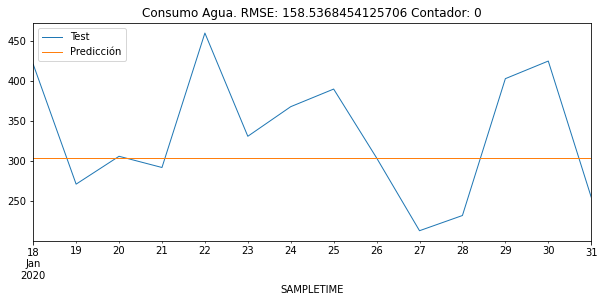

In [23]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()

In [24]:
data_tuples = list(zip(Proyecto.RMSE_Todos,Proyecto.RMSE_Todos_IDs))
resultados=pd.DataFrame(data_tuples,columns=['RMSE_Media','ID'])
resultados.to_csv(path+'RMSE_MEdia')
print(resultados)

      RMSE_Media    ID
0     158.536845     0
1      88.946241     1
2      14.293388     2
3     123.149158     3
4     100.206587     4
...          ...   ...
2710    0.904325  2722
2711  135.376394  2742
2712  335.187612  2745
2713    7.299112  2748
2714    0.652450  2749

[2715 rows x 2 columns]


# COHERENCIA DE LOS DATOS

In [25]:
Proyecto.contadores[0].Predicciones

[0,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 303.8399999999993,
 2126.879999999995,
 2126.879999999995]

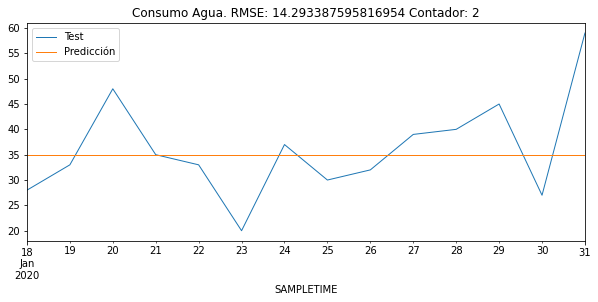

In [26]:
Proyecto.contadores[2].Predicciones
Proyecto.GraficasEstadisticas(contador=2,Test=True)

In [27]:
Proyecto.contadores[2711].Predicciones

[2711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
Proyecto.RMSE_Test_Promedio

440.933308987741

In [29]:
Proyecto.RMSE_Test_Suma

1197133.9339017167

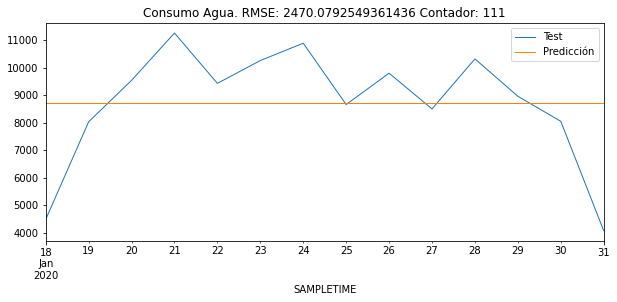

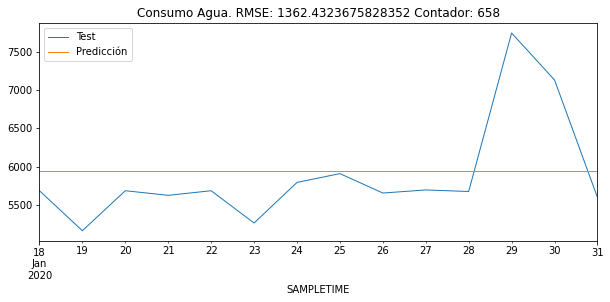

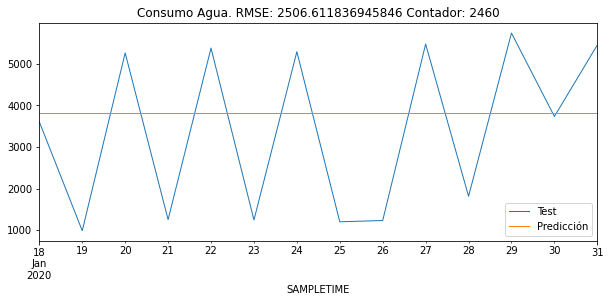

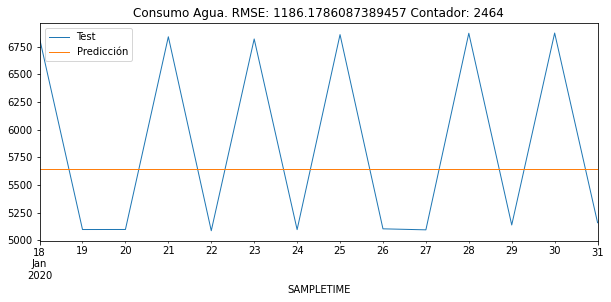

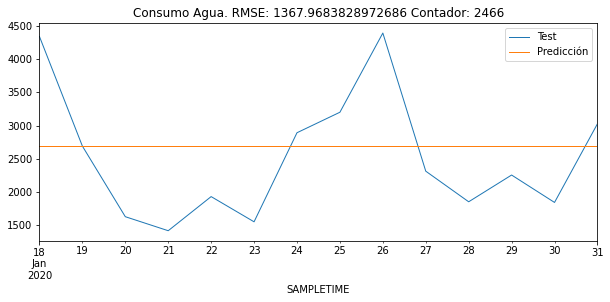

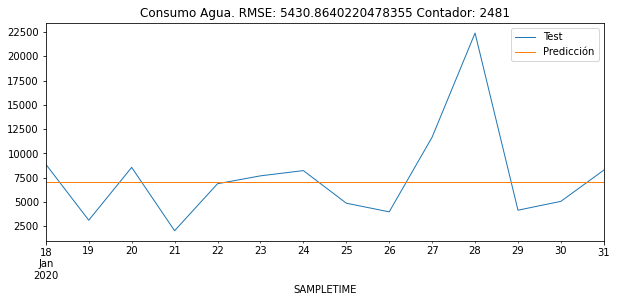

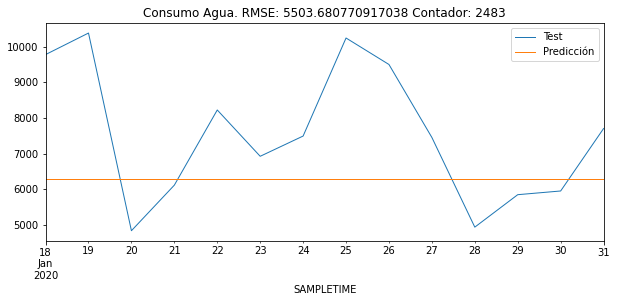

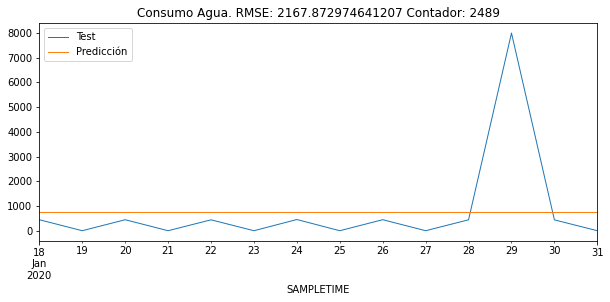

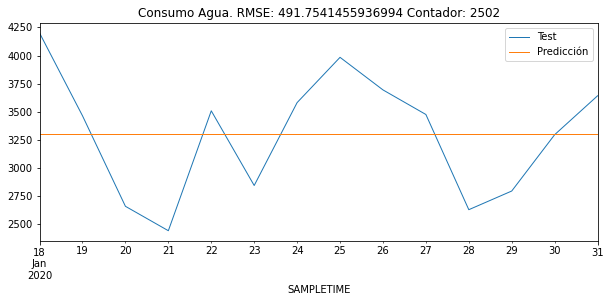

In [30]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)